# Population Group 2.0 : Upgrading the UMLS

# Stage 1:

**Importing necessary dependencies**



- `requests`: for making HTTP requests to fetch publication data
- `Counter` from `collections`: to efficiently count keyword frequencies
- `re`: for regular expression operations during keyword parsing
- `csv`: to read/write CSV files containing concept terms and results
- `datetime` and `timedelta`: to filter publications from the last N years
- `tqdm`: for visualizing progress during loops or data fetching

In [4]:
import requests 
from collections import Counter
import re
import csv
from datetime import datetime, timedelta
from tqdm import tqdm

**Step 1: Search for the Word in PubMed and Retrieve Publication PMIDs**

In this, function search_pubmed queries the PubMed E-utilities API to retrieve publication IDs (PMIDs) that contain a given search term (`word`) within the last 3 years.
 
- `word` (str): The term to search for in PubMed  
- `max_results` (int): Maximum number of PMIDs to retrieve (default: 100)

 A list of PMIDs (PubMed Identifier) corresponding to recent PubMed articles matching the search term.

In [5]:
def search_pubmed(word, max_results=100):
    print(f"Searching for the word '{word}' in PubMed...")

    esearch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    
    # Calculate the date range for the last 3 years -> {current time - 3*365}
    end_date = datetime.now().strftime("%Y/%m/%d")
    start_date = (datetime.now() - timedelta(days=3*365)).strftime("%Y/%m/%d")

    params = {
        'db': 'pubmed',
        'term': word,
        'retmax': max_results,
        'retmode': 'json',
        'mindate': start_date,
        'maxdate': end_date
    }

    response = requests.get(esearch_url, params=params)
    
    if response.status_code != 200:
        print("Error fetching data from PubMed API.")
        return []
    
    pmids = response.json().get('esearchresult', {}).get('idlist', [])
    
    print(f"Found {len(pmids)} publications with the word '{word}'.")
    print(f"PMIDs: {pmids}\n")
    
    return pmids

**Step 2: Fetch Publication Details and Extract Keywords**

This function retrieves keywords and article links for a list of PubMed IDs (PMIDs) by querying the PubMed `efetch` API endpoint.

- `pmids` (list): A list of PubMed article IDs for which to fetch metadata

We get 
- `keywords` (list): A list of extracted keywords found in the articles' XML metadata  
- `article_links` (list): A list of URLs pointing to the full articles on the PubMed website

- This function will return empty lists if no PMIDs are provided or if the API call fails  
- Parses the XML response to extract `<Keyword>` elements  
- Constructs readable PubMed article links using the PMIDs

In [6]:
def fetch_keywords(pmids):
    if not pmids:
        return [], []
    
    print(f"Fetching keywords for PMIDs: {pmids}")
    
    efetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {
        'db': 'pubmed',
        'id': ','.join(pmids),
        'retmode': 'xml'
    }
    response = requests.get(efetch_url, params=params)
    
    if response.status_code != 200:
        print("Error fetching abstracts and keywords from PubMed.")
        return [], []
    
    xml_text = response.text
    
    # Extract keywords from the XML response
    keywords = re.findall(r'<Keyword MajorTopicYN="N">(.*?)</Keyword>', xml_text)

    # Extract links to the articles
    article_links = [f"https://pubmed.ncbi.nlm.nih.gov/{pmid}/" for pmid in pmids]
    
    print(f"Extracted Keywords: {keywords}")
    print(f"Article Links: {article_links}\n")
    
    return keywords, article_links

**Step 3: Analyze Intersections of Keywords**

`find_top_terms`

This function analyzes a list of keywords and returns the most frequently occurring terms.

**Parameters**  
- `keywords` (list): A list of keywords extracted from PubMed articles  
- `top_n` (int): The number of top keywords to return (default: 5)

**Return**  
- `common_keywords` (list of tuples): A list of tuples containing the top keywords and their respective frequencies

**Important Points** 
- `collections.Counter` -> count how many times each exact keyword appears  
- Matching is **case-sensitive** and **string-exact**. For example, `"AI"` and `"ai"` are treated as different terms  
- If needed, an option is to normalize keywords beforehand using something like:
  ```python
  normalized_keywords = [kw.lower().strip() for kw in keywords]
  ```

In [7]:
def find_top_terms(keywords, top_n=5):
    print(f"Analyzing {len(keywords)} keywords to find the top {top_n}...\n")
    
    if not keywords:
        print("No keywords found in the publications.")
        return []
    
    keyword_counter = Counter(keywords)
    common_keywords = keyword_counter.most_common(top_n)
    
    print(f"Top {top_n} keywords:")
    for keyword, count in common_keywords:
        print(f"{keyword}: {count}")
    print("\n")
    
    return common_keywords

**Step 4: Main Function to Execute the Analysis and Save Result**

In [ ]:
def main():
    input_csv = '../data/semantic_network_umls_terms_population_group.csv'
    output_csv = '../data/semantic_network_umls_terms_final_with_keywords.csv'

    # Step 1: Read the output CSV to get already processed concepts
    processed_concepts = set()
    try:
        with open(output_csv, mode='r') as outfile:
            reader = csv.DictReader(outfile)
            processed_concepts = {row['STR'] for row in reader}
    except FileNotFoundError:
        print("Output file not found. Starting from scratch.")

    with open(input_csv, mode='r') as infile:
        reader = list(csv.DictReader(infile))
        fieldnames = reader[0].keys() | {'Top_Keywords_and_Counts', 'Article_Links'}

        rows_to_save = []
        counter = 0  # Counter to track processed rows

        # Use tqdm to track progress
        for row in tqdm(reader, desc="Processing concepts"):
            concept = row['STR']
            if concept in processed_concepts:
                continue

            print(f"Processing concept: {concept}")

            # Step 1: Search for the concept in PubMed with date filtering
            pmids = search_pubmed(concept, max_results=200)
            
            if not pmids:
                row['Top_Keywords_and_Counts'] = ''
                row['Article_Links'] = ''
                rows_to_save.append(row)
                continue
            
            # Step 2: Extract keywords and article links
            all_keywords = []
            all_links = []
            for pmid_batch in [pmids[i:i + 10] for i in range(0, len(pmids), 10)]:  # Batch processing
                keywords, links = fetch_keywords(pmid_batch)
                if keywords:
                    all_keywords.extend(keywords)
                if links:
                    all_links.extend(links)
            
            if not all_keywords:
                row['Top_Keywords_and_Counts'] = ''
                row['Article_Links'] = ''
                rows_to_save.append(row)
                continue
            
            # Step 3: Find and save the top 5 keywords
            top_keywords = find_top_terms(all_keywords, top_n=5)
            keywords_str = '; '.join([f"{keyword}: {count}" for keyword, count in top_keywords])
            links_str = ', '.join(all_links)
            
            # Save the results temporarily
            row['Top_Keywords_and_Counts'] = keywords_str
            row['Article_Links'] = links_str
            rows_to_save.append(row)

            # Increment counter and check if we need to save
            counter += 1
            if counter % 25 == 0:
                with open(output_csv, mode='a', newline='') as outfile:
                    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
                    if outfile.tell() == 0:
                        writer.writeheader()
                    writer.writerows(rows_to_save)
                rows_to_save = []  # Clear saved rows

        # Save any remaining rows
        if rows_to_save:
            with open(output_csv, mode='a', newline='') as outfile:
                writer = csv.DictWriter(outfile, fieldnames=fieldnames)
                if outfile.tell() == 0:
                    writer.writeheader()
                writer.writerows(rows_to_save)


**Run Main**

In [1]:
if __name__ == "__main__":
    main()

Processing concepts:   0%|                              | 0/663 [00:00<?, ?it/s]

Processing concept: Unmarried person
Searching for the word 'Unmarried person' in PubMed...
Found 200 publications with the word 'Unmarried person'.
PMIDs: ['40319289', '40317014', '40315753', '40314953', '40313535', '40310189', '40309023', '40307766', '40306370', '40302980', '40297434', '40294405', '40294155', '40293876', '40292864', '40289929', '40287671', '40287583', '40286915', '40286590', '40285284', '40285099', '40283397', '40281795', '40281620', '40280719', '40279641', '40278763', '40274738', '40274616', '40274273', '40273497', '40273196', '40272642', '40270238', '40270079', '40265071', '40262562', '40262405', '40262118', '40260969', '40260847', '40257827', '40255707', '40254686', '40252646', '40251878', '40251713', '40250881', '40249231', '40248699', '40247247', '40246568', '40246236', '40245679', '40245351', '40244527', '40244508', '40241494', '40241405', '40239053', '40238616', '40238059', '40237918', '40234800', '40234787', '40232752', '40231412', '40229734', '40228002', '40

Extracted Keywords: ['Adolescent health', 'School', 'Suicidal ideation', 'Well-being', 'Infirmier', 'Nurse', 'Ophtalmologie', 'Ophthalmology', 'Prison', 'Tele-ophthalmology', 'Telemedicine', 'T&#xe9;l&#xe9;expertise', 'T&#xe9;l&#xe9;m&#xe9;decine', 'AQoL', 'Community', 'Loneliness', 'Participant-reported outcomes.', 'Psychosocial', 'Quality of life', 'nasal airway obstruction', 'nasal valve', 'nasal valve collapse', 'radiofrequency', 'rhinoplasty', 'septoplasty', 'GWAS', 'PTSD', 'polygenic risk', 'stress', 'Complications', 'Infection', 'Knee replacement', 'Osteoarthritis', 'Pain', 'Pharmacoepidemiology', 'Post-operative outcomes', 'Real-world evidence', 'Steroid injection', 'Surgery', 'Engagement', 'Integrated care', 'Risk factor management', 'Stroke', 'Team-based', 'Technology-enabled']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40208595/', 'https://pubmed.ncbi.nlm.nih.gov/40206510/', 'https://pubmed.ncbi.nlm.nih.gov/40206122/', 'https://pubmed.ncbi.nlm.nih.gov/40203528/', 'http

Processing concepts:   8%|█▌                   | 51/663 [00:03<00:44, 13.69it/s]

Extracted Keywords: ['artificial intelligence', 'classification', 'depression', 'machine learning', 'older adults', 'Garmin', 'commercial wearable device', 'heart rate', 'mobile phone', 'physical activity', 'smartphone app', 'wearable sensors', 'youth', 'COVID-19 pandemic', 'anxiety', 'back pain', 'self-employed', 'working condition', 'causal inference model', 'cohort studies', 'comorbidity', 'diabetes', 'elderly', 'healthy lifestyle', 'hypertension', 'metabolic dysfunction&#x2010;associated steatotic liver disease', 'Child Health', 'Paediatrics', 'Syndrome', 'Anxiety', 'Depression', 'Metacognition', 'Neuropsychology', 'Worry', 'Biomarker', 'Cognitive function', 'Dementia', 'Klotho', 'Meta-analysis', 'Systematic review', 'Epicoccum nigrum', 'Fusarium spp', 'Serratia marcescens', 'Calcofluor white', 'Eucharistic miracles']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40053734/', 'https://pubmed.ncbi.nlm.nih.gov/40053729/', 'https://pubmed.ncbi.nlm.nih.gov/40053553/', 'https://pubmed

Extracted Keywords: ['diabetes mellitus', 'erectile dysfunction', 'erection', 'hypertension', 'obesity', 'Addictive behaviors', 'Quality of life', 'Self-help group', 'Severity of symptoms', 'Twelve-step program', 'alcoholic liver disease', 'autoantibodies', 'biomarker', 'fibrosis', 'inflammation', 'interleukin', 'protein desialylation', 'Appalachia', 'West Virginia', 'medication assisted treatment', 'opioid use disorder', 'patient perspective', 'practice-based research', 'antioxidants', 'biofilm', 'co-operative growth', 'oxidative stress', 'radioprotection', 'radioresistant microorganisms', 'diabetes type 2', 'hypertension and covid-19', 'life style habits', 'smoking tobacco', 'unhealthy diet', 'Alcohol use disorder', 'Wernicke&#x2019;s encephalopathy', 'Wernicke&#x2019;s triad', 'bariatric surgery', 'ophthalmoplegia', 'thiamine', 'vitamin B1', 'Agar plate culture', 'Alcoholism', 'Neglected tropical diseases', 'Strongyloides stercoralis']
Article Links: ['https://pubmed.ncbi.nlm.nih.go

Processing concepts:   8%|█▋                   | 54/663 [00:07<01:38,  6.21it/s]

Extracted Keywords: ['ADS', 'Indian male alcoholics', 'Laboratory parameters', 'SADQ-C', 'Serum cortisol', 'Alcohol deprivation effect', 'Aticaprant', 'Combination therapy', 'KOR', 'Naltrexone', 'Nor-BNI', 'Relapse', 'Abstinent alcoholics', 'Connectome-based predictive modeling', 'Empathy', 'Osteosarcopenia', 'alcoholism', 'body composition', 'cirrhosis', 'obesity', 'sclerostin', 'RNA', 'alcohol', 'oral cancer', 'tobacco', 'toothbrush', 'Addiction', 'adult children', 'alcoholics', 'caregiver', 'cohabitant', 'dependency', 'family', 'misuse', 'next of kind', 'relatives', 'spouses', '12-step groups', 'Alcohol use disorder', 'Concerned others', 'Treatment', 'Addiction', 'Adult children of alcoholics', 'Alcoholism', 'Substance use disorder', 'alcohol use disorder', 'alcoholism', 'monetary discounting', 'psychophysiological interaction', 'task fMRI']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35855712/', 'https://pubmed.ncbi.nlm.nih.gov/35832748/', 'https://pubmed.ncbi.nlm.nih.gov/3582

Extracted Keywords: ['Delayed sleep-phase wake', 'Insomnia', 'School dropout', 'Sleep duration', 'Dynamic Performance Management', 'Simulation models', 'dropping out', 'higher education', 'rural areas', 'Adolescence', 'Epidemiology', 'Psychiatric disorders', 'School dropout', 'Burnout, Professional', 'Career Mobility', 'Chiropractic', 'Attention deficit hyperactivity disorder', 'Mental disorders', 'Meta-analysis', 'School dropout', 'clinical practice', 'critical thinking', 'digital intervention', 'feasibility', 'guidance model', 'medical education', 'mobile app', 'nursing', 'nursing education', 'nursing student', 'technology', 'Parental divorce', 'adolescence', 'parental separation', 'school completion', 'school dropout', 'upper secondary school', 'COVID-19 school closures', 'Ethiopia', 'dropout', 'education', 'socio-emotional learning', 'Indigenous', 'Sami youth', 'Tracking', 'dropouts', 'health', 'prevention', 'upper secondary school']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov

Processing concepts:   8%|█▋                   | 55/663 [00:09<02:30,  4.05it/s]

Extracted Keywords: ['abuse', 'harassment', 'hazing', 'public health', 'university students', 'violence', 'adolescence', 'health-related quality of life', 'risk factors', 'school dropout', 'substance use', 'Admission program', 'Dropout', 'Examination', 'Medical education', 'Medical students', 'Mental', 'Mental health', 'Mental health problems', 'Mental problems', 'Thailand', 'Dropout', 'Online learning', 'Open and distance education', 'Retention', 'Infertility', 'dropout/discontinuation', 'treatment']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35886237/', 'https://pubmed.ncbi.nlm.nih.gov/35816476/', 'https://pubmed.ncbi.nlm.nih.gov/35805512/', 'https://pubmed.ncbi.nlm.nih.gov/35710367/', 'https://pubmed.ncbi.nlm.nih.gov/35677599/', 'https://pubmed.ncbi.nlm.nih.gov/35672872/', 'https://pubmed.ncbi.nlm.nih.gov/35512010/']

Analyzing 225 keywords to find the top 5...

Top 5 keywords:
Dropout: 5
adolescence: 4
school dropout: 4
Depression: 4
School dropout: 4


Processing concept: st

Processing concepts:   9%|█▊                   | 57/663 [00:09<02:19,  4.36it/s]

Error fetching data from PubMed API.
Processing concept: Tissue Donors
Searching for the word 'Tissue Donors' in PubMed...
Found 200 publications with the word 'Tissue Donors'.
PMIDs: ['40319300', '40319093', '40318086', '40317133', '40317064', '40314995', '40314368', '40313867', '40312732', '40312345', '40311809', '40311322', '40310552', '40309971', '40308927', '40308879', '40308598', '40308060', '40307693', '40306999', '40306784', '40305485', '40305372', '40305355', '40304361', '40304196', '40302550', '40302456', '40302377', '40302333', '40301990', '40301675', '40301474', '40299750', '40299057', '40298875', '40298680', '40298438', '40298008', '40297792', '40296161', '40295028', '40294124', '40293746', '40293546', '40292925', '40291679', '40291614', '40289050', '40288637', '40288351', '40287275', '40287269', '40286914', '40284984', '40283842', '40283145', '40282871', '40281562', '40280382', '40279419', '40279262', '40278827', '40278798', '40278797', '40276960', '40276834', '40276472',

Extracted Keywords: ['Spatial correlation', 'Spatial transcriptomics', 'Statistical methods', 'Hemophilia', 'Hemophilic arthropathy', 'Hemosiderin', 'MRI', 'Quantitative susceptibility mapping', 'Blood Donors', 'Blood Transfusion', 'Blood-Borne Pathogens', 'Seroepidemiologic Studies', 'Mexico', 'Tissue Donors', 'Transplants', 'allograft', 'donor selection', 'lung resection', 'lung transplantation', 'size matching', 'NGS', 'novel HLA allele', 'patient', 'Clinical efficacy', 'Mesenchymal stem cell eye drops', 'Non-Sj&#xf6;gren&#x2019;s dry eye', 'Safety', "Sj&#xf6;gren's syndrome dry eye", 'Tear proteomic analysis', 'Epithelial-mesenchymal transition', 'Fibrosis', 'Immunity and matrix-regulatory cells', 'Intrauterine adhesion', 'Mesenchymal stem cells', 'TGF-&#x3b2;/Smad']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40275395/', 'https://pubmed.ncbi.nlm.nih.gov/40274909/', 'https://pubmed.ncbi.nlm.nih.gov/40273421/', 'https://pubmed.ncbi.nlm.nih.gov/40273303/', 'https://pubmed.ncbi.n

Extracted Keywords: ['antibiotic-fecal microbiota transplantation', 'donor-derived microbiome', 'ulcerative colitis', 'delayed graft function', 'donor urinary UDP-Glc', 'kidney transplantation', 'predictive model', 'tissue damage', 'Sibling pediatric', 'Stem Cell Transplantation', 'Stem cell donors', 'DNA barcoding', 'Forensic mycology', 'Forensic taphonomy', 'Fungal communities', 'Necrobiome', 'Nested PCR, Illumina MiSeq', 'guidelines', 'immunological risk', 'kidney transplantation', 'virtual crossmatch', 'wet crossmatch omission']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40168152/', 'https://pubmed.ncbi.nlm.nih.gov/40168084/', 'https://pubmed.ncbi.nlm.nih.gov/40166356/', 'https://pubmed.ncbi.nlm.nih.gov/40166227/', 'https://pubmed.ncbi.nlm.nih.gov/40165952/', 'https://pubmed.ncbi.nlm.nih.gov/40164891/', 'https://pubmed.ncbi.nlm.nih.gov/40164822/', 'https://pubmed.ncbi.nlm.nih.gov/40163932/', 'https://pubmed.ncbi.nlm.nih.gov/40163497/', 'https://pubmed.ncbi.nlm.nih.gov/4016248

Processing concepts:   9%|█▊                   | 58/663 [00:13<05:34,  1.81it/s]

Error fetching abstracts and keywords from PubMed.
Analyzing 455 keywords to find the top 5...

Top 5 keywords:
kidney transplantation: 9
next&#x2010;generation sequencing: 3
Living donor: 3
liver transplantation: 3
novel allele: 3


Processing concept: Transient Population Group
Searching for the word 'Transient Population Group' in PubMed...
Found 200 publications with the word 'Transient Population Group'.
PMIDs: ['40317779', '40313494', '40313057', '40313018', '40312705', '40312310', '40309690', '40307864', '40307839', '40304696', '40302951', '40302777', '40299822', '40295969', '40287841', '40283850', '40283741', '40283717', '40275336', '40272347', '40269978', '40269851', '40269761', '40264202', '40264163', '40262916', '40260160', '40255598', '40251949', '40251239', '40249673', '40248948', '40246469', '40241942', '40241906', '40231216', '40231181', '40227227', '40226722', '40226685', '40223872', '40223307', '40214215', '40214018', '40212524', '40211237', '40205407', '40204299', '40

Extracted Keywords: ['attitudes', 'breastfeeding', 'health knowledge', 'migrants', 'pilot projects', 'practice', 'quality of life', 'self&#x2010;efficacy', 'aortic valve stenosis', 'carotid arteries', 'heart valve prosthesis implantation', 'transcatheter aortic valve replacement', 'COVID-19', 'Sars-CoV-2', 'anemia', 'chronic kidney disease', 'erythropoietin', 'hemodialysis', 'kidney failure', 'renal replacement therapies', 'Ethnic and Racial Minorities', 'Heat Stress Disorders', 'Occupational Exposure', 'Occupational Health', 'Outdoor Workers', 'Transients and Migrants', 'Health', 'High-income countries', 'Housing', 'Migrant', 'Refugee', 'Systematic review', 'Awareness', 'Barriers', 'Beliefs', 'Cervical cancer', 'Migrant women', 'Muslim', 'Practices', 'Screening', 'asylum seekers', 'hepatitis C', 'migrants', 'prevalence', 'refugees', 'epidemiology', 'incidence rates', 'migrants', 'refugees', 'screening', 'tuberculosis']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40139970/', 'http

Processing concepts:   9%|█▊                   | 59/663 [00:17<09:05,  1.11it/s]

Extracted Keywords: ['Ophthalmology', 'attitudes', 'cross-sectional study', 'knowledge', 'left-behind children', 'practice', 'refractive errors', 'Australia', 'equity', 'healthcare system', 'immigrant', 'migrant health', 'Catalonia', 'Chagas', 'Efficacy', 'Lay care', 'Living labyrinths', 'Treatment', 'barriers', 'facilitators', 'mainland China', 'mental health activities', 'urban left-behind children', 'Ageing', 'EQ-5D', 'HRQoL', 'India', 'Migrants', 'COVID-19', 'Health Equity', 'Health policy', 'Refugees', 'Vaccination', 'Vulnerable Populations', 'Cancer', 'Education', 'Migrant', 'Non-western', 'Oncologist', 'Training', 'Culturally competent care', 'Migrant', 'Minority Health', 'Pregnancy', 'Refugee', 'Stillbirth', 'Systematic review', 'Construction Industry migrant workers (CIMWs)', 'Factors of protection', 'Health status', 'Marital adjustment', 'Social support', 'Immunisation services', 'Migrant populations', 'Systemic inequities', 'Vaccine equity', 'Vaccine preventable diseases']
A

Extracted Keywords: ['COVID-19', 'Indian migrants', 'Norway', 'infodemic', 'transnationalism', 'Access', 'Botswana', 'Health care', 'Healthcare workers', 'Medical ethics', 'Migrants', 'Policies', 'Antenatal care', 'Communication', 'Dialog support tool', 'Digital intervention', 'Migration', 'Chronic schistosomiasis', 'Empiric treatment', 'Migrants', 'Praziquantel', 'Sub-Saharan Africa', 'Child health &amp; development', 'Determinants of health', 'International health', 'Migration', 'Obesity', 'Urbanization', 'local older adults', 'loneliness', 'migrant older adults', 'oral health', 'social support', 'health vulnerability', 'migrant workers', 'psychological burden', 'socio-ecological model', 'temperature change', 'Filipino', 'Korea', 'breastfeeding', 'diet', 'migrants', 'mothers', 'Forced migrants', 'measure', 'migration stressor', 'psychological health', 'refugees']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40093721/', 'https://pubmed.ncbi.nlm.nih.gov/40082860/', 'https://pubmed.

Processing concepts:   9%|█▉                   | 60/663 [00:20<12:18,  1.23s/it]

Extracted Keywords: ['Ethnicity', 'Migration', 'Psychosis', 'Schizophrenia', 'Schizotypy', 'Hainan', 'Hypertensive migratory population', 'QoL', 'SF-36', 'Bangladeshi migrant', 'Mental health', 'Migrant', 'Thailand', 'Depression &amp; mood disorders', 'EPIDEMIOLOGIC STUDIES', 'PSYCHIATRY', 'Social Support', 'Culturally appropriate diabetes education model', 'Effect of intervention', 'Group-based', 'Migrants', 'Observational study', 'Pre-post-test design', 'Primary care', 'Type 2 diabetes', 'anxiety', 'associated factors', 'depression', 'feeling of security', 'rural left-behind women']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39765162/', 'https://pubmed.ncbi.nlm.nih.gov/39762810/', 'https://pubmed.ncbi.nlm.nih.gov/39762323/', 'https://pubmed.ncbi.nlm.nih.gov/39762093/', 'https://pubmed.ncbi.nlm.nih.gov/39760597/', 'https://pubmed.ncbi.nlm.nih.gov/39755587/', 'https://pubmed.ncbi.nlm.nih.gov/39752620/', 'https://pubmed.ncbi.nlm.nih.gov/39749234/', 'https://pubmed.ncbi.nlm.nih.gov

Extracted Keywords: ['Africa', 'Filicide', 'Infanticide', 'Neonaticide', 'Add-back', 'Dysmenorrhoea', 'Endometriosis', 'Gonadotrophin-releasing hormone antagonists', 'Pelvic pain', 'ADDO', 'Adolescent health', 'Afya-Tek', 'CHW', 'Child health', 'Community', 'Digital health', 'Health facility', 'Maternal health', 'Primary healthcare', 'Advanced machine learning algorithm', 'Adverse birth outcome', 'Association rule mining', 'Sub-saharan Africa', 'DNA methylation', 'DNMT inhibitors', 'pediatric solid cancers', 'North Shewa', 'care', 'evaluating', 'mixed methods', 'safe abortion', 'service']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39142143/', 'https://pubmed.ncbi.nlm.nih.gov/39117440/', 'https://pubmed.ncbi.nlm.nih.gov/39107769/', 'https://pubmed.ncbi.nlm.nih.gov/39098266/', 'https://pubmed.ncbi.nlm.nih.gov/39080878/', 'https://pubmed.ncbi.nlm.nih.gov/39080651/', 'https://pubmed.ncbi.nlm.nih.gov/39075434/', 'https://pubmed.ncbi.nlm.nih.gov/39058739/', 'https://pubmed.ncbi.nlm.nih

Processing concepts:   9%|█▉                   | 61/663 [00:25<17:35,  1.75s/it]

Extracted Keywords: ['CAR', 'CRISPR', 'TCR', 'Haiti', 'adolescence', 'pregnancy', 'vulnerability', 'Attitudes', 'Breastfeeding culture', 'Children&#x2019;s rights', 'Experiences', 'Mothers', 'Public breastfeeding', 'Public knowledge', 'Social norms', 'Women&#x2019;s rights', 'Adolescent sexual and reproductive health', 'Mother-daughter communication', 'Contraceptives', 'Family Planning', 'Hormonal', 'Perspectives on side effects', 'Atropisomerism', 'Getretinib', 'Neuroblastoma', 'RET', 'Ghana', 'adolescent women', 'attitudes', 'determinants', 'hormonal contraceptive', 'self-efficacy', 'social-psychological', 'Repeat births', 'Umlazi', 'contraception', 'young mothers']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37694593/', 'https://pubmed.ncbi.nlm.nih.gov/37671939/', 'https://pubmed.ncbi.nlm.nih.gov/37658398/', 'https://pubmed.ncbi.nlm.nih.gov/37653416/', 'https://pubmed.ncbi.nlm.nih.gov/39446401/', 'https://pubmed.ncbi.nlm.nih.gov/37596577/', 'https://pubmed.ncbi.nlm.nih.gov/3759

Extracted Keywords: []
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40300134/', 'https://pubmed.ncbi.nlm.nih.gov/40300034/', 'https://pubmed.ncbi.nlm.nih.gov/40300016/', 'https://pubmed.ncbi.nlm.nih.gov/40299968/', 'https://pubmed.ncbi.nlm.nih.gov/40299937/', 'https://pubmed.ncbi.nlm.nih.gov/40299917/', 'https://pubmed.ncbi.nlm.nih.gov/40299914/', 'https://pubmed.ncbi.nlm.nih.gov/40299886/', 'https://pubmed.ncbi.nlm.nih.gov/40299853/', 'https://pubmed.ncbi.nlm.nih.gov/40299824/']

Fetching keywords for PMIDs: ['40299146', '40299012', '40298707', '40298681', '40298669', '40298149', '40297880', '40297874', '40297839', '40297320']
Extracted Keywords: ['Cytological samples', 'Genotypes', 'Human Papillomavirus', 'Wastewater', 'Angioembolization', 'Blunt trauma', 'DMSA scintigraphy', 'Penetrating injury', 'Renal trauma', 'behavioural economics', 'cross&#x2010;sectional studies', 'delay discounting', 'mastication', 'nutrition assessment', 'procrastination', 'Morocco', 'burnout syndrome', 

Processing concepts:   9%|█▉                   | 62/663 [00:29<21:13,  2.12s/it]

Extracted Keywords: ['Air pollutants', 'Allergenic pollen', 'Meteorology', 'Urban ecology', 'Cointegration test', 'Coupling coordination', 'Sustainable development', 'Urban economy', 'Zero waste city', 'Ecosystem services', 'FLUS model', 'GeoDetector', 'Guangzhou', 'InVEST model', 'COVID-19', 'Coping', 'Data Sonification', 'Nursing Students', 'Stress', 'Elderly', 'Hip fracture', 'Risk Factors', 'Type 2 diabetes', 'firearm injury', 'healthcare disparities', 'length of stay', 'pediatrics', 'GPS Data', 'collective behavior', 'generalization', 'human mobility', 'Culicidae', 'bite nuisance', 'blood meal analysis', 'community diversity', 'disease risk', 'invasive species', 'mosquito surveillance', 'mosquito-borne disease', 'urban parks', 'urban planning', 'COVID-19', 'hematological malignancies', 'multiple myeloma', 'vaccination', 'vaccine hesitancy']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40269145/', 'https://pubmed.ncbi.nlm.nih.gov/40269135/', 'https://pubmed.ncbi.nlm.nih.gov/402

Extracted Keywords: ['Birth weight', 'Gestational diabetes mellitus', 'Pregnancy outcomes', 'Small-for-gestational-age', 'Strict vegetarian diet', 'Attitudes', 'Mindfulness', 'Sustainable food consumption', 'Vegetarianism', 'ORTO-15', 'ORTO-35', 'adolescents', 'eating behaviors', 'orthorexia nervosa', 'Analogues', 'Consumers', 'Food habits', 'Hybrid products', 'Meat', 'Perception', 'Plant-based meat alternatives', 'Plant-proteins', 'Branched-chain amino acids', 'Exercise performance', 'Muscle strength', 'Probiotic', 'Supplement', 'cobalamin', 'fermentation', 'microbial production', 'vitamin B12', 'food choice', 'food consumption', 'geriatric rehabilitation', 'malnutrition', 'older adults', 'quality of life', 'vegetarian diet', 'Flexitarian', 'Plant-based diet', 'Ultra-processed foods', 'Vegan', 'Vegetarian', 'Consumer behavior', 'Plant-based', 'Product denomination', 'Sensory analysis', 'Arthrospira', 'bioactive compounds', 'food fortification', 'future food', 'microalgae', 'spirulina'

Extracted Keywords: ['inflammation', 'obstetric and neonatal outcomes', 'polycystic ovary syndrome', 'reproductive age women', 'vitamin B12 deficiency', 'cultured meat', 'cultured meat industrialization', 'muscle satellite cell', 'myogenesis', 'UPF (ultra-processed foods)', 'calcium', 'iondine', 'pollen food syndrome', 'Anti-natalism', 'R&#xe4;s&#xe4;nen', 'Unnecessary suffering', 'Utilitarian', 'Veganism', 'Reception studies', 'Social representations', 'alternative proteins', 'changing consumption practices', 'cultivation', 'naturalization', 'cohort', 'diet', 'dietary guidelines', 'flexitarians', 'nutrients', 'plant-based', 'vegans', 'vegetarians', 'developmental delay', 'infantile tremor syndrome', 'malnutrition', 'vegetarian mother', 'vitamin B12', 'masculinity', 'meat', 'plant-based diet', 'vegan', 'vegetarian']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38766917/', 'https://pubmed.ncbi.nlm.nih.gov/38764517/', 'https://pubmed.ncbi.nlm.nih.gov/38756209/', 'https://pubmed.ncbi.

Processing concepts:  10%|█▉                   | 63/663 [00:33<25:30,  2.55s/it]

Extracted Keywords: ['Environmental impact', 'Global warming potential', 'Quantification', 'Slaughter waste', 'Diet index', 'Diet quality score', 'Dietary patterns', 'Vegan diet', 'Vegan dietary guidelines', 'Vegan recommendations', 'Animal product consumption', 'Human supremacy', 'Meat consumption', 'Motivations', 'Vegan', 'Vegetarian', '1970 British Cohort Study', 'Great Britain', 'Mental health', 'Vegetarianism', 'Assessment', 'Cut-off score', 'Eating disorder', 'ROC curve analysis', 'V-EDS', 'Vegan', 'Vegetarian', 'Danish National Birth Cohort', 'diet', 'pregnancy outcomes', 'vegans', 'vegetarians', 'DIAAS', 'protein', 'protein quality', 'protein requirements', 'MPXV', 'Monkeypox', 'symptom', 'transmission', 'treatment.', 'virulence factor', 'virus', 'Vegan', 'market position', 'meat substitutes', 'nutrition', 'plant proteins', 'vegetarian']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38300328/', 'https://pubmed.ncbi.nlm.nih.gov/38291526/', 'https://pubmed.ncbi.nlm.nih.gov/382

Extracted Keywords: ['Posttraumatic Stress Disorder (PTSD)', 'Psychopharmacology', 'Psychotherapy', 'Research Design and Methods', 'Posttraumatic Stress Disorder (PTSD)', 'Psychotherapy', 'Prevention', 'Suicide and self-destructive behavior', 'Veteran', 'Buprenorphine', 'OUD care', 'Opioid use disorder', 'Primary care', 'Chemoradiotherapy', 'Complications', 'Esophageal cancer', 'Esophagectomy', 'Physical fitness', 'PSEN1', 'Alzheimer&#x2019;s disease', 'HSP', 'Spastic paraparesis', 'Cardiometabolic', 'Maternal health', 'PFAS', 'Per- and polyfluoroalkyl substances', 'Pregnancy']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40308108/', 'https://pubmed.ncbi.nlm.nih.gov/40308104/', 'https://pubmed.ncbi.nlm.nih.gov/40308095/', 'https://pubmed.ncbi.nlm.nih.gov/40308000/', 'https://pubmed.ncbi.nlm.nih.gov/40307999/', 'https://pubmed.ncbi.nlm.nih.gov/40307998/', 'https://pubmed.ncbi.nlm.nih.gov/40307859/', 'https://pubmed.ncbi.nlm.nih.gov/40307840/', 'https://pubmed.ncbi.nlm.nih.gov/403078

Processing concepts:  10%|██                   | 64/663 [00:37<27:57,  2.80s/it]

Extracted Keywords: ['pregnancy', 'risk factors', 'systematic review', 'thyroid', 'thyroid function test abnormalities', 'deprescribing', 'overuse', 'proton pump inhibitors', 'lasers', 'nevus of Ota', 'pediatric dermatology', 'pigmented lesion', 'port&#x2010;wine birthmark', 'pulsed dye laser', 'vascular lesion', 'arterial spin labeling', 'cerebral blood flow', 'idiopathic generalized epilepsy', 'mood dysfunction', 'seizure control', 'family care', 'formal care', 'home care', 'instrumental variables', 'mental health', 'self&#x2010;rated health', 'Aminoacyl-tRNA Synthetase', 'Halofuginone', 'Parasite', 'Protein Synthesis', 'Toxoplasmosis', 'Dural arteriovenous fistula', 'Gamma knife surgery', 'Outcome', 'Repeat', 'Residual', 'Stereotactic radiosurgery']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40297097/', 'https://pubmed.ncbi.nlm.nih.gov/40296843/', 'https://pubmed.ncbi.nlm.nih.gov/40296703/', 'https://pubmed.ncbi.nlm.nih.gov/40296467/', 'https://pubmed.ncbi.nlm.nih.gov/40296378

Extracted Keywords: ['Diagnostic services', 'Mild traumatic brain injury', 'Minor head trauma', 'Mobile health units', 'Preclinical CT', 'COVID&#x2010;19', 'cardiothoracic', 'health care staff', 'moral injury', 'visiting', 'Addiction', 'Drug use', 'In hospital', 'Health literacy', 'Health outcomes', 'Knowledge translation', 'Lung cancer', 'Patient education', 'Shared decisions', 'Visual formats of learning', 'clinical trials', 'educational resources', 'hand hygiene', 'hand hygiene products', 'paediatric patients', 'school pupils', 'Indonesia', 'atrial fibrillation', 'smartphone&#x2010;based', 'tertiary hospital', 'intensive care', 'neonatal intensive care unit', 'pandemics', 'parent', 'severe acute respiratory syndrome coronavirus 2', 'Clock Drawing Test', "Parkinson's disease", 'dementia']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39455460/', 'https://pubmed.ncbi.nlm.nih.gov/39455424/', 'https://pubmed.ncbi.nlm.nih.gov/39447476/', 'https://pubmed.ncbi.nlm.nih.gov/39438400/', 'h

Processing concepts:  10%|██                   | 67/663 [00:41<17:57,  1.81s/it]

Extracted Keywords: ['mRS', 'outcome', 'stroke', 'thrombectomy', 'bioaerosol', 'contamination', 'droplets', 'hospital', 'infections', 'multidrug resistance', 'plumbing systems', 'toilet', 'Atrial fibrillation', 'ECG', 'Meteorological factors', 'ST-T changes', 'family members (MeSH)', 'hospital', 'hospital wards', 'video calls', 'COVID-19', 'pain', 'physical and psychological wellbeing', 'visitor restrictions', 'COVID-19 pandemic', 'Epilepsy', 'Neurological symptoms', 'Psychological distress', 'Intensive care units', 'Patient visitation', 'Physiological monitoring', 'Protocol-based intervention', 'Randomized Controlled Trial', 'Vital signs', 'COVID&#x2010;19', 'communication', 'nursing', 'patient and family involvement', 'quality of care', 'relatives', 'relatives as partners', 'visitor restrictions']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38296749/', 'https://pubmed.ncbi.nlm.nih.gov/38258391/', 'https://pubmed.ncbi.nlm.nih.gov/38257963/', 'https://pubmed.ncbi.nlm.nih.gov/38245

Extracted Keywords: ['Adipokines', 'Extrauterine growth restriction', 'Inflammation', 'Insulin resistance', 'Nutrition', 'Puberty', 'Child', 'Integrated Treatment', 'Mental Health', 'Mother', 'Operant Conditioning', 'Substance Use', 'Systematic Review', 'adverse childhood experiences', 'at risk students', 'children of alcoholic parents', 'evidence-based prevention programs (EBP)', 'parent substance abuse and dependency', 'school mental health', 'screening', 'substance use prevention programs', 'autism spectrum disorder', 'difficulties in developing', 'preschool education', 'schooling modality', 'ALK', 'Autophagy', 'Hirschsprung disease', 'Whole-genome sequencing', 'Anxiety Risk', 'ERN', 'Early Childhood', 'Error-Related Negativity', 'Maternal Anxiety', 'Antenatal depressive disorders', 'Data linkage study', 'Disruptive behavioural disorders', 'Perinatal depressive disorders', 'Postnatal depressive disorders', 'Clinical features', 'Diphtheria', 'Laboratory findings', 'Nigeria', 'Outcome

Processing concepts:  10%|██▏                  | 68/663 [00:44<21:46,  2.20s/it]

Extracted Keywords: ['Depression', 'Early-life risk factors', 'Gender', 'Population attributable risk', 'Young adulthood', 'child', 'family', 'mental illness', 'parent', 'well&#x2010;being', 'Child labor', 'Ethnography', 'Health', 'Qualitative research', 'Family intervention', 'Family-SCOUT', 'Health services research', 'Minor children', 'Parental cancer', 'Qualitative research', 'Template analysis', 'Acute Leukemia', 'Child', 'Late Effects', 'Long-Term Follow-Up', 'Survivor', 'Abdomen', 'Blunt', 'Outcome', 'Pediatric', 'Penetrating', 'Surgical', 'Adolescents', 'African-american', 'Impulsivity', 'Oppositional defiant disorder']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39025438/', 'https://pubmed.ncbi.nlm.nih.gov/39024264/', 'https://pubmed.ncbi.nlm.nih.gov/39020472/', 'https://pubmed.ncbi.nlm.nih.gov/39010025/', 'https://pubmed.ncbi.nlm.nih.gov/39004794/', 'https://pubmed.ncbi.nlm.nih.gov/38985388/', 'https://pubmed.ncbi.nlm.nih.gov/38984700/', 'https://pubmed.ncbi.nlm.nih.gov/

Extracted Keywords: ['Frail older adults', 'Frailty stages', 'Functional decline', 'Geriatric syndromes', 'Multicomponent interventions', 'Pre-frail older adults', 'Cisplatin ineligible', 'Head and neck cancer', 'Human papillomavirus', 'Outcomes', 'Radiotherapy alone', 'AI', 'Thailand', 'aged care', 'aging', 'artificial intelligence', 'clinical decision support', 'community dwelling', 'delivering health information and knowledge to the public', 'diagnosis', 'diagnostic systems', 'digital health', 'epidemiology', 'frailty', 'geriatric', 'gerontology', 'health care intervention', 'machine learning', 'old', 'patient care', 'prediction', 'predictive', 'surveillance', 'Anti-bacterial agents', 'Antimicrobial stewardship', 'Frail elderly', 'Hygiene', 'Medical audit', 'Nursing homes', 'Overdiagnosis', 'elderly', 'frailty', 'hip fractures', 'frail older adults', 'frailty', 'healthy aging', 'independent living', 'retirement', 'Community-based empirical study', 'cross-sectional study', 'exercise 

Extracted Keywords: ['Community', 'Disaster planning', 'Disasters', 'Elderly', 'Emergency preparedness', 'Emigrants and immigrants', 'Hazard', 'Health surveys', 'Intervention study', 'Kit', 'Medically frail', 'Preparedness', 'Public health', 'Readiness', 'Vulnerable populations', 'ASA score', 'Adverse events', 'NSCLC', 'frailty', 'functional status', 'mFI-11', 'mFI-5', 'palliative care-preoperative assessment', 'Accidental falls', 'Fatigue', 'Frailty syndrome', 'Health risk assessment', 'Muscle weakness', 'Frailty', 'Gait', 'Kinematic', 'Kinetic', 'Older adults', 'Influencing factors', 'Oral frailty', 'Scoping review', 'The elderly', 'Aged', 'Digital health', 'Frailty', 'Internet use', 'Japan', 'Social factor', 'Asistencia a ancianos', 'Assistance', 'Atenci&#xf3;n geriatrica', 'Elderly', 'Fragilidad en ancianos', 'Frail', 'Geriatric health service', 'Old age', 'CogXergaming', 'MOB', 'Matter of Balance', 'aging', 'dementia', 'dynamic balance', 'exergame training', 'frailty', 'gaming-bas

Processing concepts:  10%|██▏                  | 69/663 [00:48<25:29,  2.57s/it]

Extracted Keywords: ['Centenarians', 'Fractures', 'Frail elderly', 'Nonagenarian', 'Orthopedics', 'communication', 'frailty', 'hospital', 'older adult', 'qualitative', 'GDF-15', 'biomarker', 'frailty', 'functional fitness', 'older age', 'vulnerability', 'home care service', 'information technology', 'patient safety', 'primary healthcare', 'quality of healthcare', 'RANK/RANKL/OPG pathway (RRO pathway)', 'RANKL inhibitor', 'osteoporosis', 'osteosarcopenia denosumab', 'sarcopenia', 'Advance care planning', 'Clinical ethics', 'Decision-making', 'Next of kin', 'Older patients', 'Qualitative methods', 'Relational autonomy', 'Continuous professional development', 'Curriculum development', 'Delphi methodology', 'Frailty', 'Geriatric medicine', 'Ward rounds']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40151580/', 'https://pubmed.ncbi.nlm.nih.gov/40150878/', 'https://pubmed.ncbi.nlm.nih.gov/40150517/', 'https://pubmed.ncbi.nlm.nih.gov/40150476/', 'https://pubmed.ncbi.nlm.nih.gov/40149708/'

Extracted Keywords: ['elderly', 'frailty', 'hip fractures', 'frail older adults', 'frailty', 'healthy aging', 'independent living', 'retirement', 'amputation', 'collagen', 'neuroma', 'rehabilitation', 'ultrasound guided injection', 'Conscious sedation', 'High-flow nasal oxygenation therapy', 'Transcatheter aortic valve implantation', 'anatomical pathological condition', 'chronicity', 'incidental findings', 'obturator hernias', 'postmortem diagnosis', 'ADL', 'community', 'dietary total antioxidant capacity', 'frailty', 'malnutrition', 'nursing home', 'older adult', 'atrial fibrillation', 'eHealth', 'frailty', 'older people', 'opportunistic screening', 'photoplethysmography', 'clinical frailty scale (CFS)', 'electronic health records (EHRs)', 'emergency department (ED)', 'frailty assessment', 'older people']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40260264/', 'https://pubmed.ncbi.nlm.nih.gov/40259832/', 'https://pubmed.ncbi.nlm.nih.gov/40258766/', 'https://pubmed.ncbi.nlm.nih.go

Extracted Keywords: ['CHARLS', 'Frailty', 'Incidence', 'Nonlinear relationship', 'Urbanization', 'ABB C22', 'Saccharomyces boulardii', 'diarrhoea', 'gastrointestinal inflammation', 'oral rehydration salts', 'postbiotics', 'Discharge planning', 'Frailty', 'Physical function', 'Unplanned readmission', 'Depression', 'Elderly', 'Frailty', 'Prostate cancer', 'Sleep quality', 'Consensus building', 'Delphi', 'Frailty', 'Point of care', 'cognitive function', 'frailty', 'older', 'physical function', 'rheumatoid arthritis', 'Covid-19', 'Crisis', 'Eldercare', 'Inter-organizational', 'Medical care coordination', 'COVID&#x2010;19', 'geriatric syndromes', 'older adults', 'self&#x2010;neglect', 'Frailty', 'Hei', 'NHANES']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40128743/', 'https://pubmed.ncbi.nlm.nih.gov/40126284/', 'https://pubmed.ncbi.nlm.nih.gov/40122992/', 'https://pubmed.ncbi.nlm.nih.gov/40122931/', 'https://pubmed.ncbi.nlm.nih.gov/40119454/', 'https://pubmed.ncbi.nlm.nih.gov/40116464/

Processing concepts:  11%|██▏                  | 71/663 [00:51<22:23,  2.27s/it]

Extracted Keywords: ['Aged', 'Frailty', 'Social support', 'Systematic review', 'COVID&#x2010;19 pandemic', 'Kayoi&#x2010;no&#x2010;ba', 'continued participation', 'frailty prevention', 'Frailty', 'Health ecological model', 'Multimorbidity', 'Older adults', 'Risk factors', 'Adverse events', 'Frail elderly', 'In-hospital falls', 'Model, probabilistic', 'Nursing notes', 'CRT', 'CVD', 'ICD', 'SCD', 'cardiac resynchronization therapy', 'cardiovascular disease', 'frailty assessment', 'implantable cardioverter defibrillator', 'primary prevention', 'sudden cardiac death', 'aged', 'frailty', 'gastrointestinal neoplasms', 'postoperative complications', 'Lu-177', 'OS', 'PFS', 'Survival', 'mCRPC', 'Community-dwelling', 'Frailty component', 'Older adult', 'Physical frailty', 'Sleep duration', 'Sleep quality', 'Frail Elderly', 'fractures and dislocations', 'pain management']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40088836/', 'https://pubmed.ncbi.nlm.nih.gov/40088539/', 'https://pubmed.ncbi

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40248418', '40248327', '40246617', '40243790', '40242664', '40241476', '40241154', '40240408', '40239644', '40239201']
Extracted Keywords: ['Drug Addiction Treatment Act', 'MAT', 'X-waiver', 'buprenorphine', 'emergency department', 'medication for opioid use disorders', 'opioid-related overdoses', 'Palivizumab', 'Respiratory Syncytial Virus Infections', 'Respiratory Tract Infections', 'COVID-19 vaccines', 'Hispanic', 'Pediatric healthcare workers', 'Pediatric nurses', 'Vaccine hesitancy', 'Algeria', 'Bayesian method', 'COVID-19', 'MCMC simulation method', 'Poisson autoregressive model', 'short-term and long-term dependence', 'General practice', 'Health inequalities', 'Interpreting', 'Language barriers', 'Qualitative methods', 'Anthropometric measures', 'Body roundness index', 'Metabolic syndrome', '17q21.31', 'MAPT', 'chronic traumatic encephalopathy', 'dementia', 'differential gene expression', 'immune s

Extracted Keywords: ['case-based learning (cbl)', 'electrocardiogram (ecg)', 'rhythm abnormalities', 'traditional didactic learning (tdl)', 'waveform abnormalities', 'artificial intelligence (AI)', 'dialogue groups', 'focus groups', 'health care', 'public views', 'attributes', 'chronological', 'comprehensive cancer center', 'impact', 'international', 'scoping review', 'attractors', 'contrarians', 'democratic balance', 'opinion dynamics', 'prejudices', 'sociophysics', 'thwarting', 'tipping points', 'COVID-19', 'Weibo', 'sentiment analysis', 'social media', 'Africa', 'Anti-nucleocapsid antibodies', 'Children', 'IgG', 'Mali', 'SARS-CoV-2', 'Seroprevalence', 'COVID-19', 'Twitter', 'geolocation analysis', 'ivermectin', 'misinformation', 'public health', 'sentiment analysis', 'social media', 'Antimicrobial stewardship', 'Clinical decision-making', 'Medical audit', 'Nursing homes', 'Quality of health care', 'Urinary tract infections', 'Fabry disease', 'alpha-galactosidase A', 'enzyme replacem

Processing concepts:  11%|██▎                  | 72/663 [00:55<25:35,  2.60s/it]

Extracted Keywords: ['Attitude', 'depression', 'diagnosis', 'disease management', 'general practitioner', 'Cesarean section', 'normal vaginal delivery', 'randomized controlled trial', 'theory of planned behavior', 'long-term follow-up care', 'metabolic syndrome', 'pediatric oncology', 'survivorship', 'Neurostimulation', 'Psychiatric Disorders', 'Repetitive Transcranial Magnetic Stimulation', 'Substance-Related and Addictive Disorders', 'Adolescent', 'Health behavior', 'Physical activity', 'School environment', 'School health services', 'Sedentary behavior', '30 &#xd7; 30', 'conservation conflict', 'global biodiversity framework', 'inclusive conservation', 'politics', 'Epidemiology', 'Public Health', 'SARS-CoV-2', 'Diagnostic tools', 'Intermediate snail hosts', 'Mass Drug Administration', 'Morbidity indicators', 'Neglected tropical diseases', 'One Health approach', 'Preventive chemotherapy', 'Schistosomiasis', 'Water, sanitation and hygiene', 'Zoonotic transmission', 'Comprehensive drug

Extracted Keywords: ['2-tier Health Insurance', 'Health Economics', 'Health Policy', 'Medicare-expansion', 'Universal Health Coverage', 'Universal Health Insurance', 'Child', 'Dental caries', 'Health services accessibility', 'Pit and fissure sealants', 'Preventive dentistry', 'Appalachia', 'education', 'free clinic', 'health care', 'medically uninsured', 'nutrition', 'Burn injury', 'Disparities', 'Insurance', 'Outcomes', 'Canada', 'equity', 'medically uninsured', 'midwifery', 'migrant', 'newcomers', 'priority population', 'Medicaid expansion', 'disparities', 'insurance status', 'social determinants of health', 'testicular cancer']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39586063/', 'https://pubmed.ncbi.nlm.nih.gov/39584212/', 'https://pubmed.ncbi.nlm.nih.gov/39571088/', 'https://pubmed.ncbi.nlm.nih.gov/39543895/', 'https://pubmed.ncbi.nlm.nih.gov/39534730/', 'https://pubmed.ncbi.nlm.nih.gov/39522138/', 'https://pubmed.ncbi.nlm.nih.gov/39509938/', 'https://pubmed.ncbi.nlm.nih.g

Processing concepts:  11%|██▍                  | 75/663 [00:59<17:28,  1.78s/it]

Extracted Keywords: ['biliary tree cancer', 'medicaid expansion', 'national cancer database', 'Medicaid', 'Medicaid expansion', 'disparities', 'equity', 'health policy', 'health services', 'insurance', 'liver transplantation', 'pediatrics', 'Health geography', 'Mammography services', 'Prevention', 'Small area estimates', 'FIT', 'colorectal cancer', 'pharmacy', 'screening', 'uninsured', 'access to care', 'eConsults', 'health inequities', 'health services accessibility', 'medically underserved', 'primary care', 'provider perspectives', 'referral and consultation', 'underserved communities', 'uninsured', 'United States', 'hospitals', 'ischemic stroke', 'medically uninsured', 'patients', 'Health services research', 'Surgical nutrition', 'Trauma surgery']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37795657/', 'https://pubmed.ncbi.nlm.nih.gov/37792596/', 'https://pubmed.ncbi.nlm.nih.gov/37792594/', 'https://pubmed.ncbi.nlm.nih.gov/37782871/', 'https://pubmed.ncbi.nlm.nih.gov/37776976/'

Extracted Keywords: ['Levamlodipine besylate', 'model-informed precision dosing', 'pop PK/PD model', 'smoking patients', 'African American', 'attitudes', 'black people', 'decision&#x2010;making', 'health equity', 'inequities', 'prenatal diagnosis', 'prenatal testing', 'Black Americans', 'Community', 'Community engaged research', 'Harm reduction', 'Neighborhood deprivation', 'Opioids', 'Overdose', 'Racial inequities', 'Substance use treatment', 'Meta-analysis', 'Patient-centred care', 'Self-management', 'Type 2 diabetes', 'DPP4i', 'GLP-1 RA', 'HFpEF', 'SGLT2i', 'T2DM', '4D-DIA quantitative proteomics', 'Cardiovascular disease', 'Lung cancer', 'Space mass spectrometry', 'Spatial metabolomics', 'Adversarial training', 'BPBIC model', 'Data enhancement', 'Entity extraction', 'Knowledge graph', 'Collagen', 'Diabetic wound', 'Eggshell membrane', 'Haemostasis', 'alcohol', 'anthropology', 'consumption', 'health systems', 'methanol', 'social science', 'toxicity']
Article Links: ['https://pubmed.

Extracted Keywords: ['Asthma', 'Bronchial epithelial cells', 'MBD2', 'Th17 cell', 'sICOSL', 'Greenspace', 'Gut microbiota', 'Human microbiota', 'Natural environment', 'Oral microbiota', 'Community support services', 'Eviction', 'Eviction prevention', 'Homelessness', 'Public housing', 'Equity', 'Harm reduction', 'Implementation', 'Peer worker', 'Supervised consumption site', 'Bone marrow mesenchymal stem cells', 'DKK1', 'MIR155HG', 'Osteogenic differentiation', 'miR-155-5p', 'Harm reduction', 'Homelessness', 'Housing', 'Implementation science', 'Overdose', 'Reorganization', 'Stroke rehabilitation', 'Venlafaxine', 'fMRI', 'AIDS', 'AIDS prevention', 'HIV', 'older men', 'video', 'video-based intervention']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40252480/', 'https://pubmed.ncbi.nlm.nih.gov/40252473/', 'https://pubmed.ncbi.nlm.nih.gov/40252037/', 'https://pubmed.ncbi.nlm.nih.gov/40251645/', 'https://pubmed.ncbi.nlm.nih.gov/40251598/', 'https://pubmed.ncbi.nlm.nih.gov/40251575/', 'h

Processing concepts:  12%|██▍                  | 77/663 [01:03<18:44,  1.92s/it]

Processing concept: Underinsured
Searching for the word 'Underinsured' in PubMed...
Found 200 publications with the word 'Underinsured'.
PMIDs: ['40309517', '40299709', '40279116', '40274234', '40267036', '40259183', '40258582', '40256640', '40219753', '40214071', '40210205', '40197240', '40189463', '40180671', '40177502', '40158515', '40135503', '40134484', '40123227', '40118534', '40112654', '40103648', '40093779', '40090050', '40061548', '40044310', '40030113', '40014860', '40014829', '40009780', '40003415', '39972571', '39961160', '39925993', '39924676', '39913136', '39908082', '39900750', '39900252', '39895492', '39892443', '39889288', '39884930', '39882982', '39877527', '39871917', '39847852', '39826819', '39808850', '39802565', '39802560', '39800925', '39800081', '39779647', '39773992', '39765970', '39740387', '39738750', '39734719', '39732331', '39726487', '39716289', '39712746', '39692864', '39688288', '39679502', '39652680', '39631725', '39621343', '39615662', '39614637', '39

Extracted Keywords: ['apheresis', 'homozygous familial hypercholesterolemia', 'low density lipoprotein cholesterol plasmapheresis', 'low density lipoprotein-cholesterol', 'therapeutic plasmapheresis', 'Medicaid expansion', 'disparities', 'insurance status', 'social determinants of health', 'testicular cancer', 'Burn unit', 'Burns', 'Sociodemographics', 'COVID-19', 'Free Clinic', 'Influenza', 'Perceptions of Vaccines', 'Vaccination', 'COVID-19', 'Health emergencies', 'Mobile health clinics', 'Resource allocation', 'Underserved communities', 'Vaccination', 'Breast cancer', 'Mobile mammography', 'Underserved']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39480161/', 'https://pubmed.ncbi.nlm.nih.gov/39463575/', 'https://pubmed.ncbi.nlm.nih.gov/39456120/', 'https://pubmed.ncbi.nlm.nih.gov/39447286/', 'https://pubmed.ncbi.nlm.nih.gov/39442020/', 'https://pubmed.ncbi.nlm.nih.gov/39438397/', 'https://pubmed.ncbi.nlm.nih.gov/39432312/', 'https://pubmed.ncbi.nlm.nih.gov/39429534/', 'https://

Processing concepts:  12%|██▌                  | 79/663 [01:07<16:59,  1.75s/it]

Extracted Keywords: ['Child health', 'Health care disparities', 'Health services research', 'Immigrant', 'excess length of stay', 'insurance status', 'length of stay', 'trauma acute care', 'acute care', 'caregiver', 'communication', 'dementia', 'diversity, equity, and inclusion', 'emergency department', 'language barriers', 'racially or ethnically minoritized groups', 'Complications', 'Disparities', 'Insurance', 'Outcomes', 'Payer status', 'Spine surgery']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38603761/', 'https://pubmed.ncbi.nlm.nih.gov/38603539/', 'https://pubmed.ncbi.nlm.nih.gov/38585438/', 'https://pubmed.ncbi.nlm.nih.gov/38574751/', 'https://pubmed.ncbi.nlm.nih.gov/38568393/', 'https://pubmed.ncbi.nlm.nih.gov/38557562/', 'https://pubmed.ncbi.nlm.nih.gov/38554144/', 'https://pubmed.ncbi.nlm.nih.gov/38553653/', 'https://pubmed.ncbi.nlm.nih.gov/38553011/', 'https://pubmed.ncbi.nlm.nih.gov/38533185/']

Analyzing 318 keywords to find the top 5...

Top 5 keywords:
health insu

Extracted Keywords: ['Cancer Screening', 'Early Detection of Cancer', 'Implementation Science', 'Lung Cancer', 'Pragmatism', 'Preventive Health', 'Primary Health Care', 'Clinical MRI scans', 'Cortical surface reconstruction', 'Cortical thickness', 'Parcellation', 'EQ5D', 'Fall injuries', 'RIKSH&#xd6;FT', 'Register-based', 'Adaptive capacity', 'Climate vulnerability', 'Dairy farming', 'Exposure', 'Sensitivity', 'Zone-specific adaptation strategies', 'Demographic studies', 'Epidemiology', 'Generalized pustular psoriasis', 'Hospital dermatology', 'X&#x2010;ray histology', 'big data', 'extended field&#x2010;of&#x2010;view', 'multi&#x2010;resolution open data', 'neuroimaging', 'registration']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40301628/', 'https://pubmed.ncbi.nlm.nih.gov/40300826/', 'https://pubmed.ncbi.nlm.nih.gov/40300378/', 'https://pubmed.ncbi.nlm.nih.gov/40299982/', 'https://pubmed.ncbi.nlm.nih.gov/40299914/', 'https://pubmed.ncbi.nlm.nih.gov/40299269/', 'https://pubmed.n

Extracted Keywords: ['SF-36', 'Turkey', 'disaster', 'earthquake', 'quality of life', 'survivors', 'temporary housing', 'Abortion', 'Cattle', 'Dog', 'Infectious disease', 'N. caninum', 'Clinical Trial', 'Database', 'Public Policy', 'Rare Diseases', 'Energy policy', 'Energy resources', 'behavioural research', 'breast feeding', 'community&#x2010;based participatory research', 'culture', 'feeding behaviour', 'human', 'milk', 'psychosocial intervention', 'Lead optimisation', 'Reduced graphs', 'SAR', 'Visualisation', 'Attitude towards doing well', 'Financial job dependency', 'Psychological empowerment', 'Social exchange theory', 'Unethical leadership', 'Work deviant behavior', 'Care cascade', 'Control', 'Diagnosis', 'Health equity', 'Hypertension', 'Sri Lanka', 'Treatment']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40276338/', 'https://pubmed.ncbi.nlm.nih.gov/40276172/', 'https://pubmed.ncbi.nlm.nih.gov/40276110/', 'https://pubmed.ncbi.nlm.nih.gov/40276042/', 'https://pubmed.ncbi.nlm.

Processing concepts:  12%|██▌                  | 80/663 [01:11<22:53,  2.36s/it]

Extracted Keywords: ['Children', 'Global health', 'Immunization', 'Inequality', 'Sierra Leone', 'Anxiety and depression', 'Bangladesh garment sector', 'Emotional resilience', 'Female garment workers', 'Internal migration', 'Mental well-being', 'Phenomenological study', 'Rural-to-urban migration', 'Work-related stress', 'ADRD', 'Age span', 'Allostatic load', 'Biological stress', 'Biomarkers', 'Cognition', 'DNA methylation', 'Episodic memory', 'Executive function', 'Vascular', 'Health Belief Model', 'drowning', 'health behavior', 'health education', 'health promotion', 'injury prevention', 'low- and middle-income countries', 'Sweden', 'expectations', 'healthcare systems', 'private health insurance', 'public healthcare', 'satisfaction', 'voluntary health insurance', 'healthcare providers', 'healthcare students', 'legislation', 'perception', 'prevalence', 'tobacco', 'Z-RNA:DNA', 'cell death', 'spliceosome inhibition']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40269783/', 'https://pu

Extracted Keywords: ['Epidemiology', 'Influencing factors', 'Metallurgical industry', 'Occupational injuries', 'Shipbuilding and repairing industry', 'Status quo', 'Survey', 'Influencing factors', 'Protective effect', 'Respiratory protective equipment', 'Trichloroethylene', 'Workplace protection factor', 'Beauty salon', 'Cell cycle', 'Cell viability', 'Mutagenicity', 'Oxidative stress', 'Particulate matter', 'BTEX-H', 'Diabetes', 'Mixture', 'Oil spill cleanup', 'Quantile g-computation', 'acute liver failure (alf)', "coomb's negative", 'haemolytic anaemia', 'leipzig score', 'serum ceruloplasmin', 'wilson`s disease', 'Healthcare workers, Anti-spike IgG, Sinopharm, CanSino-Biologics, Pfizer, Booster.', 'alcohol consumption', 'firefighters', 'gut microbiome', 'gut&#x2013;brain axis', 'post-traumatic stress disorder (PTSD)', 'stress', 'Endocrine disruption', 'Insecticides', 'Natural products', 'Potential hazards', 'Testicular function']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40164

Extracted Keywords: ['Feet and ankles', 'Musculoskeletal system', 'Risk factors', 'Structural equation modeling', 'Work-related musculoskeletal disorders', 'Musculoskeletal system', 'Shoulder fatigue', 'Shoulder pain', 'Structural equation model', 'Work-related musculoskeletal disorders', 'Indium-tin oxide nanoparticles', 'Inflammatory response', 'Metal nanoparticles', 'NF-&#x3ba;B/Nrf2 pathway', 'Oxidative stress', 'Pulmonary alveolar proteinosis', 'Rats', 'Humidifier disinfectants', 'Population attributable risk fraction', 'Respiratory diseases', 'Sicurpest software', 'agriculture', 'chemical risks', 'occupational health and safety (OHS)', 'pesticide exposure', 'risk assessment', 'risk management', 'endocrine-disrupting compounds', 'female reproductive health', 'follicular fluid', 'urine', 'alternative medicine', 'complementary therapies', 'cultural practices', 'healthcare professionals', 'oncology patients', 'rural communities', 'traditional medicine', 'Biomass', 'Intention to Parti

Processing concepts:  12%|██▌                  | 81/663 [01:15<27:25,  2.83s/it]

Extracted Keywords: ['Alternatives', 'Antivirals', 'Bovines', 'Foot and mouth disease virus', 'NPs', 'Nanocarriers', 'anticancer drug', 'anticancer drug degrading agents', 'fluorouracil', 'hd protect', 'tripleclin', 'carcinogens', 'experimental studies on animals', 'occupational exposure', 'risk assessment', 'risk assessment methods', 'statistical modelling', 'Department of Defense', 'ethics', 'military', 'surveillance', 'wastewater', 'In-line monitoring', 'Online NIR', 'Platform chemicals', 'Process analytical technologies', 'Real time', 'family medicine', 'internal medicine', 'occupational hazards', 'paint industry', 'worker health', 'Agriculture', 'Awareness', 'Farming', 'Protective wear', 'Qualitative study', 'Aryl hydrocarbon receptor', 'CKDu', 'Chronic kidney disease of an unknown etiology', 'Cysteine', 'Mitochondria', 'Proteomics', 'Redox', 'TGF&#x3b2;', 'Thiol', 'Acute Kidney Injury', 'Diquat', 'Kidney Injury Molecule-1 (KIM-1)', 'Neutrophil Gelatinase-Associated Lipocalin (NGA

Extracted Keywords: ['LBGTQ+', 'discrimination', 'palliative care', 'serious illness care', 'transgender', 'LGBT health', 'gender diverse', 'health promotion', 'sexual and gender minorities', 'social media', 'Minority stress', 'Parents', 'Participatory research', 'Qualitative research', 'Transgender adolescents', 'HEPATITIS C', 'HIV', 'Models, Statistical', 'Risk Assessment', 'SYPHILIS', 'Schistosoma japonicum', 'Mated male worms', 'MiRNA', 'Single-sex male worms', 'Bisexuality', 'LGB/LGBTQ+', 'Scale Development and Validation', 'Sexual Minorities', 'Social Distance']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40275808/', 'https://pubmed.ncbi.nlm.nih.gov/40275630/', 'https://pubmed.ncbi.nlm.nih.gov/40275214/', 'https://pubmed.ncbi.nlm.nih.gov/40274402/', 'https://pubmed.ncbi.nlm.nih.gov/40273400/', 'https://pubmed.ncbi.nlm.nih.gov/40273073/', 'https://pubmed.ncbi.nlm.nih.gov/40272800/', 'https://pubmed.ncbi.nlm.nih.gov/40272512/', 'https://pubmed.ncbi.nlm.nih.gov/40272040/', 'htt

Extracted Keywords: ['Coaxial electrospinning', 'Food attractants', 'Green pesticide', 'Micro-nano fiber', 'Sustained release', 'Plastic and reconstructive surgery', 'Skin', 'cognition', 'misperceptions', 'political psychology', 'race', 'cigarette smoking', 'low-dose computed tomography', 'sexual minority adults', 'sexual orientation-related policy environment', 'structural stigma', 'HIV', 'HIV self-testing', 'healthcare access', 'women', 'ADHD', 'Anxiety', 'Depression', 'Emerging adults', 'Sexual and gender minorities', 'Alcohol use', 'Cigarette smoking', 'Gay', 'HPV', 'Health education', 'LGBTQ', 'Men who have sex with men', 'Oral health', 'Oral sex', 'Oropharyngeal cancer', 'Vaping']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40165236/', 'https://pubmed.ncbi.nlm.nih.gov/40164478/', 'https://pubmed.ncbi.nlm.nih.gov/40164050/', 'https://pubmed.ncbi.nlm.nih.gov/40163733/', 'https://pubmed.ncbi.nlm.nih.gov/40163704/', 'https://pubmed.ncbi.nlm.nih.gov/40163060/', 'https://pubmed.nc

Processing concepts:  13%|██▋                  | 83/663 [01:18<21:00,  2.17s/it]

Extracted Keywords: ['HPV vaccination', 'LGBTQIA+ health care', 'affirming care', 'cancer screening', 'health disparities', 'sexual and gender minority (SGM)', 'stigmatization', 'transgender health', 'African Americans', 'alcohol drinking', 'sexual and gender minorities', 'social network analysis', 'Alzheimer&#x2019;s disease', 'LGBTQ+', 'caregivers', 'dementia', 'Abuse', 'Healthcare', 'Qualitative study', 'Sub-Saharan Africa', 'Transgender', 'Violence', 'Ancient Assyria', 'Assurbanipal', 'Esarhaddon', 'Fraternal birth order effect', 'Gender dysphoria']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40152249/', 'https://pubmed.ncbi.nlm.nih.gov/40147021/', 'https://pubmed.ncbi.nlm.nih.gov/40146957/', 'https://pubmed.ncbi.nlm.nih.gov/40146836/', 'https://pubmed.ncbi.nlm.nih.gov/40146025/', 'https://pubmed.ncbi.nlm.nih.gov/40146004/', 'https://pubmed.ncbi.nlm.nih.gov/40145603/', 'https://pubmed.ncbi.nlm.nih.gov/40142767/', 'https://pubmed.ncbi.nlm.nih.gov/40140830/', 'https://pubmed.ncb

Processing concepts:  13%|██▋                  | 84/663 [01:18<15:14,  1.58s/it]

Error fetching data from PubMed API.
Processing concept: Individual
Searching for the word 'Individual' in PubMed...
Found 200 publications with the word 'Individual'.
PMIDs: ['40319522', '40319508', '40319506', '40319495', '40319494', '40319487', '40319483', '40319473', '40319471', '40319470', '40319464', '40319463', '40319449', '40319446', '40319439', '40319438', '40319431', '40319425', '40319423', '40319422', '40319419', '40319416', '40319408', '40319397', '40319391', '40319390', '40319378', '40319377', '40319368', '40319350', '40319349', '40319348', '40319338', '40319336', '40319329', '40319328', '40319327', '40319326', '40319324', '40319322', '40319321', '40319320', '40319316', '40319313', '40319312', '40319311', '40319310', '40319308', '40319307', '40319303', '40319300', '40319299', '40319290', '40319289', '40319288', '40319285', '40319284', '40319283', '40319281', '40319280', '40319279', '40319278', '40319277', '40319274', '40319273', '40319272', '40319270', '40319269', '4031926

Extracted Keywords: ['Direct lymphangiography', 'Non-enhanced magnetic resonance thoracic ductography', 'Thoracic duct', 'Vaginal chylous leakage', 'Vulvar cutaneous chylous leakage', 'Co-design', 'Education', 'Health professions', 'Literature review', 'Student-staff partnership', 'Mental health', 'Minority stress', 'Post-communist countries in Europe', 'Sexual minority women', 'Substance use', 'Asthma', 'Chronicity', 'Disability', 'Guidelines', 'Outcome', 'Therapy', 'Addis Ababa', 'Delayed appearance', 'Emergency department', 'Ethiopia', 'Stroke', 'Interpretable model', 'Postpartum hemorrhage', 'SHAP', 'Vaginal births', 'XGBoost', 'Deubiquitination', 'HCC', 'USP13', 'WWP1', 'YY1', 'Art therapy', 'COVID-19', 'Cultural adaptation', 'Digital communication', 'Emotional regulation', 'Marginalised populations', 'Mental health', 'Public health', 'Resilience', 'Social isolation', 'Systematic review', 'Common sellar region lesions', 'Extreme gradient boosting', 'Radiomics', 'SACS', 'Autosomal 

Extracted Keywords: ['Daily home haemodialysis', 'In-centre haemodialysis', 'Incident patients', 'Medico-economics', 'Prevalent patients', 'Survival analysis', 'Epinephrine', 'elective', 'finger', 'hand', 'infarction', 'butter', 'cheese', 'cream', 'dairy', 'metabolites', 'metabolomics', 'milk', 'type 2 diabetes', 'yogurt', 'Lipid metabolism disorders', 'Lipids', 'Liquid chromatography', 'Mass spectrometry', 'Microsampling', 'Whole blood', 'African Americans', 'Cardiovascular Disease', 'Metabolic Syndrome', 'Triglyceride Paradox', 'Type 2 Diabetes Mellitus', 'Brain Networks', 'Early-life Stress', 'Learning and Memory', 'Maternal Immune Activation', 'Maternal Separation', 'Prenatal Infection', 'Rodents', 'Bipolar care', 'Bipolar disorder', 'Consensus methods', 'Delphi', 'Scoping review', '3Cpro', 'Antivirals', 'EV-A71', 'Enteroviruses', 'Peptide']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40318912/', 'https://pubmed.ncbi.nlm.nih.gov/40318904/', 'https://pubmed.ncbi.nlm.nih.gov/403

Processing concepts:  13%|██▋                  | 85/663 [01:23<22:53,  2.38s/it]

Error fetching abstracts and keywords from PubMed.
Analyzing 433 keywords to find the top 5...

Top 5 keywords:
Mental health: 3
Cognition: 2
Children: 2
Electronic health records: 2
Frailty: 2


Processing concept: Political Candidates
Searching for the word 'Political Candidates' in PubMed...
Error fetching data from PubMed API.
Processing concept: Gifted Exceptional Children
Searching for the word 'Gifted Exceptional Children' in PubMed...
Found 22 publications with the word 'Gifted Exceptional Children'.
PMIDs: ['39808368', '39688461', '39109707', '39098120', '39054822', '38943210', '38870167', '38232949', '37665678', '37575454', '37532439', '37157995', '36852774', '36710429', '36550780', '36450307', '36421895', '36389492', '36181607', '35962128', '35835373', '35626894']

Fetching keywords for PMIDs: ['39808368', '39688461', '39109707', '39098120', '39054822', '38943210', '38870167', '38232949', '37665678', '37575454']
Error fetching abstracts and keywords from PubMed.
Fetching key

Processing concepts:  13%|██▊                  | 87/663 [01:24<14:14,  1.48s/it]

Extracted Keywords: ['autism spectrum', 'exceptional skills', 'gifted', 'relative strengths', 'savant', 'twice exceptional', 'Executive functions', 'Gifted children', 'High IQ', 'Intelligence', 'Neuropsychology', 'giftedness', 'night-to-night sleep variability', 'sleep/wake patterns', 'social jetlag', 'Child Behaviour Checklist (CBCL)', 'externalising problems', 'giftedness', 'internalising problems', 'sleep instability', 'sleep macrostructure', 'Autism', 'Cognition', 'Genetics', 'Intelligence', 'Mental health', 'Polygenic scores', 'Psychiatry', 'Suicide', 'Twice-exceptional', 'Conners 3', 'attention deficit/hyperactivity disorder', 'behavioral rating scale', 'gifted children', 'giftedness', 'hyperactivity', 'inattention', 'misdiagnosis', 'twice exceptionality', 'twice-exceptional children', 'Abu Dhabi', 'characteristics', 'gifted', 'perceptions', 'preschool', 'teacher', 'ADHD', 'Autism', 'Giftedness', 'High intelligence', 'Review']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/3753

Processing concepts:  14%|██▊                  | 90/663 [01:24<06:49,  1.40it/s]

Error fetching data from PubMed API.
Processing concept: Adult Offenders
Searching for the word 'Adult Offenders' in PubMed...
Error fetching data from PubMed API.
Processing concept: Military Veterans
Searching for the word 'Military Veterans' in PubMed...
Error fetching data from PubMed API.
Processing concept: Central African People
Searching for the word 'Central African People' in PubMed...
Found 200 publications with the word 'Central African People'.
PMIDs: ['40293825', '40292085', '40288403', '40288402', '40288401', '40228111', '40206567', '40200261', '40191624', '40177087', '40175549', '40163752', '40163733', '40158188', '40152147', '40140830', '40135464', '40086121', '40078636', '40074933', '40063565', '40045312', '40029577', '40027170', '40026359', '40008916', '40003504', '39994655', '39974111', '39973982', '39971165', '39967800', '39964769', '39963371', '39949202', '39929918', '39928611', '39919708', '39918735', '39912262', '39902315', '39891120', '39872163', '39852658', '3

Extracted Keywords: ['amputation, surgical', 'chronic limb-threatening ischemia', 'health services accessibility', 'healthcare disparities', 'peripheral arterial disease', 'Breast cancer', 'Breast mucinous carcinoma', 'Ethnicity', 'Prognosis', 'Race', 'Emergency contraception', 'Ghana', 'Students', 'University', 'Association studies', 'Clinical utility', 'Diabetes mellitus', 'Genetic risk score', 'Genome-wide', 'Health risk assessments', 'Personalised medicine', 'Pharmacological approaches']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39756425/', 'https://pubmed.ncbi.nlm.nih.gov/39749477/', 'https://pubmed.ncbi.nlm.nih.gov/39746206/', 'https://pubmed.ncbi.nlm.nih.gov/39743738/', 'https://pubmed.ncbi.nlm.nih.gov/39729234/', 'https://pubmed.ncbi.nlm.nih.gov/39702416/', 'https://pubmed.ncbi.nlm.nih.gov/39700259/', 'https://pubmed.ncbi.nlm.nih.gov/39700199/', 'https://pubmed.ncbi.nlm.nih.gov/39698367/', 'https://pubmed.ncbi.nlm.nih.gov/39688777/']

Fetching keywords for PMIDs: ['39672

Extracted Keywords: ['Adolescents', 'Cash transfers', 'Child marriage', 'Condom use', 'Education', 'HIV', 'Multiple sexual partners', 'Poverty', 'Sexual and reproductive health', 'Social protection', 'Sub-saharan Africa', 'Transactional sex', 'Capacity-building', 'East African community', 'NGS capabilities', 'Outbreak response', 'Pathogen genomics', 'Pathogens data sharing', 'Public health surveillance', 'WHO priority pathogens', 'barriers to screening', 'cervical cancer', 'health belief model', 'health care', 'pap screening', 'Breeding', 'Conservation', 'Genetic diversity', 'Improvement', 'Launaea taraxacifolia', 'Cameroon', 'Cardiometabolic', 'Diabetes', 'HIV/AIDS', 'Hypertension', 'Prevalence', 'Adolescent', 'Depression', 'Ghana', 'Greater Accra Region', 'Perspective', 'Psychosocial rehabilitation', 'HIV', 'aging', 'cardiovascular diseases', 'heart failure', 'inflammation', 'interleukin']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38844892/', 'https://pubmed.ncbi.nlm.nih.gov/3

Processing concepts:  14%|██▉                  | 91/663 [01:29<15:50,  1.66s/it]

Extracted Keywords: ['Kanna', 'alkaloid chemistry', 'central nervous system activity', 'pharmacology', 'phytochemistry', 'secondary metabolites', 'HIV knowledge', 'HIV testing', 'accessibility', 'disability', 'health equity', 'people with disabilities', 'LMICs', 'adolescents health', 'digital health', 'ethics', 'policy roadmap', 'sub-Saharan Africa', 'young people', 'FDG PET-CT', 'Fluorodeoxyglucose positron emission tomography computer tomography', 'NPSLE', 'Neuroimaging', 'Neuropsychiatric systemic lupus erythematosus', 'Systemic lupus erythematosus', 'Autosomal STRs', 'Burkina Faso', 'Forensic parameters', 'Genetic structure', 'Population data', 'X-chromosome STRs', 'African', 'Black and Caribbean', 'COVID-19 vaccination', 'high-income countries', 'vaccine hesitancy', 'vaccine uptake', 'Cameroon', 'Dried blood spot', 'Hepatitis B', 'Plasma separation card', 'Uganda', 'Viral hepatitis testing', 'adolescent', 'cannabis use', 'dependence', 'depression', 'marijuana', 'mental health', 'p

Extracted Keywords: ['Bilateral total knee arthroplasty', 'Hospital adverse events', 'Major complications', 'Optimal time for the second surgery', 'Perioperative outcomes', 'Amputation', 'Baclofen', 'Intrathecal therapy', 'Neuromodulation', 'Para-athlete', 'Phantom Limb', 'Phantom Limb Pain', 'Spinal Cord Stimulation', 'sport', 'acute pain', 'artificial intelligence', 'head and neck cancers', 'machine learning', 'opioid dose', 'oral cavity and oropharyngeal cancers', 'radiation therapy', 'Dependence', 'Lipid peroxidation', 'Malondialdehyde', 'Marrubium parviflorum', 'Morphine', 'Arthroscopic rotator cuff repair', 'interscalene nerve block', 'liposomal bupivacaine', 'Docking', 'Drug dependence', 'Drug repurposing', 'MD simulation', 'Bone fractures', 'Clinical trial', 'Intranasal', 'Ketamine', 'Nonsteroidal anti-inflammatory drugs', 'Opioids', 'Pain relief', 'general surgery', 'opioid prescribing', 'opioid use disorder', 'orthopaedic surgery', 'pain management', 'Analgesia', 'cholestasis

Extracted Keywords: ['BDNF', 'cognitive impairment', 'morphine', 'neuroinflammation', 'vagus nerve stimulation', 'Fibroids', 'Laparoscopy', 'Morcellation', 'Opioids', 'Pelvic pain', 'Opioid epidemic', 'Opioid misuse', 'Proximal humerus fixation', 'Rotator cuff repair', 'Shoulder arthroplasty', 'Shoulder surgery', 'Ketamine', 'Multimodal analgesia', 'Opioid-sparing effect', 'Postoperative pain management', 'cancer related pain', 'intrathecal drug delivery system', 'patient reported outcomes', 'Acute pain', 'Meta-analysis', 'Oliceridine', 'Safety', 'Tolerability', 'Drug prediction', 'Early-onset epilepsy', 'Enriched molecular mechanisms', 'Hub genes', 'Integrative bioinformatics analysis', 'Network topology', 'adjuvant', 'corticosteroids', 'dexamethasone', 'knee surgery', 'morphine consumption', 'pain intensity', 'perineural', 'peripheral nerve block', 'in-vivo 1h nmr', 'medial prefrontal cortex', 'mice', 'morphine', 'nucleus accumbens']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/4

Processing concepts:  14%|██▉                  | 93/663 [01:32<16:11,  1.71s/it]

Extracted Keywords: ['Cardiogenic pulmonary oedema', 'NEWS2', 'Orotracheal intubation', 'ROX index', 'dose-response', 'lumbar spine surgery', 'morphine milliequivalent', 'opioid use', 'patient reported outcomes', 'abstinence', 'addiction', 'comorbidities', 'depression', 'mice', 'negative affect', 'opioid use disorders', 'opioids', 'rodent models', 'Acute palliative care unit', 'Cancer pain', 'Opioids', 'Palliative care', 'Hysterectomy', 'meta-analysis', 'pain management, postoperative', 'systematic review', 'Adult spinal deformity', 'Cognitive impairment', 'Frailty', 'Postoperative outcomes', 'Quality of life', 'analgesia', 'anti&#x2010;aging', 'cosmetic dermatology', 'dermatology', 'nociception', 'pain', 'snake venom', 'Patient-controlled analgesia', 'colorectal surgery', 'fentanyl', 'morphine', 'postoperative pain management']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40157339/', 'https://pubmed.ncbi.nlm.nih.gov/40157141/', 'https://pubmed.ncbi.nlm.nih.gov/40155780/', 'https:/

Extracted Keywords: ['Hair cortisol', 'Neighborhood Hispanic/immigrant concentration', 'Neighborhood affluence', 'Neighborhood socioeconomic disadvantage', 'acculturation', 'immigrants', 'mental health', 'mental health services', 'older adults', 'eHealth services', 'emotion', 'immigrant', 'older adults', 'self-determination theory', 'usability', 'user experience', 'dietary disparities', 'dietary quality', 'health equity', 'immigrant health', 'minoritized groups', 'racial/ethnic', 'Acculturation gap', 'Child well-being', 'Family functioning', 'Parenting', 'Systematic review', 'ADM', 'CRP', 'DNA methylation age', 'immigrant health', 'national health and nutrition examination survey (NHANES)', 'Access to justice', 'Care and support', 'Dementia', 'Immigrant', 'Legal rights', 'curettage', 'family planning', 'migration', 'unplanned pregnancy', 'women', 'Mental health', 'Overqualification', 'Psychotropic medication use', 'Second generation', 'Sweden', 'Unemployment', 'Community/home garden', 

Processing concepts:  14%|██▉                  | 94/663 [01:36<19:57,  2.11s/it]

Extracted Keywords: ['COVID-19', 'immigrants', 'international student', 'post-pandemic', 'public health', 'well-being', 'access to care', 'cultural competence', 'healthcare system', 'intersectionality', 'structural determinants', 'community-based worker health interventions', 'immigrant worker health', 'implementation science', 'occupational health equity', 'translation research', 'Japan', 'foreign', 'influenza', 'mixed', 'vaccination', 'Counties', 'Ethnic enclaves', 'Immigrant health', 'Immigration', 'Immigration enforcement', 'Sociopolitical context', 'Acculturative stress', 'Cultural sensitivity', 'Discrimination', 'Family values', 'Mental health', 'Mexican immigrant women', 'Chinese returnees', 'Depression', 'Happiness', 'International student', 'Mental health', 'Childbirth', 'Health Disparities', 'Health Promotion', 'Migrants', 'Perinatal Care']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39741943/', 'https://pubmed.ncbi.nlm.nih.gov/39741940/', 'https://pubmed.ncbi.nlm.nih.go

Extracted Keywords: ['Multiple sclerosis', 'alemtuzumab', 'brain MRI', 'disease-modifying therapies', 'monoclonal antibody', 'pediatric', 'Adolescents', 'Assisted partner notification', 'HIV', 'SOX17', 'lung developmental disease', 'pediatric', 'pulmonary arterial hypertension', 'T cells', 'cytokine', 'daphnetin', 'immune regulation', 'unexplained recurrent spontaneous abortion', 'benefit/risk decision making', 'extrapolation', 'health technology assessments', 'paediatrics', 'dental caries', 'dental health education', 'knowledge', 'oral diseases', 'practice', 'Bone', 'Cystinosis', 'Inflammation', 'Osteoclasts', 'PBMCs', 'Nervous system diseases', 'neurodevelopmental disorders', 'Child', 'Orphan Drug', 'Prevalence', 'Rare Diseases']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39618059/', 'https://pubmed.ncbi.nlm.nih.gov/39614228/', 'https://pubmed.ncbi.nlm.nih.gov/39603521/', 'https://pubmed.ncbi.nlm.nih.gov/39602784/', 'https://pubmed.ncbi.nlm.nih.gov/39600272/', 'https://pubmed.n

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['38662826', '38658114', '38657489', '38657121', '38645094', '38641668', '38639083', '38631979', '38629407', '38626125']
Extracted Keywords: ['Cambodia', 'Detecting indicators of trafficking', 'Orphanage trafficking', 'Residential care', 'Egypt', 'agxt', 'nephrocalcinosis', 'nephrolithiasis', 'primary hyperoxaluria', 'Gene therapy', 'Inborn errors of immunity', 'Inborn errors of metabolism', 'Rare disease', 'Aprobaci&#xf3;n de medicamentos', 'Clinical trials', 'Drug approval', 'Drug utilization', 'Ensayos cl&#xed;nicos', 'Off-label use', 'Uso no autorizado en ficha t&#xe9;cnica', 'Utilizaci&#xf3;n de medicamentos', 'Separation', 'WHO', 'attachment theory', 'child guidance', 'maternal deprivation', 'mental hygiene']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38662826/', 'https://pubmed.ncbi.nlm.nih.gov/38658114/', 'https://pubmed.ncbi.nlm.nih.gov/38657489/', 'https://pubmed.ncbi.nlm.nih.gov/38657121/',

Processing concepts:  14%|███                  | 96/663 [01:41<19:12,  2.03s/it]

Extracted Keywords: ['brain development', 'institutional rearing', 'neglect', 'neural plasticity', 'Heterozygous familial hypercholesterolemia', 'LDL cholesterol', 'Lipid-lowering treatment', 'Real-world data', 'Registry', 'AHRQ', 'Caries risk factors', 'DMF', 'Orphanage', 'Vulnerable group', 'Bangladesh', 'Global Screening Array', 'genetic association analysis', 'neural tube defects', 'spina bifida', 'Clinical trial readiness', 'Longitudinal disease trajectory', 'Natural history studies', 'Novel approach', 'Rare disease', 'Real world data', 'C. butyricum', 'Gut microbiota', 'Inflammation', 'PNS', 'Th17/Tregs', 'Urinary microbiota', 'Rett syndrome', 'hand function', 'longitudinal assessment', 'natural history', 'Orphan disease', 'clinical trials', 'drug development research', 'key stakeholders', 'patient experience']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38549915/', 'https://pubmed.ncbi.nlm.nih.gov/38538465/', 'https://pubmed.ncbi.nlm.nih.gov/38528487/', 'https://pubmed.ncbi

Extracted Keywords: ['Boron nitride nanosheets', 'Flame retardancy', 'Magnetic response', 'Structural design', 'Thermal conductivity', 'In-line monitoring', 'Online NIR', 'Platform chemicals', 'Process analytical technologies', 'Real time', 'Access', 'Homelessness', 'Mental health', 'Substance use', 'Suicide risk', 'Young adults', 'Carboxyl groups', 'Emulsion polymerization', 'Lithium ion battery', 'Polyacrylate binders', 'Separators', 'Mnais damselfly', 'alternative reproductive tactic', 'asymmetric game', 'character displacement', 'polymorphism', 'replicator dynamics', 'sneaker', 'territorial', 'chemically patterning', 'lithiophilic interphase', 'safety lithium metal batteries', 'spatial electrons dynamics', 'thermal catalysis dynamics', 'P2&#x2010;type layered transition metal oxides', 'kinetic triplet', 'safety of sodium&#x2010;ion batteries', 'structural evolution', 'thermal runaway']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39918689/', 'https://pubmed.ncbi.nlm.nih.gov/399

Extracted Keywords: ['DEG', 'PEG', 'TPEG', 'aging', 'degradation analysis', 'degradation thermodynamics', 'entropy generation', 'hyperplane', 'second law', 'systems analysis', 'temperature', 'trajectory', 'transformation analysis', 'transformation thermodynamics', 'Allometry', 'Mating behaviour', 'Predation', 'Sepsidae', 'Sexual selection', 'couch-surfing', 'homelessness', 'mental health', 'sexual minority adolescents', 'applied behavior analysis', 'child sexual abuse', 'commercial sexual exploitation of children', 'foster care', 'runaway', 'CIAF', 'Nutrition assessment', 'Nutrition status', 'Street children', 'Stunting', 'Underweight', 'Wasting', 'Z-scores', 'Health Stigma and Discrimination Framework', 'grounded theory', 'health disparities', 'homelessness', 'intersectional stigma', 'qualitative research', 'stigma-reducing strategies', 'structural stigma', 'Atmospheric oxygenation', 'Carbon cycle', 'Glaciation', 'Snowball Earth', 'Weathering front']
Article Links: ['https://pubmed.nc

Processing concepts:  15%|███                  | 98/663 [01:44<18:33,  1.97s/it]

Extracted Keywords: ['LCST', 'batteries', 'overheating protection', 'thermal runaway', 'thermoresponsive electrolytes', 'phonon scattering', 'solid polymer electrolyte', 'solid&#x2010;state lithium batteries', 'thermal runaway', 'Children and youth', 'Kenya', 'Multisectoral', 'Prevention', 'Street-migration', 'Homelessness', 'LGBTQ+', 'Out-of-home care', 'Resilience', 'Youth', '2ELGBTQI+', '2S/LGBTQI+', 'LGBT', 'food insecurity', 'homelessness', 'housing insecurity', 'ins&#xe9;curit&#xe9; alimentaire', 'itin&#xe9;rance', 'jeunes', 'mental health', 'pr&#xe9;carit&#xe9; du logement', 'sant&#xe9; mentale', 'youth', 'chemical crosstalk', 'internal short circuit', 'lithium&#x2010;ion battery', 'safety mechanism', 'thermal runaway']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38902075/', 'https://pubmed.ncbi.nlm.nih.gov/38890301/', 'https://pubmed.ncbi.nlm.nih.gov/38885424/', 'https://pubmed.ncbi.nlm.nih.gov/38876140/', 'https://pubmed.ncbi.nlm.nih.gov/38870709/', 'https://pubmed.ncbi.n

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40053703', '40052172', '40050987', '40038847', '40037895', '40037491', '40037285', '40036753', '40029706', '40025540']
Extracted Keywords: ['JAK2 V617F', 'Clonal haematopoiesis', 'Myocardial infarction', 'Neutrophil', 'Plaque erosion', 'Gender', 'Labour market slack', 'Labour underutilisation', 'Labour utilisation', 'Monetary policy', 'Regional unemployment', 'Underemployment', 'Unemployment', 'Youth unemployment', 'Autophagy', 'Circular RNAs', 'Colon cancer', 'Human &#x3b2;-defensin-1', 'miRNA sponge', 'Cardiomyopathy', 'Genomics', 'Population databases', 'Homelessness', 'adolescent and young adult', 'diversity', 'equity', 'inclusivity', 'youth homelessness', 'Adolescents', 'Bullying', 'Exercise', 'Mental health', 'Prevention', 'Suicide', 'absorptive roots', 'plant life forms', 'root foraging strategy', 'root functional traits', 'root tissue density', 'specific root length', 'HIV incidence', 'HIV testing

Extracted Keywords: ['community resources', 'community violence', 'health care services', 'healthy food', 'negative emotionality', 'social services', 'substance use disorder', 'Adolescence', 'Adverse childhood experiences', 'Ethnicity', 'Race', 'Sleep disturbances', 'Socioeconomic status', 'IL-6', 'Ischemic stroke', 'MACO', 'Muscle atrophy', 'alleviating toothache', 'biomineralization', 'black phosphorus nanosheet', 'dentin hypersensitivity', 'gelatin methacryloyl hydrogel', 'photothermal effect', 'Drug resistance', 'Energy metabolism', 'Gene promoter', 'Glucose metabolism', 'Glucose transporter', 'Housework participation', 'In China', 'Junior high school students', 'Prosocial behavior', 'HPV vaccination', 'Implementation', 'Implementation Mapping', 'Implementation strategies', 'Multilevel interventions', 'School-based vaccination programs']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39756396/', 'https://pubmed.ncbi.nlm.nih.gov/39754991/', 'https://pubmed.ncbi.nlm.nih.gov/3975498

Processing concepts:  15%|███▏                 | 99/663 [01:48<22:14,  2.37s/it]

Error fetching abstracts and keywords from PubMed.
Analyzing 449 keywords to find the top 5...

Top 5 keywords:
Depression: 4
Youth: 4
Mental health: 4
Anxiety: 3
Adolescence: 3


Processing concept: Homeless Youth
Searching for the word 'Homeless Youth' in PubMed...
Found 170 publications with the word 'Homeless Youth'.
PMIDs: ['40317033', '40279147', '40270754', '40267358', '40259034', '40257981', '40197481', '40176288', '40071610', '40037895', '40022619', '40009399', '39980357', '39905400', '39868472', '39779192', '39773979', '39749964', '39718374', '39584204', '39548444', '39545301', '39531116', '39499918', '39498206', '39477341', '39446800', '39427371', '39390664', '39384310', '39364609', '39338132', '39329088', '39303535', '39260873', '39242022', '39241002', '39209442', '39207346', '39158174', '39129606', '39115972', '39105479', '39086802', '39079405', '39034083', '39028734', '39025588', '39022409', '39014371', '38995408', '38912876', '38911355', '38905910', '38905314', '38902919

Extracted Keywords: ['foresight', 'game&#x2010;based inquiry', 'housing and homelessness', 'third places', 'youth', 'adolescent health', 'community&#x2010;based nursing', 'homeless persons', 'participatory action research', 'adolescent health', 'child abuse', 'child health', 'health services research', 'low and middle income countries', 'Generalized estimating equation analyses', 'Harm reduction', 'Overdose prevention sites', 'Street-involved youth', 'Supervised consumption services', 'Future expectations', 'housing first for youth', 'qualitative', 'youth homelessness']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38661829/', 'https://pubmed.ncbi.nlm.nih.gov/38656886/', 'https://pubmed.ncbi.nlm.nih.gov/38652691/', 'https://pubmed.ncbi.nlm.nih.gov/38615675/', 'https://pubmed.ncbi.nlm.nih.gov/38584524/', 'https://pubmed.ncbi.nlm.nih.gov/38573238/', 'https://pubmed.ncbi.nlm.nih.gov/38555135/', 'https://pubmed.ncbi.nlm.nih.gov/38548346/', 'https://pubmed.ncbi.nlm.nih.gov/38536600/', 'h

Processing concepts:  15%|███                 | 100/663 [01:51<23:53,  2.55s/it]

Extracted Keywords: ['Female adolescents', 'Induced abortion', 'Nigeria', 'Street-involved young people', 'Teen pregnancy', 'Canada', 'cultural adaptation', 'homelessness', 'indigenous mental health', 'organizational cultural competence', 'youth', 'homelessness', 'longitudinal survey', 'physical violence', 'victimisation', 'young adult', 'contraception', 'homelessness', 'prenatal care', 'unhoused women', 'HIV', 'mental health', 'stimulant use', 'transitional age youth', 'Canada', 'HIV Peer Navigation', 'Kenya', 'Theatre Testing method', 'street-connected youth', 'holistic healing', 'indigenous homelessness', 'indigenous mental health and healing', 'indigenous traditional knowledge', 'indigenous urban migration', 'indigenous youth homelessness', 'indigenous youth life transitions', 'Iran', 'alcohol use', 'lifetime', 'street children', 'Addiction', 'COVID-19 pandemic', 'Drug Overdose', 'Harm Reduction', 'People who use drugs', 'Public Health']
Article Links: ['https://pubmed.ncbi.nlm.nih

Processing concepts:  15%|███                 | 101/663 [01:52<18:58,  2.03s/it]

Extracted Keywords: ['Child sexual abuse', 'Internet-based intervention', 'Pedophilic disorder', 'Placebo', 'Preventive psychiatry', 'Child sexual abuse', 'child molestation', 'child rape', 'demographic characteristics', 'frequency analysis', 'offender characteristics', 'Child maltreatment', 'child molester', 'hindsight bias', 'sex offenses', 'sexual grooming behaviors', 'Adverse childhood experiences', 'Deviant behaviors', 'Protective factors', 'Youths', 'Behavioral indicators', 'Child victims', 'Latent class', 'SeSas', 'Sexual sadism', 'rationalizations', 'sex offending', 'sexual abuse', 'victimization']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36573073/', 'https://pubmed.ncbi.nlm.nih.gov/36353331/', 'https://pubmed.ncbi.nlm.nih.gov/36101999/', 'https://pubmed.ncbi.nlm.nih.gov/35958707/', 'https://pubmed.ncbi.nlm.nih.gov/35905588/', 'https://pubmed.ncbi.nlm.nih.gov/35879288/', 'https://pubmed.ncbi.nlm.nih.gov/35670571/']

Analyzing 29 keywords to find the top 5...

Top 5 keyw

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['39577395', '39564903', '39551765', '39551624', '39545093', '39544572', '39542361', '39526981', '39519354', '39514179']
Extracted Keywords: ['bioceramics', 'biomaterials', 'biometals', 'biopolymer', 'bone grafts', 'bone repair', 'bone tissue engineering', 'HLA&#x2010;DPA1', 'nanopore', 'new allele', 'next&#x2010;generation sequencing', 'single nucleotide polymorphism', 'Aging', 'Conditioned medium', 'Human bone marrow mesenchymal stromal cells', 'Human iPSCs', 'Mesenchymal progenitors', 'Osteogenic differentiation', 'Proteomic analysis', 'Secretome', 'DNA', 'bone marrow transplantation', 'paternity', 'spermatozoa', 'GBM', 'MSC', 'nanoengineering', 'nanoparticles', 'resection', 'stem cells', 'brain death', 'donor maintenance', 'multi-organ donor', 'neurology and critical care', 'organ donation', 'Bone marrow', 'Contamination', 'Infection', 'Stem cell', 'Noggin', 'degeneration', 'human intervertebral disc', 

Processing concepts:  15%|███                 | 102/663 [01:55<23:02,  2.47s/it]

Extracted Keywords: ['Adipose-derived stem cells', 'Circulating osteoprogenitors', 'Geroscience', 'Mesenchymal stem cells', 'Stem cells', 'Heterogeneity', 'Immunosuppression', 'Mesenchymal stromal cells', 'Pooling', 'Secretome', 'Donor-derived antibodies', 'HLA', 'Hematopoietic cell transplant', 'Platelet refractory', 'Recipient-specific antibodies', '10X SBF', 'Amniotic membrane', 'Bone tissue engineering', 'Coated amniotic membrane', 'Decellularization', 'Hydroxyapatite', 'C-type lectin-like molecule 1', 'acute myeloid leukemia', 'allogeneic hematopoietic stem cell transplantation', 'donor-derived chimeric antigen receptor T cells', 'relapsed/refractory', 'Donor selection', 'HSCT', 'Hematopoietic stem cell transplantation', 'Standardized protocols', 'Survey', 'Collagen type I', 'Cortical bone', 'Gravimetric analysis', 'Raman spectroscopy', 'Tensile strength', 'micro-CT']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38837176/', 'https://pubmed.ncbi.nlm.nih.gov/38834776/', 'https:/

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['39501742', '39483871', '39465563', '39465553', '39462172', '39435990', '39433913', '39396260', '39368803', '39360846']
Extracted Keywords: ['Brazil', 'HLA&#x2010;DP antigens', 'alleles', 'high&#x2010;throughput nucleotide sequencing', 'point mutation', 'Cytosolic phospholipase A2', 'Spinal cord injury', 'inflammation', 'macrophage', 'myelin', 'HLA&#x2010;DQB1*05:02:01:19 novel allele', 'Illumina', 'next generation sequencing', 'HLA&#x2010;C*05:298', 'HLA&#x2010;DRB1*01:151', 'NGS', 'new allele', 'HLA', 'NGS', 'allele', 'typing', 'HLA&#x2010;DQB1*03:01:01:69 novel allele', 'Illumina', 'next&#x2010;generation sequencing', 'Desensitization', 'Donor-specific HLA antibodies (DSA)', 'Graft failure', 'Hematopoietic cell transplantation (HCT)', 'Luminex', 'droplet digital PCR', 'leucodepletion', 'microchimerism', 'pediatrics', 'red blood cell', 'transfusion']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39501

Extracted Keywords: ['Aplastic anemia', 'Bone marrow', 'Monocytes', 'Single cell RNA sequencing', 'Tissue resident memory CD8(+)T cell', 'Fat peak frequency', 'MRI', 'Microstructure', 'Trabecular bone', 'UTE', 'Bone marrow', 'Peripheral blood stem cells', 'Sibling ematopoietic stem cell transplantation', 'AML', 'MRD', 'induction chemotherapy', 'stem cell transplant', 'HLA', 'HLA&#x2010;C*07:359', 'Taiwanese', 'novel allele', 'sequence&#x2010;based typing', 'HLA&#x2010;B', 'new allele', 'next&#x2010;generation sequencing']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38636890/', 'https://pubmed.ncbi.nlm.nih.gov/38632857/', 'https://pubmed.ncbi.nlm.nih.gov/38631596/', 'https://pubmed.ncbi.nlm.nih.gov/38615143/', 'https://pubmed.ncbi.nlm.nih.gov/38594416/', 'https://pubmed.ncbi.nlm.nih.gov/38593233/', 'https://pubmed.ncbi.nlm.nih.gov/38581695/', 'https://pubmed.ncbi.nlm.nih.gov/38576294/', 'https://pubmed.ncbi.nlm.nih.gov/38575364/', 'https://pubmed.ncbi.nlm.nih.gov/38575363/']

Fetch

Processing concepts:  16%|███                 | 103/663 [01:59<25:29,  2.73s/it]

Extracted Keywords: ['Long-term immune reconstitution', 'Lymphocyte subset number reconstitution', 'Umbilical cord blood transplantation', 'ASC', 'aging', 'osteoblast', 'osteogenic potential', 'regenerative medicine', 'tissue engineering', 'Allogeneic', 'Bone', 'Endochondral ossification', 'Mesenchymal stem cell/marrow stromal cell', 'Tissue Engineering', '3D bioprinting', 'chondrocyte hypertrophy', 'chondrogenesis', 'osteoarthritis', 'signaling pathway', 'silk fibroin gelatin bioink', 'Brazilian population', 'NGS, REDOME', 'new HLA allele', 'adipose tissue', 'amniotic membrane', 'bone marrow', 'housekeeping genes', 'mesenchymal stromal cells', 'musculoskeletal disorders', 'orthobiologics']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38407785/', 'https://pubmed.ncbi.nlm.nih.gov/38396211/', 'https://pubmed.ncbi.nlm.nih.gov/38392210/', 'https://pubmed.ncbi.nlm.nih.gov/38377846/', 'https://pubmed.ncbi.nlm.nih.gov/38362893/', 'https://pubmed.ncbi.nlm.nih.gov/38355911/', 'https://pubme

Extracted Keywords: ['Cancer survivorship', 'Disparities', 'Neoplasm', 'Quality of life', 'Sexual and gender minorities', 'C. praecox', 'C. salicifolius', 'Gene expression pattern', 'PP2C gene family', 'Transcriptome analysis', 'Computerized Language Measures', 'Discourse Attribute Analysis Program', 'Multiple Code Theory', 'Smoothing Operator', 'Time-DAAP', 'Aldehyde dehydrogenases', 'Bioinformatics', 'Evolution', 'Gene duplication', 'Stress', 'Adults', 'Autism', 'Catatonia', 'Phenomenology', 'Treatment', 'Gene expression profiling', 'Immunotherapy', 'Melanoma', 'Programmed cell death 1 receptor', 'Treatment outcome', 'ARIMA', 'EAPC', 'Global Burden of Disease', 'Hernia', 'India', 'Socio-Demographic Index', 'Decision aids', 'Decision-making', 'Oncofertility', 'Survivorship', 'eHealth', 'Spirulina subsalsa', 'Antimicrobial activity', 'AuNPs', 'Cyanobacterium', 'CML', 'Chronic myeloid leukemia', 'Meta-analysis', 'PROM', 'Patient-reported outcome measure', 'TKI', 'Toxicity', 'Tyrosine ki

Processing concepts:  16%|███▏                | 105/663 [02:02<21:32,  2.32s/it]

Extracted Keywords: ['critically ill patients', 'intensive care unit', 'mobilization', 'rehabilitation', 'vibration therapy', 'cell cycle', 'chromosomes', 'mitochondria', 'mitosis', 'mitotic spindle', 'organelles', 'protein functions', 'protein moonlighting']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40315365/', 'https://pubmed.ncbi.nlm.nih.gov/40315364/', 'https://pubmed.ncbi.nlm.nih.gov/40315343/', 'https://pubmed.ncbi.nlm.nih.gov/40315298/', 'https://pubmed.ncbi.nlm.nih.gov/40315275/', 'https://pubmed.ncbi.nlm.nih.gov/40315259/', 'https://pubmed.ncbi.nlm.nih.gov/40315245/', 'https://pubmed.ncbi.nlm.nih.gov/40315238/', 'https://pubmed.ncbi.nlm.nih.gov/40315222/', 'https://pubmed.ncbi.nlm.nih.gov/40315218/']

Fetching keywords for PMIDs: ['40315214', '40315210', '40315209', '40315188', '40315107', '40315104', '40315082', '40315061', '40315053', '40315030']
Error fetching abstracts and keywords from PubMed.
Analyzing 382 keywords to find the top 5...

Top 5 keywords:
Global burd

Extracted Keywords: ['Health equity', 'Health justice', 'Health policy', 'ICE detention', 'Immigrant health', 'Behaviour change', 'Cervical cancer', 'Health inequities', 'Migrant health', 'Screening', 'Social influence', 'Social network analysis', 'COVID-19', 'Emergency preparedness', 'Food systems', 'Immigrant labor', 'Labor migration', 'Meat industry', 'Occupational safety and health', 'Policy analysis', 'Precarious work', 'bilingualism', 'cross&#x2010;cultural', 'home environment', 'language development', 'socialization', 'Community Health Centers', 'Electronic Health Records', 'Hb A1c', 'Hispanic or Latino', 'Minority Health', 'Type 2 Diabetes', 'Cardiovascular disease', 'Latent Class Analysis', 'Population Health Management', 'Risk factors', 'Type 2 diabetes', 'Whole-person care', 'asylum seekers', 'drug resistance', 'migrants', 'refugees', 'tuberculosis', 'epidemiology', 'incidence rates', 'migrants', 'refugees', 'screening', 'tuberculosis', 'Connecticut', 'Health Care Costs', 'H

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['39852627', '39847753', '39847561', '39847471', '39846746', '39846470', '39845659', '39844637', '39843786', '39836675']
Extracted Keywords: ['community health', 'emigrants and immigrants', 'environmental exposure', 'environmental health', 'health literacy', 'public health', 'public health nursing', 'social determinants of health', 'Aging', 'Birthplace', 'Cognitive health', 'Hispanic', 'Latinos', 'Immigrants&#x2019; economic assimilation', 'Self-employment', 'Survey measurement error', 'Korean immigrant youth', 'Mental health first aid', 'community-based participatory research', 'gatekeeper', 'mixed methods', 'China', 'acculturation', 'health education utilization', 'internal migrants', 'segmented assimilation', 'Hispanics', 'immigrant', 'language disparities', 'quality of care', 'refugees', 'stigma/discrimination', 'Diet', 'Healthcare utilization', 'IBD', 'Immigrants', 'Microbiota']
Article Links: ['https:

Processing concepts:  16%|███▏                | 106/663 [02:06<24:32,  2.64s/it]

Extracted Keywords: ['Immigrant', 'Maternal obesity', 'Neonatal outcome', 'Refugee', 'Syrian', 'Turkish', 'Weight gain in pregnancy', 'Implicit associations', 'Intergroup bias', 'Magnetoencephalography', 'Neural oscillations', 'Outgroup support', 'Social neuroscience', 'dairy farming', 'immigrant workers', 'occupational safety', 'safety training', 'Central American', 'United States', 'beliefs', 'gestational weight gain', 'information', 'pregnancy', 'Brazilian immigrant mothers', 'health belief model', 'oral health', 'preschool children', 'qualitative study', 'Health policy', 'Immigrants and emigrants', 'Latin America', 'Migration', 'Narratives in health', 'Scoping review', 'Stigma and discrimination', 'Barriers', 'Cervical cancer', 'Pap test', 'Screening']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39810166/', 'https://pubmed.ncbi.nlm.nih.gov/39788452/', 'https://pubmed.ncbi.nlm.nih.gov/39778808/', 'https://pubmed.ncbi.nlm.nih.gov/39767510/', 'https://pubmed.ncbi.nlm.nih.gov/3976

Processing concepts:  16%|███▎                | 108/663 [02:06<14:53,  1.61s/it]

Error fetching data from PubMed API.
Processing concept: Companions
Searching for the word 'Companions' in PubMed...
Found 200 publications with the word 'Companions'.
PMIDs: ['40319300', '40319010', '40318696', '40318672', '40318657', '40318597', '40318298', '40318178', '40317389', '40317284', '40316987', '40316953', '40316697', '40316472', '40315813', '40315716', '40315663', '40315264', '40315218', '40313803', '40313006', '40312746', '40312677', '40312664', '40312241', '40311231', '40311075', '40310449', '40310347', '40310270', '40310182', '40310151', '40309759', '40308997', '40308918', '40308701', '40306321', '40306146', '40306109', '40305984', '40305451', '40304473', '40304449', '40304447', '40303990', '40303957', '40303371', '40303174', '40303113', '40303052', '40302859', '40302748', '40302655', '40301008', '40300445', '40300247', '40299814', '40299416', '40298677', '40298672', '40298580', '40298570', '40298546', '40298475', '40297841', '40297780', '40296310', '40296034', '4029581

Extracted Keywords: ['adolescent', 'attachment', 'companion animals', 'cultural estrangement', 'mental health', 'environment', 'neighborhood', 'older adults', 'social factors', 'walking', 'Sexual minority individual', 'cannabis vape', 'Europe', 'Malaria', 'Sub-Saharan Africa', 'VFR travellers', 'malaria prophylaxis', 'risk', 'travel medicine advice', 'vaccination', 'Adolescents', 'E-health', 'Fragile setting', 'Information seeking', 'Literacy', 'Palestine', 'Staphylococcus', 'antibiotic resistance', 'microarray', 'pathogens', 'veterinary', 'African American men', 'Self-management', 'Social networks', 'Type 2 diabetes', 'Adherence', 'Barriers and facilitators', 'Behavioural medicine', 'Bipolar disorder', 'Theoretical domains framework', 'Buprenorphine', 'Discontinuation', 'Medication assisted treatment', 'Methadone', 'Overdose', 'Prenatal care', 'Stigma']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40290541/', 'https://pubmed.ncbi.nlm.nih.gov/40290500/', 'https://pubmed.ncbi.nlm.ni

Extracted Keywords: ['Schwannopathy', 'horse', 'knuckling', 'latency time', 'lower motor neuron', 'polyneuropathy', 'transcranial magnetic stimulation', 'Adult Saudi population', 'Nicotine dependence', 'Smoking cessation', 'Willingness to quit', 'depressive symptoms', 'network analysis', 'perceived social support', 'problematic phone use', 'Barriers', 'desirability', 'husband companionship', 'labor', 'women', 'immunity', 'inflammation', 'multiple sclerosis', 'natural killer', 'protection', 'Technology Acceptance Model', 'Uncanny Valley Effect', 'cognitive behavioral theory of PIU', 'mood management', 'virtual human', 'Hong Kong', 'female', 'gender disparities', 'homeless', 'mental health', 'cecum', 'horse', 'intestine', 'motility', 'tachyarrhythmia', 'Fatty acid', 'Inflammation', 'Liver steatosis', 'Parenteral nutrition', 'BRCA1/2', 'familial pancreatic cancer', 'hereditary breast and ovarian cancer syndrome', 'pancreatic cancer', 'surveillance']
Article Links: ['https://pubmed.ncbi.nl

Processing concepts:  17%|███▎                | 111/663 [02:10<12:22,  1.35s/it]

Extracted Keywords: ['mcr-1', 'Algeria', 'Companion animals', 'ESBLs', 'OXA-48', 'AI', 'Generation', 'Loneliness', 'Chlorophyll', 'Dam', 'Enterococcus', 'Nitrogen', 'Nutrient cycling', 'Phosphorus', 'age-friendly', 'caregiver', 'caregiving', 'family caregiver', 'health systems', 'older adults', 'Breast cancer', 'HER2', 'Hematoxylin&#x2013;eosin', 'Machine learning', 'Prediction', 'Dental fear', 'Experience', 'Exposure', 'Injection', 'Odontophobia', 'Social transmission', 'Salmonella', 'enteric', 'environment', 'public health', 'wildlife']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40253565/', 'https://pubmed.ncbi.nlm.nih.gov/40252471/', 'https://pubmed.ncbi.nlm.nih.gov/40252355/', 'https://pubmed.ncbi.nlm.nih.gov/40251971/', 'https://pubmed.ncbi.nlm.nih.gov/40251691/', 'https://pubmed.ncbi.nlm.nih.gov/40251539/', 'https://pubmed.ncbi.nlm.nih.gov/40250476/', 'https://pubmed.ncbi.nlm.nih.gov/40250403/', 'https://pubmed.ncbi.nlm.nih.gov/40250341/', 'https://pubmed.ncbi.nlm.nih.gov/4

Processing concepts:  17%|███▍                | 112/663 [02:11<09:51,  1.07s/it]

Error fetching data from PubMed API.
Processing concept: Worker not reporting any occupation
Searching for the word 'Worker not reporting any occupation' in PubMed...
Found 200 publications with the word 'Worker not reporting any occupation'.
PMIDs: ['40319494', '40319491', '40319281', '40319279', '40319259', '40319257', '40319169', '40319056', '40319039', '40319006', '40318947', '40318848', '40318667', '40318661', '40318427', '40318345', '40318136', '40318111', '40318081', '40318043', '40318027', '40318013', '40317906', '40317685', '40317629', '40317547', '40317530', '40317513', '40317494', '40317296', '40317220', '40317151', '40317120', '40317091', '40317074', '40317024', '40317003', '40316992', '40316912', '40316896', '40316891', '40316723', '40316716', '40316596', '40316574', '40316568', '40316545', '40316410', '40316402', '40316362', '40316359', '40316350', '40316347', '40316272', '40316271', '40315728', '40315707', '40315564', '40315423', '40315413', '40315407', '40315248', '4031

Extracted Keywords: ['Diabetes Mellitus, Type 2', 'Health economics', 'Health policy', 'Drug Therapy', 'Drug Utilization', 'Ethiopia', 'Health', 'Health &amp; safety', 'Patients', 'Breast tumours', 'Cancer genetics', 'Epidemiology', 'PUBLIC HEALTH', 'Healthcare workers', 'Knowledge', 'Medical device-related pressure injuries', 'Practice', 'Scoping review', '2D materials', 'Dermotoxicity', 'Hazard characterization', 'Inflammation', 'OECD guidelines', 'Neuromotor function', 'Physical therapy', 'Prematurity', 'Respiratory function', 'Climate Change', 'Heat Injury', 'Occupational Air Pollution', 'Wildfire Smoke', 'Worker Health']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40316359/', 'https://pubmed.ncbi.nlm.nih.gov/40316350/', 'https://pubmed.ncbi.nlm.nih.gov/40316347/', 'https://pubmed.ncbi.nlm.nih.gov/40316272/', 'https://pubmed.ncbi.nlm.nih.gov/40316271/', 'https://pubmed.ncbi.nlm.nih.gov/40315728/', 'https://pubmed.ncbi.nlm.nih.gov/40315707/', 'https://pubmed.ncbi.nlm.nih.gov/40

Extracted Keywords: ['Ethiopia', 'barriers', 'facilitators', 'infectious waste management practice', 'public and private', 'burnout', 'intensive care unit', 'nurse', 'psychological capital appreciation', 'psychological resilience', 'deworming program', 'health workers', 'lived experiences', 'phenomenological method', 'soil-transmitted helminthiasis', 'health and safety policy', 'healthy university', 'healthy university framework', 'occupational safety and health', 'LC-MS/MS', 'drug transporters', 'hypobaric hypoxia', 'pharmacodynamics', 'pitolisant', 'Cardiometabolic health', 'High-density lipoprotein cholesterol', 'Metabolic syndrome', 'Military personnel', 'Nocturnal duty', 'Resting pulse rate', 'Sleep deprivation', 'cancer treatment', 'imaging evaluation', 'liver cancer', 'personalized medicine', 'radiology', 'Intellectual capability', 'Root Canal treatment', 'Socioeconomic strata', 'Tooth extractions', 'Treatment needs', 'HIV', 'Health systems', 'Hepatitis B', 'Service integration'

Processing concepts:  17%|███▍                | 113/663 [02:15<17:37,  1.92s/it]

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40305837', '40305822', '40305814', '40305810', '40305802', '40305648', '40305556', '40305524', '40305495', '40305483']
Error fetching abstracts and keywords from PubMed.
Analyzing 594 keywords to find the top 5...

Top 5 keywords:
COVID-19: 7
Germany: 3
Knowledge: 3
graduation research: 3
Primary care: 2


Processing concept: Orphan female
Searching for the word 'Orphan female' in PubMed...


Processing concepts:  17%|███▍                | 114/663 [02:15<13:22,  1.46s/it]

Error fetching data from PubMed API.
Processing concept: Orphan male
Searching for the word 'Orphan male' in PubMed...
Found 200 publications with the word 'Orphan male'.
PMIDs: ['40318809', '40314722', '40312326', '40304216', '40296121', '40293492', '40276419', '40274629', '40272604', '40272570', '40268486', '40267216', '40253876', '40247682', '40239796', '40232336', '40228124', '40221064', '40219705', '40218931', '40216838', '40215689', '40209842', '40200750', '40198940', '40196305', '40195114', '40192513', '40190747', '40188234', '40188123', '40180386', '40179666', '40178747', '40171989', '40170187', '40170159', '40168091', '40153222', '40151305', '40141387', '40138293', '40133016', '40131242', '40127276', '40120614', '40120320', '40118286', '40111826', '40103380', '40100308', '40090216', '40087915', '40082769', '40080737', '40074465', '40058111', '40049186', '40049185', '40048847', '40036202', '40033376', '40033362', '40033098', '40030011', '40024108', '40021060', '40020528', '4001

Extracted Keywords: ['Cardiac amyloidosis', 'Cardiomyopathy', 'Mortality', 'Octogenarian', 'Tafamidis', 'Transthyretin', 'Gaza Strip', 'Mortality of children', 'Orphans', 'Prevalence of orphanhood', 'War', 'MrgF', 'Cerebellum', 'DRG', 'Knockout mice', 'Pain', 'congenital heart disease', 'exome-sequencing', 'genomics', 'human genetics', 'Addiction', 'Alcohol', 'Cannabis', 'Narcolepsy type 1', 'Rule breaking behavior', 'Substance use disorders', 'Tobacco', 'DTD', 'Difficult-to-treat depression', 'Dose titration', 'Dosing', 'Stimulation parameters', 'VNS', 'Vagus nerve stimulation', 'CBL', 'Hematopoietic stem cell transplantation', 'Juvenile myelomonocytic leukemia', 'Drug resistance', 'GIS', 'Hotspot', 'Molecular epidemiology', 'Spoligotyping', 'Tuberculosis']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40036202/', 'https://pubmed.ncbi.nlm.nih.gov/40033376/', 'https://pubmed.ncbi.nlm.nih.gov/40033362/', 'https://pubmed.ncbi.nlm.nih.gov/40033098/', 'https://pubmed.ncbi.nlm.nih.gov/40

Extracted Keywords: ['diffuse large B&#x2010;cell lymphoma', 'epidemiology', 'prevalence', 'rare diseases', 'Alpha-1-antitrypsin', 'SERPINA1', 'lung function', 'orphan disease', 'rare mutations', 'carrier', 'factor VIII', 'female', 'hemophilia A', 'simoctocog alfa', 'surgery', 'women', 'KCNMA1', 'cataplexy', 'paroxysmal attacks', 'stimulant therapy', 'Multiple sclerosis', 'alemtuzumab', 'brain MRI', 'disease-modifying therapies', 'monoclonal antibody', 'pediatric', 'Dorsal root ganglion', 'Inflammation', 'Maresin 1', 'Osteoarthritis pain', 'RORA', 'Specialized pro-resolving mediators', 'Adolescents', 'Assisted partner notification', 'HIV']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39638554/', 'https://pubmed.ncbi.nlm.nih.gov/39637881/', 'https://pubmed.ncbi.nlm.nih.gov/39632797/', 'https://pubmed.ncbi.nlm.nih.gov/39624947/', 'https://pubmed.ncbi.nlm.nih.gov/39624518/', 'https://pubmed.ncbi.nlm.nih.gov/39620351/', 'https://pubmed.ncbi.nlm.nih.gov/39618059/', 'https://pubmed.ncbi.

Processing concepts:  17%|███▍                | 115/663 [02:19<19:57,  2.19s/it]

Extracted Keywords: ['GIST', 'KI67', 'Prognosis', 'ROR2', 'Glioblastoma', 'Immunology', 'Magnetic resonance imaging', 'VASARI', 'Volumetry', '6(neo)/6(neo)', 'Centyrin', 'Pompe disease', 'extrahepatic', 'glycogen', 'glycogen storage disease type II', 'glycogen synthase', 'gys1', 'mouse', 'siRNA', 'SOX17', 'lung developmental disease', 'pediatric', 'pulmonary arterial hypertension', 'atrial fibrillation', 'digital devices', 'photoplethysmography', 'rhythm monitoring', 'screening', 'wearables', 'Circadian rhythm', 'Goose', 'Monochromatic light', 'dental caries', 'dental health education', 'knowledge', 'oral diseases', 'practice']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39611350/', 'https://pubmed.ncbi.nlm.nih.gov/39607525/', 'https://pubmed.ncbi.nlm.nih.gov/39605095/', 'https://pubmed.ncbi.nlm.nih.gov/39604266/', 'https://pubmed.ncbi.nlm.nih.gov/39603672/', 'https://pubmed.ncbi.nlm.nih.gov/39603521/', 'https://pubmed.ncbi.nlm.nih.gov/39582318/', 'https://pubmed.ncbi.nlm.nih.gov/

Processing concepts:  18%|███▌                | 118/663 [02:20<09:11,  1.01s/it]

Extracted Keywords: ['CACNA1F', 'Whole exome sequencing', 'blindness', 'homology modeling.', 'mutation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38778612/', 'https://pubmed.ncbi.nlm.nih.gov/35938423/']

Analyzing 5 keywords to find the top 5...

Top 5 keywords:
CACNA1F: 1
Whole exome sequencing: 1
blindness: 1
homology modeling.: 1
mutation: 1


Processing concept: Male fiance
Searching for the word 'Male fiance' in PubMed...
Error fetching data from PubMed API.
Processing concept: Babysitter
Searching for the word 'Babysitter' in PubMed...
Error fetching data from PubMed API.
Processing concept: Acquaintances
Searching for the word 'Acquaintances' in PubMed...
Found 200 publications with the word 'Acquaintances'.
PMIDs: ['40319300', '40319010', '40318696', '40318672', '40318657', '40318597', '40318298', '40317389', '40316987', '40316953', '40316472', '40315813', '40315264', '40315218', '40313803', '40313006', '40312746', '40312664', '40312241', '40310347', '40310182', '403101

Extracted Keywords: ['Europe', 'Malaria', 'Sub-Saharan Africa', 'VFR travellers', 'malaria prophylaxis', 'risk', 'travel medicine advice', 'vaccination', 'Adolescents', 'E-health', 'Fragile setting', 'Information seeking', 'Literacy', 'Palestine', 'African American men', 'Self-management', 'Social networks', 'Type 2 diabetes', 'Adherence', 'Barriers and facilitators', 'Behavioural medicine', 'Bipolar disorder', 'Theoretical domains framework', 'Buprenorphine', 'Discontinuation', 'Medication assisted treatment', 'Methadone', 'Overdose', 'Prenatal care', 'Stigma', '21-hydroxylase deficiency', 'CAH', 'CAIS', 'Disorders of sex development', 'Friendship', 'Gender identity', 'Occupation', 'Sex differences', 'COVID-19', 'children&#x2019;s drawings', 'children&#x2019;s experiences', 'content analysis', 'health literacy', 'pandemic', 'visual analysis', 'Chinese adolescents', 'interpersonal trust', 'number of close friends', 'perceived social support', 'subjective well-being', 'Chinese final-yea

Processing concepts:  18%|███▌                | 119/663 [02:24<14:34,  1.61s/it]

Extracted Keywords: ['Biomarkers', 'Extracellular vesicles', 'IL-6', 'Multiple trauma', 'Neuro-EVs', 'Traumatic brain injury', 'miRNA', 'Adolescent health', 'Interpersonal violence', 'Mental health', 'Substance use', 'End-of-life patients (EOL patients)', 'internal department', 'staff attitudes', 'Dental caries', 'Dental utilization', 'Flossing', 'Mexican&#x2013;American', 'Oral health', 'Periodontal disease', 'Psychometric properties', 'Social support', 'Toothbrushing', 'biofilm', 'chemotaxis', 'nanoparticles', 'plant growth', 'selenobacteria', 'EMT', 'burnout', 'coping', 'impact', 'occupational stressor', 'paramedic', 'Adolescence', 'college students', 'enjoyment', 'friend support', 'physical activity', 'transition', 'attitude', 'early diagnosis and treatment', 'general population', 'hepatitis', 'knowledge', 'practice', 'listeners', 'reverse correlation', 'social perception', 'beta blockers', 'medical students', 'prevalence', 'self-prescribed']
Article Links: ['https://pubmed.ncbi.nl

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40309750', '40309642', '40309313', '40308926', '40308719', '40308075', '40307794', '40307777', '40307750', '40307606']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40306986', '40306899', '40306776', '40306501', '40306397', '40306188', '40305486', '40304812', '40304216', '40303479']
Extracted Keywords: ['Clinical Protocols', 'Cognition', 'Dementia', 'Nursing Homes', 'Randomized Controlled Trial', 'COVID-19', 'Mortality', 'Occupational Groups', 'Occupational Health', 'Public health', 'Antireflective superhydrophobic coatings', 'Chitin nanofibers', 'Gradient refractive index', 'Self-cleaning', 'Stability', 'Anti-UV', 'Flame-retardant', 'Hempfabric', 'NH(2)-MIL-53(Al)', 'Superhydrophobic', '3-D imaging', 'M&#xfc;ller cells', 'astrocytes', 'glia', 'histology', 'neurovascular unit', 'retina', 'spatial arrangement', '5-LOX', 'Anti-inflammatory', 'COX-2', 'Chalcone', 'Healthca

Processing concepts:  18%|███▌                | 120/663 [02:27<18:58,  2.10s/it]

Extracted Keywords: ['eating habits', 'intragastric balloon', 'obesity', 'patient satisfaction', 'artificial intelligence', 'diabetes mellitus', 'district nurse', 'machine intelligence', 'nurse&#x2019;s role', 'review', 'FMCW radar', 'event-level detection', 'sleep apnea', 'Feasibility, acceptability', 'Focus-group interview', 'Gambling guidelines', 'Lower-risk gambling limits', 'Prevention', 'Qualitative', 'Exenteration', 'Malawi', 'Pediatric', 'Policy makers', 'Tumous', 'COVID-19', 'HIV', 'Harm reduction', 'Iran', 'Providers', 'Qualitative study', 'FAI', 'Femoroacetabular impingement', 'Hip arthroscopy', 'Interlimb asymmetry', 'Lower limb functional performance', 'Sports injury', 'Volleyball athletes', 'Heel height', 'Patellofemoral joint stress', 'Patellofemoral pain', 'Stair descent']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40282907/', 'https://pubmed.ncbi.nlm.nih.gov/40281899/', 'https://pubmed.ncbi.nlm.nih.gov/40281759/', 'https://pubmed.ncbi.nlm.nih.gov/40281640/', 'htt

Extracted Keywords: ['Food deserts', 'Food security', 'Informal settlement', 'Rural-urban food continuum', 'Social connectedness', 'COVID-19 vaccines', 'Harare', 'Kampala', 'Lilongwe', 'Mumbai', 'community data', 'health equity', 'informal settlements', 'built environment', 'children', 'diarrhea', 'india', 'infections', 'Accessibility', 'Carbon saving', 'Heat exposure', 'Industrial city', 'Thermal mitigation', 'Urban heat island', 'Artificial neural network', 'Honking', 'Intersection noise', 'Mutual information', 'Traffic noise modelling', 'conservation science', 'nature experience', 'people&#x2013;nature connection', 'rewilding', 'socio&#x2010;ecological system', 'transdisciplinarity', 'urban biodiversity', 'urban design', 'urban landscape', 'urban planning', 'Epidemiology', 'Glaucoma']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38756577/', 'https://pubmed.ncbi.nlm.nih.gov/38728317/', 'https://pubmed.ncbi.nlm.nih.gov/38701049/', 'https://pubmed.ncbi.nlm.nih.gov/38603435/', 'http

Extracted Keywords: ['African American', 'Black', 'Caucasian', 'European American', 'Fentanyl', 'Health disparity', 'Heroin', 'Homicides', 'Opiates', 'Opioid', 'Opioid overdose', 'Social Determinants of Health', 'Social Determinants of Mental Health', 'Bishoftu', 'Food safety belief model', 'Protective behaviors', 'Raw meat', 'Raw milk', 'Risk perceptions', 'Zoonoses', 'Addis Ababa', 'City thermal comfort level', 'Land surface temperature', 'Linear regression model', 'Urban heat islands', 'Coronavirus disease', 'Iran', 'Kerman', 'coronavirus disease-19', 'slum', 'social determinants of health', 'suburban', 'bibliometric analysis', 'network analysis', 'performance analysis', 'rural-to-urban migrant', 'science mapping', 'ANP', 'COVID&#x2010;19', 'VIKOR', 'green recovery', 'smarter cities', 'sustainable cities', 'sustainable energy', 'Altitude', 'Heart', 'Heart remodelling', 'Hypoxia', 'Pulmonary artery pressure', 'Antibiotic resistance genes', 'Antibiotics', 'Antimicrobial resistance', '

Processing concepts:  18%|███▋                | 121/663 [02:32<24:17,  2.69s/it]

Extracted Keywords: ['Community led total sanitation', 'hygiene', 'latrine utilization', 'COVID-19', 'Religious and political beliefs', 'Risk perception', 'Urban Malawi', 'food environment', 'nudges', 'rural health', 'social enterprise', 'traffic light food classification system', 'COVID-19', 'Physical activity', 'Structural equation modeling (SEM)', 'Theory of planned behavior (TPB)', 'COVID-19', 'social norms', 'vaccination', 'Climate sensitive design', 'Heat risk', 'Outdoor comfort', 'Urban heat island', 'Urban warming', 'Diwali', 'elements', 'firecracker', 'ionic species', 'particulate pollution', 'Central Asia', 'food choice', 'low- and middle-income countries', 'nutrition transition', 'nutritional value', 'purchasing patterns', 'ready-to-eat food', 'street food', 'Motivation', 'self-efficacy', 'sense of coherence', 'tobacco cessation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35917317/', 'https://pubmed.ncbi.nlm.nih.gov/35899224/', 'https://pubmed.ncbi.nlm.nih.gov/3589708

Extracted Keywords: ['Latin America', 'antimicrobial-resistance', 'colonization', 'community', 'gram-negative', 'Ethiopian demographic health survey 2016', 'Gender', 'Under-five mortality', 'cognitive frailty', 'community elderly', 'meta&#x2010;analysis', 'risk factors', 'Asymptomatic', 'Blood spots', 'Malaria', 'PCR', 'Plasmodium', 'Prevalence', 'China', 'Difference-in-differences method', 'Disability', 'Long-term care insurance', 'Older adults', 'Childhood', 'Children under 12 months', 'Determinants', 'Uptake', 'Vaccination', 'Antiophidic', 'Bothrops moojeni', 'Buriti', 'Mauritia flexuosa', 'Venom', 'Environmental health', 'Nigeria', 'Open defecation', 'Space-time variations', 'T2D', 'barriers', 'diabetes management', 'disadvantaged groups', 'facilitators', 'slums']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37406045/', 'https://pubmed.ncbi.nlm.nih.gov/37398318/', 'https://pubmed.ncbi.nlm.nih.gov/37378541/', 'https://pubmed.ncbi.nlm.nih.gov/37353790/', 'https://pubmed.ncbi.nlm.

Processing concepts:  18%|███▋                | 122/663 [02:35<25:03,  2.78s/it]

Extracted Keywords: ['Climate-vulnerable', 'Inadequate toilets and tube wells', 'Khulna city corporation', 'Low payment', 'Relocated people', 'Skill development', 'Slum dwellers', 'WASH blocks', 'Environmental education', 'Environmental knowledge', 'Environmental management', 'Environmental pollution', 'Environmentally friendly behavior', 'Sustainable city', 'Ethiopia', 'hypertension', 'knowledge', 'practice', 'stroke']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35604947/', 'https://pubmed.ncbi.nlm.nih.gov/35574196/', 'https://pubmed.ncbi.nlm.nih.gov/35530440/', 'https://pubmed.ncbi.nlm.nih.gov/35518203/']

Analyzing 287 keywords to find the top 5...

Top 5 keywords:
COVID-19: 5
Ghana: 3
Africa: 2
Women: 2
pregnant women: 2


Processing concept: Heavy smoker (over 20 per day)
Searching for the word 'Heavy smoker (over 20 per day)' in PubMed...
Error fetching data from PubMed API.
Processing concept: Living Donors
Searching for the word 'Living Donors' in PubMed...
Found 200 publi

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40134252', '40133677', '40132913', '40131973', '40129630', '40129023', '40126479', '40115697', '40114386', '40110244']
Extracted Keywords: ['ethics', 'health policy', 'kidney donation', 'liver donation', 'organ donation', 'ATR-FTIR', 'Microtaphonomy', 'Postmortem interval', 'Proteolysis', 'Anterior chamber', 'Visual pathway', 'controlled attenuation parameter', 'hepatic steatosis', 'liver transplantation', 'living liver donor', 'transient elastography', 'hand-assisted', 'kidney transplantation', 'laparoscopic donor nephrectomy', 'living donor nephrectomy', 'living donor renal transplant', 'BK virus nephropathy', 'living donor kidney transplantation', 'native nephrectomy', 'non&#x2010;renal solid organ transplant', 'Acute kidney injury', 'Colloids', 'Fluid management', 'Liver transplantation', 'Perioperative care', 'Renal outcomes']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40134252/', 'https://pubm

Processing concepts:  19%|███▋                | 124/663 [02:38<21:10,  2.36s/it]

Extracted Keywords: ['Adductor longus muscle', 'Cadaver', 'Interventional musculoskeletal procedures', 'Sonography', 'Ultrasound', 'generative artificial intelligence', 'kidney donation', 'living donor', 'prompt engineering', 'transplant', 'health-related quality of life', 'kidney exchange programme', 'living donor kidney transplantation', 'Allograft function', 'Kidney transplantation', 'Lymphocele', 'eGFR slope', 'Awareness', 'barriers', 'deceased donation', 'living donation', 'organ donation', 'perception', 'Aging', 'Gut', 'Healthspan', 'Liver', 'Metabolism', 'Microbiome', 'Senescence', 'Transcriptome']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39926511/', 'https://pubmed.ncbi.nlm.nih.gov/39926410/', 'https://pubmed.ncbi.nlm.nih.gov/39920288/', 'https://pubmed.ncbi.nlm.nih.gov/39918869/', 'https://pubmed.ncbi.nlm.nih.gov/39918192/', 'https://pubmed.ncbi.nlm.nih.gov/39918191/', 'https://pubmed.ncbi.nlm.nih.gov/39917536/', 'https://pubmed.ncbi.nlm.nih.gov/39915729/', 'https://pu

Extracted Keywords: ['Colocalization', 'Cross-tissue TWAS', 'Mendelian randomization', 'Sleep apnea', 'Behavior Change', 'Implementation Intentions', 'Plasma Donation', 'Theory of Planned Behavior', 'Whole-Blood Donation', 'anti-viral immunity', 'chimerism', 'hematopoietic cell transplantation (HCT)', 'mixed T-cell chimerism', 'non-malignant disorders', 'Sperm donor', 'blood', 'genetic analysis', 'sperm', 'whole-exome sequencing', 'DNA methylation', 'epigenetic aging', 'epigenetic clock']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39814282/', 'https://pubmed.ncbi.nlm.nih.gov/39813299/', 'https://pubmed.ncbi.nlm.nih.gov/39809451/', 'https://pubmed.ncbi.nlm.nih.gov/39809418/', 'https://pubmed.ncbi.nlm.nih.gov/39808827/', 'https://pubmed.ncbi.nlm.nih.gov/39779332/', 'https://pubmed.ncbi.nlm.nih.gov/39774774/', 'https://pubmed.ncbi.nlm.nih.gov/39768209/', 'https://pubmed.ncbi.nlm.nih.gov/39757988/', 'https://pubmed.ncbi.nlm.nih.gov/39754638/']

Fetching keywords for PMIDs: ['39754129

Extracted Keywords: ['Advanced melanoma', 'HVEM', 'T cell polyfunctionality', 'anti-PD1', 'biomarkers of response', 'blood immuno-monitoring', 'novel coronavirus 2 (SARS-CoV-2); corona virus disease 2019 (COVID-19); blood routine; apheresis platelets; SARS-CoV-2 IgG antibody', 'blood coagulation', 'extracellular vesicles', 'flow cytometry', 'functional assays', 'tissue factor', 'Anti-A titers', 'Anti-B titers', 'Antibody titration', 'Dangerous O', 'High titer anti-A', 'High titer anti-B', 'COVID-19 serological testing', 'antibodies', 'blood donor', 'epidemiology', 'immunity', 'Babesia microti', 'ELISA', 'diagnostic immunoassay', 'erythrocytes', 'phage display cDNA', 'iron deficiency', 'serum ferritin', 'whole&#x2010;blood donation', 'extracellular traps', 'immunity', 'innate', 'neutrophils', 'sepsis', 'REV ERB agonist SR9009', 'circadian proteins', 'inflammation', 'inverse ROR agonist SR1001', 'macrophages', 'molecular circadian clock']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/

Processing concepts:  19%|███▊                | 127/663 [02:42<15:42,  1.76s/it]

Extracted Keywords: ['analytical performances', 'angioedema', 'functional C1 inhibitor', 'laboratory assay', 'anemia', 'blood donor health', 'ferritin', 'heavy menstrual bleeding', 'hemoglobin', 'iron deficiency', 'menstruation', 'pictorial blood assessment chart', 'Blood donors', 'Jordan', 'transfusion medicine', 'Blood donation camps', 'Helicopter-transport', 'Logistical challenges', 'Quality control', 'Remote location', 'Controlled donation after circulatory determination of death', 'NRP', 'ethics', 'normothermic regional perfusion', 'organ transplantation', 'the concept of death', 'the dead donor rule', 'Cancer', 'Case report', 'Chronic radiation enteritis', 'Gut microbial transplantation', 'Intestinal microecology', 'Quality of life', "Alzheimer's disease", 'Down syndrome', 'biobank', 'biospecimens', 'congenital heart disease', 'genetics']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38861040/', 'https://pubmed.ncbi.nlm.nih.gov/38856303/', 'https://pubmed.ncbi.nlm.nih.gov/3885

Processing concepts:  19%|███▉                | 129/663 [02:42<09:20,  1.05s/it]

Error fetching data from PubMed API.
Processing concept: Postnatal care provider
Searching for the word 'Postnatal care provider' in PubMed...
Error fetching data from PubMed API.
Processing concept: Homeless family
Searching for the word 'Homeless family' in PubMed...
Found 200 publications with the word 'Homeless family'.
PMIDs: ['40317033', '40298612', '40286857', '40279147', '40279071', '40277214', '40270754', '40267358', '40255211', '40223175', '40197481', '40185292', '40183469', '40183008', '40181514', '40176288', '40167250', '40154025', '40131532', '40106210', '40099132', '40090353', '40059229', '40057239', '40043250', '40043209', '40037895', '40022619', '40015115', '40012172', '40010844', '40009399', '39994900', '39991469', '39985557', '39980357', '39971165', '39966239', '39965800', '39964631', '39960070', '39956867', '39946721', '39945197', '39939965', '39926321', '39917517', '39916670', '39908256', '39881274', '39875890', '39875753', '39850850', '39845632', '39831034', '39820

Extracted Keywords: ['cardiovascular disease', 'postmenopausal', 'socioeconomic status', 'veteran', 'women', 'COVID-19', 'Ecosocial theory', 'Ill-housed persons', 'Qualitative', 'Structural violence', 'Vaccine', 'Homelessness', 'Severe Mental Illness (SMI)', 'Supported Housing', 'Women with SMI', 'integrated youth services', 'mental health', 'planning model', 'substance use', 'youth', 'Community partnerships', 'Families', 'Homelessness', 'Housing', 'Social determinants of health', 'Centor score', 'pharyngotonsillitis', 'primary health care', 'sore throat', 'telemedicine', 'Cognitive impairment', 'Disability', 'Extreme phenotype', 'Homelessness', 'Negative symptoms', 'Positive symptoms', 'Schizophrenia', 'framework', 'social determinants of health', 'social needs', 'social risks']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39673348/', 'https://pubmed.ncbi.nlm.nih.gov/39671768/', 'https://pubmed.ncbi.nlm.nih.gov/39658695/', 'https://pubmed.ncbi.nlm.nih.gov/39654417/', 'https://pubm

Processing concepts:  20%|███▉                | 130/663 [02:46<15:39,  1.76s/it]

Extracted Keywords: ['domestic and family violence', 'homelessness', 'service response', 'trauma', 'young women', 'Clinical Medicine', 'Community Medicine', 'Family Medicine', 'General Practice', 'Rural Health', 'Acceptability', 'Cabotegravir-rilpivirine', 'Implementation science', 'LAI ART', 'Long-acting injectable antiretroviral therapy', 'Qualitative research', 'Academic performance', 'Addictive behaviors', 'Electronic bullying', 'Family support', 'Impulsive behaviors', 'Substance use', 'Violence', 'Youths', 'A1C', 'diabetes', 'diabetes screening', 'diab&#xe8;te', 'd&#xe9;pistage du diab&#xe8;te', 'homelessness', 'itin&#xe9;rance', 'point de service', 'point of care', 'prediabetes', 'pr&#xe9;diab&#xe8;te', 'adolescent health', 'community&#x2010;based nursing', 'homeless persons', 'participatory action research', 'Complex needs', 'End-of-life', 'Homeless', 'Integrated care', 'Interdisciplinary care', 'Palliative care', 'Shared care', 'Substance use']
Article Links: ['https://pubmed.n

Processing concepts:  20%|███▉                | 131/663 [02:47<12:27,  1.41s/it]

Error fetching abstracts and keywords from PubMed.
Processing concept: Nonconformist
Searching for the word 'Nonconformist' in PubMed...


Processing concepts:  20%|███▉                | 132/663 [02:47<09:45,  1.10s/it]

Found 8 publications with the word 'Nonconformist'.
PMIDs: ['38755799', '38497305', '38142442', '37951178', '37810078', '37777572', '37528679', '36470643']

Fetching keywords for PMIDs: ['38755799', '38497305', '38142442', '37951178', '37810078', '37777572', '37528679', '36470643']
Error fetching abstracts and keywords from PubMed.
Processing concept: Rider of animal
Searching for the word 'Rider of animal' in PubMed...
Found 154 publications with the word 'Rider of animal'.
PMIDs: ['40287497', '40281916', '40276202', '40273095', '40168717', '40089837', '40022570', '39947478', '39935780', '39906839', '39879267', '39858241', '39847551', '39778904', '39749953', '39646826', '39646154', '39646056', '39632364', '39626479', '39600737', '39597590', '39585563', '39578280', '39568407', '39532552', '39519629', '39516111', '39502949', '39501841', '39468088', '39390413', '39305099', '39078818', '39056150', '39017581', '38994722', '38976484', '38960010', '38947660', '38934765', '38906888', '3888513

Extracted Keywords: ['Cattle', 'Combination', 'Dectomax V&#xae;', 'Macrocyclic lactone', 'Resistance', 'Cortisol', 'Exercise', 'Health', 'Hematology', 'Horse', 'Load', 'Stress', 'Training', 'Acaracide', 'Cattle', 'Dectomax V&#xae;', 'Endectocide', 'Macrocyclic lactone', 'Sucking lice', 'Ticks', 'Valcor&#xae;', 'animal welfare', 'calves', 'catecholamines', 'cortisol', 'dopamine', 'serotonin', 'N-butylbenzenesulfonamide', 'T-dependent antibody response', 'benzosulfonamides', 'developmental immunotoxicity', 'immunotoxicity testing', 'natural killer cell activity', 'balance', 'dressage', 'equestrian sport', 'performance', 'posture', 'rider', 'back-pain', 'equine', 'impinging spinous processes', 'kissing spine', 'rehabilitation', 'sports medicine', 'survey', 'Biomarkers', 'Monitoring', 'Oysters', 'Response', 'Zinc', 'qPCR', 'Anthelmintic', 'Cattle', 'Combination', 'Dectomax V&#xae;', 'Dectomax&#xae;', 'Doramectin', 'Gastrointestinal nematodes', 'Levamisole', 'Macrocyclic lactone', 'Resistan

Processing concepts:  20%|████                | 133/663 [02:50<15:03,  1.71s/it]

Extracted Keywords: ['aging', 'ectotherms', 'life-history tradeoffs', 'population extinction', 'telomeres', 'Average daily gain (ADG)', 'Cattle', 'Faecal egg count (FEC)', 'Meta-analysis', 'Strongyle', 'Zootoca vivipara', 'animal communication', 'colouration', 'parasitism', 'performance', 'reptile', 'testosterone', 'ultraviolet', 'Fracture', 'Horse', 'Racing', 'South America', 'Training', 'Animal collisions', 'Kangaroo', 'Motor-vehicle trauma', 'Road collisions', 'Road trauma', 'horse locomotion', 'inertial measurement units', 'training effect', 'animal coordination', 'collective hunting', 'free-rider problem', 'multi-agent reinforcement learning', 'sharing reward', 'beagle dog model GBR', 'degradation', 'healing', 'magnesium fixation screws', 'micro-CT', 'GalNAc', 'lipoprotein (a)', 'nonhuman primate', 'rat', 'siRNA']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35960551/', 'https://pubmed.ncbi.nlm.nih.gov/35939680/', 'https://pubmed.ncbi.nlm.nih.gov/35841691/', 'https://pubmed.nc

Extracted Keywords: ['Motorcycle', 'Rider', 'Rural', 'Thailand', 'Traffic accident', 'Gender', 'Helmet', 'Low-Middle Income Country', 'Motorcycle', 'Passive Safety', 'Cross Sectional Study', 'Helmet', 'Low-Middle Income Country', 'Motorcycle', 'CAD/CAM', 'Design for additive manufacturing', 'MSLA', 'Shape optimization', 'Stereolithography tooling', 'lattice structure', 'nTopology', 'water washable resin', 'accident', 'africa', 'low and middle country (lmic)', 'motorcycle', 'nigeria', 'road traffic crash', 'road traffic injury', 'sdg', 'trauma', 'two-wheeler', 'Environmental factors', 'Motorcycle rider behavior questionnaire', 'Near crash', 'Road factors', 'Thailand', 'Computer vision', 'E-scooter', 'Helmet use', 'Helmet use legislation', 'Injury prevention', 'LightGBM', 'SHAP', 'Traffic safety', 'crashes severity', 'machine learning', 'motorcycle accident']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38442253/', 'https://pubmed.ncbi.nlm.nih.gov/38352757/', 'https://pubmed.ncbi.nlm

Processing concepts:  20%|████                | 134/663 [02:54<20:42,  2.35s/it]

Extracted Keywords: ['Death', 'Helmet', 'Injuries', 'Motorcycle', 'Road traffic', 'Crash curve', 'Novice Motorcyclists', 'Returning riders', 'Rider Training', 'Rider experience', 'Motorcycle', 'active safety', 'crash avoidance', 'curve assist', 'injury mitigation', 'e-scooter', 'electric scooter', 'electric scooter-related crashes and injury crashes', 'infrastructure selection', 'injury characteristics', 'risk factors', 'ATV', 'burden of disease', 'child', 'epidemiology', 'motor vehicle - non traffic', 'motorcycle', 'Full-face', 'Guideline', 'Injury prevention', 'Motorcycle helmet', 'Motorcyclist', 'crash injury', 'fuel tank', 'impact protection', 'pelvis', 'rider', 'Motorcyclist', 'developing country', 'injury severity', 'support vector machine', 'unobserved heterogeneity', 'Chinese food delivery riders', 'J22', 'J28', 'J46', 'occupational injuries', 'self-control theory', 'work pressure', 'workloads']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36055135/', 'https://pubmed.ncbi.n

Processing concepts:  20%|████                | 135/663 [02:55<17:28,  1.98s/it]

Extracted Keywords: ['Bicycle', 'Bridge', 'Crowdsourcing', 'Environmental and operational variation', 'Human&#x2013;structure interaction', 'Indirect bridge monitoring', 'cycling', 'performance', 'task&#x2010;success', 'world&#x2010;record', 'Kinetic and kinematics analysis', 'Performance analysis', 'Position 1', 'Post-activation potentiation', 'Team sprint', 'Track cycling', 'anterior iliac spines', 'bike fitting', 'predictive approach', 'trochanter', 'Accident analysis', 'Crash characteristics', 'Crash severity', 'E-bike safety', 'Electric bicycle', 'Longitudinal', 'Rider age', 'Single vehicle crashes', 'E-bike cycling quality', 'E-bike pedaling power', 'electric-assisted bicycle', 'permanent magnet motor', 'two-wheeler simulation', 'Casualties', 'Equestrian road safety', 'Injury risk', 'Near-miss', 'Risk reduction', 'EMG', 'joint powers', 'maximal power', 'resistance training', 'sprint cycling', 'vector coding']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40093785/', 'https://p

Processing concepts:  21%|████▏               | 138/663 [02:56<07:07,  1.23it/s]

Error fetching data from PubMed API.
Processing concept: Occupant of motor vehicle
Searching for the word 'Occupant of motor vehicle' in PubMed...
Error fetching data from PubMed API.
Processing concept: Occupant of tram
Searching for the word 'Occupant of tram' in PubMed...
Error fetching data from PubMed API.
Processing concept: Pillion passenger
Searching for the word 'Pillion passenger' in PubMed...
Error fetching data from PubMed API.
Processing concept: Person riding on outside of vehicle
Searching for the word 'Person riding on outside of vehicle' in PubMed...


Processing concepts:  21%|████▎               | 141/663 [02:56<03:59,  2.18it/s]

Found 0 publications with the word 'Person riding on outside of vehicle'.
PMIDs: []

Processing concept: Front seat passenger
Searching for the word 'Front seat passenger' in PubMed...
Error fetching data from PubMed API.
Processing concept: Back seat passenger
Searching for the word 'Back seat passenger' in PubMed...
Found 14 publications with the word 'Back seat passenger'.
PMIDs: ['40081296', '39580933', '39485535', '39414343', '38448359', '38390478', '37927392', '36962149', '33620822', '36703921', '36251237', '36129713', '36026460', '35918028']

Fetching keywords for PMIDs: ['40081296', '39580933', '39485535', '39414343', '38448359', '38390478', '37927392', '36962149', '33620822', '36703921']


Processing concepts:  21%|████▎               | 142/663 [02:57<04:16,  2.03it/s]

Extracted Keywords: ['Backrest angle', 'Head and neck position', 'Motion sickness', 'Muscle fatigue', 'Autonomous vehicles', 'integrated seatbelt', 'moderate reclined', 'nonstandard seating', 'severe reclined', 'small occupants', 'Allergy', 'Allergy and Immunology', 'Child Health', 'Paediatrics', 'Frontal impact', 'Kinematics', 'Lumbar injury', 'Neck injury', 'Recline position', 'Road safety', 'Road traffic injury', 'Anthropometry', 'ergonomic', 'measurement', 'seat comfort', 'seat design', 'Electric vehicles', 'electromagnetic interference', 'implantable cardioverter-defibrillator', 'atlanto-occipital dislocation', 'craniocervical dissociation', 'motion preservation', 'muscle preservation', 'navigation', 'occipitocervical dissociation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40081296/', 'https://pubmed.ncbi.nlm.nih.gov/39580933/', 'https://pubmed.ncbi.nlm.nih.gov/39485535/', 'https://pubmed.ncbi.nlm.nih.gov/39414343/', 'https://pubmed.ncbi.nlm.nih.gov/38448359/', 'https://pu

Processing concepts:  22%|████▎               | 144/663 [02:57<03:03,  2.82it/s]

Found 0 publications with the word 'Passenger on commercial watercraft'.
PMIDs: []

Processing concept: Passenger on station
Searching for the word 'Passenger on station' in PubMed...
Error fetching data from PubMed API.
Processing concept: Passenger on train
Searching for the word 'Passenger on train' in PubMed...
Found 200 publications with the word 'Passenger on train'.
PMIDs: ['40303652', '40292881', '40292820', '40287516', '40282475', '40276437', '40259452', '40197606', '40175167', '40162794', '40137539', '40099308', '40096139', '40057544', '40031698', '40020432', '40006364', '39999638', '39987686', '39987201', '39986875', '39985247', '39982253', '39968174', '39939399', '39874105', '39873195', '39864052', '39860866', '39853614', '39879332', '39839691', '39827201', '39825984', '39820238', '39820021', '39819890', '39815367', '39799205', '39790342', '39771837', '39762772', '39730954', '39715960', '39708841', '39704953', '39695821', '39689729', '39689099', '39677905', '39675658', '396

Extracted Keywords: ['Acceleration', 'Braking', 'Cargo transport', 'Combination of vehicles', 'Driving performances', 'Road safety', 'Traffic accident', 'Training for drivers', 'Construction phase', 'Emission reduction potential', 'Life cycle assessment', 'Multimodal passenger transport', 'Sensitivity analysis', 'Commercial drivers', 'Driver behavior questionnaires', 'Risky driving behavior', 'Road traffic accidents', 'Taxi drivers', 'air rage', 'aviation', 'cabin crew', 'disruptive passenger behaviour', 'qualitative', 'safety', 'well-being', 'LiDAR', 'computer vision', 'depth-sensing', 'posture estimation', 'vehicular occupant safety', 'combined station-bridge structure', 'dynamic response', 'integrated station-bridge structure', 'train-induced vibration', 'O(3) formation processes', 'O(3) source contributions', 'Vehicle emissions', 'WRF-CMAQ', 'Benchmark quality', 'Cancer', 'Driver missense mutation prediction', 'Machine learning', 'XGBoost']
Article Links: ['https://pubmed.ncbi.nlm.

Extracted Keywords: ['Autonomous vehicle', 'Machine learning', 'Trust in automation', 'Voice recognition', 'High-speed train passengers', 'Multivariate regression analysis', 'Prediction model', 'Skin parameters', 'Thermal comfort', 'chromosomal passenger complex', 'cytokinesis', 'leucine zipper protein 1', 'mitosis', 'phosphorylation', 'CNN', 'Deep One Class Classification', 'LeNet-5', 'MobileNet', 'ResNet-20', 'STFT (short time Fourier transform)', 'TCMS (train control and management system)', 'condition monitoring', 'semi-supervised learning', 'supervised learning', 'cancer genomics', 'molecular evolution', 'transfer learning', 'Attitudes', 'Behavior', 'Driver', 'Motor vehicle &#xfffd; Occupant', 'Passenger', 'Risk Perception', 'adolescence', 'mental health', 'online communication', 'social media', 'well-being', 'Epidemiology', 'Fall', 'Injuries', 'Iran', 'Road traffic injury', 'COVID-19', 'confirmatory factor analysis', 'post-epidemic', 'railway service quality', 'structural equatio

Processing concepts:  22%|████▍               | 146/663 [03:02<09:20,  1.08s/it]

Extracted Keywords: ['COVID-19', 'data analysis', 'diffusion', 'epidemiology', 'mobility', 'Carbon footprint', 'Life cycle assessment', 'Modal shift', 'Renewable energy', 'Childhood injury', 'Karachi', 'Pakistan', 'Road traffic injury', 'School injury', 'Airborne', 'Mashhad', 'Metro', 'SARS-CoV-2', 'Suspended particles', 'Child restraint systems/utilization', 'Children', 'Parents/education', 'Prevention', 'nominal train scheduling', 'primary risk', 'response actions', 'robust optimization', 'secondary risk', 'Electronic cigarette use in vehicles', 'Electronic cigarettes', 'Secondhand electronic cigarette aerosol exposure', 'GCN&#x2013;informer model', 'Gaussian naive Bayes model', 'anomaly detection', 'deep learning model', 'passenger flow', 'spatial&#x2013;temporal dependencies']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37663862/', 'https://pubmed.ncbi.nlm.nih.gov/37625707/', 'https://pubmed.ncbi.nlm.nih.gov/37573065/', 'https://pubmed.ncbi.nlm.nih.gov/37572180/', 'https://pub

Extracted Keywords: ['Brain neoplasms', 'Deep learning', 'Image interpretation (computer-assisted)', 'Image processing (computer-assisted)', 'Magnetic resonance imaging', 'advertising', 'commercial determinants of health', 'corporate power', 'gambling', 'health promotion', 'marketing', 'young people', 'Buprenorphine', 'Group counseling', 'Group medical visits', 'Opioid use disorder', 'Psychosocial counseling', 'Shared medical appointments', 'COVID-19', 'Healthcare service use', 'Key workers', 'Mental health', 'Service satisfaction', 'Generative deep learning', 'motion analysis', 'musculoskeletal modeling', 'variational autoencoder', 'Autonomy', 'Informed consent', 'Medical ethics', 'Metabolic Bariatric Surgery', 'Non- control', 'Voluntary', 'Ground vibration', 'IoT-based monitoring', 'Machine learning', 'Safety enhancement', 'Safety net', 'Surface mines', 'anaesthetic gas', 'carbon footprint', 'environmental impact', 'greenhouse gas', 'inhalation anaesthesia', 'professional standard', 

Extracted Keywords: ['Indigenous peoples', 'co&#x2010;design', 'diabetes mellitus type 2', 'knowledge Interface methodology', 'qualitative research', 'rural health', 'Asylum seekers', 'COVID-19', 'Care deficits', 'Ireland', 'Structural determinants of health', 'Gambling', 'Gambling harms', 'Mental health', 'Mental health policy', 'PAHO', 'American', 'Vaccination and immunization', 'community health', 'rural health', 'Wedge resection', 'consolidation tumor ratio (CTR)', 'ground glass opacity (GGO)', 'lung cancer', 'community-based participatory research', 'critical feminist epidemiology', 'feminist research', 'social epidemiology']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39198938/', 'https://pubmed.ncbi.nlm.nih.gov/39193010/', 'https://pubmed.ncbi.nlm.nih.gov/39176376/', 'https://pubmed.ncbi.nlm.nih.gov/39167682/', 'https://pubmed.ncbi.nlm.nih.gov/39166125/', 'https://pubmed.ncbi.nlm.nih.gov/39158851/', 'https://pubmed.ncbi.nlm.nih.gov/39151928/', 'https://pubmed.ncbi.nlm.nih.g

Processing concepts:  22%|████▍               | 148/663 [03:06<12:04,  1.41s/it]

Extracted Keywords: ['Apparent diffusion coefficient', 'Apparent diffusion coefficient ratio', 'Diffusion-weighted imaging', 'Magnetic imaging resonance', 'Prostate neoplasm', 'American Indian/Alaska native', 'developmental delay', 'early childhood', 'indigenous', 'indigenous language nutrition', 'infants', 'toddlers', 'tribal home visiting', 'Antiretroviral adherence', 'COVID-19 Indonesia', 'Effects of government COVID-19 policy', 'HIV key populations', 'Health services experience', 'Social support', 'Deep learning', 'Nomograms', 'Prostatic neoplasms, Multiparametric magnetic resonance imaging', 'Risk assessment', 'American Samoa', 'Indigenous health', 'adolescent mental health', 'intervention development', 'parenting program', 'suicide prevention', 'clinical sensitivity', 'deep learning', 'diffusion MRI', 'fast sequence', 'fractional anisotropy', 'multiple sclerosis', 'temporal lobe epilepsy', 'Chinese', 'caregiving', 'challenging behaviours', 'intellectual disability', 'parents', 'q

Processing concepts:  22%|████▍               | 149/663 [03:06<10:25,  1.22s/it]

Found 3 publications with the word 'Occupant of nonmotor vehicle'.
PMIDs: ['38788419', '36433717', '36128192']

Fetching keywords for PMIDs: ['38788419', '36433717', '36128192']
Extracted Keywords: ['China', 'Heatwave', 'Morbidity burden', 'Projection', 'Road traffic injury', 'employer reporting', 'hospitalization', 'occupational injury and illness reporting', 'severe injury and illness', 'Casualties', 'RTIs', 'Risk factors', 'Road safety', 'Temporal trend', 'Traffic accidents']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38788419/', 'https://pubmed.ncbi.nlm.nih.gov/36433717/', 'https://pubmed.ncbi.nlm.nih.gov/36128192/']

Analyzing 15 keywords to find the top 5...

Top 5 keywords:
China: 1
Heatwave: 1
Morbidity burden: 1
Projection: 1
Road traffic injury: 1


Processing concept: Pedestrians
Searching for the word 'Pedestrians' in PubMed...


Processing concepts:  23%|████▌               | 150/663 [03:06<08:18,  1.03it/s]

Error fetching data from PubMed API.
Processing concept: Person trespassing on railway line
Searching for the word 'Person trespassing on railway line' in PubMed...
Error fetching data from PubMed API.
Processing concept: Recreational watercraft user
Searching for the word 'Recreational watercraft user' in PubMed...


Processing concepts:  23%|████▋               | 154/663 [03:07<03:52,  2.19it/s]

Found 0 publications with the word 'Recreational watercraft user'.
PMIDs: []

Processing concept: Swimmer
Searching for the word 'Swimmer' in PubMed...
Error fetching data from PubMed API.
Processing concept: User of animal-drawn vehicle
Searching for the word 'User of animal-drawn vehicle' in PubMed...
Error fetching data from PubMed API.
Processing concept: Watercraft dweller
Searching for the word 'Watercraft dweller' in PubMed...


Processing concepts:  23%|████▋               | 155/663 [03:07<03:25,  2.47it/s]

Found 0 publications with the word 'Watercraft dweller'.
PMIDs: []

Processing concept: Water skier
Searching for the word 'Water skier' in PubMed...


Processing concepts:  24%|████▋               | 157/663 [03:07<02:43,  3.10it/s]

Found 6 publications with the word 'Water skier'.
PMIDs: ['39696891', '39074038', '39024168', '38319327', '37914137', '35741201']

Fetching keywords for PMIDs: ['39696891', '39074038', '39024168', '38319327', '37914137', '35741201']
Error fetching abstracts and keywords from PubMed.
Processing concept: Person traveling on outside of train
Searching for the word 'Person traveling on outside of train' in PubMed...
Error fetching data from PubMed API.
Processing concept: Donor of other organs and tissues
Searching for the word 'Donor of other organs and tissues' in PubMed...
Found 200 publications with the word 'Donor of other organs and tissues'.
PMIDs: ['40318086', '40293546', '40289050', '40251326', '40232951', '40221631', '40213729', '40213632', '40210893', '40196764', '40181269', '40176016', '40175214', '40175076', '40149257', '40145946', '40145639', '40144260', '40143894', '40143832', '40132251', '40131274', '40129170', '40126479', '40118141', '40109818', '40103548', '40098490', '40

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['39947802', '39945081', '39928975', '39928974', '39914484', '39912553', '39900521', '39891632', '39887494', '39879854']
Extracted Keywords: ['Organ transplant', 'patient survival', 'waiting list', 'chronic disease', 'ethics', 'health policy', 'organ supply', 'transplantation', 'xenotransplantation', '1-Heptanol', 'Corneal epithelium', 'Epithelial Re', 'Human cornea', 'Mesenchymal stromal cells', 'Small extracellular vesicles', 'Wound/healing', 'infertility', 'meiosis', 'seminiferous tubule', 'spermatogenesis', 'spermatogonial stem cell', 'testis', 'Lung transplant', 'Lung transplant outcomes', 'Organ allocation', 'Single lung transplant', 'cornea', 'immune modulation', 'indoleamine 2,3 dioxygenase', 'mesenchymal stromal/stem cells', 'secretory molecules', 'adverse events', 'nighttime procurement', 'nighttime transplantation', 'orthotopic heart transplantation', 'survival', 'AP39', 'Cold ischemia-reperfusio

Extracted Keywords: ['Donation after circulatory death', 'Heart transplantation', 'Hypothermic machine perfusion', 'Normothermic machine perfusion', 'Normothermic regional perfusion', 'heart transplantation', 'living donor kidney transplantation', 'living donor liver transplant-ldlt', 'organ donation', 'pancreas and kidney transplant', 'pancreas transplantation', 'physical activities', 'rehabilitation', 'solid organ transplantation', 'sports', 'Dyskeratosis congenita', 'Telomere biology disorders', 'Telomeres', 'Telomeropathies', 'Kidney transplantation', 'living kidney donation', 'older adults', 'ECM', 'EMMPRIN', 'H2S', 'MMPs', 'Meprin-A', 'acute kidney injury (AKI)', 'aging', 'epigenetics', 'macrophages', 'miRNAs', 'alleles', 'covid-19', 'hla', 'kidney', 'transplant', 'hepatic tumors', 'hepatocellular carcinoma', 'loco-regional therapy', 'solid organ transplant', 'tumor', 'corneal transplantation', 'eye donation', 'medical community awareness', "medical students' attitudes", 'organ d

Processing concepts:  24%|████▊               | 158/663 [03:13<15:25,  1.83s/it]

Extracted Keywords: ['allocation', 'cirrhosis', 'health care', 'mortality', 'outcome assessment', 'patient selection', 'TRPC6', 'calcium signaling', 'cation channel', 'ileum', 'immunohistochemistry', 'immunology', 'leucocyte migration', 'lymph nodes', 'lymphatic tissue', 'lymphoma', 'palatine tonsil', 'spleen', 'thymus', 'vermiform appendix', 'moral injury', 'organ transplant surgery', 'regulation', 'second victim syndrome', 'dengue', 'donor&#x2010;derived', 'transplant', 'Burn', 'Early Excision', 'Oxidative Stress', 'Stem Cell', 'Wound Healing', 'clinical ethics', 'dead donor rule', 'definition of death', 'donation after circulatory determination of death', 'normothermic regional perfusion', 'organ transplantation', 'trust in medicine', 'Heart transplant', 'Hepatitis C', 'Lung transplant', 'Outcomes', 'Waitlist']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39163907/', 'https://pubmed.ncbi.nlm.nih.gov/39161881/', 'https://pubmed.ncbi.nlm.nih.gov/39159721/', 'https://pubmed.ncbi.nl

Extracted Keywords: ['Cardiovascular diseases', 'Chronic diseases', 'Health behaviors', 'Health literacy', 'Health-Promoting lifestyle', 'Hypertension', 'Iran', 'Patient', 'Silent killer', 'dementia', 'embedded pragmatic clinical trial', 'fidelity', 'implementation', 'qualitative methods', 'App', 'Assessment', 'Eosinophilic Esophagitis', 'Severity', 'Authoritarianism', 'Framing', 'Health-care research', 'Hidden curriculum', 'Political reflexivity', 'Politics', 'Child health', 'Mixed methods study', 'Public assistance', 'Segmentation', 'Soft clustering', 'Tailored support', 'Chad', 'Clinical decision support system (CDSS)', 'Integrated management of childhood illnesses (IMCI)', 'Primary healthcare', 'Refugees', 'Resource-constrained settings']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40247154/', 'https://pubmed.ncbi.nlm.nih.gov/40243786/', 'https://pubmed.ncbi.nlm.nih.gov/40243529/', 'https://pubmed.ncbi.nlm.nih.gov/40242723/', 'https://pubmed.ncbi.nlm.nih.gov/40242170/', 'https

Extracted Keywords: ['attitudes', 'discrepancies', 'interview', 'obesity', 'perceptions', 'autism', 'depression', 'intellectual and developmental disabilities', 'screening', 'suicide', 'health professions', 'influence on practice', 'interprofessional education (IPE)', 'pre-registration', 'professional practice', 'student organizations', 'student societies', "Crohn's disease", 'surgery', 'terminal ileitis', 'Communication skills', 'Feedback', 'Interviewing', 'Self-assessment', 'Grounded theory', 'HIV', 'Posttraumatic growth', 'Qualitative research', 'Covid-19', 'EPI', 'Gaffati', 'Niamey', 'Niger', 'Perceptions', 'Sub-Saharan Africa', 'Tirmini', 'Vaccination', 'Vaccine refusal', 'holistic admissions', 'medical student selection', 'multiple-min-interview', 'race-neutral admissions', 'artificial intelligence', 'health 4.0', 'in-depth interviews', 'qualitative content analysis', 'robots', 'Mental health', 'Psychiatric nursing', 'Qualitative research', 'Recovery']
Article Links: ['https://pu

Processing concepts:  24%|████▊               | 159/663 [03:18<20:45,  2.47s/it]

Extracted Keywords: ['Family members', 'Grounded theory', 'Internet', 'Medical students', 'Proxy online health information seeking behavior', 'adoptee', 'adoption', 'family medical history', 'genetic testing', 'limited family medical history', 'primary care', 'qualitative research', 'everyday life', 'practice theory', 'science capital', 'science engagement', 'science understanding', 'care coordination', 'health care disparities', 'human&#x2010;centered design', 'patient navigation', 'patient navigator', 'pediatric hearing loss', 'Infection control', 'Patient-Centered Care', 'WOUND MANAGEMENT', 'Binary logistic regression', 'Identification of the benefits', 'Medical insurance system', 'Medical insurance-related professionals', 'Inter-sectoral collaboration', 'One health', 'Preparedness and response', 'Social network analysis', 'Stakeholder network', 'Vector-borne diseases', 'Chile', 'Latin America', 'Same-gender couples', 'childcare', 'egalitarian relationships', 'gender roles', 'housew

Processing concepts:  24%|████▊               | 160/663 [03:19<18:14,  2.18s/it]

Extracted Keywords: ['Boyfriends', 'Female teenagers', 'Pregnancy prevention behavior', 'School-based pregnancy prevention intervention', 'Sexual health literacy', 'Sexual risk behavior', 'Adolescent girls', 'Couple testing', 'HIV self-testing', 'Intimate partner violence', 'Partner testing', 'Secondary distribution of HIV self-tests', 'Condom use', 'HDHS', 'Haiti', 'Risky sexual behaviors', 'Sexually active', 'Young women', 'LC-MS/MS', 'insulin glargine', 'insulin lispro', 'intoxication', 'multivalent ion analysis', 'Ethiopia', 'Factors', 'Gender-based violence', 'Students', 'adolescent girls', 'contraceptive use', 'contraceptives', 'myths', 'rumours', 'young women', 'acetylcholinesterase enzyme', 'an emergency department', 'atropine sulfate', 'case report', 'organophosphate pesticide poisoning']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37125984/', 'https://pubmed.ncbi.nlm.nih.gov/37074238/', 'https://pubmed.ncbi.nlm.nih.gov/36991441/', 'https://pubmed.ncbi.nlm.nih.gov/3682643

Processing concepts:  24%|████▊               | 161/663 [03:22<19:29,  2.33s/it]

Extracted Keywords: ['Condom use', 'HIV testing', 'e-health', 'm-health', 'mental health', 'outcome evaluation', 'South Africa', 'college', 'masculinities', 'men', 'sexual harassment', 'sexual violence', 'behavioral addiction', 'behavioral disorder', 'excessive porn consumption', 'harmful effects of porn', 'obsessive compulsive disorders', 'ocd', 'porn addiction', 'pornography 2022', 'adolescents', 'attachment', 'cyber dating violence', 'cyber-control', 'direct cyber-aggression', 'dyadic approach', 'Communication', 'Ethiopia', 'Parent', 'Sexual and reproductive health', 'Young population', 'incarceration', 'intervention', 'reentry', 'transgender', 'women', 'mental health', 'self-esteem', 'suicide', 'teenagers']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36945363/', 'https://pubmed.ncbi.nlm.nih.gov/36901558/', 'https://pubmed.ncbi.nlm.nih.gov/36721539/', 'https://pubmed.ncbi.nlm.nih.gov/36659837/', 'https://pubmed.ncbi.nlm.nih.gov/36609300/', 'https://pubmed.ncbi.nlm.nih.gov/36595

Extracted Keywords: ['epidemiology', 'incidence', 'kidney', 'kidney infarctions', 'renal', 'renal infarctions', 'vascular disease', 'anterior talofibular ligament', 'arthroscopic ankle surgery', 'brostr&#xf6;m-gould', 'chronic lateral ankle instability', 'lateral ankle sprain', 'CGA', 'GDS&#x2010;15', 'MADRS', 'assessment', 'depression screening', 'whooley questions', 'Ambulatory surgery center', 'Emergent transfer', 'High-risk', 'Kidney stones', 'Outpatient ureteroscopy']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40267374/', 'https://pubmed.ncbi.nlm.nih.gov/40266619/', 'https://pubmed.ncbi.nlm.nih.gov/40265350/', 'https://pubmed.ncbi.nlm.nih.gov/40264622/', 'https://pubmed.ncbi.nlm.nih.gov/40263643/', 'https://pubmed.ncbi.nlm.nih.gov/40262560/', 'https://pubmed.ncbi.nlm.nih.gov/40262071/', 'https://pubmed.ncbi.nlm.nih.gov/40261664/', 'https://pubmed.ncbi.nlm.nih.gov/40261650/', 'https://pubmed.ncbi.nlm.nih.gov/40261377/']

Fetching keywords for PMIDs: ['40261367', '40261225', '

Extracted Keywords: ['Iran', 'Methamphetamine', 'People Who Inject Drugs', 'Prevalence', 'Substance Abuse', 'Intensive care', 'Liver abscess', 'Microbiology', 'Mortality', 'Portal vein thrombosis', 'Prognosis', 'Air pollution', 'Chronic obstructive pulmonary disease', 'Global burden of disease', 'Incidence rate', 'Mortality rate', 'Regional disparities', 'Smoking', 'Sustainable development goals', 'Healthcare professionals', 'Intention', 'Knowledge', 'Mpox', 'Students', 'Parsonage-Turner syndrome', 'hourglass-like peripheral nerve constriction', 'neuralgic amyotrophy', 'steroids', 'surgical treatment', 'National Health and Nutrition Examination Survey', 'coronary heart disease', 'dietary inflammatory index', 'interaction', 'mediating factors', 'Incidence', 'Nigeria', 'Skin cancer', 'School attendance', 'intestinal schistosomiasis', 'schistosomiasis', 'school-age children', 'urogenital schistosomiasis']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40198073/', 'https://pubmed.ncbi.nl

Processing concepts:  24%|████▉               | 162/663 [03:28<28:09,  3.37s/it]

Extracted Keywords: ['HIV-1', 'antiretroviral therapy', 'drug resistance', 'mutation', 'subtype', 'treatment failure', 'Diabetic retinopathy', 'Retinal ischemia', 'Retinal nonperfusion', 'Retinal oximetry', 'Ultra-widefield angiography', 'epilepsy', 'level of knowledge and first aid practice', 'school teachers', 'older adult', 'adult', 'app', 'care plan', 'digital health', 'eHealth', 'electronic health record', 'electronic survey', 'headache', 'mHealth', 'migraine', 'mobile app', 'mobile phone', 'pain', 'patient-reported outcomes', 'remote assessment', 'remote monitoring', 'smartphone', 'survey study', 'technology', 'telehealth', 'telemedicine', 'early scoliosis detection', 'early scoliosis rehabilitation', 'idiopathic scoliosis', 'retained primitive reflexes', 'Chronic pelvic pain', 'Endometriosis', 'Fertility', 'Non-responder', 'Quality of life', 'Surgery', 'bone destruction', 'fungi', 'fungus ball', 'pituitary gland', 'sella turcica', 'sinusitis', 'advanced HIV diseases', 'mortality

Extracted Keywords: ['Left ventricular non-compaction', 'cardiac magnetic resonance imaging', 'myocardial thinning', 'Brain Diseases', 'Hormonal immunohistochemistry', 'Hypothalamic Diseases', 'Pituitary Neoplasms', 'Metabolic health', 'alcohol', 'depression', 'longitudinal', 'mental health', 'midlife', 'old age', 'physical activity', 'smoking', 'Clinical features', 'Coats disease', 'infants', 'neonates', 'treatment', 'ADRD', 'Age span', 'Allostatic load', 'Biological stress', 'Biomarkers', 'Cognition', 'DNA methylation', 'Episodic memory', 'Executive function', 'Vascular', 'COVID-19', 'Cohort', 'Electronic health records', 'Portugal', 'Vaccine effectiveness']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40274587/', 'https://pubmed.ncbi.nlm.nih.gov/40274207/', 'https://pubmed.ncbi.nlm.nih.gov/40273692/', 'https://pubmed.ncbi.nlm.nih.gov/40273459/', 'https://pubmed.ncbi.nlm.nih.gov/40273458/', 'https://pubmed.ncbi.nlm.nih.gov/40273411/', 'https://pubmed.ncbi.nlm.nih.gov/40272800/', 

Processing concepts:  25%|████▉               | 163/663 [03:32<29:19,  3.52s/it]

Extracted Keywords: ['CAKUT', 'Posterior urethral valves', 'Urodynamics', 'Voiding efficiency', 'Paris 16', 'elderly', 'emergency', 'nursing homes', 'transfer', 'differential diagnosis', 'motor neuron survival gene', 'pathogenetic therapy', 'spinal muscular atrophy', 'anxiety', 'biobehavioral', 'cancer&#x2010;related masculine threat', 'cytokine', 'depression', 'inflammation', 'masculinity', 'sleep', 'testicular cancer', 'young adults', 'ERAS', 'ESR', 'Enhanced surgical recovery', 'Lumbar fusion outcomes', 'Lumbar fusion recovery', 'Spine surgery recovery', 'Cirrhosis', 'Hepatic hemodynamics', 'Portal hypertension', 'terlipressin', 'Arboviral infection', 'diagnostic practices', 'healthcare workers', 'Joubert syndrome', 'Leber congenital amaurosis', 'generalized hypotony', 'molar tooth sign', 'visual rehabilitation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40196879/', 'https://pubmed.ncbi.nlm.nih.gov/40195715/', 'https://pubmed.ncbi.nlm.nih.gov/40195114/', 'https://pubmed.ncbi.

Extracted Keywords: ['benign tumor', 'bronchiolar adenoma', 'clinical practice', 'computed tomography', 'image feature', 'body mass index', 'trajectories', 'tuberculosis', 'undernutrition', 'Sonication', 'fracture-related infections', 'microbiology', 'sensitivity', 'specificity', 'NMOSD = neuromyelitis optica spectrum disorder', 'aging', 'immunoscenecence', 'late onset', 'myelitis', 'Biomarkers', 'multiple sclerosis', 'outcome measurement', 'quality of life', 'rehabilitation', 'symptomatic treatment', 'acute symptomatic seizure', 'cerebral sinus venous thrombosis', 'papilledema', 'status epilepticus', 'Cannabis', 'inpatient outcomes', 'pain management', 'rheumatoid arthritis']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40294372/', 'https://pubmed.ncbi.nlm.nih.gov/40294033/', 'https://pubmed.ncbi.nlm.nih.gov/40293814/', 'https://pubmed.ncbi.nlm.nih.gov/40293767/', 'https://pubmed.ncbi.nlm.nih.gov/40293265/', 'https://pubmed.ncbi.nlm.nih.gov/40293139/', 'https://pubmed.ncbi.nlm.nih

Extracted Keywords: ['Anaphylaxis', 'Food allergy', 'Immunotherapy', 'Omalizumab', 'Antibiotic management', 'Mobile Applications', 'PDSA', 'Pharmacists', 'Quality improvement', 'Continuous glucose monitoring', 'diabetes', 'hyperglycemia', 'hypoglycemia', 'long-term care', 'older adults', 'Arthritis', 'Crohn&#x2019;s disease and Ulcerative colitis', 'Enthesitis', 'IBD', 'Spondyloarthritis', 'Taiwan', 'incidence', 'nationwide study', 'survival', 'treatment', 'uveal melanoma', 'diabetes', 'kidney (allograft) function', 'posttransplant']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40235675/', 'https://pubmed.ncbi.nlm.nih.gov/40235509/', 'https://pubmed.ncbi.nlm.nih.gov/40235423/', 'https://pubmed.ncbi.nlm.nih.gov/40235413/', 'https://pubmed.ncbi.nlm.nih.gov/40233985/', 'https://pubmed.ncbi.nlm.nih.gov/40233808/', 'https://pubmed.ncbi.nlm.nih.gov/40232988/', 'https://pubmed.ncbi.nlm.nih.gov/40232572/', 'https://pubmed.ncbi.nlm.nih.gov/40231836/', 'https://pubmed.ncbi.nlm.nih.gov/402303

Processing concepts:  25%|████▉               | 164/663 [03:36<30:16,  3.64s/it]

Extracted Keywords: ['Access to RDTs', 'Knowledge of HIV', 'Perception', 'Pregnant women', 'TB and malaria', 'Allergic examination', 'Local allergic conjunctivitis', 'Non-local allergic conjunctivitis', 'Quality of life', 'Antifungal prophylaxis', 'Febrile neutropenia', 'Invasive fungal infection', 'Magnusiomyces capitatus', 'cancer screening test', 'healthcare disparities', 'mammography', 'substance use disorders', 'body mass index', 'children', 'fat mass', 'nutritional behaviors', 'obesity', 'development', 'early childhood', 'postural adjustment', 'reaching', 'Parkinson&#x2019;s disease', 'attitudes', 'gender differences', 'knowledge', 'practices', 'sociodemographic factors', 'Bachmann bundle pacing', 'DDD', 'atrial fibrillation', 'cardiology', 'p-wave duration', 'pacemaker', 'right atrial appendage pacing', 'Ethnicity', 'Physical activity intensity', 'Recreational activity', 'Sleep disorders', 'Work activity', 'Antiretroviral therapy', 'HIV', 'Interrupted time series (ITS)', 'Univer

Processing concepts:  25%|████▉               | 165/663 [03:38<26:10,  3.15s/it]

Extracted Keywords: ['Accuracy', 'African American', 'Exercise', 'Sedentary', 'Self-report', 'Actigraphy', 'Adolescents', 'Neighborhood', 'Sleep', 'Socioeconomic status', 'mortality', 'trend', 'ventricular arrhythmias', 'dental setting', 'diabetes risk', 'diabetes risk test', 'diabetes screening', 'glycated hemoglobin', 'hemoglobin A1C', 'prediabetic state', 'type 2 diabetes', 'Gout', 'female', 'hyperuricemia', 'metabolic syndrome']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37581764/', 'https://pubmed.ncbi.nlm.nih.gov/37428504/', 'https://pubmed.ncbi.nlm.nih.gov/37413781/', 'https://pubmed.ncbi.nlm.nih.gov/37390836/', 'https://pubmed.ncbi.nlm.nih.gov/37345333/', 'https://pubmed.ncbi.nlm.nih.gov/37338903/', 'https://pubmed.ncbi.nlm.nih.gov/37314805/', 'https://pubmed.ncbi.nlm.nih.gov/36917464/', 'https://pubmed.ncbi.nlm.nih.gov/36825121/', 'https://pubmed.ncbi.nlm.nih.gov/36630140/']

Fetching keywords for PMIDs: ['36598636', '36521149', '36394867', '36301540', '36244137', '36239

Extracted Keywords: ['autism Spectrum disorder', 'child', 'genotype', 'neurodevelopmental disorder', 'phenotype', 'regressive autism', 'retrospective studies', 'adolescents and young adults', 'end of life', 'nonmalignant illnesses', 'place of death', 'specialist palliative care', 'Canadian community health survey', 'Crohn&#x2019;s disease', 'Gaps in care', 'Health needs', 'Ulcerative colitis', 'Children', 'Positional obstructive sleep apnea', 'Positional therapy', 'Randomized clinical trial', 'Genetic Counseling', 'Genetic Research', 'Genetics, Behavioral', 'Genomics', 'Human Genetics']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40180575/', 'https://pubmed.ncbi.nlm.nih.gov/40179178/', 'https://pubmed.ncbi.nlm.nih.gov/40177835/', 'https://pubmed.ncbi.nlm.nih.gov/40176467/', 'https://pubmed.ncbi.nlm.nih.gov/40175793/', 'https://pubmed.ncbi.nlm.nih.gov/40174291/', 'https://pubmed.ncbi.nlm.nih.gov/40172341/', 'https://pubmed.ncbi.nlm.nih.gov/40170991/', 'https://pubmed.ncbi.nlm.nih.g

Extracted Keywords: ['clinical decision-making', 'critical care', 'ethics', 'evidence-based practice', 'policy', 'Caregiving burden', 'Perceived social support', 'Spiritual well-being', 'Autoantibodies', 'Glucose monitoring', 'Prevention', 'Type 1 diabetes', 'CKD', 'Chronic kidney disease', 'PURK score', 'PUV', 'Posterior urethral valve', 'Prediction model', 'Bordetella pertussis', 'Malignant pertussis', 'Metanalysis', 'Mortality', 'Mutation', 'Pulmonary aspergillosis', 'STAT3', 'Cardiac', 'Cine imaging', 'Fetal', 'Low-field MRI', 'Motion correction']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39939160/', 'https://pubmed.ncbi.nlm.nih.gov/39937841/', 'https://pubmed.ncbi.nlm.nih.gov/39934710/', 'https://pubmed.ncbi.nlm.nih.gov/39934371/', 'https://pubmed.ncbi.nlm.nih.gov/39932574/', 'https://pubmed.ncbi.nlm.nih.gov/39930478/', 'https://pubmed.ncbi.nlm.nih.gov/39929494/', 'https://pubmed.ncbi.nlm.nih.gov/39928833/', 'https://pubmed.ncbi.nlm.nih.gov/39928202/', 'https://pubmed.ncbi.

Processing concepts:  25%|█████               | 168/663 [03:43<17:14,  2.09s/it]

Extracted Keywords: ['assessment of chronic illness care tool', 'maternal mental health problems', 'mental health screening in maternity settings', 'perinatal mental illness', 'quality of care', 'women&#x2019;s mental health care', 'Community health workers', 'Danger signs', 'Integrated management of childhood illness', 'Mortality', 'Newborn', 'Possible serious bacterial infection', 'Sepsis', 'cardiomyopathy, hypertrophic', 'death, sudden, cardiac', 'defibrillators, implantable', 'morbidity', 'mortality', 'education', 'outcomes', 'qualitative', 'systemic lupus erythematosus', 'Bronchopulmonary dysplasia', 'Calcium signal', 'Celastrol', 'Celastrol (PubChem CID: 122724)', 'Inflammation', 'Pulmonary hypertension', 'Pulmonary vascular remodeling', 'Right ventricular dysfunction', 'COVID-19', 'Electronic Health Records', 'Health services', 'Observational Study', 'Primary Health Care', 'Vaccination coverage', 'brain', 'congenital heart diseases', 'heart', 'neonatal', 'neuroprotection', 'acut

Extracted Keywords: ['Avena barbata', 'B subgenome', 'allotetraploid', 'genome evolution', 'subgenome differentiation', 'Adverse outcomes', 'Expanded carrier screening', 'Genetic matching', 'Oocyte donation', 'ABO histo-blood groups', 'ABO-histocompatibility', 'ABO-incompatible transplantation', 'hemagglutination titers', 'kidney transplantation', 'multiplex assay', 'transplant inequities', 'GMP manufacturing', 'exosomes', 'human umbilical cord blood mesenchymal stem cells', 'tissue regeneration', 'wound healing', 'allocation', 'blood type', 'continuous distribution', 'end-stage lung disease', 'lung transplantation', 'policy', 'transplant candidates', 'Donor fusion', 'Multiple resonance', 'Narrowband emission', 'Organic light&#x2010;emitting diodes', 'Thermally activated delayed fluorescence', 'Cis-regulatory elements', 'Asthma genetics', 'Candidate causal genes', 'Epigenomics', 'Fine-mapping', 'Functional annotations', 'Genome-wide association studies', 'AI', 'HIV', 'ML', 'TLR', 'high

Extracted Keywords: ['DPSC', 'SHED', 'cell migration', 'cell proliferation', 'cell therapy', 'cost-effective method', 'hPL', 'protein concentration', 'secretome', 'self-renewal', 'standards for cell therapy', 'stem cell characterization', '1D electroactive channel', 'biodegradable ferroelectrics', 'cholesterol ferroelectric cocrystals', 'low elastic modulus', 'solvent effect', 'Lung Allocation System', 'Lung Transplantation', 'Mortality', 'Transplant Benefit', 'Waitlist Mortality', 'clinical trial', 'hepatitis B immunoglobulin', 'hepatitis B virus', 'lung transplant', 'chemical solution deposition', 'nonenzymatic glucose sensing', 'oxygen vacancy', 'Artificial intelligence', 'Liver transplantation', 'Machine learning', 'Organ allocation', 'Transplant-related benefit', 'Historical development', 'Organ transplantation', 'Perceptions', 'Psychosocial impacts', 'Societal', 'complex transplantation', 'preoperative imaging', 'renal transplantation', 'surgical adaptability', 'vascular anastomo

Processing concepts:  26%|█████▏              | 170/663 [03:48<16:34,  2.02s/it]

Extracted Keywords: ['Biomarkers', 'Diagnosis', 'Extracellular vesicles', 'Pleural mesothelioma', 'Transcriptomics', 'D-A-&#x3c0;-A dyes: DFT calculations', 'DSSC', 'Electron donation ability', 'NLO', 'adaptive immunity', 'electron microscopy', 'influenza', 'polyclonal antibodies', 'vaccines', 'Alchemilla', 'biotransformation', 'colorectal cancer', 'deep eutectic solvent', 'microbiota', 'CMV cell-mediated immunity', 'ELISPOT', 'humoral immune response', 'immunocompromised', 'infection risk', 'pre-transplant', 'serology', 'Biocompatible materials', 'Bone', 'Bone regeneration', 'Spinal fusion', 'Transplants', 'Lung transplant', 'Lung transplant outcomes', 'Organ allocation', 'Single lung transplant', 'MT: Oligonucleotides: Diagnostics and Biosensors', 'T cells', 'adventitious virus', 'endogenous latent virus', 'extracellular', 'plasma', 'real-time RT-qPCR', 'viral microRNA', 'viral reactivation', 'virus detection', 'virus infection']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39920

Extracted Keywords: ['Corneal blindness', 'Corneal transplantation', 'Global health', 'Anterior chamber', 'Transplantation', 'Cornea', 'Cross-linking', 'Lenticule', 'Riboflavin', 'Ultraviolet', 'Xenotransplant', 'Corneal transplantation', 'Cryopreserved cornea', 'Donor cornea', 'Fusarium', 'Therapeutic penetrating keratoplasty', '3D bioprinting', 'Cornea', 'DLP', 'GelMA', 'cellulose', 'tartrazine', 'bullous keratopathy', 'cell therapy', 'cornea', 'gene mutation', 'induced pluripotent stem cells', 'transplantation', 'Auto-bioprinting;ss Limbal stem cell deficiency', 'Dual media approach', 'Limbal epithelial stem cells', 'Rho kinase inhibitor', 'Spheroid culture']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39832024/', 'https://pubmed.ncbi.nlm.nih.gov/39831824/', 'https://pubmed.ncbi.nlm.nih.gov/39828327/', 'https://pubmed.ncbi.nlm.nih.gov/39828103/', 'https://pubmed.ncbi.nlm.nih.gov/39822767/', 'https://pubmed.ncbi.nlm.nih.gov/39819884/', 'https://pubmed.ncbi.nlm.nih.gov/39819760/'

Extracted Keywords: ['corneal allogenic intrastromal ring segment (CAIRS)', 'corneal ectasia', 'corneal ring segment', 'femtosecond laser', 'keratoconus', 'Corneal transplantation', 'Directed organ donation', 'Healthcare support workers', 'Instructional films and videos', 'Knowledge, attitudes, practice', 'Graft rejection', 'Keratoconus', 'Penetrating keratoplasty', 'LTBP', 'S1P', 'SMAD', 'SphK I2', 'TGF-&#x3b2;', 'corneal fibrosis', 'fibrotic prevention', 'fibrotic rescue', 'sphingosine kinase inhibitor 2', 'Attitude', 'Corneal donation', 'Jordanian universities', 'Knowledge', 'Nursing students', 'Cornea', 'Eye bank', 'Microbial contamination', 'Organ culture', 'Transplantation', 'Anophthalmic socket contracture (ASC)', 'Cicatricial entropion (CE)', 'Conjunctival defect', 'Cryopreserved umbilical amniotic membrane (cUAM)', 'Scleral melting']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38941153/', 'https://pubmed.ncbi.nlm.nih.gov/38938058/', 'https://pubmed.ncbi.nlm.nih.gov/389372

Processing concepts:  26%|█████▏              | 172/663 [03:52<17:21,  2.12s/it]

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['38389253', '38388003', '38379850', '38355742', '38349582', '38347311', '38324035', '38316204', '38315501', '38309658']
Error fetching abstracts and keywords from PubMed.
Analyzing 381 keywords to find the top 5...

Top 5 keywords:
Cornea: 9
cornea: 9
Corneal transplantation: 6
Eye bank: 4
Penetrating keratoplasty: 4


Processing concept: Donor for heart transplant (person)
Searching for the word 'Donor for heart transplant (person)' in PubMed...
Found 200 publications with the word 'Donor for heart transplant (person)'.
PMIDs: ['40318086', '40312209', '40306436', '40300902', '40299413', '40296161', '40293746', '40288350', '40287103', '40281222', '40278797', '40263907', '40258819', '40252922', '40251713', '40247996', '40245267', '40242767', '40240451', '40204376', '40203885', '40145062', '40145055', '40145048', '40145042', '40145032', '40145031', '40144858', '40144852', '40144835', '40144825', '40144271', 

Extracted Keywords: ['Allograft valves', 'Harvest', 'Heart transplant', 'Pulmonary valve replacement', 'Tetralogy of Fallot', 'Ex-vivo heart perfusion', 'Heart transplant', 'Lumped parameter model', 'Performance analysis', 'UNOS', 'heart allocation policy', 'inotrope', 'transplant', 'donation after circulatory death (DCD)', 'ex-situ heart perfusion', 'hypothermic organ perfusion', 'pediatric heart transplantation', 'pediatric organ donation', 'Cardiac assist device', 'Cardiogenic shock', 'Dispositivo de asistencia cardiaca', 'Heart transplant', 'Shock cardiog&#xe9;nico', 'Trasplante cardiaco', 'ERV', 'HIF', 'cancer vaccine', 'ccRCC', 'immunopeptidomic', 'immunotherapy', 'kidney cancer', 'neoantigen', 'brain death', 'circulatory death', 'mid&#x2010;term', 'orthotopic cardiac transplant', 'outcomes', 'short&#x2010;term', 'allocation policy', 'brain&#x2010;death donor', 'heart transplant', 'Myocardial infarction', 'cardiogenic shock', 'case report', 'heart failure', 'heart transplantation

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['39551696', '39551265', '39549771', '39546615', '39536921', '39531746', '39531346', '39529349', '39512128', '39510402']
Extracted Keywords: ['donation after cardiac death', 'mechanical circulatory support', 'pediatric heart transplantation', 'prehabilitation', 'tricuspid regurgitation', 'xenotransplantation', 'Kaposi sarcoma herpesvirus (KSHV)', 'Kaposi sarcoma herpesvirus-associated inflammatory cytokine syndrome (KICS)', 'human herpesvirus-8 (HHV-8)', 'solid organ transplant (SOT)', 'CPR', 'DCD', 'Donor availability', 'Heart transplantation', 'En bloc heart and liver transplant', 'Heart transplantation', 'Heart&#x2013;liver', 'Multi-organ donor', 'Multi-organ transplant', 'Donor utilization', 'Expanded age-criteria', 'donor age', 'graft survival', 'lung transplant', 'LAMC3', 'Nerve regeneration', 'Neurotrophin-3 delivery system', 'Peripheral nerve injury', 'Peripheral nerve tissueoid', 'Allergies', 'Calc

Processing concepts:  26%|█████▏              | 173/663 [03:56<20:20,  2.49s/it]

Extracted Keywords: ['Heart Transplant', 'Infant', 'Post-Transplant', 'Survival', 'Waitlist', 'enhanced physiological tremor', 'solid organ transplantation', 'tacrolimus', 'tremor', 'BiVAD', 'RVAD', 'TAH)', 'cardiomyopathy', 'circulatory assist devices (LVAD', 'circulatory assistance', 'heart', 'heart failure', 'statistics', 'survival analysis', 'transplantation', 'haemopoietic cell transplant', 'machine learning', 'mortality', 'risk assessment', 'sickle cell disease', 'atrial biopsy', 'cardiomyocytes', 'donor heart', 'pharmaco-cold preservation', 'stereology', 'transmission electron microscopy', 'allograft rejection', 'biomarkers', 'biopsy', 'cell-free nucleic acids', 'heart transplantation', 'donor fraction', 'donor&#x2010;derived cell&#x2010;free DNA', 'droplet digital PCR', 'heart transplantation', 'rejection', 'single nucleotide polymorphism', 'donor&#x2010;derived cell&#x2010;free DNA', 'multi&#x2010;organ transplantation', 'rejection']
Article Links: ['https://pubmed.ncbi.nlm.ni

Extracted Keywords: ['UNOS', 'lung transplant', 'post-transplant malignancy', 'transplant malignancy', 'transplant oncology', 'Candida', 'breast implant', 'infection', 'lung', 'transplant', 'hospitalization', 'infection', 'lung transplant', 'survival', 'trends', 'donor lung sizing', 'interstitial lung disease', 'lung transplantation', 'pulmonary fibrosis', 'single lung transplantation', 'atelectasis', 'liver transplantation', 'pneumatocele', 'positive-pressure ventilation', 'pulmonary cyst', 'donation after circulatory death', 'lung procurement', 'normothermic regional perfusion', 'organ donation', 'organ procurement', 'anti-inflammatory', 'antioxidative', 'cytokines', 'ex vivo lung perfusion', 'lung transplantation', 'perfusate', 'cutis laxa', 'elastic fiber disorder', 'lobar bronchial anastomosis', 'lung transplantation', 'pulmonary emphysema', 'acute rejection', 'donation after circulatory death', 'donor-derived cell-free DNA', 'gene expression profile', 'heart transplant']
Article 

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['39849557', '39843382', '39831233', '39831218', '39829718', '39829415', '39826938', '39823245', '39820875', '39818967']


Processing concepts:  26%|█████▏              | 174/663 [04:00<22:37,  2.78s/it]

Extracted Keywords: ['COVID-19', 'Heterogeneity', 'Immunomodulation', 'K18-hACE2', 'Mesenchymal stem cells', 'Chronic Disease', 'EPIDEMIOLOGIC STUDIES', 'Observational Study', 'Lung transplantation (LT)', 'end-stage lung disease', 'marginal donors', 'survival', 'Lung transplantation (LuTX)', 'chronic obstructive pulmonary disease (COPD)', 'interstitial lung disease (ILD)', 'postoperative survival', 'HLA-EMMA', 'HLAMatchmaker', 'KIR ligand calculator', 'PIRCHE-II', 'lung transplantation', 'hepatic injury', 'liver', 'lung transplant', 'posttransplant', 'ex&#xa0;vivo lung perfusion', 'lung preservation', 'lung transplantation', 'normothermic regional perfusion', 'ex situ lung perfusion', 'ex situ organ perfusion', 'lung transplantation', 'Kartagener Syndrome', 'Primary ciliary dyskinesia', 'double-lung transplant', 'situs inversus', 'Mendelian randomization analysis', 'cerebral small vessel diseases', 'dementia', 'inflammation', 'stroke']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/3

Processing concepts:  27%|█████▎              | 176/663 [04:02<16:53,  2.08s/it]

Extracted Keywords: ['Klinefelter syndrome', 'MAGE-A4', 'PGP9.5', 'UCHL1', 'infertility', 'spermatogonia', 'disclosure', 'equal treatment', 'gamete donation', 'lesbian', 'parenting stress', 'same-sex parenting', 'Epidemiology', 'Male infertility', 'OCCUPATIONAL &amp; INDUSTRIAL MEDICINE', 'REPRODUCTIVE MEDICINE', 'Disclosure', 'Gamete donation', 'Psychological adjustment', 'human sperm bank; nursing staff; individualized psychological intervention; sperm donor; sperm donation efficiency', 'BNT162b2', 'Covid-19', 'male infertility', 'semen donors', 'IUI', 'MACS', 'sperm', 'sperm DNA fragmentation', 'sperm selection']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36279127/', 'https://pubmed.ncbi.nlm.nih.gov/36116982/', 'https://pubmed.ncbi.nlm.nih.gov/36099155/', 'https://pubmed.ncbi.nlm.nih.gov/36028265/', 'https://pubmed.ncbi.nlm.nih.gov/35953415/', 'https://pubmed.ncbi.nlm.nih.gov/37838969/', 'https://pubmed.ncbi.nlm.nih.gov/35713410/', 'https://pubmed.ncbi.nlm.nih.gov/35681488/']


Processing concepts:  27%|█████▎              | 177/663 [04:02<13:49,  1.71s/it]

Found 12 publications with the word 'Sperm donor, husband'.
PMIDs: ['39740010', '39506691', '38623946', '37847771', '37287893', '37058260', '36258180', '36172215', '36081974', '36000102', '35795850', '35781922']

Fetching keywords for PMIDs: ['39740010', '39506691', '38623946', '37847771', '37287893', '37058260', '36258180', '36172215', '36081974', '36000102']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['35795850', '35781922']
Error fetching abstracts and keywords from PubMed.


Processing concepts:  27%|█████▍              | 179/663 [04:02<08:35,  1.06s/it]

Processing concept: Sperm donor, relative
Searching for the word 'Sperm donor, relative' in PubMed...
Error fetching data from PubMed API.
Processing concept: Sperm donor, known person
Searching for the word 'Sperm donor, known person' in PubMed...
Error fetching data from PubMed API.
Processing concept: Sperm donor, unknown person
Searching for the word 'Sperm donor, unknown person' in PubMed...
Found 9 publications with the word 'Sperm donor, unknown person'.
PMIDs: ['39972464', '39312777', '39237101', '38990424', '38355624', '38147275', '37737473', '37697711', '36572948']

Fetching keywords for PMIDs: ['39972464', '39312777', '39237101', '38990424', '38355624', '38147275', '37737473', '37697711', '36572948']


Processing concepts:  27%|█████▍              | 180/663 [04:03<08:14,  1.02s/it]

Extracted Keywords: ['Assisted reproduction', 'CMV', 'Congenital', 'Fertility', 'Intrauterine insemination', 'Pregnancy', 'in vitro models', 'Klinefelter', 'Sertoli cells', 'azoospermia', 'cell culture', 'cell propagation', 'male infertility', 'testicular sperm extraction', 'testis', 'Gamete donation', 'Oocyte donation', 'Sperm donation', 'Third party IVF', 'Adult B-cell acute lymphoblastic leukemia', 'Apoptosis', 'Proliferation', 'SPAG6', 'TGF-&#x3b2;/Smad', 'micro-TESE', 'nonobstructive azoospermia', 'sperm', 'spermatogenesis', 'ancestry databases', 'donor (half) siblings', 'donor insemination', 'donor sibling registries', 'lesbian parents', 'Double donation', 'ICSI', 'Infertility', 'Male-factor', 'Oocyte donors', 'Sperm']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39972464/', 'https://pubmed.ncbi.nlm.nih.gov/39312777/', 'https://pubmed.ncbi.nlm.nih.gov/39237101/', 'https://pubmed.ncbi.nlm.nih.gov/38990424/', 'https://pubmed.ncbi.nlm.nih.gov/38355624/', 'https://pubmed.ncbi.nlm

Extracted Keywords: ['child sexual abuse', 'child sexual exploitation material', 'dynamic risk factors', 'online sexual offending', 'recidivism', 'forensic psychiatry', 'prison', 'sexual health', 'sexual rights', 'Therapeutic Treatment Order', 'diversion', 'mandatory treatment', 'problem sexual behaviour', 'sexual abuse', 'sexual offending', 'sexually abusive behaviour', 'treatment pathways', 'youth justice', 'youth offending', 'court decisions', 'rape myths', 'sexual violence', 'Health belief model', 'Incarceration', 'Men&#x2019;s health', 'Preconception health', 'Pregnancy', 'Substance use disorder', 'characteristics', 'female offender', 'latent class analysis', 'sexual homicide', 'sexual homicide offender', 'sexual murder', 'sexual murderer', 'typology', 'crime script', 'manipulative approaches', 'rational choice', 'sexual homicide', 'stranger', 'child sexual abuse', 'child sexual abuse material', 'child sexual offending', 'female sexual offending', 'online child sexual exploitation

Extracted Keywords: ['criminal career', 'homicide', 'multiple homicide', 'murder', 'sexual homicide', 'typology', 'aftercare', 'forensic follow-up treatment', 'offender treatment', 'release options', 'sex offender', 'sexual offenses', 'MAPPA', 'crime harm', 'proven reoffending', 'recidivism', 'sex offenders', 'violent offenders', 'crime&#x2010;commission process', 'paraphilias', 'sadism', 'sexual homicide', 'souvenirs', 'theft', 'trophies', 'cold cases', 'machine learning', 'non&#x2010;discretionary perspective', 'offender behaviors', 'sexual homicide', 'victim characteristics', 'dark triad', 'dispositional factors', 'empathy', 'impulsivity', 'narcissism', 'offenders', 'psychopathy', 'sexual offenses', 'violence', 'RNR principles', 'probation compliance', 'sexual offense', 'supervision', 'treatment', 'Childhood', 'adolescence', 'men', 'offender', 'sequelae', 'sexual abuse', 'victim', 'women', 'child abuse', 'forensic interviewing', 'rapport', 'sexual behavior problems']
Article Links: 

Processing concepts:  27%|█████▍              | 181/663 [04:07<13:08,  1.64s/it]

Extracted Keywords: ['multiple perpetrator', 'sexual assault', 'social reactions', 'victimization', 'expert testimony', 'forensic evaluation', 'juror decision&#x2010;making', 'risk assessment', 'risk communication', 'sexually violent predators', 'Anti-androgens', 'Pharmacological therapy', 'Problematic sexual arousal', 'Sex offenders', 'psychopathy', 'self-report psychopathy-III', 'sexual crimes', 'sexual deviance index validity', 'sexual preference', 'Criminal Responsibility', 'Gender Rape Myths.', 'Rape', 'Sexual Assault', 'criminal history', 'mainland China', 'modus operandi', 'nonrepeat offender', 'repeat offender', 'sexual homicide', 'sexual murderer', 'domestic violence', 'homicide', 'leaking', 'predicting domestic violence']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38605582/', 'https://pubmed.ncbi.nlm.nih.gov/38602806/', 'https://pubmed.ncbi.nlm.nih.gov/38602046/', 'https://pubmed.ncbi.nlm.nih.gov/38594464/', 'https://pubmed.ncbi.nlm.nih.gov/38590337/', 'https://pubmed.n

Processing concepts:  28%|█████▌              | 183/663 [04:10<12:51,  1.61s/it]

Extracted Keywords: ['Domestic Violence', 'Stalking', 'Violence Exposure']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35549528/']

Analyzing 164 keywords to find the top 5...

Top 5 keywords:
stalking: 5
Tyrosine kinase inhibitor: 3
victimization: 3
Chemotherapy: 2
NSCLC: 2


Processing concept: Peeping Tom
Searching for the word 'Peeping Tom' in PubMed...


Processing concepts:  28%|█████▌              | 184/663 [04:10<10:29,  1.31s/it]

Found 0 publications with the word 'Peeping Tom'.
PMIDs: []

Processing concept: Burglar (life style)
Searching for the word 'Burglar (life style)' in PubMed...


Processing concepts:  28%|█████▌              | 185/663 [04:10<08:22,  1.05s/it]

Found 0 publications with the word 'Burglar (life style)'.
PMIDs: []

Processing concept: Shoplifter
Searching for the word 'Shoplifter' in PubMed...


Processing concepts:  28%|█████▌              | 186/663 [04:11<07:18,  1.09it/s]

Found 8 publications with the word 'Shoplifter'.
PMIDs: ['39895221', '38189625', '37447661', '37014478', '36728203', '32491616', '36160945', '35664486']

Fetching keywords for PMIDs: ['39895221', '38189625', '37447661', '37014478', '36728203', '32491616', '36160945', '35664486']
Error fetching abstracts and keywords from PubMed.
Processing concept: Pickpocket
Searching for the word 'Pickpocket' in PubMed...
Found 13 publications with the word 'Pickpocket'.
PMIDs: ['39765227', '39314321', '39095079', '39026238', '38481317', '38321385', '37943859', '36882057', '36585617', '36548223', '35902811', '35720264', '35624484']

Fetching keywords for PMIDs: ['39765227', '39314321', '39095079', '39026238', '38481317', '38321385', '37943859', '36882057', '36585617', '36548223']
Extracted Keywords: ['DEG/ENaC', 'Dasymutilla', 'Drosophila', 'degenerin', 'epithelial sodium channel', 'nociception', 'pain', 'pickpocket channels', 'velvet ant', 'venom', 'Antennae', 'Australian sheep blowfly', 'Blowfly li

Processing concepts:  28%|█████▋              | 188/663 [04:12<05:29,  1.44it/s]

Extracted Keywords: ['Anagrus nilaparvatae', 'Mechanoreceptor protein', 'Olfactory receptor protein', 'Phylogenetic analysis', 'Taste receptor protein', 'Biological sciences', 'Neuroscience', 'Sensory neuroscience']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35902811/', 'https://pubmed.ncbi.nlm.nih.gov/35720264/', 'https://pubmed.ncbi.nlm.nih.gov/35624484/']

Analyzing 54 keywords to find the top 5...

Top 5 keywords:
Chemoreceptor: 2
Mechanoreceptor: 2
RNA-Seq: 2
DEG/ENaC: 1
Dasymutilla: 1


Processing concept: White collar thief
Searching for the word 'White collar thief' in PubMed...
Error fetching data from PubMed API.
Processing concept: Embezzler
Searching for the word 'Embezzler' in PubMed...


Processing concepts:  29%|█████▋              | 189/663 [04:12<04:57,  1.60it/s]

Found 1 publications with the word 'Embezzler'.
PMIDs: ['39879042']

Fetching keywords for PMIDs: ['39879042']
Extracted Keywords: []
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39879042/']

Processing concept: Kidnapper
Searching for the word 'Kidnapper' in PubMed...


Processing concepts:  29%|█████▊              | 191/663 [04:13<02:57,  2.66it/s]

Error fetching data from PubMed API.
Processing concept: Torturer
Searching for the word 'Torturer' in PubMed...
Error fetching data from PubMed API.
Processing concept: Sexual torturer
Searching for the word 'Sexual torturer' in PubMed...
Found 46 publications with the word 'Sexual torturer'.
PMIDs: ['40209510', '40116021', '40059743', '40059220', '40000224', '39992212', '39848917', '39610231', '39469960', '39393911', '39351700', '39280306', '39275802', '39262181', '39146715', '39129658', '38906050', '38740629', '38465133', '38442254', '38326883', '38188689', '38170646', '37849278', '37821894', '37685415', '37510564', '37436749', '37388607', '37360665', '28613660', '37115310', '37065722', '36880469', '36833110', '36622425', '36576931', '36519198', '36519196', '36514026', '36011868', '35968532', '35905588', '35840991', '35713918', '35677659']

Fetching keywords for PMIDs: ['40209510', '40116021', '40059743', '40059220', '40000224', '39992212', '39848917', '39610231', '39469960', '39393

Processing concepts:  29%|█████▊              | 192/663 [04:15<06:18,  1.24it/s]

Extracted Keywords: ['Ill treatment', 'Moria camp', 'Torturing Environment Scale', 'refugees', 'Buzzwords', 'Cyberbullying', 'Fast text', 'Insulting vocabulary', 'Intention detection', 'Natural language processing', 'Word2vec', 'Behavioral indicators', 'Child victims', 'Latent class', 'SeSas', 'Sexual sadism', 'Armed conflict', 'Borno State', 'CGI-S scale', 'Humanitarian', 'MHPSS', 'Therapeutic duration', 'Asylum', 'Gender-based violence', 'Gynecology', 'Obstetrics', 'Refugee', 'Torture']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36011868/', 'https://pubmed.ncbi.nlm.nih.gov/35968532/', 'https://pubmed.ncbi.nlm.nih.gov/35905588/', 'https://pubmed.ncbi.nlm.nih.gov/35840991/', 'https://pubmed.ncbi.nlm.nih.gov/35713918/', 'https://pubmed.ncbi.nlm.nih.gov/35677659/']

Analyzing 159 keywords to find the top 5...

Top 5 keywords:
Torture: 5
torture: 3
rape: 2
refugee health: 2
intergenerational: 2


Processing concept: Hostages
Searching for the word 'Hostages' in PubMed...
Found 200 p

Extracted Keywords: ['Ethics', 'Human Rights', 'Politics', 'Prisoners', 'Child maltreatment', 'Institutionalized and incarcerated adolescents', 'Nigeria', 'Psychopathology', 'health law', 'human rights', 'torture', 'Incarceration', 'Prisons', 'Reproductive health', 'Women', 'Health in prison', 'Health policy', 'Health promotion', 'Offender health', 'Post-release care', 'Prison medicine', 'Roma', 'disadvantage', 'ethnicity', 'exclusion', 'gender', 'intersectionality', 'prisoners', 'women']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40127927/', 'https://pubmed.ncbi.nlm.nih.gov/40127583/', 'https://pubmed.ncbi.nlm.nih.gov/40126120/', 'https://pubmed.ncbi.nlm.nih.gov/40122841/', 'https://pubmed.ncbi.nlm.nih.gov/40119698/', 'https://pubmed.ncbi.nlm.nih.gov/40119490/', 'https://pubmed.ncbi.nlm.nih.gov/40112223/', 'https://pubmed.ncbi.nlm.nih.gov/40112065/', 'https://pubmed.ncbi.nlm.nih.gov/40105048/', 'https://pubmed.ncbi.nlm.nih.gov/40103166/']

Fetching keywords for PMIDs: ['40103028

Extracted Keywords: ['ENGLAND', 'MIXED METHODS', 'PEER SUPPORT', 'PRISON', 'SOCIAL CARE', 'WALES', 'Anxiety', 'Dementia', 'Depression', 'HIV', 'Neurocognitive disorder', 'Neurology', 'Prison', 'Drug use', 'HIV', 'Incarceration', 'Prisons', 'Unprotected sex', 'Ethnicity', 'Low health literacy', 'Preoperative', 'Prisoners', 'Race', 'addiction treatment in prisons', 'extended&#x2010;release pharmacotherapy', 'incarcerated populations', 'medication&#x2010;assisted treatment', 'prison health services', 'prisoner rehabilitation', 'substance abuse treatment', 'substance use disorders', 'Correctional facilities', 'Implementation research', 'Penitentiary intervention', 'STEPPS', 'Self-harm behaviors', 'correctional health care', 'diet', 'jails', 'macronutrients', 'micronutrients', 'nutrition', 'flexible pattern matching analysis', 'information seeking', 'prison visitation', 'prison visitors', 'uncertainty management theory', 'PrEP eligibility and access', 'black heterosexual men', 'incarceratio

Processing concepts:  29%|█████▊              | 193/663 [04:20<16:01,  2.05s/it]

Extracted Keywords: ['Criminal justice', 'Dementia', 'Mild cognitive impairment', 'Older prisoners', 'Prison', 'Academy of Prison Service of Czech Republic', 'Educational and preparation of employees', 'Imprisonment', 'Prison service of Czech Republic', 'Professional training', 'Re-socialisation', 'caregiver', 'clinique transculturelle', 'contre-transfert culturel', 'cultural countertransference', 'd&#xe9;tenu', 'incarceration', 'incarc&#xe9;ration', 'prison', 'prisoner', 'soignant', 'transcultural clinic', 'COVID-19', 'Communicable Disease Control', 'Jails', 'Pandemic preparedness', 'Prisoners', 'Prisons', 'SARS-CoV-2', 'SRAG', 'Severe Acute Respiratory Syndrome', 'Collaborative governance', 'cry&#x2010;wolf effect', 'evolutionary games', 'novel infectious diseases', 'whistle&#x2010;blower effect', 'Correctional facilities', 'Implementation research', 'Penitentiary intervention', 'STEPPS', 'Self-harm behaviors', 'hunger strike', 'isolated confinement', 'prison', 'reform', 'restricted 

Extracted Keywords: ['Aluminum industry', 'Carbon emissions', 'Energy consumption', 'Life cycle assessment', 'Vehicle lightweighting', 'Activity', 'Elasmobranchs', 'Electromagnetic fields', 'Embryogenesis', 'Offshore wind', 'Subsea power cable', 'COVID-19', 'Manganese oxides nanoparticles', 'Micro/nanoplastics', 'Polypropylene disposable face mask', 'Reactive oxygen species', 'Capacitive deionization', 'Lithium extraction', 'Lithium manganate microsheet', 'Salt lake brine', 'Super stability', 'clogging', 'dragonfly algorithm', 'empirical fractional model', 'membrane filtration', 'modeling', 'Hydrological pathway', 'Nitrate', 'Non-point sources pollution', 'Plateau agricultural watershed', 'Stable isotopes', 'ASI', 'Municipal decision-making', 'Sustainable Urban Mobility Plan (SUMP)', 'Sustainable mobility', 'Biodegradation', 'Chaetoceros calcitrans', 'Inorganic nutrients', 'Kinetics', 'Propylbenzenes', 'Ecotoxicology', 'Freshwater', 'Hyalella azteca', 'Microplastics', 'Nanoplastics', '

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40138955', '40136990', '40132466', '40132417', '40129413', '40127851', '40127598', '40122493', '40121912', '40120741']
Extracted Keywords: ['Coral islands', 'Island development', 'Microplastics', 'Soil', 'Transport pathways', 'Vegetated site', 'electrochemical sensor', 'liquid metal', 'mental stress', 'molecularly imprinted polymer', 'sweat cortisol', 'Anaerobic membrane bioreactor', 'Fe(2)O(3) NPs, Biochar, Membrane fouling', 'Methanogenesis', 'Anthropogenic CO(2) emission', 'COVID-19 variant', 'Herd immunity', 'Top-down approach', 'air pollution', 'critical window', 'maternal health', 'metabolome', 'postpartum', 'pregnancy', 'Large mammals', 'Roadkill', 'Underreporting', 'Ungulates', 'WVC data', 'Wildlife management', 'Cyclic volatile methylsiloxanes (cVMS)', 'Indoor environment', 'Mass transfer', 'Personal care products', 'Ventilation', 'Mobile-DOAS', 'NO(2)', 'Regional transport', 'Spatial-temporal di

Processing concepts:  29%|█████▊              | 194/663 [04:24<21:45,  2.78s/it]

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40068288', '40064346', '40058204', '40058024', '40057169', '40056681', '40056672', '40056557', '40056552', '40054755']
Error fetching abstracts and keywords from PubMed.
Analyzing 564 keywords to find the top 5...

Top 5 keywords:
Microplastics: 10
Transport: 7
Soil: 5
Heavy metals: 4
Groundwater: 3


Processing concept: Person in the home environment
Searching for the word 'Person in the home environment' in PubMed...
Found 200 publications with the word 'Person in the home environment'.
PMIDs: ['40319285', '40317180', '40316970', '40316936', '40316923', '40315995', '40315811', '40314884', '40311232', '40310274', '40309204', '40307792', '40306911', '40306085', '40305383', '40302974', '40301008', '40300411', '40296112', '40292096', '40291547', '40291119', '40290496', '40288743', '40287681', '40286988', '40286394', '40285235', '40283792', '40283736', '40280243', '40276351', '40275099', '40272424', '4027091

Extracted Keywords: ['Meibomian gland dysfunction', 'dry eye disease', 'low-cost home interventions', 'osmolarity', 'particulate matter', 'Disimpaction', 'Fecal impaction', 'Functional constipation', 'Polyethylene glycol', 'access to care', 'accessibility', 'feline', 'veterinary', 'virtual', 'Colombia', 'Community health provision', 'Conflict-affected youth', 'Participatory research', 'Youth mental health', 'DEHP (Di(2-ethylhexyl) phthalate)', 'dust contamination', 'environmental toxins', 'non-dietary exposure', 'risk assessment', 'architecture', 'dementia design', 'dementia outdoors', 'enabling environments', 'multi-methods', 'cardinal orientation bias', 'development', 'egocentric', 'infant vision', 'natural scene statistics', 'ageing', 'burnout', 'caregiver', 'home', 'psychological', 'work conditions']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40238573/', 'https://pubmed.ncbi.nlm.nih.gov/40237902/', 'https://pubmed.ncbi.nlm.nih.gov/40235573/', 'https://pubmed.ncbi.nlm.nih.gov/

Extracted Keywords: ['health promotion', 'musculoskeletal health', 'occupational health', 'physical activity', 'teleworking', 'work environment', 'adolescents', 'commercial determinants of health', 'consumer nutrition environment', 'food environments', 'food information environment', 'food marketing', 'outdoor advertising', 'Action scales model', 'Adolescent', 'Causal loop diagram', 'Complex systems', 'Sleep', 'System approach', 'System dynamics', 'Teens', 'Whole system action plan', 'Youth', 'Home health care', 'LBP', 'Natural experiment', 'Self-governing teams', 'Allergy', 'Endotoxin', 'PM10', 'Respiratory symptoms', 'School environment', 'carers', 'patients', 'perceptions', 'qualitative', 'self&#x2010;medication', 'type 2 diabetes']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40101102/', 'https://pubmed.ncbi.nlm.nih.gov/40100843/', 'https://pubmed.ncbi.nlm.nih.gov/40100684/', 'https://pubmed.ncbi.nlm.nih.gov/40100037/', 'https://pubmed.ncbi.nlm.nih.gov/40099960/', 'https://pubm

Processing concepts:  29%|█████▉              | 195/663 [04:29<27:13,  3.49s/it]

Extracted Keywords: ['AKI-To-CKD transition', 'Cell cycle arrest', 'Renal redox dysregulation', 'Thioredoxin', 'infant&#x2010;directed singing', 'language development', 'music at home', 'music training', 'parents', 'social motivation', 'Child welfare', 'FAARS', 'FMSS', 'Parental schemas', 'Parent&#x2013;child relationships', 'Psychometrics', 'cerebral palsy', 'quality of health care', 'transitional care', 'young adults', 'COPD', 'mHealth', 'pulmonary rehabilitation', 'qualitative study', 'Child health', 'China', 'Environmental exposure', 'Prevention strategy', 'IoT-enabled smart homes', 'adaptive artificial intelligence', 'generative adversarial networks (GANs)', 'healthcare AI applications', 'personalized elderly care', 'predictive healthcare analytics', 'proactive health monitoring', 'synthetic health data', 'Acculturation', "Berry's acculturation model", 'Consumer socialisation', 'Immigration', 'Sustainable diets', 'Tertiary consumer socialisation']
Article Links: ['https://pubmed.n

Extracted Keywords: ['arab world', 'borderline personality disorder (bpd)', 'cultural sensitivity', 'loneliness', 'personality disorders', 'psychiatry', 'stigma', 'LGBTQ+ individuals', 'mental health', 'religion', 'religious organizations', 'sexual and gender minority', 'shame', 'Abortion', 'Bioethics', 'Croatia', 'Euthanasia', 'Greece', 'Healthcare', 'Italy', 'Mediterranean bioethics', 'Public health', 'Questions about the beginning and end of life', 'Students', 'context of immigration', 'quebec', 'refugees', 'religious socialization', 'COVID-19 pandemic', 'Nursing staff', 'emotional distress', 'fatigue', 'mental health', 'dignity care', 'life&#x2010;limiting illnesses', 'respect', 'spirituality', 'anti&#x2010;immigrant', 'deprivation', 'experience sampling method', 'minorities', 'perceived threat', 'political attitudes', 'political ideology', 'COVID-19', 'Romania', 'dietary habits', 'energy intake', 'food choice', 'obesity']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39866982/'

Extracted Keywords: ['behaviour settings', 'self-control', 'situated cognition', 'willpower', 'Child health', 'Cohort studies', 'Maternal health', 'Quality of life', 'Religion', 'care-seeking', 'cross-sectional', 'infertility', 'population-based', 'sub-Saharan Africa', 'survey', 'Sustainable Development Goals', 'developmental disabilities', 'early childhood development', 'global strategy', 'inclusive education', 'nurturing care framework', 'school readiness', 'twin track approach', 'health care environment', 'maternal experiences', 'neonatal intensive care units', 'privacy', 'qualitative content analysis', 'Immigration', 'Intimate partner violence', 'Iran', 'Women', 'Disaster', 'Intervention', 'Post-traumatic growth', 'Promoting', 'Survivors', 'Caribbean', 'adolescence', 'bereavement', 'suicide', 'youth', 'discrimination', 'health inequities', 'oral health', 'social determinants of health']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39005035/', 'https://pubmed.ncbi.nlm.nih.gov/39

Processing concepts:  30%|█████▉              | 197/663 [04:34<21:37,  2.78s/it]

Extracted Keywords: ['breast cancer', 'cancer healthcare services', 'healthcare providers', 'national policies', 'precision or personalized medicine', 'conscience clause', 'healthcare professionals', 'nurses', 'pharmacists', 'physicians', 'religion', 'Behavioral intervention', 'COVID-19', 'Community data', 'Health education', 'Vaccine acceptance', 'Alcohol consumption', 'College Students', 'Motivations', 'Protective behavioral strategies', 'Self-care', 'Accommodation', 'Environmental impact', 'Life cycle assessment (LCA)', 'Sustainability', 'Tourism', 'community support', 'faith and spirituality', 'mental health', 'qualitative research', 'contraceptives', 'religion', 'reproductive health', 'women&#x2019;s health']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38138934/', 'https://pubmed.ncbi.nlm.nih.gov/38105906/', 'https://pubmed.ncbi.nlm.nih.gov/38092610/', 'https://pubmed.ncbi.nlm.nih.gov/38088647/', 'https://pubmed.ncbi.nlm.nih.gov/38053360/', 'https://pubmed.ncbi.nlm.nih.gov/38

Extracted Keywords: ['ballroom dancing', 'dance sports', 'neoplasm', 'well-being', 'Zambia', 'drivers', 'illicit alcohol', 'social-ecological model', 'young people', 'Educational Virtual Reality', 'Learning Health System', 'Medical Field Training', 'Telehealth', 'Elderly, Fall Risk, Kinect, Postural Stability Training, Virtual Reality, Wii Fit.', 'fatigue', 'momentary failure', 'muscle strength', 'resistance exercise', 'Environmental perception', 'Green space', 'Perceived stress', 'Perception and experience', 'Urban greenery', 'Circular economy', 'Shape grammar', 'Urban-rural disparity', 'Waste reutilization', 'Co-benefits and trade-offs', 'Ecosystem services', 'InVEST', 'Land use simulation (PLUS)', 'Tehran metropolitan area', 'Urban resilience', 'Greenspace', 'Gut microbiota', 'Human microbiota', 'Natural environment', 'Oral microbiota']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40283699/', 'https://pubmed.ncbi.nlm.nih.gov/40276340/', 'https://pubmed.ncbi.nlm.nih.gov/40270417/

Extracted Keywords: ['SSB', 'Tajik', 'cardiorespiratory fitness', 'cross-sectional study', 'executive function', 'diabetic foot', 'foot temperature', 'insoles', 'non-parametric tests', 'thermal imaging', 'walking', 'ASD', 'IoT', 'autism spectrum disorder', 'physiological monitoring', 'sports safety', 'wearable sensors', 'fall', 'gait', 'gait speed', 'outdoor', 'stride length', 'wearable sensor', 'gait', 'sEMG', 'sensors', 'toe walking', 'transfer learning', 'Competitive relationship', 'Nanjing', 'Park green space', 'Spatial structure', 'Stand spatial structure', 'Urban functional space', 'Arterial gas embolism', 'Case reports', 'Decompression illness', 'Diving incidents', 'Persistent (patent) foramen ovale (PFO)', 'Right-to-left shunt', 'Scuba diving', 'Bubbles', 'Decompression illness', 'Decompression sickness', 'Diving', 'Echocardiography', 'Risk', 'Diving deaths', 'Obesity', 'Scuba diving', 'Seafood collection', 'Snorkelling', 'Surface supplied breathing apparatus (SSBA)']
Article L

Processing concepts:  30%|█████▉              | 198/663 [04:40<28:19,  3.65s/it]

Extracted Keywords: ['Blue space', 'Combined effect', 'Green space', 'Interactive effect', 'Visual acuity', 'Youth', 'adolescents', 'children', 'disability', 'health', 'physical fitness', 'secondary data analysis', 'academic major', 'physical activity', 'screen time', 'smartphone addiction', 'study level', 'university student', 'garden therapy', 'garden-based learning', 'healing gardens', 'participant observation method', 'place and health', 'young adults with intellectual disabilities (YAwID)', 'Indigenous', 'Indigenous wellbeing', 'Native American', 'land-based', 'outdoor', 'prevention', 'Pilates', 'WBHIIT', 'sedentary behaviour', 'spinal curvature', 'contraceptives', 'female', 'football', 'menstrual cycle', 'motherhood', 'professional', 'Bivariate Regression', 'Computer Vision', 'Pedestrian Hybrid Beacon', 'Pedestrian Safety', 'Post Encroachment Time', 'Rectangular Rapid Flashing Beacon', 'Relative Time to Collision', 'Surrogate Safety Measures']
Article Links: ['https://pubmed.ncbi

Extracted Keywords: ['Antibiotics', 'Biomonitoring', 'Joint effect', 'Semen parameters', 'Urine biomarkers', 'Microcystis aeruginosa', 'eutrophication', 'metabolomics', 'per- and polyfluoroalkyl substances', 'perfluorooctane sulfonate', 'Cell junction', 'Deca-bromodiphenyl ether (BDE-209)', 'Genetic toxicity', 'Golgi apparatus', 'Mitochondrion', 'Spermiogenesis disorders', 'Combined toxicological effects', 'Enrofloxacin', 'Mytilus coruscus', 'Polystyrene', 'Thifluzamide', 'Heterotrophic nitrification aerobic denitrification', 'Inoculated functional strain', 'Metagenomic analysis', 'Quorum sensing', 'Swine wastewater', 'Zeolite biofilm sequencing batch reactor', 'Colorimetric method', 'Halogenated phenolics', 'Nanozyme', 'Sensor array', 'pH-regulated', 'Inorganic ligand', 'Organic', 'Polyvinyl chloride nanoparticles', 'Surfactant type', 'Transport', 'Degradation products', 'Degradative enzyme', 'Lignin and plastic degradation', 'Microbial communities', 'Pseudomonas putida', 'Cadmium', '

Extracted Keywords: ['decontamination', 'fomite', 'hand hygiene', 'handwashing', 'health care&#x2013;associated infection', 'infection prevention', 'infectious disease', 'nosocomial infection', 'universal precautions', 'climate change', 'education', 'natural disasters', 'CD8+ T cell subsets', 'ICB', 'NSCLC', 'TILs', 'biomarker', 'cancer immunotherapy', 'melanoma', 'accommodation receiving', 'accommodation requesting', 'aging workforce', 'disabilitiies', 'disability acceptance', 'work supports', 'Malaysia', 'SmartPLS', 'higher education', 'multigroup analysis', 'public universities', 'structural equation modeling']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40300165/', 'https://pubmed.ncbi.nlm.nih.gov/40300128/', 'https://pubmed.ncbi.nlm.nih.gov/40300015/', 'https://pubmed.ncbi.nlm.nih.gov/40299824/', 'https://pubmed.ncbi.nlm.nih.gov/40299694/', 'https://pubmed.ncbi.nlm.nih.gov/40299510/', 'https://pubmed.ncbi.nlm.nih.gov/40298713/', 'https://pubmed.ncbi.nlm.nih.gov/40298698/', 'h

Processing concepts:  30%|██████              | 199/663 [04:45<30:42,  3.97s/it]

Extracted Keywords: ['Gleason score', 'magnetic resonance imaging', 'prostate cancer', 'greenspace', 'health status disparities', 'neighborhood environment', 'sleep', 'social class', 'women', 'Adsorption', 'Chromium removal', 'Graphene oxide', 'Hydrocalumite', 'Isotherms', 'Tetracycline removal', 'Antibiotic resistome', 'Antibiotic-resistant risk assessment', 'Land-use conversion', 'Metagenomics', 'Soil bacteria', 'climate scenarios', 'fire-sourced ambient benzene', 'health impacts', 'seasonal variations', 'spatial patterns', 'Buffer zone', 'Coastal management', 'East Asia', 'Environmental policy', 'Persistent organic pollutants', 'FCDI', 'Functionalized magnetic carbon', 'Standard remediation', 'Synchronous recovery', 'Uranium-selectivity', 'Hydro-economic model', 'Non-point source pollution', 'Positive mathematical programming', 'SWAT', 'Watershed management', 'Anxiety', 'Clinical practice', 'Confidence', 'Nursing education', 'Nursing students', 'Operating room', 'Simulation', 'Stres

Extracted Keywords: ['62G05', 'Causal inferences', 'Empirical process theory', 'Heterogeneous treatment effects', 'Potential outcome', 'Regression splines', 'clinical trial application', 'clinical trial authorization', 'clinical trials', 'pediatrics', 'regulatory science', 'risk-based approach', 'Test utilization', 'patient-outcomes', 'pediatrics', 'Culturally and Linguistically Diverse', 'Health Programs', 'Integration', 'Policy Supports', 'Social Programs', 'Breastfeeding success', 'Exclusive breastfeeding', 'Induced lactation', 'Milk production', 'Non-gestational mothers', 'Electronic Health Records (EHR)', 'Health Information Management', 'Health Information Systems', 'digital health', 'scoping review', 'sub-Saharan Africa']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40303950/', 'https://pubmed.ncbi.nlm.nih.gov/40303377/', 'https://pubmed.ncbi.nlm.nih.gov/40303055/', 'https://pubmed.ncbi.nlm.nih.gov/40302357/', 'https://pubmed.ncbi.nlm.nih.gov/40301338/', 'https://pubmed.ncbi

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40253271', '40252840', '40252233', '40252179', '40252166', '40251665', '40251634', '40251586', '40251537', '40250871']
Extracted Keywords: ['Children', 'Constipation', 'Family', 'Implication', 'Psychosocial', 'Scoping review', 'Full immunization coverage', 'India', 'National immunisation program', 'National technical advisory group on immunisation', 'Vaccine-preventable diseases', 'gerontologic nursing', 'older adults', 'proactive health', 'qualitative study', 'smart home technology', 'technology acceptance model', 'Southwestern Uganda', 'anorectal malformation', 'colostomy', 'social stigma', 'Adolescent suicide', 'Child suicide', 'Forensic medicine', 'Gender differences', 'Suicide methods', 'Suicide trends', 'Childbirth', 'Depression', 'Emotion', 'Nervousness', 'Pregnancy', 'Academic writing', 'Artificial intelligence', 'ChatGPT', 'Ethics', 'Large language models', 'Chain of care', 'Dutch PEWS', 'Impleme

Processing concepts:  30%|██████              | 200/663 [04:50<33:32,  4.35s/it]

Error fetching abstracts and keywords from PubMed.
Analyzing 630 keywords to find the top 5...

Top 5 keywords:
Children: 6
COVID-19: 4
pediatrics: 3
Ethiopia: 3
Childbirth: 3


Processing concept: Occupant of railway vehicle
Searching for the word 'Occupant of railway vehicle' in PubMed...


Processing concepts:  30%|██████              | 201/663 [04:50<24:30,  3.18s/it]

Found 9 publications with the word 'Occupant of railway vehicle'.
PMIDs: ['39988043', '38678934', '38578292', '38410664', '38364596', '38140983', '37603638', '37003550', '36821744']

Fetching keywords for PMIDs: ['39988043', '38678934', '38578292', '38410664', '38364596', '38140983', '37603638', '37003550', '36821744']
Extracted Keywords: ['Electromagnetic fields exposure', 'GSM-R', 'High-speed railways (HSRs)', 'RF exposure', 'Vehicle-mounted data measurement', 'Air quality', 'Commuting', 'Nanoparticles', 'Ultrafine particles', 'FE-MB simulations', 'Rail vehicle collision', 'dummy crash tests', 'material mechanical tests', 'occupant injury response', 'China', 'Jiangsu Province', 'exposure level', 'industrial enterprises', 'noise', 'Frontal collision', 'High-speed train', 'Injury risk assessment', 'Obstacle', 'Occupant dynamic characteristic', 'Wheelchair', 'flange gap', 'mobility scooter', 'railway crossing', 'safety', 'Exposure-response relationship', 'Mental health', 'Noise annoyanc

Processing concepts:  31%|██████▏             | 204/663 [04:51<10:36,  1.39s/it]

Found 0 publications with the word 'Passenger of animal-drawn vehicle'.
PMIDs: []

Processing concept: Passenger on pedal cycle
Searching for the word 'Passenger on pedal cycle' in PubMed...
Error fetching data from PubMed API.
Processing concept: Occupant of watercraft
Searching for the word 'Occupant of watercraft' in PubMed...


Processing concepts:  31%|██████▏             | 205/663 [04:51<08:02,  1.05s/it]

Error fetching data from PubMed API.
Processing concept: Occupant of aircraft
Searching for the word 'Occupant of aircraft' in PubMed...
Found 134 publications with the word 'Occupant of aircraft'.
PMIDs: ['40229895', '40192593', '20301300', '40037767', '40009063', '39999411', '39958417', '39937719', '39898262', '39864103', '39862722', '39857124', '39843750', '39824961', '39773194', '39743708', '39685393', '39630920', '39585315', '39539465', '39527147', '39523892', '39472462', '39419010', '39403081', '39391992', '39314070', '39312403', '39267382', '39270405', '39255238', '39232732', '39162601', '39150944', '39135263', '39093102', '39044235', '38983882', '38884542', '38877896', '38872633', '38850921', '38799196', '38794881', '38788107', '38715275', '38678934', '38668870', '38652941', '38593380', '38556150', '38479058', '38368385', '38339506', '38317201', '38263103', '38257611', '38135191', '38131708', '38045993', '37991888', '37982326', '37973043', '37963425', '37948247', '37948244', '3

Extracted Keywords: ['Emergency', 'Firefighters', 'Situation awareness', 'Drones', 'ergonomics', 'machine learning', 'occupational safety and health', 'unmanned aerial vehicles (UAVs)', 'airline pilots', 'depressive symptoms', 'executive fuctions', 'mental health', 'psychological welfare', 'Attitude', 'Cabin crew', 'Health perception', 'Health responsibility', 'Infectious diseases', 'Prevention', 'Air pollution', 'Aircraft noise', 'Breast cancer', 'Estrogen receptor', 'Noise', 'Railway noise', 'Traffic', 'Traffic noise', 'Aerospace medicine', 'Aircrew', 'Atrial fibrillation', 'Aviation', 'Military', 'jet fuel combustion', 'morphology', 'nanostructure', 'oxidation', 'soot', 'Aircraft retrievals', 'Land-water continuum', 'Model simulations', 'NO(2)', 'Remote sensing', 'Satellite retrievals', 'Sea breezes', 'Shipborne measurements', 'Urban air-quality']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37716079/', 'https://pubmed.ncbi.nlm.nih.gov/37624094/', 'https://pubmed.ncbi.nlm.nih.go

Processing concepts:  31%|██████▏             | 206/663 [04:54<12:19,  1.62s/it]

Extracted Keywords: ['extremely low-frequency electromagnetic field', 'thyroid autoantibody', 'thyroid function', 'thyroid nodule', 'thyroid ultrasound', 'aircrew', 'body fat mass', 'body water', 'lean mass', 'pilots', 'women', 'COVID-19', 'aviation medicine', 'occupational &amp; industrial medicine', 'risk management', 'Legionella pneumophila', 'air transport', 'environmental contamination', 'microbiological risk assessment', 'occupational risk', 'public health', 'biomarkers', 'desmosine/isodesmosine', 'flight attendants', 'lung damage', 'secondhand tobacco smoke exposure', 'airline pilots', 'mental health', 'perceived stress', 'proactive coping', 'social support', 'Aerosol', 'Aircraft engine exhaust', 'Bronchial epithelial cell culture', 'Cellular response', 'Non-volatile particulate matter']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35963949/', 'https://pubmed.ncbi.nlm.nih.gov/35886498/', 'https://pubmed.ncbi.nlm.nih.gov/35868711/', 'https://pubmed.ncbi.nlm.nih.gov/35859303/'

Extracted Keywords: ['Appearance', 'Horse riding', 'Horse-rider matching', 'Performance', 'GPS sensor', 'IMU', 'biomechanics', 'gait analysis', 'horse', 'validation', 'Back motion', 'Circle', 'Horse', 'Kinematics', 'Lungeing', 'Optical motion capture', 'Behaviour medication', 'Behaviour modification', 'Horse', 'Training', 'Undesirable behaviour', 'epidemiology', 'equestrian sport', 'eventing', 'fatality', 'horse', 'injury', 'risk', 'Casualties', 'Equestrian road safety', 'Injury risk', 'Near-miss', 'Risk reduction', 'Attitudes', 'Cyclists', 'Horse riders', 'Road safety', 'equine', 'exercise', 'obesity', 'performance']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37343691/', 'https://pubmed.ncbi.nlm.nih.gov/37177397/', 'https://pubmed.ncbi.nlm.nih.gov/37127806/', 'https://pubmed.ncbi.nlm.nih.gov/37127134/', 'https://pubmed.ncbi.nlm.nih.gov/36917550/', 'https://pubmed.ncbi.nlm.nih.gov/36868677/', 'https://pubmed.ncbi.nlm.nih.gov/36867690/', 'https://pubmed.ncbi.nlm.nih.gov/36841010/'

Processing concepts:  31%|██████▎             | 208/663 [04:57<10:30,  1.39s/it]

Extracted Keywords: ['entropy-based approaches', 'equine application', 'infrared thermography', 'texture analysis', 'two-dimensional entropy', 'Horse Grimace Scale', 'horse', 'pain assessment', 'pain scale', 'Equestrian rider', 'coordination variability', 'dressage', 'horse', 'independent seat', 'Fracture', 'Horse', 'Racing', 'South America', 'Training', 'augmented feedback', 'equitation sciences', 'motor learning', 'rein forces', 'stirrup forces', 'horse locomotion', 'inertial measurement units', 'training effect', 'SARS-CoV-2', 'adolescent fitness', 'horse riding', 'outdoor sport', 'young athletes', 'fear behavior', 'horse welfare', 'management strategies', 'noise anxiety', 'ICTs', 'equestrian sport', 'horse-knowledge', 'learning repertoires', 'online repertoires', 'social media']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36015813/', 'https://pubmed.ncbi.nlm.nih.gov/36008265/', 'https://pubmed.ncbi.nlm.nih.gov/35993195/', 'https://pubmed.ncbi.nlm.nih.gov/35820498/', 'https://p

Extracted Keywords: ['Advanced driver assistance system', 'Electronic stability control', 'Induced exposure', 'Loss of control', 'Roll-over', 'Automated vehicles', 'Behavioral model', 'Cycling simulator', 'Interaction', 'Vulnerable road users', 'Bumper lead angle', 'Front-end shape', 'Hood angle', 'Hood leading edge height', 'Hood length', 'Pedestrian fatality', 'Windshield angle', 'Gravity Settling', 'Human Body Models', 'Passive Safety', 'Vehicle Safety', 'Aging', 'Fatality', 'Injury', 'Motor vehicle collision', 'Seatbelt', 'Wheelchair', 'anger', 'anger expression', 'bus', 'driver&#x2013;passenger conflict', 'structural equation model', 'CIREN', 'Cervical facet dislocation', 'NASS-CDS', 'facet fracture', 'motor vehicle crash', 'spinal cord injury', 'abdominal aorta', 'emergency', 'endovascular stent', 'pediatric', 'trauma']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39264948/', 'https://pubmed.ncbi.nlm.nih.gov/39254927/', 'https://pubmed.ncbi.nlm.nih.gov/39251292/', 'https://pu

Extracted Keywords: ['Attitudes', 'Behavior', 'Driver', 'Motor vehicle &#xfffd; Occupant', 'Passenger', 'Risk Perception', 'Air pollutant', 'Beijing', 'Control strategy', 'Emission characteristics', 'Motor vehicle', 'Dispersion', 'Exhaust gas', 'Passenger car', 'Truck', 'Wind-tunnel', 'WTORS', 'disability', 'mobility device', 'occupational therapy', 'wheelchair tie-down and occupant restraint system', 'EEG', 'drivers', 'driving fatigue', 'electroencephalography', 'monotony', 'blunt impact', 'driver', 'front seat passenger', 'frontal collisions', 'motor vehicle', 'occupant injury', 'paired comparison', 'C4.5 algorithm', 'Distracted driving', 'k-means algorithm', 'online car-hailing', 'overall driving performance', 'Japan Trauma Data Bank', 'Mortality', 'Pediatric traffic injury', 'Temporal trends']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37948470/', 'https://pubmed.ncbi.nlm.nih.gov/37940378/', 'https://pubmed.ncbi.nlm.nih.gov/37935763/', 'https://pubmed.ncbi.nlm.nih.gov/3792347

Processing concepts:  32%|██████▎             | 209/663 [05:03<20:27,  2.70s/it]

Error fetching abstracts and keywords from PubMed.
Analyzing 598 keywords to find the top 5...

Top 5 keywords:
Motor vehicle &#xfffd; Occupant: 5
Child: 4
Pedestrian: 4
Cars: 3
Distracted driving: 3


Processing concept: Trespasser
Searching for the word 'Trespasser' in PubMed...


Processing concepts:  32%|██████▎             | 210/663 [05:03<15:20,  2.03s/it]

Found 3 publications with the word 'Trespasser'.
PMIDs: ['39398733', '37395500', '35581102']

Fetching keywords for PMIDs: ['39398733', '37395500', '35581102']
Extracted Keywords: ['cerebrospinal fluid (csf)', 'cryptococcus neoformans', 'fine needle aspiration cytology', 'lymph node', 'lymphadenitis', 'abortion', 'correlativity axiom', 'evictionism', 'remedy principle', 'strict liability']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39398733/', 'https://pubmed.ncbi.nlm.nih.gov/37395500/', 'https://pubmed.ncbi.nlm.nih.gov/35581102/']

Analyzing 10 keywords to find the top 5...

Top 5 keywords:
cerebrospinal fluid (csf): 1
cryptococcus neoformans: 1
fine needle aspiration cytology: 1
lymph node: 1
lymphadenitis: 1


Processing concept: Car passenger
Searching for the word 'Car passenger' in PubMed...


Processing concepts:  32%|██████▎             | 211/663 [05:03<11:10,  1.48s/it]

Error fetching data from PubMed API.
Processing concept: Coach passenger
Searching for the word 'Coach passenger' in PubMed...
Found 11 publications with the word 'Coach passenger'.
PMIDs: ['39819890', '39685393', '39152352', '38471914', '37264020', '37121320', '37089282', '36991836', '35992227', '35615259', '35567752']

Fetching keywords for PMIDs: ['39819890', '39685393', '39152352', '38471914', '37264020', '37121320', '37089282', '36991836', '35992227', '35615259']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['35567752']


Processing concepts:  32%|██████▍             | 212/663 [05:04<09:11,  1.22s/it]

Extracted Keywords: ['COVID-19', 'SARS-CoV-2', 'employees', 'public transport', 'qualitative', 'risk perception', 'transmission', 'workers']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35567752/']

Analyzing 8 keywords to find the top 5...

Top 5 keywords:
COVID-19: 1
SARS-CoV-2: 1
employees: 1
public transport: 1
qualitative: 1


Processing concept: Special Population
Searching for the word 'Special Population' in PubMed...
Error fetching data from PubMed API.
Processing concept: Religious Group
Searching for the word 'Religious Group' in PubMed...
Found 200 publications with the word 'Religious Group'.
PMIDs: ['40319467', '40319327', '40314371', '40307892', '40307329', '40307294', '40307291', '40307278', '40307250', '40306730', '40305499', '40303211', '40297772', '40296874', '40294861', '40293735', '40290847', '40281856', '40280628', '40279062', '40276625', '40273341', '40271240', '40269169', '40267115', '40264905', '40264144', '40259967', '40259532', '40259314', '40258139', '40

Extracted Keywords: ['Culture', 'Environment', 'Religion', 'Sustainability', 'Values', 'Worldviews', 'Advance care planning', 'Arab community in Israel', 'Cultural barriers', 'End-of-Life care', 'Muslim medical ethics', 'Distress', 'Religion', 'Spirituality', 'Treatment-seeking', 'Indonesia', 'aged', 'coping skills', 'loneliness', 'older adults', 'qualitative study', 'Conspiracy beliefs', 'European social survey', 'Group membership', 'Public health', 'Religion', 'Vaccines', 'Breast neoplasm', 'Cultural beliefs', 'Descriptive phenomenology', 'Nursing', 'COVID-19', 'Reddit', 'big data analysis', 'bullying', 'cyberbullying', 'victim', 'workplace', 'COVID-19', 'faith', 'healthcare', 'pandemic', 'religiosity']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40188199/', 'https://pubmed.ncbi.nlm.nih.gov/40186186/', 'https://pubmed.ncbi.nlm.nih.gov/40185411/', 'https://pubmed.ncbi.nlm.nih.gov/40183247/', 'https://pubmed.ncbi.nlm.nih.gov/40181418/', 'https://pubmed.ncbi.nlm.nih.gov/40179437/',

Extracted Keywords: ['Chaplaincy education and training', 'Professionalization', 'Specialized spiritual care', 'Spiritual care competencies', 'Spiritual diversification', 'Disadvantaged neighbourhoods', 'Gender', 'India', 'Religious tourism', 'Transport equity', 'Cognitive therapy', 'Negative appraisals', 'Obsessive-compulsive disorder', 'Online interventions', 'Primary obsessions', 'Repugnant obsessions', 'Taboo obsessions', 'Historical development', 'Organ transplantation', 'Perceptions', 'Psychosocial impacts', 'Societal', 'factors', 'post-assault reactions', 'sexual assault', 'students', 'Cervical cancer', 'cultural sensitivity', 'health promotion', 'human papilloma virus vaccination', 'refugee women', 'community-based interventions', 'cultural adaptation of interventions', 'disability and mental health', 'low-and middle-income countries (LMICs)', 'problem management plus (PM+)', 'psychological well-being', 'randomized controlled trial', 'Breast cancer', 'Psychosocial factors', 'Re

Processing concepts:  32%|██████▍             | 215/663 [05:09<09:46,  1.31s/it]

Extracted Keywords: ['attitude to death', 'neoplasm', 'quality of healthcare', 'symptom flare-up', 'terminal care', "Jehovah's Witness", 'bloodless management', 'erythropoietin', 'hemorrhage', 'immune thrombocytopenia', 'Biopsychosocial-spiritual model', 'Intensive care', 'Nurse', 'Pain', 'Symptom management', 'Indigenous knowledge', 'cultural evolution', 'cultural psychology', 'grief therapy', 'mourning rituals', 'barriers', 'diabetes self-management practices', 'facilitators', 'qualitative study', 'rural Bangladesh', 'type 2 diabetes mellitus', 'Eragrostis tef', 'Genetic erosion', 'Production', 'Tef landraces', 'Utilization', 'COVID-19', 'Egypt', 'Italy', 'LDA', 'SARS-CoV-2', 'UK', 'attitude', 'citizen opinion', 'content analysis', 'dataset', 'developing economies', 'health crisis', 'infectious', 'latent Dirichlet allocation', 'machine learning', 'pandemic', 'perception', 'perspective', 'public health', 'sentiment', 'social media', 'text mining', 'tweet', 'twitter', 'vaccination', 'v

Extracted Keywords: ['Biomarkers', 'Cytokines', 'Exosomes', 'Lupus nephritis', 'MiRNA', 'Brivaracetam', 'Epilepsy', 'Levetiracetam', 'Systematic review', 'Biologic treatment', 'Complete skin clearance', 'Efficacy', 'Inflammation', 'Metabolism', 'Psoriasis']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40319202/', 'https://pubmed.ncbi.nlm.nih.gov/40319190/', 'https://pubmed.ncbi.nlm.nih.gov/40319180/', 'https://pubmed.ncbi.nlm.nih.gov/40319174/', 'https://pubmed.ncbi.nlm.nih.gov/40319140/', 'https://pubmed.ncbi.nlm.nih.gov/40319139/', 'https://pubmed.ncbi.nlm.nih.gov/40319125/', 'https://pubmed.ncbi.nlm.nih.gov/40319105/', 'https://pubmed.ncbi.nlm.nih.gov/40319084/', 'https://pubmed.ncbi.nlm.nih.gov/40319055/']

Fetching keywords for PMIDs: ['40319026', '40319004', '40318993', '40318986', '40318981', '40318974', '40318973', '40318959', '40318958', '40318951']
Extracted Keywords: ['Chemotherapy', 'Early breast cancer', 'Ki-67', 'Metastasis', 'Recurrence score', 'Dementia', 'ethnicity

Extracted Keywords: ['childbirth', 'forceps', 'head&#x2013;perineum distance', 'intrapartum sonography', 'macrosomia labor dystocia', 'operative vaginal delivery', 'shoulder dystocia', 'ultrasound', 'vacuum', 'alcohol', 'cohort', 'liver cancer', 'mortality', 'survivor', 'cognition', 'dementia', 'gender', 'intimate partner violence', 'women', 'aging', 'cognition', 'cultural diversity', 'item response theory', 'neuropsychological tests', "Alzheimer's disease and related dementias", 'NULISA', 'pTDP43', 'pTau217', 'plasma biomarkers', 'health services accessibility', 'polytrauma mortality', 'social determinants', 'socioeconomic factors', 'trauma', 'trauma centers', 'Elternschaft', 'Hausbesuche', 'Substanzkonsumst&#xf6;rungen', 'Visite &#xe0; domicile', 'crianza', 'home visiting', 'parentage', 'parenting', 'substance use disorder', 'trastorno de uso de sustancias', "troubles li&#xe9;s &#xe0; l'usage de substances", 'visitas a casa', '&#x627;&#x644;&#x643;&#x644;&#x645;&#x627;&#x62a; &#x627;

Extracted Keywords: ['Biomarkers', 'Cardiac markers', 'Loneliness', 'Mortality', 'Social isolation', 'Denosumab', 'Giant cell tumor of bone', 'H3.3', 'H3F3A', 'Radiological imaging', 'Childbirth', 'Disordered eating', 'Eating disorders', 'Perinatal factors', 'Pregnancy', 'Age-related macular degeneration', 'Caffeine', 'Coffee', 'Systematic review', 'Tea', 'Biparametric magnetic resonance imaging', 'Clinically significant prostate cancer', 'Prostate imaging reporting and data system', 'Transition zone', 'Breast cancer', 'Genetic cancer predisposition', 'Germline pathogenic variants', 'Hereditary cancer syndromes', 'Peutz-Jeghers syndrome', 'Gene expression profiling', 'Immunotherapy', 'Melanoma', 'Programmed cell death 1 receptor', 'Treatment outcome', 'Alzheimer&#x2019;s disease', 'ApoE', 'CTLH E3 ubiquitin ligase', 'Interactome', 'Proteomics', 'T217', 'Tau', 'p62', '3D model', 'Arthroplasty', 'Positioning', 'Tibial Component', 'Unicompartmental Knee Prosthesis', 'Auditory meatal lavag

Processing concepts:  33%|██████▌             | 217/663 [05:18<19:29,  2.62s/it]

Extracted Keywords: ['Early childhood', 'Home learning environment', 'Parenting consistency', 'Screen time', 'Exclusive breastfeeding', 'Maternal health', 'Postpartum depression', 'Prenatal education', 'Public health practice', 'Antibiotic resistance', 'Central nervous system infections', 'Neurosurgery', 'Single-Drug therapy', 'Vancomycin combination therapy', 'Commercial kidney transplantation', 'Graft survival', 'Overseas kidney transplantation', 'Unrelated living donor transplant', 'Chronic kidney disease', 'Dialysis', 'End-stage kidney disease', 'Renal replacement therapy', 'Shared decision-making', 'Unplanned dialysis', 'External ventricular drain associated infection surveillance', 'External ventricular drain associated infections', 'Ventriculostomy associated infections', 'Cardiovascular risk', 'GLP-1 RAs', 'Prescribing barriers', 'Prescribing rates', 'SGLT2ins', 'Therapeutic inertia', 'Type 2 diabetes', 'COVID-19', 'Claudin-2', 'Esophageal barrier', 'Esophageal permeability', '

Extracted Keywords: ['Brain metastasis', 'Immune cell deconvolution', 'Multiplex immunofluorescence', 'Tertiary lymphoid structures', 'Tumor microenvironment', 'Albumin', 'CD169', 'Cancer immunotherapy', 'Drug delivery system', 'IFN&#x3b1;', 'Lymph node', 'Macrophage', 'Targeted therapy', 'Acceptability', 'Caregivers', 'Cerebral palsy', 'Child(ren)', 'Co-design', 'Community-based programmes', 'Feasibility', 'Neurodevelopment', 'Neurodisability', 'Peer support', 'Burden', 'Caregivers', 'Children', 'Congenital disorders', 'Histopathological analysis', 'Neuroendocrine differentiation', 'Retroperitoneal mucinous cystadenoma', 'Surgical excision', 'Aging', 'Germ-free', 'Gut microbiota', 'Inflammation', 'Lipid metabolism', 'Sex difference', 'Chinese visceral adiposity index', 'Insulin resistance', 'Obesity', 'Subclinical atherosclerosis', 'Type 1 diabetes', 'AML', 'CpG', 'DNA methylation', 'Epigenetic', 'JMML', 'MDS', 'MPN', 'Myeloid malignancies', 'Primary myelofibrosis', 'Artificial intell

Extracted Keywords: ['Endoscopy', 'Gag reflex', 'Nebulized dexmedetomidine', 'Pediatric anesthesia', 'Sedation', 'Congenital heart disease', 'Infantile hemangioma', 'Propranolol', 'Recurrence', 'Withdrawal', 'Ambulatory', 'Blood pressure monitoring', 'Clinical decision support systems', 'Digital health', 'Electronic health records', 'Health equity', 'Hypertension', 'Patient-Generated health data', 'Perinatal care', 'Pregnancy-Induced', 'Anesthesia induction', 'Anxiety', 'Bayesian network meta-analysis', 'Children', 'Nonpharmacological interventions', 'Lower limb rehabilitation robot', 'Motor function', 'Neuroplasticity', 'Stroke', 'Transcranial magnetic stimulation', 'Bayesian', 'Follicular lymphoma', 'Novel therapies', 'Power priors', 'Trial design', 'Air pollution', 'Air quality management', 'Climate crisis', 'Forest fires', 'Public health', '#UroGreen', 'Environment', 'Irrigation bags', 'PVC', 'Plastic', 'Recycling', 'TURBT', 'TURP']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/

Processing concepts:  33%|██████▌             | 218/663 [05:22<22:19,  3.01s/it]

Extracted Keywords: ['COVID-19', 'Critical care', 'Metabolomics', 'Network clustering', 'Prediction', 'Achilles tendon rupture', 'Amniotic membrane', 'Biomimetic peritendinous membrane', 'Tendon derived stem cells', 'Teaching Kitchens', 'adolescent', 'cooking skills', 'culinary nutrition', 'nutrition education', 'self&#x2010; management', 'type 1 diabetes', 'Dysphonia&#x2014;Ultrasonography&#x2014;Hyolaryngeal&#x2014;Muscle tension dysphonia']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40319053/', 'https://pubmed.ncbi.nlm.nih.gov/40319052/', 'https://pubmed.ncbi.nlm.nih.gov/40319037/', 'https://pubmed.ncbi.nlm.nih.gov/40319036/', 'https://pubmed.ncbi.nlm.nih.gov/40319030/', 'https://pubmed.ncbi.nlm.nih.gov/40319026/', 'https://pubmed.ncbi.nlm.nih.gov/40319023/', 'https://pubmed.ncbi.nlm.nih.gov/40319012/', 'https://pubmed.ncbi.nlm.nih.gov/40319010/', 'https://pubmed.ncbi.nlm.nih.gov/40319001/']

Analyzing 498 keywords to find the top 5...

Top 5 keywords:
Biomarker: 3
Obesity: 3


Extracted Keywords: ['Access', 'Essential services', 'QoL', 'Quality of life', 'Systematic review', 'Charcot neuro&#x2010;osteoarthropathy', 'diabetes&#x2010;related foot disease', 'lived experience', 'qualitative', 'Follow-up studies', 'Intensive care units', 'Longitudinal study', 'Participant selection', 'Survivorship', 'Systematic review', 'Attitudes', 'Cleft lip and palate', 'Peers', 'censuses', 'determinants of health', 'health equity', 'health surveys', 'racism', 'Corporal Punishment', 'Culture', 'Harsh Discipline', 'Harsh Parenting', 'Intergenerational Transmission', 'Physical Punishment', 'COVID-19', 'local wisdom-based malaria education campaign', 'malaria awareness', 'malaria elimination', 'malaria health policy', 'malaria knowledge', 'malaria prevention measure knowledge and practice', 'malaria treatment-seeking behavior', 'rural community', 'Parenting', 'Portable media', 'Pre-schoolers', 'Screen use', 'Self-efficacy', 'E-cigarettes', 'Electronic nicotine delivery systems', 

Extracted Keywords: ['Decision-making', 'Ethical issues', 'Fertility preservation', 'Gender-affirming care', 'Gender-diverse persons', 'Principlism', 'Scoping review', 'Transgender persons', 'Clinical simulation, debriefing, expository phase', 'MAES', 'Peer-led debriefing', 'Self-directed learning', 'Student-centered simulation', 'Peer pressure', 'Sexually active', 'Teenage pregnancy', 'Teens', 'Assessment tools', 'Hypertension', 'Scoping review', 'Self-management', 'African healthcare', 'Clinical incidents', 'Incident reporting', 'Influencing factors', 'Medical errors', 'Patient safety', 'Amnesty', 'alcohol', 'college students', 'mixed methods', 'policy implementation', 'school policies', 'Anxiety disorders', 'Barriers', 'Exposure therapy', 'Mental health clinicians', 'Therapist training', 'African American/black young adults', 'COVID-19 disinformation', 'COVID-19 misinformation', 'COVID-19 vaccine hesitancy', 'Latinx young adults', 'community engagement', 'counter-narratives, health 

Processing concepts:  33%|██████▌             | 219/663 [05:26<24:44,  3.34s/it]

Extracted Keywords: ['Adverse effects', 'Empirically supported treatments', 'Harmful treatments', 'Psychological treatment', 'Psychotherapy', 'Youth', 'Adverse event', 'Evidence-based treatment', 'Harm', 'Non-beneficence', 'Psychotherapy', 'Youth psychological disorder', 'Biomarkers', 'Cancer', 'Carcinogenesis', 'Dysbiosis', 'Immune modulation', 'Microbiota', 'inquiry-based', 'laboratory curricular development', 'near-peer teaching', 'pedagogy', 'undergraduate research experience', 'PROMIS', 'adolescent', 'back pain', 'lumbar', 'microdiscectomy', 'patient-reported outcome measures', 'radiculopathy', 'ring apophyseal fractures', 'Healthcare disparities', 'Medically underserved area', 'Rural health services', 'Taiwan', 'Veterans hospitals.', 'Peer review', 'conflict of interest', 'ethics', 'publishing', 'SCD', 'chronic pain', 'diaries', 'ecological momentary assessment', 'epidemiology', 'test performance']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40304873/', 'https://pubmed.ncbi.

Extracted Keywords: ['Heat Shock Protein', 'alternative polyadenylation', 'chaperones', 'domain', 'protein folding', 'Methylobacterium', 'beneficial endophytes', 'biofortification', 'cobalamin', 'vitamin B12 metabolic pathway', 'drug discovery', 'enzyme engineering', 'functional phosphorylation sites', 'multi&#x2010;modal deep learning framework', 'phosphorylation regulation types', 'precision medicine', 'transfer learning', 'Low-tech', 'Monitoring', 'Treatment plant', 'Ultrasonic sensor', 'Wastewater', 'Water level', 'HNSC', 'Immune checkpoints', 'Independent prognostic factor', 'KLRD1', 'action recognition', 'artificial intelligence (AI)', 'computer vision', 'public transport', 'safety', 'SARS-CoV-2', 'computation tool', 'deep learning', 'machine learning', 'phosphorylation site', 'mediation analysis', 'metabolic reaction', 'metabolome', 'microbiome', 'origin analysis', 'orthology analysis', 'phenotype', 'Computational biology', 'DNA metabolism enzymes', 'Molecular docking simulation

Extracted Keywords: ['Newcastle disease virus', 'VIId subgenotype', 'antigenic regions', 'bioinformatics', 'haemagglutinin&#x2013;neuraminidase protein', 'substitutions', 'in silico analysis', 'luteinizing hormone', 'luteinizing hormone receptor', 'nsSNPs', 'reproduction', 'Bioinformatics', 'Extreme gradient boosting', 'O-linked threonine glycosylation', 'Post-translational modification', 'Pretrained protein language model-based features', 'Two-step feature selection', 'AKR1C3', 'Bioinformatics', 'Cell apoptosis', 'Hepatocellular carcinoma', 'Molecular docking', 'Nanomaterials', 'Resveratrol', 'Tumor hypoxia', 'Bioinformatics', 'Customized pipeline', 'Research reproducibility', 'DDSR1 lncRNA', 'DFI', 'DNA damage response', 'DNA integrity', 'Infertility', 'micronutrients', 'minerals', 'prevention', 'severity of the course of coronavirus infection', 'vitamins', 'cutaneous adverse drug reactions (cadrx)', 'docking', 'good health and well-being', 'human leukocyte antigen (hla)', 'stitch', 

Processing concepts:  33%|██████▋             | 220/663 [05:30<25:59,  3.52s/it]

Extracted Keywords: ['COVID-19', 'Family medicine', 'Greece', 'PRICOV-19 study', 'Primary health care', 'Quality of care', 'Rural setting', "Alzheimer's disease", 'Colorimetric enzyme-linked immunoassay (c-ELISA)', 'Deep learning', 'Microfluidic paper analysis devices (&#x3bc;PADs)', 'Offline', 'Smartphone', 'DNS', 'IoT privacy', 'network traffic', 'Bartonella', 'Brucella', 'Bacteriophages', 'Defense systems', 'Genetic repertoire', 'Hyphomicrobiales', 'Prophage genes', 'CCR5', 'CXCR4', 'HIV-1', 'PR', 'envelope', 'gag', 'gp120', 'gp41', 'alignment distance', 'amino acid scoring matrices', 'sequence alignment', 'sequence similarity', 'word embedding', 'FOS', 'ageing', 'autophagy', 'intranuclear cTnI', 'Antigen', 'Autoantigens', 'Guillain Barre syndrome', 'In silico', 'Molecular mimicry', 'Plasmodium']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38771273/', 'https://pubmed.ncbi.nlm.nih.gov/38760929/', 'https://pubmed.ncbi.nlm.nih.gov/38760684/', 'https://pubmed.ncbi.nlm.nih.gov/38740

Extracted Keywords: ['Medicago sativa', 'Abiotic stress', 'Expression patterns', 'Fimbrin gene family', 'Genome-wide analysis', 'Alkali', 'Drought', 'Genome-wide analysis', 'Sainfoin', 'Salt', 'WRKY family', 'ATPase copper transporting beta', 'Breast cancer', 'Estrogen receptor', 'Prognostic marker', 'Artificial intelligence', 'Diagnostic techniques and procedures', 'Lung neoplasms', 'Multiple pulmonary nodules', 'Tomography (x-ray computed)', 'GIMAP8', 'Immunity', 'Lung adenocarcinoma', 'Prognosis', 'TCGA', 'Aetiology', 'Beta cell function', 'Liver fat', 'Pancreas fat', 'Pathophysiology', 'Personal fat threshold', 'Remission', 'Review', 'Twin cycles', 'Type 2 diabetes', 'Weight loss', 'Epidemiology', 'IPD', 'Incidence', 'Serotype 38', 'Streptococcus pneumoniae', 'Whole genome sequencing', 'Continental Arc', 'Crust-mantle interaction', 'Magma mixing', 'Petrological diversity', 'Synplutonic complex']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40316946/', 'https://pubmed.ncbi.nlm.n

Processing concepts:  33%|██████▋             | 222/663 [05:34<20:23,  2.77s/it]

Extracted Keywords: ['blood-brain-barrier', 'in vitro', 'in vivo', 'neurotoxicity', 'permeability', 'toxicokinetic', 'Global Burden of Disease (GBD)', 'determinants of health', 'health-adjusted life expectancy (HALE)', 'life expectancy (LE)', 'social determinants of health (SDOH)', 'aged care', 'carescape', 'female', 'migrant workforce', 'social resilience', 'Biology of bone', 'Bone marrow aspirate concentrate', 'Cell/Molecular biology', 'Stem cell therapy', 'COVID-19', 'SARS-CoV-2', 'common cold coronavirus', 'older adults', 'seasonal coronavirus', 'COVID-19', 'SARS-CoV-2 variant', 'leukocyte', 'lymphocyte', 'monocyte', 'neutrophil', 'compositional change', 'differential rankings', 'functional pathways', 'peri-implant microbiome', 'peri-implantitis', 'saliva microbiome', 'shotgun metagenomic sequencing', 'cms', 'episode-based payment', 'health policy', 'medicare', 'oncology', 'payment reform', 'radiation oncology', 'radiation oncology case rate', 'rocr', 'value-based care', 'Benign pr

Extracted Keywords: ['Key genes', 'Key pathway', 'Long non-coding RNA', 'Papillary thyroid cancer', 'additivity', 'clique community', 'correlation effect', 'double mutation', 'residual-contact network', 'Historical iteration', 'Information feedback model', 'Metaheuristic algorithm', '&#x3b3;-quasi-clique', 'Electronic health records', 'Graph neural network', 'Representation learning', 'Semi-supervised learning', 'heterochromatin', 'human evolution', 'population structure', 'repetitive DNA']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39218967/', 'https://pubmed.ncbi.nlm.nih.gov/39201800/', 'https://pubmed.ncbi.nlm.nih.gov/39186487/', 'https://pubmed.ncbi.nlm.nih.gov/39145205/', 'https://pubmed.ncbi.nlm.nih.gov/39137079/', 'https://pubmed.ncbi.nlm.nih.gov/39131103/', 'https://pubmed.ncbi.nlm.nih.gov/39110799/', 'https://pubmed.ncbi.nlm.nih.gov/39042533/', 'https://pubmed.ncbi.nlm.nih.gov/39018452/', 'https://pubmed.ncbi.nlm.nih.gov/39009576/']

Fetching keywords for PMIDs: ['390054

Extracted Keywords: ['PARP1/NAD+', 'aging', 'matrine', 'network pharmacology', 'distances on hypergraphs', 'higher-order networks', 'hypergraphs', 'linegraphs', 'Extreme shock', 'FOREX market', 'Key markets identification', 'Risk spillovers', 'Transmission mechanism', 'Friendships', 'Loneliness', 'Older Adults', 'Psychological Well-being', 'Cardiac catheters', 'Experimental animal study', 'High density electrode arrays', 'Local substrate exploration', 'Omnipolar electrograms', 'Signal processing', '05C07', '05C15', '05C35', '05C69', '05C82', 'Chromatic number', 'Coloring', 'Delta-complement graph', 'Nordhaus-Gaddum', 'Small-world Farey graph']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37373246/', 'https://pubmed.ncbi.nlm.nih.gov/37372267/', 'https://pubmed.ncbi.nlm.nih.gov/37361950/', 'https://pubmed.ncbi.nlm.nih.gov/37359673/', 'https://pubmed.ncbi.nlm.nih.gov/37358782/', 'https://pubmed.ncbi.nlm.nih.gov/37329038/', 'https://pubmed.ncbi.nlm.nih.gov/37329018/', 'https://pubmed.n

Processing concepts:  34%|██████▋             | 223/663 [05:37<21:39,  2.95s/it]

Extracted Keywords: ['HCV diagnosis biomarker', 'machine learning algorithms', 'molecular docking', 'therapeutic target', 'Biodiversity', 'COVID-19', 'Co-occurrence network', 'Gut', 'Healthy individuals', 'Microbiome', 'Combinatorial game', 'NP-complete', 'Orthogonal colouring game', 'Orthogonal graph colouring', 'PSPACE-complete', 'Scoring game', 'Strictly matched involution', 'Age-related cataract', 'Bioinformatics', 'Enrichment analysis', 'ceRNA network', 'lncRNA', 'COVID-19', 'anxiety', 'comorbidity', 'depression', 'loneliness', 'mental health']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37108370/', 'https://pubmed.ncbi.nlm.nih.gov/37033411/', 'https://pubmed.ncbi.nlm.nih.gov/37008075/', 'https://pubmed.ncbi.nlm.nih.gov/36993235/', 'https://pubmed.ncbi.nlm.nih.gov/36987450/', 'https://pubmed.ncbi.nlm.nih.gov/36973386/', 'https://pubmed.ncbi.nlm.nih.gov/36932487/', 'https://pubmed.ncbi.nlm.nih.gov/36911134/', 'https://pubmed.ncbi.nlm.nih.gov/36882493/', 'https://pubmed.ncbi.nl

Extracted Keywords: ['3D pose estimation', 'computer vision', 'construction safety', 'deep learning', 'ergonomic risk assessment', 'multi-person', 'EGFR', 'Naphthoquinone-naphthol derivatives', 'anticancer activities', 'marine', 'Complications', 'Esophageal foreign body', 'Nomogram model', 'Nursing', 'Risk factors', 'Haitian Well-Being', 'Haitian traumas', 'disaster management', 'generational healing', 'mental health', 'violence', 'ACEI', 'ARB', 'Fracture', 'Hypertension', 'Osteoporosis', 'RAAS inhibitors', 'Drug-resistant hypertension', 'dual-chamber pacing', 'hypertension', 'permanent pacing', 'Acute hepatic porphyria (AHP)', 'Acute intermittent porphyria (AIP)', 'Delta-aminolevulinic acid (ALA)', 'Givosiran', 'Hemin', 'Porphobilinogen (PBG)', 'RNA interference', "5'ppp-RNA", 'MDA5', 'RIG-I', 'chicken', 'evolutionary biology', 'genetic compensation response', 'immune evasion', 'immunology', 'inflammation', 'pattern recognition receptors', 'EMA-1', 'Equine piroplasmosis', 'Kyrgyzstan'

Processing concepts:  34%|██████▊             | 224/663 [05:41<22:32,  3.08s/it]

Extracted Keywords: ['diagnostic imaging', 'lymph nodes', 'thyroid cancer', 'thyroiditis', 'ultrasonography', 'Computed tomography angiography', 'Endovascular therapy', 'Peripheral arterial disease', 'Prognosis', 'Vascular calcification', 'Forensic pathology', 'Male genital modification', 'Penile implants', 'Penile pearls', 'Prisoners', 'Social status', 'Caprifoliaceae', 'Scutellaria baicalensis Georgi', 'antioxidant', 'gut microbe', 'inflammatory', 'Early childhood growth', 'Fetal growth', 'Intrauterine exposure', 'Manganese', 'adolescence', 'adulthood', 'female', 'pharyngeal airway space', '1H-NMR', 'alcohol-related liver disease', 'multivariate analysis', 'serum metabolites', 'trimethylamine N-oxide', 'Caco-2', 'ferroptosis', 'immune toxicity', 'okadaic acid (OA)', 'transcriptomics']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38344242/', 'https://pubmed.ncbi.nlm.nih.gov/38305145/', 'https://pubmed.ncbi.nlm.nih.gov/38301808/', 'https://pubmed.ncbi.nlm.nih.gov/38285295/', 'https

Processing concepts:  34%|██████▊             | 227/663 [05:42<11:24,  1.57s/it]

Extracted Keywords: ['Acipenser', 'aquaculture', 'endangered species', 'genomics', 'sex-based', 'sturgeon', 'variation', 'Major depressive disorder', 'Real-world retrospective database study', 'Treatment resistant depression']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36012734/', 'https://pubmed.ncbi.nlm.nih.gov/35948895/', 'https://pubmed.ncbi.nlm.nih.gov/35795736/', 'https://pubmed.ncbi.nlm.nih.gov/35775899/', 'https://pubmed.ncbi.nlm.nih.gov/35577915/']

Analyzing 66 keywords to find the top 5...

Top 5 keywords:
meditation: 2
kibbutz: 2
chafing: 1
ciliary sulcus: 1
hydrophilic acrylic IOL: 1


Processing concept: civilian
Searching for the word 'civilian' in PubMed...
Error fetching data from PubMed API.
Processing concept: victim
Searching for the word 'victim' in PubMed...
Found 200 publications with the word 'victim'.
PMIDs: ['40318524', '40318301', '40318131', '40317224', '40317221', '40317218', '40317203', '40317094', '40317091', '40317060', '40316412', '40314907', '403

Extracted Keywords: ['Antivenom', 'hump-nosed pit viper', 'morbidity', 'mortality', 'snakebite', 'Community organizations', 'criminalized women', 'emotions', 'feminist research', 'service provision', 'substance use', 'trust', 'BCS70', 'Childhood and adolescence Social, health, and economic outcomes', 'conduct problems', 'developmental pathways', 'Disaster medicine', 'Disaster victims', 'Earthquake', 'Experiences', 'Nurses', 'Qualitative study', 'Mpox', 'Negotiation', 'Pain', 'Qualitative study', 'Stigma', 'Autobiographical reasoning', 'Meaning-making', 'Post-traumatic growth', 'Post-traumatic stress disorder', 'Terrorist attack', 'Credibility', 'Defendants', 'False accusation', 'Mental health evidence', 'Rape', 'Victims', 'GM (1,1) model', 'GM-BP joint model', 'Model evaluation', 'Road traffic fatalities', 'Bullying', 'adolescence', 'internalizing problems', 'migration', 'risk and protective factors', 'antibacterial effect', 'chitosan biomaterials', 'hemostatic agents', 'natural compou

Extracted Keywords: ['Combined homicide', 'Hammer blunt force', 'Multiple methods', 'Stab wounds', 'Strangulation', 'Hutchinson-Gilford progeria syndrome', 'atherosclerosis', 'cardiovascular disease', 'endothelial cells', 'progerin', 'vascular smooth muscle cells', 'Enterocyte', 'barrier', 'intestine-organ crosstalk', 'therapy', 'trauma', 'coping', 'impact', 'obstetric violence', 'qualitative study', 'adolescents', 'bullying', 'cross-national comparison', 'cyberbullying', 'suicide attempt', 'Depressive Disorders', 'Women', 'biology', 'depression', 'machine learning', 'psycho-social', 'suicidality', 'trauma']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40240696/', 'https://pubmed.ncbi.nlm.nih.gov/40240409/', 'https://pubmed.ncbi.nlm.nih.gov/40240194/', 'https://pubmed.ncbi.nlm.nih.gov/40239221/', 'https://pubmed.ncbi.nlm.nih.gov/40239173/', 'https://pubmed.ncbi.nlm.nih.gov/40238787/', 'https://pubmed.ncbi.nlm.nih.gov/40238440/', 'https://pubmed.ncbi.nlm.nih.gov/40237785/', 'https:/

Processing concepts:  35%|██████▉             | 229/663 [05:46<11:16,  1.56s/it]

Extracted Keywords: ['domestic abuse', 'domestic and family violence', 'emergency', 'emergency department', 'intimate partner violence', 'mental health', 'nursing', 'forgiveness', 'parental apology', 'parental authority', 'parent&#x2010;adolescent relationship', 'self&#x2010;determination theory', 'disasters', 'earthquakes', 'health services needs and demand', 'noncommunicable diseases', 'nursing', 'Dog bites', 'Familiar pets', 'Ocular injuries', 'Forensic medicine', 'Older patients', 'Older patients abuse', 'Patients 60 years and older', 'Sexual abuse', 'ADHD', 'adolescent', 'health risk behaviors', 'interpersonal relations', 'mental health', 'Bullying victimization', 'Condemning', 'Empathy', 'Targeted interventions', 'Teachers', 'CO-PRODUCTION', 'CO-RESEARCH', 'COMMISSIONING', 'FUNDING', 'HEALTH', 'MULTIMETHOD', 'PATIENT AND PUBLIC INVOLVEMENT', 'SECTOR', 'SERVICES', 'SEXUAL VIOLENCE', 'SPECIALIST', 'SURVIVOR', 'VICTIM', 'VOLUNTARY']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/4

Processing concepts:  35%|██████▉             | 231/663 [05:46<06:43,  1.07it/s]

Error fetching data from PubMed API.
Processing concept: Citizen
Searching for the word 'Citizen' in PubMed...
Found 200 publications with the word 'Citizen'.
PMIDs: ['40318469', '40317739', '40317252', '40317120', '40316510', '40315264', '40315196', '40314922', '40312926', '40312223', '40311682', '40311556', '40310219', '40309839', '40309641', '40309132', '40308916', '40307911', '40307701', '40307413', '40307205', '40307081', '40306925', '40306625', '40305394', '40302890', '40302766', '40302708', '40302279', '40301015', '40300904', '40300317', '40299861', '40295562', '40294426', '40293658', '40292834', '40291791', '40290380', '40290320', '40288734', '40288402', '40288329', '40287732', '40287681', '40286857', '40286616', '40286538', '40284622', '40283696', '40283486', '40282173', '40282134', '40282082', '40281248', '40279707', '40279530', '40279349', '40279061', '40278046', '40276959', '40276808', '40275703', '40275326', '40274529', '40273553', '40273033', '40270419', '40270411', '4027

Extracted Keywords: ['Citizen engagement', 'Government social media account', 'Public health crises', 'Risk communication', 'Warning messages', 'Eating behaviour', 'Food cues', 'Food environment', 'Neighbourhood', 'Perceptions', 'Photovoice', 'Public space', 'Health service utilization', 'Rural area', 'Senior citizen', 'Utilization', 'Digital health', 'Digital health technology', 'Digitale Gesundheitsversorgung', 'Digitale assistive Technologien', 'Education', 'Informations- und Beratungskonzepte', 'L&#xe4;ndliche Gesundheitsversorgung', 'Rural health services', 'Citizen engagement', 'Epidemic management/response', 'Public health preparedness/response', 'Risk communication', 'Anti-NMDA receptor encephalitis', 'General hospital', 'Psychiatric unit', 'Omniscape', 'Orthoptera', 'citizen science', 'insects', 'landscape connectivity', 'site-occupancy models', 'transition to non-animal science', 'change management', 'non-animal methods', 'regulatory framework', 'validation', 'Taxation', 'fis

Extracted Keywords: ['Adolescents', 'India', 'age restrictions', 'digital literacy', 'digital wellbeing', 'mental health', 'online safety', 'parental involvement', 'policy framework', 'social media', 'androgen receptor signaling', 'chemotherapy&#x2010;naive patients', 'elder oncology', 'prostate cancer therapy', 'treatment efficacy', 'Colombia', 'Control', 'Marijuana', 'National policies', 'Personal positions', 'Tobacco', 'Aging', 'Digital Technology', 'Health policy', 'Hospital to Home Transition', 'Patient Navigation', 'Community-Based Participatory Research', 'Health policy', 'Psychosocial Intervention', 'QUALITATIVE RESEARCH', 'EU enlargement', 'EU integration', 'European identity', 'serial mediation', 'structural equation modeling', 'attribution', 'baseline data', 'context', 'contribution', 'endline data', 'impact evaluation', 'midline data', 'theory of change', 'Robson classification', 'T&#xfc;rkiye', 'asylum seekers', 'cesarean section', 'neonatal mortality', 'postneonatal morta

Processing concepts:  35%|███████             | 233/663 [05:50<08:59,  1.25s/it]

Extracted Keywords: ['COVID&#x2010;19', 'barriers', 'blood donation', 'critical medical anthropology', 'lapsed donors', 'nondonors', 'Awareness building', 'Brain health', 'Cultural adaption', 'Individualized prevention strategies', 'Workshop', 'COVID-19', 'bed stringency', 'medical strain', 'public health center', 'PGx passport', 'PGx profile', 'clinical pharmacogenomics', 'layperson communication', 'oligonucleotide array', 'pharmacogenetics', 'pharmacogenomics']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40176621/', 'https://pubmed.ncbi.nlm.nih.gov/40176620/', 'https://pubmed.ncbi.nlm.nih.gov/40176618/', 'https://pubmed.ncbi.nlm.nih.gov/40176534/', 'https://pubmed.ncbi.nlm.nih.gov/40176358/', 'https://pubmed.ncbi.nlm.nih.gov/40175617/', 'https://pubmed.ncbi.nlm.nih.gov/40175228/', 'https://pubmed.ncbi.nlm.nih.gov/40175133/', 'https://pubmed.ncbi.nlm.nih.gov/40174694/', 'https://pubmed.ncbi.nlm.nih.gov/40174590/']

Analyzing 496 keywords to find the top 5...

Top 5 keywords:
trus

Processing concepts:  35%|███████             | 234/663 [05:50<06:49,  1.05it/s]

Error fetching data from PubMed API.
Processing concept: Foreign visitor
Searching for the word 'Foreign visitor' in PubMed...
Found 43 publications with the word 'Foreign visitor'.
PMIDs: ['40295969', '40051866', '40026849', '39777782', '39749239', '39587507', '39355107', '39286426', '39219589', '38945034', '38921955', '38834868', '38734505', '38617069', '38612372', '38409040', '38274526', '38257836', '38236838', '38034663', '37853115', '37765488', '37332902', '37179726', '37028656', '33232058', '36910029', '36841034', '36721456', '36389587', '36360848', '36287722', '36232133', '36165247', '36115248', '36074809', '40144713', '36033009', '35976431', '35819753', '35792255', '35627321', '35574275']

Fetching keywords for PMIDs: ['40295969', '40051866', '40026849', '39777782', '39749239', '39587507', '39355107', '39286426', '39219589', '38945034']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['38921955', '38834868', '38734505', '38617069', '38612372', '3

Processing concepts:  35%|███████             | 235/663 [05:51<07:01,  1.01it/s]

Error fetching abstracts and keywords from PubMed.
Analyzing 103 keywords to find the top 5...

Top 5 keywords:
Brown-S&#xe9;quard: 1
Charcot: 1
Freud: 1
Hughlings Jackson: 1
Kozhevnikov: 1


Processing concept: legally blind
Searching for the word 'legally blind' in PubMed...
Found 200 publications with the word 'legally blind'.
PMIDs: ['40317057', '40317031', '40316965', '40312587', '40310565', '40307700', '40307589', '40299280', '40298062', '40295922', '40295910', '40288788', '40287607', '40285920', '40274695', '40273360', '40270958', '40269974', '40269797', '40266580', '40261664', '40254643', '40252662', '40250092', '40217507', '40217145', '40215251', '40215170', '40211149', '40207695', '40205299', '40195711', '40188032', '40172795', '40172510', '40169886', '40165305', '40164776', '40163204', '40153922', '40150577', '40138730', '40133861', '40122539', '40120616', '40119378', '40119115', '40113724', '40111739', '40111738', '40097481', '40087782', '40082773', '40074237', '40069676', 

Extracted Keywords: ['AMD = Age-related macular degeneration', 'cataract', 'legal blindness', 'one-eyed', 'phacoemulsification', 'surgical complication', 'vitreoretinal surgery', 'Eyes shut homolog', 'Inherited Retinal Dystrophies', 'Retinitis Pigmentosa', 'Retinitis Pigmentosa GTPase Regulator', 'Retinoid isomerohydrolase RPE65', 'Rhodopsin', 'Usherin', 'Automatic toothcleaning', 'Disablement', 'Oral hygiene', 'Plaque index', 'Powered toothbrush', 'Trisomy 21', 'Amine', 'Dental plaque', 'Fluoride', 'Gingivitis', 'Toothpaste', 'Frozen Shoulder', 'Manual therapy', 'Physical therapy techniques', 'Rehabilitation', 'Case-control studies', 'Cohort studies', 'Epidemiology', 'Leukaemia', 'Lymphohematopoietic system tumours', 'Mobile phones', 'Neoplasms', 'Non-Hodgkin&#x2019;s lymphoma', 'Occupational exposure', 'Oral cavity/pharynx cancer', 'Radiofrequency electromagnetic fields', 'Systematic review', 'Thyroid cancer']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39936047/', 'https://pubm

Processing concepts:  36%|███████             | 236/663 [05:55<12:13,  1.72s/it]

Extracted Keywords: ['ADOA', 'CRISPR/Cas9', 'OPA1', 'RGCs', 'autosomal dominant optic atrophy', 'disease modeling', 'iPSCs', 'isogenic control', 'retinal ganglion cells', 'Office of Research Integrity', 'data management', 'defamation in science', 'regulations for science', 'research audit', 'research misconduct', 'research quality control', 'scientific fraud', 'Age and sex assessment', 'Fingernails', 'Forensic science', 'PLS-R approach', 'Trace evidence', 'Vibrational spectroscopy', 'Aphasia', 'Discourse', 'Naming', 'Stroke', 'tDCS', 'emergency service, hospital', 'paediatrics', 'suicide &amp; self-harm', 'Functional neurological disorder, Psychological trauma, Child abuse.', 'Eye', 'Immunological tolerance', 'Nerve regeneration', 'Optic nerve', 'Transplantation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39000346/', 'https://pubmed.ncbi.nlm.nih.gov/38993994/', 'https://pubmed.ncbi.nlm.nih.gov/38985197/', 'https://pubmed.ncbi.nlm.nih.gov/38980866/', 'https://pubmed.ncbi.nlm.nih.

Processing concepts:  36%|███████▏            | 237/663 [05:55<09:12,  1.30s/it]

Found 0 publications with the word 'latchkey children'.
PMIDs: []

Processing concept: elementary student
Searching for the word 'elementary student' in PubMed...
Found 200 publications with the word 'elementary student'.
PMIDs: ['40314827', '40313143', '40312839', '40312339', '40310461', '40310236', '40301536', '40300396', '40298730', '40297468', '40293823', '40293090', '40290557', '40290015', '40289362', '40283709', '40282138', '40282104', '40282051', '40282044', '40278050', '40277865', '40277131', '40275358', '40271369', '40270707', '40256436', '40255444', '40255325', '40255053', '40251267', '40241026', '40238584', '40237654', '40233927', '40223295', '40222443', '40218977', '40213081', '40212729', '40212560', '40206177', '40206026', '40198802', '40189851', '40182380', '40182205', '40177268', '40176952', '40175669', '40175134', '40171512', '40160214', '40159664', '40159253', '40155917', '40153946', '40150665', '40150251', '40150210', '40150187', '40147419', '40138673', '40133724', '4

Extracted Keywords: ['Canadian food supply', 'PPM150', 'grocery stores', 'nutrition policy', 'restaurants', 'school food', 'Head Start', 'public pre-k', 'public preschool', 'sustaining environments', 'Anxiety', 'Depression', 'Flourishing', 'Gender differences', 'Lifestyle', 'Positive mental health', 'Postsecondary students', 'Adolescents', 'Intervention', 'Motor activity', 'Public health', 'School', 'bullying knowledge', 'bullying prevention', 'educational technology', 'gamification', 'gamified interactive e-books', 'learning motivation', 'attentional focus', 'cluster randomized controlled trial', 'emotional intelligence', 'interpersonal mindfulness', 'mindfulness-based practice (MBP)', 'schoolchildren', 'academic achievement', 'mixed methods', 'peer network effect', 'research review', 'social network analysis', 'disparities', 'early hearing identification', 'hearing screening', 'pediatric hearing loss', 'customized assistive robot-based education social robots', 'education', 'human-ro

Processing concepts:  36%|███████▏            | 238/663 [05:59<13:54,  1.96s/it]

Extracted Keywords: ['Physical activity', 'School children', 'School nursing', 'School-based intervention', 'Self-efficacy and attitude level', 'Executive function', 'cognitive flexibility', 'inhibition', 'resistance to interference', 'transcription', 'working memory', 'writing', 'Japan', 'foreign', 'influenza', 'mixed', 'vaccination', 'Antivirals', 'Assembly intermediates', 'Assisted assembly', 'Biotechnology', 'Capsid', 'Capsid building blocks', 'Capsid subunits', 'Capsid-nucleic acid condensation', 'Conformational dynamics', 'Conformational stability', 'Fusion', 'Infection', 'Nanotechnology', 'Nucleic acid packaging', 'Oligomerization', 'Scaffolding proteins', 'Self-assembly', 'Uncoating', 'Vaccines', 'Viral genome', 'Virus', 'Virus cycle', 'Virus entry', 'Virus maturation', 'Virus stability and dynamics', 'Virus-antibody recognition', 'Virus-receptor recognition', 'grades', 'intelligence', 'math competencies', 'reading competencies', 'socio-economic status', 'adolescents', 'adverse

Extracted Keywords: ['ethics', 'nursing', 'psychometrics', 'CVD risk factors', 'cardiovascular disease', 'cohort study', 'metabolic syndrome', 'obesity', 'socioeconomic status', 'stress', 'women', 'Bangla', 'Bangladesh', 'breast cancer', 'fear', 'psychometric', 'women', 'PSQI', 'academic performance', 'physical training', 'senior high school boy students', 'sleep', 'employability', 'qualitative survey', 'student', 'university', 'health risks', 'healthcare students', 'misinformation', 'prevalence', 'societal acceptance', 'waterpipe tobacco smoking (WTS)', 'acupuncture', 'education', 'global standardization', 'online teaching', 'Acupuncture Accreditation', 'British Acupuncture Council', 'accreditation', 'acupuncture education', 'professional standards', 'voluntary regulation', 'Afghanistan', 'premenstrual dysphoric disorder', 'premenstrual syndrome', 'university students', 'women&#x2019;s health']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40309631/', 'https://pubmed.ncbi.nlm.nih.g

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40289802', '40289759', '40289494', '40289474', '40289297', '40289106', '40288791', '40288456', '40288448', '40287843']
Extracted Keywords: ['active optical waveguide', 'liquid crystalline elastomer', 'self&#x2010;adaptive', 'ultra&#x2010;low optical loss', 'asthma', 'school&#x2010;based healthcare', 'social determinants of health', 'social needs', 'social risk factors', 'attention&#x2010;guided mechanism', 'computer&#x2010;aided diagnosis', 'contrastive learning', 'narrow&#x2010;band imaging', 'semi&#x2010;supervised learning', 'Emergency medical service', 'Emotion regulation', 'Occupational stress', 'Paramedic students', 'Resilience', 'EPIDEMIOLOGY', 'General diabetes', 'Hypertension', 'Obesity', 'Overweight', 'PUBLIC HEALTH', 'Cigarette', 'Depression', 'Margins', 'PRAMS', 'Postpartum', 'Severity', 'Anterior medial prefrontal cortex', 'Calcarine', 'Cognitive bias modification of interpretation', 'Hostile

Processing concepts:  36%|███████▏            | 239/663 [06:03<18:37,  2.64s/it]

Extracted Keywords: ['adolescent', 'cumulative family risk', 'emotion regulation difficulties', 'latent class analysis', 'latent profile analysis', 'non-suicidal self-injury', 'basic psychological needs', 'mediating effect', 'perceived autonomy support', 'physical activity', 'burnout', 'emotional regulation', 'healthy lifestyles', 'machine learning', 'psychological distress', 'psychological well-being', 'risk profiles', 'university students', 'COVID-19 pandemic', 'adolescent students', 'sense of coherence', 'sense of school belonging', 'class-level dropout', 'cliff effect', 'hierarchical linear model', 'online elementary education', 'Chinese adolescents', 'interpersonal trust', 'number of close friends', 'perceived social support', 'subjective well-being', 'Chinese version of SCL-90', 'machine learning', 'screening instrument', 'variable clustering', 'T&#xfc;rkiye', 'innovative school leadership', 'principal&#x2013;teacher relationship', 'teacher professional learning', 'Chinese final-

Extracted Keywords: ['Brazil', 'Latin America', 'Nanomedicine', 'Nanotechnology', 'Pharmacy education', 'Pharmacy admissions', 'Pharmacy grades', 'Student pharmacist', 'Student success', 'Cost-effective', 'Intravenous workflow', 'Pharmacy skills laboratory', 'Tablet technology', 'ChatGPT', 'Communication simulation', 'Midwifery', 'Obstetric nursing', 'System usability', 'Virtual reality', 'HIV', 'antiretroviral therapy', 'malnutrition', 'meta-analysis', 'nutritional status', 'people living with HIV', 'clinical competency', 'nursing simulation', 'preparation', 'role-assignment', 'simulation', 'student engagement', 'anxiety', 'college students', 'cross-lagged panel network analysis', 'depression', 'internet addiction', 'network analysis', 'psychological distress', 'stress']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40315679/', 'https://pubmed.ncbi.nlm.nih.gov/40315677/', 'https://pubmed.ncbi.nlm.nih.gov/40315676/', 'https://pubmed.ncbi.nlm.nih.gov/40315675/', 'https://pubmed.ncbi.

Extracted Keywords: ['Multidimensional requirement', 'Quality function deployment', 'Sustainable development', 'Sustainable product design', 'Sustainable self-service machine', 'Helianthus annuus L.', 'TIFY genes', 'Abiotic stress', 'Bioinformatics', 'Expression profiles', 'Clinical Reasoning', 'Ethiopia', 'MEDICAL EDUCATION &amp; TRAINING', 'Near-Peer Education', 'Pharmacy Skills Laboratories', 'Growth', 'Mouth breathing', 'Soft tissue', 'Computer aided diagnosis', 'Deep learning', 'Detection', 'Intracranial aneurysms', 'Antimony', 'Deep eutectic solvent', 'Foods', 'Solidified floating organic drop microextraction']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40307365/', 'https://pubmed.ncbi.nlm.nih.gov/40307306/', 'https://pubmed.ncbi.nlm.nih.gov/40306920/', 'https://pubmed.ncbi.nlm.nih.gov/40306466/', 'https://pubmed.ncbi.nlm.nih.gov/40306362/', 'https://pubmed.ncbi.nlm.nih.gov/40306254/', 'https://pubmed.ncbi.nlm.nih.gov/40306060/', 'https://pubmed.ncbi.nlm.nih.gov/40305653/',

Processing concepts:  36%|███████▏            | 240/663 [06:07<21:13,  3.01s/it]

Extracted Keywords: ['Mediating effect', 'Patient safety competency', 'Psychological capital', 'Psychological contract', 'Self-determined motivation', 'degenerative cervical myelopathy', 'frailty', 'risk analysis index', 'fibres/PLA composites', 'genome editing', 'glutamate receptor', 'mechanical properties', 'poplar', 'wood formation', 'COVID-19', 'diabetes mellitus type 2', 'glycemic control', 'inflammation mediators', 'severity of illness index', 'Evolutionary game', 'Health risk', 'Mercury thermometer', 'Underdeveloped regions', 'COMT', 'Drought-alkali stress', 'Potato', 'Proteome', 'Transcriptome', 'Cardiovascular diseases', 'Genetics', 'Lifestyle', 'Metabolic diseases', 'Obesity']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40300251/', 'https://pubmed.ncbi.nlm.nih.gov/40300200/', 'https://pubmed.ncbi.nlm.nih.gov/40299887/', 'https://pubmed.ncbi.nlm.nih.gov/40299850/', 'https://pubmed.ncbi.nlm.nih.gov/40299806/', 'https://pubmed.ncbi.nlm.nih.gov/40299756/', 'https://pubmed.nc

Extracted Keywords: ['Economics', 'Price', 'Socioeconomic status', 'Taxation', 'Tobacco industry', 'decision modelling', 'elective surgery', 'health economics', 'health inequality', 'health policy', 'Indigenous rights', 'alcohol licensing', 'alcohol outlet density', 'inequity', 'structural racism', 'GIS', 'Medicaid', 'comorbidity', 'mental health', 'physical health', 'social determinants', 'Dog bites', 'Dog strikes', 'Hospital admissions', 'Injury', 'Air pollution', 'Cohesion', 'Deprivation', 'Green space', 'Loneliness', 'Multimorbidity', 'Neighbourhoods', 'COVID-19 hospitalizations', 'COVID-19 vaccines', 'Generalized additive models', 'Public reporting of health care data', 'Random effects', 'SARS-CoV-2 infection']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39848682/', 'https://pubmed.ncbi.nlm.nih.gov/39839687/', 'https://pubmed.ncbi.nlm.nih.gov/39838758/', 'https://pubmed.ncbi.nlm.nih.gov/39835312/', 'https://pubmed.ncbi.nlm.nih.gov/39826498/', 'https://pubmed.ncbi.nlm.nih.gov/

Extracted Keywords: ['Ramadan', 'delayed effects of prenatal exposures', 'fetal programmingin', 'natural experiment', 'prenatal nutrition', 'termittent fasting', 'Coronary CT angiography', 'Healthcare workers shortage', 'Hub-and-spoke network', 'Technologist delivered service', 'Cognitive behavior therapy', 'Financial problems', 'Inflammatory cytokines', 'Psychophysiological economics', 'Psychotherapy', 'Relaxation therapy', 'Stress management', 'mental health', 'public health', 'social determinants']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39367710/', 'https://pubmed.ncbi.nlm.nih.gov/39361616/', 'https://pubmed.ncbi.nlm.nih.gov/39356528/', 'https://pubmed.ncbi.nlm.nih.gov/39354815/', 'https://pubmed.ncbi.nlm.nih.gov/39353631/', 'https://pubmed.ncbi.nlm.nih.gov/39343709/', 'https://pubmed.ncbi.nlm.nih.gov/39343377/', 'https://pubmed.ncbi.nlm.nih.gov/39331272/', 'https://pubmed.ncbi.nlm.nih.gov/39327858/', 'https://pubmed.ncbi.nlm.nih.gov/39319888/']

Fetching keywords for PMID

Processing concepts:  36%|███████▎            | 241/663 [06:11<24:01,  3.42s/it]

Extracted Keywords: ['Antimicrobial Resistance', 'Ethnicity', 'Gender', 'Infection', 'Intersectionality', 'Race', 'Big data', 'epidemiology', 'mental health services', 'register-based epidemiology', 'register-based study', 'Area Deprivation Index', 'Arthroscopic rotator cuff repair', 'Certificate of Need', 'Medicaid expansion', 'health care policy', 'health care prices', 'regional differences', 'general practice', 'health services research', 'primary care', 'workforce', 'Loneliness', 'Major depressive disorder', 'Material deprivation', 'Social support', 'Area deprivation', 'Contraception', 'Health disparities', 'Long-acting reversible contraception', 'centralized procurement', 'drug price', 'essential medicine', 'primary care', 'rural', 'Built environment', 'Child protective service involvement', 'Health policy', 'Parenting stress', 'Public health']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39315667/', 'https://pubmed.ncbi.nlm.nih.gov/39315357/', 'https://pubmed.ncbi.nlm.nih.gov

Extracted Keywords: ['anesthesia', 'delirium', 'hip fractures', 'perioperative medication', 'prevention', 'treatment', 'Supplemental Nutrition Assistance Program-Education', 'implementation', 'policy, systems, and environmental changes', 'schools', 'sustainability', 'Trypanosoma cruzi', 'Chagas disease', 'EMTCT plus', 'Gran Chaco', 'Hepatitis B', 'Mother-to-child transmission', 'Pregnant women', 'health checkup', 'public assistance', 'social isolation', 'vaccination', 'artificial intelligence', 'cybersecurity', 'digital transformation', 'electronic health', 'high-performance computing', 'innovation ecosystems in health and care', 'place-based innovation', 'precision medicine', 'health education', 'kidney transplantation', 'nurse', 'quality of life', 'renal dialysis', 'systematic review', 'Innovation', 'digitalisation', 'older adults', 'technology design', 'thematic analysis', 'Convenience', 'Eldercare personnel', 'Science and Technology Studies (STS)', 'Sweden', 'Welfare technology', '

Extracted Keywords: ['Accelerometer measurement', 'Non-exercise activity thermogenesis (NEAT)', 'Physical activity', 'Questionnaire survey', 'Sedentary behavior', 'Social isolation', 'HPV vaccine', 'cervical cancer', 'epidemiology', 'estimation technics', 'unvaccinated persons', 'Cancer diagnosis', 'Cancer therapy', 'Exosome', 'siRNA', 'Delivery of Health Care', 'Medicare', 'chronic care management', 'chronic disease', 'Assisted reproductive technologies', 'Biomedical engineering, microrobotics', 'Cervical dilation', 'Sheep', 'Transcervical passage', 'blood bank', 'crossmatch', 'microscanner', 'pre-transfusion', 'transfusion', 'cumulative capacitated vehicle routing problem', 'dynamic grey wolf optimizer algorithm', 'emergency logistics', 'floating 2-opt', 'multi-objective', 'Behavioral and psychological symptoms of dementia (BPSD)', 'Informal caregiver burden', 'Long-term care', 'Multiple regression analysis', 'Risk factors', 'Survival analysis']
Article Links: ['https://pubmed.ncbi.n

Processing concepts:  37%|███████▎            | 242/663 [06:16<26:23,  3.76s/it]

Extracted Keywords: ['FOCUS&#x2010;PDCA', 'action research', 'health literacy', 'marriage', 'reproductive health', 'Technology', 'aging in place', 'caregiving', 'monitoring', 'older adults', 'conventional content analysis', 'healthcare quality', 'hospital', 'patient perspective', 'care recipients', 'cognitive impairment', 'community dwelling', 'decision-making', 'long-term care', 'Computed tomography', 'Lung transplantation', 'Mortality', 'Muscle radiographic density', 'Skeletal muscle', 'Hepatic veno-occlusive disease', 'Liver transplantation', 'Pooled analysis', 'Prognosis', 'Survival rate', 'advance care planning', 'end-of-life care', 'living will', 'older persons', 'Animal welfare', 'Animal-assisted intervention', 'Animal-assisted therapy', 'Assistance dog', 'Hospital hygiene', 'Therapy dog']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38196570/', 'https://pubmed.ncbi.nlm.nih.gov/38143315/', 'https://pubmed.ncbi.nlm.nih.gov/38133120/', 'https://pubmed.ncbi.nlm.nih.gov/38111132

Processing concepts:  37%|███████▎            | 243/663 [06:16<18:42,  2.67s/it]

Error fetching data from PubMed API.
Processing concept: middle class
Searching for the word 'middle class' in PubMed...
Found 200 publications with the word 'middle class'.
PMIDs: ['40319290', '40319023', '40318143', '40317602', '40316922', '40316899', '40315248', '40314994', '40314366', '40313945', '40313941', '40313905', '40313506', '40312892', '40312700', '40312599', '40312383', '40312268', '40310495', '40309617', '40308909', '40308630', '40308598', '40307780', '40307694', '40307580', '40307267', '40304597', '40302580', '40302575', '40301802', '40301381', '40300122', '40299824', '40299822', '40299084', '40299000', '40298769', '40298674', '40298309', '40298307', '40297885', '40297878', '40297824', '40297310', '40296545', '40296349', '40296029', '40296003', '40295604', '40295503', '40295309', '40295276', '40295247', '40295135', '40295076', '40295024', '40294976', '40294370', '40294033', '40294006', '40293997', '40293399', '40292541', '40292515', '40292426', '40291434', '40291274', '4

Extracted Keywords: ['behavior', 'climate', 'injury', 'modeling', 'safety performance', 'Malaysia', 'SmartPLS', 'higher education', 'multigroup analysis', 'public universities', 'structural equation modeling', 'dexmedetomidine', 'effective concentration', 'endotracheal intubation', 'opioid-free anesthesia', 'propofol', 'Sports nutrition', 'education curriculums', 'nutrition awareness', 'nutrition education', 'nutrition knowledge', 'Latin America', 'neoliberalism', 'perceived social justice', 'self&#x2010;interest', 'social status', 'Delhi NCR', 'Polycystic Ovary Syndrome (PCOS)', 'Prevalence', 'Sociodemographic Risk Factors', 'Young Adults', 'Anxiety', 'Depression', 'Elderly', 'Geriatric psychiatry', 'Primary care', 'Child growth', 'Double burden of malnutrition', 'Obesity', 'Socioeconomic status', 'Undernutrition']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40298307/', 'https://pubmed.ncbi.nlm.nih.gov/40297885/', 'https://pubmed.ncbi.nlm.nih.gov/40297878/', 'https://pubmed.ncbi.

Extracted Keywords: ['HIV infection diagnosis', 'Kenya', 'artificial intelligence', 'electronic health records', 'machine learning', 'routine data', 'Hepatocellular carcinoma', 'Hypofractionated radiation therapy', 'Image-guided radiation therapy', 'Portal vein tumor thrombosis', 'Head and Neck Cancer', 'Human leukocyte antigen - HLA', 'Immune modulatory', 'Major histocompatibility complex - MHC', 'Artificial intelligence', 'Audience segmentation', 'Comprehensive information seeking model', 'Health information seeking', 'Planned risk information seeking model', 'Adolescent health', 'Lifestyle behaviors', 'Screen time', 'Sedentary habits', 'Gastric cancer', 'LAG3', 'MHC class II', 'Prognostic nutrition index', 'Aphthous&#x201d;; &#x201c;arthritis', 'Rheumatoid&#x201d;; social class', 'Smoking', '&#x201c;Stomatitis', 'Death attitudes', 'Depression', 'Muslim religious officials', 'Structural equation modelling', 'T&#xfc;rkiye', 'CGRP', 'Drug utilization', 'Headache', 'Medication overuse h

Processing concepts:  37%|███████▎            | 244/663 [06:20<22:39,  3.25s/it]

Extracted Keywords: ['Causal machine learning', 'Class imbalance', 'Clinical decision support', 'Mortality prediction', 'COVID-19', 'Critical care outcomes', 'Machine learning', 'Mortality', 'Risk factors', 'Socioeconomic factors', 'Biomarkers', 'Frailty', 'Heart Failure', 'Proteomics', 'Costs', 'High-risk obesity', 'Moderate-risk obesity', 'Prevalence', 'Semaglutide', 'ECG-gated CT scan', 'aortic regurgitation', 'aortic valve repair', 'multimodal imaging', 'preoperative assessment', 'leakage', 'ostomy', 'peristomal skin complications', 'stoma', 'stoma care nurse', 'amputation in diabetes', 'autonomic neuropathy', 'entrapment neuropathy', 'skin microcirculation', 'surgery', 'myasthenia gravis', 'remission', 'surgery']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40235254/', 'https://pubmed.ncbi.nlm.nih.gov/40234903/', 'https://pubmed.ncbi.nlm.nih.gov/40234758/', 'https://pubmed.ncbi.nlm.nih.gov/40234744/', 'https://pubmed.ncbi.nlm.nih.gov/40234554/', 'https://pubmed.ncbi.nlm.nih.go

Extracted Keywords: ['Reservoir computing', 'Universality', 'Climatic variability', 'High- and low-activity zones', 'Human activity impact', 'Hydrological frequency', 'Spatiotemporal evolution', 'Water quality dynamics', 'Wet, normal, and dry years', 'class d workers', 'disinfectant exposure', 'health effects', 'physiological parameters', 'prevalence', 'Guillain-Barr&#xe9; syndrome', 'ICI rechallenge', 'hepatocellular carcinoma', 'immune checkpoint inhibitor', 'immune-related adverse events', 'neurologic adverse events', 'Biomarker', 'Blood metabolites', 'Inflammatory', 'Mendelian randomization', 'Urolithiasis', 'LMS method', 'anemia', 'hematocrit', 'percentile charts', 'Esophageal ulcer', 'Esophagus', 'oral contraceptive pill (OCP)', 'pill esophagitis', 'cardiac risk factors and prevention', 'cardio vascular disease risk reduction', 'health improvement', 'health improvement card', 'healthcare profession', 'public health education']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/4018

Extracted Keywords: ['Adult', 'Cone beam computed tomography', 'Skeletal malocclusions', 'Upper airway Yemenis.', 'cone-beam computed tomography', 'craniofacial phenotype', 'obstructive sleep apnea', 'polysomnography', 'skeletal pattern', 'transverse discrepancy', 'upper airway', 'adolescents', 'health promotion', 'high school', 'intervention mapping', 'school-based physical activity', "Graves's disease", 'anorexia nervosa', 'case report', 'neuropsychiatric lupus', 'systemic lupus erythematosus', 'Congenital adrenal hyperplasia', 'Laparoscopic sleeve gastrectomy', 'Pediatric obesity', 'Sj&#xf6;gren&#x2019;s syndrome', 'anti-Ro/SS-A antibodies', 'disease-modifying anti-rheumatic drugs', 'lymphoproliferative disorders', 'rheumatoid arthritis', '3D morphological features', 'Craniofacial similarity', 'Dentofacial deformities', 'By-products-based diet', 'Fatty acids', 'Intramuscular fat', 'Pork', 'Volatile compounds', 'brain&#x2013;computer interface', 'electroencephalography (EEG)', 'machi

Processing concepts:  37%|███████▍            | 245/663 [06:24<24:09,  3.47s/it]

Extracted Keywords: ['Dietary phenolic compounds', 'Flavonoids', 'Mortality', 'SUN cohort', 'exposure assessment', 'in silico', 'in vitro', 'inhalation', 'safety assessment', 'threshold of toxicological concern', 'coin tossing', 'matching subsequences', 'runs', 'strong asymptotics', 'Healthcare-associated pneumonia', 'Infection control', 'Influenza, human', 'Respiratory aerosols and droplets', 'SARS-CoV-2', 'anthropogenic contaminants', 'chemometrics', 'orbitrap mass spectrometry', 'seasonal trends', 'socio-economic variability', 'Mandibular deviation', 'Orthognathic surgery', 'Skeletal class III high-angle malocclusion', 'Upper airway space', 'airway volume', 'camouflage orthodontic treatment', 'hyoid bone displacement', 'obstructive sleep apnea hypopnea syndrome', 'orthodontic-orthognathic treatment', 'skeletal class &#x2162; malocclusion', 'adolescent and youth', 'exercise', 'generative AI', 'implementation science', 'universal design for learning (UDL)']
Article Links: ['https://pu

Extracted Keywords: ['Difference-in-differences', 'information', 'older workers', 'stereotypes', 'unemployment', 'medical education', 'sleep fellowship', 'sleep medicine', 'sleep surgery', 'Diagnostic radiology', 'ERAS signaling system', 'NRMP', 'residency application', 'Behavioral immune system', 'Cytokines', 'Hiring discrimination', 'Intergroup bias', 'Employment', 'Pharmacy Enrollment', 'Supply and Demand']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39235283/', 'https://pubmed.ncbi.nlm.nih.gov/39225153/', 'https://pubmed.ncbi.nlm.nih.gov/39216781/', 'https://pubmed.ncbi.nlm.nih.gov/39216606/', 'https://pubmed.ncbi.nlm.nih.gov/39190439/', 'https://pubmed.ncbi.nlm.nih.gov/39182656/', 'https://pubmed.ncbi.nlm.nih.gov/39168271/', 'https://pubmed.ncbi.nlm.nih.gov/39166146/', 'https://pubmed.ncbi.nlm.nih.gov/39115896/', 'https://pubmed.ncbi.nlm.nih.gov/39089874/']

Fetching keywords for PMIDs: ['39083504', '39042417', '39019714', '38913350', '38822959', '38815998', '38800242', '3879

Processing concepts:  37%|███████▍            | 246/663 [06:28<24:10,  3.48s/it]

Extracted Keywords: ['Egypt', 'Employer attractiveness', 'Pandemic era', 'Young generation', 'Assessment', 'Forensic sciences', 'Personnel seletion', 'Testing', 'job analysis', 'personnel selection', 'pharmacy residency']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35756108/', 'https://pubmed.ncbi.nlm.nih.gov/35737527/', 'https://pubmed.ncbi.nlm.nih.gov/35647510/', 'https://pubmed.ncbi.nlm.nih.gov/35634057/', 'https://pubmed.ncbi.nlm.nih.gov/35613116/', 'https://pubmed.ncbi.nlm.nih.gov/35511822/']

Analyzing 296 keywords to find the top 5...

Top 5 keywords:
employment: 4
residency: 4
personnel selection: 3
Employment: 3
diversity: 2


Processing concept: House husband
Searching for the word 'House husband' in PubMed...
Found 109 publications with the word 'House husband'.
PMIDs: ['40275808', '40121513', '40091011', '40069728', '40018632', '39940027', '39788446', '39770977', '39696677', '39650937', '39618385', '39618133', '39558580', '39466549', '39462304', '39406179', '39342451',

Extracted Keywords: ['Alcohol drinking', 'Canadian community health survey', 'Cigarette smoking', 'Food insecurity', 'Living alone', 'Older Canadians', 'Physical activity', 'Self-rated health', 'Asset-based approach', 'Community care', 'Elderly', 'Healthy ageing', 'Intervention', 'Salutogenesis', 'Household survey', 'Indonesia', 'Pregnant women', 'Quantitative study', 'Violence risk', 'Addis Ababa', 'ICS', 'Informal settlement', 'Lakech stove', 'Mirt stove', 'Three-stone stove', 'Birth preparedness and complication readiness', 'Husband involvement', 'Skilled birth attendant', 'Southern Ethiopia', 'Cues to action', 'Health behavior', 'Health belief model', 'Perceived susceptibility', 'Maternal mental health', 'Postpartum depression', 'Postpartum period', 'Prevalence', 'Risk factors', 'African Caribbean and Black', 'Canada', 'HIV', 'healthcare resource use', 'high-risk populations', 'Covid-19', 'Death registration', 'Practices', 'Religious', 'Social norms', 'codesign', 'ethnic minority',

Processing concepts:  37%|███████▍            | 247/663 [06:31<22:59,  3.32s/it]

Extracted Keywords: ['childhood obesity', 'obesity', 'parental support', 'stress', 'support', 'Black Canadians', 'Everyday racism', 'Health', 'Systemic anti-Black racism', 'epidemiology', 'gynaecology', 'health &amp; safety', 'organisation of health services', 'reproductive medicine', 'CHERRIES', 'caregiver', 'community care', 'decision regret', 'elder', 'home care', 'knowledge translation', 'linear model', 'national survey', 'shared decision making', 'Bone mineral density', 'Cam morphology', 'High Bone Mass', 'Osteoarthritis', 'family relations', 'home environment', 'internet use', 'interpersonal communication', 'psychosocial functioning', 'smartphone', 'BMI', 'Married women desiring pregnancy', 'Preconception risk', 'Prevalence', 'Tribal area', 'Undernutrition', 'COVID-19', 'intimate partner violence', 'marital adjustment', 'pandemic', 'sexual life']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36112365/', 'https://pubmed.ncbi.nlm.nih.gov/36066788/', 'https://pubmed.ncbi.nlm.nih.

Processing concepts:  37%|███████▍            | 248/663 [06:31<16:18,  2.36s/it]

Error fetching data from PubMed API.
Processing concept: Runaway children
Searching for the word 'Runaway children' in PubMed...
Error fetching data from PubMed API.
Processing concept: vietnam veteran
Searching for the word 'vietnam veteran' in PubMed...
Found 199 publications with the word 'vietnam veteran'.
PMIDs: ['40261172', '40254804', '40249624', '40215827', '40099850', '40088541', '40068630', '40050889', '40036785', '40032670', '40024220', '40016576', '39922297', '39845735', '39834059', '39793739', '39733734', '39725822', '39700534', '39696828', '39664977', '39664489', '39657421', '39645377', '39644808', '39639400', '39558525', '39500116', '39477924', '39472546', '39454232', '39431156', '39416233', '39410932', '39366729', '39350383', '39327043', '39322762', '39304265', '39289172', '39260951', '39222505', '39184178', '39176301', '37603634', '39132840', '39118434', '39023945', '39023278', '39012226', '39012093', '38997056', '38965322', '38950027', '38923118', '38913378', '3891333

Extracted Keywords: ['cardiomegaly', 'congenital heart disease', 'dextroposition of heart', 'left atrial appendage aneurysm', 'surgical repair', 'Australia', 'First Nations remote communities', 'environmental health hardware', 'housing', 'strongyloidiasis', 'Frontal lobe lesions', 'Hemispheric asymmetry', 'Ill-structured', 'Problem solving', 'Real-world planning', 'Tower task', 'Well-structured', 'ablation', 'atrial fibrillation', 'catheter ablation', 'echocardiography atrial fibrillation', 'mitral regurgitation', 'scar', 'substrate', 'Agent Orange', "Parkinson's disease", 'defoliant', 'drug-induced parkinsonism', 'older people', 'veterans', 'Loneliness', 'PTSD', 'marital quality', 'veteran']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38054189/', 'https://pubmed.ncbi.nlm.nih.gov/38048128/', 'https://pubmed.ncbi.nlm.nih.gov/38033199/', 'https://pubmed.ncbi.nlm.nih.gov/38030727/', 'https://pubmed.ncbi.nlm.nih.gov/38008121/', 'https://pubmed.ncbi.nlm.nih.gov/37984254/', 'https://pub

Processing concepts:  38%|███████▌            | 250/663 [06:35<15:56,  2.32s/it]

Extracted Keywords: ['PTSD', 'depression', 'fear of death', 'moral injury', 'pain', 'substance misuse', 'unit support', 'veterans', 'PTSD', 'combat', 'life stories', 'older veterans', 'patient narratives', 'trauma', 'Breast cancer', 'Cell motility', 'Circulating cell-free DNA', 'DNA methylation', 'Disease progression', 'MetaCore and hormone therapy', 'Proliferation', 'RNA-seq', 'TMEM240', 'Tumor suppressor genes', 'exercise', 'lung cancer', 'oesophageal cancer', 'patient dropout', 'physical activity', 'treatment adherence', 'Actigraphy', 'Autonomic nervous system', 'Sleep', 'Time series analysis', 'Veterans health', 'epidemiology', 'interstitial lung disease', 'NEUROPSYCHIATRY', 'TRAUMATIC BRAIN INJURY']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35733800/', 'https://pubmed.ncbi.nlm.nih.gov/35730430/', 'https://pubmed.ncbi.nlm.nih.gov/35715741/', 'https://pubmed.ncbi.nlm.nih.gov/35708471/', 'https://pubmed.ncbi.nlm.nih.gov/35696151/', 'https://pubmed.ncbi.nlm.nih.gov/35577169/', 

Processing concepts:  38%|███████▌            | 251/663 [06:36<12:39,  1.84s/it]

Found 14 publications with the word 'Parolee'.
PMIDs: ['39697389', '39366465', '39190429', '37486210', '37190762', '37101327', '36896882', '36326249', '35967703', '35936314', '35832032', '35797150', '35719546', '35671400']

Fetching keywords for PMIDs: ['39697389', '39366465', '39190429', '37486210', '37190762', '37101327', '36896882', '36326249', '35967703', '35936314']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['35832032', '35797150', '35719546', '35671400']
Error fetching abstracts and keywords from PubMed.
Processing concept: Roommate
Searching for the word 'Roommate' in PubMed...
Found 92 publications with the word 'Roommate'.
PMIDs: ['40314926', '40231212', '40082372', '40014419', '39995176', '39970945', '39866058', '39686833', '39641996', '39587983', '39555395', '39411031', '39278263', '39274464', '39211889', '39200434', '39073193', '38969249', '38844484', '38805485', '38780609', '38696938', '38659684', '38649903', '38500854', '38463428', '3

Processing concepts:  38%|███████▋            | 253/663 [06:38<09:25,  1.38s/it]

Extracted Keywords: ['daily hassles', 'depressive symptoms', 'first-year college students', 'maladaptive perfectionism', 'Conjoint analysis', 'Consumer-directed care', 'Elderly care', 'Long-term care facility', 'Preference']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35549816/', 'https://pubmed.ncbi.nlm.nih.gov/35538432/']

Analyzing 162 keywords to find the top 5...

Top 5 keywords:
COVID-19: 7
college students: 5
SARS-CoV-2: 4
mental health: 3
food insecurity: 2


Processing concept: mistress
Searching for the word 'mistress' in PubMed...
Error fetching data from PubMed API.
Processing concept: Motorcyclist
Searching for the word 'Motorcyclist' in PubMed...


Processing concepts:  38%|███████▋            | 254/663 [06:38<06:58,  1.02s/it]

Error fetching data from PubMed API.
Processing concept: tourist
Searching for the word 'tourist' in PubMed...
Found 200 publications with the word 'tourist'.
PMIDs: ['40307584', '40305377', '40301998', '40294001', '40289157', '40288553', '40286660', '40283380', '40280953', '40276412', '40273784', '40272576', '40267732', '40267028', '40260007', '40258835', '40247028', '40245696', '40243142', '40237824', '40231181', '40215952', '40208899', '40205428', '40196402', '40194484', '40188689', '40185042', '40182511', '40180263', '40174399', '40174026', '40173939', '40172840', '40172833', '40168423', '40160312', '40156293', '40153729', '40150263', '40150159', '40148433', '40148415', '40146610', '40142458', '40133547', '40131303', '40121917', '40121913', '40117293', '40113890', '40106524', '40106159', '40105523', '40103756', '40102554', '40097540', '40094749', '40093540', '40093536', '40089589', '40088565', '40087315', '40086229', '40063866', '40059664', '40056475', '40056181', '40055441', '4005

Extracted Keywords: ['Bisphenols', 'Gulf of Mexico', 'Phthalates', 'Plasticizers', 'Reef ecosystem', 'Surface and trap sediments', 'Aesthetic perception', 'City image', 'Kano model', 'Outdoor advertising', 'Visual design', 'Cultivate innovation', 'Defensive reasoning', 'Digital management tools', 'Narrative networks analysis', 'The broaden-and-build theory of positive emotions', 'Beach litter', 'Beach pollution', 'Coastal management', 'Marine debris', 'Smoking', 'Chronically ill tourists', 'Plog psychological types', 'Protective motivation theory', 'Risk perception', 'Self-protection', 'Travel intentions', 'Antimicrobial resistance', 'CoNS', 'Horizontal gene transfer', 'Staphylococcus', 'mecA', 'Epidemiology', 'Goa', 'Imported cases', 'Indigenous cases', 'Malaria', 'Hazard score', 'Microplastic pollution', 'Pollution load index', 'Sediment', 'Water filtration']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39986562/', 'https://pubmed.ncbi.nlm.nih.gov/39985834/', 'https://pubmed.ncbi

Processing concepts:  39%|███████▋            | 256/663 [06:42<08:52,  1.31s/it]

Extracted Keywords: ['barriers', 'bike tourism', 'involvement', 'mobile phone application', 'motivation', 'sustainability', 'technology', 'tourism participation', 'altitude sickness', 'brain hypoxia', 'hypoxia in sleep', 'insomnia disorder', 'poor sleep quality', 'sleep initiation and maintenance disorders', '&#x201c;nepal&#x201d;', 'bacterial community', 'biodiversity', 'lakes', 'metagenome analysis', 'natural reserve', 'sediment', 'Millennial tourists', 'behavioral reasoning theory (BRT)', 'consumer behavior', 'eWOM', 'reasons against', 'reasons for', 'RV tourism', 'model of goal-directed behavior (MGB)', 'perception of infection', 'social media', 'structural equation model (SEM)', 'tourism intentions', 'Central Europe', 'Czech Republic', 'broad tapeworm', 'diphyllobothriasis', 'fishborne disease', 'parasites', 'Aedes aegypti', 'Aedes albopictus', 'Culex quinquefasciatus', 'macaques', 'mosquito bites', 'Artificial intelligence', 'COVID-19', 'Health', 'Prediction', 'Probiotics', 'Regu

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['39918874', '39907488', '39896202', '39891898', '39885579', '39884841', '39884186', '39883248', '39873838', '39858230']
Extracted Keywords: ['congregate care settings', 'long-term care', 'telehealth', 'telemedicine', 'vulnerable populations', 'happiness', 'intrinsic capacity', 'multicomponent interventions', 'older people', 'rural community', 'Natural Language Processing', 'Semi-Supervised Learning', 'Social Media', 'Suicide Risk', 'Agro-residues', 'Bacillus', 'SSF', 'marine bacteria', 'saccharification', 'xylanase', 'Cardiac rhabdomyoma', 'Patient registry', 'Tuberous sclerosis complex', 'mTOR inhibitors', 'community health', 'community health promotion', 'faith-based health promotion', 'health disparities', 'nutrition', 'physical activity/exercise', 'rural health', 'shared use agreements', 'Aerosol', 'Air sampling', 'Disease surveillance', 'Indoor air', 'Respiratory pathogens', 'Respiratory viruses', 'Ab

Extracted Keywords: ['COVID-19 testing', 'air travel', 'refugee', 'testing on arrival', 'RNA chaperone', 'RNA-binding', 'SARS-CoV-2', 'coronavirus', 'nucleocapsid protein', 'Anopheles funestus', 'Anopheles gambiae', 'Zambia', 'malaria', 'outdoor transmission', 'residual transmission', 'adult day services', 'loneliness', 'long-term care', 'older adults', 'social isolation', 'COVID-19', 'Collaborative care', 'Education and resources', 'Implementation science', 'Low-income housing', 'Minoritized population', 'New York City', 'Primary care', 'Quality improvement', 'child welfare', 'commercial sexual exploitation', 'foster care', 'human trafficking', 'out-of-home care', 'sex trafficking', 'Environmental DNA', 'Equidae', 'Gastrointestinal nematodes', 'Reintroduction', 'Strongylidae', 'COVID&#x2010;19', 'drinking', 'mask wearing', 'social distancing', 'social networking sites']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39344052/', 'https://pubmed.ncbi.nlm.nih.gov/39343000/', 'https://p

Processing concepts:  39%|███████▊            | 258/663 [06:47<12:06,  1.79s/it]

Extracted Keywords: ['Black or African American', 'Cardiometabolic Risk Factors', 'Community-Based Participatory Research', 'Health Inequities', 'Qualitative Research', 'Black or African American', 'Cardiovascular Diseases', 'Health Behavior', 'Hypertension', 'Spirituality', 'Cap homeostasis', 'Cytoplasmic capping', 'Nuclear export', 'RNGTT', 'Stress granules', 'Xrn1 susceptibility', 'mRNA-capping enzyme', 'Shanghai', 'health status', 'influencing factors', 'multidimensional characteristics', 'older adult floating population', 'agriculture', 'bioremediation', 'heavy metal', 'microbiome', 'pteridophyte', 'Causes', 'Drugs', 'Environment', 'Ethnicity', 'Genetics', 'Gut microbiome', 'Hormone', 'Immune system', 'Race', 'Sarcoidosis', 'Sex', 'Carboxymethyl cellulose', 'Convection', 'Double pipe U-bend', 'Heat exchanger', 'Heat transfer enhancement', 'Magnesium oxide', 'Assisted living', 'COVID-19', 'Dementia', 'Excess mortality', 'Geriatric health services', 'Nursing homes', 'EEG', 'GCMS', '

Processing concepts:  39%|███████▊            | 259/663 [06:47<09:31,  1.41s/it]

Found 0 publications with the word 'Unification church religious movement'.
PMIDs: []

Processing concept: drunk driver
Searching for the word 'drunk driver' in PubMed...
Found 59 publications with the word 'drunk driver'.
PMIDs: ['40189638', '40096026', '40048201', '39986872', '39986856', '39983026', '39927238', '39770570', '39762006', '39485700', '39251301', '39225796', '39190536', '39099271', '39032196', '39019685', '38996007', '38870957', '38662483', '38629144', '38610464', '38434351', '38405481', '38297425', '38123988', '37966409', '37897057', '37814654', '37660497', '37459225', '37438070', '37420557', '37404625', '37330901', '37119545', '37068373', '37052510', '36980937', '36915163', '36900763', '36624757', '36612903', '36513502', '36481020', '36366163', '36357850', '36322184', '36305836', '36178871', '36151768', '35965065', '35951228', '35932486', '35917522', '35907237', '35743793', '35627556', '35591231', '35589284']

Fetching keywords for PMIDs: ['40189638', '40096026', '40048

Processing concepts:  39%|███████▊            | 261/663 [06:48<06:57,  1.04s/it]

Extracted Keywords: ['commercial driver', 'drunk driving', 'motor vehicle collision', 'prevention', 'COVID19', 'alcohol', 'bar', 'coronavirus', 'police', 'restaurant', 'Alcohol', 'DUID', 'Nordic countries', 'blood analysis', 'drug abuse', 'enforcement strategy', 'evidential breath-analysis', 'impaired driving legislation', 'traffic safety', 'alcoholic intoxication', 'wounds and injuries', 'alcohol and drug intoxication', 'medical examination', 'medications', 'K220', 'KCNK13', 'RASGRF2', 'binge alcohol drinking', 'genetic addiction risk severity (GARS)', 'pro-dopamine regulation', 'risk polymorphisms', 'Bayesian network', 'Kendall rank correlation', 'automobile to two-wheeler traffic accidents', 'big data and traffic safety', 'severity of accidents', 'driver behavior monitoring', 'driving simulators', 'ground vehicle safety', 'road safety', 'Drunk driving', 'Implicit measures', 'Past behavior', 'Prediction']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35965065/', 'https://pubmed.nc

Processing concepts:  40%|███████▉            | 263/663 [06:48<04:10,  1.60it/s]

Error fetching data from PubMed API.
Processing concept: General Population
Searching for the word 'General Population' in PubMed...
Error fetching data from PubMed API.
Processing concept: high-risk group
Searching for the word 'high-risk group' in PubMed...
Found 200 publications with the word 'high-risk group'.
PMIDs: ['40319254', '40318856', '40318608', '40318428', '40318407', '40318166', '40318091', '40318017', '40317906', '40317862', '40317629', '40317526', '40317503', '40317411', '40317403', '40317384', '40317383', '40317360', '40317354', '40317185', '40317151', '40317125', '40316989', '40316965', '40316949', '40316947', '40316808', '40316743', '40316604', '40316484', '40316415', '40316365', '40316140', '40315961', '40315954', '40315915', '40315868', '40315418', '40315203', '40314952', '40314886', '40314855', '40314741', '40314706', '40313928', '40313874', '40313732', '40313581', '40313510', '40313459', '40313394', '40313376', '40312917', '40312916', '40312904', '40312570', '403

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40310134', '40309813', '40309581', '40309517', '40309501', '40309060', '40309057', '40308977', '40308923', '40308921']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40308627', '40308620', '40308607', '40308606', '40308601', '40308574', '40308486', '40308397', '40308357', '40308331']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40308048', '40308040', '40308012', '40307888', '40307857', '40307759', '40307736', '40307701', '40307130', '40307088']
Extracted Keywords: ['hand injuries', 'hand therapy', 'occupational therapists', 'rural', 'telehealth', 'RNF213-related vasculopathy', 'intracranial arterial steno-occlusive disease', 'single-nucleotide polymorphism', 'stroke recurrence', 'High-risk human papillomavirus (hr-HPV)', 'Powergene9600 plus Real-Time PCR system', 'ScreenFire HPV Zebra biodome assay', 'iAMP-PS96 personal station qPCR s

Processing concepts:  40%|███████▉            | 265/663 [06:52<07:13,  1.09s/it]

Extracted Keywords: ['anticoagulation', 'cirrhosis', 'mortality', 'portal vein thrombosis', 'IBD', 'MACE', 'coronary artery bypass grafting', 'epidemiology', 'mortality', 'percutaneous coronary intervention', 'COVID-19', 'disparity index', 'excess mortality', 'population health', 'Blood safety', 'Deferral reasons', 'Hepatitis B', 'Hepatitis C', 'Human immunodeficiency virus', 'Transfusion-transmissible infections', 'Obesity', 'Outcomes', 'Pulmonary embolism', 'Risk factors', 'machine learning', 'older adults', 'oral health', 'risk analysis', 'depression', 'end stage renal disease', 'hemodialysis', 'mortality', 'renal function', 'cetrorelix', 'controlled ovarian stimulation', 'ganirelix', 'gonadotropin-releasing hormone antagonist', 'live birth rate', 'Flight time', 'Istanbul MdDS Symptom Questionnaire', 'Mal de Debarquement syndrome', 'Pilot', 'Post-travel swaying', 'abdominal sepsis', 'gunshot abdominal wounds', 'gunshot peritonitis', 'multi-stage surgical treatment', 'vacuum instilla

Extracted Keywords: ['16S rRNA', 'Gut microbiota', 'MASLD', 'Random forest', 'Sequencing', 'Metabolic syndrome', 'Non-alcoholic fatty liver disease', 'Obesity', 'Overweight', 'Polycystic ovary syndrome', 'Sex hormones', 'alcohol', 'ethanol', 'ethyl alcohol', 'Anhydrol', 'Algrain', 'Alkohol', 'Tecsol', 'Hydroxyethane', 'Aethylalkohol', 'Aethanol', 'Alcool ethylique', 'Molasses alcohol', 'wine', 'Alcool etilico', 'Etanolo', 'Tecsol C', 'Etylowy alkohol', 'Ethylalcohol', 'Alkoholu etylowego', 'Distilled spirits', 'Etanolo [Italian]', 'Caswell No. 430', 'FEMA Number 2419', 'HSDB 82', 'SDM No. 37', 'CCRIS 945', 'NCI-C03134', 'FEMA No. 2419', 'UNII-3K9958V90M', 'NSC 85228', 'AI3-01706', 'EPA Pesticide Chemical Code 001501', 'EINECS 200-578-6', 'EC 200-578-6|', 'Ruminococcus torques', 'biomarker', 'deoxycholic acid', 'pediatric', 'steatosis', 'abdominal pain', 'abdominal pain [D015746]', 'gene expression', 'human microbiome [D064307]', 'microbiome', 'oral', 'visceral hyperalgesia', 'visceral 

Extracted Keywords: ['Hyponatremia', 'Magnetic resonance imaging', 'Pediatric', 'Wernicke encephalopathy', 'hepatocellular carcinoma (hcc)', 'metabolic dysfunction-associated fatty liver disease (mafld)', 'non-alcoholic fatty liver disease (nafld)', 'postoperative complications', 'radical hepatectomy', 'adverse childhood experiences', 'at risk students', 'children of alcoholic parents', 'evidence-based prevention programs (EBP)', 'parent substance abuse and dependency', 'school mental health', 'screening', 'substance use prevention programs', 'Aspiration and sclerotherapy', 'Children', 'Laparoscopic de-roofin', 'Simple renal cyst', 'Antibiotics', 'Child&#x2013;Pugh A cirrhosis', 'Infection', 'Rebleeding', 'Upper GI bleed', 'Body composition', 'Child', 'Fatty liver', 'Magnetic resonance imaging', 'Non-alcoholic fatty liver disease', 'ACSL3', 'HCC', 'MEF2D', 'ferroptosis', 'sorafenib resistance']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39793149/', 'https://pubmed.ncbi.nlm.nih.go

Processing concepts:  40%|████████            | 268/663 [06:59<09:45,  1.48s/it]

Extracted Keywords: ['cholate clearance', 'disease severity index', 'esophagogastroduodenoscopy', 'portal hypertension', 'quantitative liver function test', 'Alcohol use disorders identification test', 'Drinking', 'Food security', 'Health behavior', 'Addiction', 'Adult children of alcoholics', 'Affected family members', 'Longitudinal qualitative research', 'Mental Health', 'Students', 'Support', 'breast milk', 'breastfeeding', 'lactation', 'nutritional value', 'alcohol use disorder', 'electronic health records', 'natural language processing', 'Alcohol', 'Ambulance', 'Mental health', 'Paramedic', 'Suicide and self-harm', 'Accident', 'Alcohol', 'Autopsy', 'Disease', 'Forensic medicine', 'Homicide', 'Suicide', 'Victim', 'Chronic steatosis', 'Energy metabolism', 'Genes', 'Hepatocellular carcinoma', 'Integrative analyses', 'Pediatric non-alcoholic fatty liver disease']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39523681/', 'https://pubmed.ncbi.nlm.nih.gov/39522199/', 'https://pubmed.n

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40314371', '40314245', '40314104', '40313907', '40313753', '40313539', '40313438', '40313359', '40313202', '40313144']
Extracted Keywords: ['Parent-adolescent communication', 'adolescents', 'barriers', 'parents', 'sexuality', 'COVID-19', 'anti-vaccination narratives', 'discourse analysis', 'mixed methods', 'vaccine-hesitant narratives', 'word embedding', '&#x2018;eastern&#x2019; and &#x2018;western&#x2019; vaccines', 'Learning', 'hyperscanning', 'inferior frontal gyrus', 'inter-brain coupling', 'social interactions', 'age-dependency', 'depression', 'exercise', 'mechanisms', 'treatment', 'EEG', 'adolescence', 'brain synchronization', 'high-entropy music', 'hyperscanning', 'meditation', 'social connectedness', 'antidepressants', 'complications', 'new-onset depression', 'total hip arthroplasty', 'total knee arthroplasty', 'accessibility', 'adherence', 'adolescents', 'availability', 'cognitive behavioral ther

Extracted Keywords: ['Afghanistan', 'premenstrual dysphoric disorder', 'premenstrual syndrome', 'university students', 'women&#x2019;s health', 'animal culture', 'anthropogenic change', 'conservation', 'social learning', 'behaviour change theory', 'biodiversity conservation', 'local communities', 'wildlife management', 'animal culture', 'conservation', 'cultural rescue', 'human&#x2013;wildlife interactions', 'reintroductions/translocations', 'social learning', 'behavioural diversity', 'behavioural monitoring', 'conservation policy', 'multi-scale conservation', 'nut-cracking', 'social learning', 'animal culture', 'cetacean', 'conservation management', 'foraging traditions', 'migratory culture', 'vocal dialects', 'animal social networks', 'conservation', 'culture', 'social learning', 'social transmission', 'animal culture', 'anthropogenic impact', 'foraging specialization', 'odontocete', 'social learning', 'animal culture', 'conservation', 'culturally significant unit', 'learning biases'

Processing concepts:  41%|████████▏           | 270/663 [07:04<13:21,  2.04s/it]

Extracted Keywords: ['emotional synchrony', 'leadership', 'sexism', 'team performance', 'Child and adolescent mental health', 'Complex problems', 'Families', 'Integrated care', 'Shared Decision-Making', 'Children', 'Dental caries', 'Economic evaluation', 'Fluorides', 'Resource allocation', 'Age-Friendliness', 'Demographic Change', 'Questionnaire', 'Urban Planning', 'Urbanisation', 'PS/QI', 'clinical quality', 'head/neck cancer', 'radiotherapy', 'child wellbeing', 'family support', 'health policy', 'body size ratios', 'coral reef fishes', 'dominance hierarchies', 'sociality', 'anthropometric data', 'body composition', 'catch-up growth', 'children and adolescents', 'short stature', 'skeletal muscle mass']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40305053/', 'https://pubmed.ncbi.nlm.nih.gov/40305010/', 'https://pubmed.ncbi.nlm.nih.gov/40304925/', 'https://pubmed.ncbi.nlm.nih.gov/40304833/', 'https://pubmed.ncbi.nlm.nih.gov/40304761/', 'https://pubmed.ncbi.nlm.nih.gov/40304500/', '

Extracted Keywords: ['cancer survivors', 'geographic accessibility', 'infertility', 'rural', 'and pregnancy', 'chamomile', 'complementary and alternative medicine (cam)', 'herbal remedies', 'homeopathic treatments', 'labor pain managment', 'nausea and vomiting in pregnancy', 'postpartum depression', 'postpartum mental health', 'womens health', 'bias', 'ethics', 'meta-research', 'nutrition', 'research methodology', 'chemoradiation', 'consolidation therapy', 'epidermal growth factor receptor', 'stage III', 'tyrosine kinase inhibitor', 'asthma', 'asthma-COPD overlap', 'biomarkers', 'chronic obstructive pulmonary disease', 'in vitro models', 'pathogenesis', 'HER-2 mutation', 'NSCLC', 'case report', 'oncology', 'trastuzumab', 'COVID-19 pandemic', 'Japanese', 'aviation dose', 'commercial flight', 'cosmic radiation', 'per-capita', 'Pseudomonas aeruginosa', 'antibiotic susceptibility testing', 'ceftolozane/tazobactam', 'fitness-cost', 'resistance']
Article Links: ['https://pubmed.ncbi.nlm.nih.

Extracted Keywords: ['active travel', 'air quality', 'airway inflammation', 'physical activity', 'Brazil', 'Trichophyton indotineae', 'drug resistance', 'fungal', 'fungi', 'tinea', 'whole-genome sequencing', 'Camino de Hierro', 'Histoplasma', 'Spain', 'bats', 'environmental detection', 'fungal pathogen', 'fungi', 'guano', 'histoplasmosis', 'systemic mycoses', 'thermally dimorphic fungi', 'zoonoses', 'zoonotic risk']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40305632/', 'https://pubmed.ncbi.nlm.nih.gov/40305592/', 'https://pubmed.ncbi.nlm.nih.gov/40305584/', 'https://pubmed.ncbi.nlm.nih.gov/40305557/', 'https://pubmed.ncbi.nlm.nih.gov/40305450/', 'https://pubmed.ncbi.nlm.nih.gov/40305435/', 'https://pubmed.ncbi.nlm.nih.gov/40305410/', 'https://pubmed.ncbi.nlm.nih.gov/40305377/', 'https://pubmed.ncbi.nlm.nih.gov/40304966/', 'https://pubmed.ncbi.nlm.nih.gov/40304897/']

Fetching keywords for PMIDs: ['40304885', '40304825', '40304819', '40304800', '40304743', '40304691', '40304096',

Processing concepts:  41%|████████▏           | 271/663 [07:09<16:53,  2.59s/it]

Extracted Keywords: ['anti-acetylcholine receptor antibodies', 'complement system', 'membrane attack complex', 'myasthenia gravis', 'therapy', 'Editorial', 'Acute pulmonary embolism', 'Haemodynamic instability', 'Heart Team', 'Mechanical circulatory support', 'Pulmonary Embolism Response Teams (PERTs)', 'Acute myocardial infarction', 'Cardiogenic shock', 'Diagnostic and management strategies', 'Mechanical circulatory support devices', 'Multidisciplinary care teams', 'Cardiac arrest', 'Heart Team', 'In-hospital cardiac arrest', 'Mechanical circulatory support', 'Out-of-hospital cardiac arrest', 'Post-cardiac arrest syndrome', 'Advanced heart failure', 'Heart Team', 'Heart transplantation', 'Mechanical circulatory support', 'Multidisciplinary care', 'Primary graft dysfunction', 'Cardiopulmonary bypass', 'Heart Team', 'Low cardiac output syndrome', 'Multi-disciplinary care', 'Post-cardiotomy cardiogenic shock', 'Temporary mechanical circulatory support', 'Cardiogenic shock', 'Diagnosis', 

Processing concepts:  41%|████████▏           | 272/663 [07:09<12:58,  1.99s/it]

Error fetching data from PubMed API.
Processing concept: Offenders
Searching for the word 'Offenders' in PubMed...
Found 200 publications with the word 'Offenders'.
PMIDs: ['40316570', '40315216', '40313221', '40312470', '40305819', '40304273', '40296269', '40295960', '40295391', '40294021', '40293132', '40291984', '40288043', '40286634', '40276464', '40273813', '40270541', '40269980', '40261147', '40260033', '40259148', '40253634', '40250731', '40247821', '40242277', '40242254', '40238754', '40221907', '40220230', '40215393', '40215392', '40215096', '40212839', '40207849', '40207686', '40206841', '40204308', '40201021', '40193459', '40184981', '40184363', '40179693', '40177591', '40176461', '40169862', '40167949', '40167543', '40167539', '40167527', '40164498', '40163063', '40163024', '40162591', '40157087', '40156256', '40156252', '40156042', '40154809', '40152692', '40150141', '40149371', '40148300', '40146707', '40145490', '40143996', '40143995', '40143994', '40143993', '40143992',

Extracted Keywords: ['cancer', 'dose finding', 'drug combinations', 'early-phase', 'partial order continual reassessment method', 'toxicity attribution', 'ANCA-associated vasculitis', 'Adalimumab', 'adverse drug reaction.', 'tubulointerstitial nephritis', 'adult victims', 'anything related to sexual assault', 'criminology', 'offenders', 'recidivism', 'sexual assault', 'campus', 'perceptions', 'perpetration', 'risk factors', 'sexual violence', 'student', 'entitlement', 'family systems', 'incest vulnerability', 'intrafamilial sexual abuse', 'risk factors', 'acceptability', 'child sexual abuse material', 'evaluation', 'indecent images of children', 'prevention', 'self-help', 'Good Lives Model', 'community', 'desistance', 'interpretive phenomenological analysis', 'life skills', 'sex offenders', 'masochism', 'paraphilias', 'religion', 'sadism', 'HIV', 'Nurses', 'Testing']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40149371/', 'https://pubmed.ncbi.nlm.nih.gov/40148300/', 'https://pubme

Extracted Keywords: ['Dunkelfeld', 'acceptance of sexual preference', 'distress', 'hebephilia', 'pedophilia', 'sexual offending behavior', 'criminals', 'forensic insight', 'guilt', 'mental disorders', 'psychotic disorders', 'social participation', 'violence', 'Bereavement', 'Duelo', 'abuelos', 'acogida temporal', 'co-victims', 'co-v&#xed;ctimas', 'cuidado de parentesco', 'domestic homicide', 'duelo traum&#xe1;tico', 'familias de abuelos', 'femicide', 'femicidio', 'foster care', 'grandfamilies', 'grandparents', 'homicidio dom&#xe9;stico', 'intimate partner violence', 'kinship care', 'traumatic grief', 'violencia de pareja', 'aggression', 'community treatment orders', 'compulsory community treatment', 'criminal justice contacts', 'outpatient commitment', 'HIV', 'crime', 'incarcerated population', 'pre-exposure prophylaxis', 'prisons', 'correctional healthcare', 'menstrual hygiene', 'menstruation', 'statutory analysis', 'women&#x2019;s healthcare', 'cybergrooming', 'media', 'online behavi

Processing concepts:  41%|████████▏           | 273/663 [07:14<17:10,  2.64s/it]

Extracted Keywords: ['Acute dystonia', 'eye complications', 'nystagmus', 'ocular side effects', 'oculogyric crisis', 'Drug precursors: Passive air sampling', 'SPME sampling: GC/MS analysis', 'Synthetic drug lab', 'Criminal offenses', 'Depression', 'Risk factors', 'Violence', 'Alcohol', 'United Kingdom', 'forensic science', 'impaired driving', 'legislation', 'recreational drugs', 'traffic safety', 'Cloud', 'Cyber agroterrorism', 'Cyber threat intelligence', 'Deception technology', 'IoT', 'Privacy', 'Security', 'Smart agriculture', "Ludwig's angina", 'comorbidities', 'dental caries', 'exacerbations', 'periapical periodontitis', 'smoking', 'child sexual exploitation', 'deterrence', 'online grooming', 'online offending', 'prevention', 'CoSA', 'LGBTQIA+ core members', 'asexual+ core members', 'bisexual', 'circles of support and accountability', 'gay', 'intersex', 'lesbian', 'queer', 'transgender', 'flexible pattern matching analysis', 'information seeking', 'prison visitation', 'prison visi

Processing concepts:  41%|████████▎           | 274/663 [07:15<14:27,  2.23s/it]

Extracted Keywords: ['Doping', 'Europe', 'Performance enhancement', 'Prevalence', 'Randomized Response Technique', 'Recreational sport', 'United Kingdom', 'descendants', 'fertility', 'immigrants', 'multistate event history analysis', 'partnerships', 'COVID-19 pandemic', 'HIV', 'India', 'mental health', 'stigma', 'transfeminine people', 'MSM', 'public health', 'sexual health', 'stigma', 'stress', 'Big Five', 'geek', 'geek-culture', 'nerd', 'personality', 'HIV prevention', 'HIV surveillance', 'digital epidemiology', 'men who have sex with men', 'sexual minority men', 'social media', 'social networks', 'Fasting', 'India', 'Pregnancy', 'Religion', 'Resource scarcity', 'Careers in surgery', 'Gender', 'Professional identity', 'Neural networks', 'Psychological outcomes', 'Reputation', 'Social support', 'Subculture', 'ANOVA, Analysis of variance', 'ATCC, American Type Cell Culture', 'Antibacterial', 'Buddleja polystachya Fresen', 'CFU, Colony Forming Unit', 'DMSO, Dimethyl Sulfoxide', 'MBC, Mi

Extracted Keywords: ['Ainsworth Scale', 'family dynamics', 'family of origin', 'observational measures', 'parental responsiveness', 'Emerging PFAS', 'Machine learning', 'Nontargeted analysis', 'Prioritized list', 'Screening', 'Camellia sinensis', 'Emotion', 'Stress', 'Wellbeing', 'mood', 'Experiences', 'primary dysmenorrhea', 'qualitative study', 'women', 'Food waste', 'Latent class analysis', 'Leftovers', 'Meal box', 'Meal kit', 'Plate leftovers', 'Pot leftovers', 'Condom use', 'Ghana', 'HIV/AIDS', 'Risk preference', 'Risk-averse', 'Risk-lover', 'Adult', 'Eating pattern', 'Ethnicity', 'Obesity', 'West China', 'Chinese dairy consumers', 'behavior consequences', 'consumer involvement', 'perceived risk', 'segmentation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37876622/', 'https://pubmed.ncbi.nlm.nih.gov/37783416/', 'https://pubmed.ncbi.nlm.nih.gov/37739736/', 'https://pubmed.ncbi.nlm.nih.gov/37726871/', 'https://pubmed.ncbi.nlm.nih.gov/37699904/', 'https://pubmed.ncbi.nlm.nih.go

Processing concepts:  41%|████████▎           | 275/663 [07:17<15:34,  2.41s/it]

Extracted Keywords: ['COVID-19 pandemic', 'Individualism', 'Innovativeness', 'Latent class analysis', 'Self-identity', 'Self-service technology', 'Social distancing', 'Community theory', 'HIV/AIDS', 'dangerous writing', 'finitude', 'immunity', 'queer theory', 'singularities', 'Biomonitoring', 'Human exposure', 'Oxidative stress', 'Phthalates', 'Takeaway food', 'bioactive peptides', 'hyperpigmentation', 'mechanism', 'molecular docking', 'tyrosinase activity']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35757525/', 'https://pubmed.ncbi.nlm.nih.gov/35657201/', 'https://pubmed.ncbi.nlm.nih.gov/35606587/', 'https://pubmed.ncbi.nlm.nih.gov/35566061/']

Analyzing 308 keywords to find the top 5...

Top 5 keywords:
COVID-19: 2
qualitative research: 2
segmentation: 2
Latent class analysis: 2
HIV/AIDS: 2


Processing concept: undergraduate student
Searching for the word 'undergraduate student' in PubMed...
Found 200 publications with the word 'undergraduate student'.
PMIDs: ['40319409', '403

Extracted Keywords: ['Dental interns', 'Dental students', 'Preparedness', 'Self-esteem', 'Undergraduate students', 'Academic performance', 'Bedside manner', 'Cognitive and non-cognitive attributes', 'Medical education', 'Situational judgment tests', 'electromagnetic field', 'idiopathic environmental intolerance', 'smart phone', 'active learning', 'anxiety', 'fear of negative evaluation', 'undergraduate', 'Iraq', 'challenges', 'critical thinking', 'methods', 'peer-assisted', 'teaching strategies', 'undergraduate nursing education', 'Kolkata', 'prehypertension', 'sleep duration', 'sleep time', 'undergraduate medical student', 'COVID-19', 'Delhi', 'Medical students', 'Vaccine hesitancy', 'college students', 'network approaches', 'psychological health', 'smartphone addiction', 'biomedical research', 'diversity', 'faculty development', 'mentoring']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40296009/', 'https://pubmed.ncbi.nlm.nih.gov/40296006/', 'https://pubmed.ncbi.nlm.nih.gov/40294

Extracted Keywords: ['Artificial intelligence', 'Attitudes', 'Behavioral intentions', 'Concerns', 'Medical education', 'Adolescent', 'Gender differences', 'Longitudinal study', 'Social network analysis', 'Unhealthy weight-control behaviors', 'active learning', 'competency&#x2010;based veterinary education', 'core concepts', 'curriculum', 'pharmacology', 'veterinary nursing education', 'access cavity preparation', 'magnification', 'micro&#x2010;CT study', 'undergraduate students', 'Jordan', 'educational practices', 'national survey', 'nursing students', 'simulation design', 'Neuropsychology', 'diversity', 'networking', 'students', 'training', 'underrepresented minoritized groups', 'Endodontics', 'endodontic instruments', 'nickel-titanium', 'Ruaha Catholic University', 'clinical monitoring system', 'clinical practice', 'mobile phone', 'motivation in clinical learning', 'nursing students', 'smartphone', 'web-based teaching']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40269824/', 'ht

Processing concepts:  42%|████████▎           | 276/663 [07:22<18:29,  2.87s/it]

Error fetching abstracts and keywords from PubMed.
Analyzing 484 keywords to find the top 5...

Top 5 keywords:
Medical education: 5
anxiety: 4
dental education: 4
curriculum: 3
undergraduate: 3


Processing concept: retiree
Searching for the word 'retiree' in PubMed...
Found 200 publications with the word 'retiree'.
PMIDs: ['40274027', '40271344', '40250262', '40231181', '40212754', '40185970', '40178063', '40170017', '40156402', '40132817', '40103276', '40101912', '40095275', '40081881', '40078774', '40073282', '40045469', '40021432', '40015145', '40011848', '40008110', '40001296', '39997054', '39982023', '39972446', '39915038', '39914092', '39907466', '39903760', '39884555', '39857127', '39844105', '39815948', '39802220', '39791273', '39780678', '39774433', '39759199', '39758144', '39755873', '39746434', '39726000', '39709394', '39655168', '39649935', '39638674', '39628512', '39620518', '39610599', '39608888', '39579436', '39559482', '39528965', '39509750', '39506315', '39483732', '

Extracted Keywords: ['marriage', 'personal satisfaction', 'retirement', 'spouses', 'Biological definition', 'Dementia with Lewy Bodies', 'Neuronal Alpha-Synuclein Disease', 'Parkinson&#x2019;s disease', 'diagnostic delay', 'patient delay', 'risk factors', 'spatiotemporal distribution', 'tuberculous pleurisy', 'concussion', 'dementia', 'low-level blast', 'memory loss', 'military', 'traumatic brain injury', 'HIV/AIDS', 'Molecular network', 'Older people', 'Spatial analysis', 'Transmission cluster', 'DRIP', 'ISG15', 'LCMV', 'MHC', 'antigen presentation', 'antigen processing', 'defective ribosomal product', 'protein degradation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39352183/', 'https://pubmed.ncbi.nlm.nih.gov/39342488/', 'https://pubmed.ncbi.nlm.nih.gov/39333167/', 'https://pubmed.ncbi.nlm.nih.gov/39315006/', 'https://pubmed.ncbi.nlm.nih.gov/39314957/', 'https://pubmed.ncbi.nlm.nih.gov/39314789/', 'https://pubmed.ncbi.nlm.nih.gov/39311854/', 'https://pubmed.ncbi.nlm.nih.gov/39

Processing concepts:  42%|████████▍           | 279/663 [07:26<11:28,  1.79s/it]

Extracted Keywords: ['Ageing people', 'Healthy ageing', 'Lifestyle habits', 'Perceived health', 'Retirement', 'Loneliness', 'mindfulness', 'negative affect', 'older adults', 'positive affect', 'retirees', 'Retired military personnel', 'civilian', 'cultural gap', 'meta-synthesis', 'transition', 'COVID-19', 'Health behaviour', 'Prevention', 'Social determinants of health', 'Prediabetes', 'Prevention', 'Prospective observational study', 'Type 2 diabetes mellitus', 'aging workforce', 'dementia', 'mild cognitive impairment', 'older workers', 'work disability', 'Diabetes incidence', 'Lifestyle intervention', 'Prediabetes', 'Prospective observational study', 'Retention', 'Type 2 diabetes prevention', 'Canada', 'Retirement', 'Retraite', 'immigrant retiree', 'immigrants retrait&#xe9;s', 'COVID-19', 'Information seeking', 'Mask wearing', 'Mental health', 'Risk perception']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37519727/', 'https://pubmed.ncbi.nlm.nih.gov/37493469/', 'https://pubmed.nc

Processing concepts:  43%|████████▌           | 282/663 [07:26<05:46,  1.10it/s]

Extracted Keywords: ['acceptability', 'child sexual abuse material', 'evaluation', 'indecent images of children', 'prevention', 'self-help', 'child sexual exploitation', 'deterrence', 'online grooming', 'online offending', 'prevention', 'Cohort study', 'DSM-5', 'Exhibitionistic disorder', 'Indecent exposure', 'Noncontact sexual offending', 'Paraphilia', 'CSAM', 'Child sexual abuse material', 'Indecent images of children', 'Sex offending pathways', 'Sexual offending prevention', 'frontotemporal dementia', 'geriatrics', 'neuropsychiatry', 'sex offenders', 'Indecent Images of Children', 'Internet', 'deterrence', 'pathways', 'prevention', 'sexual offending']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40143994/', 'https://pubmed.ncbi.nlm.nih.gov/39946588/', 'https://pubmed.ncbi.nlm.nih.gov/39886042/', 'https://pubmed.ncbi.nlm.nih.gov/39578341/', 'https://pubmed.ncbi.nlm.nih.gov/39002252/', 'https://pubmed.ncbi.nlm.nih.gov/33351411/', 'https://pubmed.ncbi.nlm.nih.gov/36634935/', 'https

Extracted Keywords: ['HEXACO', 'attitude', 'behavioral intention', 'blood donation', 'emotional arousal', 'message framing', 'structural equation modeling', 'CD34+ hematopoietic stem cells', 'Spectra Optia cell separator', 'apheresis', 'collection efficiency 2', 'prediction algorithms', 'stem cell transplantation', 'DOCK8 deficiency', 'T-cell immunity', 'chronic norovirus', 'hematopoietic stem cell transplantation', 'severe combined immunodeficiency', 'Flow cytometry', 'Inflammatory cytokines', 'L-PRF exudate', 'Leukocyte subpopulations', 'Platelet activation', 'Cytokines', 'Hidradenitis suppurativa', 'IL-1R/TLR', 'IRAK4', 'KT-474', 'atopic dermatitis', 'lichen sclerosus', 'platelet-rich plasma', 'proteome', 'psoriasis', 'skin inflammation', 'thermal inactivation', 'HLA', 'bioinformatics', 'population genetics', 'unrelated haematopoietic stem cell transplantation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39199127/', 'https://pubmed.ncbi.nlm.nih.gov/39152946/', 'https://pubmed.

Extracted Keywords: ['HLA-B*38:110', 'NGS', 'novel allele', 'yakut', 'HLA class II allele', 'allele frequency', 'desmoglein', 'genetics', 'pemphigus vulgaris', 'Blood donor', 'IRF', 'Neonatal transfusion', 'RET-He', 'Red cell screening', 'Transfusion-dependent', 'Th17.1 cells', 'bronchoalveolar lavage fluid', 'peripheral blood', 'regulatory T cells', 'sarcoidosis', 'antioxidant defense system', 'dimethyl sulfoxide', 'endogenously produced methane', 'methyl donors', 'methyl radicals', 'oxidative stress', 'reactive oxygen species', 'stable carbon and hydrogen isotope labeling', 'Blood donation; replacement donors; voluntary non-remunerated donors.', 'ADE', 'COVID-19', 'SARS-CoV-2', 'antibody-dependent enhancement', 'monoclonal antibody', 'virus neutralizing antibody', 'MMA', 'RBCs', 'incompatible transfusion', 'rare red blood cells', 'red blood cell antibodies', 'serologic method', 'transfused red blood cell survival']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37539787/', 'https:/

Processing concepts:  43%|████████▌           | 283/663 [07:31<10:53,  1.72s/it]

Extracted Keywords: ['NSG mice', 'adoptive cell therapy', 'cancer', 'donor lymphocyte infusions', 'exercise immunology', 'graft-versus-host disease', 'immunotherapy', 'single cell transcriptomics', 'CYP11B1', 'CYP21A2', 'Comprehensive genotyping', 'HSD3&#x3b2;2', 'Randomly-selected women', 'PBMCs', 'SAXS', 'immunotherapy', 'nucleic acid nanoparticles', 'therapeutic nucleic acids', 'Percoll fractionation', 'RBC subpopulations', 'blood donor', 'endothelial activation', 'young red blood cell', 'Acute blood loss', 'Early diagnosis', 'Mitral annular plane systolic excursion', 'Tricuspid annular plane systolic excursion']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37077913/', 'https://pubmed.ncbi.nlm.nih.gov/37055708/', 'https://pubmed.ncbi.nlm.nih.gov/37036959/', 'https://pubmed.ncbi.nlm.nih.gov/37008199/', 'https://pubmed.ncbi.nlm.nih.gov/37005871/', 'https://pubmed.ncbi.nlm.nih.gov/36996090/', 'https://pubmed.ncbi.nlm.nih.gov/36969576/', 'https://pubmed.ncbi.nlm.nih.gov/36962828/', 

Extracted Keywords: ['Alcohol dependence syndrome', 'group work', 'partner abuse', 'adolescents', 'anabolic&#x2013;androgenic steroids', 'body image', 'muscularity', 'purging', 'Bangladesh', 'abuse disclosure', 'advocacy', 'childhood sexual abuse', 'coping mechanisms', 'resilience', 'transgender', 'trauma', 'abuse', 'culture', 'gender', 'identity', 'mental health', 'military sexual trauma', 'systems', 'transition', 'veterans', 'women', 'cannabis legalization', 'multi-modal cannabis use', 'physical health', 'sociodemographic factors', 'substance use', 'case report', 'dissociation', 'dissociative identity disorder', 'multiple personality', 'psychodynamic psychotherapy', 'Iran', 'erectile function', 'lumbar spinal stenosis', 'sexual function', 'surgery', 'LGBTQ+ community', 'posts', 'qualitative research', 'sexual abuse (SA)', 'sexual abuse disclosure', 'social media', 'survivors', 'First-episode psychosis', 'Stressful life events']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/4029104

Extracted Keywords: ['adults', 'brain age', 'childhood trauma', 'machine learning', 'magnetic resonance imaging', 'sexual abuse', 'Cross-sectional studies', 'Harm reduction', 'Iran', 'People who inject drugs', 'Social determinants of health', 'Substance-related disorders', 'crime', 'determinants', 'epidemiology', 'psychiatric patients', 'victimization', 'violence', 'Schizophrenia Spectrum and Other Psychotic Disorders', 'Stress', 'age of psychosis onset', 'childhood adversity', 'childhood trauma', 'meta-analysis', 'psychosis', 'psychotic symptoms', 'schizophrenia', 'sex differences', 'child sexual assault supportive attitudes', 'psychotherapy program', 'rape myths acceptance', 'sexual crime recidivism', 'sexual offense', 'two-wave latent change score model', 'Agency-reported data', 'Birth cohort', 'Child abuse', 'Child maltreatment', 'Child neglect', 'Health service use', 'Mental illness', 'Self-reported data', 'HIV/STI', 'alcohol and drug use/abuse/addiction', 'condom use', 'emerging 

Processing concepts:  43%|████████▌           | 285/663 [07:35<11:22,  1.80s/it]

Extracted Keywords: ['Posttraumatic stress disorder', 'childhood abuse', 'psychological dimensions of sexuality', 'relationship dimensions of sexuality', 'sexual esteem', 'Dynorphin', 'Hyperkatifeia', 'Kappa opioid receptor', 'Opioid withdrawal-induced hyperalgesia', 'Ethiopia', 'determinants', 'healthcare providers', 'meta-analysis', 'prevalence', 'systematic review', 'workplace violence', 'autistic traits', 'childhood trauma', 'environmental risk factors', 'exposome', 'polygenic risk scores', 'psychotic experiences', 'anxiety', 'childhood trauma', 'depression', 'stress', 'symptom network', 'adolescent victims', 'anything related to child abuse', 'anything related to sexual assault', 'child abuse', 'sexual abuse', 'sexual assault', 'child maltreatment', 'help seeking/reporting/disclosure', 'male victims', 'sexual abuse', 'sexual assault', 'Family relationship', 'Jewish men', 'Rabbis', 'Religious authority', 'Sexual abuse', 'cannabis', 'erectile dysfunction', 'hypogonadism', 'men&#x201

Extracted Keywords: ['Black liquor', 'Carboxylic acids', 'Ionic chromatography', 'Liquid chromatography', 'Mass spectrometry', 'Phenolic compounds', 'HBV&#x2010;HDV coinfection', 'hepatitis B virus', 'hepatitis delta virus', 'viral hepatitis', 'viremia', 'Montessori method', 'dementia', 'implementation fidelity', 'nursing home', 'adrenal insufficiency', 'high&#x2010;risk neuroblastoma', 'neuroblastoma', 'amphetamine', 'astrocytoma', 'neuroimaging', 'psychosis', 'risperidone', 'secondary psychotic disorders', 'tumor', 'extracellular matrix', 'heart ventricles', 'hypertension, pulmonary', 'integrins', 'models, animal', 'vascular remodeling', 'CityStudio', 'community health', 'community-campus engagement', 'contribution analysis', 'health determinants', 'impact evaluation', 'mixed methods', 'population health', 'theory of change']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39856070/', 'https://pubmed.ncbi.nlm.nih.gov/39847822/', 'https://pubmed.ncbi.nlm.nih.gov/39846497/', 'https://

Extracted Keywords: ['Innovation', 'Medical device regulation', 'Patient pafety', 'Regulatory pluralism', 'Regulatory reliance', 'Security of supply', 'ELD', 'ICH', 'case series', 'external lumbar drainage', 'intracranial hypertension', 'pediatric TBI', 'traumatic brain injury', 'Actinium-225', 'Neuroendocrine tumor', 'PET/MRI', 'Somatostatin analogs', 'Targeted alpha therapy', 'complex health interventions', 'contribution analysis', 'methodological challenges', 'scoping review', 'stakeholder engagement']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39322913/', 'https://pubmed.ncbi.nlm.nih.gov/39317584/', 'https://pubmed.ncbi.nlm.nih.gov/39305586/', 'https://pubmed.ncbi.nlm.nih.gov/39303308/', 'https://pubmed.ncbi.nlm.nih.gov/39288015/', 'https://pubmed.ncbi.nlm.nih.gov/39282906/', 'https://pubmed.ncbi.nlm.nih.gov/39282896/', 'https://pubmed.ncbi.nlm.nih.gov/39269657/', 'https://pubmed.ncbi.nlm.nih.gov/39244661/', 'https://pubmed.ncbi.nlm.nih.gov/39236788/']

Fetching keywords for 

Processing concepts:  43%|████████▋           | 286/663 [07:41<17:05,  2.72s/it]

Extracted Keywords: ['3CL(pro)', 'Covalent reversible inhibitors', 'SARS-CoV-2', 'Child', 'Diagnostic imaging', 'Ultra-short echo time', 'Haa1', 'Pde2', 'Ras2', 'S. cerevisiae', 'Tpk1', 'Tpk2', 'Tpk3', 'acetic acid stress response', 'protein kinase A (PKA)', 'Canadian boreal forest', 'Labrador tea', 'antiparasitics', 'antiplasmodials', 'malaria', 'metabolites', 'mortiamides', 'natural compounds', 'northern environments', 'northern molecules', 'Alpha cell', 'Beta cell', 'Delta cell', 'MHC class I', 'Maturation', 'Pancreatic islet', 'Exploration fonctionnelle respiratoire', 'Fonction respiratoire', 'Lung function', 'Pediatrics', 'Pulmonary function test', 'P&#xe9;diatrie', 'Resistance', 'R&#xe9;sistance', 'Spirometry', 'Spirom&#xe9;trie', 'Aneurysmal wall', 'Oral bacteria', 'RT-qPCR']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39071323/', 'https://pubmed.ncbi.nlm.nih.gov/39068863/', 'https://pubmed.ncbi.nlm.nih.gov/39066822/', 'https://pubmed.ncbi.nlm.nih.gov/39065219/', 'https://p

Extracted Keywords: ['coronary heart disease', 'mentors', 'mixed methods design', 'nursing', 'older people', 'rehabilitation', 'intention to treat analysis', 'ischemic stroke', 'middle cerebral artery', 'sex', 'uric acid', 'Entropy balancing', 'Germany', 'Health', 'Higher education dropout', 'Incomplete degree', 'Life events', 'Life satisfaction', 'Self-esteem', 'Well-being', 'Accelerated transcranial magnetic stimulation (aTMS)', 'Meta-analysis', 'Obsessive-compulsive disorder (OCD)', 'Systematic review', 'gestational weight gain', 'healthy eating', 'intervention', 'obesity', 'overweight', 'physical activity', 'pregnancy', 'linear mixed effect model', 'multiple imputation', 'pattern mixture model', 'proportional hazards model', 'sensitivity analysis', 'EfficientNet', 'ResNet', 'dermatological image analysis', 'fusion-based deep learning', 'multi-class classification', 'skin disease classification', 'Single-cell network', 'cell-type-specific network', 'human interactome', 'ChatGPT', 'L

Extracted Keywords: ['Gambling', 'Network meta-analysis', 'Pharmacotherapy', 'treatment', 'cognitive remediation', 'mild cognitive impairment', 'psychiatric rehabilitation technicians', 'speech therapists', 'virtual reality', 'Alfalfa plant', 'Artificial Intelligence', 'Comparative Deep Learning Model Evaluation', 'Image classification', 'Model Evaluation', 'Plant Classification', 'Transfer Learning', 'academic dermatology', 'buddy system', 'clinical researcher', 'clinical trials in all phases (i-iv)', 'psychosocial impact', 'Dropout', 'Ethiopia', 'Immunizations', 'Measles', 'Pentavalent', 'Adolescent', 'Cohort study', 'High-risk family', 'Illicit drug use', 'Indicated prevention', 'School dropout', 'Delirium', 'Elderly', 'Pharmacological interventions', 'Postoperative delirium', 'Admission criteria', 'Attrition', 'Educator', 'Medical education', 'Medical school', 'Student', 'Xception architecture', 'brain tumor classification', 'convolutional neural networks (CNN)', 'deep learning', '

Processing concepts:  43%|████████▋           | 288/663 [07:45<14:01,  2.24s/it]

Extracted Keywords: ['obesity', 'stigma', 'weight', 'weight loss', 'Child psychiatry', 'Discrimination', 'LGTBQ', 'Psychotherapy', 'Stigma', 'Transgender youth', 'Attrition rates', 'Cancer treatment adherence', 'Inequalities in healthcare', 'Intensive voice therapy', 'Pediatric vocal fold nodules', 'Telepractice', 'Health access', 'Mental health services', 'Smartphone user mobility', 'Spatial regression model', 'Travel time', 'adverse drug reaction', 'awareness', 'central drugs standard control organization', 'indian pharmacopoeia commission', 'knowledge', 'national coordination center', 'pharmacovigilance', 'uppsala monitoring centre', 'world health organization', 'Italian university counseling services', 'academic outcome', 'clinical psychology', 'cognitive-behavioral therapy', 'mental health', 'online intervention', 'synchronous vs asynchronous technologies', 'young people', 'Dry eye syndromes', 'Keratoconjunctivitis sicca', 'Meibomian gland dysfunction', 'Prevalence', 'Primary Sj&#

Processing concepts:  44%|████████▋           | 289/663 [07:45<10:41,  1.71s/it]

Found 20 publications with the word 'Counselee'.
PMIDs: ['40289105', '40112579', '39462767', '39157385', '38998054', '38788311', '38728325', '38125920', '37976670', '37632224', '37278188', '37237042', '37170728', '37083496', '36806333', '36620293', '36307613', '36011311', '35791608', '35508697']

Fetching keywords for PMIDs: ['40289105', '40112579', '39462767', '39157385', '38998054', '38788311', '38728325', '38125920', '37976670', '37632224']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['37278188', '37237042', '37170728', '37083496', '36806333', '36620293', '36307613', '36011311', '35791608', '35508697']
Error fetching abstracts and keywords from PubMed.
Processing concept: Criminally Insane
Searching for the word 'Criminally Insane' in PubMed...
Found 56 publications with the word 'Criminally Insane'.
PMIDs: ['40288043', '40179118', '40152692', '40150220', '39970563', '39965295', '39928447', '39884736', '39882081', '39837653', '39619425', '39462304

Processing concepts:  44%|████████▋           | 290/663 [07:47<10:56,  1.76s/it]

Extracted Keywords: ["Parkinson's disease", 'criminal law', 'culpability', 'fitness to give evidence', 'fitness to stand trial', 'health care for prisoners', 'human rights', 'sentencing', 'Canadian criminal law', 'cannabis intoxication', 'criminal responsibility', 'defense of mental disorder', 'violence', 'Criminal responsibility', 'Diminished capacity', 'Insanity defense', 'Instrumental capacity', 'Mens rea defense', 'Psychopathy', 'Psychosis', 'Rational capacity', 'Automatism', 'clinical medicine/psychiatry', 'concept/definition', 'dissociation', 'law commission', 'law/legal', 'Assault', 'Forensic psychiatry', 'Homicide', 'Offenders', 'Overkill', 'Trauma', 'Criminal behaviour', 'Forensic psychiatry', 'History of medicine', 'Impulse control disorders', 'Women&#x2019;s health']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35819373/', 'https://pubmed.ncbi.nlm.nih.gov/35767629/', 'https://pubmed.ncbi.nlm.nih.gov/35738073/', 'https://pubmed.ncbi.nlm.nih.gov/35726186/', 'https://pubmed

Extracted Keywords: ['Awareness', 'Fako Division', 'IPV', 'Prevalence', 'SRHR violation', 'microbial art', 'microbiology education', 'microbiology literacy', 'science and art', 'Determinants', 'Multilevel modeling', 'Stillbirth', 'Sub-Saharan Africa', 'Sustainable development goal', 'Abuse', 'Adverse childhood experiences', 'Adversity', 'Childhood', 'Household dysfunction', 'Loneliness', 'Lonely', 'Meta-analysis', 'Victimization', 'Older adults living with HIV', 'Predictors', 'Survival', 'Fertility desire', 'Northwest Nigeria', 'Obstetric fistula', 'Predictors', 'Recto-vaginal fistula', 'Vesico-vaginal fistula', 'adult ADHD', 'comorbidity', 'inpatients', 'neurodevelopmental disorder', 'aging', 'exclusion from social relations', 'gender', 'loneliness', 'personality']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40038744/', 'https://pubmed.ncbi.nlm.nih.gov/40025646/', 'https://pubmed.ncbi.nlm.nih.gov/40020119/', 'https://pubmed.ncbi.nlm.nih.gov/40016816/', 'https://pubmed.ncbi.nlm.ni

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['39514937', '39514225', '39511693', '39507937', '39507827', '39507092', '39498953', '39496771', '39496011', '39495734']
Extracted Keywords: ['Current substance users', 'PSQ, Psychosis, Africa', 'Recent abstainers', 'Elderly', 'LASI', 'Middle aged', 'Model', 'SLT', 'SM', 'Smoke', 'Smokeless', 'Smoking', 'Tobacco', 'Adolescents', 'Adverse childhood experiences', 'Diastolic blood pressure', 'Systolic blood pressure', 'COVID-19', 'HIV', 'South Africa', 'adverse childhood experiences', 'alcohol', 'cannabis', 'depression', 'tobacco', 'addiction', 'family member', 'psychiatric hospital', 'rehabilitation', 'substance use disorder', 'Alcohol misuse', 'marital status', 'military', 'overall health', 'veteran']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39514937/', 'https://pubmed.ncbi.nlm.nih.gov/39514225/', 'https://pubmed.ncbi.nlm.nih.gov/39511693/', 'https://pubmed.ncbi.nlm.nih.gov/39507937/', 'https://pubme

Processing concepts:  44%|████████▊           | 291/663 [07:51<14:22,  2.32s/it]

Extracted Keywords: ['Jordan', 'general public', 'over-the-counter', 'public', 'self-medication', 'Asian Americans', 'adult mental health', 'adverse childhood experiences', 'health disparities', 'positive childhood experiences', 'Behavior', 'Divorce', 'Longitudinal', 'Widowhood', 'COVID-19', 'Certificado de defunci&#xf3;n', 'Coronavirus', 'Death certificate', 'Diseases of the respiratory system', 'Enfermedades del sistema respiratorio', 'Mortalidad', 'Mortality', 'Adolescents&#x2019; depression symptoms', 'Cross-temporal Meta-analysis', 'Single parent family', 'adverse childhood experiences', 'behavioral health indicators', 'mental health', 'reentry', 'substance use', 'young adults', 'Refugee', 'Risk factors', 'Teenage pregnancy', 'Uganda', 'BeoNet-Halle', 'broad consent', 'family medicine', 'general practice', 'informed consent', 'primary care', 'socioeconomic differences']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39484352/', 'https://pubmed.ncbi.nlm.nih.gov/39482476/', 'https

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40313037', '40312955', '40312839', '40312775', '40312691', '40312686', '40312679', '40312669', '40312661', '40312582']
Extracted Keywords: ['distance education', 'nursing education research', 'psychosocial health', 'qualitative research', 'self&#x2010;compassion', 'stress', 'stress management', 'well&#x2010;being', 'YRBS', 'adolescent mental health', 'depression', 'education', 'emergency care', 'school health', 'Disability awareness program', 'disability', 'inclusive education', 'school', 'scoping review', 'after&#x2010;visit summary', 'electronic health records', 'patient communication', 'patient education', 'Advanced cancer patients', 'Community-based services, palliative care', 'Primary health care', 'Effectiveness', 'HIIT', 'University students', 'Patients with chronic diseases', 'Reliability', 'Stigma of loneliness', 'Validity', 'Academic performance', 'Commuting time', 'Mental health', 'Rural China'

Extracted Keywords: ['orthopaedic surgery residency', 'program director survey', 'research misrepresentation', 'research verification', 'residency applications', 'management of type 1 diabetes mellitus', 'management of type i diabetes mellitus', 'school nurse', "school students' health", 'student with type i diabetes mellitus', 'type 1 diabetes mellitus', 'type i diabetes mellitus', 'YouTube', 'dental education', 'dental students', 'self-directed learning', 'Afghanistan', 'premenstrual dysphoric disorder', 'premenstrual syndrome', 'university students', 'women&#x2019;s health', 'clinical', 'clinical skills', 'drug administration', 'drug errors', 'drug interactions', 'medicines', 'medicines management', 'nursing care', 'pharmacology', 'MCAT', 'USMLE', 'gender differences', 'predictive validity', 'appropriate', 'awareness', 'breast', 'cancer', 'college', 'self&#x2010;examination', 'student', 'communication', 'compassion', 'content analysis', 'practice assessment', 'qualitative', 'student

Processing concepts:  44%|████████▊           | 293/663 [07:55<13:40,  2.22s/it]

Extracted Keywords: ['Anxiety', 'Coronary artery bypass grafting', 'Pain', 'Physiological parameters', 'Psycho-Educational intervention', 'Anxiety', 'Growth mindset', 'Medical student', 'Propensity score matching', 'Age', 'Cross-national', 'Culture', 'Gender', 'Marital status', 'Public health', 'Religion', 'Socioeconomic status', 'Well-being', 'Bullying victimization', 'China', 'Hopelessness', 'Interpersonal relationships', 'Students', 'Suicide ideation', 'Anxiety', 'Depression', 'Mental health literacy', 'Negative life events', 'Stress', 'Peer pressure', 'Sexually active', 'Teenage pregnancy', 'Teens', 'Attitude', 'Barriers', 'Education, medical, undergraduate', 'Educational interventions', 'Medical students', 'Motivational interviews', 'Program evaluation', 'Research', 'Research training', 'Academic performance', 'LGBTQ+', 'Perceived academic support', 'Perceived stress', 'Proactive coping', 'Psychological well-being', 'Stigma', 'Adult learning theory', 'Align', 'Alignment', 'Based r

Extracted Keywords: ['delayed onset muscle soreness', 'percussion massage therapy', 'randomized controlled trial', 'recovery', 'stretching', 'elementary schools', 'implementation of classroom practices', 'research&#x2010;practice partnership', 'social network analysis', 'teacher coaching', 'japanese student', 'lifestyle', 'myopia', 'poor vision', 'poor visual acuity', 'depressive symptoms', 'elementary school students', 'mobile phone use', 'parent-child relationship', 'study stress', 'behaviors', 'grade', 'myopia', 'pupils', 'regional', 'regression analysis', 'Childhood nutrition', 'Farm to school', 'Qualitative methods', 'Rich pictures', 'Adolescent', 'French', 'Literacy', 'Vocabulary', 'adolescence', 'excessive digital device use', 'mental health', 'school health']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40206177/', 'https://pubmed.ncbi.nlm.nih.gov/40206026/', 'https://pubmed.ncbi.nlm.nih.gov/40198802/', 'https://pubmed.ncbi.nlm.nih.gov/40189851/', 'https://pubmed.ncbi.nlm.n

Extracted Keywords: ['Elementary school', 'Fruit and vegetable', 'National School Lunch Program', 'Plate waste', 'Salad bar', 'Canada', 'Programmes alimentaires scolaires', 'School food programs', 'parent perceptions', 'perception des parents', 'volont&#xe9; de payer', 'willingness to pay', 'Data science applications in education', 'Elementary education', 'Improving classroom teaching', 'Secondary education', 'asthma', 'intervention', 'school nurse', 'school-aged children', 'COVID-19', 'Qualitative research', 'School meals', 'Social anxiety', 'Socialising', 'Tibetan', 'children', 'clinical reliability', 'image quality', 'optical coherence tomography', "Children's attentional bias", 'China', 'Corporal punishment', 'Interparental violence', 'Parental harsh discipline', 'Psychological aggression', 'Childbirth', 'Ethics consultation', 'Midwife', 'Patient rights', 'Postpartum blues', 'Chinese elementary school students', 'Mediation analysis', 'Physical competency', 'Physical knowledge', 'Ph

Processing concepts:  44%|████████▊           | 294/663 [07:59<16:26,  2.67s/it]

Extracted Keywords: ['Adolescent', 'Dual use', 'e-cigarettes use', 'Cognitive flexibility', 'Physical fitness', 'Tag', 'COVID-19', 'impact', 'qualitative', 'school closure', 'students', 'children and adolescents', 'influencing factors', 'machine learning', 'myopia', 'predictive model', 'intervention', 'multiple-baseline design', 'relationship-focused reflection', 'self-efficacy', 'teacher&#x2013;child relationship', 'co&#x2010;designing', 'dental health', 'dental students', 'primary grades', 'assessment', 'elementary school children', 'executive functions', 'yellow-red test', 'celiac disease', 'food insecurity', 'gluten ingestion', 'school lunch and breakfast']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39644732/', 'https://pubmed.ncbi.nlm.nih.gov/39638934/', 'https://pubmed.ncbi.nlm.nih.gov/39629388/', 'https://pubmed.ncbi.nlm.nih.gov/39629228/', 'https://pubmed.ncbi.nlm.nih.gov/39628359/', 'https://pubmed.ncbi.nlm.nih.gov/39625759/', 'https://pubmed.ncbi.nlm.nih.gov/39623680/',

Extracted Keywords: ['BSA-seq', 'Foxtail millet', 'GWAS', 'Kernel color', 'Promoter activity', 'African swine fever virus', 'Live-attenuated vaccine', 'Pig', 'Vaccine efficacy', 'Vaccine safety', 'Covid-19', 'Ethics', 'Peru', 'Public health emergency.', 'Vaccine', 'Gay and bisexual men', 'HIV prevention', 'HIV testing', 'HIV treatment', 'Pre-exposure prophylaxis', 'Undetectable viral load', 'adaptation/compensation', 'aphasia', 'communication with healthcare professionals', 'conversation analysis', 'turn initial gesture', 'turn initial repeats', 'Europe', 'France', 'Gates Foundation', 'Germany', 'Influence', 'Network diplomacy', 'Philanthropy', 'Political advocacy', 'Power', 'United Kingdom']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40281394/', 'https://pubmed.ncbi.nlm.nih.gov/40280946/', 'https://pubmed.ncbi.nlm.nih.gov/40279925/', 'https://pubmed.ncbi.nlm.nih.gov/40279924/', 'https://pubmed.ncbi.nlm.nih.gov/40279340/', 'https://pubmed.ncbi.nlm.nih.gov/40279325/', 'https://pub

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40161384', '40160936', '40159869', '40155973', '40155405', '40155114', '40154482', '40154120', '40152080', '40151136']
Extracted Keywords: ['AGEs/RAGE signaling pathway', 'Zhigancao decoction', 'diabetic cardiomyopathy', 'meta-analysis', 'network pharmacology', 'Mpox', 'Outbreak in fragile conflict zones', 'Risk communication and community engagement', 'Li&#x2010;rich cathode', 'ex situ doping', 'in situ doping', 'lithium&#x2010;ion batteries', 'AI', 'Antibody', 'Artificial Intelligence', 'CAR-T cell', 'Cancer', 'NK-cell therapy', 'ScFv', 'Computational intelligence', 'Efficiency', 'Energy supply', 'European green deal', 'Genetic algorithm', 'Livestock farm', 'Model', 'Optimization', 'System', 'cancer immunopeptidome', 'immune checkpoint blockade', 'neoantigens', 'non-canonical peptides', 'translation fidelity', 'Anti-adhesion', 'Cell membrane coating', 'Click chemistry', 'Foreign-body reactions', 'Stem c

Processing concepts:  44%|████████▉           | 295/663 [08:03<19:07,  3.12s/it]

Extracted Keywords: ['fellowship', 'interviews', 'statistical analysis', 'Dacron cuff', 'foreign body reaction', 'hydronephrosis', 'ureteral obstruction', 'ureterolithiasis', 'Finland', 'Salmonella infections', 'demography', 'foodborne outbreaks', 'gastroenteritis', 'humans', 'register', 'travel', '4E-binding protein 1', 'PD', 'RPPA analysis', 'SH-SY5Y', 'zebrafish', 'Anemia', 'Ethiopia', 'Leech', 'Oropharynx', 'Contraction', 'PDGFR&#x3b2;', 'PVR', 'RPE cells', 'Rac1T17N', 'Vitreous', 'Pasteurella multocida', 'fhaB1', 'Filamentous hemagglutinin', 'Fowl cholera', 'Mutants', 'Biosecurity', 'Educational interventions', 'Foreign animal diseases', 'Small-scale stakeholders', 'Swine', 'Audiovisual integration', 'Meta-analysis', 'Multisensory', 'Schizophrenia', 'Symptomatic correlation', 'Systematic review']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40144640/', 'https://pubmed.ncbi.nlm.nih.gov/40144533/', 'https://pubmed.ncbi.nlm.nih.gov/40144524/', 'https://pubmed.ncbi.nlm.nih.gov/401

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['39989237', '39985904', '39982957', '39980401', '39979958', '39973698', '39970748', '39970599', '39968420', '39965464']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['39964898', '39957263', '39956023', '39954319', '39950401', '39940378', '39938191', '39919072', '39913874', '39913199']
Extracted Keywords: ['Aged care', 'ageing societies', 'health care', 'higher-income countries', 'migration', 'Black international faculty', 'Cultural competence', 'Diversity', 'Pharmacy schools', 'Competency-based medical education', 'Entrustable professionsl activities', 'Global surgical training', 'Pediatric surgery training', 'Korean Americans', 'employee recruitment', 'employee turnover', 'job satisfaction', 'organizational commitment', 'registered nurses', 'work environment', 'acculturation', 'beverage consumption patterns', 'food insecurity', 'public health nutrition', 'ultra-processed

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['39466917', '39464954', '39461257', '39461189', '39453976', '39445810', '39444211', '39440443', '39437928', '39437244']


Processing concepts:  45%|████████▉           | 296/663 [08:08<21:06,  3.45s/it]

Extracted Keywords: ['COVID-19', 'ocular problems', 'ocular surface', 'Aversive racism', 'Nursing education', 'Racism', 'Strategy', 'Structural racism', 'Tokenism', 'Health policy', 'Healthcare access inequalities', 'International medical graduate', 'Medical shortage area', 'Systematic review', 'Tanzania', 'childbirth care', 'clinical guidelines', 'co&#x2010;creation', 'ethnographic study', 'participatory research', 'Austria', 'Singapore', 'Taiwan', 'dementia', 'home-based care', 'live-in migrant care workers', 'long-term care', 'National Health Service', 'cost of living', 'foreign nurses', 'housing', 'international nurse', 'migrant nurses', 'overseas nurses', 'retention', 'COVID-19', 'Hepatitis A Virus', 'Surveillance', 'Wastewater', 'Digital technologies', 'health services', 'international cooperation', 'training', 'trust']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39466917/', 'https://pubmed.ncbi.nlm.nih.gov/39464954/', 'https://pubmed.ncbi.nlm.nih.gov/39461257/', 'https://pu

Extracted Keywords: ['COVID-19', 'LGBTQ+ college students', 'academic challenges', 'parent&#x2013;child relationships', 'social support', 'LGBTQ+', 'community', 'digital geographies', 'online trauma', 'social technology', 'COVID-19', 'HIV treatment outcomes', 'South Africa', 'key populations', 'men who have sex with men', 'dental hygiene status', 'malocclusion', 'oral health status', 'oral mucosal lesions', 'periodontal status', 'transgender', 'GBMSM perceptions and views of their experience', 'Gay', 'bisexual and other men who have sex with men (GBMSM)', 'communication', 'human papillomavirus and HPV vaccination', 'qualitative', 'systematic review and thematic synthesis', 'Kenya', 'SDG 10: reduced inequalities', 'SDG 16: peace, justice and strong institutions', 'discrimination', 'gay and bisexual men', 'mental health', 'stigma', 'Health-seeking behavior', 'Men who have sex with men', 'Mpox', 'Stigma', 'conditional inference tree', 'electronic medical record', 'intersectionality', 'sui

Extracted Keywords: ['Gender affirmation', 'Gender dysphoria', 'Orchiectomy', 'Pathology', 'Testis', 'corticosteroids', 'fetal atrioventricular block', 'management', 'maternal systemic lupus erythematosus', 'type 2&#xa0;diabetes', '&#x3b2;-sympathomimetics', 'HIV', 'YMSM', 'cohort study', 'incidence', 'risk factor', 'young men who have sex with men', 'African American', 'Black', 'MSM', 'Midwest', 'PrEP', 'United States', 'barriers', 'facilitators', 'Latino', 'Pre-exposure prophylaxis', 'Sexual and gender minorities', 'Gender nonconformity', 'Gender roles', 'Gender transformative', 'Ghana', 'Health care', 'MSM', 'Stigma', 'PrEP', 'PrEP cohort', 'YMSM', 'digital health', 'evidence-based tools', 'motivational interviewing', 'pre-exposure prophylaxis', 'young men who have sex with men', 'HIV testing', 'big data', 'distribution', 'geosocial networking apps', 'heterogeneity', 'men who have sex with men', 'mobility', 'risk behavior']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40117917/'

Processing concepts:  45%|████████▉           | 297/663 [08:12<22:22,  3.67s/it]

Extracted Keywords: ['bots', 'detransition', 'lesbian, gay, bisexual, and transgender', 'mobile phone', 'nonbinary', 'sampling', 'transgender', 'LGBTQ', 'cancer screening', 'gender diverse', 'minorities', 'risk factors', 'transgender', 'Thailand', 'diffusion tensor imaging (DTI)', 'gender identity', 'gender&#x2010;affirming hormones (GAH)', 'sex/gender', 'sexual orientation', 'white matter microstructure', 'Electronic medical record', 'LGBTQA+', 'Mixed methods', 'Person-centred care', 'Reflexive thematic analysis', 'Sexual and gender minority', 'Sexual orientation and gender identity']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40096683/', 'https://pubmed.ncbi.nlm.nih.gov/40096563/', 'https://pubmed.ncbi.nlm.nih.gov/40096040/', 'https://pubmed.ncbi.nlm.nih.gov/40095997/', 'https://pubmed.ncbi.nlm.nih.gov/40095979/', 'https://pubmed.ncbi.nlm.nih.gov/40095978/', 'https://pubmed.ncbi.nlm.nih.gov/40095968/', 'https://pubmed.ncbi.nlm.nih.gov/40094660/', 'https://pubmed.ncbi.nlm.nih.go

Extracted Keywords: ['female genital schistosomiasis', 'gender dynamics', 'mental health', 'narrative discourse', 'structural violence', 'Military', 'mental health', 'resilience training', 'stress resilience', 'Quality of care', 'Resilience', 'Resilient healthcare', 'Stakeholder analysis', 'Stakeholder involvement', 'Advance care planning', 'Home', 'Narrative ethnography', 'Older', 'Palliative care', 'Relatives', 'caregiver', 'childhood disability', 'children', 'digital health', 'disability', 'eHealth', 'patient navigation', 'pediatric', 'peer support', 'program', 'social support', 'transition', 'transitional care intervention', 'usability', 'web-based health', 'web-based intervention', 'web-based support', 'youth']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38547346/', 'https://pubmed.ncbi.nlm.nih.gov/38484288/', 'https://pubmed.ncbi.nlm.nih.gov/38388408/', 'https://pubmed.ncbi.nlm.nih.gov/38374682/', 'https://pubmed.ncbi.nlm.nih.gov/38369465/', 'https://pubmed.ncbi.nlm.nih.gov/

Processing concepts:  45%|████████▉           | 298/663 [08:16<22:04,  3.63s/it]

Extracted Keywords: ['Cancer', 'Caregiver burden', 'Caregivers', 'Child', 'Diet', 'Obesity', 'Occupational drivers', 'Physical activity', 'Sedentary behaviour', 'Workplace', 'Authorship ethics', 'Authorship inflation', 'Publication ethics', 'Research integrity', 'Scholarly authorship', 'Low- and middle-income countries', 'informal caregivers', 'systematic review']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35701462/', 'https://pubmed.ncbi.nlm.nih.gov/35699553/', 'https://pubmed.ncbi.nlm.nih.gov/35699533/', 'https://pubmed.ncbi.nlm.nih.gov/35698160/', 'https://pubmed.ncbi.nlm.nih.gov/35679571/', 'https://pubmed.ncbi.nlm.nih.gov/35679563/', 'https://pubmed.ncbi.nlm.nih.gov/35679554/', 'https://pubmed.ncbi.nlm.nih.gov/35606763/', 'https://pubmed.ncbi.nlm.nih.gov/35606542/', 'https://pubmed.ncbi.nlm.nih.gov/35592881/']

Fetching keywords for PMIDs: ['35560266', '35514198']
Extracted Keywords: ['Conflict of interest', 'Disclosure', 'Humans', 'Medical oncology', 'Quality indicators, He

Processing concepts:  45%|█████████           | 300/663 [08:16<12:22,  2.05s/it]

Error fetching data from PubMed API.
Processing concept: High School Graduate
Searching for the word 'High School Graduate' in PubMed...
Error fetching data from PubMed API.
Processing concept: Hippies
Searching for the word 'Hippies' in PubMed...
Error fetching data from PubMed API.
Processing concept: holocaust survivors
Searching for the word 'holocaust survivors' in PubMed...
Found 59 publications with the word 'holocaust survivors'.
PMIDs: ['40231302', '40220268', '40124297', '39899396', '39637762', '39637722', '39523836', '39447599', '39371014', '39230865', '39096561', '38907536', '38877883', '38842895', '38757820', '38717181', '38717179', '38530844', '38529878', '38485466', '38417918', '38350833', '38297415', '38217944', '38135594', '38059939', '38043551', '38032607', '37947284', '37869977', '37844588', '37622336', '37620426', '37556774', '37555718', '37545419', '37432991', '37358337', '37155933', '37139739', '37092246', '36924387', '36711286', '36633100', '36631157', '36582137'

Processing concepts:  46%|█████████           | 302/663 [08:17<08:50,  1.47s/it]

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['37092246', '36924387', '36711286', '36633100', '36631157', '36582137', '36133931', '36083525', '36065010', '36062821']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['36011883', '36007428', '35843238', '35775899', '35765017', '35733300', '35708928', '35692379', '38620845']
Error fetching abstracts and keywords from PubMed.
Analyzing 60 keywords to find the top 5...

Top 5 keywords:
Holocaust survivors: 3
resilience: 3
trauma: 3
Holocaust: 2
genocide: 2


Processing concept: homeless mentally ill
Searching for the word 'homeless mentally ill' in PubMed...
Found 105 publications with the word 'homeless mentally ill'.
PMIDs: ['40307423', '40275262', '40264150', '40219921', '40209481', '40063600', '40059229', '40021127', '39957648', '39938173', '39905400', '39890023', '39819360', '39745265', '39724792', '39722296', '39616458', '39514869', '39513299', '39357019', '39152551', '

Extracted Keywords: ['Cognitive testing', 'housing insecurity', 'migrants', 'social exclusion', 'traumatic brain injury', 'Everyday functioning', 'homelessness', 'neuropsychological assessment', 'psychiatric illness', 'co-morbidity', 'co-occurring disorders', 'dual disorders', 'mental health', 'substance use', 'Homelessness', 'Quality of life', 'Supported housing', 'Veterans', 'civil commitment', 'competence to stand trial', 'psychiatric inpatient beds', 'COVID-19 responses', 'India', 'mental health care', 'persons with severe mental illnesses', 'Community psychiatry', 'Homeless mentally ill', 'Homelessness', 'Street outreach', 'Veterans']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36803262/', 'https://pubmed.ncbi.nlm.nih.gov/36772819/', 'https://pubmed.ncbi.nlm.nih.gov/36729519/', 'https://pubmed.ncbi.nlm.nih.gov/36660278/', 'https://pubmed.ncbi.nlm.nih.gov/36548172/', 'https://pubmed.ncbi.nlm.nih.gov/36538200/', 'https://pubmed.ncbi.nlm.nih.gov/36442002/', 'https://pubmed.ncbi.

Processing concepts:  46%|█████████▏          | 303/663 [08:19<09:36,  1.60s/it]

Error fetching abstracts and keywords from PubMed.
Analyzing 190 keywords to find the top 5...

Top 5 keywords:
Homelessness: 8
homelessness: 7
Mental health: 3
Substance use: 3
housing: 3


Processing concept: Informants
Searching for the word 'Informants' in PubMed...
Found 200 publications with the word 'Informants'.
PMIDs: ['40319535', '40319529', '40319525', '40319522', '40319521', '40319520', '40319511', '40319494', '40319470', '40319467', '40319449', '40319447', '40319445', '40319444', '40319443', '40319440', '40319439', '40319438', '40319437', '40319433', '40319431', '40319429', '40319426', '40319425', '40319423', '40319416', '40319412', '40319408', '40319334', '40319332', '40319331', '40319330', '40319328', '40319327', '40319326', '40319323', '40319322', '40319321', '40319320', '40319317', '40319316', '40319312', '40319311', '40319310', '40319308', '40319305', '40319303', '40319300', '40319299', '40319289', '40319287', '40319284', '40319283', '40319279', '40319277', '40319275'

Extracted Keywords: ['Common sellar region lesions', 'Extreme gradient boosting', 'Radiomics', 'SACS', 'Autosomal recessive spastic ataxia of Charlevoix-Saguenay', 'Gene mutation', 'Heterozygous gross deletion', 'Low-coverage whole-genome sequencing', 'Whole-exome sequencing', 'Aging Skin', 'Geriatric Skin', 'His139 Arg', 'P187S', 'Polymorphism', 'Tyr113His', 'CT values', 'Chronic pancreatitis', 'ESWL', 'Pancreatic duct stones', '1PN and 0PN zygotes', 'Genome-wide ploidy and haplotyping', 'Karyomapping', 'Preimplantation genetic testing for structural rearrangements', 'Cross-sectional study', 'Medical students', 'Oral health behaviors', 'Oral health literacy', 'University students', 'Cardiovascular health', "Life's crucial 9", 'Lung health', 'Machine learning', 'Shapley additive explanations', 'Classrooms', 'Cluster randomised trials', 'Intra-cluster correlation coefficient', 'Mental health', 'Pupils', 'Schools', 'Social-emotional functioning', 'Adverse pregnancy outcome', 'Parity', 'P

Extracted Keywords: ['AMSTAR-2', 'Airway management', 'PRISMA', 'clinical practice guidelines', 'evidence-based medicine', 'systematic reviews', 'Caenorhabditis elegans', 'G protein pathways', 'Neurotoxicity', 'TNT', 'Bipolar care', 'Bipolar disorder', 'Consensus methods', 'Delphi', 'Scoping review', 'Child mental health', 'Nonlinear dose-response', 'Paternal smoking', 'Preschoolers', 'Second-hand smoke', 'Threshold effect', 'Geographically and Temporally Weighted Regression-Kriging (GTWR-Kriging) model', 'Influencing factors', 'Ozone pollution prevention and control', 'Spatiotemporal evolution analysis', 'K-fold cross-validation', 'Ordinary least squares', 'Permutation tests', 'Statistical learning theory', 'Upper bounding', 'linear support vector machines', 'AMPCliff', 'Activity cliff (AC)', 'Antimicrobial peptide (AMP)', 'Benchmark', 'Minimum inhibitory concentration (MIC)', 'Candida albicans', 'Cervical lesions', 'HPV', 'Sexually transmitted infections']
Article Links: ['https://pu

Processing concepts:  46%|█████████▏          | 304/663 [08:23<13:10,  2.20s/it]

Extracted Keywords: ['Heat stress', 'Laying performance', 'Native chicken', 'Relative humidity', 'Temperature', 'Fear of Disease Progression', 'Influencing Factors', 'Poststroke fatigue (PSF)', 'Social Support', 'Cervical cancer', 'Cervical cancer screening', 'Epidemiology', 'Health promotion', 'Mass screening', 'Spatio-temporal analysis', 'Cancer information overload', 'Cancer worry', 'Family cancer history', 'Internet health information seeking', 'Patient&#x2013;clinician communication', 'Psychological distress', 'Emergency department', 'Mental health', 'Suicide prevention', 'Continuous flash suppression', 'Memory', 'Perception', 'Schizophrenia', 'Social interaction', 'AI-driven social media', 'Adolescent mental health', 'Algorithmic influence', 'Anxiety and depression', 'Digital well-being', 'Cancer tumors and early state detection', 'Magnetic resonance imaging (MRI)', 'Multi-mode fused recursive neural network (MMF-RvNN)', 'Thermal imaging', 'Evaluation model', 'Interval-valued fuz

Extracted Keywords: ['Comparative study', 'Dental technician education', 'Digital dental technologies', 'Educational reform', 'National examination standards', 'ARCS model', 'Foetal heart rate interpretation', 'Interactive e-book', 'Learning motivation', 'Midwifery', 'Nursing students', 'Self-efficacy', 'debilitating anxiety', 'facilitating anxiety', 'nursing', 'simulation', 'simulation anxiety', 'Afatinib', 'EGFR mutation', 'Osimertinib', 'lung cancer', 'rebiopsy', 'PsyCap', 'Saudi Arabia', 'major satisfaction', 'motivation to achieve', 'tourism and hospitality education', 'Academic report writing', 'Artificial intelligence', 'Artificial intelligence literacy', 'ChatGPT', 'Copilot', 'Nursing education', 'Scaffolding teaching', 'course-based undergraduate research experience', 'skill building', 'summer research', 'Epidemiology', 'Etiology of arrest', 'Japan', 'Out-of-hospital cardiac arrest', 'School', 'Students', 'Educational background', 'Effectiveness', 'Network meta-analysis', 'New

Extracted Keywords: ['Medical education', 'Mentorship', 'Neurosurgery', 'War-torn countries', 'Ionising radiation', 'Medical training', 'NHS Scotland', 'Radiology teaching', 'Depressive symptoms', 'Financial strain', 'Gender', 'Living alone', 'Older people', 'Social support', 'Artificial intelligence (AI)', 'Nerve-like structures', 'Rectal cancer surgery', 'Surgical complications', 'Surgical education', 'junior athletes', 'lower limb injuries', 'proprioception', 'tilt sensation ability', 'academic self-efficacy', 'cross-lagged model', 'elite college students', 'stress', 'Nursing', 'digital literacy', 'education', 'electronic health record', 'informatics', 'students', 'Dental education', 'Medical education', 'Medical students', 'Tooth-numbering system']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39090737/', 'https://pubmed.ncbi.nlm.nih.gov/39090574/', 'https://pubmed.ncbi.nlm.nih.gov/39090539/', 'https://pubmed.ncbi.nlm.nih.gov/39084886/', 'https://pubmed.ncbi.nlm.nih.gov/39073558

Processing concepts:  46%|█████████▏          | 306/663 [08:27<12:30,  2.10s/it]

Extracted Keywords: ['Addictive behavior', 'Anxiety', 'Coping styles', 'Mental health', 'Bedside teaching', 'medical education', 'obstetrics/gynecology', 'College Students', 'E-cigarette', 'Hispanic-serving University', 'Quit Intention', 'Substance use', 'Vaping', 'Academic achievement', 'Junior high school students', 'Learning engagement', 'Learning motivation', 'Peer relationship', 'Gender-based inequity', 'Neurosurgical workforce', 'Nigeria', 'Women in neurosurgery', 'Junior school student', 'Regression analysis', 'Risk factors', 'School bullying', 'Chongqing', 'adolescent', 'nutrition literacy', 'physical activity', 'screen time', 'sleep time', 'Cannabidiol', 'Cannabis-based medicinal products', 'Multiple sclerosis', 'Patient reported outcome measures', 'Tetrahydrocannabinol']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38802784/', 'https://pubmed.ncbi.nlm.nih.gov/38800788/', 'https://pubmed.ncbi.nlm.nih.gov/38766732/', 'https://pubmed.ncbi.nlm.nih.gov/38762685/', 'https://pub

Processing concepts:  46%|█████████▎          | 307/663 [08:27<09:49,  1.66s/it]

Error fetching data from PubMed API.
Processing concept: Labor Union Members
Searching for the word 'Labor Union Members' in PubMed...
Found 48 publications with the word 'Labor Union Members'.
PMIDs: ['40204165', '40145832', '39947571', '39945157', '39898767', '39873151', '39732490', '39708711', '39675313', '39494086', '39474367', '39304243', '39078681', '39021565', '39003554', '39002952', '38958673', '38953287', '38857236', '38683999', '38498334', '38486412', '38318041', '38282750', '38135469', '38096125', '38091478', '37997106', '37909912', '37830484', '37479377', '37282545', '37221052', '37219886', '37193826', '37179899', '37179890', '37074990', '36898696', '36631366', '36573974', '36415789', '38603091', '35933333', '35901217', '35601931', '35575234', '35565160']

Fetching keywords for PMIDs: ['40204165', '40145832', '39947571', '39945157', '39898767', '39873151', '39732490', '39708711', '39675313', '39494086']
Extracted Keywords: ['Unionization', 'resident perspective', 'resident 

Processing concepts:  47%|█████████▎          | 309/663 [08:28<06:41,  1.13s/it]

Extracted Keywords: ['Biomarkers', 'GFAP', 'inebilizumab', 'magnetic resonance imaging', 'myelitis', 'neuromyelitis optica spectrum disorder', 'optic neuritis', 'serum glial fibrillary acidic protein', 'CLINICAL NEUROLOGY', 'RANDOMISED TRIALS', 'European Union law', 'gender equality', 'gender parity on boards', 'glass ceiling', 'organizational culture', 'employee representatives', 'intrinsic drive', 'medical staff', 'motivation', 'turnover intention']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37479377/', 'https://pubmed.ncbi.nlm.nih.gov/37282545/', 'https://pubmed.ncbi.nlm.nih.gov/37221052/', 'https://pubmed.ncbi.nlm.nih.gov/37219886/', 'https://pubmed.ncbi.nlm.nih.gov/37193826/', 'https://pubmed.ncbi.nlm.nih.gov/37179899/', 'https://pubmed.ncbi.nlm.nih.gov/37179890/', 'https://pubmed.ncbi.nlm.nih.gov/37074990/', 'https://pubmed.ncbi.nlm.nih.gov/36898696/', 'https://pubmed.ncbi.nlm.nih.gov/36631366/']

Fetching keywords for PMIDs: ['36573974', '36415789', '38603091', '35933333',

Extracted Keywords: ['Community well-being', 'Crime', 'Desistance', 'Offending', 'Racial disparities', 'Redlining', 'Structural racism', 'Firearms; Homicide; Gun violence', 'asphyxiation', 'forensic profiling', 'forensic psychology', 'smallest space analysis (SSA)', 'strangulation homicide', 'typologies', 'Adolescents', 'Risk Factors', 'Sexual Activity', 'Oxford house', 'alcohol use', 'opioid use', 'recovery housing', 'recovery residence', 'sober home', 'substance use', 'systematic review', 'Child maltreatment', 'Cycle breakers', 'Psychiatric diagnoses', 'Record linkage', 'Male relative differentiation', 'RM Y-STRs', 'WGS', 'Whole genome sequencing', 'Y-SNPs', 'Y-SNVs', 'Y-chromosome', 'Cannabinoid', 'Outbreak', 'Tianeptine']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40122320/', 'https://pubmed.ncbi.nlm.nih.gov/40121646/', 'https://pubmed.ncbi.nlm.nih.gov/40116806/', 'https://pubmed.ncbi.nlm.nih.gov/40116021/', 'https://pubmed.ncbi.nlm.nih.gov/40115898/', 'https://pubmed.ncbi.nl

Extracted Keywords: ['acculturation', 'ethnopsychiatry', 'migration', 'psychiatric expertise', 'sexual violence', 'Drug Utilization', 'Health Services', 'Substance misuse', 'Decision making', 'Diagnosis', 'Experimental', 'Hybrid order', 'Mental disorder', 'Sentencing', 'Vowles', 'correctional health care', 'grief support groups', 'mental health interventions', 'substance use', 'traumatic loss', 'Harm reduction', 'drug checking', 'sexual and gender minority', 'youth', 'Explanations', 'Fibres', 'GSR', 'Investigation', 'Micro-traces', 'Adverse childhood experiences', 'Conduct disorder', 'Healthcare utilization', 'Neurodevelopmental disorders', 'Prisoners', 'Recidivism', 'Adverse childhood experiences', 'Firearms', 'Secure storage']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39935625/', 'https://pubmed.ncbi.nlm.nih.gov/39933808/', 'https://pubmed.ncbi.nlm.nih.gov/39933237/', 'https://pubmed.ncbi.nlm.nih.gov/39930160/', 'https://pubmed.ncbi.nlm.nih.gov/39929476/', 'https://pubmed.ncbi

Processing concepts:  47%|█████████▎          | 310/663 [08:33<12:02,  2.05s/it]

Extracted Keywords: ['Brazil', 'birth cohort', 'chronic offending', 'criminal careers', 'homicide', 'violence', 'Child sexual abuse', 'Child sexual exploitation material', 'Engagement', 'Uptake', 'Web-based intervention', 'THC', 'cannabis', 'cannabis DUI', 'cannabis per se laws', 'pharmacometrics', 'population PK', 'Cohort studies', 'Drug toxicity', 'Gender-based analyses', 'Overdose', 'People who use drugs', 'Socioeconomic marginalization', 'Child protection', 'EPIDEMIOLOGIC STUDIES', 'Family', 'Health Equity', 'PUBLIC HEALTH', 'Health Services', 'Health Services Accessibility', 'PUBLIC HEALTH', 'Social Support', 'Transgender Persons', 'Correctional facilities', 'Implementation research', 'Penitentiary intervention', 'STEPPS', 'Self-harm behaviors', 'GRP78/PERK/MANF pathway', 'Rosmarinic acid', 'endotoxin', 'neuronal damage']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39833993/', 'https://pubmed.ncbi.nlm.nih.gov/39833921/', 'https://pubmed.ncbi.nlm.nih.gov/39831603/', 'https://p

Processing concepts:  47%|█████████▍          | 311/663 [08:34<10:15,  1.75s/it]

Extracted Keywords: ['Violence', 'forensic psychiatry', 'psychopathy', 'psychosis', 'schizophrenia', 'at-risk mental state', 'clinical staging', 'crime', 'first-episode psychosis', 'offending', 'prisoners', 'psychosis', 'ultra high risk', 'violence', 'hermenoia', 'severe mental illness', 'social dangerousness', 'stigma', 'structured professional judgment', 'involuntary commitment', 'mentally disordered offenders', 'mixed-methods study', 'psychiatric detention', 'forensic psychiatry', 'forensic service', 'legal frameworks', 'mental health', 'treatment standards']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36260740/', 'https://pubmed.ncbi.nlm.nih.gov/36041403/', 'https://pubmed.ncbi.nlm.nih.gov/37744649/', 'https://pubmed.ncbi.nlm.nih.gov/35861358/', 'https://pubmed.ncbi.nlm.nih.gov/35819396/', 'https://pubmed.ncbi.nlm.nih.gov/35546946/']

Analyzing 90 keywords to find the top 5...

Top 5 keywords:
forensic psychiatry: 4
Mentally ill offenders: 3
psychosis: 3
stigma: 2
schizophreni

Extracted Keywords: ['Ethnicity', 'Faces', 'IAT', 'Self', 'Self-prioritisation advantage', 'Chironomidae', 'Kiefferulus', 'mitogenome', 'dehumanization', 'political identification', 'political narcissism', 'political polarization', 'attributions for inequalities', 'conspiracy mentality', 'conspiracy theories', 'intergroup comparison', 'social identity', 'Familiarity', 'Food preference', 'Group bias', 'Oxytocin', 'Reward revaluation', 'Social behavior.', 'Auchenorrhyncha', 'Bayesian analysis', 'Maximum likelihood', 'Molecular phylogeny', 'ASAP analysis', 'COI barcoding', 'Dudaica', 'MOTU', 'Morphology', 'Mulgravea', 'neural synchrony', 'neuroimaging', 'political partisanship', 'social neuroscience']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39347760/', 'https://pubmed.ncbi.nlm.nih.gov/39341133/', 'https://pubmed.ncbi.nlm.nih.gov/39336614/', 'https://pubmed.ncbi.nlm.nih.gov/39333223/', 'https://pubmed.ncbi.nlm.nih.gov/39324281/', 'https://pubmed.ncbi.nlm.nih.gov/39323225/', 'https

Extracted Keywords: ['diffusion model analysis', 'perceptual decision&#x2010;making', 'social conformity', 'social identity', 'social influence', 'Moral judgment', 'N400-like', 'P2', 'in-group favoritism', 'out-group favoritism', 'Illumina sequencing', 'Micromelalopha sieversi', 'mitochondrial genome', 'phylogenetic analysis', 'facial expression', 'implicit learning', 'in-group', 'out-group', 'social feedback', 'accent', 'empathy', 'fMRI', 'prosody', 'social communication', 'Hepatocellular carcinoma', 'Predictive factor', 'Systemic chemotherapy', 'Transcatheter arterial chemoembolization', 'Treatment response']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38221325/', 'https://pubmed.ncbi.nlm.nih.gov/38221247/', 'https://pubmed.ncbi.nlm.nih.gov/38214413/', 'https://pubmed.ncbi.nlm.nih.gov/38212972/', 'https://pubmed.ncbi.nlm.nih.gov/38197053/', 'https://pubmed.ncbi.nlm.nih.gov/38131819/', 'https://pubmed.ncbi.nlm.nih.gov/38102388/', 'https://pubmed.ncbi.nlm.nih.gov/38102138/', 'http

Processing concepts:  47%|█████████▍          | 313/663 [08:38<11:32,  1.98s/it]

Extracted Keywords: ['collective action', 'conspiracy theories', 'intergroup emotions', 'intergroup relations', 'intergroup threat', 'affiliation', 'emotional displays', 'facial behavior', 'mortality salience', 'outgroup derogation', 'forgiveness', 'gratitude', 'prosocial behavior', 'NIMBY', 'amygdala', 'right angular gyrus', 'vmPFC', 'N2', 'P3', 'beta band oscillation', 'group identity', 'hold-up game']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38049436/', 'https://pubmed.ncbi.nlm.nih.gov/38043571/', 'https://pubmed.ncbi.nlm.nih.gov/38021316/', 'https://pubmed.ncbi.nlm.nih.gov/38014484/', 'https://pubmed.ncbi.nlm.nih.gov/38009966/', 'https://pubmed.ncbi.nlm.nih.gov/38001105/', 'https://pubmed.ncbi.nlm.nih.gov/37997763/', 'https://pubmed.ncbi.nlm.nih.gov/37990961/', 'https://pubmed.ncbi.nlm.nih.gov/37990077/', 'https://pubmed.ncbi.nlm.nih.gov/37972165/']

Fetching keywords for PMIDs: ['37971854', '37964710', '37964049', '37956079', '37951178', '37948447', '37923222', '37870816',

Processing concepts:  48%|█████████▌          | 315/663 [08:38<07:14,  1.25s/it]

Error fetching data from PubMed API.
Processing concept: Potential Dropouts
Searching for the word 'Potential Dropouts' in PubMed...
Found 200 publications with the word 'Potential Dropouts'.
PMIDs: ['40315598', '40306939', '40306642', '40306631', '40305088', '40297040', '40295678', '40290583', '40290544', '40289630', '40286685', '40282658', '40278990', '40276158', '40272703', '40271204', '40267818', '40266271', '40264022', '40263518', '40260052', '40258772', '40258134', '40255834', '40255517', '40253692', '40253366', '40251626', '40250215', '40245320', '40238101', '40233865', '40233572', '40233355', '40230875', '40230821', '40228242', '40226375', '40225844', '40221682', '40219611', '40212839', '40209224', '40208850', '40198069', '40197263', '40196549', '40194525', '40193459', '40192653', '40190336', '40189519', '40183188', '40182518', '40170247', '40165237', '40163138', '40163019', '40152354', '40152309', '40150935', '40150681', '40148806', '40147400', '40145014', '40144888', '4014440

Extracted Keywords: ['head and neck cancer', 'prehabilitation', 'surgery', 'bulbous rete ridges', 'convolutional neural networks', 'histopathological image', 'irregular epithelial stratifications', 'oral epithelial dysplasia', 'Automatic relevance determination', 'Gaussian process regression', 'Gut microbiome', 'Metabolite prediction', 'Mixture of experts', 'Disease recurrence', 'Endosonography', 'Lymph node dissection', 'Mediastinal nodal staging', 'Mediastinoscopy', 'Non-small cell lung cancer', 'Overall survival', 'Quality of life', 'Thoracic surgery', 'COVID-19', 'ENEM', 'educational inequality', 'regional disparities', 'remote learning', 'contrastive learning', 'graph augmentation', 'graph transformer', 'microbe-drug association', 'nonlinear relationships', 'prediction accuracy', 'similarity matrices', 'epilepsy', 'level of knowledge and first aid practice', 'school teachers', 'Rehabilitation', 'dementia', 'digital therapeutics', 'motivation', 'multiple sclerosis', 'Antiviral agen

Extracted Keywords: ['PTSD', 'TEPT', 'Tratamiento centrado en el trauma', 'Trauma-focused treatment', 'clinical routine', 'eficacia del tratamiento', 'outcome predictors', 'predictores de resultados', 'rutina cl&#xed;nica', 'treatment effectiveness', 'Epilepsy', 'Network meta-analysis', 'Repetitive transcranial magnetic stimulation', 'Seizure', 'Transcranial direct current stimulation', 'Transcutaneous vagus nerve stimulation', 'food catering', 'food recommender systems', 'healthy eating', 'human-computer interaction', 'meal recommendations', 'nutritional profile', 'personalized nutrition', 'real-life deployment', 'transparency', 'Children', 'Connected technology', 'Dental caries', 'Oral health', 'Oral hygiene', 'Technology', 'Text messages', 'Metabolic bariatric surgery', 'Predictive factors', 'Preoperative attrition', 'India', 'Lifestyle intervention', 'Obesity', 'Postpartum', 'Randomised controlled trial', 'Weight loss', 'Generalized anxiety disorder', 'Machine learning', 'Major dep

Processing concepts:  48%|█████████▌          | 317/663 [08:43<08:19,  1.44s/it]

Extracted Keywords: ['Adverse events', 'Clinical trials', 'Duloxetine', 'Heterogeneity', 'Meta-analysis', 'Vibration of effects', 'Binge-eating disorder', 'Overvaluation of shape and weight', 'Prevalence', 'Systematic review', 'Treatment outcomes', 'Alternative medicine', 'Binge eating', 'Binge eating disorder', 'Complementary and integrative health', 'Eating disorder', 'Eating disorder treatment', 'Mindfulness', 'Yoga', 'liver transplantation', 'normothermic machine perfusion', 'viability assessment', 'CAR T&#x2010;cell &#xa0;therapy', 'large B&#x2010;cell lymphoma', 'outcome', 'adolescent pregnancy', 'parental involvement', 'reproductive health', 'school dropout', 'socioeconomic factors', 'CBT', 'cognitive behavioral therapy', 'digital behavioral therapy', 'digital intervention', 'dropout', 'implementation', 'insomnia', 'mental health', 'mobile health', 'smartphone', 'user', 'virtual agent', 'virtual agent&#x2013;based app', 'Denmark', 'cohort study', 'digital solutions', 'dropouts',

Processing concepts:  48%|█████████▋          | 320/663 [08:44<04:32,  1.26it/s]

Extracted Keywords: ['COVID-19', 'Ethiopia', 'factors', 'perception', 'practice']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35570904/']

Analyzing 48 keywords to find the top 5...

Top 5 keywords:
qualitative: 2
Camellia sinensis: 1
Deciduous molar: 1
Morinda citrifolia: 1
Triphala: 1


Processing concept: School Leavers
Searching for the word 'School Leavers' in PubMed...
Error fetching data from PubMed API.
Processing concept: Special Education Students
Searching for the word 'Special Education Students' in PubMed...
Error fetching data from PubMed API.
Processing concept: sports spectators
Searching for the word 'sports spectators' in PubMed...
Found 110 publications with the word 'sports spectators'.
PMIDs: ['40282176', '40251205', '40235701', '40207555', '40117918', '40110089', '40082947', '40078433', '40072669', '39907531', '39847551', '39752398', '39749953', '39712543', '39674592', '39437936', '39333405', '39200598', '39075779', '38990814', '38955507', '38926781', '388974

Processing concepts:  48%|█████████▋          | 321/663 [08:46<06:14,  1.10s/it]

Extracted Keywords: ['Acute coronary syndrome', 'Anxiety', 'Cardiovascular risk factors', 'Hostility', 'Soccer', 'FIFA World Cup', 'preventive medicine', 'public health', 'soccer', 'sports medicine', 'Asian Football Confederation', 'Bio-secure bubble', 'COVID-19', 'Professional football league', 'Qatar', 'Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)', 'pandemic', 'reverse transcription-polymerase chain reaction (RT-PCR)', 'spectators', 'ERN (error related negativity)', 'home advantage', 'judgment experience', 'professional football stadiums', 'reinforcement learning theory', 'critical race theory', 'implicit bias', 'policing of youth sports', 'spectator behavior', 'youth sports', 'Chinese Super League', 'home advantage', 'soccer', 'sports performance analysis', 'team sports', 'Bedouin syndrome', 'behavioral sports economics', 'hooliganism', 'network analysis', 'violent behavior', 'Arab Cup 2021', 'COVID-19', 'FIFA', 'Qatar', 'football', 'seasonal flu', 'spectators', 'va

Extracted Keywords: ['curriculum', 'digital&#x2010;health', 'health professions education', 'midwifery', 'nursing', 'rapport&#x2010;building', 'simulation&#x2010;based&#x2010;learning curricula', 'teaching', 'telehealth', 'woman&#x2010;centred care', 'Anxiety disorders', 'Depression &amp; mood disorders', 'Education, Medical', 'Health care education', 'Instruction', 'Motor learning', 'Skill learning', 'Transfer', 'Working memory', 'Anxiety', 'Cumulative trauma', 'Depression', 'Post-traumatic stress disorder', 'Adeno-associated virus', 'Diabetic wound', 'Extracellular vesicle', 'Gene delivery', 'Inflammatory microenvironment', 'Accelerometer', 'American football', 'Head', 'cross-group friendships', 'gender', 'intergroup contact', 'intergroup prosocial behavior', 'longitudinal design', 'race', 'racial status', 'Dental education', 'Tooth Preparation', 'Virtual reality', "Alzheimer's disease (AD)", 'Central nervous system (CNS)', "Huntington's disease (HD)", 'Ischemic stroke', 'Lipid nanop

Extracted Keywords: ['Laparoscopic simulators', 'Laparoscopic skill analysis', 'Minimally invasive surgery', 'Randomized crossover trial', 'Simulation training', 'Surgical training', 'Crew resource management', 'Healthcare training', 'Non-technical skills', 'Operating room', 'Simulation', 'Systematic review', 'Latarjet', 'instability', 'labrum', 'shoulder', 'stabilization', 'trends', 'Autistic children', 'Explicit learning', 'Fundamental skills', 'Implicit learning', 'agriculture', 'animal genetics', 'diversity', 'equity', 'inclusion', 'mentoring', 'networking', 'storytelling', 'Nurse', 'Nurse&#x2013;patient relationship', 'Students', 'Therapeutic communication', 'Imaging challenges', 'Patient-centred care', 'Polytrauma', 'Professional development', 'Qualitative study', 'Radiography', 'Resilience', 'Colistin', 'LPS', 'Molecular resistant mechanisms', 'Multidrug-resistant bacteria', 'mcr gene', 'Adults with severe ID with extensive support needs', 'An E-book', 'Post-secondary academic e

Processing concepts:  49%|█████████▋          | 322/663 [08:49<09:28,  1.67s/it]

Extracted Keywords: ['case-based blended learning', 'computer-assisted instruction', 'distance learning competence', 'e-learning', 'transfer learning', 'Academic volunteerism', 'Humanitarian work', 'Public health education', 'Deep learning', 'Digital microscopy', 'Early diagnosis', 'Oral cancer', 'Case-Based Learning', 'Psychiatry', 'Risk Assessment', 'Safety Planning', 'Self-Assessment', 'Standardized Patient', 'Suicide', 'Learning gains', 'Nursing students', 'Online learning', 'Patient simulation', 'Quantitative evaluation', 'Self-efficacy', 'Clinical reasoning skills', 'Learning transfer', 'Nursing student', 'Observational learning', 'Performance', 'Psychological safety', 'Simulation', 'E-learning', 'Medical education', 'Radiation oncology', 'Teaching evaluation', 'Teaching format', 'microwave absorption', 'oxygenated surface', 'spent battery', 'convolutional neural nets', 'health care', 'learning (artificial intelligence)']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39835111/

Processing concepts:  49%|█████████▋          | 323/663 [08:49<07:08,  1.26s/it]

Error fetching data from PubMed API.
Processing concept: Black Power Movement
Searching for the word 'Black Power Movement' in PubMed...
Found 67 publications with the word 'Black Power Movement'.
PMIDs: ['40215191', '40201629', '40012492', '39978051', '39948276', '39945428', '39919773', '39728862', '39707676', '39697612', '39565291', '39505121', '39464453', '39401733', '39151656', '39023965', '38976735', '38904148', '38888991', '38832397', '38814499', '38783289', '38776222', '38740142', '38696470', '38455430', '38350022', '38337322', '38326995', '38274043', '38217858', '38029407', '37795768', '37758944', '37708203', '37699637', '36251835', '39446402', '37631759', '37566806', '37535669', '37535586', '37410365', '37256796', '37237109', '37235196', '37097414', '37070791', '36981740', '36940174', '36860346', '36624869', '38588318', '36502161', '36399626', '36346160', '36299403', '36282365', '36184707', '36094337', '35871256', '35751172', '35702056', '35613914', '35604689', '35583951', '35

Processing concepts:  49%|█████████▊          | 324/663 [08:51<08:27,  1.50s/it]

Extracted Keywords: ['allyship', 'collective action', 'justice', 'race', 'social movements', 'strategic thinking', 'Biomarker', 'Dystonia', 'Motor Cortex', 'Parkinson', 'Spectral Analysis', 'Subthalamic Nucleus']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35871256/', 'https://pubmed.ncbi.nlm.nih.gov/35751172/', 'https://pubmed.ncbi.nlm.nih.gov/35702056/', 'https://pubmed.ncbi.nlm.nih.gov/35613914/', 'https://pubmed.ncbi.nlm.nih.gov/35604689/', 'https://pubmed.ncbi.nlm.nih.gov/35583951/', 'https://pubmed.ncbi.nlm.nih.gov/35543457/']

Analyzing 180 keywords to find the top 5...

Top 5 keywords:
collective action: 2
intersectionality: 2
core&#x2212;shell structure: 1
electrochemical sensor: 1
flexible yarn: 1


Processing concept: Catholics
Searching for the word 'Catholics' in PubMed...
Found 200 publications with the word 'Catholics'.
PMIDs: ['40319410', '40319397', '40319303', '40318904', '40318664', '40318598', '40318501', '40318258', '40317422', '40317363', '40316962', '4031693

Extracted Keywords: ["Alzheimer's disease", 'Korean', 'Mini-Mental State Examination', 'eligibility', 'lecanemab', 'blood pressure', 'cardiac rehabilitation', 'cardiovascular disease', 'cholesterol', 'exercise', 'glucose', 'Clinical simulation, debriefing, expository phase', 'MAES', 'Peer-led debriefing', 'Self-directed learning', 'Student-centered simulation', 'Codeine', 'Croatia', 'Opioids', 'Over-the-counter', 'Pharmacists', 'Prescribing policies', 'Cervical cancer', 'Complication rates', 'Concurrent chemoradiotherapy', 'Oncological outcomes', 'Radical hysterectomy', 'Stage IIICr', 'Cdkn1a', 'Myogenesis', 'Sarcopenia', 'Senescence', 'Senolysis', 'p21', 'Axial length change', 'Graduated-concentration atropine protocol', 'Prediction of myopia progression', 'Premyopic patients', 'Refractive error change', 'Deep learning reconstruction', 'Full width at half maximum', 'Head and neck magnetic resonance imaging', 'Image quality', 'Image sharpness', 'Motion artifact']
Article Links: ['https

Processing concepts:  49%|█████████▊          | 325/663 [08:55<11:39,  2.07s/it]

Extracted Keywords: ['Bariatric surgery', 'Bipolar disorder', 'Mental disorders', 'Obesity', 'Schizophrenia', 'Weight loss', 'GPT-4', 'Large language models', 'Medical image interpretation', 'Radiology education', 'Large language model', 'NCCN', 'Pancreatic ductal adenocarcinoma', 'Structured report', 'Approval', 'Artificial intelligence', 'Generative', 'Large language model', 'Large multimodal model', 'Medical device', 'Monitoring', 'Regulation', 'Software', 'Cumulus oocyte complexes', 'Dog', 'Genes miRNA', 'Sequence', 'Age differences', 'Health disparities', 'Health literacy', 'Influencing factors', 'Korea', 'Autoimmune diseases', 'Phosphatase inhibition', 'T cell activation', 'T cell receptor signaling', 'Tyrosine phosphatase', 'Definition', 'Sngception', 'Taxonomy', 'Terminology', 'sng', 'Alzheimer', 'Dementia', 'Parkinson', 'Photobiomodulation', 'Treatment']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40289040/', 'https://pubmed.ncbi.nlm.nih.gov/40288896/', 'https://pubmed.nc

Extracted Keywords: ['Social anxiety', 'social comparison', 'ultimatum game', 'vindictiveness', 'behavioral performance', 'college students', 'network media', 'psychology', 'public opinion', 'Multidimensional stress', 'Preadolescents', 'Self-harm', 'Aggression', 'Agreement', 'Peer victimization', 'Student ratings', 'Teacher ratings', 'Adolescence', 'cross&#x2010;cultural', 'gender differences', 'mental health', 'public health', 'diversity', 'education', 'genetic counselors', 'imposter syndrome', 'race and ethnicity', 'underrepresented populations', 'Child Health', 'Epidemiology', 'Approach- and avoidance behaviour', 'Callous-unemotional traits', 'Conduct disorder', 'Interpersonal distance', 'Social anxiety', 'Bethlem myopathy', 'COL6-RD', 'COL6A2', 'Saudi Arabia', 'child', 'genetics', 'muscular dystrophy']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39670466/', 'https://pubmed.ncbi.nlm.nih.gov/39660270/', 'https://pubmed.ncbi.nlm.nih.gov/39657834/', 'https://pubmed.ncbi.nlm.nih.go

Extracted Keywords: ['adolescents', 'anger', 'group membership', 'third-party punishment', 'unfair perception', 'autobiographical memory', 'cross-cultural', 'mother-child interactions', 'self-construal', 'Anxiety', 'depression', 'psychological', 'suicidal tendencies', 'adolescence', 'anxiety', 'behavioral phenomena', 'depression', 'psychopathic behavior', 'inquiry-based learning', 'microbiology lab curriculum', 'problem-based learning', 'transferrable skills', 'Classmate relationships', 'Creativity', 'School psychology', 'Sense of place', 'Cardiorespiratory fitness', 'Childhood cancer', 'Muscle strength', 'Peer support&#xa0;intervention', 'Physical activity intervention']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38146400/', 'https://pubmed.ncbi.nlm.nih.gov/38145007/', 'https://pubmed.ncbi.nlm.nih.gov/38144021/', 'https://pubmed.ncbi.nlm.nih.gov/38127695/', 'https://pubmed.ncbi.nlm.nih.gov/38107995/', 'https://pubmed.ncbi.nlm.nih.gov/28722959/', 'https://pubmed.ncbi.nlm.nih.gov/

Processing concepts:  49%|█████████▊          | 326/663 [08:58<13:57,  2.49s/it]

Extracted Keywords: ['Health inequalities', 'Health promotion', 'School intervention', 'Young people', 'Big fish little pond', 'Cognitive ability', 'Educational aspiration', 'Peer group', 'Adolescence', 'Peer status', 'Popularity', 'Prosocial', 'Risk-taking', 'fMRI', 'Adolescence', 'Depression', 'Early maturation', 'Perceived popularity', 'Pubertal timing', 'Social anxiety', 'global health', 'menstrual education', 'menstrual products', 'school health', 'teacher perspectives', 'Depression score', 'Peer contagion', 'Rural children', 'Academic performance sickle cell', 'Gender and academic performance', 'Hemoglobin and school performance', 'Neurocognition sickle cell disease', 'School performance Jamaican children', 'Sickle cell', 'Anatomy education', 'Hand as foot', 'Teaching method', 'The bony labyrinth']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37658066/', 'https://pubmed.ncbi.nlm.nih.gov/37626379/', 'https://pubmed.ncbi.nlm.nih.gov/37597924/', 'https://pubmed.ncbi.nlm.nih.gov/

Extracted Keywords: ['DPR', 'Deep learning', 'FPGA', 'SCA', 'NLRP3', 'Salmonella', 'caspases', 'immune evasion', 'inflammasome', 'anti-racism', 'incarceration', 'plea bargaining', 'policy analysis', 'public health', 'APOBEC', 'DNA deaminase', 'Denaturing gel electrophoresis', 'Mutagenesis', 'CRISPR/Cas9', 'IFN', 'SVCV', 'Zebrafish', 'pIgRL4.2', 'Climate change', 'Invasive species', 'Mate choice', 'Nest predator', 'Parenting', 'Thermal conditions', 'Uniform Anatomical Gift Act', 'end-of-life', 'family objection', 'first-person authorization', 'legally authorized representatives', 'organ donation', 'organ transplantation', 'premortem interventions']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40258964/', 'https://pubmed.ncbi.nlm.nih.gov/40255664/', 'https://pubmed.ncbi.nlm.nih.gov/40254951/', 'https://pubmed.ncbi.nlm.nih.gov/40254640/', 'https://pubmed.ncbi.nlm.nih.gov/40251928/', 'https://pubmed.ncbi.nlm.nih.gov/40251093/', 'https://pubmed.ncbi.nlm.nih.gov/40250954/', 'https://pubm

Extracted Keywords: ['Clonorchis sinensis', 'Immune', 'Proteomics', 'Spleen', 'TMT', 'CRISPR-Cas', 'Cas protein', 'Deep learning', 'ESM-2', 'MSCNN', 'agency', 'legal philosophy', 'regulation', 'technological management', 'Acute inflammation', 'Biomaterials', 'Endothelial Cell', 'Inflammation Resolution', 'Innate immunity', 'Macrophage', 'Monocyte', 'Nanoparticles', 'Neutrophil', 'Infertility', 'Nrf2', 'Ovarian dysfunction', 'Oxidative stress', 'Infection period', 'Metabolite profile', 'Morchella spp.', 'Paecilomyces penicillatus', 'UPLC-MS/MS', 'Immunomodulatory effects', 'Immunosuppression', 'Molecular docking', 'Network pharmacology', 'Sanghuangporus flavonoids']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40127806/', 'https://pubmed.ncbi.nlm.nih.gov/40127793/', 'https://pubmed.ncbi.nlm.nih.gov/40126940/', 'https://pubmed.ncbi.nlm.nih.gov/40124303/', 'https://pubmed.ncbi.nlm.nih.gov/40123909/', 'https://pubmed.ncbi.nlm.nih.gov/40123651/', 'https://pubmed.ncbi.nlm.nih.gov/4012245

Processing concepts:  49%|█████████▊          | 327/663 [09:02<15:52,  2.83s/it]

Extracted Keywords: ['blue mold rot', 'induced resistance', 'postharvest decay', 'reactive oxygen species metabolism', 'ursolic acid', 'CRC progression', 'CRC therapy', 'H2O2', 'ROS', 'biomarkers', 'surgery', 'theranostic', 'Acute lung injury', 'Inflammation', 'Inhibitor', 'Keap1-Nrf2, PPI', 'Molecular hybridization', 'Oxidative stress', 'aggression', 'antisocial behaviour', 'justice', 'legalome', 'mental health', 'neuromicrobiology', 'complement cascade', 'complement deficiency', 'inflammation', 'mouse models', 'implied consent', 'juror decision-making', 'rape', 'reasonable belief', 'sexual assault', 'electromagnetic defense', 'multispectral', 'soft actuator', 'switchable', 'ultraviolet&#x2212;terahertz', 'Ethnobiology', 'Food heritage', 'Grannies&#x2019; markets', 'Informal markets', 'Moldova', 'alarm call', 'deception', 'eavesdropping', 'nest defence', 'predation', 'vocal mimicry', 'Antioxidant enzymes', 'Inducible nitric oxide synthase', 'NF&#x3ba;B', 'Reactive oxygen species', 'Te

Processing concepts:  50%|█████████▉          | 329/663 [09:02<08:53,  1.60s/it]

Processing concept: Predelinquent Youth
Searching for the word 'Predelinquent Youth' in PubMed...


Processing concepts:  50%|█████████▉          | 330/663 [09:03<06:59,  1.26s/it]

Found 0 publications with the word 'Predelinquent Youth'.
PMIDs: []

Processing concept: Socially Disadvantaged
Searching for the word 'Socially Disadvantaged' in PubMed...
Found 200 publications with the word 'Socially Disadvantaged'.
PMIDs: ['40319260', '40319139', '40318993', '40318912', '40318111', '40317231', '40316955', '40315812', '40314956', '40314625', '40314349', '40313144', '40313005', '40312679', '40312083', '40311378', '40310100', '40310051', '40310045', '40309697', '40309465', '40308997', '40308924', '40308138', '40307923', '40307844', '40307839', '40307750', '40307360', '40307319', '40307218', '40307178', '40307103', '40306197', '40305548', '40304597', '40302778', '40302106', '40301271', '40301180', '40299914', '40299694', '40299170', '40298079', '40297890', '40297877', '40297393', '40297341', '40296776', '40296364', '40296067', '40294273', '40293959', '40293940', '40293199', '40293092', '40292326', '40291826', '40291274', '40290027', '40289638', '40288038', '40287833', 

Extracted Keywords: ['help&#x2010;seeking', 'literature review', 'qualitative methods', 'rurality', 'self&#x2010;harm', 'suicide', 'Childhood socioeconomic status', 'Childhood sports club experience', 'Functional disability', 'Japan', 'Life course', 'Moderation analysis', 'Socioeconomic disparity', 'Child sexual abuse', 'Child sexual abuse material', 'Drug overdose', 'Image based sexual abuse', 'Self-injury social media users', 'Suicide', 'Dental services', 'access to care', 'government funding', 'reform', 'access to healthcare', 'elderly population', 'healthcare disparities', 'healthcare insurance', 'insurance type', 'lower back pain (lbp)', 'orthopedic surgeon', 'social determinants of health (sdoh)', 'spinal surgeon', 'spine injuries', 'birth outcomes', 'early term birth', 'heat wave', 'land cover', 'preterm birth', 'social deprivation', 'Psychiatry', 'integrity', 'mental health', 'research', 'science', 'Ethiopia', 'associated factors', 'children 6&#x2013;59&#x202f;months&#x2019;', 

Extracted Keywords: ['chronic kidney disease', 'kidney replacement therapy', 'loneliness', 'social health', 'social isolation', 'complexity theory', 'ethnography', 'new pragmatism', 'secondary analysis', 'value complexity', 'values', 'Emergency department', 'Emergency medicine', 'Geriatrics', 'Social determinants of health', 'Social drivers of health', 'Unmet needs', 'Unmet social needs', 'Health disparity', 'Maternal health', 'Neighborhood disadvantage', 'Severe maternal morbidity', 'Social determinants of health', 'child development', 'child health', 'disadvantage', 'linked administrative data', 'nurse home visiting', 'randomized controlled trial', 'school transition', 'Diagnosis', 'Irritable bowel syndrome', 'Meta-analysis', 'Practice guideline', 'Therapeutics', 'equity-informative cost-effectiveness', 'health equity', 'health-related quality of life', 'socioeconomic inequalities']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40212824/', 'https://pubmed.ncbi.nlm.nih.gov/40211575

Processing concepts:  50%|█████████▉          | 331/663 [09:07<12:09,  2.20s/it]

Extracted Keywords: ['disaster preparedness and response', 'public health', 'research grants, US territories', 'workforce development', 'admin data', 'child health', 'cohort', 'inequalities', 'maternal health', 'Gaza war', 'Mental health', 'PTSD', 'Psychological trauma', 'Stress management', 'Comprehensive geriatric assessment', 'Dental treatment plan', 'Geriatric dentistry', 'Multidisciplinary', 'Older adults', 'Oral health care', 'Special needs', 'alcohol use disorder', 'drinking motives', 'social capital', 'socio-economic health inequalities', 'Community engaged research', 'Concept mapping', 'Data analysis', 'Data collection', 'Photovoice', 'Rapid ethnographic assessments', 'county&#x2010;level disadvantage', 'geriatric conditions', 'longitudinal study', 'social determinants of health']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40203882/', 'https://pubmed.ncbi.nlm.nih.gov/40203214/', 'https://pubmed.ncbi.nlm.nih.gov/40200992/', 'https://pubmed.ncbi.nlm.nih.gov/40200227/', 'ht

Extracted Keywords: ['Climate', 'Forest', 'Human population density', 'Precipitation', 'Rodent pest', 'Spatial pattern', 'Admixture', 'Endemic species', 'Genotyping', 'Population genetics', 'Population structure', 'Afterlife', 'Global flourishing study', 'Multinational', 'Population wellbeing', 'Spiritual belief', 'Global Flourishing Study', 'afterlife', 'multinational', 'population wellbeing', 'spiritual belief', 'STATISTICS &amp; RESEARCH METHODS', 'THERAPEUTICS', 'UROLOGY', 'Urinary tract infections', 'Latin America', 'Malnutrition', 'obesity', 'public health', 'stunting', 'the Caribbean', 'undernutrition', 'wasting', 'Mots cl&#xe9;s', 'angiogenesis', 'angiogenin', 'angiogen&#xe8;se', 'angiog&#xe9;nine', 'cognition', 'dementia', 'd&#xe9;ficit cognitif l&#xe9;ger (DCL)', 'd&#xe9;mence', 'major depressive disorder', 'mild cognitive impairment', 'trouble d&#xe9;pressif majeur']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40307707/', 'https://pubmed.ncbi.nlm.nih.gov/40307360/', 'ht

Extracted Keywords: ['Climate refugia', 'Conservation strategy', 'Habitat suitability', 'Large carnivores', 'Species distribution model', 'Annual effective dose', 'Cancer risk', 'Health risk assessment', 'Morbidity risk', 'Mortality risk', 'Radiological activity', 'access to rural justice', 'marginalized communities', 'service disparities', 'victim advocacy', 'Health services research', 'Prehospital care', 'Transitions in care', 'Air pollution', 'Colorectal cancer', 'Mediation analysis', 'NO2', 'PM2.5', 'SO2', 'ancestrally inclusive', 'panel', 'pharmacogenetics', 'preemptive', 'AQI', 'PM2.5', 'asthma', 'environmental justice', 'school absenteeism', 'Data envelopment Analysis', 'Hospital efficiency', 'Physician efficiency', 'Safety-net hospitals', 'Anopheles stephensi', 'Khyber Pakhtunkhwa', 'genetic diversity', 'morphology', 'population structure', 'urban malaria', 'corpus callosum', 'meningitis', 'splenium', 'tuberculosis']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40281209/', 

Processing concepts:  50%|██████████          | 333/663 [09:12<11:17,  2.05s/it]

Extracted Keywords: ['death', 'hospitalisation', 'incidence', 'ischaemic heart disease', 'mortality', 'multi-centre', 'myocardial infarction', 'new zealand', 'seasonal variation', 'seasonality', 'elderly', 'first-line treatment', 'meta-analysis', 'metastatic colorectal cancer', 'oxaliplatin', 'Ethiopia', 'Homeless', 'Tuberculosis', 'Wolaita', 'COVID-19', 'Healthcare decisions', 'Medical mistrust', 'Pastoralists', 'Vaccination', 'Additive interaction', 'Cardiovascular disease', 'Fine particulate matter', 'Loneliness', 'Social isolation', 'Justice-involved individuals', 'Medicaid suspension', 'correctional medicine', 'health disparities', 'healthcare access', 'Academic medical centers', 'Access to healthcare', 'Federally Qualified Health Centers', 'Radiography', 'Underserved populations', 'African American health', 'Medically underserved areas', 'Recruitment', 'Retention', 'Uncontrolled diabetes']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40260324/', 'https://pubmed.ncbi.nlm.nih.g

Extracted Keywords: ['climate change', 'education', 'natural disasters', 'Culturally and Linguistically Diverse', 'Health Programs', 'Integration', 'Policy Supports', 'Social Programs', 'Hyperthyroidism', 'Hypothyroidism', 'Iodinated contrast media', 'Iodine overload', 'Thyroid dysfunction', 'decolonization', 'globalization', 'health equity', 'institutionalized bias', 'labor migration', 'occupational health', 'social determinants of health', 'vulnerable populations', 'artificial intelligence', 'digital dentistry', 'ethics', 'oral health inequalities', 'special care dentistry', 'Brazil', 'access to essential medicines and health technologies', 'health diplomacy', 'pandemics', 'safety', 'ARIMA prediction', 'AYA population', 'GBD', 'burden of disease', 'thyroid cancer', 'autophagy', 'cancer treatment', 'chemotherapy', 'fasting', 'metabolism', 'ASDR', 'ASMR', 'Air pollution', 'DALY', 'Global burden of disease', 'Ischemic stroke']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40299859/',

Extracted Keywords: ['elderly', 'first-line treatment', 'meta-analysis', 'metastatic colorectal cancer', 'oxaliplatin', 'Ethiopia', 'Homeless', 'Tuberculosis', 'Wolaita', 'Additive interaction', 'Cardiovascular disease', 'Fine particulate matter', 'Loneliness', 'Social isolation', 'Justice-involved individuals', 'Medicaid suspension', 'correctional medicine', 'health disparities', 'healthcare access', 'Thailand', 'home death', 'older adults', 'place of death', 'cardiology outpatient clinic', 'covid-19 impact on cardiovascular outpatient', 'covid-19 pandemic', 'no show', 'safety net hospital', 'Tuberculosis', 'clinical neuroscience', 'epilepsy', 'neurology', 'stroke', 'tuberculous meningitis']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40260292/', 'https://pubmed.ncbi.nlm.nih.gov/40259425/', 'https://pubmed.ncbi.nlm.nih.gov/40259033/', 'https://pubmed.ncbi.nlm.nih.gov/40258600/', 'https://pubmed.ncbi.nlm.nih.gov/40258380/', 'https://pubmed.ncbi.nlm.nih.gov/40258061/', 'https://pub

Processing concepts:  50%|██████████          | 334/663 [09:17<15:05,  2.75s/it]

Extracted Keywords: ['mHealth', 'machine learning', 'smoking cessation', 'socioeconomically disadvantaged, biochemical verification', 'aging', 'cardiovascular health', 'interventions', 'low-and middle-income countries', 'physical activity', 'traditional dance and games', 'cluster analysis', 'early motherhood', 'gender violence', 'inequality', 'public policies', 'behavioral change', 'climate change', 'environmental justice', 'extreme heat', 'health education', 'health emergency', 'health literacy', 'health promotion', 'heat-related illness', 'COVID-19', 'COVID-19 status at admission', 'migrant health', 'readmission', 'refugee health', 'COVID-19 disparity', 'community vulnerability index', 'lagged weighted quantile sum', 'New York State', 'and social inequality', 'demographic', 'economic', 'older-adult neighborhoods', 'vulnerability of aging communities', 'Cancer', 'Pancreas', 'VSELs', 'CSCs', 'Dedifferentiation', 'Stem cells', 'Associated factors', 'Epidemiology', 'Population distributi

Processing concepts:  51%|██████████          | 335/663 [09:18<13:24,  2.45s/it]

Extracted Keywords: ['gifted education', 'history of education', 'nature vs. nurture', 'adolescent and young adults', 'allied health professionals', 'fertility preservation', 'oncofertility', 'posthumous-assisted reproduction', 'ADHD', 'Autism', 'Giftedness', 'High intelligence', 'Review', 'COVID-19', 'acceptability', 'art therapy', 'children', 'epidemic', 'feasibility', 'mental health', 'Gifted and talented education', 'Multitiered systems of support', 'Special education', 'Twice-exceptionality', 'Autism spectrum disorders', 'Exome sequencing', 'Genetic risk scores', 'Pleiotropy', 'Sleep duration', 'Systems biology', 'child exceptional', 'gifted children', 'sedentary behavior and physical fitness levels']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36278606/', 'https://pubmed.ncbi.nlm.nih.gov/36226382/', 'https://pubmed.ncbi.nlm.nih.gov/36181607/', 'https://pubmed.ncbi.nlm.nih.gov/36141885/', 'https://pubmed.ncbi.nlm.nih.gov/36007812/', 'https://pubmed.ncbi.nlm.nih.gov/35962128/'

Processing concepts:  51%|██████████▏         | 336/663 [09:19<10:08,  1.86s/it]

Found 4 publications with the word 'MEMBER OF HIGH RISK POPULATION (USE ONLY WITH CODES FOR IMMUNIZATION)'.
PMIDs: ['40172776', '38687915', '38567476', '40245207']

Fetching keywords for PMIDs: ['40172776', '38687915', '38567476', '40245207']
Error fetching abstracts and keywords from PubMed.
Processing concept: Extra patient or passenger, non-ambulance
Searching for the word 'Extra patient or passenger, non-ambulance' in PubMed...
Found 200 publications with the word 'Extra patient or passenger, non-ambulance'.
PMIDs: ['40318985', '40317382', '40316437', '40314791', '40313249', '40313049', '40311489', '40310989', '40310563', '40310501', '40310474', '40310407', '40310161', '40309484', '40309280', '40309129', '40308341', '40307606', '40307204', '40306596', '40306369', '40306120', '40305880', '40305592', '40304725', '40303919', '40303540', '40303489', '40303283', '40302951', '40302656', '40302594', '40301843', '40301806', '40300577', '40299399', '40299231', '40297940', '40297646', '40297

Extracted Keywords: ['Fused knee arthroplasty', 'Patient-specific templating', 'Total knee replacement', 'Valgus deformity', 'Von Willebrand disease', 'Bronchoalveolar lavage fluid sample', 'HBV DNA', 'Hepatitis B surface antigen', 'Recovery from hepatitis B virus', 'TNGS', 'Transthoracic lung fine needle aspiration sample', 'Laryngoplasty', 'Laryngotracheal reconstruction', 'Laryngotracheal stenosis', 'Laryngotracheoplasty', 'Colorectal cancer', 'Repeated edited nearest neighbor', 'SEER', 'Survival prediction', 'Synthetic minority over-sampling technique', 'interpretability', 'machine learning', 'risk prediction', 'spondyloarthritis', 'uveitis', 'Breast cancer', 'Grisotti&#x2019;s flap', 'Oncoplastic breast surgery', 'bladder cancer', 'histopathological evaluation', 'radical cystectomy', 'specimens', 'standardized protocols', 'Floating meniscus', 'Knee dislocation', 'Meniscus avulsion', 'Meniscus repair', 'Meniscus root tear', 'Multiple ligament knee injury', 'arthrolysis', 'excessive

Processing concepts:  51%|██████████▏         | 337/663 [09:22<12:37,  2.32s/it]

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40212515', '40212505', '40212498', '40212489', '40212431', '40212219', '40211800', '40210548', '40208125', '40208075']
Extracted Keywords: ['Minimally invasive plating osteosynthesis', 'comminuted', 'humeral shaft fractures', 'middle to distal one-third', 'minimally invasive', 'posterior approach', 'Osteosarcoma', 'autologous fibula graft', 'distal femur anatomical plate', 'extra corporeal radiotherapy', 'neoadjuvant chemotherapy', 'swashbuckler approach', 'Brachyury', 'Chordoma', 'Extra-Axial Soft Tissue Chordoma', 'Notochord', 'Physaliferous', 'Ankle joint', 'intra-articular tumors', 'lipoma', 'magnetic resonance imaging', 'Immunotherapy', 'Intralesional', 'Recalcitrant Vitamin D3', 'Tuberculin PPD', 'carotid body paragangliomas', 'metastases', 'surgery', 'Muscle hook', 'strabismus surgery', 'tight extra ocular muscle', 'Biomechanics', 'Fatigue analysis', 'Finite element analysis', 'Stress analysis', 'Z

Processing concepts:  51%|██████████▏         | 338/663 [09:22<09:02,  1.67s/it]

Error fetching data from PubMed API.
Processing concept: Donor of control material
Searching for the word 'Donor of control material' in PubMed...
Found 200 publications with the word 'Donor of control material'.
PMIDs: ['40317597', '40315336', '40313806', '40302333', '40299697', '40299057', '40296418', '40288399', '40285647', '40281562', '40279354', '40277564', '40275401', '40274941', '40270343', '40263481', '40260807', '40257319', '40256836', '40255101', '40255097', '40252405', '40247726', '40239861', '40237731', '40235215', '40233779', '40232595', '40228797', '40227488', '40225717', '40223382', '40217879', '40215364', '40210292', '40200773', '40200380', '40195866', '40195082', '40192179', '40190206', '40190201', '40184976', '40180333', '40174671', '40168049', '40167593', '40165773', '40159821', '40159781', '40152082', '40140222', '40134403', '40131186', '40130681', '40127131', '40123341', '40120594', '40119437', '40117354', '40112875', '40112218', '40111167', '40111085', '40107882',

Extracted Keywords: ['Simulator of the Canine Intestinal Microbial Ecosystem', 'dog', 'in vitro simulation', 'intestinal health', 'Crystalline&#x2010;assembly', 'Delayed fluorescence', 'Donor&#x2013;acceptor molecules', 'Electron&#x2013;phonon coupling', 'Lattice vibrations', 'Slow phonon dynamics', 'DNA methylation', 'Obesity', 'dietary interventions', 'epigenetics', 'histone modifications', 'miRNA expression', 'memristive behavior', 'metal&#x2013;organic frameworks', 'nanosheets', 'structural transformation', 'Optical properties', 'Ordered polymorph', 'Organic solar cells', 'Solid additive', 'Stability', 'Cadmium toxicity', 'Edible bird&#x2019;s nest', 'Embryo transfer', 'blastocyst', 'pregnancy', 'charge transport', 'morphology', 'nonhalogenated solvents', 'polymer solar cells', 'solid additive', 'Chromatin', 'Oxidative Stress', 'Sperm Parameters', 'Varicocele', 'TICT', 'photothermal properties', 'random copolymerization strategy', 'POSEIDON criteria', 'advanced age', 'gonadotropin 

Processing concepts:  51%|██████████▏         | 339/663 [09:26<12:23,  2.29s/it]

Extracted Keywords: ['COVID-19', 'HLA', 'SARS-CoV-2', 'autoimmune', 'clinical course', 'human leukocyte antigen', 'risk', 'severe', 'Eusol-C', 'Tissue-C', 'corneal preservation', 'corneal transparency', 'corneal transplantation', 'donor cornea', 'hypothermic storage', 'keratoplasty', 'organ-culture', 'visual acuity', 'Behavioural change', 'Cardiovascular health', 'Gamification', 'Mobile app', 'Systematic review', 'mHealth', 'Carbon dot', 'Defect', 'Electronic waste treatment', 'Gold detection', 'Gold reduction', 'Primary glaucoma', 'Scanning electron microscope', 'Secondary glaucoma', 'Trabecular meshwork', 'Ultrastructure', 'Cancer therapy', 'Drug delivery and control release', 'Immunotherapy', 'Nitric oxide', 'Peroxynitrite', 'dermal substitute', 'hyperbaric oxygen therapy', 'skin grafting', 'soft-tissue defect', 'complement membrane attack complex', 'endothelium', 'exosome', 'neutrophil activation', 'oxidative stress', 'pre-eclampsia']
Article Links: ['https://pubmed.ncbi.nlm.nih.go

Processing concepts:  51%|██████████▎         | 341/663 [09:26<07:10,  1.34s/it]

Found 4 publications with the word 'Cohabitee'.
PMIDs: ['40215335', '37551142', '37334168', '35999652']

Fetching keywords for PMIDs: ['40215335', '37551142', '37334168', '35999652']
Error fetching abstracts and keywords from PubMed.
Processing concept: Parachutist
Searching for the word 'Parachutist' in PubMed...
Error fetching data from PubMed API.


Processing concepts:  52%|██████████▎         | 342/663 [09:26<05:32,  1.03s/it]

Processing concept: Bird fancier
Searching for the word 'Bird fancier' in PubMed...
Found 19 publications with the word 'Bird fancier'.
PMIDs: ['40049235', '39958101', '39844643', '39718910', '39238923', '38762468', '38737221', '37619546', '37600643', '37343351', '37295290', '36813872', '36696702', '36678414', '36652939', '36494847', '36173476', '35779842', '35679880']

Fetching keywords for PMIDs: ['40049235', '39958101', '39844643', '39718910', '39238923', '38762468', '38737221', '37619546', '37600643', '37343351']
Extracted Keywords: ["Bird fancier's lung", 'Chronic hypersensitivity pneumonitis', 'Enzyme-linked immunosorbent assay', 'Extrinsic allergic alveolitis', 'Forced vital capacity', "bird fancier's lung", 'covid-19', 'high-resolution computed tomography', 'hypersensitivity pneumonitis', 'occupational history', 'UC-MSC', 'immunopathology', 'pigeon breeder&#x2019;s lung', 'therapy', 'avian protein', 'bird fancier disease', 'exertional dyspnea', 'hypersensitivity pneumonitis (hp

Processing concepts:  52%|██████████▎         | 343/663 [09:27<04:50,  1.10it/s]

Error fetching abstracts and keywords from PubMed.
Analyzing 44 keywords to find the top 5...

Top 5 keywords:
Chronic hypersensitivity pneumonitis: 3
hypersensitivity pneumonitis: 2
Bird fancier&#x2019;s lung: 2
Bird fancier's lung: 1
Enzyme-linked immunosorbent assay: 1


Processing concept: Bum
Searching for the word 'Bum' in PubMed...
Error fetching data from PubMed API.
Processing concept: Beggar
Searching for the word 'Beggar' in PubMed...
Found 31 publications with the word 'Beggar'.
PMIDs: ['40247845', '40242198', '39558357', '39391477', '39311225', '39169914', '38974771', '38971508', '38784515', '38523210', '38204921', '38192782', '38027848', '38027670', '37903172', '37879257', '37776377', '37627525', '37528712', '37390822', '37344719', '37067871', '36843170', '36798097', '36710835', '36510891', '36455209', '36173518', '35796923', '35682040', '35663245']

Fetching keywords for PMIDs: ['40247845', '40242198', '39558357', '39391477', '39311225', '39169914', '38974771', '38971508

Processing concepts:  52%|██████████▍         | 345/663 [09:28<03:48,  1.39it/s]

Extracted Keywords: ['Create national health cities', 'DEA', 'Ecological welfare performance', 'Spatial difference in difference model', 'Yangtze River Delta region', 'LA&#x2010;ICP&#x2010;MS', 'REE', 'reference material', 'reference material development', 'uraninite', 'Environmental pollution', 'Quasi-natural experiment', 'Smart city policy', 'Spatial difference-in-differences model', 'Spatial heterogeneity', 'Beggars', 'Healthcare', 'Migrants', 'Social amenities', 'Women', 'animalisation', 'dehumanisation', 'essentialism', 'influence', 'justification', 'resistance', 'Delhi', 'HIV testing', 'India', 'men who have sex with men', 'oral HIV self-testing', 'qualitative study', 'Carbon productivity', 'Industrial agglomeration', 'Moderating effects', 'Spatial spillover effects', 'Yellow River Basin', 'Central environmental protection inspection', 'Environmental protection expenditure', 'Green technology innovation', 'Industrial structure optimization', 'Research and development investment',

Processing concepts:  52%|██████████▍         | 347/663 [09:28<02:32,  2.07it/s]

Error fetching data from PubMed API.
Processing concept: Informal Caregivers
Searching for the word 'Informal Caregivers' in PubMed...
Error fetching data from PubMed API.
Processing concept: Primary caregiver
Searching for the word 'Primary caregiver' in PubMed...
Found 200 publications with the word 'Primary caregiver'.
PMIDs: ['40319494', '40319319', '40319317', '40318794', '40318004', '40317297', '40316402', '40316362', '40315376', '40314942', '40314668', '40313466', '40313359', '40312660', '40312377', '40310568', '40310169', '40310136', '40310064', '40310037', '40309135', '40308395', '40307942', '40306986', '40306642', '40304935', '40303940', '40302907', '40301826', '40301755', '40301387', '40300815', '40300070', '40297572', '40297468', '40296046', '40295132', '40293738', '40293503', '40293324', '40292117', '40291124', '40290707', '40290234', '40290055', '40288406', '40288399', '40287328', '40287178', '40286774', '40286466', '40285326', '40283840', '40283766', '40283733', '4028341

Extracted Keywords: ['health care integration', 'immigration status', 'medical-legal partnerships', 'patient/family-centered care', 'pediatric primary care', 'cochlear implants', 'ipsilateral implantation', 'outcomes evaluation', 'reimplantation', 'speech, spatial, and other qualities of hearing scale for parents', 'family functioning', 'orthopedic injury', 'outcome', 'post-traumatic stress', 'psychological health', 'traumatic brain injury', 'Brain', 'Sleep', 'Tumor', "Alzheimer's disease", 'automobile driving', 'dementia', 'driving cessation', 'mild cognitive impairment', 'traffic crashes', 'caregiver burden', 'dementia', 'neuropsychiatric symptoms', 'psychological distress', 'sleep quality', 'autism', 'early intervention', 'music', 'parent coaching', 'telehealth', 'virtual', 'communication', 'oncology', 'palliative', 'pediatrics', 'religion', 'spirituality']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40264246/', 'https://pubmed.ncbi.nlm.nih.gov/40263938/', 'https://pubmed.ncbi.

Extracted Keywords: ['community-based participatory research', 'health services research', 'malnutrition', 'patient and public involvement', 'patient participation', 'Ageing', 'Intergenerational relations', 'Migration', 'Older adults', 'Well-being', 'Adolescents', 'Children', 'First Nations', 'Healthcare', 'Primary', 'Psychometric', 'RNDA', 'Screening', 'Social-emotional problems', 'Care-partners', 'Focal segmental glomerulosclerosis', 'Health-related quality of life', 'Humanistic burden', 'Kidney disease', 'Work productivity', 'Caregivers', 'Dementia', 'Parkinson-s disease', 'Interventions', 'Patient involvement in research', 'Patient perspectives', 'Patient-centered research', 'Reporting guideline', 'Trials', 'burden', 'challenges', 'dialysis', 'primary caregiver', 'quality of life', 'CHARLS', 'cognitive function', 'depression', 'grandchild care', 'mediation effect study', 'middle-aged and elderly', 'social participation', 'Africa', 'Cancer', 'breaking bad news', 'communication', 'de

Processing concepts:  52%|██████████▍         | 348/663 [09:32<06:21,  1.21s/it]

Extracted Keywords: ['Child', 'Dental caries', 'Genetic', 'Polymorphism', 'Superoxide dismutase', 'Caregivers', 'ONCOLOGY', 'Psychosocial Intervention', 'Quality of Life', 'TRANSPLANT MEDICINE', 'eHealth', 'Barriers', 'Dementia', 'Facilitators', 'Informal caregivers', 'Qualitative study', 'Systematic review', 'Web-based', 'Attitude', 'COVID-19', 'Healthcare', 'Perception', 'Service users', 'Speech language pathology', 'Telehealth', 'Virtual appointment', 'Oxygen', 'Pneumonia', 'Sodium selenate', 'Under-five children', 'Breast cancer', 'Experiences', 'Qualitative studies', 'Spouses', 'Systematic review', 'Artificial intelligence', 'Caregiver burden', 'Chatbots', 'Conversational agents', 'Natural language processing', 'Systematic Review and Meta-analysis.', 'caregivers', 'community health', 'dependent older adults', 'long-term care', 'quality of life', 'ADHD', 'Randomised controlled trial', 'Sensory integration.', 'Sleep', 'Weighted blanket', 'Anorexia nervosa', 'Eating disorders', 'Fami

Extracted Keywords: ['Cell-Free Nucleic Acids', 'HIV Infections', 'Herpesvirus 8', 'Human', 'Kaposi', 'Outpatients', 'Polymerase Chain Reaction', 'Sarcoma', 'COVID-19 lockdown', 'HIV', 'women', 'women living with HIV', 'women of Black African and Black Caribbean heritage', 'Behaviour change', 'COM-B', 'Ethnicity', 'Process evaluation', 'Self-management', 'Type 2 diabetes', 'EPIDEMIOLOGIC STUDIES', 'Health Equity', 'Health Surveys', 'Latin America', 'ORAL MEDICINE', 'Education', 'Information sharing', 'Patient communities', 'Pelvic pain', 'Social media', 'Ceanothic acid', 'Ethnobotany', 'Gouania lupuloides', 'Oral health', 'Rhamnaceae', 'Deprivation', 'Health inequalities', 'Influenza', 'Vaccine hesitance', 'Black African', 'Black Caribbean', 'Black women', 'breast cancer screening', 'ethnic inequalities', 'interventions', 'mammography', 'oncology', 'screening barriers', 'systematic review']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39959614/', 'https://pubmed.ncbi.nlm.nih.gov/39

Extracted Keywords: ['DIABETES &amp; ENDOCRINOLOGY', 'EDUCATION &amp; TRAINING (see Medical Education &amp; Training)', 'EPIDEMIOLOGIC STUDIES', 'STATISTICS &amp; RESEARCH METHODS', 'costs and cost analysis', 'health expenditure', 'health policy', 'hemodialysis', 'kidney failure', 'Asylum seeker', 'Customs and Border Protection', 'Migrant health', 'Mobile technology', 'Refugee', 'mHealth', 'Afro-Caribbean', 'culture', 'ethnicity', 'psychiatry', 'psychosis', 'racism', 'African Immigrants', 'Black Adults', 'Caribbean Immigrants', 'Physical Activity', 'dry eye', 'guidelines', 'lasik', 'ophthalmic manifestations', 'prk', 'retinopathy', 'smile', 'type 1 diabetes mellitus', 'uveitis', 'vitamin a deficiency', 'African Canadian', 'Black Canadian', 'Black culture', 'family members', 'substance abuse', 'substance use', 'substance use disorders', 'health services', 'review', 'transgender persons', 'violence', 'demography', 'edentulism', 'epidemiologic factors', 'epidemiology', 'forecasting', 'glo

Processing concepts:  53%|██████████▌         | 350/663 [09:37<08:15,  1.58s/it]

Extracted Keywords: ['Dengue', 'RT-qPCR', 'Zika', 'arboviruses', 'chikungunya', 'outbreak', 'phylogenetics', 'Anxiety', 'Common mental disorders', 'Depression', 'Difference-in-differences', 'Ethnic minoritised groups', 'Psychiatric epidemiology', 'Temporal trends', 'B cells', 'FOXP3', 'T-helper cells', 'TAMs', 'TILs', 'Treg cells', 'ethnic breast cancer', 'multiplex immunofluorescence', 'multispectral imaging', 'tumor microenvironment', 'ART adherence', 'Experienced stigma', 'HIV', 'Internalized stigma', 'Race stigma', 'Sexual orientation stigma', 'Helicobacter pylori', 'antibiotic resistance', 'gastric diseases', 'precision treatment', 'rapid diagnosis', 'COVID-19', 'gender disparities', 'psychosocial changes', 'racial and ethnic health disparities', 'socioeconomic changes', 'African Caribbean', 'Diabetic nephropathy', 'Ethnicity', 'Glycaemic variability', 'HbA1c variability', 'Type 1 diabetes', 'eGFR']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38988809/', 'https://pubmed.ncbi.

Extracted Keywords: ['Brain ischemia', 'Carotid stenosis', 'Ultrasonography', 'Atherosclerotic cardiovascular disease', 'Interleukin-6', 'Risk assessment', 'Tumor necrosis factor-alpha', 'fibrinogen', 'immune system', 'HIV', 'immunosuppressed', 'oncology', 'quality of care', 'surgery', 'systemic therapy', 'Albumin quotients', 'Autoimmune diseases', 'Blood-Brain-Barrier', 'Encephalitis', 'IgG index', 'Intrathecal immunoglobulin synthesis', 'Myelitis', 'Oligoclonal bands', 'Reiber&#x2019;s formula', 'Obstructive sleep apnea', 'Orthognathic surgery', 'Skeletal class III malocclusion', 'Sleep-related respiratory parameters', 'Acute intracerebral hemorrhage (ICH)', 'Acute ischemic stroke (AIS)', 'Modified Rankin Scale (mRS)', 'National Institute of Health stroke scale (NIHSS)', 'Trial of ORG 10172 (TOAST) classification']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40306256/', 'https://pubmed.ncbi.nlm.nih.gov/40306236/', 'https://pubmed.ncbi.nlm.nih.gov/40306152/', 'https://pubmed.ncbi

Extracted Keywords: ['ELISA', 'VT strain of CTV', 'aphid transmission', 'closterovirus', 'defective RNA', 'double-stranded RNA', 'mild tristeza isolates', 'pathogen suppression', 'seedling yellows tristeza', 'transgenic resistance', 'tristeza history', 'virus isolation', 'HEV', 'HEV genotypes', 'HEV&#x2013;host interactions', 'antivirals', 'HPV', 'anal', 'cervical', 'concordance', 'female sex workers', 'oral', 'sexual debut', 'acute gastroenteritis', 'average temperatures', 'norovirus', 'synthetic index method', 'wastewater surveillance', 'epidemiology', 'genome analysis', 'genotypes', 'sapovirus', 'Geriatric Depression Scale', 'body mass index', 'depression', 'late life', 'multimorbidity', 'obesity', 'primary care', 'caregiver perception', 'child', 'food neophobia', 'food restriction', 'neurodiversity', 'dietary diversity score', 'distance', 'elderly', 'malnutrition', 'rural communities', 'card sort', 'food concepts', 'free lists', 'mouthfeel', 'preschool-age children', 'Nova classifi

Processing concepts:  53%|██████████▌         | 351/663 [09:41<11:10,  2.15s/it]

Extracted Keywords: ['Axial spondyloarthritis', 'ankylosing spondylitis', 'burden', 'cost', 'delayed diagnosis', 'economic evaluation', "Beh&#xe7;et's disease", 'Norway', 'Oslo', 'diagnostic delay', 'epidemiology', 'incidence', 'population genetics', 'prevalence', 'Burden of disease', 'Hospitalization', 'Patient outcome assessment', 'RSV', 'Respiratory syncytial viruses', 'chemoradiotherapy', 'locally advanced rectal cancer', 'magnetic resonance imaging', 'mesorectal fatty tissue', 'neoadjuvant', 'pathological complete response', 'radiomic', 'rectal cancer', 'segmentation', 'tumor response', 'COVID-19', 'mortality rate', 'pandemics', 'perioperative infection', 'postoperative outcome', 'pulmonary complication', 'atherosclerosis', 'carotid artery', 'computed tomography angiography', 'geometry', 'plaque', 'inflammatory markers', 'mid&#x2013;lower rectal cancer', 'prognostic factors', 'rectal cancer', 'survival analysis', 'upper rectal cancer']
Article Links: ['https://pubmed.ncbi.nlm.nih.

Processing concepts:  53%|██████████▋         | 353/663 [09:41<06:32,  1.27s/it]

Error fetching data from PubMed API.
Processing concept: Alzheimer's Caregivers
Searching for the word 'Alzheimer's Caregivers' in PubMed...
Found 200 publications with the word 'Alzheimer's Caregivers'.
PMIDs: ['40314575', '40313054', '40312880', '40312012', '40309593', '40307942', '40306986', '40302029', '40302022', '40300815', '40299420', '40298207', '40295980', '40294891', '40294330', '40292535', '40291124', '40291123', '40289363', '40283104', '40281429', '40271974', '40271709', '40271652', '40267299', '40266262', '40265668', '40264357', '40261306', '40260186', '40260095', '40259570', '40258218', '40257688', '40255677', '40255038', '40253707', '40247174', '40243219', '40242567', '40240995', '40239200', '40237652', '40235084', '40231700', '40223630', '40217501', '40215133', '40214161', '40209218', '40207420', '40202055', '40200452', '40200433', '40195714', '40194312', '40191145', '40189832', '40188440', '40183954', '40181410', '40177942', '40177819', '40163859', '40156582', '4015628

Extracted Keywords: ['dementia', 'end-of-life care', 'family caregivers', 'nursing homes', 'palliative care', 'CNN', 'IoMT and classification', 'VGG19', 'deep learning', 'vision transformer', 'Alzheimer&#x2019;s', 'Dementia', 'Non-pharmacological', 'Psychosocial', 'Social health', 'Social integration', 'Social medicine', 'Alzheimer&#x2019;s disease', 'Camberwell Assessment of Need for the Elderly (CANE)', 'dementia', 'elderly population', 'environmental, physical, psychological, and social domains', 'health services research', 'needs assessment', 'people with dementia', 'primary care', 'unmet needs', 'African American women', 'Alzheimer disease', 'caregiving', 'dementia', 'high blood pressure', 'hypertension', 'lifestyle and healthy self-care behaviors', 'stress', 'stress reactivity and resilience', 'Acceptance and Commitment Therapy', 'Dementia', 'behaviour change', 'e-health interventions', 'family caregivers', 'psychological flexibility', 'self-help', "Alzheimer's disease", 'biomark

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['39893825', '39888603', '39888173', '39886850', '39886755', '39882255', '39878968', '39878947', '39878295', '39877378']
Extracted Keywords: ["Alzheimer's disease", 'Caregiving', 'Dementia', 'Ethnicity', 'Midlife', 'Race', 'Social support', 'Women', 'cognitive impairment', 'dementia', 'hospital care', 'inpatient', 'older people', 'psychiatric symptom', 'systematic review', "Alzheimer's disease", 'ageing', 'attitude', 'dementia', 'knowledge', 'nursing', 'Caregiving', 'dementia', 'intervention', 'prevention', 'psychological mistreatment', 'Alzheimer Disease', 'Caregivers', 'Complementary Therapies', 'Quality of Life', 'Yoga', 'Advance care planning', 'Alzheimer&#x2019;s disease and related dementias', 'Dementia care', 'Health literacy', 'Caregivers', 'Depression', 'Implicit bias', 'Nursing homes', 'Psychometrics', 'Reaction time', 'Social behaviour']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39893825/'

Processing concepts:  53%|██████████▋         | 354/663 [09:45<09:29,  1.84s/it]

Extracted Keywords: ['Alzheimer&#x2019;s disease', 'cognition', 'dementia', 'memory', 'nurses', 'nursing homes', 'reminiscence', 'Alzheimer&#x2019;s disease', 'Hispanic/Latino', 'community engaged research', 'cultural adaptation', 'family caregivers', 'patient engagement', 'Caregiving difficulty', 'Caregiving strain', 'Group-based trajectory analysis', 'Multiple caregivers', 'Stress process model', "Alzheimer's disease", 'dementia', 'family caregivers', 'mild cognitive impairment', 'needs', 'support services', "Alzheimer's disease", 'disparities', 'machine learning', 'race/ethnicity', 'survival', 'Alzheimer disease', 'dementia', 'dementia caregivers', 'mobile phone', 'recruitment challenges and strategies', 'smart health', 'technology-based intervention', 'Alzheimer&#x2019;s disease', 'Dementia', 'Down syndrome', 'clinical screening', 'Caregivers', 'Dementia', 'QUALITATIVE RESEARCH', 'behaviour', 'Alzheimer&#x2019;s disease', 'Caregivers', 'anxiety', 'dementia']
Article Links: ['https:

Processing concepts:  54%|██████████▋         | 355/663 [09:45<07:41,  1.50s/it]

Found 0 publications with the word 'Persons who are in close contact with member of high-risk population (use only with codes for immunization)'.
PMIDs: []

Processing concept: Southeast Asian Cultural Groups
Searching for the word 'Southeast Asian Cultural Groups' in PubMed...
Error fetching data from PubMed API.
Processing concept: South Asian Cultural Groups
Searching for the word 'South Asian Cultural Groups' in PubMed...
Found 200 publications with the word 'South Asian Cultural Groups'.
PMIDs: ['40317591', '40308198', '40306389', '40287785', '40285958', '40282376', '40282130', '40279333', '40275628', '40267090', '40262260', '40251927', '40244323', '40239459', '40230264', '40211409', '40208595', '40204920', '40188742', '40185501', '40172885', '40170226', '40170207', '40168938', '40165019', '40164948', '40163261', '40163048', '40156454', '40154802', '40153855', '40153418', '40150906', '40140746', '40131373', '40126802', '40120869', '40118338', '40116848', '40116826', '40114076', '4

Extracted Keywords: ['Ethnicity', 'Geographic locations', 'Healthcare disparities', 'Heart failure', 'Racial groups', 'Sodium-glucose transporter 2 inhibitors', 'Ethnicity', 'Ischemic heart disease', 'Stroke', 'breast feeding', 'colostrum', 'culture', 'feeding behaviour', 'human milk', 'infant', 'social norms', 'Asian', 'Pacific islander', 'cardiovascular disease', 'lung cancer survivor', 'native Hawaiian', 'racial disparity', 'epidemics', 'ethnicity', 'metabolic dysfunction&#x2013;associated steatotic liver disease', 'Academic medicine', 'Faculty rank', 'Underrepresented minorities', 'Aesthetic surgery', 'Asian blepharoplasty', 'Double eyelid surgery', 'Patient-reported outcomes', 'Qualitative interview', 'Korean Americans', 'employee recruitment', 'employee turnover', 'job satisfaction', 'organizational commitment', 'registered nurses', 'work environment', 'ADVERSITY', 'ASSETS', 'CHRONIC CONDITION', 'CO-DESIGN', 'COMPLIANCE', 'COPING', 'CORONAVIRUS', 'CORPUS LINGUISTICS', 'COVID-19',

Processing concepts:  54%|██████████▊         | 357/663 [09:49<08:30,  1.67s/it]

Extracted Keywords: ['heart failure', 'race', 'sacubitril/valsartan', 'Perinatal', 'access', 'barriers', 'ethnic and racial minorities', 'mental health services', 'psychiatry', 'Equity', 'Ethnic and racial minorities', 'Medicine', 'Peer review', 'Publishing', 'Social discrimination', 'Cultural competence', 'Diversity education', 'Pharmacy education', 'axial length', 'children', 'ethnicity', 'myopia', 'progression', 'regional', 'chronic conditions', 'community', 'functional dependence', 'multimorbidity', 'older adults', 'Covid-19 Pandemic', 'Ethnic Inequalities', 'Intersectional Discrimination', 'Mental Health', 'Peer Research', 'Racism']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39396350/', 'https://pubmed.ncbi.nlm.nih.gov/39396340/', 'https://pubmed.ncbi.nlm.nih.gov/39387766/', 'https://pubmed.ncbi.nlm.nih.gov/39391930/', 'https://pubmed.ncbi.nlm.nih.gov/39389274/', 'https://pubmed.ncbi.nlm.nih.gov/39379600/', 'https://pubmed.ncbi.nlm.nih.gov/39374828/', 'https://pubmed.ncbi.nl

Extracted Keywords: ['advanced care plan', 'cultural groups', 'culture', 'diversity', 'nursing home', 'older people', 'palliative care', 'Bangladeshi immigrants', 'Virtual health assistants (VHA)', 'colorectal cancer screening (CRC screening)', 'cultural tailoring', 'immigrant health', 'Assisted reproduction', 'Thailand', 'immobility', 'mobility', 'reproductive labor', 'transnational commercial surrogacy', '&#xe01;&#xe32;&#xe23;&#xe15;&#xe31;&#xe49;&#xe07;&#xe04;&#xe23;&#xe23;&#xe20;&#xe4c;&#xe41;&#xe17;&#xe19;&#xe40;&#xe0a;&#xe34;&#xe07;&#xe1e;&#xe32;&#xe13;&#xe34;&#xe0a;&#xe22;&#xe4c;&#xe02;&#xe49;&#xe32;&#xe21;&#xe0a;&#xe32;&#xe15;&#xe34;', '&#xe01;&#xe32;&#xe23;&#xe40;&#xe04;&#xe25;&#xe37;&#xe48;&#xe2d;&#xe19;&#xe44;&#xe2b;&#xe27;', '&#xe01;&#xe32;&#xe23;&#xe40;&#xe08;&#xe23;&#xe34;&#xe0d;&#xe1e;&#xe31;&#xe19;&#xe18;&#xe38;&#xe4c;&#xe14;&#xe49;&#xe27;&#xe22;&#xe01;&#xe32;&#xe23;&#xe0a;&#xe48;&#xe27;&#xe22;&#xe40;&#xe2b;&#xe25;&#xe37;&#xe2d;', '&#xe01;&#xe32;&#xe23;&#xe44;&#xe21;&#x

Extracted Keywords: ['Ageing', 'Asian', 'Chronic diseases', 'Multiethnic', 'Population-health', 'Racial disparities', 'TSA', 'disparities', 'gender disparities', 'outpatient', 'shoulder', 'total shoulder arthroplasty', 'areca nut', 'betel quid', 'oral cancer', 'oral submucous fibrosis', 'stem inflorescence', 'Malaysia', 'SEANUTS', 'dietary pattern', 'preschool children', 'principal component analysis', 'sociodemographic factors', 'cross&#x2010;cultural validation', 'major depressive disorder', 'psychometric properties', 'reliability', 'validity', 'Alleles frequencies', 'Dental Caries (DC)', 'Ethnicities', 'FST', 'GWAS', 'Genetic affinity', 'communication', 'community-based participatory research', 'health disparities', 'pediatric health care', 'qualitative research', 'Archaeobotany', 'Cannabis', 'China', 'Domestication', 'Hemp', 'Marijuana', 'Indus Valley Civilization', 'ancient DNA', 'ancient population history', 'ancient population interactions', 'descent practice', 'southern Tibetan

Processing concepts:  54%|██████████▊         | 358/663 [09:53<11:02,  2.17s/it]

Extracted Keywords: ['Diversity', 'Epidemiology', 'Ethnic', 'Progressive supranuclear palsy', 'Race', 'Complications', 'Depression', 'Deprivation', 'Ethnicity', 'Gestational diabetes', 'Hypertension', 'Type 2 diabetes', 'Cross-cultural comparison', 'EORTC QLQ-STO22', 'Gastric cancer', 'Health-related quality of life', 'Pla-ra', 'bacteria involving fermentation', 'fermented fresh water fish', 'kokumi substances', 'salt enhancer', 'Asking for fair treatment', 'Choseonjok', 'Coping', 'Ethnic discrimination', 'Gender analysis', 'Gender difference', 'Joseonjok', 'Korean Chinese', 'Self-rated health', 'Vietnamese', 'experiences', 'grounded theory', 'menopause', 'qualitative inquiry', 'Asian American', 'disparities', 'metastatic cancer', 'psychosocial', 'supportive care', 'unmet needs', 'well-being', 'Transcultural psychiatry', 'ethnic density', 'ethnic minorities', 'first episode psychosis', 'psychotic disorders/schizophrenia']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38677215/', 'ht

Extracted Keywords: ['(1)H NMR spectroscopy', 'Apidae', 'Beekeeping', 'Extended phenotype', 'Hive product', 'Meliponinae', 'Meliponini', 'Africa', 'Americas', 'Dietary diversity score', 'Europe', 'Food systems', 'Health', 'Self-rated health', 'Arab women', 'breastfeeding cessation', 'cultural influences', 'maternal health', 'religiosity', 'socio-demographic factors', 'climate change', 'low-carbon', 'older adults', 'Cardiovascular disease', 'Ethnicity', 'Gestational diabetes', 'Hypertensive disorders of pregnancy', 'Patient journey map', 'Qualitative research', 'Analytical chemistry', 'Archeology', 'Spectroscopy', 'Daily activity', 'Healthy aging', 'Resilience', 'Social support', 'Structural equation modeling', 'biosecurity', 'cultural assimilation', 'ecological resilience', 'ethnocentrism', 'globalisation', 'sociopolitical dynamics', 'transdisciplinary research']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40022977/', 'https://pubmed.ncbi.nlm.nih.gov/40022027/', 'https://pubmed.nc

Extracted Keywords: ['Actigraphy', 'Adolescents', 'Black Youth', 'Sleep Duration', 'Sleep Quality', 'Socioeconomic Status', 'conditional analysis', 'information-seeking', 'protective behaviors', 'risk perception', 'trust in media and government', 'Ethnic marking', 'Pacific Islander', 'Sociolinguistics', 'Sociophonetics', 'Tag-based coordination', 'Teen language', 'Cultural heritage', 'archaeology', 'bio-economy', 'chemical compostion', 'forest by-products', 'history', 'physical properties', 'Chinese college students', 'Cross&#x2010;temporal meta&#x2010;analysis', 'Materialism', 'Social change', 'Inequalities', 'Maternity care', 'Migration', 'Patterns of healthcare access', 'Poland', 'Private/public care', 'Ukraine', 'war', 'ethnobotany', 'food diversity', 'food security', 'traditional cuisines', 'women&#x2019;s knowledge']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39441836/', 'https://pubmed.ncbi.nlm.nih.gov/39436569/', 'https://pubmed.ncbi.nlm.nih.gov/39435135/', 'https://pubme

Processing concepts:  54%|██████████▊         | 359/663 [09:58<14:06,  2.79s/it]

Extracted Keywords: ['COVID-19', 'HEALTHCARE STAFF', 'MIXED-METHODS', 'PSYCHOSOCIAL SUPPORT', 'Epithelial surface', 'Glycomics', 'Mass spectrometry', 'Microbiota', 'Mucosal defense', 'Mucus barrier', 'N-Glycans', 'O-Glycans', 'RNAseq', 'education', 'healthcare', 'patient safety', 'second victim', 'training', 'Pakistan', 'food insecurity experiences', 'mix-methods', 'nutrition policies', 'political economics', 'social exclusion', 'water insecurity experiences', 'Cultural identity', 'Ethnobotanical survey', 'Folk medicine', 'Local biodiversity', 'Traditional ecological knowledge', 'Traditional food processing', 'Wild food plants', 'Yao ethnic group', 'Adolescent', 'Ban', 'Children', 'Energy drink', 'Food environment', 'Label', 'Policy', 'School', 'Tax', 'Egg donation', 'Ethical, Legal and Social Implications (ELSI)', 'Gamete donation', 'Gaps in research', 'Geographic&#xa0;distribution of research', 'Scoping review', 'Sperm donation', 'health literacy', 'maternal death', 'minority populat

Extracted Keywords: ['ethics', 'medical oncology', 'publication', 'qualitative research', 'EMT/MET', 'Hair follicle dermal stem cell', 'Single-cell RNA sequencing', 'Skin development', 'PHP.eB', 'aav', 'brain', 'enhancer', 'in vivo', 'machine learning', 'tissue specific', 'transcriptional regulation', 'CRISPR/Cas9&#x2010;mediated knockin', 'Fluorescent reporter rats', 'knockin rats', 'rat ROSA26 locus', 'rat genome editing', 'Burnout', 'Multiple sclerosis', 'Neurology', 'Patient care', 'Physicians', 'Cerebrovascular Disorders', 'Genetics', 'Risk Factors', 'Stroke', 'Explainable artificial intelligence', 'Lesion-symptom mapping', 'Machine learning', 'Neural network', 'Vascular cognitive impairment']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40271639/', 'https://pubmed.ncbi.nlm.nih.gov/40271513/', 'https://pubmed.ncbi.nlm.nih.gov/40271220/', 'https://pubmed.ncbi.nlm.nih.gov/40270993/', 'https://pubmed.ncbi.nlm.nih.gov/40270544/', 'https://pubmed.ncbi.nlm.nih.gov/40269535/', 'https

Extracted Keywords: ['Effect modifier', 'Immune Response', 'Measles', 'Per- and polyfluoroalkyl substances', 'PhIP-Seq', 'Vaccination', 'Idiopathic scoliosis', 'Mental health', 'Scoliosis', 'Social support', 'Support groups', 'Support system', 'ULM', 'moyamoya', 'super-resolution', 'transcranial', 'ultrasound', 'CPAP', 'CPAP usability', 'NICU integration', 'feasibility assessment', 'healthcare quality', 'healthcare worker assessment', 'neonatal respiratory distress', 'respiratory support', 'DBS', 'Deep brain stimulation', 'Delphi consensus', 'Motor rehabilitation', 'Movement disorders', 'Neuromodulation', 'Parkinson&#x2019;s disease', 'Physical therapy', 'Physiotherapy', 'Arrhythmia', 'Pacemaker', 'Temporary cardiac pacing', 'Transcutaneous vagus nerve stimulation', 'Transvenous temporary pacing', 'Vagus nerve stimulation', 'Antigen receptor design', 'Chimeric antigen receptor - CAR', 'T cell', 'Parkinson&#x2019;s disease', 'allografting', 'dopamine', 'graft integration', 'graft reject

Processing concepts:  54%|██████████▉         | 361/663 [10:02<12:53,  2.56s/it]

Extracted Keywords: ['AI', 'advanced practice providers', 'artificial intelligence', 'cardiovascular disease', 'machine learning', 'robotics', 'Health services research', 'Long COVID', 'Post COVID-19 syndrome', 'Qualitative research', 'Service providers', 'Treatment recommendations', 'X-ray crystallography', 'cucurbituril', 'host&#x2013;guest chemistry', 'isothermal titration calorimetry', 'molecular container']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40198000/', 'https://pubmed.ncbi.nlm.nih.gov/40197282/', 'https://pubmed.ncbi.nlm.nih.gov/40196695/', 'https://pubmed.ncbi.nlm.nih.gov/40196559/', 'https://pubmed.ncbi.nlm.nih.gov/40196390/', 'https://pubmed.ncbi.nlm.nih.gov/40196005/', 'https://pubmed.ncbi.nlm.nih.gov/40195560/', 'https://pubmed.ncbi.nlm.nih.gov/40195449/', 'https://pubmed.ncbi.nlm.nih.gov/40195318/', 'https://pubmed.ncbi.nlm.nih.gov/40193407/']

Analyzing 490 keywords to find the top 5...

Top 5 keywords:
Machine learning: 3
T cell: 3
sudden death: 2
Alzheimer&

Extracted Keywords: ['CD4+ count', 'CD4+/CD8+ ratio', 'CMV', 'HIV', 'cytomegalovirus', 'education debt', 'gender equity', 'medical education', 'pediatrics', 'underrepresented in medicine groups', 'Acute ischemic stroke', 'Health disparities', 'Neighborhood socio-economic', 'Post-stroke care', 'Transitions of care', 'Cancer prevention', 'Good health and well-being', 'Hispanic youth', 'Neighborhood disadvantage', 'Reduced inequality', 'Risk behaviors', 'appendicitis', 'appendicitis score', 'pediatric appendicitis', 'transfer', 'Colon cancer', 'Disparities', 'Rectal cancer', 'Survival', 'California', 'Colorectal cancer', 'Disinfection-by-products', 'Drinking water', 'Nitrate']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40295208/', 'https://pubmed.ncbi.nlm.nih.gov/40294789/', 'https://pubmed.ncbi.nlm.nih.gov/40294726/', 'https://pubmed.ncbi.nlm.nih.gov/40294505/', 'https://pubmed.ncbi.nlm.nih.gov/40294401/', 'https://pubmed.ncbi.nlm.nih.gov/40294385/', 'https://pubmed.ncbi.nlm.nih.go

Extracted Keywords: ['Academic medical centers', 'Access to healthcare', 'Federally Qualified Health Centers', 'Radiography', 'Underserved populations', "Alzheimer's disease", 'Amyloid-&#x3b2;', 'HAND', 'HIV', 'Neuropsychological testing', 'PET imaging', 'Anuran larvae', 'Brazilian Atlantic Forest', 'Comparative morphology', 'Internal oral anatomy', 'Morphometry', 'Natural history', 'Reproduction', 'Adolescent Substance Use', 'Marginalization-Related Diminished Returns (MDRs)', 'Monitoring the Future (MTF)', 'Nicotine Pouches', 'Parental Education', 'Place-Based Marginalization', 'Structural Equation Modeling (SEM)', 'cardiology outpatient clinic', 'covid-19 impact on cardiovascular outpatient', 'covid-19 pandemic', 'no show', 'safety net hospital', 'Tusi', 'ketamine', 'oral fluid', 'party drugs', 'pink cocaine', 'saliva', 'self&#x2010;report', 'Infective endocarditis', 'Racial disparities', 'Valve repair', 'Valve replacement']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40258582/

Processing concepts:  55%|██████████▉         | 363/663 [10:06<12:07,  2.43s/it]

Extracted Keywords: ['GATA2', 'MECOM', 'Acute myeloid leukemia', 'Acute myeloid leukemia with t(3; 3)/inv(3)', 'Cancer-specific survival', 'Overall survival', 'Epidemiology of Prolapse and Incontinence Questionnaire (EPIQ)', 'POPQ', 'international continence society', 'nocturia', 'pelvic floor disorders', 'pelvic organ prolapse', 'prevalence', 'urgency urinary incontinence', 'urinary frequency', 'urinary urgency', 'vaginal delivery', 'Hispanic', 'colorectal cancer', 'disparities', 'early&#x2010;onset colorectal cancer', 'racial and ethnic', 'COVID-19', 'children', 'ethnic disparities', 'health disparities', 'obesity', 'social determinants or health', 'social vulnerability']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40251365/', 'https://pubmed.ncbi.nlm.nih.gov/40251347/', 'https://pubmed.ncbi.nlm.nih.gov/40251223/', 'https://pubmed.ncbi.nlm.nih.gov/40251105/', 'https://pubmed.ncbi.nlm.nih.gov/40250578/', 'https://pubmed.ncbi.nlm.nih.gov/40250389/', 'https://pubmed.ncbi.nlm.nih.go

Extracted Keywords: ['aging', 'chronic kidney disease', 'mineral and bone disorder', 'vascular calcification', 'PPID', 'geriatric', 'horse', 'quality of life', 'welfare', 'ART', 'DM and HIV', 'associated factors', 'diabetes mellitus magnitude', 'burden of disease', 'chronic kidney disease', 'disparity', 'heart failure', 'years lived with disability', 'Beer&#x2019;s Criteria', 'START/STOP criteria', 'comorbidity', 'drug&#x2013;drug interaction', 'polypharmacy', 'potential inappropriate medication', 'Alzheimer&#x2019;s disease', 'cognitive impairment', 'daytime dysfunction', 'multi-ethnic', 'sleep quality', 'COVID-19', 'HCoV-OC43', 'betacoronaviridae', 'centenarians', 'cross-protection', 'historical mortality', 'immunity', 'pandemics', 'Anti-inflammatory diet', 'Cross-sectional study', 'Depression in older adults', 'English Longitudinal Study of Ageing (ELSA)', 'Loneliness in older adults', 'Mental health', 'Nutritional epidemiology', 'Older adults']
Article Links: ['https://pubmed.ncbi.

Extracted Keywords: ['Culture', 'Demographic variation', 'Global Flourishing Study', 'Optimism', 'Well-being', 'Prostate cancer', 'Robot-assisted radical prostatectomy', 'Urinary incontinence', 'Health Education', 'Nursing Homes', 'Protocols &amp; guidelines', 'Randomized Controlled Trial', 'Aged', 'Polypharmacy', 'QUALITATIVE RESEARCH', 'Aged', 'GERIATRIC MEDICINE', 'HEALTH ECONOMICS', 'Health Services for the Aged', 'Randomized Controlled Trial', 'Acute limb ischemia', 'financial toxicity', 'healthcare spending', 'medication spending', 'Mental health', 'Social development', 'Substance use disorder (SUD)', 'Transition-age adults', 'Treatment engagement', 'Cognitive impairment', 'Sleep measures', 'Variability']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40307250/', 'https://pubmed.ncbi.nlm.nih.gov/40307180/', 'https://pubmed.ncbi.nlm.nih.gov/40307091/', 'https://pubmed.ncbi.nlm.nih.gov/40306996/', 'https://pubmed.ncbi.nlm.nih.gov/40306918/', 'https://pubmed.ncbi.nlm.nih.gov/40306

Processing concepts:  55%|██████████▉         | 364/663 [10:13<15:58,  3.21s/it]

Extracted Keywords: ['Anemia', 'Elderly', 'Hemoglobin', 'Osteosarcopenia', 'Anemia', 'Blood transfusion', 'Geriatrics', 'Patient blood management', 'Perioperative care', 'blue rose', 'rosacyanin', 'skin conditions', 'skin moisture', 'skin transparency', 'brain structure', 'diabetes mellitus', 'insulin', 'neuroendocrinology', 'Family. Medication adherence. Hypertension. Social support. Peru.', 'Chronic conditions', 'Community detection', 'Comorbidity', 'Disease patterns', 'Modularity', 'Multimorbidity', 'Network analysis', 'Area deprivation index', 'Emergency general surgery', 'Risk assessment', 'Sepsis', 'Social determinants of health', 'Assisted reproductive technology (ART)', 'Breast cancer', 'Germline BRCA1/2 pathogenic variants', 'Oncofertility', 'Pregnancy', 'Cohorts', 'Friends', 'Social relationships', 'Trajectories', 'Trends', 'Aging', 'Motor cortex', 'Motor skills', 'TMS']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40301141/', 'https://pubmed.ncbi.nlm.nih.gov/40301140/', 

Extracted Keywords: ["Alzheimer's disease and related dementias (ADRD)", 'LGBTQ', 'depression', 'global health', 'minority stress', 'perceived stress', 'risk and protective factors', 'sexual and gender minority', 'unpaid caregiving', 'Antimicrobial stewardship', 'Infection control', 'LRE', 'Linezolid-resistant enterococci', 'Persistence', 'Risk stratification', 'COVID-19', 'Vulnerability index', 'Weighted quantile sum regression', '2SLGBTQI+', 'Cannabis', 'Intersectional Framework', 'Oral health', 'Sexual and gender minorities', 'Youth', 'Electronic measurement-based care', 'Measurement-based care', 'Perinatal anxiety', 'Perinatal depression', 'Perinatal mental health', 'MCHC', 'MCV', 'Male infertility', 'Thalassemia minor', 'Functionality', 'Hemiplegic shoulder pain', 'Muscle tone', 'Rehabilitation', 'Stroke', 'Adsorption', 'Fluorapatite', 'Hydroxyapatite', 'Phage Display Screening', 'Quartz-Crystal Microbalance', 'acute kidney injury', 'critical state', 'lupus', 'proteinuria', 'Adole

Extracted Keywords: ['dyspnea', 'hepatic hydrothorax', 'hypertonic glucose', 'liver cirrhosis', 'pleurodesis', 'acquired angioedema', 'hereditary angioedema', 'lymphoprolierative disorders', 'splenic marginal zone lymphoma', 'warm autoimmune hemolytic anemia', 'ccm', 'ccmetrics', 'corneal confocal microscopy', 'nerve branch density', 'nerve fiber density', 'nerve fiber length', 'postural orthostatic tachycardia syndrome', 'pots', 'sfn', 'small fiber neuropathy', 'SNP discovery', 'genetic resources for inbred populations', 'genome&#x2010;wide sequence data', 'mating systems', 'self&#x2010;compatibility', 'sequencing by transpose fragmentation', 'Neck pain', 'amorphous calcium hydroxyapatite crystals deposition', 'calcific tendinitis of longus colli muscle', 'odynophagia', 'Health', 'Migration', 'Mobility', 'Resilience', 'Uncertainty', 'Vulnerability', 'Youth', 'Gender minority', 'Health equity', 'Intersectionality', 'Primary care', 'Sexual minority', 'ABCA4', 'CACNA1F', 'Dual-gene varia

Processing concepts:  55%|███████████         | 365/663 [10:16<16:30,  3.32s/it]

Extracted Keywords: ['HIV', 'PrEP', 'United States', 'app-based', 'cohort study', 'doxyPEP', 'men who have sex with men', 'patient preferences', 'pre-exposure prophylaxis', 'prevention', 'sexually transmitted infections', 'syndemic', 'Argentina', 'Assisted Reproductive Techniques', 'Gestational Surrogacy', 'Reproductive Health', 'E. asburiae', 'bla IMI&#x2212;6', 'Antibiotic resistance', 'Carbapenemase', 'Environment', 'IncFII(Yp)', 'Adeno-associated virus', 'Brain tumor', 'Gene delivery', 'Genome editing', 'Glioblastoma', 'Intracranial delivery', 'Lentivirus', 'RNA interference', 'Skull alignment', 'Stereotactic surgery', 'postpartum depression', 'preventative health', 'systematic review', 'vaccination']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40269253/', 'https://pubmed.ncbi.nlm.nih.gov/40269120/', 'https://pubmed.ncbi.nlm.nih.gov/40267471/', 'https://pubmed.ncbi.nlm.nih.gov/40267367/', 'https://pubmed.ncbi.nlm.nih.gov/40266696/', 'https://pubmed.ncbi.nlm.nih.gov/40266620/',

Extracted Keywords: ['Adverse childhood experiences', 'Neighborhood poverty', 'Race and ethnicity', 'Socioeconomic position', 'Autism', 'Children', 'Intervention', 'Lived experience', 'Parents', 'Social groups', 'Hematology', 'Indocyanine Green', 'Laser Therapy', 'Mucositis', 'Neoplasms', 'Pediatrics', 'Photobiomodulation', 'Photodynamic Therapy', 'Adverse drug events', 'Cyclosporine', 'FDA adverse event reporting system', 'Kidney injury', 'Real-world analysis', 'Tacrolimus', 'Invasive pneumococcal disease', 'PCV13', 'PCV15', 'PCV20', 'Pneumococcal conjugate vaccine', 'Pneumonia', 'Serotype', 'Serotype 3', 'Vaccine failure', 'Data collection', 'Fibrous dysplasia', 'McCune-Albright syndrome', 'Rare bone disease', 'Registries', 'Epidemiology', 'IPD', 'Incidence', 'Serotype 38', 'Streptococcus pneumoniae', 'Whole genome sequencing', '3D reconstruction', 'Children', 'Computer-assisted surgery', 'Kidney volume', 'Rwanda', 'Schistosomiasis', 'Snails', 'Soil transmitted helminth (STH)', 'Wate

Processing concepts:  56%|███████████▏        | 369/663 [10:20<08:36,  1.76s/it]

Extracted Keywords: ['Healthcare access', 'Patient satisfaction', 'Pharmaceutical counseling', 'Telehealth', 'Telepharmacy', 'Hypoplastic left heart syndrome', 'Mononuclear cells', 'Regenerative therapy', 'Single ventricle', 'Stem cell', 'Umbilical cord blood stem cell transplantation', 'Burden of disease', 'Health disparity', 'Projection', 'Sustainable Development Goals', 'The Belt and Road initiative', 'Assessment', 'Consensus', 'Juvenile scleroderma', 'Juvenile systemic sclerosis', 'Outcome measure', 'Scleroderma', 'Scoping review', 'Survey', 'Systemic sclerosis', 'Treatment', 'Adherence to ART', 'Adolescents', 'HIV', 'Peers home visits', 'Short message services', 'Viral load suppression', 'Adrenal gland', 'Adrenal gland segmentation', 'Dice similarity coefficient', 'Non-contrast CT', 'nnU-Net', 'Autoimmune hemolytic anemia', 'Coombs test', 'Adolescent', 'Lifestyle', 'Overweight', 'Parents', 'Pediatric obesity', 'Prevalence', 'Academic performance', 'Commuting time', 'Mental health'

Extracted Keywords: ['Black LGBQ youth', 'depression', 'racial discrimination', 'school connectedness', 'substance use', 'HIV', 'PrEP', 'United States', 'app-based', 'cohort study', 'doxyPEP', 'men who have sex with men', 'patient preferences', 'pre-exposure prophylaxis', 'prevention', 'sexually transmitted infections', 'syndemic', 'Argentina', 'Assisted Reproductive Techniques', 'Gestational Surrogacy', 'Reproductive Health', 'Feminism', 'Intimate Partner Violence', 'Sexual and Gender Minorities', 'Social Construction of Gender', 'Lithuania', 'Soviet', 'homosexuality', 'lesbian', 'medicalization', 'LGBTQ+ populations', 'positive psychology', 'salutogenesis', 'sense of coherence', 'Homophobia', 'aging', 'elderly', 'gay men', 'sexual and gender minorities', 'digital health', 'dissemination', 'healthcare utilization', 'implementation', 'machine learning', 'EDT', 'EMS', 'Transgender', 'Transg&#xe9;nero', 'adverse childhood experiences', 'an&#xe1;lisis en redes', 'experiencias adversas en 

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40156344', '40156168', '40156160', '40155714', '40154155', '40154114', '40153614', '40152688', '40152310', '40152249']
Extracted Keywords: ['Trichophyton mentagrophytes', 'dermatomycosis', 'mycoses', 'sexual health', 'sexually transmitted diseases', 'tinea', 'trichophyton infection', 'venereology', 'Asia', 'HIV', 'HIV prevention', 'cascade', 'men who have sex with men', 'pre&#x2010;exposure prophylaxis', 'LGBT+ people', 'dental education', 'oral health needs', 'person&#x2010;centered care', 'sexual and gender minorities', 'social determinants of health', 'FSW', 'MSM', 'People attending STI clinics', 'People newly diagnosed with HIV', 'Lgbtq', 'Measures', 'Perinatal', 'Pregnancy', 'Respectful care', 'Validation', 'Facial feminization surgery', 'Gender affirming surgery', 'Mandibular contouring', 'Reduction malarplasty', 'cardiac function', 'estradiol', 'gender-affirming hormone therapy', 'left ventricular 

Processing concepts:  56%|███████████▏        | 370/663 [10:24<10:58,  2.25s/it]

Extracted Keywords: ['Access to care', 'Bisexual', 'Gay', 'Hispanic ethnicities', 'Intersectionality', 'Lesbian', 'Queer (LGBQ)', 'dating apps', 'drug and pornographic material consumption', 'health sciences university students', 'sexual risk behavior', 'sexually transmitted infections', 'no show', 'otolaryngology', 'quality improvement', 'safety&#x2010;net', 'sociodemographic factors', 'Intervention', 'Men who have sex with men', 'Providers', 'SDG 10: reduced inequities', 'SDG 3: good health and well being', 'SDG 5: gender equality', 'Spanish', 'Stigma', 'demographic data', 'gender identity', 'sex', 'sexual orientation', 'COVID-19', 'LGBT', 'relationship functioning', 'sexual and gender minorities']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40138646/', 'https://pubmed.ncbi.nlm.nih.gov/40138641/', 'https://pubmed.ncbi.nlm.nih.gov/40138632/', 'https://pubmed.ncbi.nlm.nih.gov/40138047/', 'https://pubmed.ncbi.nlm.nih.gov/40137657/', 'https://pubmed.ncbi.nlm.nih.gov/40136213/', 'htt

Processing concepts:  56%|███████████▏        | 372/663 [10:24<07:01,  1.45s/it]

Error fetching data from PubMed API.
Processing concept: Part-time student
Searching for the word 'Part-time student' in PubMed...
Found 200 publications with the word 'Part-time student'.
PMIDs: ['40272229', '40262224', '40237857', '40224847', '40210424', '40171476', '40119404', '40103570', '40062249', '40050852', '40048607', '40046409', '40028578', '40017525', '40001736', '39973940', '39954627', '39937837', '39927174', '39878409', '39787525', '39778249', '39736752', '39711861', '39696311', '39690206', '39681118', '39668353', '39655959', '39648103', '39641047', '39634514', '39622896', '39568160', '39518626', '39504155', '39492053', '39485831', '39471206', '39463455', '39392857', '39390503', '39378265', '39378262', '39360722', '39327430', '39321592', '39318729', '39317723', '39313529', '39292030', '39286651', '39285371', '39281793', '39274430', '39266100', '39261882', '39237281', '39226765', '39221409', '39162672', '39136764', '39136089', '39096213', '39089322', '39079608', '39075529',

Extracted Keywords: ['cross-sectional survey data', 'global workforce', 'happiness', 'seafarers', 'wellbeing', 'Dermato-epidemiology', 'Exercising', 'Skin complaints', 'Sports dermatology', 'Edutainment', 'Higher education', 'Inclusive learning', 'Meme', 'Reflection', 'Social media', 'Student engagement', 'Cardiovascular death', 'Cardiovascular disease', 'Diabetes', 'Hyperglycaemia', 'Low-grade inflammation', 'Mendelian randomization', 'Clinical preparation', 'Latent profile analysis', 'Nursing students', 'Perceived preparedness', 'Professional identity', 'Health equity', 'Homelessness', 'Involuntary displacement', 'College women', 'Middle Eastern Arab', 'health behaviors', 'immigrant women', 'smoking', 'Ability&#x2013;motivation&#x2013;opportunity (AMO)', 'Fuzzy&#x2013;set qualitative comparative analysis (fsQCA)', 'Learning engagement', 'Master of Nursing Specialist', 'Part-time postgraduate', 'COVID-19 pandemic', 'college drop-out', 'equity gap', 'gender disparity', 'logistic regres

Processing concepts:  56%|███████████▎        | 373/663 [10:28<09:23,  1.94s/it]

Extracted Keywords: ['Perceived Stress Questionnaire', 'longitudinal survey', 'medical students', 'psychometrics', 'Distance education and online learning', 'Educational presences', 'Learning spaces', 'Teaching/learning strategies', 'MENTAL HEALTH', 'OCCUPATIONAL &amp; INDUSTRIAL MEDICINE', 'PSYCHIATRY', 'PUBLIC HEALTH', 'SOCIAL MEDICINE', 'Academic performance', 'COVID-19', 'GPA', 'students', 'epidemiology', 'mental health', 'public health', 'statistics &amp; research methods', 'United Arab Emirates', 'mental health', 'qualitative study', 'school nursing', 'training intervention', 'Action learning sets', 'Education', 'Leadership', 'Nursing students', 'Resilience', 'acceptability', 'adoption', 'appropriateness', 'diversion', 'recidivism', 'youth']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36643733/', 'https://pubmed.ncbi.nlm.nih.gov/36619452/', 'https://pubmed.ncbi.nlm.nih.gov/36600336/', 'https://pubmed.ncbi.nlm.nih.gov/36595581/', 'https://pubmed.ncbi.nlm.nih.gov/36585133/', '

Extracted Keywords: ['ALG12', 'Congenital Disorders of Glycosylation', 'Dolichol-linked-oligosaccharide', 'Intronic variant', 'N-Glycosylation', 'RFT1', 'Body fluid identification and individualization', 'MPS', 'cSNPs', 'mRNA', 'Donor evaluation', 'Living donor liver transplant', 'H2S', 'M2 macrophage', 'NaHS', 'NaHS@MS@LP', 'angiogenesis', 'Deceased donor', 'Deep learning', 'Liver transplantation', 'Living donor', 'Prediction', 'Survival', 'Fingerprint', 'Friction ridges', 'Latent fingermarks', 'Minimum Surface Requirement (MSR)', 'Short Tandem Repeats (STR)', 'Touch DNA', 'Aging', 'Elderly population', 'Immune cells', 'Inflammaging', 'Inflammation', 'Proteomics', 'Surgery', 'Tissue injury', 'Young plasma', 'AI', 'Aging', 'Deep-learning', 'Epigenetics', 'Explainable AI', 'Graph-level representation learning', 'Single-cell', 'ESR1 mutation', 'Hormone-receptor positive breast cancer', 'Neoantigen', 'Specific immune responses', 'T cell', 'HEALTH ECONOMICS', 'Health Services', 'NEONATOLOG

Extracted Keywords: ['Breast reconstruction', 'Deep inferior epigastric perforator flap', 'Mastectomy', 'Postoperative complications', 'Profunda artery perforator flap', 'Alpha-synuclein', 'Biomarker', 'Parkinson&#x2019;s disease', 'RT-QuIC', 'Seeding activity', 'comorbidities', 'cornea', 'corneal procurement', 'donors', 'epidemiology', 'tissue donor', 'viral panel', 'MMSE', 'cognition', 'dementia', 'heart failure', 'prognosis', 'risk factor', 'Autophagy', 'Hydrogen sulfide', 'Hyperhomocysteinemia', 'Liver injury', 'S-sulfhydration', 'Serum and glucocorticoid-regulated kinase 1', 'abo', 'blood group', 'blood phenotype', 'rhesus d', 'saudi arabia', 'Gnpat', 'carotenoids', 'coherent anti-Stokes Raman spectroscopy', 'exosomes', 'lipid analysis', 'lipid droplets', 'oocyte', 'AMH', 'AMHR2', 'fertility', 'fibroblasts', 'ovary', 'stroma', 'ATAC-seq', 'Cervical cancer', 'Single-cell RNA-seq', 'Tumor heterogeneity', 'Tumor microenvironment']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/3946

Processing concepts:  57%|███████████▎        | 375/663 [10:33<09:09,  1.91s/it]

Extracted Keywords: ['Clinical trial', 'Muse cell', 'Regenerative therapy', 'Spinal cord injury', 'accumulated waste products', 'deceased donor', 'delayed graft function', 'glyoxylic acid', 'kidney transplantation', 'living donor', 'oxalic acid', 'residual diuresis', 'Cardiovascular disease', 'Immune signature', 'Immuno&#x2010;response', 'SARS&#x2010;CoV&#x2010;2 infection', 'Spectral flow cytometry', 'Ferroptosis', 'Fluorescence imaging', 'Photodynamic immunotherapy', 'Phototheranostic integration', 'circumaortic', 'delayed confluence of veins', 'donor nephrectomy', 'inferior vena cava', 'left common iliac vein', 'left renal vein', 'renal transplant', 'retroaortic', 'variable anatomical drainage pattern', 'ART', 'ICSI', 'IUI', 'IVF', 'embryo donation', 'fertility preservation', 'gamete donation', 'legislation', 'public funding', 'registry', 'Puccinia graminis f. sp. tritici', 'Sr genes', 'Triticum aestivum L.', 'Ug99', 'alien introgressions', 'introgressive wheat lines', 'ABO blood gr

Processing concepts:  57%|███████████▎        | 376/663 [10:33<06:52,  1.44s/it]

Error fetching data from PubMed API.
Processing concept: Person Disability Type - Vision impaired
Searching for the word 'Person Disability Type - Vision impaired' in PubMed...
Found 45 publications with the word 'Person Disability Type - Vision impaired'.
PMIDs: ['40157039', '40031414', '40010421', '39946718', '39793766', '39745712', '39672488', '39461866', '39390404', '38971319', '38907578', '38867144', '38724046', '38684327', '38682873', '38515174', '38509844', '38441372', '20301456', '38299747', '38252567', '38178072', '38059361', '37998312', '37832987', '37724699', '37402242', '37322150', '37301731', '37138039', '37078382', '36905449', '36651988', '36576740', '36565661', '36502530', '36494569', '36459827', '36130856', '36130305', '35841817', '35840290', '35713634', '35696467', '35611826']

Fetching keywords for PMIDs: ['40157039', '40031414', '40010421', '39946718', '39793766', '39745712', '39672488', '39461866', '39390404', '38971319']
Extracted Keywords: ['AQP4+', 'MOGAD', 'NMOS

Processing concepts:  57%|███████████▎        | 377/663 [10:34<06:23,  1.34s/it]

Error fetching abstracts and keywords from PubMed.
Analyzing 68 keywords to find the top 5...

Top 5 keywords:
visual impairment: 3
Prevalence: 2
AQP4+: 1
MOGAD: 1
NMOSD: 1


Processing concept: Person Disability Type - Hearing impaired
Searching for the word 'Person Disability Type - Hearing impaired' in PubMed...
Found 75 publications with the word 'Person Disability Type - Hearing impaired'.
PMIDs: ['40295245', '40119123', '40088891', '40043708', '40014482', '40010783', '39953517', '39731073', '39641826', '39622626', '39535240', '39390404', '39349293', '39285386', '39208681', '39146030', '39128027', '39104067', '39028756', '39018128', '38973462', '38875067', '38867144', '38863291', '38861427', '38820238', '38795246', '38702765', '38679603', '38655688', '38643971', '38631078', '20301341', '38515174', '38442846', '38399554', '38395979', '38345294', '38286692', '38238915', '38087197', '38014859', '37955958', '37792897', '37724699', '37710291', '37635275', '37489771', '37474585', '37462

Processing concepts:  57%|███████████▍        | 380/663 [10:36<04:04,  1.16it/s]

Processing concept: Neighbor
Searching for the word 'Neighbor' in PubMed...
Error fetching data from PubMed API.
Processing concept: Unitarian Universalist
Searching for the word 'Unitarian Universalist' in PubMed...
Error fetching data from PubMed API.
Processing concept: Reformed
Searching for the word 'Reformed' in PubMed...
Error fetching data from PubMed API.
Processing concept: Owner
Searching for the word 'Owner' in PubMed...
Found 200 publications with the word 'Owner'.
PMIDs: ['40319287', '40318622', '40317948', '40317531', '40317022', '40317011', '40316996', '40316984', '40314094', '40314080', '40313947', '40313635', '40313502', '40312953', '40312723', '40312164', '40310558', '40310488', '40309679', '40308925', '40307768', '40307708', '40307691', '40307580', '40306939', '40305970', '40304770', '40304757', '40304446', '40303980', '40302160', '40301886', '40301867', '40301841', '40301820', '40301745', '40301413', '40301238', '40301007', '40300130', '40300116', '40299950', '4029

Extracted Keywords: ['17,18-EEQ', '19,20-EDP', 'brown adipogenesis', 'n-3 epoxy fatty acid', 'soluble epoxide hydrolase', 'soluble epoxide hydrolase inhibitor t-TUCB', 'thermogenesis', 'Chronic kidney disease', 'Creatinine', 'Glomerular filtration rate', 'Iohexol', 'Liquid chromatography-tandem mass spectrometry', 'Volumetric absorptive microsampling', 'Cost-utility analysis', 'Newborn screening', 'Nusinersen', 'Onasemnogene abeparvovec', 'Spinal muscular atrophy', 'Exercise intervention', 'HIV', 'Unhealthy substance use', 'Health education', 'Health knowledge', 'Industrial worker', 'Perception', 'Self-efficacy', 'Short message service', 'Smoking cessation', 'fractional flow reserve', 'pullback gradients', 'Tritrichomonas foetus', 'Animal biosafety', 'Bovine reproduction', 'Blastocystis', 'ONT', 'shepherd dog', 'zoonotic subtypes', 'Wistar rats', 'breast cancer', 'physical activity', 'resistance training', 'Streptococcus intermedius', 'antibiotic resistance', 'lung abscess', 'pyothorax

Extracted Keywords: ['Ovis aries', 'Domestic animals', 'Faroe Islands', 'Genetic diversity', 'Genotyping array', 'North Atlantic short-tail sheep', 'SNP genotyping', 'Vitis vinifera L.', 'crop protection', 'food safety', 'organic horticulture', 'pesticide residues', 'Albuminuria', 'Chronic kidney disease', 'Primary care', 'Screening', 'Antimicrobial', 'Cattle', 'P. multocida', 'PCR', 'Serotype', 'South West Ethiopia', 'Hemorrhagic septicemia', 'Access to health care', 'Axial spondyloarthritis', 'Biologic therapy', 'Health policy', 'Psoriatic arthritis', 'Socioeconomic health disparities', 'cardiac critical care', 'cardiac intensive care unit', 'critical care cardiology']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40251475/', 'https://pubmed.ncbi.nlm.nih.gov/40250738/', 'https://pubmed.ncbi.nlm.nih.gov/40249654/', 'https://pubmed.ncbi.nlm.nih.gov/40247889/', 'https://pubmed.ncbi.nlm.nih.gov/40247694/', 'https://pubmed.ncbi.nlm.nih.gov/40247164/', 'https://pubmed.ncbi.nlm.nih.gov/4

Processing concepts:  58%|███████████▌        | 382/663 [10:40<06:01,  1.29s/it]

Extracted Keywords: ['Sus scrofa', 'Animal welfare', 'Behavioral reactions', 'Castration', 'Castration bench', 'Handling', 'Management', 'Pain', 'Piglets', 'Procaine with epinephrine', 'Chip design', 'Dairy goat', 'Genotyping by target sequencing', 'Liquid chip', 'Allopatry', 'Isolated distributions', 'Neotropics', 'Niche similarity', 'Paleodistribution', 'Songbird', 'Klebsiella pneumoniae', 'Carbapenem-resistant', 'Cats', 'Egypt', 'Hypervirulent', 'Phylogenetic tree', 'Urinary tract infections', 'Palladia', 'Toceranib', 'anal sac apocrine gland adenocarcinoma', 'dogs', 'hypercalcaemia', 'Dog bites', 'Familiar pets', 'Ocular injuries', 'Apoptosis', 'Dairy cows', 'Gene', 'Laminar tissue', 'Laminitis', 'Oligofructose', 'Protein']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40234960/', 'https://pubmed.ncbi.nlm.nih.gov/40234771/', 'https://pubmed.ncbi.nlm.nih.gov/40234759/', 'https://pubmed.ncbi.nlm.nih.gov/40234530/', 'https://pubmed.ncbi.nlm.nih.gov/40234196/', 'https://pubmed.ncbi.

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40309712', '40309487', '40309485', '40309247', '40309228', '40309157', '40309063', '40309049', '40308832', '40308516']
Extracted Keywords: ['concomitant valve surgery', 'left ventricular assist device', 'mitral regurgitation', 'anterior cruciate ligament reconstruction surgery', 'graft', 'quadriceps harvest', 'quadriceps paratenon', 'button', 'cortical', 'joint', 'proximal', 'reconstruction', 'suspensory', 'tibiofibular', 'ACL', 'ACL reconstruction', 'arthroscopy', 'knee', 'ligament', 'Cirrhosis', 'Hepatic encephalopathy', 'Management strategies', 'Pathophysiological mechanisms', 'Portal hypertension', 'Transjugular intrahepatic portosystemic shunt', 'biologics', 'cellular therapy', 'clinical trials', 'electrical stimulation', 'neurorestoration', 'novel trial design', 'pharmaceutical', 'spinal cord injury', 'GI surgery', 'Performance and complications', 'Quality and logistical aspects', 'Training', 'athle

Extracted Keywords: ['ACL retear', 'biopsy', 'bridge-enhanced ACL restoration', 'histology', 'knee', 'cartilage', 'general', 'microfracture', 'military training', 'osteochondral defect', 'rotator cuff', 'shoulder', 'atrial septal defect (asd)', 'cardiac perforation', 'intervention pediatric cardiology', 'pediatric cardiac surgeries', 'transcatheter closure device', 'Dynamization', 'Femoral fracture', 'Internal fixation', 'Intramedullary nail', 'Nonunion', 'Hip fractures', 'Predictive value', 'Proximal femoral anti-rotation', 'Venous Thrombosis', '3D printing', 'Clinical efficacy', 'Fracture of humerus', 'Manipulation, bonesetting', 'Splint', 'CO2 laser', 'acne scars', 'endolaser', 'endolift', 'rolling scars', 'subcision', 'artificial intelligence', 'artificial neural network', 'biomemristor', 'flexible electronics', 'natural biomaterials', 'neuromorphic computing', 'resistive switching', 'silk fibroin', 'component separation index', 'computed tomography', 'incisional hernia', 'loss of 

Processing concepts:  58%|███████████▌        | 384/663 [10:44<06:35,  1.42s/it]

Extracted Keywords: ['Breast oncological surgery', 'Breast surgery', 'Oncoplasty', 'Reconstructive surgery', 'Volume replacement', 'EVAR', 'Endovascular aneurysm repair', 'MANTA vascular closure device', 'Obesity', 'Percutaneous closure', 'Vascular surgery', 'Augmented reality', 'Image-guided therapy', 'Interventional radiology', 'Percutaneous procedure', 'Curcumin', 'Pouchitis', 'Treatment', 'Ulcerative colitis', 'Central venous access device (CVAD)', 'Cerliponase alfa', 'Intraventricular', 'Neuronal ceroid lipofuscinosis type 2 (CLN2)', 'functional performance', 'reliability and validity', 'total knee replacement', 'Cardiothoracic surgery', 'Orthopaedic and trauma surgery', 'Pain', 'Lumbopelvic fixation', 'iliac screw', 'iliac screw placement', 'spinopelvic fixation', 'Intracorporeal anastomosis', 'bidirectional barbed suture', 'colon cancer', 'common enterotomy closure', 'robotic surgery', 'Aneurysm', 'Complication', 'Flow Diverter', 'Hemorrhage']
Article Links: ['https://pubmed.ncb

Extracted Keywords: ['amputation', 'cosmesis', 'design', 'outcome measurement', 'prosthetic limb', 'competency-based education', 'curriculum', 'indian medical school', 'leadership training', 'medical education', 'medical leadership', 'qualitative research', 'ripple model', 'stakeholders perspective', 'thematic analysis', 'anthropomorphic robot', 'art perception', 'attention', 'decoration', 'eye movement', 'region of interest', 'shape', 'user experience', 'artificial intelligence', 'automation tools', 'machine&#x2010;learning', 'pathology', 'systematic review automation', 'Gait', 'Parkinson-s disease', 'Protocols &amp; guidelines', 'Randomized Controlled Trial', 'Wearable Electronic Devices', 'Artificial intelligence', 'Older adults', 'Physical activity', 'Social robots', 'Systematic review', 'Computer-aided detection and diagnosis', 'Geometric deep learning', 'Visualization', 'BMCyt', 'Biomonitoring', 'Brazil', 'Global DNA methylation', 'Telomere length', 'chronic non&#x2010;malignant 

Extracted Keywords: ['HBV', 'HCV', 'HIV', 'addiction', 'seroprevalence', 'Community', 'Frailty', 'Mobile health', 'Older adults', 'Quality of life', 'Quasi-experimental trial', 'Sleep quality', 'Advanced materials', 'Computational modelling and simulations', 'Functionality modelling', 'Life cycle assessment', 'Life cycle costing', 'Safe-and-sustainable-by-design', 'Safety assessment', 'Chad', 'Clinical decision support system (CDSS)', 'Integrated management of childhood illnesses (IMCI)', 'Primary healthcare', 'Refugees', 'Resource-constrained settings', 'Consensus', 'Magnetic resonance imaging', 'Multiple sclerosis', 'Radiology', 'Gromov&#x2013;Wasserstein optimal transport', 'Neuroscience', 'Unsupervised alignment', 'CRISPR/Cas12a', 'Magnetic bead valve', 'Mycoplasma pneumoniae', 'Point-of-care testing', 'AI/AN', 'Alaska', 'Alaska native', 'American Indian', 'Google Analytics', 'Tribal organization', 'adolescent', 'culturally relevant program', 'decision support', 'decision support s

Processing concepts:  58%|███████████▌        | 385/663 [10:49<10:56,  2.36s/it]

Processing concept: System User -- individual
Searching for the word 'System User -- individual' in PubMed...
Found 200 publications with the word 'System User -- individual'.
PMIDs: ['40319230', '40312393', '40308112', '40307390', '40306982', '40306673', '40306646', '40306630', '40305243', '40305084', '40304278', '40300861', '40299992', '40299081', '40298748', '40298223', '40297549', '40295485', '40294588', '40294424', '40294007', '40293798', '40292964', '40292891', '40285121', '40285072', '40284440', '40282812', '40282074', '40281692', '40281608', '40281536', '40280838', '40279575', '40279551', '40279501', '40278640', '40275119', '40273090', '40272455', '40271973', '40271601', '40270901', '40270417', '40270401', '40270389', '40269846', '40269749', '40267422', '40267087', '40267073', '40263826', '40263590', '40262375', '40262130', '40261869', '40261657', '40260973', '40260658', '40259992', '40259410', '40259027', '40258266', '40257422', '40257163', '40256158', '40253315', '40250491', 

Extracted Keywords: ['Chinese', 'Dynamic nomogram', 'Lasso regression', 'Prediction model', 'Vitamin D', 'Vitamin D deficiency', 'Cognitive load', 'Eye tracking', 'Human-computer interaction', 'Mixed reality', 'Sensor', 'breast cancer', 'digital health', 'mHealth', 'mobile health', 'mobile phone', 'psychosocial', 'randomized controlled trial', 'self-efficacy', 'liver&#x2010;related events', 'nationwide study', 'new user cohort', 'oral antidiabetic drugs', 'propensity score matching', 'adult mental health', 'construal of self', 'inpatient admission', 'personal construct theory', 'psychiatric disorder', 'repertory grid', 'service user', 'Birth satisfaction', 'Midwifery', 'Mobile apps', 'Smartphone', 'World health organization', 'Atomic contribution', 'Drug solubility', 'Machine learning', 'Pharmaceutical', 'Supercritical carbon dioxide', 'Support vector machine', 'Conversational recommendation', 'Next POI recommendation', 'Popularity bias', 'Scale bias', 'Uncertain check-ins', 'clinical 

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40170669', '40170568', '40170035', '40168662', '40168400', '40167802', '40166951', '40163856', '40163682', '40162871']
Extracted Keywords: ['anxiety', 'depression', 'digital mental health intervention', 'eating disorders', 'guided internet-delivered cognitive-behavioral therapy', 'implementation fidelity', 'machine learning', 'natural language processing', 'automated insulin delivery', 'glycemic outcomes', 'pediatrics', 'predictors', 'real-world data', 'type 1 diabetes mellitus', 'Acceptability', 'Primary healthcare', 'Usability', 'User-experience, UX', 'Australia', 'EEG', 'adolescent', 'auditory verbal hallucinations', 'cognitive behavior therapy', 'efficacy', 'first episode psychosis', 'hybrid', 'medication', 'neurofeedback', 'neuroscience', 'paracusias', 'paracusis', 'pilot study', 'psychology', 'psychosis', 'psychotic disorder', 'schizophrenia', 'treatment', 'virtual reality', 'voices', 'youth mental 

Processing concepts:  58%|███████████▋        | 386/663 [10:54<14:10,  3.07s/it]

Extracted Keywords: ['GenAI tools', 'artificial intelligence literacy', 'critical thinking', 'higher education students', 'self-directed learning ability', 'usage behavior', 'Clinical education applications', 'E-learning', 'Electronic educational systems', 'Non-practical nursing skills', 'Nursing documentation', 'Nursing internship', 'Web-based system', 'Australia', 'HIV', 'STI', 'blood-borne viruses', 'codesign', 'participatory design', 'sexual health', 'sexually transmitted infections', 'social marketing', 'social media', 'survey', 'web-based STI/HIV testing', 'Reciprocating orthosis', 'spinal cord injury', 'walking', 'Emotiv Epoc', 'brain&#x2013;computer interface', 'classification', 'electroencephalography', 'electrooculography', 'machine learning', 'Community engagement', 'Framework', 'Health equity', 'Implementation science', 'User-centered design']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40150223/', 'https://pubmed.ncbi.nlm.nih.gov/40148899/', 'https://pubmed.ncbi.nlm.n

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40285916', '40285409', '40285368', '40283831', '40283790', '40283724', '40282948', '40281840', '40281604', '40281603']
Extracted Keywords: ['Atopic dermatitis', 'Burden of disease', 'Expenses', 'Productivity', 'Quality of life', 'Symptom control', 'criminal legal system', 'incarceration', 'intergenerational relationships', 'stress process perspective', 'HIV prevention', 'amphetamine&#x2010;type stimulant', 'harm reduction', 'hepatitis C', 'heroin use', 'people who inject drugs', 'interpersonal violence', 'prevention strategies', 'risk factors', 'Angola', 'healthcare professionals', 'occupational mental health', 'telepsychiatry', 'cannabis legalization', 'multi-modal cannabis use', 'physical health', 'sociodemographic factors', 'substance use', 'alcohol', 'binge drinking', 'homicide', 'perpetrator', 'victim', 'HIV', 'acquired immunodeficiency syndrome', 'attitudes', 'global health', 'health knowledge', 'mi

Processing concepts:  58%|███████████▋        | 387/663 [10:57<14:45,  3.21s/it]

Extracted Keywords: ['Extracellular volume fraction', 'Hepatocellular carcinoma', 'Immune checkpoint inhibitors', 'Prognosis', 'Digital feedback systems', 'Emergency medical services', 'Feedback', 'Prehospital care', 'Survey', 'Aggressiveness', 'Cannabinoid CB(1) receptor', 'Dopamine', 'JWH-018', 'Mice', 'Synthetic cannabinoids', 'Mid- and late pregnancy', 'Prenatal diagnosis', 'Region of homozygosity', 'SNP array', 'Uniparental disomy', 'Anxiety', 'Childhood maltreatment', 'Distress tolerance', 'Mediation', 'Egypt', 'Forging signature', 'Medical field', 'Apolipoprotein A1', 'Apolipoprotein B', 'Arterial stenosis', 'Atherosclerotic', 'Ischaemic stroke', 'Aphthous&#x201d;; &#x201c;arthritis', 'Rheumatoid&#x201d;; social class', 'Smoking', '&#x201c;Stomatitis', 'Anaplasticlymphoma kinase', 'Clinicopathological analysis', 'Inflammatory myofibroblastic tumor', 'Oral and maxillofacial region']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40254627/', 'https://pubmed.ncbi.nlm.nih.gov/4025

Processing concepts:  59%|███████████▋        | 388/663 [10:57<10:42,  2.34s/it]

Error fetching data from PubMed API.
Processing concept: Consumer
Searching for the word 'Consumer' in PubMed...
Error fetching data from PubMed API.
Processing concept: Healthy Volunteers
Searching for the word 'Healthy Volunteers' in PubMed...
Found 200 publications with the word 'Healthy Volunteers'.
PMIDs: ['40319430', '40319144', '40317690', '40317097', '40316682', '40315603', '40314767', '40314755', '40313603', '40313042', '40313033', '40312974', '40312358', '40312351', '40310574', '40310563', '40310331', '40309583', '40308824', '40308148', '40307485', '40307373', '40306653', '40306371', '40305809', '40305796', '40305348', '40304845', '40304798', '40304706', '40304628', '40304598', '40304112', '40302069', '40301822', '40301177', '40300565', '40298638', '40297959', '40297949', '40297522', '40297468', '40297418', '40297315', '40296505', '40296140', '40295002', '40294090', '40293998', '40293993', '40293721', '40293399', '40293354', '40290437', '40289966', '40289936', '40289708', '40

Extracted Keywords: ['Asthma', 'exercise capacity', 'peripheral muscle strength', 'pulmonary function', 'respiratory muscle strength', 'Blood perfusion', 'Electrical impedance tomography', 'Pulmonary ventilation', 'Rime algorithm', 'Variational mode decomposition', 'Acute myeloid leukemia', 'Autophagy', 'Leukemic stem cell', 'Myelodysplastic syndrome', 'PTH2R', 'TIP39', 'Follow-up postnatal care', 'Lao PDR', 'Trust', 'Village health volunteers', 'Cyranose 320', 'VOCs', 'breathprints', 'diagnostics', 'electronic nose', 'exhaled breath analysis', 'standardization', 'L. plantarum', 'immunological regulation', 'whole-genome sequencing']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40289011/', 'https://pubmed.ncbi.nlm.nih.gov/40288963/', 'https://pubmed.ncbi.nlm.nih.gov/40288890/', 'https://pubmed.ncbi.nlm.nih.gov/40287908/', 'https://pubmed.ncbi.nlm.nih.gov/40287772/', 'https://pubmed.ncbi.nlm.nih.gov/40286803/', 'https://pubmed.ncbi.nlm.nih.gov/40286307/', 'https://pubmed.ncbi.nlm.nih

Extracted Keywords: ['Sj&#xf6;gren syndrome', 'diffusion weighted imaging', 'magnetic resonance imaging', 'parotid gland', 'radiomics', 'Immune-mediated inflammatory diseases (IMIDs)', 'Immunomodulation', 'Inflammatory licensing', 'Mesenchymal stromal cell (MSC)', 'Secretome', 'Outcome', 'Prognosis', 'Single nucleotide polymorphism', 'Vascular endothelial growth factor', 'rs6921438', 'rs7767396', 'Acupuncture', 'Dentistry', 'Laser therapy', 'Orthodontics', 'Pain', '16S rRNA', 'freezing', 'microbial communities', 'post-mortem interval', 'random forest model', 'indoleamine-2,3-dioxygenase', 'kynurenic acid', 'kynurenine', 'kynurenine pathway', 'psoriasis', 'tryptophan', 'IFN&#x3a5;', 'IL-21', 'PD-L1', 'PD1', 'helper T cells', 'regulatory B cells', 'rheumatoid arthritis', 'circadian low', 'communication', 'control room', 'fatigue', 'shift work', 'sleep deprivation', 'team performance', 'teamwork', 'capsule endoscopy', 'diagnostic accuracy', 'gastrointestinal examination', 'gastroscopy', '

Processing concepts:  59%|███████████▊        | 391/663 [11:02<07:56,  1.75s/it]

Extracted Keywords: ['Chronic stress', 'Hair cortisol concentration', 'Liquid chromatography', 'Mass spectrometry', 'Proteinase K for digestion of hair', 'Retrospective', 'VOCs', 'gas chromatography', 'mass spectrometry', 'sampling', 'skin', 'Cognitive reappraisal', 'Emotion regulation', 'Expressive suppression', 'Heartbeat counting task', 'Hypnotizability', 'Interoception', 'Interoceptive accuracy', 'Interoceptive sensibility', 'Amphotericin B', 'Free drug', 'LC-MS/MS', 'Liposomal drug', 'Separation', 'T cell&#x2013;dependent', 'T cell&#x2013;independent', 'immunoglobulin G', 'nipocalimab', 'vaccine', 'Awake craniotomy', 'Intraoperative', 'Language mapping', 'Picture naming', 'Post-operative', 'Pre-operative', 'branched-chain amino acid', 'inflammatory factor', 'muscle recovery', 'muscle soreness', 'resistance training', 'untrained males', 'diaphragmatic function', 'healthy adults', 'normal values', 'shear wave elastography', 'ultrasound examination']
Article Links: ['https://pubmed.n

Processing concepts:  59%|███████████▊        | 392/663 [11:02<06:00,  1.33s/it]

Processing concept: Other Caregiver
Searching for the word 'Other Caregiver' in PubMed...
Error fetching data from PubMed API.
Processing concept: Producer
Searching for the word 'Producer' in PubMed...
Found 200 publications with the word 'Producer'.
PMIDs: ['40319517', '40319514', '40319459', '40319439', '40319424', '40319415', '40319409', '40319373', '40319366', '40319346', '40319267', '40319264', '40319250', '40319198', '40319184', '40319183', '40319172', '40319120', '40319118', '40319104', '40319098', '40319096', '40319051', '40319019', '40319013', '40319008', '40318990', '40318887', '40318844', '40318838', '40318835', '40318832', '40318802', '40318799', '40318759', '40318744', '40318711', '40318705', '40318669', '40318645', '40318636', '40318632', '40318604', '40318505', '40318495', '40318491', '40318469', '40318446', '40318440', '40318395', '40318370', '40318366', '40318339', '40318286', '40318264', '40318244', '40318242', '40318228', '40318226', '40318224', '40318211', '4031820

Extracted Keywords: ['diet', 'geoforensics', 'isoscape', 'keratin', 'palaeodiet', 'TMV viral vector', 'antifungal proteins', 'apoplast', 'crop protection', 'phytopathogenic fungi', 'vacuole', 'autism', 'eating disorders', 'photovoice', 'Lag phase shortening', 'Phaeobacter inhibens', 'dimethylsulfoniopropionate', 'functional redundancy', 'methionine synthase', 'osmotic and oxidative stress', 'LC&#x2013;MS/MS', 'anion&#x2010;exchange', 'bacteria', 'cyclic dinucleotides', 'isotope dilution', 'Enzyme', 'Psilocybe', 'chromatography', 'sesquiterpene', 'terpene synthase', 'UV', 'mitochondria', 'photoaging', 'skin cancers', 'caregiver', 'communication', 'delay', 'infants', 'intervention', 'randomized controlled trial', 'social', 'A17 Medicago truncatula', 'cell factories', 'ketocarotenoids', 'metabolic engineering', 'molecular farming', '&#x3b2;&#x2010;carotene ketolase', 'Saccharomyces cerevisiae', "Weismann's germplasm theory", 'evolution', 'germline', 'germline&#x2010;sequestration', 'immor

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40315584', '40315582', '40315580', '40315579', '40315546', '40315540', '40315530', '40315528', '40315521', '40315506']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40315502', '40315466', '40315445', '40315415', '40315395', '40315380', '40315378', '40315330', '40315326', '40315280']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40315202', '40315197', '40315193', '40315188', '40315180', '40315166', '40315085', '40315083', '40315082', '40315053']


Processing concepts:  59%|███████████▊        | 393/663 [11:05<08:18,  1.85s/it]

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40315018', '40314988', '40314974', '40314968', '40314866', '40314803', '40314788', '40314726', '40314722', '40314617']
Error fetching abstracts and keywords from PubMed.
Analyzing 398 keywords to find the top 5...

Top 5 keywords:
Pichia pastoris: 2
Ovalbumin: 2
metabolic engineering: 2
evolution: 2
Escherichia coli: 2


Processing concept: Recipient
Searching for the word 'Recipient' in PubMed...
Found 200 publications with the word 'Recipient'.
PMIDs: ['40319465', '40319403', '40319402', '40319401', '40319398', '40319300', '40318997', '40318996', '40318499', '40318178', '40318129', '40318069', '40317606', '40317266', '40316792', '40316665', '40316655', '40316511', '40316499', '40316304', '40316177', '40316053', '40315999', '40315916', '40315798', '40315488', '40315481', '40315256', '40314358', '40314343', '40314112', '40314108', '40313728', '40313046', '40312673', '40312217', '40312216', '40312215', '40

Extracted Keywords: ['HHV-6 encephalitis', 'early intervention', 'haploidentical transplantation', 'neurological sequelae', 'Feminization of agriculture', 'Gender role', 'Left behind', 'Male outmigration', 'Remittance', 'Women empowerment', 'Acute lymphoblastic leukemia', 'Allogeneic hematopoietic stem cell transplantation', 'Blinatumomab', 'Inotuzumab ozogamicin', 'Mixed phenotype acute leukemia', 'coronary angiography', 'echocardiography', 'secondary prevention', 'type 2 myocardial infarction', 'universal definition', 'efficient and cost-effective disinfection machine', 'hematopoietic stem cell transplantation', 'laminar flow room', 'plasma sterilizer', 'dedifferentiated fat cells (DFAT cells)', 'periodontal tissue regeneration', 'transplantation', 'two-walled infrabony periodontal defect', 'Torquetenovirus', 'acute rejection', 'immune response', 'immunosuppressive drugs', 'infection', 'lung transplantation', 'monitoring', 'mycophenolic acid', 'tacrolimus', 'Ambulatory blood pressure

Extracted Keywords: ['heart transplantation', 'immunosuppressive treatment', 'liquid chromatography&#x2013;tandem mass spectrometry', 'therapeutic drug monitoring', 'Calcineurin inhibitors', 'Kidney transplantation', 'NK cells', 'Phosphoflow Cytometry', 'dendritic cells', 'mTORi', 'p70S6 Kinase', 'empty pelvis syndrome', 'enteroperineal fistula', 'pelvic exenteration', 'Bone marrow transplant', 'Cytomegalovirus', 'Ganciclovir', 'Interferon-gamma release assay', 'Letermovir', 'Maribavir', 'Solid organ transplant', 'Adipose tissue', 'Gut microbiota', 'Intestinal permeability', 'Metabolomics', 'Obesity', 'Positron emission tomography', 'Type 2 diabetes', 'bioinformatics', 'donor lung assessment', 'donor type', 'programmed cell death', 'transcriptomics', 'Arsenic', 'Fecal microbiota transplantation', 'Gold nanoparticles', 'Gut microbiota', 'Luteolin', 'Neurotoxicity', 'Apoptotic bodies', 'Biomarkers', 'Cervical cancer', 'Exosomes', 'Microvesicles', 'Ovarian cancer', 'Uterine cancer', 'Hepa

Processing concepts:  59%|███████████▉        | 394/663 [11:10<11:34,  2.58s/it]

Extracted Keywords: ['Anastomosis', 'Bile duct obstruction', 'Liver transplantation', 'Magnetics', 'Stents', 'ISGs', 'LSDV', 'MDBK', 'PBMCs', 'Recombinant LSDV', 'Tropism', 'BSA', 'Chemotherapy', 'MIBC', 'Radical cystectomy', 'Urothelial carcinoma', 'Complications', 'Liver transplant', 'Long-term care', 'Metabolic syndrome', 'Survivorship', 'Endohepatology', 'Endoscopic ultrasound', 'Gastroesophageal varices', 'Liver biopsy', 'Donors', 'Indications', 'Liver transplantation', 'Recipients']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40287869/', 'https://pubmed.ncbi.nlm.nih.gov/40287781/', 'https://pubmed.ncbi.nlm.nih.gov/40287317/', 'https://pubmed.ncbi.nlm.nih.gov/40287304/', 'https://pubmed.ncbi.nlm.nih.gov/40287303/', 'https://pubmed.ncbi.nlm.nih.gov/40287295/', 'https://pubmed.ncbi.nlm.nih.gov/40287273/', 'https://pubmed.ncbi.nlm.nih.gov/40287270/', 'https://pubmed.ncbi.nlm.nih.gov/40287264/', 'https://pubmed.ncbi.nlm.nih.gov/40286910/']

Analyzing 399 keywords to find the top 

Extracted Keywords: ['Hemoglobin A1c', 'Measurement', 'Medication adherence', 'Type 2 diabetes', 'Young adults', 'hypertrophy', 'nutrition', 'strength training', 'BCR1', 'Gene Expression', 'Nanoparticles', 'Thymus Daenensis', 'Candida parapsilosis', 'Dato-Dxd', 'TROPION-Lung01', 'antibody&#x2013;drug conjugate', 'datopotamab deruxtecan', 'non-small cell lung cancer', 'COPD', 'asthma', 'asthma-COPD overlap', 'precision medicine', 'treatable traits', 'Tetradesmus obliquus', 'anxiety', 'blood pressure', 'gastrointestinal symptoms', 'gut microbiota', 'intestinal health', 'mental health', 'microalgae', 'microbiome', 'phytochemicals', 'stress', 'sympathetic nervous system', "Alzheimer's disease", 'amyotrophic lateral sclerosis', 'biomarker', 'blood', 'low&#x2010;molecular&#x2010;weight tau', 'p&#x2010;tau', "Alzheimer's disease", 'TSPO PET', 'biomarkers', 'cerebrospinal fluid', 'neuroinflammation', "Alzheimer's disease resilience", 'brain resilience', 'cognitive decline', 'cognitive resilien

Extracted Keywords: ['Cervical cancer', 'Clinical trial enrollment', 'Endometrial cancer', 'Gynecologic cancer', 'Literacy', 'Ovarian cancer', 'Readability', 'colon cancer', 'oncological outcomes', 'overall survival', 'rectal cancer', 'squamous cell carcinoma', 'C5IT', 'eculizumab', 'gMG', 'generalized myasthenia gravis', 'ravulizumab', 'behavioral health', 'collaborative care', 'opioid use disorder', 'primary care', 'relational coordination', 'biomarkers', 'dietary assessment', 'dietary patterns', 'feeding study', 'metabolome', 'metabolomics', 'nutrition', 'personalized nutrition', 'Guillain&#x2010;Barr&#xe9; syndrome', 'biomarker', 'prognosis', 'tau proteins', 'Bioactive nanoparticles', 'Inflammation', 'Monocyte/macrophage', 'Protein corona', 'Sepsis-associated encephalopathy', 'Alzheimer&#x2019;s Dementia and Related Disorders', 'Co-calibration', 'Cognition', 'Harmonization', 'Memory', 'Neurodegeneration', 'Neuropsychology']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40241924/

Processing concepts:  60%|███████████▉        | 397/663 [11:15<08:26,  1.90s/it]

Extracted Keywords: ['Liver-directed therapy', 'Melphalan/Hepatic Delivery System', 'Metastatic uveal melanoma', 'Ocular melanoma', 'Percutaneous hepatic perfusion', 'Atopic dermatitis', 'Oral systemic treatments', 'Severe itch', 'Leukocyte interleukin injection (LI)', 'SCCHN', 'immunotherapy', 'locally advanced disease', 'low-risk for recurrence', 'lower disease burden', 'neoadjuvant', 'HIV', 'comorbidity', 'multimorbidity', 'multimorbidity patterns', "Alzheimer's disease", 'Mendelian randomization', 'body mass index', 'cross&#x2010;validation', 'genetic risk scores', 'Akkermansia', 'Gut dysbiosis', 'MAdCAM-1', 'biomarker', 'chemotherapy', 'colorectal cancer', 'genitourinary cancers', 'immune checkpoint inhibitors', 'lung cancer', "Alzheimer's disease", 'Lecanemab, disease modification', 'Wheeze', 'asthma', 'pediatrics', 'transcriptomics']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40193079/', 'https://pubmed.ncbi.nlm.nih.gov/40192993/', 'https://pubmed.ncbi.nlm.nih.gov/40192965

Processing concepts:  60%|████████████        | 399/663 [11:16<05:12,  1.19s/it]

Extracted Keywords: ['VZV', 'adult', 'chickenpox', 'epidemiology', 'immunization', 'predictor', 'test ELISA', 'vaccination coverage', 'HUS', 'LEE negative', 'STEC', 'COVID-19', 'Candida', 'SARS-CoV-2', 'acute respiratory distress syndrome', 'candidiasis', 'fungal', 'mycoses', 'yeast', 'Employment', 'INAIL', 'INPS', 'Italy', 'job-placement', 'mental illness', 'pensions', 'psychosis', 'rehabilitation', 'social insurance', 'social security', 'hypertension', 'obstetrics', 'public health']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39340086/', 'https://pubmed.ncbi.nlm.nih.gov/38385274/', 'https://pubmed.ncbi.nlm.nih.gov/38117079/', 'https://pubmed.ncbi.nlm.nih.gov/38092370/', 'https://pubmed.ncbi.nlm.nih.gov/37755035/', 'https://pubmed.ncbi.nlm.nih.gov/37309880/', 'https://pubmed.ncbi.nlm.nih.gov/37178011/', 'https://pubmed.ncbi.nlm.nih.gov/36600428/']

Analyzing 33 keywords to find the top 5...

Top 5 keywords:
VZV: 1
adult: 1
chickenpox: 1
epidemiology: 1
immunization: 1


Processin

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40043545', '40042574', '40038678', '40036036', '40031405', '40030113', '40026849', '40025693', '40025482', '40024790']
Extracted Keywords: ['Community/home garden', 'Cultural food', 'Food (in)security', 'Immigrants', 'Neighborhood transformation', 'Refugees', 'Border Patrol', 'Healthcare access', 'Immigration enforcement', 'South Texas', 'Breast cancer screening', 'Immigrant health', 'Social context', 'South Asian', 'Choose your own adventure (CYOA) games', 'Immigrant and refugee youth', 'Interactive computer games', 'Qualitative study', 'Sexual health', 'Young adults', 'complete medical examination', 'comprehensive checkup', 'foreign residents', 'inbound medical care', 'post-COVID-19 era', 'Menopause', 'Muslim women', 'experiences', 'hormone replacement therapy', 'menopause-related healthcare', 'migrant women', 'perceptions', 'perimenopause', 'Community-based participatory research', 'Emigrants and immig

Processing concepts:  60%|████████████        | 400/663 [11:19<07:54,  1.80s/it]

Extracted Keywords: ['community health', 'emigrants and immigrants', 'environmental exposure', 'environmental health', 'health literacy', 'public health', 'public health nursing', 'social determinants of health', 'Aging', 'Birthplace', 'Cognitive health', 'Hispanic', 'Latinos', 'Immigrants&#x2019; economic assimilation', 'Self-employment', 'Survey measurement error', 'Korean immigrant youth', 'Mental health first aid', 'community-based participatory research', 'gatekeeper', 'mixed methods', 'China', 'acculturation', 'health education utilization', 'internal migrants', 'segmented assimilation', 'Hispanics', 'immigrant', 'language disparities', 'quality of care', 'refugees', 'stigma/discrimination', 'Diet', 'Healthcare utilization', 'IBD', 'Immigrants', 'Microbiota']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39852627/', 'https://pubmed.ncbi.nlm.nih.gov/39847753/', 'https://pubmed.ncbi.nlm.nih.gov/39847561/', 'https://pubmed.ncbi.nlm.nih.gov/39847471/', 'https://pubmed.ncbi.nlm.nih

Processing concepts:  61%|████████████▏       | 402/663 [11:20<04:16,  1.02it/s]

Error fetching data from PubMed API.
Processing concept: Illegal migrant
Searching for the word 'Illegal migrant' in PubMed...
Error fetching data from PubMed API.
Processing concept: Dependents - population group
Searching for the word 'Dependents - population group' in PubMed...
Found 200 publications with the word 'Dependents - population group'.
PMIDs: ['40319289', '40316953', '40316899', '40316894', '40315812', '40315751', '40315453', '40315129', '40313753', '40313376', '40312918', '40312880', '40312798', '40312044', '40311731', '40311117', '40309674', '40309166', '40307906', '40307722', '40306986', '40306911', '40304449', '40304221', '40302388', '40301557', '40300015', '40299864', '40299477', '40298917', '40298126', '40297033', '40297024', '40296132', '40296059', '40296006', '40294079', '40293706', '40289679', '40289153', '40289152', '40288650', '40287950', '40287458', '40286979', '40286322', '40285747', '40284814', '40283827', '40283803', '40283795', '40283764', '40281887', '402

Extracted Keywords: ['Dietary patterns', 'PSM', 'Reduced rank regression', 'Type 2 diabetes mellitus', 'Growth kinetics', 'Ninhydrin reaction', 'Predictive microbiology', 'Protein', 'antiviral therapy', 'hepatitis B surface antigen', 'hepatocellular carcinoma', 'prediction model', 'ChatGPT', 'large language models', 'qualitative research', 'sacred moment(s)', 'thematic analysis', 'Acute kidney injury', 'Citrate', 'Continuous kidney replacement therapy', 'Dialysis', 'Glucose', 'WE-ROCK', 'Collie', 'Credelio Quattro', 'Lotilaner', 'MDR1', 'Moxidectin', 'Praziquantel', 'Pyrantel', 'Safety', 'Causal inference', 'EQ-5D-3L', 'Great Chinese famine', 'Health-related quality of life', 'Propensity score matching', 'Survival', 'Anxiety and depression', 'Bangladesh garment sector', 'Emotional resilience', 'Female garment workers', 'Internal migration', 'Mental well-being', 'Phenomenological study', 'Rural-to-urban migration', 'Work-related stress']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40199900', '40199346', '40198511', '40196809', '40196466', '40195350', '40194784', '40193299', '40190010', '40189793']
Extracted Keywords: ['HIV-negative', 'Lymphocyte to monocyte ratio', 'Lymphocyte to neutrophil ratio', 'Neurosyphilis', 'Response to therapy', 'Anti-nutrients', 'Body weight', 'Enzyme', 'Gut microbiota', 'Maillard', 'early warning signals', 'fighting', 'injury', 'swine', 'tail ear and flank biting', 'welfare', 'Antiangiogenic', 'Chemotherapy', 'Epidermal growth factor receptor', 'Leptomeningeal metastasis', 'Non-small cell lung cancer', 'Stent ductal. Blalock-Taussig-Thomas fistula. Morbidity-mortality. Congenita heart disease with decreasedpulmonary blood flow. Duct-dependent congenital heart disease. Cyanosis.', 'Adolescent', 'Attempted', 'Portugal', 'Primary Health Care', 'Suicidal Ideation', 'Suicide', 'Suicide Prevention', 'CDK 4/6 inhibitors', 'Fulvestrant', 'HR-positive', 'Metastat

Processing concepts:  61%|████████████▏       | 403/663 [11:24<08:07,  1.88s/it]

Extracted Keywords: ['dietary switching', 'frugivory', 'mustelid', 'phenology', 'predator', 'Bariatric surgery', 'Hernia repair', 'Obesity', 'Ventral hernia', 'Ventral hernia repair', 'Cardiogenic shock', 'Durable mechanical circulatory support', 'Impella', 'Left heart failure', 'Microaxial flow pump', 'Colombia', 'Control', 'Marijuana', 'National policies', 'Personal positions', 'Tobacco', '(Pro)renin receptor', 'Estimated glomerular filtration rate', 'Kidney dysfunction', 'Renin angiotensin-aldosterone system', 'Soluble (pro)renin receptor', 'Glaucoma', 'HEALTH ECONOMICS', 'Health Care Costs', 'Health economics', 'Mass Screening', 'Primary Health Care', 'CPC634', 'Cancer', 'Chemotherapy', 'Controlled drug release', 'Core-crosslinked polymeric micelles', 'Docetaxel', 'Population pharmacokinetics', 'General population', 'Hypoparathyroidism', 'Quality of life', 'Questionnaire', 'Symptom load']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40184196/', 'https://pubmed.ncbi.nlm.nih.gov/

Processing concepts:  61%|████████████▏       | 405/663 [11:24<04:15,  1.01it/s]

Error fetching data from PubMed API.
Processing concept: dermatological surgery skin donor
Searching for the word 'dermatological surgery skin donor' in PubMed...
Error fetching data from PubMed API.
Processing concept: migratory worker
Searching for the word 'migratory worker' in PubMed...
Found 60 publications with the word 'migratory worker'.
PMIDs: ['40307844', '40273588', '40125415', '40053505', '40043048', '40029784', '40007412', '40000133', '39909626', '39904297', '39725451', '39644195', '39641589', '39543665', '39529090', '39480856', '39473602', '39339892', '39269003', '39243595', '39229209', '39105442', '39097293', '38689253', '38438928', '40080011', '38292532', '38043317', '38041681', '37920590', '37913533', '37904211', '37903262', '37860274', '37855989', '37788464', '37728263', '37692797', '37565631', '37445305', '37372695', '37362489', '37208651', '37095521', '37047927', '36935667', '36901820', '36710300', '36585253', '36575120', '36568827', '36502849', '36429892', '3634057

Processing concepts:  61%|████████████▏       | 406/663 [11:25<04:41,  1.10s/it]

Extracted Keywords: ['Adolescent girls', 'Central America', 'Displacement', 'Gender-based violence', 'Mexico', 'Sexual and reproductive health and rights', 'South-south migration', 'Women', 'inequities', 'international migration', 'women&#x2019;s health', 'Aspiration-ability model', 'COVID-19', 'Migrant workers', 'Mobility', 'Arab world', 'CCHF', 'CCHFV', 'distribution', 'epidemiology', 'prevalence', 'Feeding', 'Grazing', 'Production system', 'Sheep', 'Sustainability', 'Transhumance', 'Industrial fisheries', 'International migration', 'Labor relation', 'Taiwan', 'Unfree labor', 'Vietnam', 'Burkina Faso', 'Contiguous communities', 'Cross-border', 'Ebola Virus Disease', 'Ghana']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36568827/', 'https://pubmed.ncbi.nlm.nih.gov/36502849/', 'https://pubmed.ncbi.nlm.nih.gov/36429892/', 'https://pubmed.ncbi.nlm.nih.gov/36340579/', 'https://pubmed.ncbi.nlm.nih.gov/36176697/', 'https://pubmed.ncbi.nlm.nih.gov/36115379/', 'https://pubmed.ncbi.nlm.nih

Processing concepts:  61%|████████████▎       | 407/663 [11:26<04:36,  1.08s/it]

Extracted Keywords: ['ICSI', 'chromatin damage', 'chromatin integrity', 'condensation', 'gamete donors', 'protamination', 'sperm chromatin', 'donor cardiac arrest', 'heart transplantation', 'primary cardiac arrest', 'recipient outcomes', 'elderly donors', 'liver transplantation', 'organ procurement and transplant network and united network for organ sharing', 'patient characteristics', 'posttransplant outcome', 'DCD', 'donor risk index', 'graft failure', 'graft survival', 'mortality', 'prediction model', 'advanced-age', 'cigarette use', 'extended donor criteria', 'hazard ratio', 'marginal lung', 'organ allocation', 'risk assessment', 'ANZDATA', 'cancer', 'cancer death', 'cancer outcome', 'early cancer', 'kidney transplantation', 'registry']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36630564/', 'https://pubmed.ncbi.nlm.nih.gov/36539233/', 'https://pubmed.ncbi.nlm.nih.gov/36441514/', 'https://pubmed.ncbi.nlm.nih.gov/36378929/', 'https://pubmed.ncbi.nlm.nih.gov/36195496/', 'https:/

Extracted Keywords: ['Lactobacillus', 'Chicken', 'Fecal microbiota transplantation', 'Growth performance', 'Jejunum', 'capsules administration and dosage', 'faecal microbiota transplantation methods', 'faeces', 'humans', 'microbiology', 'validation studies', 'Cellular engraftment', 'Colitis', 'FMT', 'RCDI', 'Y chromosome in females after FMT', 'Salmonella Typhimurium', 'Apidaecin', 'Fecal microbiota transplantation', 'Gut microbiota', 'Inflammation', 'Aging', 'Gut', 'Healthspan', 'Liver', 'Metabolism', 'Microbiome', 'Senescence', 'Transcriptome', 'Alox15', 'Lachnospiraceae-bacterium', 'ferroptosis', 'liver transplantation', 'steatotic donor livers', 'INFLAMMATORY BOWEL DISEASE', 'INTESTINAL MICROBIOLOGY', 'MUCUS', 'NUTRITION', 'Bowel obstruction', 'Case report', 'Disseminated mycobacterium avium complex disease', 'Solid organ transplantation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39930537/', 'https://pubmed.ncbi.nlm.nih.gov/39926318/', 'https://pubmed.ncbi.nlm.nih.gov/39911

Extracted Keywords: ['Haploidentical Hematopoietic Stem Cell Transplantation', 'Hemophagocytic lymphohistiocytosis', 'X-linked Lymphoproliferative Syndrome', 'children', 'malignancies', 'Clinical Trial', 'Fatigue', 'Gastroenterology', 'Irritable Bowel Syndrome', 'MICROBIOLOGY', 'Alistipes', 'Dysbiosis', 'Fatigue', 'Holdemanella biformis', 'Lactobacillus spp.', 'Severe aplastic anemia', 'donor-recipient ABO incompatibility', 'haploidentical peripheral blood stem cell transplantation', 'umbilical cord blood', 'Cancer', 'Case report', 'Chronic radiation enteritis', 'Gut microbial transplantation', 'Intestinal microecology', 'Quality of life']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/32310407/', 'https://pubmed.ncbi.nlm.nih.gov/38896703/', 'https://pubmed.ncbi.nlm.nih.gov/38882453/', 'https://pubmed.ncbi.nlm.nih.gov/38858151/', 'https://pubmed.ncbi.nlm.nih.gov/38844797/', 'https://pubmed.ncbi.nlm.nih.gov/38843950/', 'https://pubmed.ncbi.nlm.nih.gov/38841848/', 'https://pubmed.ncbi.

Processing concepts:  62%|████████████▎       | 408/663 [11:31<08:44,  2.06s/it]

Extracted Keywords: ['chicoric acid', 'colitis', 'fecal microbiota transplantation', 'gut microbiota', 'intestinal barrier', 'Allocation', 'Heart-kidney transplantation', 'Kidney-pancreas transplantation', 'Liver-kidney transplantation', 'Multi-organ transplantation', 'Pediatric', 'Epstein-Barrviraemia', 'multivisceralTransplantation', 'post-transplantLymphoproliferativedisorders', 'Fecal microbiota transplantation', 'Gut microbiota', 'High-fat diet', 'Zein-VR-pectin nanoparticles', 'Acute GI graft-versus-host disease', 'Immune dysregulation', 'Inflammatory bowel disease', 'Pediatric allogenic hematopoietic stem cell transplantation', 'Vedolizumab', '16S RNA sequencing', 'C57BL/6 mice', 'DBA mice', 'Wistar rats', 'fecal microbiota transplantation', 'transcriptome analysis', 'Donor-specific Antibody', 'HLA', 'Intestinal transplantation', 'Donation rate', 'organ nonuse']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38485738/', 'https://pubmed.ncbi.nlm.nih.gov/38483593/', 'https://pub

Extracted Keywords: ['aged care', 'carescape', 'female', 'migrant workforce', 'social resilience', 'communication barriers', 'cross-sectional studies', 'cultural diversity', 'dementia', 'doctor-patient relations', 'healthcare disparities', 'language', 'nonverbal communication', 'resident physicians', 'verbal communication', 'antidepressants', 'complications', 'new-onset depression', 'total hip arthroplasty', 'total knee arthroplasty', 'depression', 'health literacy', 'maternal-child health services', 'mental health', 'postpartum', 'primary health care', 'randomized controlled trial', 'coronial data', 'injury', 'prehospital care', 'trauma', 'traumatic brain injury', 'Homelessness', 'cognitive rehabilitation', 'healthcare access', 'qualitative research', 'traumatic brain injury (TBI)', "Alzheimer's disease", 'donanemab', 'eligibility', 'immunotherapy', 'Diagnosis', 'Digital rectal examination', 'Magnetic resonance imaging', 'Prostate-specific antigen', 'Prostatic neoplasms', 'Central ven

Extracted Keywords: ['England', 'US', 'health access experiences', 'health outcomes', 'prison', 'scoping review', 'women', 'Australia', 'addiction', 'data collection', 'drug overdose', 'mental health', 'online recruitment', 'online survey', 'opioids', 'recruitment', 'social media', 'substance use', 'substance use disorder', 'survey', 'survey methods', 'artificial intelligence', 'chatbot intervention', 'digital health', 'mental health literacy', 'mental well-being', 'randomized controlled trial', 'self-care', 'Australia', 'RCT', 'access', 'adult', 'diet', 'diet quality', 'dietary management', 'dietitians', 'digital behavioral interventions', 'digital health', 'eHealth', 'health behavior change', 'intervention', 'mHealth', 'mobile food record', 'mobile health', 'nutrition', 'obese', 'obesity', 'randomized controlled trial', 'telemedicine', 'weight management', 'Abdominal aortic', 'Aneurysm', 'Dissection, arterial', 'Endovascular interventions', 'Social determinants of health', 'Thoracic/

Processing concepts:  62%|████████████▎       | 410/663 [11:35<07:49,  1.86s/it]

Extracted Keywords: ['diabetic retinopathy', 'distributional cost-effectiveness analysis', 'equity of care', 'health care disparities', 'health equity', 'intersectionality', 'retinopathy screening', 'telehealth', 'telemedicine', 'Absenteeism', 'Australia', 'Presenteeism', 'Productivity loss', 'Psychological distress', 'Underemployment', 'ABIM training requirements', 'Internal medicine procedural training', 'graduate medical education', 'internal medicine subspecialty readiness', 'procedures', 'HIV prevention', 'black and Hispanic gay men', 'discrimination', 'healthcare provider discussions', 'long-acting injectable PrEP', 'stigma', 'theory of planned behavior', 'Healthcare disparities', 'Medically underserved area', 'Rural health services', 'Taiwan', 'Veterans hospitals.', 'consensus', 'delivery of healthcare', 'oral health', 'surveys and questionnaires', 'Accessibility challenges', 'Artificial disc replacement', 'Artificial intelligence', 'Complex deformities', 'Disc replacement', 'Mi

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40312240', '40312001', '40311751', '40311731', '40311682', '40311518', '40311365', '40311335', '40311178', '40311171']
Extracted Keywords: ['Burnout', 'Graduate medical education', 'IR', 'Interventional radiology', 'Online', 'Quality-of-life', 'Radiology', 'Residency application', 'Residency information', 'Residency recruitment', 'Residency website', 'Residency wellness', 'Website', 'wellness', 'Benzimidazole', 'Curcumin', 'Drug delivery', 'Nanotoxicity', 'Pharmacokinetics', 'Polymeric nanodrugs', 'In-person interview', 'Integrated vascular surgery residency', 'Match', 'Virtual interview', '8-oxo-7,8-dihydro-2&#x2019;-deoxyguanosine', 'biomarker', 'exposure load', 'human biomonitoring', 'lactating mother', 'oxidative stress', 'Bacterial infections', 'Food contamination', 'Infectious foodborne', 'Parasitic infections', 'Viral infections', 'Afcor', 'Cnec', 'INCa', 'Internat en oncologie radioth&#xe9;rapie',

Extracted Keywords: ['Airway management', 'Anesthesia', 'Narcosis', 'Oxygen', 'Patient safety', 'Preoxygenation', 'Central Americans', 'HPV vaccine', 'Human papillomavirus (HPV) knowledge', 'Latino', 'cervical cancer', 'immigrant', 'parents', 'cremated bones', 'cremation practices', 'mobility', 'petrous parts', 'teeth', 'Ethiopia', 'diagnosis delay', 'gastric cancer', 'patient delay', 'treatment delay', 'ammonia nitrogen prediction', 'automatic control', 'long short-term memory network', 'sequencing batch reactor', 'transformer network', 'Characterization', 'Disease severity', 'Hospitalization', 'Influenza', 'Latent class analysis', 'medical education', 'near peer teaching', 'novice anaesthetists', 'peer support', 'primary frca', 'morbid obese spinal anesthesia', 'needle-over-needle guidance', 'post dural puncture headache', 'spinal anesthesia (sa)', 'super introducer']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40293451/', 'https://pubmed.ncbi.nlm.nih.gov/40293217/', 'https://pu

Processing concepts:  62%|████████████▍       | 411/663 [11:39<10:47,  2.57s/it]

Extracted Keywords: ['deliberate practice', 'disparities', 'diversity', 'emergency medicine', 'feedback delivery', 'gender', 'medical education', 'professional growth', 'resident feedback', 'underrepresented-in-medicine', 'HEART score', 'chest pain', 'high-sensitivity troponin', 'CARDIOLOGY', 'Coronary heart disease', 'Ischaemic heart disease', 'China', 'Chronic Disease', 'Health Equity', 'Health Services', 'PUBLIC HEALTH', 'Risk Factors', 'advection', 'atmosphere', 'deposition', 'fibres', 'seawater', 'settling velocity', 'Brain metastasis', 'Cancer neuronal interaction', 'Hormones', 'Neurotransmitters', 'Sex steroids', 'Choice experiment', 'Dambal watershed', 'Ecosystem service', 'Riparian restoration', 'Stated preference', 'Dementia', 'Long-term care', 'Mood', 'Non-pharmacological interventions', 'Quality of life', 'Social interaction', 'chronic liver diseasediabetes therapies', 'liver fibrosis', 'standardised mortality rate', 'type 2 diabetes', 'Asylum-seeking women', 'Nonresponse',

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40306133', '40306014', '40305922', '40305433', '40305260', '40304980', '40304809', '40304696', '40304603', '40304582']
Extracted Keywords: ['And bone marrow niche', 'Colitis', 'Treg therapy', 'Model-based and design-based inference', 'Surveillance', 'Trend estimation', 'Climate change', 'Drosophila', 'Experimental evolution', 'Fertility', 'Long-term evolution', 'Thermal adaptation', 'candidate gene', 'genome-wide association study', 'pig', 'teat number', 'Bombyx mori L.', 'PPARs activity', 'hatchability', 'lipid metabolism', 'Insomnia', 'Melatonin', 'Pediatric sleep', 'Conceptual models&#xa0;', 'Groundwater statistics', 'Hydrogeochemistry', 'Radon', 'Stable isotopes', 'Net migration', 'South Africa', 'urbanization, HIV', 'Fungal Pathogens', 'Pathogen Detection']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40306133/', 'https://pubmed.ncbi.nlm.nih.gov/40306014/', 'https://pubmed.ncbi.nlm.nih.gov/403059

Processing concepts:  62%|████████████▍       | 413/663 [11:43<09:14,  2.22s/it]

Extracted Keywords: ['clustering', 'genomic epidemiology', 'pipelines', 'transmission', 'Entropy water quality index', 'Groundwater', 'Human health risk assessment', 'Principal component analysis', 'Sobol sensitivity analysis', 'Industry', 'NHANES', 'PFAS', 'US workers', 'occupation', 'Alaska', 'epidemiology', 'hospitalization', 'mortality', 'traumatic brain injury', 'cholecalciferol', 'polymorphism', 'type 2 diabetes', 'vitamin D', 'vitamin D receptor', 'Enzyme', 'Goat kids', 'Peptides', 'Selenium', 'Saccharomyces cerevisiae', 'dough', 'grape juice', 'population adaptability', 'stress tolerance', 'Radiofrequency electromagnetic field (RF-EMF) exposure', 'conversion functions', 'measurement protocol', 'signal strength indicators', 'smartphone app', 'spot measurements']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40294418/', 'https://pubmed.ncbi.nlm.nih.gov/40294103/', 'https://pubmed.ncbi.nlm.nih.gov/40293600/', 'https://pubmed.ncbi.nlm.nih.gov/40293572/', 'https://pubmed.ncbi.nlm

Processing concepts:  63%|████████████▌       | 415/663 [11:43<05:51,  1.42s/it]

Found 4 publications with the word 'Steering Committee'.
PMIDs: ['38988488', '37788956', '36184207', '35850749']

Fetching keywords for PMIDs: ['38988488', '37788956', '36184207', '35850749']
Error fetching abstracts and keywords from PubMed.
Processing concept: Study Population (group)
Searching for the word 'Study Population (group)' in PubMed...
Found 200 publications with the word 'Study Population (group)'.
PMIDs: ['40319491', '40319429', '40319426', '40319345', '40319335', '40319329', '40319328', '40319299', '40319289', '40319288', '40319270', '40319269', '40319258', '40319245', '40319221', '40319196', '40319174', '40319161', '40319139', '40319026', '40319010', '40318766', '40318694', '40318667', '40318663', '40318662', '40318427', '40318413', '40318206', '40318129', '40318127', '40318111', '40318100', '40318086', '40318070', '40318060', '40317976', '40317911', '40317909', '40317906', '40317779', '40317708', '40317629', '40317613', '40317603', '40317591', '40317588', '40317557', 

Extracted Keywords: ['Possible sarcopenia', 'Quality of life', 'Sarcopenia', 'Sarqol questionnaire', 'Colon and rectum cancer', 'Disability-adjusted life years', 'Global burden of disease', 'Adult', 'BMI', 'Depression', 'MAFLD', 'NHANES', 'Race', 'Aged', 'Falls prevention', 'Female', 'Male', 'Muscle strength', 'Postural balance', 'Resistance training', 'Metastatic colorectal cancer (mCRC)', 'Pre-existing proteinuria', 'Progression-free survival', 'Proteinuria', 'Regorafenib', 'Ancestry', 'Inflammatory bowel disease', 'South America', 'Body roundness index (BRI)', 'Metabolic dysfunction associated steatotic liver disease (MASLD)', 'Non-diabetic Japanese', 'Nonlinear', 'Obesity', 'Discrete mathematics', 'Discrete mathematics analytical approach', 'Elite female athletes', 'Network graphs', 'Non-ablative Er:YAG laser therapy', 'Pelvic floor muscle training', 'Personalized medicine', 'Return to sports', 'Stress urinary incontinence', 'Treatment outcomes']
Article Links: ['https://pubmed.ncb

Processing concepts:  63%|████████████▌       | 416/663 [11:46<07:40,  1.86s/it]

Extracted Keywords: ['Effectiveness', 'HIIT', 'University students', 'ABYM', 'AGYW', 'AYAs', 'HIV', 'High-risk', 'PrEP adherence', 'PrEP uptake', 'Pre-exposure prophylaxis', 'Sexually active', 'South Africa', 'Adjuvant chemotherapy', 'Locally advanced gastric cancer', 'Older adults', 'SEER database', 'Acute hepatic porphyria', 'Givosiran', 'Quality of life', 'Cancer nursing', 'Family model', 'Fear of disease progression', 'Hematologic malignancy', 'Latent profile analysis', 'Basal cell carcinoma', 'Epidemiological trends', 'Forecasting', 'Global burden', 'Machine learning', 'Non-melanoma skin cancer', 'Socio-demographic disparities', 'Squamous cell carcinoma', 'Adolescent', 'Body image', 'Feeding behavior', 'Mindful eating', 'Mindfulness', 'Mindfulness-based interventions', 'COVID-19 infection', 'Mortality', 'Out-of-hospital cardiac arrest', 'Retrospective cohort study']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40312686/', 'https://pubmed.ncbi.nlm.nih.gov/40312570/', 'https://p

Extracted Keywords: ['Dementia', 'Educational differences', 'Mediation', 'Styrene', 'cancer mortality', 'diabetes', 'occupational health', 'reinforced-plastics', 'retrospective cohort', 'age-related', 'disability-adjusted life years', 'global burden of disease study', 'prevalence', 'refraction disorder', 'DAA', 'HCV', 'Long-term outcome', 'SVR', 'Breast implant replacement', 'Capsulectomy', 'Post-operative blood loss', 'Surgical outcome', 'Tranexamic acid', 'Febrile', 'Imbalanced data', 'Imputation', 'Machine learning', 'Pediatric emergency medicine', 'leukoplakia', 'oral epithelial dysplasia', 'oral potentially malignant disorder', 'p16', 'p53', 'squamous cell carcinoma', 'abdominal paracentesis', 'apixaban', 'cirrhosis', 'perioperative medication management', 'periprocedural bleeding', 'therapeutic anticoagulation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40211155/', 'https://pubmed.ncbi.nlm.nih.gov/40210989/', 'https://pubmed.ncbi.nlm.nih.gov/40209260/', 'https://pubmed.ncb

Processing concepts:  63%|████████████▌       | 418/663 [11:50<06:52,  1.68s/it]

Extracted Keywords: ['CIN 2/3', 'HSIL treatment', 'cervical ablation', 'cervical intraepithelial neoplasia 2/3', 'cervical precancer', 'excisional procedure', 'high-grade cervical dysplasia', 'high-grade squamous intraepithelial lesions', 'Child executive functioning', 'Neurodevelopment', 'Season-of-conception', 'Seasonal affective disorder', 'Sex differences', 'VZV IgM', 'children', 'ischemic stroke', 'varicella zoster virus (VZV)', 'Clinical data', 'Lower respiratory tract infections', 'Machine learning', 'Piperacillin-tazobactam', 'Web app', 'bevacizumab', 'epistaxis', 'hereditary hemorrhagic telangiectasia', 'chronic hepatitis C', 'direct antiviral agents', 'hepatocellular carcinoma', 'liver cirrhosis', 'Adipokines', 'Immunoaffinity enrichment', 'LC-MS', 'Mass Spectrometry', 'Obesity']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40101752/', 'https://pubmed.ncbi.nlm.nih.gov/40101442/', 'https://pubmed.ncbi.nlm.nih.gov/40099546/', 'https://pubmed.ncbi.nlm.nih.gov/40098882/', 'ht

Processing concepts:  63%|████████████▋       | 420/663 [11:50<04:06,  1.01s/it]

Error fetching data from PubMed API.
Processing concept: Sensitive Populations
Searching for the word 'Sensitive Populations' in PubMed...
Found 200 publications with the word 'Sensitive Populations'.
PMIDs: ['40319260', '40319056', '40318993', '40318398', '40317736', '40317588', '40317032', '40317025', '40316872', '40316813', '40316482', '40316349', '40316224', '40315401', '40315399', '40315165', '40314912', '40314837', '40314677', '40314324', '40314085', '40313947', '40313884', '40313657', '40313411', '40313193', '40313144', '40312897', '40312833', '40312543', '40312300', '40312083', '40311776', '40311664', '40311534', '40311214', '40310600', '40310051', '40310001', '40309697', '40309629', '40309502', '40309025', '40308997', '40308924', '40308395', '40308193', '40308138', '40307923', '40307849', '40307844', '40307839', '40307802', '40307784', '40307751', '40307750', '40307732', '40307707', '40307360', '40307346', '40307319', '40307218', '40307178', '40306981', '40306389', '40305145',

Extracted Keywords: ['Afterlife', 'Global flourishing study', 'Multinational', 'Population wellbeing', 'Spiritual belief', 'Global Flourishing Study', 'afterlife', 'multinational', 'population wellbeing', 'spiritual belief', 'STATISTICS &amp; RESEARCH METHODS', 'THERAPEUTICS', 'UROLOGY', 'Urinary tract infections', 'Ageing', 'Chronic conditions', 'Ethnicity', 'Frailty', 'Health inequalities', '21st Century Cures Act', 'discrimination', 'genetic testing', 'health inequities', 'language', 'limited English proficiency', 'underrepresented populations', 'Latin America', 'Malnutrition', 'obesity', 'public health', 'stunting', 'the Caribbean', 'undernutrition', 'wasting', 'Cervical cancer screening', 'Latino populations', 'acculturation', 'beliefs', 'religiosity', 'Mots cl&#xe9;s', 'angiogenesis', 'angiogenin', 'angiogen&#xe8;se', 'angiog&#xe9;nine', 'cognition', 'dementia', 'd&#xe9;ficit cognitif l&#xe9;ger (DCL)', 'd&#xe9;mence', 'major depressive disorder', 'mild cognitive impairment', 'tr

Extracted Keywords: ['Africa', 'Digital health', 'Global health', 'Human rights', 'Mobile health', 'Sexual abuse', 'Experiences', 'Menopause', 'non-binary', 'transgender', 'aerosol', 'arrest', 'cardiac sensitisation', 'hydrocarbon', 'sniffing syndrome', 'volatile', 'Coinfection', 'Coronavirus disease 2019', 'Influenza', 'Pneumococcal disease', 'Access to healthcare', 'Community pharmacist', 'Interviews', 'Migration', 'Qualitative', 'Cytokines', 'Gestational vaccination', 'Maternal behavior', 'Passive immunization', 'Severe acute respiratory syndrome coronavirus 2', 'Ultrasonic vocalization', 'Animal tuberculosis', 'Antibody detection', 'Disease surveillance', 'Field protocol', 'Oral fluid', 'Sus scrofa']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40276094/', 'https://pubmed.ncbi.nlm.nih.gov/40276004/', 'https://pubmed.ncbi.nlm.nih.gov/40275758/', 'https://pubmed.ncbi.nlm.nih.gov/40275411/', 'https://pubmed.ncbi.nlm.nih.gov/40275336/', 'https://pubmed.ncbi.nlm.nih.gov/40275099/', 

Processing concepts:  63%|████████████▋       | 421/663 [11:54<06:39,  1.65s/it]

Extracted Keywords: ['Child sexual abuse', 'Child sexual abuse material', 'Drug overdose', 'Image based sexual abuse', 'Self-injury social media users', 'Suicide', 'Digital health platforms', 'HIV prevention', 'Public health innovation', 'STI service and prevention', 'mHealth', 'Health equity', 'Intersectionality Theory', 'Mixed methods research', 'Regional health services', 'Sex and gender-based analysis plus', 'Structural determinants of health', 'Climate change', 'Fetal infection', 'Guidelines', 'Maternal immune activation', 'Maternal infection', 'Vector-borne diseases', 'Vertical transmission', 'Environmental', 'Lead', 'Nanotechnology', 'Toxicity', 'Bone mineral density', 'air pollution', 'lumbar spine', 'metabolomics', 'postmenopausal women', '2D-PCR', 'HPV', 'co-infection', 'epidemiology', 'sexually transmitted diseases', 'Ya-Samarn-Phlae', 'angiogenesis', 'chronic wounds', 'curcumin', 'diabetic ulcers', 'traditional Thai medicine', 'wound healing', '&#x3b1;-mangostin', 'Gallifor

Extracted Keywords: ['ATTR amyloidosis', 'Induced pluripotent stem cells', 'Proteomic analysis', 'Transthyretin', 'Rotator cuff', 'Shoulder arthroscopy', 'Tension pneumothorax', 'Food additive', 'Food safety', 'Network toxicological analysis', 'Sodium dehydroacetate', 'Laparoscopic sacrocolpexy', 'Pelvic organ prolapse', 'Activism', 'Advocacy', 'Climate change', 'Communication skills', 'Intergenerational equity', 'Midwifery education', 'Nursing education', 'Planetary health', 'Sustainability', 'Atrial cardiomyopathy', 'Atrial fibrillation', 'Heart failure', 'Mortality', 'Phenotype groups', 'Administrative database', 'Cost-effectiveness', 'Diagnosis procedure combination', 'Intensive care unit', 'Intermediate care unit', 'Anxiety', 'Mobile health', 'Mother-infant bonding', 'Postpartum depression', 'Randomized controlled trial', 'Smart Mama app', 'Telenursing', 'Epstein-Barr virus', 'Epstein-Barr virus DNA load', 'Immune dysregulation', 'Immune response', 'Biomarker', 'Clinical response'

Extracted Keywords: ['Anti-diabetic', 'Cabraleahydroxylactone', 'Combination index', 'Diastereomers', 'Enzyme kinetics', 'Hemolysis', 'Inhibitors', 'Synergism', '&#x391;-Glucosidase', 'Aspergillus fumigates', 'Biofilm', 'Catechin', 'Cyclodextrin', 'Nanospheres', 'Streptococcus pneumoniae', 'Bioindicators', 'Birds', 'Gulf of Mexico', 'Laguna de Terminos', 'Land use', 'Trace elements', 'Wetlands', 'Cluster analysis', 'MSM', 'Sexual acts', 'Sexual behavioral patterns', 'Sexualized drug use', 'Avascular necrosis', 'COVID-19', 'Dexamethasone', 'Femoral head', 'Methylprednisolone', 'Osteonecrosis', 'Steroid', 'Vaccination', 'Awareness', 'Congenital CMV', 'Cytomegalovirus', 'Healthcare', 'Hygiene measures', 'Knowledge', 'Pregnancy', 'Prevention', 'Screening', 'Cox regression', 'Death', 'Hazard ratio', 'Malaria', 'Pediatrics', 'Prognostic factors', 'Critical care', 'Patient safety', 'Quality improvement']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40216203/', 'https://pubmed.ncbi.nlm.nih

Processing concepts:  64%|████████████▋       | 422/663 [11:58<08:41,  2.16s/it]

Extracted Keywords: ['Expectations', 'Gynecologic cancer', 'Lynch syndrome', 'Psychological impact', 'Risk-reducing surgery', 'Anxiety', 'COVID-19', 'Depression', 'Fatigue', 'Long-term outcome', 'Post-traumatic stress', 'Subjective cognition', 'Comprehensive geriatric assessment', 'Older adults', 'Palliative care', 'Prediction model', 'Infection control', 'Interrupted Time Series Analysis', 'PDSA', 'Quality improvement', 'MSDA', 'accelerometer', 'activity quantification', 'aging', 'hemiparesis', 'measurement system', 'mobility', 'motor impairments', 'moving standard deviation of acceleration', 'older people', 'physical activities', 'regular gait patterns', 'rehabilitation', 'smart clothing', 'step count', 'step detection', 'stroke', 'validation study', 'walking', 'wheelchair', 'Claudin-9', 'Early detection', 'Gastric cancer', 'Hsa-miR-4496', 'MicroRNA', 'Mitochondrial pathways', 'Non-invasive biomarker', 'Fractures', 'Orthogeriatric comanagement', 'Osteoporosis', 'Perioperative care', 

Processing concepts:  64%|████████████▊       | 426/663 [11:58<03:27,  1.14it/s]

Found 0 publications with the word 'Acquaintances, peers, colleagues, neighbours and community members'.
PMIDs: []

Processing concept: People in positions of authority
Searching for the word 'People in positions of authority' in PubMed...
Error fetching data from PubMed API.
Processing concept: People in subordinate positions
Searching for the word 'People in subordinate positions' in PubMed...
Error fetching data from PubMed API.
Processing concept: Strangers
Searching for the word 'Strangers' in PubMed...
Found 200 publications with the word 'Strangers'.
PMIDs: ['40319124', '40317244', '40309207', '40309085', '40307329', '40307299', '40305905', '40303897', '40300930', '40299131', '40297875', '40283570', '40281536', '40280770', '40274895', '40273482', '40259549', '40253424', '40248829', '40248165', '40237179', '40232825', '40232795', '40228687', '40214936', '40206178', '40204514', '40198118', '40192152', '40188521', '40188236', '40177046', '40173348', '40159099', '40158243', '4015806

Extracted Keywords: ['Homosexuality', 'homophobia', 'melancholia', 'Cannabis', 'Nicotine', 'Postpartum', 'Pregnancy', 'Vaping', 'aged', 'mobility limitations', 'needs assessment', 'patient discharge', 'transitional care', 'Adult Neurogenesis', 'Anxiety', 'Hippocampus', 'Situational Dominance', 'Social Hierarchy', 'Adolescents', 'Cross-lagged panel network analysis', 'Eudaimonic well-being', 'Hedonic well-being', 'Prosocial behavior']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39886905/', 'https://pubmed.ncbi.nlm.nih.gov/39879474/', 'https://pubmed.ncbi.nlm.nih.gov/39877312/', 'https://pubmed.ncbi.nlm.nih.gov/39869701/', 'https://pubmed.ncbi.nlm.nih.gov/39868689/', 'https://pubmed.ncbi.nlm.nih.gov/39868187/', 'https://pubmed.ncbi.nlm.nih.gov/39863649/', 'https://pubmed.ncbi.nlm.nih.gov/39850976/', 'https://pubmed.ncbi.nlm.nih.gov/39849205/', 'https://pubmed.ncbi.nlm.nih.gov/39843728/']

Fetching keywords for PMIDs: ['39843634', '39835749', '39833997', '39832531', '39828329', '3982

Extracted Keywords: ['Australia', 'COVID&#x2010;19', 'alcohol', 'harm to others', "strangers' drinking", 'Anticipated engagement', 'collective attention', 'conspicuous consumption', 'materialistic aspiration', 'trait mindfulness', 'Aging', 'Loss', 'Oxytocin', 'Pair-bonding', 'Prairie voles', 'Vasopressin', 'investigative interviewing', 'policing', 'rape', 'rape myths', 'Empathy', 'adolescents', 'fMRI', 'relationship', 'temporal pole', 'cyber blackmail', 'image-based sexual abuse', 'revenge porn', 'sextortion', 'sexual extortion', 'technology-facilitated sexual violence', 'Adolescent idiopathic scoliosis', 'Consistency', 'OR efficiency', 'Teamwork', 'Cooperation', 'Facial images', 'Predictability', 'Signaling', 'body odors', 'culture', 'odor awareness', 'olfaction', 'social odors', 'degu', 'dominance', 'familiarization', 'individual differences', 'kinship', 'novelty']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39353597/', 'https://pubmed.ncbi.nlm.nih.gov/39353467/', 'https://pubme

Processing concepts:  64%|████████████▉       | 427/663 [12:02<05:45,  1.46s/it]

Extracted Keywords: ['Biosequestration', 'Biotreatment', 'Heavy metal', 'Phycoremediation', 'Wastewater', 'Affective empathy', 'Autism spectrum disorders', 'Cognitive empathy', 'Emotional reactivity', 'High-functioning autism', 'Textual empathy test', 'Behavior', 'Cross-Sectional Studies', 'Nepal', 'Public health', 'REPRODUCTIVE MEDICINE', 'Risk Factors', 'Eating disorders', 'First aid', 'Guidelines', 'Mental health', 'Infidelity', 'Mate value', 'Power', 'Sexual desire', 'Attachment anxiety', 'ERP', 'Interpersonal trust', 'Partner trustworthiness', 'Relationship closeness', 'Cuba', 'Immigration', 'Immunity', 'Slavery', 'Vaccine Trial', 'Yellow Fever', 'aggression', 'baby', 'dog', 'fear-related aggression', 'sertraline']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39301264/', 'https://pubmed.ncbi.nlm.nih.gov/39302408/', 'https://pubmed.ncbi.nlm.nih.gov/39299461/', 'https://pubmed.ncbi.nlm.nih.gov/39289415/', 'https://pubmed.ncbi.nlm.nih.gov/39289019/', 'https://pubmed.ncbi.nlm.nih.

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40276348', '40276337', '40274156', '40273647', '40273400', '40272439', '40271294', '40270119', '40270026', '40269529']
Extracted Keywords: ['COVID-19', 'gender', 'proximity to vaccination sites', 'vaccine distrust', 'vaccine uptake', 'health', 'health equity in China', 'health impact assessment', 'legislation', 'primary health care and health promotion law', 'Diabetes support', 'Edible coating', 'Fruit preservation', 'Hypoglycemic effects', 'Stellariae Radix polysaccharides', 'Artificial intelligence', 'Death', 'Medicolegal', 'Post-mortem interval', 'Time since death', 'cause of death', 'gross autopsy', 'histopathology', 'medico-legal autopsy', 'north east india', 'Fingerprint', 'criminalistics', 'crystal violet', 'cyanoacrylate', 'fingerprint development methods', 'fuming methods', 'spraying method', 'Community-based research', 'HIV', 'HIV care implementation', 'Mental health', 'Qualitative research', 'D

Processing concepts:  65%|████████████▉       | 429/663 [12:05<05:58,  1.53s/it]

Extracted Keywords: ['blood', 'direct analysis in real time&#x2010;tandem mass spectrometry (DART&#x2010;MS/MS)', 'herbicide', 'soil', 'COVID-19', 'Reddit', 'big data analysis', 'bullying', 'cyberbullying', 'victim', 'workplace', 'Health inequities', 'Justice health research', 'Prison', 'Public health', 'Youth detention', 'BITCOIN', 'Cryptocurrency', 'Deep learning', 'Graph convolution network', 'Machine learning', 'community based participatory research', 'community violence', 'gun violence', 'illegal firearms', 'violence prevention', 'artificial intelligence', 'autonomy', 'conspiracy theories', 'interdependence', 'threat perception', 'Criminalistics', 'Moriz Benedikt', 'Schenk', 'Schneider', 'Vienna']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40171897/', 'https://pubmed.ncbi.nlm.nih.gov/40171756/', 'https://pubmed.ncbi.nlm.nih.gov/40171670/', 'https://pubmed.ncbi.nlm.nih.gov/40171471/', 'https://pubmed.ncbi.nlm.nih.gov/40169862/', 'https://pubmed.ncbi.nlm.nih.gov/40169206/', '

Extracted Keywords: ['cohort study', 'diabetes complications', 'heart failure', 'population study', 'real&#x2010;world evidence', 'type 2 diabetes', 'DArTseq', 'Western Australia', 'genomics', 'macroalgae', 'natural selection', 'population structure', 'temperature', 'Cr6+', 'carbon quantum dot', 'fluorescent sensing', 'graphitic carbon nitride', 'portable sensor', 'biopsychosocial variables', 'high&#x2010;income country', 'needs', 'older adults', 'poverty', 'health services accessibility', 'polytrauma mortality', 'social determinants', 'socioeconomic factors', 'trauma', 'trauma centers', 'Pavlovian conditioning', 'associative learning', 'humans', 'stimulus relations', 'CoNiFe-LTO', 'H2', 'carbon nanotubes', 'microwave-assisted catalysis', 'upcycling of plastic wastes', 'GLP&#x2010;1 analogue', 'SGLT2 inhibitor', 'antidiabetic drug', 'insulin analogues', 'real&#x2010;world evidence', 'type 2 diabetes', 'marine fouling', 'mechanical microbicide', 'nanowires', 'photocatalysis']
Article Li

Extracted Keywords: ['Biosecurity', 'Privacy', 'Protein Design', 'Watermark']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40315375/', 'https://pubmed.ncbi.nlm.nih.gov/40315359/', 'https://pubmed.ncbi.nlm.nih.gov/40315278/', 'https://pubmed.ncbi.nlm.nih.gov/40315196/', 'https://pubmed.ncbi.nlm.nih.gov/40315154/', 'https://pubmed.ncbi.nlm.nih.gov/40315122/', 'https://pubmed.ncbi.nlm.nih.gov/40315094/', 'https://pubmed.ncbi.nlm.nih.gov/40315084/', 'https://pubmed.ncbi.nlm.nih.gov/40315077/', 'https://pubmed.ncbi.nlm.nih.gov/40315073/']

Fetching keywords for PMIDs: ['40315072', '40315043', '40314966', '40314929', '40314850', '40314794', '40314773', '40314714', '40314683', '40314680']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40314644', '40314599', '40314597', '40314466', '40314442', '40314423', '40314366', '40314363', '40314361', '40314251']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40314226', '40314190',

Processing concepts:  65%|████████████▉       | 430/663 [12:08<07:26,  1.92s/it]

Extracted Keywords: ['Disease and disorders of/related to bone', 'Osteomalacia and rickets', 'PTH/Vit D/FGF23', 'disorders of calcium/phosphate metabolism', 'therapeutics', 'Dementia stigma', 'Vietnam', 'college students', 'people with dementia', 'perceptions', 'egg-laying substrate choice', 'invasive species', 'longicorn beetle', 'pest control', 'social information', 'conservative surgery', 'placenta accreta spectrum (pas)', 'prophylactic aortic balloon occlusion (pabo)', 'uterine artery embolisation (uae)', 'uterus preservation', 'Simultaneous determination', 'drug analysis', 'nanomaterials', 'real sample analysis', 'Explainable Artificial Intelligence', 'brain tumor segmentation', 'decision rules', 'deep learning', 'magnetic resonance imaging', 'neuro-fuzzy systems', 'radiomics', 'age-dependency', 'depression', 'exercise', 'mechanisms', 'treatment', 'Chinese art', 'cognition', 'ideal humanity', 'ideal self', 'mind', 'sublime beauty', 'Pleurotus ostreatus', 'color properties', 'natur

Processing concepts:  65%|█████████████       | 432/663 [12:09<04:59,  1.29s/it]

Found 1 publications with the word 'Unknown spermatozoa donor for artificial insemination'.
PMIDs: ['37737473']

Fetching keywords for PMIDs: ['37737473']
Extracted Keywords: ['micro-TESE', 'nonobstructive azoospermia', 'sperm', 'spermatogenesis']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37737473/']

Analyzing 4 keywords to find the top 5...

Top 5 keywords:
micro-TESE: 1
nonobstructive azoospermia: 1
sperm: 1
spermatogenesis: 1


Processing concept: Endangered Species
Searching for the word 'Endangered Species' in PubMed...


Processing concepts:  65%|█████████████       | 434/663 [12:09<03:21,  1.14it/s]

Error fetching data from PubMed API.
Processing concept: Threatened Species
Searching for the word 'Threatened Species' in PubMed...
Error fetching data from PubMed API.
Processing concept: Cohabitee in relationship with subject
Searching for the word 'Cohabitee in relationship with subject' in PubMed...


Processing concepts:  66%|█████████████▏      | 437/663 [12:10<01:55,  1.96it/s]

Found 0 publications with the word 'Cohabitee in relationship with subject'.
PMIDs: []

Processing concept: Person with characteristic related to subject of record
Searching for the word 'Person with characteristic related to subject of record' in PubMed...
Error fetching data from PubMed API.
Processing concept: Recipient of biological material from subject
Searching for the word 'Recipient of biological material from subject' in PubMed...
Error fetching data from PubMed API.
Processing concept: Partner in relationship with subject
Searching for the word 'Partner in relationship with subject' in PubMed...
Found 200 publications with the word 'Partner in relationship with subject'.
PMIDs: ['40317432', '40317218', '40315671', '40313445', '40313429', '40310540', '40309206', '40288213', '40282161', '40276442', '40267388', '40265160', '40260124', '40255801', '40255799', '40252184', '40245701', '40240556', '40235519', '40231295', '40213765', '40211250', '40201864', '40192866', '40190850', '

Extracted Keywords: ['cardiac transthyretin amyloidosis', 'transcatheter tricuspid valve edge-to-edge repair', 'tricuspid regurgitation', 'cellular damage', 'glutathione or GSH', 'hepatic dysfunction', 'metabolic dysfunction', 'nonalcoholic fatty liver disease or NAFLD', 'oxidative stress', 'fever of obscure origin', 'monkeypox diagnosis', 'monkeypox symptoms', 'monkeypox treatment', 'monkeypox virus', 'non-endemic region', 'oral dysphagia', 'orthopoxvirus', 'viral lymphadenopathy', 'zoonotic infections', 'hbv', 'hdv', 'hepatitis b virus', 'hepatitis delta', 'screening', 'ART', 'ICSI', 'OTA', 'blastocyst', 'sperm selection', 'alcohol and drugs', 'anything related to domestic violence', 'dating violence', 'domestic violence', 'intergenerational transmission of trauma', 'predicting domestic violence', 'GLS', 'echocardiography', 'healthy', 'heart failure', 'speckle tracking', 'strain', 'antenatal care utilization', 'antenatal service utilization factors', 'barriers of anc utilization', 'b

Extracted Keywords: ['erectile dysfunction', 'patient counseling', 'qualitative research', 'sexual dysfunction', 'vasectomy', 'breast cancer', 'plk1', 'samd5', 'the c-myc signaling', 'triple-negative breast cancer', 'Endometriosis', 'Partners&#x2019; impact', 'Psychological impact', 'Sexual impact', 'COVID-19', 'community-engagement', 'outbreak', 'public health emergency', 'surveillance', 'dorsal raphe nucleus', 'opposite sex interaction', 'postweaning', 'serotonin', 'social competence', 'social isolation', 'social plasticity', 'ultrasonic vocalization', 'arterial monitoring', 'compass transducer', 'hemodynamic monitoring', 'partial reboa', 'swine model', 'classroom training', 'e-learning modules', 'health integration', 'jeevika', 'jtsp', 'lms', 'mid-level managers', 'rural livelihoods', 'training need assessment', 'Contrastive unpaired translation', 'Deep learning', 'Generative networks', 'Low dose CBCT', 'Online adaptation', 'Synthetic CT', 'cycleGAN', 'drain site infection', 'echino

Processing concepts:  66%|█████████████▏      | 438/663 [12:15<05:34,  1.49s/it]

Error fetching abstracts and keywords from PubMed.
Analyzing 498 keywords to find the top 5...

Top 5 keywords:
dating violence: 2
domestic violence: 2
psychological abuse: 2
COVID-19: 2
knowledge: 2


Processing concept: Individuals accompanying patient to ED
Searching for the word 'Individuals accompanying patient to ED' in PubMed...
Found 200 publications with the word 'Individuals accompanying patient to ED'.
PMIDs: ['40305927', '40302333', '40300154', '40295959', '40295741', '40294953', '40294593', '40294521', '40288831', '40283495', '40275188', '40269816', '40269207', '40268835', '40247326', '40235240', '40234894', '40233639', '40233357', '40229710', '40227192', '40220422', '40214684', '40205349', '40204309', '40203549', '40197170', '40189493', '40188082', '40181449', '40180330', '40170326', '40170126', '40168816', '40165201', '40162887', '40160015', '40140741', '40133866', '40129900', '40129437', '40128785', '40125590', '40119435', '40116935', '40115584', '40114293', '40102746',

Extracted Keywords: ['Artificial intelligence', 'Breast neoplasms', 'Deep learning', 'Minimally invasive surgical procedures', 'Robotic mastectomy', 'Epstein&#x2013;Barr virus', 'GlialCAM', 'antibodies', 'molecular mimicry', 'multiple sclerosis', 'CD16&#x2009;+&#x2009;CD56- NK cells', 'Colorectal cancer', 'Multiplex immunohistochemistry', 'PRMT5', 'SIGIRR', 'Single-cell sequencing', 'CP: Cancer', 'CP: Metabolism', 'hepatocellular carcinoma', 'information propagation', 'metabolic enzyme activity', 'tumor stratification', 'tumor-immune microenvironment', 'Knowledge', 'MIH', 'Molar incisor hypomineralisation', 'Perception', 'Questionnaire', 'biomarker', 'lymphoid infiltration', 'microRNA-155', 'uveal melanoma', 'Alzheimer&#x2019;s disease', 'Episodic memory loss', 'Hippocampus', 'MARK4', 'Tau', 'Ramadan fasting', 'blood glucose monitoring', 'continuous', 'diabetes mellitus', 'glycemia risk index', 'quality of life', 'type 2', 'Gastric cancer', 'Nomogram', 'Progression-free survival', 'Ris

Extracted Keywords: ['CBME', 'MSE', 'Medical students', 'Videos', 'CD22', 'Demyelination', 'Microglia', 'Neuroinflammation', 'Neuromyelitis optica spectrum disorder', 'Nocardia otitidiscaviarum', 'BALF', 'Morphological analysis', 'Nocardia', 'early leaving from hospital', 'emergency service', 'hospital', 'mental health crisis', 'patient characteristics', 'patient motivation', 'Cancer pain', 'Cancer patients', 'Clinical pharmacist', 'Feasibility study', 'Pilot trial', 'Randomized controlled trial', 'Chronic non-specific low back pain', 'Ground reaction force', 'Hydrotherapy', 'Lumbopelvic control', 'Open/closed kinetic chain exercises', 'Psychological factors', 'Randomized clinical trial', 'Study protocol', 'Brain metabolism', 'Chronic fatigue syndrome', 'Post-exercise malaise', 'Probiotics']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39616901/', 'https://pubmed.ncbi.nlm.nih.gov/39616380/', 'https://pubmed.ncbi.nlm.nih.gov/39614390/', 'https://pubmed.ncbi.nlm.nih.gov/39604138/', '

Processing concepts:  66%|█████████████▎      | 440/663 [12:19<05:56,  1.60s/it]

Extracted Keywords: ['Baroparesis', 'Case report', 'Eustachian tube dysfunction', 'Facial nerve', 'COVID-19', 'T regulatory cells', 'convalescent period', 'multicolor flow cytometry', 'purinergic signaling', 'Bedside manner', 'Bottom line', 'Claims', 'Lawsuits', 'Legal considerations', 'Addiction, &amp; Pain', 'Diversity', 'Equity', 'Health Equity', 'Incarceration', 'Inclusion', 'Law &amp; Medicine', 'Medication for Opioid Use Disorder', 'Opioids', 'Patient Advocacy', 'Social Determinants of Health', 'Substance Abuse/Addiction', 'Simulation/model', 'castration', 'clinical skills', 'equine', 'surgical skills', 'validation', '5&#x2010;HT', 'FABP7', 'anxiety', 'depression', 'psoriasis', 'unsupervised clustering', 'Migraine', 'childhood', 'chronification', 'externalizing', 'frontostriatal circuit', 'internalizing', 'B cells', 'B-cell epitope', 'Hepatitis B surface antigen', 'functional cure', 'hepatitis B surface antigen clearance']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39531087

Extracted Keywords: ['HIV prevention', 'behavioral intervention', 'community program', 'gay and bisexual men', 'men who have sex with men', 'mental health', 'pre-exposure prophylaxis', 'sexual health', 'continuum of care', 'gender equity', 'preconception health', 'reproductive justice', 'MGMT-methylation negative male patients', 'Sex-related differences', 'dose intensity', 'radiotherapy', 'temozolomide', 'Type 2 diabetes', 'gender', 'healthcare encounters', 'self-care practices', 'vulnerability', 'Bayesian', 'HIV', 'men who have sex with men', 'meta-analysis', 'systematic review', 'telemedicine']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40298769/', 'https://pubmed.ncbi.nlm.nih.gov/40298735/', 'https://pubmed.ncbi.nlm.nih.gov/40298715/', 'https://pubmed.ncbi.nlm.nih.gov/40297435/', 'https://pubmed.ncbi.nlm.nih.gov/40297078/', 'https://pubmed.ncbi.nlm.nih.gov/40296878/', 'https://pubmed.ncbi.nlm.nih.gov/40296845/', 'https://pubmed.ncbi.nlm.nih.gov/40295065/', 'https://pubmed.ncbi

Extracted Keywords: ['Obesity', 'adipose tissue', 'fatty acids', 'inflammation', 'lipidomics', 'metabolism', 'phospholipids', 'prostaglandins', 'sex hormones', 'sex-differences', 'Cocktail therapy', 'Constant-Murley functional score', 'Mini-open rotator cuff repair', 'Rotator cuff injury', 'HIV', 'HIV prevention', 'Men who have sex with men', 'HBV', 'HCV', 'HIV', 'addiction', 'seroprevalence', 'asymptomatic', 'cohort studies', 'pulmonary', 'transmission', 'tuberculosis', 'APOC3', 'Diagnostics', 'Jarisch-Herxheimer reaction', 'Syphilis', 'GID certificate', 'Gender dysphoria', 'Gender incongruence', 'Mental health assessment', 'Trans and gender diverse (TGD) persons', 'coronary artery disease', 'lipoprotein(a)', 'myocardial infarction', 'sex differences']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40245983/', 'https://pubmed.ncbi.nlm.nih.gov/40245902/', 'https://pubmed.ncbi.nlm.nih.gov/40244435/', 'https://pubmed.ncbi.nlm.nih.gov/40244375/', 'https://pubmed.ncbi.nlm.nih.gov/4024402

Processing concepts:  67%|█████████████▎      | 442/663 [12:24<07:02,  1.91s/it]

Error fetching abstracts and keywords from PubMed.
Analyzing 442 keywords to find the top 5...

Top 5 keywords:
HIV: 9
Men who have sex with men: 7
men who have sex with men: 6
transgender: 5
gender: 3


Processing concept: perpetrator of assault, maltreatment and neglect
Searching for the word 'perpetrator of assault, maltreatment and neglect' in PubMed...


Processing concepts:  67%|█████████████▎      | 443/663 [12:24<05:42,  1.55s/it]

Found 2 publications with the word 'perpetrator of assault, maltreatment and neglect'.
PMIDs: ['38263083', '35866465']

Fetching keywords for PMIDs: ['38263083', '35866465']
Error fetching abstracts and keywords from PubMed.
Processing concept: Apostolic Pentecostalist, follower of religion
Searching for the word 'Apostolic Pentecostalist, follower of religion' in PubMed...


Processing concepts:  67%|█████████████▍      | 444/663 [12:24<04:29,  1.23s/it]

Found 0 publications with the word 'Apostolic Pentecostalist, follower of religion'.
PMIDs: []

Processing concept: Introduced Species
Searching for the word 'Introduced Species' in PubMed...
Found 200 publications with the word 'Introduced Species'.
PMIDs: ['40318601', '40318192', '40317965', '40314126', '40311402', '40307300', '40307017', '40307010', '40306336', '40306124', '40304521', '40303867', '40303092', '40303026', '40302756', '40302400', '40301642', '40301434', '40299499', '40299164', '40298283', '40297405', '40295094', '40292619', '40290696', '40289122', '40288285', '40288230', '40287929', '40286015', '40285579', '40282257', '40281666', '40281629', '40279318', '40278262', '40278046', '40277204', '40276324', '40276142', '40275786', '40275546', '40274988', '40274226', '40274173', '40273280', '40270798', '40269028', '40267735', '40265819', '40262880', '40262481', '40262344', '40259718', '40259465', '40259227', '40258175', '40258149', '40257962', '40257319', '40256856', '40253669

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40234217', '40233775', '40233459', '40233114', '40232238', '40231878', '40228805', '40228707', '40224566', '40223937']
Extracted Keywords: ['Disease Resistance', 'Genetics', 'Ammonium', 'Chlorine oxide radicals', 'Recirculating mariculture systems', 'Selective oxidation', 'Vacuum-UV', 'ant', 'microsatellite marker', 'nuisance pest', 'social insect', 'anion effect', 'hydrated water', 'layered double hydroxide', 'photoluminescence change', 'terbium cations', 'AMPK', 'Acute kidney injury', 'Chronic kidney disease', 'GTPCH-I', 'Intermedin', 'eNOS', 'fitness', 'heterogeneity', 'landscape', 'multi-robot systems', 'mutualisms', '4R principles', 'animal ethics', 'animal research', 'ethnopharmacology', 'responsibility']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40234217/', 'https://pubmed.ncbi.nlm.nih.gov/40233775/', 'https://pubmed.ncbi.nlm.nih.gov/40233459/', 'https://pubmed.ncbi.nlm.nih.gov/40233114/', '

Processing concepts:  67%|█████████████▍      | 445/663 [12:28<06:50,  1.88s/it]

Extracted Keywords: ['Adriatic Sea', 'Atlantic blue crab', 'Fisheries', 'Goro Lagoon', 'Invasive species', 'Mediterranean Sea', 'Cladosporiaceae', 'endophytic fungi', 'multi-locus phylogeny', 'new species', 'Gal&#xe1;pagos', 'avian vampire fly', 'population genomics', '<i>12S</i> rRNA', 'eDNA metabarcoding', 'fish tank', 'mock community', 'north-east pacific fish', 'Equus', 'biodiversity', 'diversity index', 'grazing impact', 'restoration', 'rewilding', 'Aedes albopictus', 'Climate change', 'Habitat suitability modelling', 'Land-use change', 'MaxEnt', 'Mediterranean', 'community size spectra', 'exotic species', 'fish', 'lake', 'temperature', 'Adsorption state modulation', 'Carbon defects', 'Electron density', 'Interface structure', 'Oxygen vacancy', 'fox squirrel', 'introduced species', 'population genetics', 'rodent', 'whole genome sequencing']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40154084/', 'https://pubmed.ncbi.nlm.nih.gov/40153298/', 'https://pubmed.ncbi.nlm.nih.gov/401

Extracted Keywords: ['antioxidant', 'berries', 'invasive alien plants', 'pharmacological activity', 'toxicity', 'traditional use', 'CRE infections', 'E-test', 'PCR', 'carbapenemase genes', 'tet(X) genes', 'tigecycline resistance', 'tigecycline resistance risk factors', 'apoptosis', 'calcium', 'cold atmospheric plasma', 'nanohydroxyapatite', 'oral squamous cell carcinoma', 'reactive oxygen species', 'gene drive', 'invasive species', 'island conservation', 'rats', 'rodents', 'RNAi', 'biomimetic delivery', 'co-delivery', 'combination therapy', 'American dog tick', 'Lone star ticks', 'encroachment', 'Biological invasions', 'Iberian Peninsula', 'climatic origin', 'ecoregion', 'empty niche', 'flowering phenology', 'habitat', 'invasive alien species pool', 'invasive&#x2013;native comparison', 'colloid', 'hydrolysis', 'photocatalysis', 'photolysis', 'radical', 'river']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40298647/', 'https://pubmed.ncbi.nlm.nih.gov/40298581/', 'https://pubmed.ncbi

Extracted Keywords: ['Cross-resistance', 'Insecticide resistance management (IRM)', 'Mode of action', 'Resistance mechanisms', 'Spinosyns', 'Behaviour', 'Invasive alien species', 'Lagoon ecosystem', 'Restoration', 'Sediment', 'Gas sensor', 'In(2)O(3) nanoparticles', 'Ionic liquids', 'UDMH', 'Apple snails', 'Gastropoda', 'In situ zymography', 'In-gel zymography', 'Invasive species', 'Serine-protease', 'amphotericin B resistance', 'amphotericin B toxicity', 'antifungal resistance', 'antifungal susceptibility testing', 'antifungal therapy', 'invasive fungal infections (IFIs)', 'novel antifungal agents', 'antibiotic resistance (abr)', 'bacteriological profile', 'biofilm formation', 'diabetic foot ulcer (dfu)', 'multidrug-resistant organisms', 'Namibia', 'mitochondrial mini&#x2010;barcode', 'non&#x2010;invasive genetics', 'scat&#x2010;based survey', 'southern African terrestrial carnivores', 'thornbush savannah', 'Agricultural biosecurity', 'Tuta absoluta', 'invasive alien species', 'multip

Processing concepts:  67%|█████████████▍      | 446/663 [12:32<08:40,  2.40s/it]

Extracted Keywords: ['biogeographic islands', 'biosphere reserve', 'cryptic diversity', 'headwater streams', 'invasive species', 'Enzymatic activities', 'metal detoxification', 'oxidative stress', 'physiological factors', 'root morphology', 'silicon', 'Cytokines', 'Graphene', 'Inflammation', 'Jurkat cells', 'Low-frequency electromagnetic fields', 'Photo-biomodulation', 'Quantum Dot', 'Dysbiosis', 'Fecal microbiota transplantation', 'Inflammation', 'Intestinal barrier', 'Ulcerative colitis', 'Hemi-parasite', 'Invasive degree', 'Litter nutrient release', 'Micro-habitat', 'Plant-soil feedback', '3 new species', 'Endophytic lineage', 'Helotiales', 'ITS-28S rDNA', 'evolution', 'multilocus analysis', 'powdery mildews', 'biological invasion', 'community dynamics', 'forest dynamics', 'functional diversity', 'functional traits']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40259706/', 'https://pubmed.ncbi.nlm.nih.gov/40259465/', 'https://pubmed.ncbi.nlm.nih.gov/40259390/', 'https://pubmed.n

Processing concepts:  68%|█████████████▌      | 448/663 [12:32<04:58,  1.39s/it]

Error fetching data from PubMed API.
Processing concept: heroin users
Searching for the word 'heroin users' in PubMed...
Error fetching data from PubMed API.
Processing concept: Non-US Citizen
Searching for the word 'Non-US Citizen' in PubMed...
Found 68 publications with the word 'Non-US Citizen'.
PMIDs: ['40202373', '40124588', '40081120', '40054591', '40032601', '39924521', '39915638', '39789182', '39756444', '39739622', '39537470', '39532885', '39437021', '39383637', '39231837', '39187381', '39168126', '39060019', '39035117', '38992880', '38912901', '38908484', '38851433', '38838764', '38791934', '38607677', '38579722', '38491381', '38327771', '38008031', '37950901', '37940901', '37891555', '37874815', '37866029', '37729872', '37664025', '37589219', '37586773', '37577497', '37577252', '37563779', '37519560', '37462445', '37350479', '37276476', '37258353', '37088281', '37084289', '37011650', '36917626', '36812889', '36712083', '36712053', '36640141', '36603921', '36591431', '3658730

Processing concepts:  68%|█████████████▌      | 449/663 [12:34<05:03,  1.42s/it]

Extracted Keywords: ['immunotherapy', 'kidney neoplasms', 'Cabozantinib', 'Clinical trial', 'Ipilimumab', 'Nivolumab', 'Renal cell carcinoma', 'COVID-19', 'cancer', 'clinical trials']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36378306/', 'https://pubmed.ncbi.nlm.nih.gov/36328377/', 'https://pubmed.ncbi.nlm.nih.gov/36327527/', 'https://pubmed.ncbi.nlm.nih.gov/36107437/', 'https://pubmed.ncbi.nlm.nih.gov/36055304/', 'https://pubmed.ncbi.nlm.nih.gov/35715285/', 'https://pubmed.ncbi.nlm.nih.gov/35696045/', 'https://pubmed.ncbi.nlm.nih.gov/35688173/']

Analyzing 114 keywords to find the top 5...

Top 5 keywords:
immunotherapy: 4
renal cell carcinoma: 3
COVID-19: 2
Renal cell carcinoma: 2
kidney neoplasms: 2


Processing concept: Mutation Carrier
Searching for the word 'Mutation Carrier' in PubMed...
Found 200 publications with the word 'Mutation Carrier'.
PMIDs: ['40319345', '40317002', '40315961', '40315683', '40315377', '40314780', '40313595', '40310552', '40309827', '40309770', '4

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40225947', '40225941', '40225933', '40225921', '40225838', '40225751', '40225330', '40225260', '40225025', '40223730']
Extracted Keywords: ['SLC26A4', 'copy number variations', 'enlarged vestibular aqueduct', 'intronic variants', 'multiplex PCR', 'ADPKD', 'PKD1', 'WES', 'gene conversion', 'long-read sequencing', 'ADP/ATP Carrier', 'AlphaFold', 'mitochondrial carrier', 'modeling', 'molecular dynamics', 'structural dynamics', 'hypophosphatemic rickets', 'nutritional rickets', 'phosphate', 'renal Fanconi syndrome', 'vitamin D deficiency', 'Human T-lymphotropic virus 1 (HTLV-1)', 'Mutational analysis', 'Phylogenetic analysis', 'SlERF4-9', 'auxin efflux carrier', 'cycling DOF factors', 'lateral root development', 'tomato', 'Congenital Anomalies of the Kidney and Urinary Tract (CAKUT)', 'Exome Sequencing (ES)', 'de novo', 'monogenic disease', 'renal development']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov

Extracted Keywords: ['citrin deficiency', 'disease models', 'mitochondrial transport', 'urea cycle disorders', 'Fabry disease', 'alpha-galactosidase A', 'enzyme replacement therapy', 'female', 'genetic testing', 'heterozygote', 'DEAH-box helicase', 'DHX16 mutation', 'neuromuscular disease', 'oculoauditory anomalies', 'VHL gene', 'familial cancer counseling', 'mosaic mutation', 'next-generation sequencing', 'von Hippel&#x2013;Lindau syndrome', 'FMR1 premutation', 'autism', 'speech prosody', 'NGS', 'Parkinson&#x2019;s disease', 'clinical case', 'genetic background', 'Gitelman syndrome', 'SLC12A3', 'Unilateral limb paralysis', 'c.1964G&#x2009;&gt;&#x2009;A', 'gene test', 'haplotype', 'recessive mutation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40145619/', 'https://pubmed.ncbi.nlm.nih.gov/40144933/', 'https://pubmed.ncbi.nlm.nih.gov/40141454/', 'https://pubmed.ncbi.nlm.nih.gov/40141393/', 'https://pubmed.ncbi.nlm.nih.gov/40141125/', 'https://pubmed.ncbi.nlm.nih.gov/40141040/', 'h

Processing concepts:  68%|█████████████▌      | 450/663 [12:37<07:18,  2.06s/it]

Extracted Keywords: ['Plasmodium falciparum malaria', 'pfmdr1', 'Artemether-lumefantrine', 'ADP/ATP carrier protein', 'Capsella bursa&#x2010;pastoris', 'GSTF12', 'nontarget&#x2010;site resistance (NTSR)', 'target&#x2010;site resistance (TSR)', 'BRCA mutation carriers', 'Endometrial thickness', 'Menopausal hormone therapy', 'Tamoxifen', 'FIRES', 'PKU', 'Status epilepticus', 'alpha-globin gene mutation', 'beta-thalassemia', 'genetic modifiers', 'pediatrics', 'ATL', 'Bach2', 'HAM/TSP', 'HBZ', 'HTLV-1', 'Menin', 'Tax', 'Glanzmann thrombastenia', 'ITGA2B', 'platelets', 'recombinant factor VIIa', 'thromboelastography']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40138601/', 'https://pubmed.ncbi.nlm.nih.gov/40138574/', 'https://pubmed.ncbi.nlm.nih.gov/40137958/', 'https://pubmed.ncbi.nlm.nih.gov/40135522/', 'https://pubmed.ncbi.nlm.nih.gov/40131523/', 'https://pubmed.ncbi.nlm.nih.gov/40129777/', 'https://pubmed.ncbi.nlm.nih.gov/40129579/', 'https://pubmed.ncbi.nlm.nih.gov/40128849/', 'ht

Extracted Keywords: ['CFRD', 'Cystic fibrosis', 'Meal absorption', 'Protein catabolism', 'Protein turnover', 'IL-6', 'critical illness', 'late mortality', 'prediction modeling', 'procalcitonin', 'Bayesian method', 'CADASIL', 'Cerebral ischemic events', 'Historical control', 'Lomerizine hydrochloride', 'Protocol', 'Single-arm', 'NMDA receptor encephalitis', 'encephalitis lethargica', 'epidemic encephalitis', 'influenza', 'post-encephalitis', 'Insurance', 'Long term care', 'Surveys and questionnaires', 'healthcare workers', 'monkeypox', 'nigeria', 'public health', 'socio-demographic factors', 'vaccination intentions', 'Batch process', 'Deception attacks', 'Iterative learning control', 'Predictive control', 'ROSE approach', 'damage control surgery', 'enhanced recovery after surgery', 'exploratory laparotomy', 'fluid resuscitation', 'goal-directed fluid therapy', 'golden hour', 'peri-operative', 'surgical education', 'surgical residents', 'surgical trainees', 'trauma resuscitation', 'traum

Extracted Keywords: ['Solanum viarum', 'climate change', 'ecological niche', 'ecosystem', 'invasive alien plants', 'land use change', 'Bayesian', 'covariate-adaptive', 'high dimensional', 'historical sample', 'kernel', 'Damage control surgery', 'entero-atmospheric fistula', 'intra-abdominal sepsis', 'open abdomen', 'central amygdala', 'corticotropin-releasing factor', 'dual valence', 'mice', 'operant conditioning', 'somatostatin']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37759579/', 'https://pubmed.ncbi.nlm.nih.gov/37750361/', 'https://pubmed.ncbi.nlm.nih.gov/37668149/', 'https://pubmed.ncbi.nlm.nih.gov/37654349/', 'https://pubmed.ncbi.nlm.nih.gov/37647178/', 'https://pubmed.ncbi.nlm.nih.gov/37640541/', 'https://pubmed.ncbi.nlm.nih.gov/37624718/', 'https://pubmed.ncbi.nlm.nih.gov/37602530/', 'https://pubmed.ncbi.nlm.nih.gov/37588827/', 'https://pubmed.ncbi.nlm.nih.gov/37585974/']

Fetching keywords for PMIDs: ['37539367', '37527389', '37514591', '37509628', '37508910', '3748755

Processing concepts:  68%|█████████████▋      | 452/663 [12:41<06:28,  1.84s/it]

Extracted Keywords: ['communicative planning', 'community engagement', 'decolonial planning', 'discourse analysis', 'participatory planning', 'biophysical models', 'dynamical systems', 'electroencephalography', 'neuromotor control', 'oscillatory activity', 'recurrence quantification analysis', 'sample entropy', 'deuterium depletion', 'deuterium-depleted water (DDW)', 'glioblastoma multiforme', 'median survival time (MST)', 'adaptation', 'body sway', 'frequency', 'ground reaction force', 'human stance', 'spectral analysis', 'support surface', 'vision', 'brain stem', 'central pattern generator', 'locomotion', 'spinal cord', 'Antidepressants', 'depression', 'insomnia', 'mood stabilizers', 'postpartum', 'prevention', 'sleep']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37539367/', 'https://pubmed.ncbi.nlm.nih.gov/37527389/', 'https://pubmed.ncbi.nlm.nih.gov/37514591/', 'https://pubmed.ncbi.nlm.nih.gov/37509628/', 'https://pubmed.ncbi.nlm.nih.gov/37508910/', 'https://pubmed.ncbi.nlm.ni

Extracted Keywords: ['SARS-CoV-2', 'outbreak investigation', 'wastewater', 'child psychopathology', 'development', 'diagnostic system', 'executive functioning', 'family functioning', 'intervention', 'parenting stress', 'self-regulation', 'youth mental health', 'hip joint disease', 'men&#x2019;s health', 'osteonecrosis', 'sexual dysfunction', 'Asian', 'lung cancer', 'race', 'stage IV', 'survival', 'blood urea nitrogen', 'mid-trimester biomarkers', 'prediction', 'preeclampsia', 'serum creatinine', 'Acute kidney injury', 'Renal vascular resistance index', 'Sepsis', 'Serum biomarkers', 'Choroidal vascularity index', 'Enhanced depth imaging optical coherence tomography', 'Subfoveal choroidal thickness', 'Thyroid-associated ophthalmopathy', 'Abdominal sepsis', 'Open abdomen', 'Peritonitis', 'Primary closure']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40285744/', 'https://pubmed.ncbi.nlm.nih.gov/40284920/', 'https://pubmed.ncbi.nlm.nih.gov/40283785/', 'https://pubmed.ncbi.nlm.nih.gov/4

Extracted Keywords: ['Children', 'Pneumonia', 'Speckle tracking echocardiography', 'Tissue doppler imaging', 'Polycystic ovary syndrome', 'Processed meats consumption', 'Red meat consumption', 'White meat consumption', 'ARGOS', 'Barrett true K KC', 'Biometry', 'IOL power calculation', 'Kane KC', 'Keratoconus', 'Sum-of-segments', 'Fasciitis', 'Infection', 'Necrotizing', 'Periorbital', 'Soft tissues', 'Blood flow parameters', 'Color doppler ultrasound', 'Medial circumflex femoral artery', 'Osteonecrosis of the femoral head', 'Autism spectrum disorder (ASD)', 'EEG', 'Hyperscanning', 'Interbrain connectivity', 'Peer interaction', 'chronic kidney disease', 'left ventricular remodeling', 'speckle tracking echocardiography', 'strain imaging', 'cephalometric imaging', 'hyoid bone position', 'obstructive sleep apnea', 'sex differences', 'Anaplastic thyroid carcinoma', 'Biomarkers', 'High-grade follicular cell-derived thyroid carcinoma', 'Immunohistochemistry', 'Papillary thyroid carcinoma', 'Sp

Processing concepts:  68%|█████████████▋      | 454/663 [12:45<06:30,  1.87s/it]

Extracted Keywords: ['Attention', 'Cognitive function', 'Eye tracking', 'Myopia', 'Adventitia', 'Carotid flow waveform', 'Disease severity', 'Ischemic stroke', 'Ultrasound', 'Canned fish', 'Consortium', 'Fish', 'Pooled analysis', 'Stomach neoplasms', 'Autoantibodies', 'Carbonic anhydrase I', 'Carbonic anhydrase II', 'Fibromyalgia syndrome', 'Oxidative stress', 'Pathogenesis', 'Proximal humeral fracture', 'elderly patient', 'open reduction and internal fixation', 'osteoporotic comminuted fractures', 'reverse total shoulder arthroplasty', 'Acetabular fracture', 'Fix and replace', 'Fragility fracture', 'Hip arthroplasty', 'Trauma', 'dinapenia', 'inflammation', 'insulin resistance', 'intestinal permeability', 'sarcopenia', 'ulcerative colitis', 'Stroke', 'arm', 'hand', 'motor', 'neurorehabilitation', 'sensory', 'somatosensation', 'upper limbs']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40240691/', 'https://pubmed.ncbi.nlm.nih.gov/40240464/', 'https://pubmed.ncbi.nlm.nih.gov/40240417

Extracted Keywords: ['Deficiencies', 'Essential Micronutrients', 'Health', 'Metabolism', 'Performance', 'Sports', 'Supplementation', 'Vegan', 'beeswax', 'lipsticks', 'mimic beeswax', 'natural wax', 'vegan cosmetics', 'NOVA classification', 'Nutrition', 'Plant-based', 'Processed', 'Vegan', 'age', 'beverages', 'consumer attitudes', 'protein', 'sensory perception', 'Phaseolus vulgaris', 'functional food', 'phenolic content', 'plant milk', 'spore former probiotic', 'Functional food', 'Health', 'Minerals', 'Physiology', 'Vegan', 'Vegetarian', 'Vegetarian diet', 'carbohydrate quality', 'fatphobia/obesity bias', 'nutrition knowledge', 'vegan', 'blenderized formulas', 'deficiency', 'formulated foods', 'macronutrients', 'micronutrients', 'trace elements', 'vitamins', 'blood glucose', 'cardiometabolic health', 'type 2 diabetes mellitus', 'vegan', 'vegetarian']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40072649/', 'https://pubmed.ncbi.nlm.nih.gov/40070276/', 'https://pubmed.ncbi.nlm.nih.go

Extracted Keywords: ['Lactiplantibacillus plantarum', 'beer wheat residue', 'probiotics', 'sustainable development goals no.&#x2009;3', 'Community-Based Participatory Research', 'Disabled Persons', 'GYNAECOLOGY', 'Health Services Accessibility', 'OBSTETRICS', 'QUALITATIVE RESEARCH', 'diet intervention', 'plant-based', 'vegan', 'whole-food', 'aromatic rice', 'phenolics', 'pigmented rice', 'ricemilk', 'sensory analysis', 'Analogues', 'Consumers', 'Food habits', 'Hybrid products', 'Meat', 'Perception', 'Plant-based meat alternatives', 'Plant-proteins', 'CP: Microbiology', 'diet', 'functionality', 'genetic variations', 'gut', 'microbiota', 'positive selection', 'shotgun metagenomics', 'strain diversity', 'Vegan diet', 'body composition', 'menstrual cycle', 'physical performance', 'plant-based diet', 'recreationally trained women', 'elderly', 'plant-based alternatives', 'protein intake', 'protein quality', 'vegan diets', 'Diet', 'Genetics', 'Model organism', 'Transcriptomics', 'Branched-cha

Processing concepts:  69%|█████████████▊      | 456/663 [12:50<06:51,  1.99s/it]

Extracted Keywords: ['consumer response', 'drivers of liking and disliking', 'meat analog', 'time&#x2010;intensity', 'Cancer', 'Fasting', 'Fasting mimicking diet', 'Ketogenic diet', 'Macrobiotic diet', 'Paleolithic diet', 'The Gerson regimen', 'Vegan diet', 'Diet quality', 'Hot flashes', 'Nutrition', 'Plant-based', 'Vegan', 'Chronic hepatitis B', 'Hepatic encephalopathy', 'Intestinal microbiota', 'Liver cirrhosis', 'Transjugular intrahepatic portosystemic shunt', 'Spain', 'diet food and nutrition', 'healthy lifestyle', 'socioeconomic factors', 'survey', 'Cyanocobalamin', 'Vegan', 'Vegetarian', 'Vitamin B12', 'alcohol industry', 'alcohol labelling', 'alcohol marketing', 'health promotion', 'nutrition claims', 'Dietary intakes of calcium', 'Unlicensed food supplements', 'Vitamin D supplementation', 'Crystallinity', 'Deacetylation', 'Fungal chitin', 'Glucans', 'Molecular weight', 'Mushrooms']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39586244/', 'https://pubmed.ncbi.nlm.nih.gov/395

Extracted Keywords: ['female faking orgasm', 'relationship sexual dynamics', 'scale abbreviation', 'sexual motivation', 'sexual working models', 'intimate partners', 'posttraumatic stress disorder', 'prolonged exposure', 'Homophily', 'Sexual networks', 'Substance use', 'Young sexual and gender minority people assigned male at birth', 'PrEP', 'emergency department', 'sexual health', 'sexually transmitted infections', 'Assisted reproductive technology', 'Lesbian couple', 'Parenthood', 'Same-sex couple', 'Single woman', 'Sperm donation', 'Papillomaviruses', 'clearance', 'persistence', 'public health', 'vaccination']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39726612/', 'https://pubmed.ncbi.nlm.nih.gov/39720667/', 'https://pubmed.ncbi.nlm.nih.gov/39692966/', 'https://pubmed.ncbi.nlm.nih.gov/39692299/', 'https://pubmed.ncbi.nlm.nih.gov/39678998/', 'https://pubmed.ncbi.nlm.nih.gov/39646107/', 'https://pubmed.ncbi.nlm.nih.gov/39645763/', 'https://pubmed.ncbi.nlm.nih.gov/39631726/', 'ht

Extracted Keywords: ['HIV', 'multimorbidity', 'non-communicable diseases', 'quality of life', 'stigma', 'assisted reproductive techniques', 'medically assisted reproduction', 'reproductive health services', 'reproductive medicine', 'reproductive rights', 'sexual minority women', 'Emotion expression', 'Social Relations Model', 'dyadic processes', 'individual differences', 'peer interaction', 'Detectable viremia', 'HIV prevention', 'Men who have sex with men (MSM)', 'Sexual networks', 'Sexually transmitted infections (STIs)', 'Binary logistic regression', 'Dejne', 'Divorce', 'Gompertz regression model', 'adolescent', 'alcohol', 'cigarette', 'inhalant use', 'sexual minority', 'substance use']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38690177/', 'https://pubmed.ncbi.nlm.nih.gov/38689464/', 'https://pubmed.ncbi.nlm.nih.gov/38661662/', 'https://pubmed.ncbi.nlm.nih.gov/38645672/', 'https://pubmed.ncbi.nlm.nih.gov/38635174/', 'https://pubmed.ncbi.nlm.nih.gov/38629029/', 'https://pubmed

Processing concepts:  69%|█████████████▊      | 458/663 [12:54<06:55,  2.03s/it]

Extracted Keywords: ['acceptance', 'human papillomavirus vaccine', 'male', 'men with a same-sex orientation', 'Body contact', 'Consort', 'Female homosexuality', 'Huddling', 'Japanese macaques', 'Pair bond', 'College students', 'Gender minority', 'Sexual minority', 'Sexual violence prevention', 'Anxiety', 'College students', 'Dating violence', 'Intimate Partner Violence', 'Nursing students', 'Qualitative', 'Victims', 'LGBT', 'NIBRS', 'Obergefell v. Hodges', 'arrest', 'crime clearance', 'intimate partner violence', 'same-sex relationships', 'College students', 'Human papillomavirus', 'Sexual debut', 'Sexual risks', 'Vaccination']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38250829/', 'https://pubmed.ncbi.nlm.nih.gov/38228536/', 'https://pubmed.ncbi.nlm.nih.gov/38227569/', 'https://pubmed.ncbi.nlm.nih.gov/38216783/', 'https://pubmed.ncbi.nlm.nih.gov/38214789/', 'https://pubmed.ncbi.nlm.nih.gov/38206851/', 'https://pubmed.ncbi.nlm.nih.gov/38195560/', 'https://pubmed.ncbi.nlm.nih.gov/

Processing concepts:  69%|█████████████▉      | 460/663 [12:55<04:30,  1.33s/it]

Found 0 publications with the word 'legitimate relationship information receiver'.
PMIDs: []

Processing concept: care team information receiver
Searching for the word 'care team information receiver' in PubMed...
Found 47 publications with the word 'care team information receiver'.
PMIDs: ['40312169', '40128713', '40108613', '40033304', '39994766', '39937058', '39899079', '39829723', '39809972', '39695421', '39510815', '39333890', '39271169', '39067380', '39051152', '39023220', '38910120', '38879561', '38826743', '38623386', '38573301', '38487576', '38475812', '38368190', '38192596', '38172998', '38145862', '37962939', '37931258', '37871712', '37770420', '37604111', '37516692', '37488326', '37099715', '37081098', '36977337', '31751089', '36326255', '36167368', '36082270', '35947437', '35779345', '35773973', '35593186', '35586991', '35546919']

Fetching keywords for PMIDs: ['40312169', '40128713', '40108613', '40033304', '39994766', '39937058', '39899079', '39829723', '39809972', '3969

Processing concepts:  70%|█████████████▉      | 461/663 [12:57<05:14,  1.56s/it]

Extracted Keywords: ['artificial intelligence', 'doctor-in-the-loop', 'explainable AI', 'human evaluation', 'intensive care unit', 'interpretable machine learning', 'machine learning', 'readmission', 'burn units', 'diagnostic odds ratio', 'sequential patterns', 'survival classification', 'COVID-19', 'Caregiver burden', 'Informal caregiver', 'Mental health', 'Symptom assessment', 'electronic medical records', 'machine learning', 'psychosocial support systems', 'spirituality', 'terminal care', 'artificial intelligence', 'child growth monitoring', 'computer', 'electronic health records', 'failure to thrive', 'neural networks', 'nutrition screening', 'severe acute malnutrition', 'LMIC (low and middle-income countries)', 'OxRec', 'clinical prediction model', 'external validation', 'prison', 'recidivism', 'risk assessment', 'violence']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36082270/', 'https://pubmed.ncbi.nlm.nih.gov/35947437/', 'https://pubmed.ncbi.nlm.nih.gov/35779345/', 'https:

Extracted Keywords: ['EHR', 'clinical prediction model', 'electronic health record data', 'electronic health records', 'falls', 'imputation', 'logistic regression', 'longitudinal data', 'missing data', 'missing indicator method', 'older adults', 'prediction model', 'prediction modeling', 'simulation study', 'Artificial intelligence', 'breast cancer', 'digital pathology', 'whole slide images', 'clinical data analysis', 'ensemble learning', 'machine learning metamodel', 'non-invasive diagnostics', 'predictive modeling', 'typhoid fever diagnosis', 'In-hospital mortality', 'Interpretable prediction model', 'Ischemic stroke', 'Machine learning', 'SHAP', 'COVID-19', 'Clinical decompensation scores', 'Clinical informatics', 'Dynamic sustainability', 'Learning health systems', 'Risk prediction', 'SARS-CoV-2', 'Immunohistochemistry', 'Triple-negative breast cancer', 'Tumor microenvironment', 'Acute pancreatitis', 'Machine learning', 'Pancreaticoduodenectomy', 'Postoperative complication', 'Pred

Extracted Keywords: ['Denoising', 'Multi-task learning', 'Parkinson disease', 'Segmentation', 'Transcranial ultrasound imaging', 'Beh&#xe7;et&#x2019;s syndrome', 'Biomarkers', 'Differentially abundant metabolite', 'Metabolomic analysis', 'Diagnostic accuracy measures', 'Disease prevalence', 'Machine learning classification', 'Reproducible research', 'SAS macro', 'Breastfeeding infants', 'Chemical exposure risk', 'Ensemble resampling methods', 'Explainable machine learning', 'Online prediction tool', 'SHapley Additive exPlanations', 'Structural alert', 'Acute lactic acidosis', 'ICU', 'Ischemic stroke', 'Predictive model', 'Biomarker', 'Neuro-COVID', 'NfL', 'Prognosis', 'S100B', 'SARS-CoV-2', 'Ankle fracture detection', 'Automated labeling', 'Convolutional Neural Networks', 'Large language models', 'Natural language processing', 'Explainable artificial intelligence', 'fetal growth restriction', 'perinatal morbidity', 'pregnancy', 'stillbirth']
Article Links: ['https://pubmed.ncbi.nlm.nih

Processing concepts:  70%|█████████████▉      | 464/663 [13:02<04:27,  1.34s/it]

Extracted Keywords: ['Critical Care', 'Cytokine Biology', 'Machine learning', 'Overall survival prediction', 'Second primary non-small cell lung cancer', 'Surgery', 'Time-dependent interpretability', 'AI', 'age', 'artificial intelligence', 'boosted trees', 'delirium', 'develop', 'gender', 'logistic regression', 'machine learning', 'model development', 'prediction model', 'prevent', 'prevention', 'screening', 'validation', 'vital signs', 'vitals', 'Acute flaccid paralysis', 'Community', 'Computer vision', 'Deep learning model', 'Surveillance', 'Transfer learning', 'Acute care surgery', 'Gastrointestinal perforation', 'Machine learning', 'Prognosis', 'Geriatrics', 'blood glucose fluctuation', 'chronic pain', 'continuous glucose monitoring', 'correlation', 'type 2 diabetes', 'Biomarkers', 'Exosomes', 'Extracellular vesicles', 'Liquid biopsy', 'Prostate cancer', 'microRNAs', 'Feature selection', 'Imbalance data', 'Machine learning', 'Major adverse cardiovascular events', 'Noncardiac surger

Extracted Keywords: ['Autoantibodies', 'Dermatomyositis', 'Idiopathic inflammatory myopathy', 'Myositis', 'Complex interventions', 'Hearing conservation programmes', 'Mine health and safety milestones', 'Occupational noise', 'Stakeholders', 'CT', 'Deep learning', 'EGFR', 'Multi-modality', 'Targeted therapy', 'WSI', 'EGFR', 'Exon 19 insertions', 'NSCLC', 'TKI', 'COVID-19', 'Vulnerability index', 'Weighted quantile sum regression', 'COVID-19', 'Epidemiology', 'National health data system', 'Sepsis', 'Coronary slow flow phenomenal', 'Ischemia with no obstructive coronary artery', 'Triglyceride glucose ratio', 'Triglyceride glucose ratio- waist circumference', 'Biomarkers', 'Gastric cancer', 'Gastric precancerous lesions', 'Gastritis', 'Chondrocytes', 'Fluorescence in situ hybridization', 'HEY1-NCOA2', 'Mesenchymal chondrosarcoma', 'Orbital tumor', 'Small undifferentiated cells', 'Acute appendicitis', 'Antibiotics', 'Cost-utility', 'ICERs']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/

Extracted Keywords: ['Neoadjuvant therapy', 'Stomach neoplasms', 'Tomography (X-ray computed)', 'Autism', 'Cortisol', 'HPA axis', 'HPG', 'Hormones', 'Puberty', 'Testosterone', 'Colorectal cancer', 'MR neurography', 'Metastasis', 'Perineural spread', 'ANT2', 'Asthma', 'ETS2', 'Mitochondrial DsRNA', 'Mitochondrial function', 'Barriers of screening', 'Cervical cancer', 'Organized cancer screening', 'Southeastern Europe', 'Barriers', 'Cancer care', 'Community health workers', 'India', 'Qualitative study', 'Case report', 'Germ cell tumor', 'Sarcoma', 'Spermatocytic tumor', 'Undifferentiated sarcoma', 'Epidemiology', 'Low back pain', 'Population-based study', 'Sarcopenia', 'Leisure-time physical activity', 'Obstructive sleep apnea', 'Occupational physical activity', 'Population-based study', 'CRP', 'Clinical outcomes', 'IL- 6', 'Individualization', 'Inflammation', 'Mortality', 'Nutritional therapy', 'Polymorbid', 'TNF alpha']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40278873/', 'http

Processing concepts:  70%|██████████████      | 465/663 [13:06<07:03,  2.14s/it]

Extracted Keywords: ['Body dissatisfaction', 'Drive for muscularity', 'Eating disorders', 'Muscularity-ideal', 'Sexual minorities', 'Thin-ideal', 'Thin-muscularity-ideal', 'Geriatrics', 'Health services', 'Idiopathic pulmonary fibrosis (IPF)', 'Older patients', 'Polypharmacy', 'Potentially inappropriate medication (PIM)', 'Lecture based learning', 'Medical education', 'Meta-analysis', 'Team based learning', 'Anthropometric measurements', 'Linear regression', 'Machine learning', 'Preoperative planning', 'Tibial intramedullary nail', 'Epidemiology', 'Incidence', 'Tunisia', 'Uterine cervical neoplasms', 'Extracellular vesicles', 'Metastasis', 'Metastatic spread', 'Ovarian cancer', 'miRNA', 'Efficacy', 'Infants', 'Robotic-assisted laparoscopic pyeloplasty', 'Safety', 'Ureteropelvic junction obstruction', 'Adjusted glycated albumin', 'Albuminuria', 'Diabetic kidney disease', 'Glycated albumin', 'Hemoglobin A1c', 'Mean blood glucose', 'Biological aging', 'Dietary quality', 'Gamma glutamyl tr

Extracted Keywords: ['Computed tomography', 'Early recurrence', 'Pancreatic ductal adenocarcinoma', 'Computed tomography', 'Diagnostic screening programmes', 'Early detection of cancer', 'Lung', 'Beta-alanine metabolism', 'Gut microbiome', 'Systemic sclerosis', 'Untargeted metabolomics', 'Artificial intelligence', 'Breast neoplasms', 'Diagnostic imaging', 'Magnetic resonance imaging', 'Neural network (computer)', 'Colorectal cancer', 'Gut microbiota', 'LC&#x2013;MS', 'Metabolomics', 'Microbial tryptophan metabolism', 'generalized eczema', 'immune checkpoint inhibitor', 'localized vitiligo', 'malignant melanoma metastasis', 'nivolumab-related adverse events', "sweet's syndrome", 'corticosteroid use', 'elderly trauma', 'ficat', 'surgery', 'total hip arthoplasty', 'atherogenic index', 'glycemic control', 'predictive biomarkers', 'triglyceride glucose index', 'type 2 diabetes mellitus', 'automated external defibrillator', 'cardiopulmonary resuscitation', 'confidence', 'multiple training', 

Extracted Keywords: ['air-filled', 'breast reconstruction', 'nipple-sparing mastectomy', 'subpectoral', 'tissue expanders', 'aeromonas hydrophila', 'aeromonas infection', 'antibiotherapy', 'deep visceral abscess', 'pancreatic abscess', 'allergy and anaphylaxis', 'cofactor-enhanced food allergy (cefa)', 'food-dependent exercise-induced anaphylaxis (fdeia)', 'omega-5 gliadin (&#x3c9;-5 gliadin)', 'wheat-dependent exercise-induced anaphylaxis (wdeia)', 'facial nerve abnormalities', 'high-resolution computed tomography', 'middle ear malformation', 'stapes ankylosis', 'tees', 'laparoscopic', 'pain', 'quality of life', 'robotic-assisted surgery', 'ventral hernia repairs', "akt inhibitor's adverse effect", 'capivasertib', 'chemotherapy-related toxicity', 'diabetic ketoacidosis (dka)', 'drug-induced dka', 'medication-induced side effects', 'metabolic complication', 'resistance to insulin', 'targeted cancer therapy', 'cirrhosis', 'evendo score', 'high-risk varices', 'non-invasive indices', 'por

Processing concepts:  70%|██████████████      | 466/663 [13:10<08:29,  2.59s/it]

Extracted Keywords: ['ADHFE1 and PPP2R5 C gene methylation test', 'Colorectal cancer', 'Fecal SDC2', 'Otog Front Banner', 'Screening', 'Aeromonas', 'Food poisoning', 'Outbreak', 'Uganda', 'Extratracheal device', 'FEV1', 'FVC', 'Laryngectomy', 'Pulmonary function test', 'Spirometry', 'DNA methylation', 'Epigenetic events', 'Hereditary breast and ovarian cancer', 'Peripheral blood', 'Real time PCR', 'Deep learning image reconstruction', 'Dual-energy CT', 'Pancreatic ductal adenocarcinoma', 'Virtual monochromatic images', 'Contextual factors', 'Need-for-care', 'Psychotic experiences', 'Victimisation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40307680/', 'https://pubmed.ncbi.nlm.nih.gov/40307678/', 'https://pubmed.ncbi.nlm.nih.gov/40307602/', 'https://pubmed.ncbi.nlm.nih.gov/40307597/', 'https://pubmed.ncbi.nlm.nih.gov/40307595/', 'https://pubmed.ncbi.nlm.nih.gov/40307592/', 'https://pubmed.ncbi.nlm.nih.gov/40307590/', 'https://pubmed.ncbi.nlm.nih.gov/40307536/', 'https://pubmed.nc

Extracted Keywords: ['Heart failure', 'Inflammation', 'Obesity', 'Exercise', 'Gut microbiota', 'Oxidative stress', 'Predictive preventive personalized medicine (3PM-PPPM)', 'Probiotics', 'Children', 'Dravet syndrome', 'Drug-resistant epilepsy', 'Status epilepticus', 'Stiripentol', 'Acoustic behaviour', 'Flight tone', 'Fundamental frequency (FF)', 'Harmonics', 'Mosquito vectors', 'Wingbeat frequency', 'Dormancy', 'Elicitors', 'In vitro culture', 'Incision', 'Jasmonic acid', 'Salicylic acid', 'Seed germination', 'Seedlings', 'Chinese migrant workers', 'Diarrhea', 'Health inequalities', 'Housing', 'Multi-level logistic regression', 'Urban']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40319221/', 'https://pubmed.ncbi.nlm.nih.gov/40319213/', 'https://pubmed.ncbi.nlm.nih.gov/40319205/', 'https://pubmed.ncbi.nlm.nih.gov/40319179/', 'https://pubmed.ncbi.nlm.nih.gov/40319177/', 'https://pubmed.ncbi.nlm.nih.gov/40319172/', 'https://pubmed.ncbi.nlm.nih.gov/40319171/', 'https://pubmed.ncbi.nl

Extracted Keywords: ['implicit neural representation', 'magnetic resonance imaging', 'prior information', 'super&#x2010;resolution', 'anode surface modification', 'aqueous zinc ion battery', 'electrodeposition', 'quaternary zinc alloy', 'zinc metal anode', 'electrocatalysis', 'lorentz forces', 'magnetism', 'magneto&#x2010;electrocatalysis', 'mechanisms', 'spin&#x2010;polarization', 'water&#x2010;splitting', 'AI&#x2010;ready', 'multi&#x2010;species', 'scRNA&#x2010;seq database', 'single&#x2010;cell', 'coping', 'coping strategies', 'emotion regulation', 'emotion regulation strategies', 'high&#x2010;pressure', 'mental health', 'military', 'performance', 'stress', 'gastroesophageal reflux disease', 'high&#x2010;resolution manometry', 'laryngopharyngeal symptoms', '15-LOX-1', 'Fluorescence', 'fluorescein', 'multicomponent reactions', 'theranostics', 'LOHF', 'acute liver failure', 'liver transplantation', 'nationwide survey']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40317743/', 'http

Processing concepts:  70%|██████████████      | 467/663 [13:15<09:43,  2.98s/it]

Extracted Keywords: ['Childbirth', 'Disordered eating', 'Eating disorders', 'Perinatal factors', 'Pregnancy', 'Biological manipulation', 'Fiber optical tweezers', 'Metamotors', 'Metasurface tweezers', 'Optical manipulation', 'Plasmonic tweezers', 'Gene expression profiling', 'Immunotherapy', 'Melanoma', 'Programmed cell death 1 receptor', 'Treatment outcome', 'Alternative cellular models', 'CEC mixtures', 'Functional sperm parameters', 'In vitro model for toxicity screening', 'Pesticides and pharmaceuticals', 'Spermatozoa', 'Age at onset of epilepsy', 'Epilepsy', 'Focal cortical dysplasia', 'Intelligence quotient', 'Neurocognition', 'Alzheimer&#x2019;s disease', 'ApoE', 'CTLH E3 ubiquitin ligase', 'Interactome', 'Proteomics', 'T217', 'Tau', 'p62', 'Chimeric antigen receptor', 'Immune checkpoint', 'Immunotherapy', 'Neuroblastoma', 'PVR', 'PVRL2', 'TIGIT', 'Ascorbic acid', 'Chronic wounds', 'Mechanistic insight', 'Molecular mechanisms', 'Tissue repair', 'Wound healing', 'Adsorption kinet

Processing concepts:  71%|██████████████      | 468/663 [13:15<07:10,  2.21s/it]

Error fetching data from PubMed API.
Processing concept: permit card applicant
Searching for the word 'permit card applicant' in PubMed...


Processing concepts:  71%|██████████████▏     | 469/663 [13:15<05:22,  1.66s/it]

Found 0 publications with the word 'permit card applicant'.
PMIDs: []

Processing concept: member of an indigenous people
Searching for the word 'member of an indigenous people' in PubMed...
Found 200 publications with the word 'member of an indigenous people'.
PMIDs: ['40312355', '40312076', '40305648', '40305488', '40266506', '40258657', '40241058', '40235550', '40206820', '40200267', '40191601', '40186211', '40175954', '40172885', '40171473', '40169488', '40152956', '40151662', '40145899', '40135127', '40135124', '40122548', '40106824', '40095979', '40082975', '40080763', '40080759', '40062489', '40059909', '40055668', '40047736', '40033676', '40029255', '40017525', '40013049', '39995189', '39989642', '39982937', '39973318', '39970577', '39970378', '39958110', '39952375', '39940243', '39937542', '39923333', '39919644', '39919057', '39914018', '39913683', '39913673', '39911781', '39909385', '39903393', '39896104', '39893589', '39893582', '39886388', '39882378', '39882298', '39875889'

Extracted Keywords: ['First Nations', 'Grounded theory', 'Inuit and/or M&#xe9;tis Curriculum', 'Postgraduate Education', 'Ageing well', 'health', 'indigenous', 'qualitative', 'racism', 'service provision', 'K-16 stem-based programs', 'biases', 'cultural humility', 'lived experiences', 'personal essays', 'race conscious admission', 'Continuing education', 'Course design', 'Cultural humility', 'Cultural safety', 'First Nations', 'Pharmacy', 'Chronic obstructive pulmonary disease', 'burden of obstructive lung disease', 'preserved ratio impaired spirometry', 'spirometry', 'symptoms', 'Community-Based Participatory Research', 'Health Equity', 'Health Services Accessibility', 'MENTAL HEALTH', 'Patient Participation', 'QUALITATIVE RESEARCH', 'Indigenous', 'depression symptoms', 'historical trauma', 'intergenerational trauma', 'Keywords: adult', 'M&#x101;ori', 'New Zealand', 'community mental health services', 'suicide prevention', 'Aboriginal and Torres Strait Islander', 'COVID-19', 'communit

Extracted Keywords: ['Indigenous data sovereignty', 'Inuit', 'Nunatsiavut', 'Research ethics', 'Science policy', 'Australian', 'First Nations children', 'out-of-home care', 'wellbeing', 'Australian Aboriginal and Torres Strait islander peoples', 'dietary guidelines', 'food intake', 'nutrition requirements', 'rural and remote communities', 'SNP markers', 'ddRAD', 'enset', 'genetic diversity', 'outlier SNPs', 'Psychosis', 'blood screening', 'cardiometabolic health', 'health equity', 'indigenous health', 'Diversity', 'equity', 'history', 'inclusion', 'retrospective', 'social justice', 'Adaptation', 'Climate variability', 'Indigenous food plant', 'Mopane woodlands', 'Shifting ecosystem']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39343788/', 'https://pubmed.ncbi.nlm.nih.gov/39338091/', 'https://pubmed.ncbi.nlm.nih.gov/39326019/', 'https://pubmed.ncbi.nlm.nih.gov/39322982/', 'https://pubmed.ncbi.nlm.nih.gov/39321087/', 'https://pubmed.ncbi.nlm.nih.gov/39315368/', 'https://pubmed.ncbi.

Processing concepts:  71%|██████████████▏     | 471/663 [13:19<05:33,  1.74s/it]

Extracted Keywords: ['Dementia', 'Exercise', 'Geriatrics', 'Medication', 'Pharmacy', 'Aboriginal', 'First Nations', 'Indigenous', 'chronic lung disease', 'chronic obstructive pulmonary disease', 'experiences', 'health care', 'illness and disease', 'qualitative methods interviews', 'semi-structured and lived experience', 'Health services research', 'Health systems evaluation', 'Qualitative study', 'Indigenous Peoples', 'collective trauma', 'culture', 'interdependence', 'wellbeing', 'Brazilians', 'COVID-19', 'Indigenous', 'humoral response', 'tuberculosis', 'vaccination']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39126357/', 'https://pubmed.ncbi.nlm.nih.gov/39122588/', 'https://pubmed.ncbi.nlm.nih.gov/39117016/', 'https://pubmed.ncbi.nlm.nih.gov/39100141/', 'https://pubmed.ncbi.nlm.nih.gov/39097294/', 'https://pubmed.ncbi.nlm.nih.gov/39095938/', 'https://pubmed.ncbi.nlm.nih.gov/39095049/', 'https://pubmed.ncbi.nlm.nih.gov/39087245/', 'https://pubmed.ncbi.nlm.nih.gov/39086336/', 'h

Processing concepts:  71%|██████████████▏     | 472/663 [13:20<04:08,  1.30s/it]

Found 0 publications with the word 'non-country member minor without residence permit'.
PMIDs: []

Processing concept: non-country member minor with residence permit
Searching for the word 'non-country member minor with residence permit' in PubMed...
Error fetching data from PubMed API.
Processing concept: ParticipationPhysicalPerformer
Searching for the word 'ParticipationPhysicalPerformer' in PubMed...


Processing concepts:  72%|██████████████▎     | 476/663 [13:20<01:35,  1.97it/s]

Found 0 publications with the word 'ParticipationPhysicalPerformer'.
PMIDs: []

Processing concept: ParticipationVerifier
Searching for the word 'ParticipationVerifier' in PubMed...
Error fetching data from PubMed API.
Processing concept: ParticipationInformationRecipient
Searching for the word 'ParticipationInformationRecipient' in PubMed...
Error fetching data from PubMed API.
Processing concept: Some other race alone
Searching for the word 'Some other race alone' in PubMed...
Found 200 publications with the word 'Some other race alone'.
PMIDs: ['40299380', '40297430', '40289374', '40282550', '40277241', '40272801', '40193417', '40169528', '40159355', '40152858', '40126479', '40080017', '40049196', '40041246', '40020435', '40018164', '40017814', '39993641', '39966776', '39955171', '39925623', '39915112', '39913933', '39907896', '39903486', '39883436', '39879069', '39836166', '39830453', '39811176', '39787493', '39779403', '39764014', '39753325', '39713741', '39706874', '39698357', '3

Extracted Keywords: ['Artificial intelligence', 'Length of stay', 'Machine learning', 'Race', 'Readmission', 'Social determinants of health', 'Spine surgery', 'app', 'intervention', 'suicide', 'youth', 'Birth cohort', 'Early baby boomer women', 'Health and Retirement Study', 'behaviour', 'hepatitis B', 'hepatitis C', 'low&#x2010;income', 'screening', 'veteran', 'Renal cell carcinoma', 'local recurrence', 'overall survival', 'radiotherapy', 'systemic therapy', 'African American (AA)', 'Alzheimer&#x2019;s Disease and related dementias (ADRD)', 'Hispanic and Latinx', 'cognitive impairment (CI)', 'minority aging', 'perceived social isolation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39082445/', 'https://pubmed.ncbi.nlm.nih.gov/39033881/', 'https://pubmed.ncbi.nlm.nih.gov/39032815/', 'https://pubmed.ncbi.nlm.nih.gov/39024224/', 'https://pubmed.ncbi.nlm.nih.gov/39012288/', 'https://pubmed.ncbi.nlm.nih.gov/39001662/', 'https://pubmed.ncbi.nlm.nih.gov/38986144/', 'https://pubmed.ncbi.

Processing concepts:  72%|██████████████▍     | 477/663 [13:24<03:45,  1.21s/it]

Extracted Keywords: ['Gentrification', 'Health', 'Neighborhood satisfaction', 'Qualitative', 'Social cohesion', 'Disparities', 'Head and neck cancer', 'Incidence', 'Oral cavity cancer', 'Race', 'Socioeconomic status', 'PCI', 'antiplatelet therapy discontinuation', 'aspirin', 'dyspnea', 'ticagrelor monotherapy', 'National Health Interview Survey linked to the National Death Index (NHIS-NDI)', 'cancer mortality', 'living alone', 'longitudinal', 'social determinants', 'social isolation', 'Health disparities', 'access to care', 'assisted reproductive technology', 'state mandates', 'acute kidney injury', 'coronary angiography', 'disparities', 'glomerular filtration rate', 'quality', 'race']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37915015/', 'https://pubmed.ncbi.nlm.nih.gov/37897859/', 'https://pubmed.ncbi.nlm.nih.gov/37879803/', 'https://pubmed.ncbi.nlm.nih.gov/37875144/', 'https://pubmed.ncbi.nlm.nih.gov/37855867/', 'https://pubmed.ncbi.nlm.nih.gov/37819871/', 'https://pubmed.ncb

Extracted Keywords: ['Epidemiology', 'Etiology of arrest', 'Japan', 'Out-of-hospital cardiac arrest', 'School', 'Students', 'CPR', 'CPRIC', 'Cardiac arrest', 'Emergency medical services', 'OHCA', 'Resuscitation consciousness', 'Telemedicine', 'Out-of-hospital cardiac arrest', 'Sudden unexplained death syndrome', 'Tachycardia, ventricular', 'Ventricular fibrillation', 'Accidental hypothermia', 'Environmental hypothermia', 'Hypothermic cardiac arrest', 'Adrenaline', 'Out-of-hospital cardiac arrest', 'Pediatrics', 'Resuscitation time bias', 'Cardiac arrests', 'Cardiopulmonary resuscitation', 'Hanging-induced', 'Out-of-hospital cardiac arrest', 'Attitudes', 'Basic cardiac life support', 'Bystander CPR', 'Cardiopulmonary resuscitation', 'Health knowledge', 'Out-of-hospital cardiac arrest', 'Practice']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39805594/', 'https://pubmed.ncbi.nlm.nih.gov/39758756/', 'https://pubmed.ncbi.nlm.nih.gov/39733459/', 'https://pubmed.ncbi.nlm.nih.gov/39727401

Extracted Keywords: ['cardiopulmonary resuscitation', 'emergency medical system', 'hilly area', 'mechanical resuscitation', 'out&#x2010;of&#x2010;hospital cardiac arrest', 'Cardiac arrest', 'Emergency medical services', 'HEMS', 'Helicopter air ambulance', 'Helicopter emergency medical services', 'Out-of-hospital', 'Prehospital care', 'Sudden cardiac death', 'Cardiac arrest', 'Disparities', 'Out-of-hospital cardiac arrest', 'Ventricular fibrillation', 'Ventricular tachycardia', 'Bystander', 'CPR knowledge', 'Cardiopulmonary resuscitation', 'Older adults', 'Cardiopulmonary Resuscitation', 'Out-of-hospital Cardiac Arrest', 'Patient Sex', 'cardiopulmonary resuscitation', 'european registry of cardiac arrest', 'out-of-hospital cardiac arrest', 'return of spontaneous circulation', 'survival', 'time on scene', 'advance directive', 'end-of-life care', 'non-shockable rhythm', 'out-of-hospital cardiac arrest', 'termination of resuscitation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38756

Processing concepts:  72%|██████████████▍     | 479/663 [13:27<04:20,  1.41s/it]

Extracted Keywords: ['cardiac arrest', 'extracorporeal cardiopulmonary resuscitation', 'neurological outcome', 'survival', 'targeted temperature management', 'cardiac arrest', 'cohort study', 'multicenter', 'out-of-hospital cardiac arrest', 'temperature control', 'Automated External Defibrillator', 'In-hospital cardiac arrest', 'Nurses', 'complications of anticoagulation', 'massive pulmonary embolism', 'out-of-hospital cardiac arrest', 'systemic thrombolysis', 'venoarterial extracorporeal membrane oxygenation', 'Medical Ethics', 'Out-of-Hospital Cardiac Arrest', 'Sudden Cardiac Death', 'Telemedicine', 'Cardiopulmonary Resuscitation', 'Defibrillation', 'Electric Countershock', 'Feasibility study', 'Out-of-hospital Cardiac Arrest', 'Ventricular Fibrillation', 'Cardiopulmonary resuscitation', 'Elderly', 'Epidemiology', 'Out-of-hospital cardiac arrest', 'Quality of life', 'cardiopulmonary resuscitation', 'epidemiology', 'out&#x2010;of&#x2010;hospital cardiac arrest', 'resuscitation', 'shoc

Extracted Keywords: ['gerontologic nursing', 'older adults', 'proactive health', 'qualitative study', 'smart home technology', 'technology acceptance model', 'exploratory factor analysis', 'hospital nurse clinicians', 'medical forensic examination', 'reliability', 'sexual assault', 'telehealth', 'validity', 'maternal functioning', 'postpartum', 'self-care', 'substance use disorder', 'Harm reduction', 'Homelessness', 'Housing', 'Implementation science', 'Overdose', 'Disease Transmission, Infectious', 'PUBLIC HEALTH', 'Sexual Behavior', 'Medicare', 'SEER', 'astrocytoma', 'glioma', 'population&#x2010;based']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40252233/', 'https://pubmed.ncbi.nlm.nih.gov/40252018/', 'https://pubmed.ncbi.nlm.nih.gov/40251864/', 'https://pubmed.ncbi.nlm.nih.gov/40251575/', 'https://pubmed.ncbi.nlm.nih.gov/40250995/', 'https://pubmed.ncbi.nlm.nih.gov/40249626/', 'https://pubmed.ncbi.nlm.nih.gov/40249617/', 'https://pubmed.ncbi.nlm.nih.gov/40249616/', 'https://pu

Processing concepts:  73%|██████████████▌     | 482/663 [13:31<03:51,  1.28s/it]

Extracted Keywords: ['COVID-19', 'Long-term health', 'Metagenomic sequencing', 'Microbial diversity', 'Microbial dysbiosis', 'Microbiome-modulating therapies', 'Oral microbiome', 'Pathogenicity', 'Probiotics', 'Public health strategies', 'SARS-CoV-2', 'Therapeutic interventions', 'Crime victim compensation', 'Domestic violence', 'Financial toxicity', 'Illinois', 'Sexual assault', 'Trauma informed care', 'Violence recovery', 'Medicare', 'National coverage determination', 'Prevention', 'Screening', 'TB', 'Tuberculosis', 'caregivers', 'education', 'intellectual and developmental disabilities', 'oral health', 'oral health promotion', 'training', 'comparative effectiveness', 'comparative safety', 'furosemide', 'heart failure', 'loop diuretics', 'torsemide', 'Adolescent', 'Alcohol', 'Parenting', 'Prevention', 'Strengthening families Program']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40133298/', 'https://pubmed.ncbi.nlm.nih.gov/40132643/', 'https://pubmed.ncbi.nlm.nih.gov/40132448/', 

Processing concepts:  73%|██████████████▌     | 483/663 [13:31<03:02,  1.01s/it]

Error fetching data from PubMed API.
Processing concept: Oocyte donor
Searching for the word 'Oocyte donor' in PubMed...
Found 200 publications with the word 'Oocyte donor'.
PMIDs: ['40307905', '40305397', '40287205', '40285788', '40262696', '40257793', '40257705', '40239109', '40235574', '40229158', '40222240', '40221528', '40220267', '40210512', '40199654', '40182956', '40172774', '40168948', '40164790', '40159767', '40153246', '40118275', '40112875', '40097859', '40097858', '40093112', '40083121', '40064391', '40042077', '40025368', '40005420', '39969188', '39961212', '39952458', '39945790', '39945788', '39923200', '39919251', '39894567', '39890007', '39884336', '39871065', '39867300', '39864416', '39808106', '39806509', '39804466', '39799100', '39798009', '39779332', '39765403', '39756999', '39746612', '39739213', '39729571', '39722355', '39718222', '39707928', '39700640', '39700505', '39688442', '39681039', '39675413', '39668504', '39660478', '39653312', '39652246', '39649404', '3

Extracted Keywords: ['Oocyte donation', 'donor assisted conception', 'in-vitro fertilization (IVF)', 'Endometrial histology', 'Endometrial thickness', 'Endometrium', 'Implantation', 'Pregnancy', 'Reproductive outcomes', 'Uterine morphology', 'Uterine vasculature', 'Uterus', 'Women&#x2019;s age', 'Blastocyst', 'Density gradient centrifugation', 'Sibling donor oocytes', 'Sperm preparation', 'Sperm sorting device', 'embryo transfer', 'in vitro fertilization', 'infertility management', 'treatment', 'unexplained infertility', 'RNA-seq', 'embryo implantation', 'endometrial cells', 'extracellular vesicles', 'human blastocyst', 'miRNA regulation', 'transcriptomics', 'Air Pollution', 'Environmental epidemiology', 'Female', 'Male', 'Reproductive outcomes', 'Acrosome reaction', 'Adenosine receptor', 'Capacitation', 'Cordycepin', 'Human sperm', 'Hyperactivation', 'Assisted reproductive technology', 'Fertility preservation', 'Oocyte cryopreservation', 'Sperm donor']
Article Links: ['https://pubmed.

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['38972290', '38970576', '38964795', '38960461', '38944788', '38944179', '38942602', '38934980', '38926883', '38922023']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['38914933', '38882221', '38879972', '38875128', '38857778', '38853127', '38848954', '38838957', '38838805', '38824591']
Extracted Keywords: ['Blastocyst', 'Cow', 'Mitochondria', 'Next-generation sequencing', 'Prepubertal heifer', 'chorionic villi', 'increta', 'myometrium', 'oocyte', 'percreta', 'placenta accreta', 'Blastocyst', 'Embryo transfer', 'Hormone', 'In vitro fertilization (IVF)', 'Japanese Black cattle', 'Ovum pickup (OPU)', 'LH surge', 'Vaginal micronized progesterone', 'oocyte donor program', 'progesterone primed cycles', 'Genetic diseases, inborn', 'In vitro fertilization', 'Oocyte donors', 'Preimplantation genetic testing', 'NGS', 'Oocyte', 'PGT-A', 'euploid blastocyst', 'female age', 'In&#xa0;vi

Processing concepts:  73%|██████████████▌     | 484/663 [13:35<05:01,  1.68s/it]

Extracted Keywords: ['Antral follicle count', 'Bos taurus indicus', 'Endocrine markers', 'Oocytes', 'Clinical outcomes', 'Cryopreservation', 'Development', 'Human oocyte', 'Melatonin', 'ART', 'CRL', 'embryo', 'fresh', 'measurement', 'thawed', 'co-culturing', 'embryo', 'extracellular vesicles', 'follicular fluid', 'mRNA', 'betaine', 'choline', 'mouse', 'oocyte', 'preimplantation embryo', 'Genuine empty follicle syndrome (gEFS)', 'Ovarian stimulation', 'Trigger', 'Whole Exome sequencing (WES)', 'anonymous donation', 'embryo donation', 'gamete donation', 'identity-release', 'oocyte/egg donation', 'parental disclosure', 'sperm donation', 'Embryo transfer donors', 'Follicular dynamics', 'Induction of ovulation', 'Mares', 'Season']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38754337/', 'https://pubmed.ncbi.nlm.nih.gov/38735555/', 'https://pubmed.ncbi.nlm.nih.gov/38734365/', 'https://pubmed.ncbi.nlm.nih.gov/38731104/', 'https://pubmed.ncbi.nlm.nih.gov/38727955/', 'https://pubmed.ncbi.nl

Extracted Keywords: ['Trasplante pulmonar. Enfermedad pulmonar obstructiva cr&#xf3;nica. Enfermedad pulmonar intersticial difusa. Densidad mineral &#xf3;sea. Osteoporosis. FRAX.', 'exceptions', 'heart allocation', 'heart transplant', 'waitlist mortality', 'Cardiovascular', 'Comorbidity', 'Kidney transplantations', 'Nursing', 'Psychology', 'Waiting list', 'ACHD heart transplant surgical complexities', 'Heart transplant', 'adult congenital heart disease', 'adult congenital heart disease (ACHD) heart failure', 'dialysis', 'eGFR', 'heart transplant', 'kidney transplant', 'multi-organ transplant', 'renal function', 'HLA', 'TPE', 'bleeding', 'desensitization', 'lung transplant', 'elderly', 'frailty', 'heart transplant', 'kidney transplant', 'multiorgan transplant', 'Extracorporeal cardiopulmonary resuscitation', 'Extracorporeal life support', 'Extracorporeal membrane oxygenation', 'Organ donation', 'Out-of-hospital cardiac arrest', 'Transplantation']
Article Links: ['https://pubmed.ncbi.nlm.

Processing concepts:  73%|██████████████▋     | 485/663 [13:38<05:46,  1.94s/it]

Extracted Keywords: ['CPR', 'in&#x2010;hospital cardiac arrest', 'pulmonary hypertension', 'pulseless electrical activity']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35514777/']

Analyzing 228 keywords to find the top 5...

Top 5 keywords:
heart transplant: 8
kidney transplant: 5
lung transplant: 4
obesity: 3
heart transplantation: 3


Processing concept: Donor for Cardiac Transplant
Searching for the word 'Donor for Cardiac Transplant' in PubMed...
Error fetching data from PubMed API.
Processing concept: support persons:
Searching for the word 'support persons:' in PubMed...
Found 200 publications with the word 'support persons:'.
PMIDs: ['40319513', '40319512', '40319508', '40319494', '40319483', '40319473', '40319421', '40319419', '40319416', '40319409', '40319397', '40319327', '40319326', '40319321', '40319311', '40319307', '40319300', '40319284', '40319249', '40319247', '40319246', '40319230', '40319221', '40319213', '40319171', '40319161', '40319135', '40319124', '40319096

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40318578', '40318573', '40318564', '40318555', '40318540', '40318539', '40318538', '40318535', '40318526', '40318517']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40318515', '40318502', '40318499', '40318498', '40318480', '40318475', '40318472', '40318463', '40318453', '40318438']
Extracted Keywords: ['Catheter ablation', 'Electrical storm', 'Stellate ganglion block', 'Ventricular arrhythmias', 'Digital health solution', 'EHR integration', 'Kidney transplant patients', 'Medication reminders', 'Satisfaction', 'Usability', 'Clinicians&#x2019; mental models', 'Evaluation of explanation effectiveness', 'Explainable artificial intelligence', 'Satisfaction with model explanations', 'Trust in AI models', 'Indolin-2-one', 'KCC2', 'Molecular modeling', 'Pilocarpine-induced seizures', 'Sulfonamides', 'Triazole', 'Endocrown', 'Finite element analysis', 'Von Mises stress', 'Zirco

Extracted Keywords: ['Large renal tumor', 'Partial nephrectomy', 'Retroperitoneal approach', 'Exclusive breastfeeding', 'Maternal health', 'Postpartum depression', 'Prenatal education', 'Public health practice', 'Possible sarcopenia', 'Quality of life', 'Sarcopenia', 'Sarqol questionnaire', 'Colon and rectum cancer', 'Disability-adjusted life years', 'Global burden of disease', 'Advanced dementia', 'Early palliative care', 'Implementation', 'Predictive algorithm', 'Transmural', 'Cohort study', 'Health economics', 'Learning curve', 'Robot-assisted surgery', 'Sleeve gastrectomy', 'Artificial intelligence', 'Diagnostic techniques and procedures', 'Lung neoplasms', 'Multiple pulmonary nodules', 'Tomography (x-ray computed)', 'Metastatic colorectal cancer (mCRC)', 'Pre-existing proteinuria', 'Progression-free survival', 'Proteinuria', 'Regorafenib']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40316951/', 'https://pubmed.ncbi.nlm.nih.gov/40316934/', 'https://pubmed.ncbi.nlm.nih.gov/4031

Processing concepts:  73%|██████████████▋     | 487/663 [13:41<05:28,  1.86s/it]

Extracted Keywords: ['Adherence', 'Discontinuation', 'Drug switching', 'GLP-1 receptor agonists', 'Persistence', 'Proportion of patients covered', 'Reinitiation', 'SGLT2 inhibitors', 'Type 2 diabetes', 'Aetiology', 'Beta cell function', 'Liver fat', 'Pancreas fat', 'Pathophysiology', 'Personal fat threshold', 'Remission', 'Review', 'Twin cycles', 'Type 2 diabetes', 'Weight loss', 'Artificial intelligence', 'ChatGPT', 'Clinical decision-making', 'GPT-4', 'Large language models', 'Nephrology', 'Epidemiology', 'IPD', 'Incidence', 'Serotype 38', 'Streptococcus pneumoniae', 'Whole genome sequencing', 'Coping strategies', 'Death anxiety', 'Gender', 'Insomnia', 'Non-communicable diseases', 'COVID-19; Coronavirus disease 2019', 'Intubation', 'Mechanical ventilation', 'Non-invasive respiratory support', 'Pandemic', 'United States', 'Anterior cingulate cortex (ACC)', 'Brain connectomics', 'Craving', 'Dorsolateral prefrontal cortex (DLPFC)', 'Multi voxel pattern analysis (MVPA)', 'Neuromarkers', 

Processing concepts:  74%|██████████████▋     | 488/663 [13:41<04:15,  1.46s/it]

Processing concept: Person performing procedure
Searching for the word 'Person performing procedure' in PubMed...
Found 200 publications with the word 'Person performing procedure'.
PMIDs: ['40319425', '40319423', '40319412', '40319377', '40319327', '40319313', '40319299', '40319280', '40319275', '40319262', '40319259', '40319253', '40319247', '40319246', '40319243', '40319238', '40319237', '40319236', '40319232', '40319228', '40319217', '40319216', '40319215', '40319200', '40319159', '40319119', '40319107', '40319079', '40319061', '40319059', '40319053', '40318998', '40318996', '40318973', '40318972', '40318955', '40318953', '40318938', '40318935', '40318803', '40318794', '40318773', '40318765', '40318764', '40318749', '40318734', '40318660', '40318647', '40318646', '40318611', '40318608', '40318574', '40318573', '40318556', '40318530', '40318506', '40318502', '40318493', '40318492', '40318475', '40318435', '40318430', '40318423', '40318417', '40318415', '40318414', '40318413', '40318

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40318118', '40318069', '40318009', '40317995', '40317900', '40317841', '40317588', '40317418', '40317391', '40317378']
Extracted Keywords: ["Alzheimer's disease and related dementias", 'NULISA', 'pTDP43', 'pTau217', 'plasma biomarkers', 'allograft dysfunction', 'congestive nephropathy', 'inferior vena cava stenosis', 'kidney transplantation', 'vascular anomaly', 'RNA&#x2010;seq', 'biomarkers', 'inflammation', 'necroptosis', 'sepsis', 'aspiration', 'occlusion', 'outcome', 'stroke', 'thrombectomy', 'breast cancer survivor', 'neuroticism', 'personality', 'polygenic risk score', 'psycho&#x2010;oncology', 'quality of life', "Alzheimer's disease", 'A&#x3b2;&#x2010;pathology', 'cortical layer', 'ex vivo MRI', 'microstructure', 'Amazon', 'Amazon&#xed;a', 'Amaz&#xf4;nia', 'COVID&#x2010;19', 'Pol&#xed;ticas P&#xfa;blicas', 'Salud de la poblaci&#xf3;n negra', 'Sa&#xfa;de da popula&#xe7;&#xe3;o negra', 'Socioecologia

Processing concepts:  74%|██████████████▊     | 489/663 [13:45<05:53,  2.03s/it]

Extracted Keywords: ['Coordination graphs', 'Decentralized partially observable Markov decision process (Dec-POMDP)', 'Multi-agent reinforcement learning', 'Q-learning', 'Artificial intelligence', 'CNN', 'Deep learning', 'Emergency department', 'LSTM', 'Polysomnography', 'Shared sleeping environment', 'Sleep stages', 'Sound', 'AG-881', 'Brain Neoplasm', 'Checkpoint inhibitor', 'Glioblastomas', 'IDH', 'IDH Mutant Glioma', 'Immunotherapy', 'Isocitrate Dehydrogenase (IDH) Inhibitors', 'Peptide vaccine', 'Vorasidinib', 'Functional capacity', 'MACLE', 'Peripheral artery disease', 'Platelet', 'Revascularization', 'aneurysm wall enhancement', 'aneurysms', 'neuroimaging', 'radiomics', 'vascular disorders', 'Early relapse', 'Epithelial ovarian cancer', 'Platinum-based chemotherapy', 'Population-based study', 'Prediction model', '2.5 D generation', 'CLIP-based text extraction', 'Idiopathic pulmonary fibrosis (IPF)', 'Progression prediction', 'Residual diffusion model', 'Structural attention', 'C

Extracted Keywords: ['Canada', 'SMS text messaging', 'evidence-based health care', 'focus group', 'information need', 'mHealth', 'mobile app', 'mobile health', 'patient education', 'preference', 'pregnancy', 'pregnant', 'prenatal', 'prenatal education', 'text message', 'user need', 'Gender identity', 'HIV testing', 'India', 'Social media', 'Transgender', 'Differences in physical ability', 'Diversity and inclusion', 'Gender', 'LGBTQIA+ (lesbian, gay, bisexual, transgender, intersex, asexual)', 'Pediatric critical care workforce', 'Race and ethnicity', 'Underrepresented in medicine', 'Workforce diversity', 'Bullying', 'Discrimination', 'Gender identity', 'LGBTI', 'School policies', 'Sexual orientation', 'LGBT', 'advocacy', 'behavior change', 'cultural competence', 'health education', 'health promotion', 'minority health', 'university / college health', 'differences in sex development', 'intersexuality', 'psychological well-being', 'quality of life', 'social well-being']
Article Links: ['

Processing concepts:  74%|██████████████▊     | 492/663 [13:48<03:35,  1.26s/it]

Extracted Keywords: ['Clinical encounter', 'Gender expression', 'Gender identity', 'LGBTQIA', 'Sexual and gender minorities', 'Sexual orientation', 'Black Church', 'Homophobia', 'anti-gay', 'gatekeepers', 'same-sex relationships', 'Adolescent', 'Fertility', 'Fertility preservation: patient education as topic', 'Health education', 'Intersex persons', 'Qualitative research', 'Young adult: disorders of sex development', 'Depressive Disorder', 'Gender Confirmation Procedures', 'Gender Dysphoria', 'Intersex Persons', 'Self-Concept', 'Burnout', 'LGBTQIA', 'Mental health', 'Underrepresented in medicine', 'Well-being']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35725226/', 'https://pubmed.ncbi.nlm.nih.gov/35703913/', 'https://pubmed.ncbi.nlm.nih.gov/35671015/', 'https://pubmed.ncbi.nlm.nih.gov/35668007/', 'https://pubmed.ncbi.nlm.nih.gov/35659677/', 'https://pubmed.ncbi.nlm.nih.gov/35659398/', 'https://pubmed.ncbi.nlm.nih.gov/35537864/']

Analyzing 227 keywords to find the top 5...

Top 

Extracted Keywords: ['Kidney transplantation', 'Living donors', 'Quality of life', 'Social class', 'Vulnerable populations', 'Deceased donor', 'Deep learning', 'Liver transplantation', 'Living donor', 'Prediction', 'Survival', 'MFI-20', 'age', 'education', 'fatigue', 'general population sample', 'living kidney donation', 'sex', 'Liver transplantation', 'liver donation', 'outcomes', 'waiting list', 'Nephrology', 'Renal transplantation', 'Transplant medicine', 'HIV viral load', 'dried plasma spot cards', 'microsampling', 'patient-centric', 'point-of-care', 'chimerism', 'immunosuppression-free', 'kidney transplantation', 'tolerance', 'Adductor longus muscle', 'Cadaver', 'Interventional musculoskeletal procedures', 'Sonography', 'Ultrasound']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39980156/', 'https://pubmed.ncbi.nlm.nih.gov/39957589/', 'https://pubmed.ncbi.nlm.nih.gov/39956905/', 'https://pubmed.ncbi.nlm.nih.gov/39949495/', 'https://pubmed.ncbi.nlm.nih.gov/39947804/', 'https://p

Extracted Keywords: ['Bibliometric analysis', 'Gender authorship', 'Natural language processing', 'Scientific funding', 'Solid organ transplantation', 'Theme analysis', 'lived experience', 'living kidney donation', 'qualitative', 'unanticipated outcomes', 'elderly', 'frailty', 'graft loss', 'kidney transplantation', 'mortality', 'Liver transplantation', 'Outbred mouse', 'Supervised machine learning', 'Transplantation tolerance', 'Cholangiocarcinoma', 'Hif1-&#x3b1;', 'PKM2', 'USP28', 'Ubiquitination', 'Caroli disease', 'congenital hepatic fibrosis', 'fibropolycystic kidney disease', 'kidney transplantation', 'liver transplantation', 'Gender disparities', 'Living kidney donation', 'Qualitative systematic review', 'PVT', 'biliary complications', 'hepatic cellular carcinoma', 'living donor liver transplantation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39424459/', 'https://pubmed.ncbi.nlm.nih.gov/39422910/', 'https://pubmed.ncbi.nlm.nih.gov/39422104/', 'https://pubmed.ncbi.nlm.nih

Processing concepts:  74%|██████████████▊     | 493/663 [13:51<05:13,  1.84s/it]

Extracted Keywords: ['Conversion therapy', 'Downstaging', 'Living donor liver transplantation', 'Transplant oncology', 'Theory of Reasoned Actioned', 'breastfeeding', 'human milk', 'human milk donors', 'lactation', 'maternal behavior', 'milk bank', 'public health', 'Chagas disease', 'Latin american migrants', 'Non-endemic', 'Prevalence', 'Early allograft rejection', 'Gene- polymorphisms', 'Infections', 'Interleukin 17A', 'Interleukin 6', 'Serum levels', 'Desflurane', 'Hepatic function', 'Infant', 'Living-related liver transplantation', 'Propofol', 'Renal function', 'hepatitis B immunoglobulin', 'hepatitis B virus', 'liver transplantation', 'nucleotide analog', 'Blood glucose', 'Continuous glucose monitoring', 'Diabetes mellitus', 'Follow up', 'Kidney transplantation', 'Postoperative care', 'barriers', 'living kidney donors', 'nephrectomy', 'racial groups', 'seasonality']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39312310/', 'https://pubmed.ncbi.nlm.nih.gov/39307663/', 'https://p

Processing concepts:  75%|██████████████▉     | 494/663 [13:52<04:09,  1.47s/it]

Found 7 publications with the word 'Victim of chemical submission'.
PMIDs: ['39457785', '39114661', '39033520', '38901300', '37768350', '37597347', '35974928']

Fetching keywords for PMIDs: ['39457785', '39114661', '39033520', '38901300', '37768350', '37597347', '35974928']
Error fetching abstracts and keywords from PubMed.
Processing concept: Prisoners of War
Searching for the word 'Prisoners of War' in PubMed...


Processing concepts:  75%|██████████████▉     | 495/663 [13:52<03:07,  1.11s/it]

Error fetching data from PubMed API.
Processing concept: Pregnancy Partner
Searching for the word 'Pregnancy Partner' in PubMed...
Found 200 publications with the word 'Pregnancy Partner'.
PMIDs: ['40319326', '40317772', '40316405', '40316363', '40313445', '40306186', '40305397', '40304124', '40301957', '40299496', '40298688', '40297674', '40297131', '40296186', '40296015', '40295914', '40293106', '40287979', '40287738', '40287620', '40283831', '40276300', '40275434', '40275399', '40275367', '40274394', '40272737', '40272573', '40272522', '40270745', '40269847', '40269484', '40268677', '40268660', '40267061', '40265620', '40265063', '40260465', '40256433', '40256103', '40255496', '40254548', '40252361', '40251158', '40243620', '40243216', '40242903', '40240420', '40239321', '40238515', '40238284', '40236950', '40236466', '40235519', '40234959', '40234783', '40234537', '40233940', '40233045', '40232782', '40232778', '40231191', '40230961', '40229508', '40229299', '40228072', '40226729',

Extracted Keywords: ['familial disorders', 'familial hypertrophic cardiomyopathy', 'healthy child', 'preimplantation genetic testing', 'preimplantation genetic testing for monogenic disorders', 'West Africa', 'chatbot', 'counseling', 'digital', 'family planning', 'Latino youth', 'Randomized controlled trial', 'Teen pregnancy prevention', 'Ethiopia', 'Maternal hypertensive disorders', 'Pregnancy', 'Infertility', 'anxiety', 'depression', 'dyadic analysis', 'partner support', 'intimate partner violence', 'postpartum depression', 'rural area', 'Hypercalcaemia', 'PTHrP', 'fibroid', 'leiomyoma']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40232778/', 'https://pubmed.ncbi.nlm.nih.gov/40231191/', 'https://pubmed.ncbi.nlm.nih.gov/40230961/', 'https://pubmed.ncbi.nlm.nih.gov/40229508/', 'https://pubmed.ncbi.nlm.nih.gov/40229299/', 'https://pubmed.ncbi.nlm.nih.gov/40228072/', 'https://pubmed.ncbi.nlm.nih.gov/40226729/', 'https://pubmed.ncbi.nlm.nih.gov/40226708/', 'https://pubmed.ncbi.nlm.ni

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40084521', '40083948', '40083331', '40082783', '40082740', '40082579', '40080506', '40078777', '40075126', '40073222']
Extracted Keywords: ['Crohn&#x2019;s disease', 'contraception', 'ulcerative colitis', 'unintended pregnancy', 'Adama', 'Ethiopia', 'maternal substance use', 'pregnancy', 'public health', 'ART', 'biostatistics', 'epigenetic biomarkers', 'machine learning', 'pregnancy success', 'sperm', 'Antenatal care', 'Communication', 'Dialog support tool', 'Digital intervention', 'Migration', 'HIV/AIDS', 'SDG 3: Good health and well-being; SDG 10: Reduced inequalities', 'breastfeeding', 'infant feeding', 'parenting decisions', 'theory of planned behavior', 'belonging', 'group care', 'health inequities', 'maternity care', 'meta-theme analysis', 'Depression', 'Intimate partner violence', 'Maternal child health', 'Perceived stress', 'Rural Bangladesh', 'Telomere length', 'HIV', 'Male involvement', 'Prevent

Processing concepts:  75%|██████████████▉     | 497/663 [13:56<03:50,  1.39s/it]

Extracted Keywords: ['COVID-19', 'Disability', 'Maternal health', 'PRAMS', 'Pregnancy', 'Stressors', 'Capacity Building', 'Health &amp; safety', 'NEONATOLOGY', 'OBSTETRICS', 'Quality Improvement', 'Surveys and Questionnaires', 'Childbirth', 'Childbirth-related post-traumatic stress disorder', 'History of mental health problems', 'Partner support', 'Postpartum anxiety', 'Postpartum depression', 'CBPR', 'FRAME', 'Latina', 'adaptation', 'adolescence', 'intimate partner violence', 'mental health', 'sexual and reproductive health', 'Abusive supervision', 'DREAM study', 'Fathers&#x2019; mental health', 'Job demand', 'Job insecurity', 'Peripartum/perinatal mental health', 'Postpartum depression', 'Precarious employment', 'Work stress', 'Working conditions', 'Acceptability', 'Kenya', 'Zimbabwe', 'contraceptive pills', 'injectables', 'intravaginal rings', 'mixed-methods', 'satisfaction', 'Cesarean section', 'East Africa', 'Meta-analysis', 'Preference of delivery', 'Systematic review', 'Vaginal 

Processing concepts:  75%|███████████████     | 499/663 [13:56<02:13,  1.23it/s]

Error fetching data from PubMed API.
Processing concept: Immigrant From High Tuberculosis Prevalent Area
Searching for the word 'Immigrant From High Tuberculosis Prevalent Area' in PubMed...
Found 28 publications with the word 'Immigrant From High Tuberculosis Prevalent Area'.
PMIDs: ['39744794', '39395855', '39348377', '39110338', '39048302', '38802744', '38691427', '38625902', '38492196', '38364331', '38049022', '38035283', '37733730', '37516296', '37349708', '37140630', '36781053', '36459364', '36331954', '36281043', '36196030', '36115791', '36000199', '35763676', '35687953', '35618224', '35608348', '35587499']

Fetching keywords for PMIDs: ['39744794', '39395855', '39348377', '39110338', '39048302', '38802744', '38691427', '38625902', '38492196', '38364331']
Extracted Keywords: ['Antiretroviral therapy', 'HIV', 'Infecci&#xf3;n perinatal', 'Mother-to-child transmission', 'Perinatal infection', 'Transmisi&#xf3;n vertical', 'Tratamiento antirretroviral', 'VIH', 'Coronavirus disease 20

Processing concepts:  75%|███████████████     | 500/663 [13:57<02:12,  1.23it/s]

Extracted Keywords: ['Community interventions', 'French Guiana', 'Gold miners', 'HIV', 'Leprosy', 'Malaria', 'Migration', 'Tuberculosis', 'Tibetan', 'blood biochemical indexes', 'high altitude', 'inhabitant', 'longitudinal analysis', 'Epidemiology', 'glomerulonephritis', 'immunosuppression', 'incidence', 'tuberculosis', 'COPD', 'Health', 'Homelessness', 'Immigrant advantage', 'Immigration', 'Mortality', 'Substance use', 'Substance use disorder', 'Fever', 'Hygiene', 'Malaria', 'Scabies', 'Tuberculosis', 'Children', 'Epidemiology', 'Genotyping', 'IGRA', 'Transmission', 'Tuberculosis', 'Whole-genome sequencing', 'Chronic disease', 'Matched group', 'Multimorbidity', 'Propensity score', 'Routinely collected health data', 'Tuberculosis']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38049022/', 'https://pubmed.ncbi.nlm.nih.gov/38035283/', 'https://pubmed.ncbi.nlm.nih.gov/37733730/', 'https://pubmed.ncbi.nlm.nih.gov/37516296/', 'https://pubmed.ncbi.nlm.nih.gov/37349708/', 'https://pubmed.n

Processing concepts:  76%|███████████████▏    | 502/663 [13:57<01:23,  1.93it/s]

Error fetching data from PubMed API.
Processing concept: Transsexuals
Searching for the word 'Transsexuals' in PubMed...
Found 200 publications with the word 'Transsexuals'.
PMIDs: ['40298715', '40250154', '40246427', '40179870', '40166808', '40122562', '40055111', '40048874', '40012162', '39992175', '39917771', '39881588', '39879461', '39878937', '39813456', '39813449', '39810467', '39773877', '39736610', '39704314', '39699441', '39699387', '39669495', '39639614', '39626030', '39625202', '39623924', '39607171', '39584250', '39580840', '39552626', '39530121', '39524192', '39510734', '39506912', '39504075', '39488706', '39480648', '39465084', '39444270', '39423924', '39417508', '39401697', '39391880', '39361307', '39357577', '39325077', '39306093', '39300014', '39269219', '39252188', '39245338', '39239978', '39232977', '39232976', '39232175', '39228250', '39209549', '39190001', '39166579', '39160479', '39153870', '39150993', '39150977', '39142563', '39104469', '39082598', '39068052', '3

Extracted Keywords: ['Critical discourse analysis', 'Depathologisation', 'Gender identity disorder', 'Japan', 'Medicalisation', 'Seidouitsusei-sh&#x14d;gai', 'Transgender', 'Geschlechtervielfalt', 'Geschlechtsangleichung', 'Geschlechtsdysphorie', 'Geschlechtsidentit&#xe4;t', 'Geschlechtsinkongruenz', 'Transsexualit&#xe4;t', 'gender diversity', 'gender dysphoria', 'gender identity', 'gender incongruence', 'gender reassignment', 'transsexuality', 'anus neoplasms', 'breast neoplasms', 'decision making', 'early detection of cancer', 'hormones', 'meningioma', 'ovarian neoplasms', 'patient-centered care', 'prostatic neoplasms', 'shared', 'transgender persons', 'uterine cervical neoplasms', 'uterine neoplasms', 'cardiovascular disease', 'metabolism', 'mortality', 'transgender persons', 'Body', 'DIY medicine', 'Gender affirming care', 'Gender literacy', 'Hormone replacement therapy', 'Tinkering', 'Transgender communities', 'Vernacular endocrinology', 'Gender&#x2010;affirming care', 'Gender&#x2

Processing concepts:  76%|███████████████▏    | 503/663 [14:01<03:09,  1.18s/it]

Extracted Keywords: ['Gender dysphoria', 'Gender nonconformity', 'South Korea', 'Transgender', 'Geschlechtsidentit&#xe4;t', 'Geschlechtsidentit&#xe4;tsentwicklung', 'Jugendliche', 'adolescents', 'gender identity', 'gender identity development', 'nichtbin&#xe4;r', 'nonbinary', 'transgender', 'Aesthetic preferences', 'Facial feminization surgery', 'Facial masculinization surgery', 'Gender affirming facial surgery', 'Nonbinary', 'Transgender', 'Transgender female', 'Transgender male', 'Adolescent Brain Cognitive Development', 'LGBTQ+health', 'family environment', 'internalizing symptoms', 'misgendering', 'transgender and gender-diverse people', 'Mujer. Cisg&#xe9;nero. Transg&#xe9;nero. Situaci&#xf3;n nutricional. H&#xe1;bitos diet&#xe9;ticos.']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37974311/', 'https://pubmed.ncbi.nlm.nih.gov/37963404/', 'https://pubmed.ncbi.nlm.nih.gov/37962405/', 'https://pubmed.ncbi.nlm.nih.gov/37956456/', 'https://pubmed.ncbi.nlm.nih.gov/37950133/', 'https:

Extracted Keywords: ['Asthma', 'Clinical Epidemiology', 'Occupational Lung Disease', 'Inflammation', 'Lippia graveolens', 'airway inflammation', 'allergic asthma', 'paw edema', 'DBS', 'Dyspnea', 'Neuromodulation', 'Pathophysiology', 'Treatment', 'VNS', 'anemia', 'asthma', 'children', 'hemoglobin', 'meta-analysis', 'benralizumab', 'eosinophil', 'eosinophilic granulomatosis with polyangiitis', 'interleukin-5', 'mepolizumab', 'TGF&#x3b2;1', 'arginine&#x2013;polyamine pathway', 'calcium/cation-sensing receptor', 'idiopathic pulmonary fibrosis', 'negative allosteric modulator', 'Candida albicans', 'TGF-&#x3b2;', 'TH17', 'asthma', 'platelet', 'airways', 'asthma', 'goblet cell', 'mucin', 'mucus']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40306950/', 'https://pubmed.ncbi.nlm.nih.gov/40306498/', 'https://pubmed.ncbi.nlm.nih.gov/40306331/', 'https://pubmed.ncbi.nlm.nih.gov/40305796/', 'https://pubmed.ncbi.nlm.nih.gov/40305506/', 'https://pubmed.ncbi.nlm.nih.gov/40305492/', 'https://pubmed

Extracted Keywords: ['South Africa', 'antimycobacterium activity', 'medicinal plants', 'tuberculosis', 'South Africa', 'adolescents', 'asthma', 'dietary patterns', 'wheeze', 'asthma', 'pathways', 'remission', 'allergen-specific immunotherapy', 'allergic rhinitis', 'asthma', 'cohort study', 'disease-modifying effect', 'microcrystalline tyrosine-adsorbed allergoids', 'paediatric allergy', 'subcutaneous immunotherapy', 'Japan', 'adrenergic &#x3b2;2 receptor agonist', 'anti-asthmatic agents', 'asthma exacerbation', 'corticosteroid', 'fluticasone furoate/umeclidinium/vilanterol', 'single-inhaler triple therapy', 'antioxidant activity', 'apoptosis', 'cytotoxic activity', 'expression level', 'necrosis', 'adolescent', 'allergic rhinitis', 'asthma', 'atopic dermatitis', 'psychological stress', 'social environment', 'KNHANES', 'allergic rhinitis', 'asthma', 'atopic dermatitis', 'atopic triad', 'dietary supplements', 'national health survey', 'population-based study', 'propolis', 'asthma', 'chron

Processing concepts:  76%|███████████████▏    | 504/663 [14:04<04:47,  1.81s/it]

Extracted Keywords: ['COPD', 'asthma', 'chronic respiratory disease', 'dyspnea', 'exercise capacity', 'pulmonary rehabilitation', 'quality of life', 'MSC', 'stem cell therapy', 'stem cells', 'veterinary regenerative medicine', 'Acute hypoxemic respiratory failure', 'COVID-19', 'Conventional oxygen therapy', 'Do not intubate order', 'High-flow nasal oxygen', 'Asthma', 'Health utilization', 'Medication', 'Pay-for-performance', 'Lung cancer (oncology)', 'Respiratory cancer', 'Asthma', 'Microbiome', 'Viral infection', 'Project Viva', 'allergic rhinitis', 'asthma', 'cohort study', 'eczema', 'respiratory infection', 'Asthma', 'Asthma pathway', 'Dorsal application', 'Lysosome pathway', 'Potential active ingredients', 'Sanfu patch', 'Andersen cascade impactor', 'Dry powder inhaler', 'In silico', 'Spray drying', 'Theophylline', 'Trehalose']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40282964/', 'https://pubmed.ncbi.nlm.nih.gov/40282009/', 'https://pubmed.ncbi.nlm.nih.gov/40281677/', 'http

Processing concepts:  76%|███████████████▎    | 506/663 [14:04<02:53,  1.10s/it]

Error fetching data from PubMed API.
Processing concept: Overweight teenagers
Searching for the word 'Overweight teenagers' in PubMed...
Found 200 publications with the word 'Overweight teenagers'.
PMIDs: ['40315227', '40313492', '40312675', '40310073', '40310045', '40307762', '40303643', '40303632', '40302954', '40299384', '40298009', '40296013', '40293413', '40292529', '40292510', '40292442', '40292104', '40289958', '40288791', '40287688', '40287475', '40285890', '40285470', '40284234', '40284177', '40283720', '40283021', '40283014', '40281481', '40277935', '40273356', '40270696', '40269945', '40269813', '40269043', '40265053', '40259647', '40259144', '40256883', '40256409', '40256054', '40255502', '40255106', '40254315', '40248064', '40247627', '40247185', '40247109', '40247108', '40246879', '40246357', '40246328', '40245041', '40243828', '40243130', '40243109', '40242164', '40241936', '40241867', '40241358', '40241049', '40240490', '40238786', '40238776', '40238299', '40237293', '4

Extracted Keywords: ['ABCD', 'BMI', 'C-reactive protein', 'CRP', 'Eating', 'Inflammation', 'PheWAS', 'Polygenic risk score', 'Sedentary', 'Weight', 'Body', 'Cohort', "Hodgkin's", 'Index', 'Lymphoma', 'Mass', 'Obesity', 'Internal migration', 'LMICs', 'Nutritional transition', 'Overnutrition', 'Undernutrition', 'BMI', 'depression', 'eating behavior', 'mental health', 'obesity', 'Prader&#x2013;Willi syndrome', 'depression', 'developmental disability', 'global health', 'intellectual disability', 'quality of life', 'Bayesian approach', 'Birth weight', 'Cambodia', 'Quantile regression', 'Adolescents', 'Dietary', 'Health risk behaviour', 'Meal skipping', 'Mental health', 'body mass index', 'children', 'fat mass', 'nutritional behaviors', 'obesity']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40228565/', 'https://pubmed.ncbi.nlm.nih.gov/40228428/', 'https://pubmed.ncbi.nlm.nih.gov/40228356/', 'https://pubmed.ncbi.nlm.nih.gov/40226725/', 'https://pubmed.ncbi.nlm.nih.gov/40225012/', 'https:

Processing concepts:  76%|███████████████▎    | 507/663 [14:08<04:26,  1.71s/it]

Extracted Keywords: ['Cardiometabolic health', 'Indian women', 'cardiovascular disease', 'metabolic dysfunction', 'reproductive history', 'BMI', 'COVID-19', 'Japan', 'adolescent health', 'communication style', 'Adipose tissue', 'Diabetes', 'Endocrinology', 'Metabolism', 'Obesity', 'body mass index', 'cancer incidence', 'cancer mortality', 'early-onset cancer', 'esophageal adenocarcinoma', 'gastric adenocarcinoma', 'gastroesophageal cancer', 'obesity', '16S rRNA', 'Gut microbiota', 'MASLD', 'Random forest', 'Sequencing', 'Adenotonsillectomy', 'Prader-willi syndrome', 'Sleep apnea', 'Adults', 'Bardet&#x2013;Biedl syndrome', 'Deep intronic variant', 'Genotype', 'Kidney disease', 'Obesity', 'Oral anomalies', 'Phenotype', 'Retinitis pigmentosa', 'Adolescents', 'Diabetes risk reduction diet', 'Metabolic health status', 'Obesity', 'Overweight', 'Anxiety', 'Dual moderating effect', 'Family health', 'Latent profile analysis', 'Obesity-related eating behavior', 'Self-efficacy']
Article Links: ['

Processing concepts:  77%|███████████████▎    | 508/663 [14:09<04:06,  1.59s/it]

Extracted Keywords: ['Child maltreatment', 'Child welfare', 'Foster care', 'Health insurance', 'Mandatory reporting', 'Medicaid', 'Substance use']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35699500/', 'https://pubmed.ncbi.nlm.nih.gov/35661222/', 'https://pubmed.ncbi.nlm.nih.gov/35649299/']

Analyzing 78 keywords to find the top 5...

Top 5 keywords:
access to care: 3
Healthcare utilization: 2
Insurance: 2
Medicaid: 2
uninsured: 2


Processing concept: Bisexual youth
Searching for the word 'Bisexual youth' in PubMed...
Error fetching data from PubMed API.
Processing concept: Teenage prostitution
Searching for the word 'Teenage prostitution' in PubMed...


Processing concepts:  77%|███████████████▍    | 510/663 [14:10<02:29,  1.02it/s]

Error fetching data from PubMed API.
Processing concept: Older homeless persons
Searching for the word 'Older homeless persons' in PubMed...
Found 114 publications with the word 'Older homeless persons'.
PMIDs: ['40283875', '40252037', '40222811', '40211324', '40175978', '40090353', '40063600', '40019780', '40010041', '39984162', '39969877', '39957648', '39957636', '39953897', '39913349', '39878691', '39878346', '39869439', '39838441', '39813583', '39707373', '39692208', '39656342', '39514675', '39457286', '39446800', '39300942', '39254978', '39235774', '39219172', '39211980', '39185124', '39167203', '39145977', '39145723', '39083728', '39028734', '38987479', '38986028', '38937362', '38902919', '38901211', '38886741', '38869510', '38839560', '38828580', '38828576', '38821684', '38820432', '38630486', '38584240', '38553143', '38494925', '38492979', '38483751', '38475717', '38416488', '38388904', '38315924', '38315919', '38066221', '38057141', '38053404', '37954558', '37806148', '3778398

Extracted Keywords: ['Health policy', 'homeless youth', 'ill-housed persons', 'minority groups', 'psychiatry', 'public health', 'social determinants of health', 'substance-related disorders', 'Drug user', 'Excessive alcohol consumption', 'Homeless person', 'Latent tuberculosis infection', 'Tuberculin test', 'Tuberculosis', 'community health worker', 'female homeless', 'homeless', 'nursing', 'older adults', 'older women', 'program evaluation', 'social determinants of health', 'vulnerable populations', 'Discrimination', 'Housing insecurity', 'Stigma', 'Addictive behavior', 'Chronic homelessness', 'Compulsive behavior', 'Gambling disorder', 'Impulsive behavior', 'Incarceration', 'Veteran', 'Aging/older adults', 'chronic illness', 'community health', 'health disparities', 'homeless', 'medical geography', 'palliative care', 'place of care', 'Emergency department', 'Healthcare utilization', 'Safety-net clinic']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37679023/', 'https://pubmed.ncbi

Processing concepts:  77%|███████████████▍    | 512/663 [14:13<02:47,  1.11s/it]

Extracted Keywords: ['coping strategies', 'ethiopia', 'homeless older persons', 'homelessness', 'life-course experiences', 'marginalized groups', 'older adults', 'participatory research', 'positive health and ageing', 'BMI, body mass index', 'BP, blood pressure', 'CAD, coronary artery disease', 'CKD, chronic kidney disease', 'DM, diabetes mellitus', 'Diabetes mellitus', 'GFR, glomerular filtration rate', 'HTN, hypertension', 'HbA1c, hemoglobin A1c', 'Health disparities', 'Homeless', 'LDL, low density lipoprotein', 'PCP, primary care physician', 'Primary care', 'Quality care']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35649027/', 'https://pubmed.ncbi.nlm.nih.gov/35593022/', 'https://pubmed.ncbi.nlm.nih.gov/35578753/', 'https://pubmed.ncbi.nlm.nih.gov/35516444/']

Analyzing 281 keywords to find the top 5...

Top 5 keywords:
Homelessness: 9
homelessness: 8
older adults: 5
Homeless: 4
homeless: 4


Processing concept: Overweight persons
Searching for the word 'Overweight persons' in

Processing concepts:  77%|███████████████▍    | 513/663 [14:13<02:06,  1.18it/s]

Error fetching data from PubMed API.
Processing concept: Single people
Searching for the word 'Single people' in PubMed...
Found 200 publications with the word 'Single people'.
PMIDs: ['40319367', '40319334', '40319322', '40319316', '40319303', '40319289', '40319277', '40319238', '40319232', '40319205', '40319180', '40319149', '40319136', '40319103', '40319023', '40318832', '40318646', '40318589', '40318243', '40318185', '40318143', '40318100', '40318003', '40317995', '40317900', '40317814', '40317806', '40317789', '40317759', '40317713', '40317690', '40317389', '40317382', '40317374', '40317335', '40317333', '40317326', '40317241', '40317147', '40317144', '40317031', '40317001', '40316982', '40316969', '40316968', '40316965', '40316957', '40316951', '40316949', '40316948', '40316931', '40316924', '40316920', '40316868', '40316842', '40316837', '40316834', '40316833', '40316790', '40316786', '40316776', '40316718', '40316716', '40316712', '40316706', '40316699', '40316670', '40316638',

Extracted Keywords: ['CT localizer', 'Coronary CT angiography', 'Deep learning', 'Heart', 'Radiation safety', 'Artificial intelligence', 'ChatGPT', 'Clinical decision-making', 'GPT-4', 'Large language models', 'Nephrology', 'Epidemiology', 'IPD', 'Incidence', 'Serotype 38', 'Streptococcus pneumoniae', 'Whole genome sequencing', 'Ancestry', 'Inflammatory bowel disease', 'South America', 'Forced oscillation technique', 'Idiopathic pulmonary fibrosis', 'Interstitial lung diseases', 'Oscillometry', 'Progressive pulmonary fibrosis', 'Pulmonary function tests', '6.3 Fr ureteroscope', 'Single-use flexible ureteroscope', 'Suction access sheath', 'Urolithiasis', 'CYP2D6', 'MAOA', 'Plasmodium vivax', 'UGT2B7', 'Primaquine', 'Recurrences']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40316776/', 'https://pubmed.ncbi.nlm.nih.gov/40316718/', 'https://pubmed.ncbi.nlm.nih.gov/40316716/', 'https://pubmed.ncbi.nlm.nih.gov/40316712/', 'https://pubmed.ncbi.nlm.nih.gov/40316706/', 'https://pubmed.ncbi

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40309735', '40309447', '40309440', '40309023', '40308799', '40308776', '40308686', '40308601', '40308598', '40308581']
Extracted Keywords: ['anesthetic management', 'ankylosing spondylitis', 'hemodynamic monitoring', 'kyphosis surgery', 'severe kyphosis', 'early miscarriage', 'gradient boosting', 'machine learning (ML)', 'single vitrified-warmed blastocyst transfer (SVBT)', 'voting classifier', 'clinical pregnancy loss', 'developmental defect', 'double embryo transfer', 'intrauterine inflammation', 'single embryo transfer', 'employability', 'qualitative survey', 'student', 'university', 'Colectomy', 'Cytomegalovirus', 'Epstein-Barr virus', 'Predictive model', 'Ulcerative colitis', 'Pancreatic ductal adenocarcinoma', 'Prognosis', 'SAFB2', 'SUMOylation', 'TAK-981', 'Wnt/&#x3b2;-Catenin signaling pathway', 'frail', 'frailty intervention', 'older people', 'prefrail', 'systematic review', 'RNA-binding proteins

Processing concepts:  78%|███████████████▌    | 515/663 [14:17<03:05,  1.25s/it]

Extracted Keywords: ['lung adenocarcinoma', 'machine learning', 'non-small cell lung cancer', 'prognosis signature', 'single-cell RNA sequencing', 'COPD', 'neutrophil extracellular traps', 'single-cell sequencing', 'transcriptomics', 'SNP', 'genetic analysis', 'interethnic analysis', 'nutrigenetics', 'nutrition', 'cortical reactivity', 'dorsolateral prefrontal cortex (DLPFC)', 'electroencephalography (EEG)', 'theta burst stimulation (TBS)', 'transcranial magnetic stimulation (TMS)', 'ACL reconstruction', 'anterior cruciate ligament', 'bone&#x2013;patellar tendon&#x2013;bone autograft', 'interspace between the popliteal artery and the capsule of the posterior knee', 'nerve block', 'opioid consumption', 'HLA&#x2010;A*24:649', 'next&#x2010;generation sequencing', 'novel allele', 'Air pollutants', 'Causal effect', 'Mendelian randomization', 'Upper respiratory tract infection', 'K33-linked polyubiquitination', 'Membrane-associated RING-CH8 protein', 'foot-and-mouth disease virus', 'proteaso

Processing concepts:  78%|███████████████▌    | 516/663 [14:17<02:16,  1.08it/s]

Error fetching data from PubMed API.
Processing concept: Free enterprise
Searching for the word 'Free enterprise' in PubMed...
Found 200 publications with the word 'Free enterprise'.
PMIDs: ['40299052', '40291483', '40286806', '40255164', '40252347', '40223206', '40222402', '40191777', '40186005', '40178633', '40175397', '40172360', '40171501', '40121940', '40120243', '40113297', '40097483', '40089427', '40064991', '40063799', '40052270', '40011574', '40011024', '40000844', '40000135', '39986154', '39985133', '39972676', '39961847', '39956057', '39944064', '39939432', '39920860', '39915703', '39912443', '39910472', '39907119', '39901366', '39893335', '39888213', '39858973', '39858212', '39817619', '39811687', '39799290', '39791563', '39780608', '39767827', '39761679', '39748559', '39745843', '39733620', '39733098', '39725974', '39720074', '39717127', '39709141', '39696895', '39691636', '39687248', '39684182', '39656756', '39647382', '39641715', '39633067', '39630879', '39623349', '3960

Extracted Keywords: ['consumer acceptability', 'descriptive attributes', 'long-term aged ganjang', 'partial least square regression correlation', 'volatile compounds', 'Emulsifying properties', 'Interaction', '&#x3b1;-Lactalbumin', '&#x3b2;-Lactoglobulin', '&#x3b3;-Oryzanol', 'Amino acid fractions', 'Aroma components', 'Black whole wheat flour', 'Cold plasma', 'Water migration', 'amino acids digestibility', 'prediction model', 'rapeseed cake', 'Enterprise financialization', 'Environmental policy uncertainty', 'Green transformation', 'Research and experimental development investment', 'O&#x2010;methyltransferases', 'microporous adsorption resin', 'pterostilbene', 'resveratrol', 'two&#x2010;step substrate addition strategy', 'PCR&#x2010; and target labeling free', 'fluorescence resonance energy transfer (FRET)', 'miRNA', 'signaling probe hybridization', 'Occupational diseases', 'Occupational exposure', 'Occupational noise deafness', 'Post', 'Silicosis', 'Stone processing industry']
Artic

Processing concepts:  78%|███████████████▋    | 518/663 [14:21<03:14,  1.34s/it]

Extracted Keywords: ['Special Olympics', 'children with intellectual disabilities', 'motor competence', 'perception', 'proxy assessments', 'sports coaches', 'BVD', 'Bluetongue', 'BoHV-1', 'Deer', 'Schmallenberg', 'West Nile fever', 'Poliovirus', 'Uganda', 'acute flaccid paralysis', 'eradication', 'laboratory surveillance', 'ENDOSCOPY', 'HISTOPATHOLOGY', 'ULCERATIVE COLITIS', 'cellular therapy', 'induced pluripotent stem cells', 'neural stem/progenitor cell', 'sorting technologies', 'spinal cord injury', 'electrocatalysis', 'electrocatalytic nitrate reduction', 'heterogeneous molecular catalysts', 'macrocyclic', 'molecular catalysts', 'STROKE']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38369312/', 'https://pubmed.ncbi.nlm.nih.gov/38359648/', 'https://pubmed.ncbi.nlm.nih.gov/38357183/', 'https://pubmed.ncbi.nlm.nih.gov/38336367/', 'https://pubmed.ncbi.nlm.nih.gov/38332568/', 'https://pubmed.ncbi.nlm.nih.gov/38328842/', 'https://pubmed.ncbi.nlm.nih.gov/38328841/', 'https://pubmed.n

Extracted Keywords: ['Barriers', 'SMEs', 'disability employment', 'facilitators', 'hospitality', 'predictors', 'Digital transformation', 'Enterprise governance', 'Enterprise violation risk', 'Fraud triangle theory', 'Despotic leadership', 'Educational innovation', 'Follower Creativity', 'Power distance', 'Psychological safety', 'ESG', 'Financing constraints', 'OFDI', 'Productivity threshold', 'career barriers', 'career development', 'emerging labor markets', 'social capital competing interests', 'social network theory', 'ESG performance', 'Green technological innovation', 'Market-based environmental regulation', 'Sustainable development']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39700127/', 'https://pubmed.ncbi.nlm.nih.gov/39670670/', 'https://pubmed.ncbi.nlm.nih.gov/39670368/', 'https://pubmed.ncbi.nlm.nih.gov/39640719/', 'https://pubmed.ncbi.nlm.nih.gov/39639366/', 'https://pubmed.ncbi.nlm.nih.gov/39636923/', 'https://pubmed.ncbi.nlm.nih.gov/39612786/', 'https://pubmed.ncbi.n

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['38841489', '38823294', '38820478', '38820389', '38803929', '38802594', '38799741', '38781248', '38769117', '38756552']
Extracted Keywords: ['Government policies and regulations', 'Sustainable finance', 'Urban agriculture', 'Carbon price forecasting', 'Improved variational mode decomposition', 'Machine learning', 'Seagull optimization algorithm', 'Secondary decomposition', 'Carbon performance', "Directors' compensation", 'Executive political connections', 'Green innovation', 'Ownership concentration', 'And creative industry', 'Entrepreneurial marketing', 'Entrepreneurial orientation', 'Government role', 'Local wisdom', 'Sustainable business performance', 'Sustainable competitive advantage', 'Data sharing', 'Digital economy', 'Digital platform', 'Enterprises', 'Evolutionary game', 'Medicaid', 'administration', 'artificial intelligence', 'eligibility', 'enrollment', 'redetermination']
Article Links: ['https:

Processing concepts:  78%|███████████████▋    | 519/663 [14:25<04:56,  2.06s/it]

Extracted Keywords: ['Carbon emission reduction performance', 'Enterprise digital transformation', 'External oversight', 'Green innovation', 'Sustainable development', 'Fiscal decentralization', 'Non-tax revenue', 'Tax revenue', 'Technological innovation', 'Institutional environment', 'Political capital', 'Protected industry', 'Social governance', 'Bio-jet fuel', 'Directional flow', 'Evolution game', 'Innovation support', 'Waste cooking oil', 'Enterprise innovation', 'Government subsidies', 'Industry-university-research collaboration', 'Mediating effect', 'CNN', 'Collusion detection', 'LSTM', 'Purchase management', 'Reinforcement learning']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38710150/', 'https://pubmed.ncbi.nlm.nih.gov/38709731/', 'https://pubmed.ncbi.nlm.nih.gov/38707396/', 'https://pubmed.ncbi.nlm.nih.gov/38707368/', 'https://pubmed.ncbi.nlm.nih.gov/38697542/', 'https://pubmed.ncbi.nlm.nih.gov/38696492/', 'https://pubmed.ncbi.nlm.nih.gov/38696421/', 'https://pubmed.ncbi

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40195041', '40193295', '40193125', '40193031', '40188680', '40188658', '40188216', '40187227', '40186422', '40186231']
Extracted Keywords: ['Bony deformity', 'Congenital anomalies', 'Disability', 'Trisomy 21', 'Cerebral palsy', 'Shear wave elastography', 'Spasticity', 'EPIPAGE-2', 'Neurodevelopmental outcome', 'Persistent pulmonary hypertension of the newborn', 'Preterm neonates', 'Prognosis', '-Environmental social supports', '-Gross motor and manual function levels', '-Parent reported quality of life', '-Verbal cognitive level', 'Social well-being', 'Bimanual therapy', 'Consolidated framework for implementation research', 'Constraint induced movement therapy', 'Early intervention', 'Hemiplegic cerebral palsy', 'Implementation', 'Survey research']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40195041/', 'https://pubmed.ncbi.nlm.nih.gov/40193295/', 'https://pubmed.ncbi.nlm.nih.gov/40193125/', 'https:/

Processing concepts:  78%|███████████████▋    | 520/663 [14:29<06:18,  2.65s/it]

Extracted Keywords: ['cerebral palsy', 'family characteristics', 'functional independence', 'gross motor function', 'parents', 'autosomal recessive genetic disorder', 'epilepsy in children', 'global developmental delay (gdd)', 'hypotonia', 'pign gene', 'cerebral palsy', 'diplegia', 'hypertonia', 'shockwave', 'spasticity', 'CCI', 'electromyography', 'gait', 'muscle activity', 'pediatrics', 'Duchenne muscular dystrophy', 'cerebral palsy', 'children', 'muscle size', 'muscle strength', 'reference curves', 'Cerebral palsy', 'Neurosurgery', 'Rehabilitation', 'Rhizotomy', 'Selection', 'HINE', 'cerebral palsy', 'early diagnosis', 'longitudinal evaluation', 'flexed knee gait', 'popliteal angle and hamstrings', 'spastic hemiplegic cerebral palsy', 'unilateral cerebral palsy', 'Developmental neurology &amp; neurodisability', 'Protocols &amp; guidelines', 'REGISTRIES', 'hydrocortisone', 'patent ductus arteriosus (PDA)', 'preterm infants']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40099358/'

Extracted Keywords: ['Clinical Protocols', 'Health Services for the Aged', 'Hospital to Home Transition', 'Medication Adherence', 'Patient-Centered Care', 'Pharmacists', 'Child', 'EPIDEMIOLOGY', 'Paediatric infectious disease &amp; immunisation', 'Primary Care', 'Public health', 'demographic variation', 'geographic disparity', 'geospatial analysis', 'joinpoint regression', 'melanoma incidence', 'melanoma screening', 'stage at diagnosis', 'temporal trend analysis', 'Centenarians', 'Lysophosphatidic acid', 'Lysophosphatidylcholine', 'Lysophosphatidylethanolamine', 'Metabolomics', 'Nonagenarians', 'Plasma metabolites', 'cross-cultural adaptation', 'digital health application', 'reliability', 'translation', 'usability', 'validity', 'dental care', 'early intervention', 'oral diseases', 'oral health', 'symptom management', 'COVID-19', 'access', 'depression', 'eating disorders', 'higher level of care', 'intensive outpatient', 'naturalistic', 'suicidal ideation', 'treatment', 'virtual care', '

Extracted Keywords: ['Level-3 diseases', 'PM2.5', 'burden of disease', 'particulate matter pollution', 'projection', 'temporal trends', 'CLHLS', 'falls', 'health ecology model', 'hypertension', 'older adults', 'frail', 'frailty intervention', 'older people', 'prefrail', 'systematic review', 'cross-sectional study', 'depression', 'heart disease', 'older adults', 'plant-based diets', 'sleep', 'DI-GM', 'NHANES', 'dietary index for gut microbiota', 'frailty', 'inflammation', 'administrative data', 'care proceedings', 'data linkage', 'family court', 'health data', 'age at onset', 'aging', 'late-onset disorders', 'multiple sclerosis', 'persons with disabilities', "Alzheimer's disease", 'Korean', 'Mini-Mental State Examination', 'eligibility', 'lecanemab', 'Intellectual capability', 'Root Canal treatment', 'Socioeconomic strata', 'Tooth extractions', 'Treatment needs']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40308905/', 'https://pubmed.ncbi.nlm.nih.gov/40308904/', 'https://pubmed.ncb

Processing concepts:  79%|███████████████▋    | 522/663 [14:35<05:55,  2.52s/it]

Error fetching abstracts and keywords from PubMed.
Analyzing 555 keywords to find the top 5...

Top 5 keywords:
Aged: 6
aging: 5
COVID-19: 5
older adults: 5
depression: 4


Processing concept: Subject Trial Set
Searching for the word 'Subject Trial Set' in PubMed...
Error fetching data from PubMed API.
Processing concept: Housemate
Searching for the word 'Housemate' in PubMed...
Found 25 publications with the word 'Housemate'.
PMIDs: ['39945755', '39877241', '39780924', '39488631', '39143804', '39039524', '38836149', '38737744', '38549145', '38433417', '38382353', '38218752', '38106974', '38064311', '38061632', '37793037', '37083771', '37065932', '36694372', '36474236', '36336421', '36094075', '36006842', '35832450', '35645628']

Fetching keywords for PMIDs: ['39945755', '39877241', '39780924', '39488631', '39143804', '39039524', '38836149', '38737744', '38549145', '38433417']
Extracted Keywords: ['USDA AFSSM', 'college students', 'coping mechanisms', 'food access barriers', 'food inse

Processing concepts:  79%|███████████████▊    | 523/663 [14:36<04:45,  2.04s/it]

Extracted Keywords: ['Oxford House', 'Recovery homes', 'Social networks', 'COVID-19', 'Epidemiology', 'Incidence', 'Neuromuscular diseases', 'Registries', 'Surveys and questionnaires', 'COVID-19', 'COVID-19 related perceptions', 'anxiety', 'depression', 'protective behaviors change', 'public policy', 'Medication for opioid use disorder', 'Medication-assisted recovery', 'Opioid use disorder', 'Recovery residences', 'Sober living', 'Stigma', 'COVID-19 lockdown', 'SARS-CoV-2', 'depression', 'distress', 'medical students', 'questionnaire', 'COVID-19', 'Lockdown', 'Sexual life', 'Sexual minorities', 'Spain', 'Women', 'Ecological momentary assessment', 'Lapse dietary behavior', 'Social environment', 'Weight loss maintenance', 'Active learning', 'Clinical placement', 'Collaborative learning', 'Digital teaching', 'Physiotherapy']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38382353/', 'https://pubmed.ncbi.nlm.nih.gov/38218752/', 'https://pubmed.ncbi.nlm.nih.gov/38106974/', 'https://pubmed

Processing concepts:  79%|███████████████▊    | 524/663 [14:36<03:22,  1.46s/it]

Processing concept: Other or unknown
Searching for the word 'Other or unknown' in PubMed...
Found 200 publications with the word 'Other or unknown'.
PMIDs: ['40319536', '40319532', '40319522', '40319521', '40319508', '40319504', '40319497', '40319496', '40319487', '40319480', '40319479', '40319473', '40319459', '40319458', '40319451', '40319444', '40319422', '40319417', '40319414', '40319412', '40319406', '40319402', '40319398', '40319394', '40319393', '40319388', '40319385', '40319375', '40319374', '40319368', '40319361', '40319359', '40319357', '40319349', '40319342', '40319338', '40319316', '40319315', '40319310', '40319307', '40319305', '40319302', '40319285', '40319282', '40319281', '40319280', '40319279', '40319277', '40319270', '40319266', '40319264', '40319255', '40319251', '40319250', '40319249', '40319241', '40319239', '40319237', '40319233', '40319227', '40319226', '40319225', '40319221', '40319219', '40319215', '40319208', '40319206', '40319205', '40319191', '40319189', '40

Extracted Keywords: ['Brevis', 'Demodex', 'Folliculorum', 'Arachnida', 'Clinical manifestations', 'Demodicosis', 'Diagnosis', 'Eye', 'Future prospects', 'Microbiome', 'Mite', 'Neglected disease', 'Opportunistic infection', 'Pathogenicity', 'Skin', 'Treatment', 'Choroidal thickness', 'Reticular pseudodrusen', 'Retinal thickness', 'Subretinal drusenoid deposit', 'BET and BJH methods', 'Cd0.40Mn0.60ZnO2', 'Eg and efficiency', 'Solar cells and telecommunications', 'Supercapacitor', 'Electric vehicle', 'Equivalent circuit model', 'Extended Kalman filter', 'Lithium-ion battery', 'State of charge', 'Feature learning', 'Fine-grained image retrieval', 'Image representation', 'Noise injection', 'Zero-shot learning']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40319183/', 'https://pubmed.ncbi.nlm.nih.gov/40319165/', 'https://pubmed.ncbi.nlm.nih.gov/40319160/', 'https://pubmed.ncbi.nlm.nih.gov/40319159/', 'https://pubmed.ncbi.nlm.nih.gov/40319154/', 'https://pubmed.ncbi.nlm.nih.gov/40319148/'

Processing concepts:  79%|███████████████▊    | 525/663 [14:40<04:56,  2.15s/it]

Extracted Keywords: ['Birdshot chorioretinopathy (BSCR)', 'Chorior&#xe9;tinite de Birdshot (BSCR)', 'ERG', 'OCT', 'Autoimmunity', 'CD4(+) T cells', 'Machine learning', 'Single-cell RNA sequencing', "Sjogren's disease", 'Th1', 'Activity theory', 'Change laboratories', 'Expansive learning', 'Radiography education', 'Work-integrated learning', 'Workplace-based learning', 'Critical care', 'Cuidados cr&#xed;ticos', 'Fragilidad', 'Frailty', 'Health status indicators', 'Indicadores de salud', 'Intensive care units', 'Investigaci&#xf3;n cualitativa', 'Qualitative research', 'Unidades de cuidados intensivos', 'Broilers', 'Growth performance', 'Immune response', 'Intestinal health', '&#x3b2;-mannanase', 'Binding epitope', 'Ligand-based NMR spectroscopy', 'Nuclear Overhauser effect', 'Protein-ligand interactions', 'Saturation transffer difference', 'AYA', 'Adolescent', 'Asthma', 'Childhood obesity', 'Childhood-onset conditions', 'Chronic conditions', 'Continuity of care', 'Healthcare transition',

Extracted Keywords: ['dental student', 'healthcare workforce, minoritized groups, predoctoral dental schools, race and ethnicity representation', 'Drug overdose', 'Hispanic', 'Mexican', 'ethnicity', 'fentanyl', 'nativity', 'synthetic opioids', 'breast cancer', 'estrogen receptor', 'ethnicity', 'genomics', 'race', 'Buprenorphine', 'Homeless', 'Medication adherence', 'Opioid use disorder', 'Opioid use disorder treatment', 'Vulnerable populations', 'Adolescents', 'Bariatric surgery', 'Quality of life', 'Severe obesity', 'Weight bias', 'Fitbit', 'Hispanic', 'activity tracker', 'breast cancer', 'cancer survivor', 'digital health', 'digital health method', 'diverse', 'feasibility', 'mHealth', 'mobile health', 'physical activity', 'smartphone app', 'usability', 'wearable', 'wearable device', 'women', 'Disparities', 'Endocrine disrupting chemicals', 'Organochlorine pesticides', 'Polybrominated diphenyl ethers', 'Polychlorinated biphenyls', 'Emerging adults', 'HIV', 'LGBT', 'Sexual agreements',

Extracted Keywords: ['disabled persons', 'ethnicity', 'morbidity', 'pregnancy complications', 'race', 'Mortality', 'Obesity', 'Type 2 diabetes', 'Alzheimer&#x2019;s disease', 'health equity', 'risk factor', 'health', 'inflammatory bowel disease', 'sleep', 'social determinants of health', 'social factors', 'Cohort studies', 'Patient-reported outcome measures', 'Prospective studies', 'Prostatic neoplasms', 'Survey and questionnaires', 'disparities', 'ethnicity', 'intrahepatic cholangiocarcinoma', 'mortality', 'race', 'Health Disparities', 'Health Equity', 'Liver Disease', 'Racial and Ethnic Disparities', 'Breast cancer', 'Family history', 'Hereditary cancer', 'Lynch syndrome', 'Ovarian cancer']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39699686/', 'https://pubmed.ncbi.nlm.nih.gov/39698779/', 'https://pubmed.ncbi.nlm.nih.gov/39698060/', 'https://pubmed.ncbi.nlm.nih.gov/39692686/', 'https://pubmed.ncbi.nlm.nih.gov/39691468/', 'https://pubmed.ncbi.nlm.nih.gov/39690079/', 'https://pub

Processing concepts:  79%|███████████████▊    | 526/663 [14:44<06:10,  2.71s/it]

Extracted Keywords: ['Clinicopathologic factors', 'Mediation analysis', 'Mortality', 'Racial disparities', 'Socioeconomic status', 'Thyroid cancer', 'Treatment variations', 'Hispanic individuals', 'aging adults', 'anxiety', 'depression', 'neurocognitive functioning', 'rural disparities', 'Program of All-Inclusive Care for the Elderly (PACE)', 'aging', 'chronic conditions', 'loneliness', 'older adults', 'social determinants of health', 'social isolation', 'COVID-19', 'Nevada', 'United States', 'accessibility', 'adult', 'chi-square test', 'cross-sectional study', 'demographic', 'digital divide', 'digital health', 'disparity', 'geographical area', 'health care access', 'health condition', 'medical care', 'regression model', 'socioeconomic', 'survey', 'telehealth', 'utilization', 'ethnicity', 'healthcare disparities', 'menopause', 'socioeconomic factors', 'vasomotor symptoms', 'women&#x2019;s health', 'Hispanics', 'Non-Hispanic Black', 'Triple-negative breast cancer']
Article Links: ['http

Processing concepts:  79%|███████████████▉    | 527/663 [14:45<05:23,  2.38s/it]

Extracted Keywords: ['Age', 'Gender', 'Region', 'Tibial slope', 'Critical care', 'Hospitals', 'Hypoplastic left heart syndrome', 'Quality improvement', 'T-follicular helper cells', 'nodal peripheral T-cell lymphoma with a T-follicular helper phenotype', 'peripheral T-cell lymphoma', 'chronic kidney disease', 'diabetes mellitus', 'incretin', 'obesity', 'tirzepatide', 'Antisocial', 'Borderline personality disorder', 'Conducta suicida', 'Impulsiveness', 'Impulsividad', 'Neuroticism', 'Neuroticismo', 'Suicidal behaviour', 'Trastorno l&#xed;mite de personalidad', 'COVID-19 isolation eating scale (CIES)', 'Eating disorders', 'Lockdown', 'Mood disturbances', 'Transcultural study', 'aggression', 'autism', 'catatonia', 'mutism', 'regression', 'Emergency', 'HIV', 'efficiency', 'seroprevalence']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37438581/', 'https://pubmed.ncbi.nlm.nih.gov/37434511/', 'https://pubmed.ncbi.nlm.nih.gov/37386897/', 'https://pubmed.ncbi.nlm.nih.gov/37151412/', 'https:/

Processing concepts:  80%|███████████████▉    | 529/663 [14:45<02:57,  1.32s/it]

Error fetching data from PubMed API.
Processing concept: Race
Searching for the word 'Race' in PubMed...
Found 200 publications with the word 'Race'.
PMIDs: ['40319508', '40319343', '40319245', '40319154', '40319141', '40319026', '40318993', '40318862', '40318708', '40318663', '40318645', '40318582', '40318294', '40318127', '40318111', '40318086', '40318060', '40317591', '40317571', '40317231', '40317101', '40317060', '40316955', '40316931', '40316899', '40316706', '40316456', '40316440', '40316315', '40316273', '40316252', '40316202', '40316007', '40315814', '40315736', '40315468', '40315288', '40315241', '40315061', '40315027', '40314999', '40314942', '40314941', '40314881', '40314814', '40314394', '40314383', '40314349', '40314128', '40314111', '40313938', '40313470', '40313463', '40313360', '40313312', '40313269', '40313157', '40313110', '40312918', '40312860', '40312813', '40312721', '40312607', '40312514', '40312303', '40312103', '40311948', '40311941', '40311903', '40311855', '4

Extracted Keywords: ['Accountable health communities screening tool', 'Adverse childhood experiences', 'Childhood trauma', 'Social determinants of health', 'Traumatic event screening inventory for children', 'Diabetes prevention program', 'Socioeconomic disadvantage', 'Travel time', 'Arterial lines', 'Invasive blood pressure monitoring', 'Septic shock', 'MSD', 'disparities', 'distress', 'metastatic spine disease', 'spine tumor', 'DM', 'HbA1c', 'Latino', 'Latino adults', 'Spanish-speaking', 'T2DM', 'adherence', 'diabetes', 'diabetes mellitus', 'endocrinology', 'glycated hemoglobin', 'intervention', 'medication', 'medication adherence', 'messaging', 'multiphase', 'nonadherence', 'population', 'stakeholder', 'stakeholder engagement', 'text messaging', 'type 1 diabetes', 'type 2 diabetes', 'Black youths', 'adolescent health', 'mental health', 'methodology and research', 'participatory', 'collection methods', 'ethnoracial data', 'health of Black populations', 'racialized populations', 'cens

Extracted Keywords: ['CKD communication', 'CKD', 'CKD knowledge', 'US', 'United States', 'adult', 'aging', 'awareness campaign', 'chronic kidney disease', 'clinical practice', 'clinician', 'health information', 'kidney', 'kidney health', 'kidney score platform', 'longitudinal intervention', 'mHealth', 'mobile health', 'patient activation', 'primary care', 'web-based', 'implicit bias', 'physical medicine and rehabilitation', 'racial groups', 'rehabilitation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40300154/', 'https://pubmed.ncbi.nlm.nih.gov/40300023/', 'https://pubmed.ncbi.nlm.nih.gov/40299920/', 'https://pubmed.ncbi.nlm.nih.gov/40299914/', 'https://pubmed.ncbi.nlm.nih.gov/40299910/', 'https://pubmed.ncbi.nlm.nih.gov/40299909/', 'https://pubmed.ncbi.nlm.nih.gov/40299886/', 'https://pubmed.ncbi.nlm.nih.gov/40299808/', 'https://pubmed.ncbi.nlm.nih.gov/40299709/', 'https://pubmed.ncbi.nlm.nih.gov/40299380/']

Fetching keywords for PMIDs: ['40299371', '40299304', '40299302', '402

Processing concepts:  80%|████████████████    | 531/663 [14:49<03:13,  1.46s/it]

Extracted Keywords: ['Black women', 'COVID-19', 'COVID-19 vaccine hesitancy', 'COVID-19 vaccine information', 'COVID-19 vaccine literacy', 'Pregnancy and breastfeeding', 'USA', 'Comorbidity', 'Disparity', 'LBW', 'Network analysis', 'Race', 'AIDS', 'Cigarette smoking', 'Depression', 'Exercise', 'HIV', 'Physical activity', 'Cancer surveillance imaging', 'Gastrointestinal cancers', 'Mixed-methods analysis', 'Scan-associated anxiety', 'Buprenorphine', 'Methadone', 'Naltrexone', 'Opioid-related disorders', 'United States Department of Veterans Affairs', 'clinical decision-making', 'electronic health records', 'palliative care', 'prognosis']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40299371/', 'https://pubmed.ncbi.nlm.nih.gov/40299304/', 'https://pubmed.ncbi.nlm.nih.gov/40299302/', 'https://pubmed.ncbi.nlm.nih.gov/40299258/', 'https://pubmed.ncbi.nlm.nih.gov/40299240/', 'https://pubmed.ncbi.nlm.nih.gov/40299223/', 'https://pubmed.ncbi.nlm.nih.gov/40298917/', 'https://pubmed.ncbi.nlm.

Processing concepts:  80%|████████████████    | 533/663 [14:50<01:46,  1.23it/s]

Error fetching data from PubMed API.
Processing concept: Child abuser
Searching for the word 'Child abuser' in PubMed...
Error fetching data from PubMed API.
Processing concept: Undocumented Workers
Searching for the word 'Undocumented Workers' in PubMed...
Found 200 publications with the word 'Undocumented Workers'.
PMIDs: ['40304950', '40295969', '40279113', '40279061', '40242198', '40144825', '40128435', '40094269', '40042574', '40023896', '39992298', '39990203', '39983630', '39977324', '39964416', '39933565', '39930415', '39898410', '39892793', '39882539', '39850840', '39847753', '39834608', '39823119', '39811565', '39789273', '39753810', '39720927', '39699091', '39664020', '39644413', '39614961', '39605001', '39532782', '39527079', '39497349', '39495908', '39486908', '39450146', '39446732', '39446633', '39414330', '39392635', '39386165', '39370496', '39354531', '39332386', '39300619', '39278627', '39277719', '39277696', '39253628', '39251549', '39212417', '39187839', '39180638', '

Extracted Keywords: ['DACA (Deferred Action for Childhood Arrivals)', 'UnDACAmented', 'health equity', 'structural inequity', 'undocumented', 'DACA', 'coliberatory action', 'community', 'educational capital', 'immigrant', 'mentorship', 'pathways programs', 'resources', 'social capital', 'structural support', 'underserved', 'undocumented', 'clinical audit', 'discharge planning', 'emergency departments', 'leave against medical advice', 'united arab emirates (uae)', 'PM2.5 exposure', 'environmental justice', 'farmworkers', 'low&#x2010;cost PM2.5 sensors', 'wildfires', 'COVID-19', 'Coronavirus', 'Depression', 'Immigration Enforcement', 'Undocumented Immigrants', 'Health inequities', 'Irregular legal status', 'Migrant women', 'Norway', 'Perinatal mortality', 'Population-based register', 'Pregnant undocumented migrants', 'Social determinants of health']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39023959/', 'https://pubmed.ncbi.nlm.nih.gov/39023170/', 'https://pubmed.ncbi.nlm.nih.gov/3

Extracted Keywords: ['access to health care', 'general practice', 'qualitative research', 'staff attitude', 'transients and migrants', 'undocumented immigrants', 'STI', 'screening', 'sex workers', 'sexually transmitted infections', 'undocumented migrants', 'El Salvador', 'Guatemala', 'Honduras', 'Women&#x2019;s health', 'qualitative research', 'reproductive health', 'sexual health', 'undocumented immigrants', 'HBV- HDV co-infection', 'HBV-HCV co-infection', 'HBV-HCV dual infection', 'chronic hepatitis', 'immigrants', 'community-based organization', 'family reunification', 'family separation', 'immigration', 'unaccompanied migrant children']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37022116/', 'https://pubmed.ncbi.nlm.nih.gov/36997202/', 'https://pubmed.ncbi.nlm.nih.gov/36983762/', 'https://pubmed.ncbi.nlm.nih.gov/36976594/', 'https://pubmed.ncbi.nlm.nih.gov/36909804/', 'https://pubmed.ncbi.nlm.nih.gov/36905118/', 'https://pubmed.ncbi.nlm.nih.gov/36901505/', 'https://pubmed.ncbi

Processing concepts:  81%|████████████████▏   | 535/663 [14:54<02:37,  1.23s/it]

Extracted Keywords: ['COVID-19 undocumented immigrants', 'Latinos COVID-19', 'Latinx COVID-19', 'Access to care', 'Health inequality', "Migrants' health", 'Undocumented immigrants', 'Vaccine equity', 'migration', 'security', 'social context', 'subjective health status', 'trust', 'Mexico', 'United States', 'documentation status', 'migration', 'COVID-19', 'asylum seeker', 'migrants', 'psychological distress', 'refugee', 'resilience', 'Lebanon', 'domestic work', 'gender', 'labor', 'migration', 'sexual violence']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36846649/', 'https://pubmed.ncbi.nlm.nih.gov/36841034/', 'https://pubmed.ncbi.nlm.nih.gov/36833676/', 'https://pubmed.ncbi.nlm.nih.gov/36802415/', 'https://pubmed.ncbi.nlm.nih.gov/36780166/', 'https://pubmed.ncbi.nlm.nih.gov/36780162/', 'https://pubmed.ncbi.nlm.nih.gov/36761135/', 'https://pubmed.ncbi.nlm.nih.gov/36745640/', 'https://pubmed.ncbi.nlm.nih.gov/36741584/', 'https://pubmed.ncbi.nlm.nih.gov/36729756/']

Analyzing 414 keyw

Processing concepts:  81%|████████████████▏   | 537/663 [14:54<01:24,  1.50it/s]

Error fetching data from PubMed API.
Processing concept: More than one race
Searching for the word 'More than one race' in PubMed...
Error fetching data from PubMed API.
Processing concept: Patient, family member, volunteer, caregiver, or home assistant
Searching for the word 'Patient, family member, volunteer, caregiver, or home assistant' in PubMed...
Found 200 publications with the word 'Patient, family member, volunteer, caregiver, or home assistant'.
PMIDs: ['40318500', '40317735', '40316605', '40316363', '40315553', '40315438', '40313454', '40312411', '40310331', '40305383', '40304056', '40303655', '40298223', '40297635', '40296510', '40296019', '40294432', '40294403', '40293434', '40292894', '40292768', '40291788', '40291468', '40288254', '40285326', '40285091', '40282518', '40280328', '40279979', '40279894', '40279629', '40279269', '40277778', '40277023', '40276861', '40275080', '40273164', '40272873', '40270913', '40270374', '40269913', '40268318', '40268054', '40267803', '402

Extracted Keywords: ['Dementia', 'Dementia care', 'Primary care', 'behavior management', 'billing codes', 'caregivers', 'rehabilitation', 'training', 'Alpha power', 'Entrainment', 'Fibromyalgia', 'Neuromodulation', 'Nociplastic pain', 'child care', 'children', 'infant', 'preschool', 'sleep', 'toddlers', 'Assessment', 'functional mobility', 'occupational therapy', 'power-mobility indoor driving assessment', 'scoping review', 'Ethiopia', 'Predictor', 'association', 'binary logistic regression', 'giving birth at home', 'ageing', 'burnout', 'caregiver', 'home', 'psychological', 'work conditions', 'internationally qualified nurse', 'migrant nurse', 'migration', 'qualitative descriptive study', 'regional migration', 'regional nursing workforce', 'retention', 'self-determination theory', 'caregiver burden', 'caregivers', 'cultural competency', 'cultural diversity', 'dementia', 'non-stationary', 'radar signal processing', 'respiratory rate', 'ultra-wideband (UWB) radar']
Article Links: ['https

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40117265', '40115787', '40114990', '40113547', '40110686', '40110468', '40110095', '40110062', '40109496', '40109418']
Extracted Keywords: ['Co-design', 'Older adults', 'aging in place', 'assistive technology for cognition', 'home-safety', 'independence', 'AI-based decision-making', 'Hierarchical Attention Transformer (HATrans)', 'double eyelid surgery', 'epicanthal fold surgery', 'lateral canthoplasty', 'lower blepharoplasty', 'multi-label classification', 'periocular aging', 'Eisenmenger syndrome', 'hemoptysis', 'polysplenia', 'pulmonary hypertension', 'transverse liver', 'Addictovigilance', 'Naloxone', 'Opiate', 'Opio&#xef;des', 'Overdose', 'Pharmaciens', 'Pharmacist', 'Preventive medecine', 'Pr&#xe9;vention', 'Surdose', 'community palliative care', 'death', 'delivery of healthcare', 'end&#x2010;of&#x2010;life care', 'palliative care', 'preferred place of death', 'Adolescents', 'Contraception', 'Contra

Processing concepts:  81%|████████████████▏   | 538/663 [14:58<03:17,  1.58s/it]

Extracted Keywords: ['Healthy aging', 'Mortality', 'Myanmar', 'Social capital', 'Social support', 'bootstrap', 'photoplethysmography', 'power spectral curves', 'respiratory rate estimation', 'uncertainty', 'genes', 'genetics', 'pediatrics', 'social support', 'syndrome', 'velocardiofacial syndrome', 'Ataxia', 'Exercise', 'Physical therapy modalities', 'Rehabilitation', 'Spastic ataxia Charlevoix-Saguenay type', 'Citrus unshiu', 'Flavonoids', 'Inflammation', 'Nano-LC-MS/MS', 'Satsuma orange peel', 'Experience', 'caregiver', 'discharge', 'home-based care', 'older adults', 'DMS 6', 'data collection', 'dental care', 'dental health surveys', 'dentists', 'epidemiology', 'surveys and questionnaires', 'acute deterioration', 'aged care', 'care homes', 'care pathways', 'nursing', "Alzheimer's disease", 'computer assisted training', 'modifiable risk factors', 'multidomain interventions', 'prevention']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40098050/', 'https://pubmed.ncbi.nlm.nih.gov/400

Extracted Keywords: ['Finger injuries', 'Hand injuries', 'Nails', 'Barrier function', 'False negative', 'False positive', 'Skin permeation', 'Three-dimensional cultured skin model', 'Dermal absorption', 'Finite dose', 'In silico', 'Skin permeation', 'AMP&#xa0;avec tiers donneur', 'Appariement', 'Don de spermatozo&#xef;des', 'Femmes non mari&#xe9;es', 'Matching', 'Single women', 'Sperm donation', 'Third-party ART', 'IMAP anastomosis', 'SCIP flap', 'autologous breast reconstruction', 'minimally invasive', 'rib&#x2010;sparing internal mammary artery anastomosis', 'clinical trial', 'fibromyalgia', 'pilot', 'psilocybin', 'psilocybin-assisted therapy', 'Brachytherapy', 'Case report', 'Free flap', 'Plantar keloid', 'Surgery', 'donor site complication', 'gastrocnemius necrosis', 'medial sural artery perforator (MSAP) flap']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40182887/', 'https://pubmed.ncbi.nlm.nih.gov/40176309/', 'https://pubmed.ncbi.nlm.nih.gov/40175112/', 'https://pubmed.ncbi.

Extracted Keywords: ['Burns', 'Dermal matrix', 'Dermal replacement', 'Dermal template', 'Skin substitutes', 'Special dressings', 'NAXE', 'Mitochondrial', 'Pellagra', 'Respiratory failure', 'Stroke', 'marrow/stem cell transplantation', 'marrow/stem cell transplantation&#x2010;clinical care of graft&#x2010;versus&#x2010;host disease', 'marrow/stem cell transplantation&#x2010;novel therapies in acute graft versus host disease', 'allogeneic transplantation', 'alloreactive T-cell', 'immune monitoring', 'rejection', 'tolerance', 'AD-MSCs', 'Dermal fibroblasts', 'Heterogeneity', 'Human adipose-derived mesenchymal stromal cells', 'Regenerative medicine', 'Single-cell RNA sequencing', 'Subcutaneous AD-MSCs', 'Visceral AD-MSCs', 'scRNA-seq', 'claw toe deformity', 'compartment syndrome', 'flexor hallucis longus', 'ischemia', 'primary wound closure', 'skin flap size', 'vascularized fibula flap surgery', 'Sj&#xf6;gren&#x2019;s syndrome', 'case report', 'cytokines', 'purpura', 'regenerative fibrobla

Processing concepts:  81%|████████████████▎   | 539/663 [15:01<04:33,  2.21s/it]

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['39840026', '39839449', '39837770', '39832784', '39831076', '39830470', '39827047', '39821851', '39821348', '39819849']
Error fetching abstracts and keywords from PubMed.
Analyzing 409 keywords to find the top 5...

Top 5 keywords:
Wound healing: 3
autologous breast reconstruction: 2
breast reconstruction: 2
skin graft: 2
allogeneic: 2


Processing concept: Adolescents living in nontraditional settings
Searching for the word 'Adolescents living in nontraditional settings' in PubMed...
Found 4 publications with the word 'Adolescents living in nontraditional settings'.
PMIDs: ['39915834', '38980855', '37001128', '35768962']

Fetching keywords for PMIDs: ['39915834', '38980855', '37001128', '35768962']


Processing concepts:  81%|████████████████▎   | 540/663 [15:02<03:45,  1.83s/it]

Extracted Keywords: ['Health equity', 'Healthcare quality', 'LGBT health', 'Transgender', 'Adolescent behaviour', 'Cigarette smoking', 'e-cigarette', 'priority population', 'smoking behaviour', 'tobacco control policy']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39915834/', 'https://pubmed.ncbi.nlm.nih.gov/38980855/', 'https://pubmed.ncbi.nlm.nih.gov/37001128/', 'https://pubmed.ncbi.nlm.nih.gov/35768962/']

Analyzing 10 keywords to find the top 5...

Top 5 keywords:
Health equity: 1
Healthcare quality: 1
LGBT health: 1
Transgender: 1
Adolescent behaviour: 1


Processing concept: Homosexual youth
Searching for the word 'Homosexual youth' in PubMed...
Found 200 publications with the word 'Homosexual youth'.
PMIDs: ['40304620', '40301869', '40299847', '40298677', '40289589', '40286461', '40283823', '40281840', '40275214', '40272800', '40272038', '40269822', '40260919', '40258028', '40253590', '40249619', '40238588', '40231706', '40215479', '40211292', '40208591', '40205790', '402032

Extracted Keywords: ['Emotional loneliness', 'LGBT', 'Mental health', 'Social loneliness', 'Social network', 'Internalized homophobia', 'LGB', 'Romantic relationship status', 'Self-esteem', 'Social networking site use', 'Adolescent health services', 'Health care quality, access, and evaluation', 'Medical education', 'Multilevel analysis', 'Review', 'Sexual and gender minorities', 'Social context', 'Social discrimination', 'Social stigma', 'Young adult', 'fear of crime', 'homosexual individuals', 'prejudice', 'refugees', 'social fear of crime', 'LGBTQ+', 'Washington', 'adolescents', 'protective factors', 'suicidality', 'youth', 'System Justification Theory', 'group attitudes in disadvantaged groups', 'ingroup preference', 'outgroup preference', 'social norms', 'healthcare facilities', 'healthcare services', 'healthcare workers.', 'lived experiences', 'men who have sex with men', 'public and private clinics']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40055453/', 'https://pubmed.nc

Extracted Keywords: ['Acephobia', 'Asexual spectrum', 'Asexuality', 'Fraysexual', 'Life satisfaction', 'Romantic and sexual histories', 'Boys&#x2019; love', 'Young female', 'fNIRS', 'sensitivity analysis', 'AIDS', 'HIV', 'MSM', 'PSE', 'WHO', 'World Health Organization', 'epidemiology', 'gay porn', 'geriatric', 'google trends', 'homosexuality', 'internet', 'linear regression', 'male adult', 'men who have sex with men', 'population size estimation', 'porn', 'programming and policy', 'adolescence', 'health disparities', 'neuroimaging', 'sleep', 'social reward', 'social stress', 'suicide', 'victimization', 'HIV/STI', 'MSM', 'Patient portals', 'digital health', 'prevention', 'LGBT persons', 'assisted reproductive technique', 'children', 'prejudice']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39853460/', 'https://pubmed.ncbi.nlm.nih.gov/39849633/', 'https://pubmed.ncbi.nlm.nih.gov/39847750/', 'https://pubmed.ncbi.nlm.nih.gov/39844763/', 'https://pubmed.ncbi.nlm.nih.gov/39844214/', 'htt

Processing concepts:  82%|████████████████▎   | 542/663 [15:06<03:35,  1.78s/it]

Extracted Keywords: ['Autism', 'Healthcare', 'Healthcare quality', 'Mental health', 'Physical health', 'Self-harm', 'Transgender/gender diverse', 'Adolescents', 'HIV &amp; AIDS', 'Pre-Exposure Prophylaxis', 'Sexual and Gender Minorities', 'adolescence', 'cyberbullying', 'gender modality', 'intersectionality', 'minorities', 'sexual orientation', 'victimization', 'Young adult; Assisted reproductive techniques; Sexual and gender minorities; Infertility; Family characteristics; Health services', 'Gender affirmation', 'Gender minority stress', 'Preexposure prophylaxis', 'Structural equation modeling', 'Substance use', 'Youth and emerging adults', 'HIV', 'PrEP', 'adolescent', 'dissemination', 'human-centered design', 'implementation science', 'pre-exposure prophylaxis', 'sexual and gender minority', 'social marketing campaigns', 'Black and Hispanic', 'GBMSM', 'HIV', 'HIV prevention', 'LGBTQ', 'Latino', 'MSM', 'United States', 'bisexual', 'cross-sectional study', 'emerging infectious diseases

Processing concepts:  82%|████████████████▍   | 543/663 [15:06<02:33,  1.28s/it]

Error fetching data from PubMed API.
Processing concept: Cadaver donor for liver transplant
Searching for the word 'Cadaver donor for liver transplant' in PubMed...
Found 17 publications with the word 'Cadaver donor for liver transplant'.
PMIDs: ['39980642', '39964603', '39180300', '38076356', '37783384', '37755555', '37537415', '37525234', '37451871', '36650968', '36618184', '36441295', '36320122', '37906883', '35990301', '35868873', '35702000']

Fetching keywords for PMIDs: ['39980642', '39964603', '39180300', '38076356', '37783384', '37755555', '37537415', '37525234', '37451871', '36650968']
Extracted Keywords: ['Live liver transplantation', 'donor hepatectomy', 'laparoscopy', 'Acute liver failure', 'Hepatic encephalopathy', 'Liver transplantation', 'cadaveric donor', 'chronic rhinosinusitis', 'immunosuppressants', 'living donors', 'rhinosinusitis', 'transplant recipients', 'deceased donor liver transplantation', 'donor evaluation', 'donor selection', 'liver transplantation', 'livin

Processing concepts:  82%|████████████████▍   | 544/663 [15:07<02:13,  1.12s/it]

Processing concept: Blood product donor
Searching for the word 'Blood product donor' in PubMed...
Error fetching data from PubMed API.
Processing concept: Cadaver donor for lung transplant
Searching for the word 'Cadaver donor for lung transplant' in PubMed...


Processing concepts:  83%|████████████████▌   | 547/663 [15:08<01:00,  1.93it/s]

Error fetching data from PubMed API.
Processing concept: Cadaver donor for kidney transplant
Searching for the word 'Cadaver donor for kidney transplant' in PubMed...
Error fetching data from PubMed API.
Processing concept: Cadaver donor for corneal transplant
Searching for the word 'Cadaver donor for corneal transplant' in PubMed...
Found 12 publications with the word 'Cadaver donor for corneal transplant'.
PMIDs: ['40023834', '38780455', '38736075', '38446253', '38389253', '38271413', '37532130', '32809392', '37070929', '36852699', '36588215', '36371055']

Fetching keywords for PMIDs: ['40023834', '38780455', '38736075', '38446253', '38389253', '38271413', '37532130', '32809392', '37070929', '36852699']
Extracted Keywords: ['corneal transplantation', 'szaruh&#xe1;rtya-&#xe1;t&#xfc;ltet&#xe9;s', 'sz&#xf6;vetbank', 'sz&#xf6;vetkonzerv&#xe1;l&#xe1;s', 'tissue banking', 'tissue preservation', 'Collagen polymerization', 'Cornea-like material (CLM)', 'Cornea-like tissue (CLT)', 'Corneo-scl

Processing concepts:  83%|████████████████▌   | 550/663 [15:08<00:41,  2.70it/s]

Processing concept: Cadaver donor for heart transplant
Searching for the word 'Cadaver donor for heart transplant' in PubMed...
Error fetching data from PubMed API.
Processing concept: Clinical Trial Device Review Committee
Searching for the word 'Clinical Trial Device Review Committee' in PubMed...
Error fetching data from PubMed API.
Processing concept: Multi-organ donor
Searching for the word 'Multi-organ donor' in PubMed...
Error fetching data from PubMed API.
Processing concept: Open Episcopal Church, follower of religion
Searching for the word 'Open Episcopal Church, follower of religion' in PubMed...


Processing concepts:  83%|████████████████▋   | 552/663 [15:09<00:33,  3.35it/s]

Found 0 publications with the word 'Open Episcopal Church, follower of religion'.
PMIDs: []

Processing concept: Sexual and Gender Minorities
Searching for the word 'Sexual and Gender Minorities' in PubMed...
Found 200 publications with the word 'Sexual and Gender Minorities'.
PMIDs: ['40319258', '40317815', '40317449', '40315858', '40313086', '40313071', '40310645', '40310234', '40307828', '40307806', '40306626', '40304620', '40304118', '40302022', '40301869', '40300252', '40300180', '40299847', '40299275', '40298769', '40298735', '40298715', '40293786', '40287185', '40286461', '40283839', '40275808', '40275630', '40275214', '40272800', '40270045', '40269822', '40267471', '40267367', '40267354', '40265630', '40265258', '40262005', '40260984', '40260919', '40259310', '40258028', '40257827', '40253590', '40251591', '40251135', '40249619', '40246588', '40246427', '40240909', '40238588', '40238558', '40238508', '40237308', '40237099', '40233714', '40231706', '40231489', '40230166', '40226

Extracted Keywords: ['COVID-19', 'LGBTQ+ college students', 'academic challenges', 'parent&#x2013;child relationships', 'social support', 'LGBTQ+', 'community', 'digital geographies', 'online trauma', 'social technology', 'dental hygiene status', 'malocclusion', 'oral health status', 'oral mucosal lesions', 'periodontal status', 'transgender', 'alcohol', 'craving', 'ecological momentary assessment', 'objectification', 'sexual and gender minorities', 'Good health and wellbeing', 'HIV', 'Stigma', 'client&#x2013;provider communication', 'service quality', 'sexual minority men', 'advisory board', 'community engagement', 'diversity', 'GBMSM perceptions and views of their experience', 'Gay', 'bisexual and other men who have sex with men (GBMSM)', 'communication', 'human papillomavirus and HPV vaccination', 'qualitative', 'systematic review and thematic synthesis', 'Kenya', 'SDG 10: reduced inequalities', 'SDG 16: peace, justice and strong institutions', 'discrimination', 'gay and bisexual me

Extracted Keywords: ['gender&#x2010;diverse', 'interpersonal theory of suicide', 'minority stress', 'perceived burdensomeness', 'suicide', 'transgender', 'COVID-19', 'Gay and bisexual men', 'People with HIV', 'Social networks', 'Social support', 'Collegiate sports', 'Heteronormativity', 'Minority stress', 'Phenomenology', 'Sexual orientation', 'Student athletes', 'Core competencies', 'Gender-affirming care', 'Healthcare providers', 'Qualitative', 'Transgender', 'Transgender patients', 'accessibility of health services', 'doctor patient relations', 'health care disparities', 'sexual and gender minorities', 'electronic health record', 'emergency medicine', 'gender&#x2010;nonconforming person', 'mental health', 'transgender person', 'minority stress', 'rural', 'sexual minority', 'tobacco use', 'young adults', 'Australia', 'Disease outbreaks', 'Homosexuality', 'Monkeypox (mpox)', 'Sexual and gender minorities', 'Vaccines', 'International Sex Survey (ISS)', 'SAQ-9', 'cross-cultural', 'gende

Processing concepts:  84%|████████████████▋   | 554/663 [15:13<01:36,  1.13it/s]

Extracted Keywords: ['gender dysphoria', 'guidelines', 'non-binary', 'transgender', 'LGBTQ+', 'VHA', 'electronic health record', 'health promotion', 'intervention', 'veterans', 'Life experiences', 'Marginalized community', 'Oral healthcare access', 'Pakistan', 'Transwomen', 'Vulnerable individuals', 'MSM', 'STI', 'Shigellosis', 'Whole-genome sequencing', 'XDR', 'correspondence study', 'discrimination', 'gig economy', 'proximity', 'sexual orientation', 'Vietnam', 'andrologist', 'genderism', 'homophobia', 'transphobia', 'urologist', 'LGBTQ+', 'longitudinal', 'mental health', 'moderation', 'prospective', 'resilience', 'sexual and gender minorities']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40071796/', 'https://pubmed.ncbi.nlm.nih.gov/40068137/', 'https://pubmed.ncbi.nlm.nih.gov/40067782/', 'https://pubmed.ncbi.nlm.nih.gov/40065281/', 'https://pubmed.ncbi.nlm.nih.gov/40064428/', 'https://pubmed.ncbi.nlm.nih.gov/40063819/', 'https://pubmed.ncbi.nlm.nih.gov/40063362/', 'https://pubme

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40215355', '40213911', '40210686', '40209260', '40208875', '40208746', '40206983', '40206158', '40205318', '40203128']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40200182', '40199576', '40198668', '40194292', '40193087', '40188833', '40186676', '40185969', '40185392', '40181568']
Extracted Keywords: ['Bystander', 'CPR', 'Female', 'Web-based survey', 'Disease Transmission, Infectious', 'SEXUAL HEALTH', 'Sex Work', 'Sexual Partners', 'COVID-19', 'HIV', 'LMIC', 'risky sexual behaviours', 'sex workers', 'sexually transmitted infections', 'Climate change', 'Heat strain', 'Heat stress', 'Kidney disease', 'Outdoor workers', 'Female sex workers', 'HIV/AIDS', 'Kenya', 'Men who have sex with men', 'Healthcare Access', 'Insurance Coverage', 'Quality of Healthcare', 'Subspecialty Care', 'Surgical Implant Coverage', 'Value-based care', 'COVID-19 impact', 'SDG 10: Reduced inequali

Extracted Keywords: ['Bernoulli process models', 'Compartmental models', 'HIV', 'Infectious disease modeling', 'Mathematical modeling', 'Gender', 'Healthcare workers', 'Mental health', 'Thailand', 'Urban&#x2013;rural', 'Cardiovascular diseases', 'Cardiovascular risk factors', 'Health surveillance', 'Healthcare workers', 'Occupational risk', 'Prevention measures', 'Global Burden of Disease (GBD)', 'Joinpoint regression', 'Silicosis', 'age-standardized rate (ASR)', 'prediction', 'Gender-based analysis', 'Mental health', 'Pandemic impact', 'Professional workers', 'Chlamydia trachomatis', 'Antibody level', 'Female sex workers', 'IgG', 'Nucleic acid amplification tes', 'Seroprevalence', 'Consistent Contraceptive Use', 'Female Sex Workers', 'Sexually Transmitted Infections', 'The Gambia', 'Employment quality', 'Gender', 'Germany', 'Mental health', 'Precarious employment', 'Values', 'Per&#xfa;', 'anxiety', 'depressive symptoms', 'healthcare worker', 'HIV', 'HIV testing', 'Morocco', 'Responden

Processing concepts:  84%|████████████████▋   | 555/663 [15:17<03:09,  1.75s/it]

Extracted Keywords: ['Coital diary', 'Condomless sex', 'Female sex workers', 'HIV prevention', 'Longitudinal study', 'Zimbabwe', 'health promoting community design', 'physical activity interventions', 'workplace specific settings', 'HIV care engagement', 'PLHIV', 'community-based organisation', 'peer support', 'retention in care', 'Mediterranean diet', 'body fat', 'healthcare workers', 'obesity', 'physical activity', 'visceral fat', 'HIV-1 rapid recency assay', 'LAg-Avidity enzyme immunoassay', 'false recent rate', 'high-risk populations', 'point-of-care testing', 'recent HIV infections', 'aggression', 'anger', 'anger management', 'organizational dysfunctional behavior', 'withdrawal from interpersonal relationships', 'Community-based', 'Facility-based', 'HIV self-testing', 'Key populations', 'Private sector', 'South Africa', 'Workplace', 'Cardiovascular risk', 'Mortality risk reduction', 'Severe mental illness', 'Bombus', 'conservation', 'hypopharyngeal glands', 'sperm', 'spillover', '

Extracted Keywords: ['HIV self-testing', 'LGBTQ+', 'community engagement', 'dissemination', 'men who have sex with men (MSM)', 'HIV Prevention', 'Health Equity', 'Implementation Strategies', 'PrEP', 'Transgender Community', 'Tranquilizer', 'sexual minority', 'Alcohol-related harm', 'Drug-related harm', 'Gender diverse', 'Harm reduction', 'Health inequalities', 'Substance-related harm', 'Transgender', 'Transphobia', 'United Kingdom', 'United States', 'United States', 'curriculum', 'medical', 'medical education', 'students', 'surveys and questionnaires', 'transgender persons', 'undergraduate', 'cancer', 'minority stress', 'oncology', 'psychosocial oncology', 'quality of life', 'sexual and gender minorities', 'social discrimination', 'detransition', 'dysphoria', 'dysphorie', 'd&#xe9;transition', 'transgender', 'transgenre', 'transidentity', 'transidentit&#xe9;', 'transition', 'Attitudes', 'Help-seeking', 'Mental health', 'Racially minoritised', 'University students', 'GID certificate', 'G

Extracted Keywords: ['Health', 'empathic tendency', 'gay', 'homophobic attitude', 'lesbian', 'student', 'healthcare settings', 'opioids', 'pain management', 'prescription rates', 'social determinants of health', 'Adult urology', 'Sexual dysfunction', 'UROLOGY', 'Bourdieu', 'capital theory', 'gay fathers', 'queer reproductive justice', 'reproductive capital', 'stratified reproduction', 'transnational surrogacy', 'Access to Care', 'Community Health Care', 'Community-Based Participatory Research', 'Family Medicine', 'Focus Groups', 'Gender-Affirming Care', 'Health Disparities', 'Health Equity', 'LGBTQ', 'Minority Health', 'Patient Participation', 'Primary Health Care', 'Qualitative Research', 'Surveys and Questionnaires', 'Transgender Persons', 'Cancer Screening', 'Cervical Cancer', 'Gender Identity', 'Hormone Replacement Therapy', 'Papanicolaou Test', 'Primary Health Care', 'Retrospective Studies', 'Testosterone', 'Gender affirmation', 'Gender dysphoria', 'Orchiectomy', 'Pathology', 'Tes

Processing concepts:  84%|████████████████▊   | 556/663 [15:22<04:15,  2.39s/it]

Extracted Keywords: ['Collegiate sports', 'Heteronormativity', 'Minority stress', 'Phenomenology', 'Sexual orientation', 'Student athletes', 'Core competencies', 'Gender-affirming care', 'Healthcare providers', 'Qualitative', 'Transgender', 'Transgender patients', 'accessibility of health services', 'doctor patient relations', 'health care disparities', 'sexual and gender minorities', 'electronic health record', 'emergency medicine', 'gender&#x2010;nonconforming person', 'mental health', 'transgender person', 'minority stress', 'rural', 'sexual minority', 'tobacco use', 'young adults', 'Australia', 'Disease outbreaks', 'Homosexuality', 'Monkeypox (mpox)', 'Sexual and gender minorities', 'Vaccines', 'International Sex Survey (ISS)', 'SAQ-9', 'cross-cultural', 'gender difference', 'sexual and gender minorities', 'sexual assertiveness', 'validation', 'IBD', 'LGBTQ+ Health', 'anal sex', 'pouch', 'sexual health', 'microaggression', 'reflexive thematic analysis', 'sexual and gender minoritie

Processing concepts:  84%|████████████████▊   | 557/663 [15:22<03:17,  1.86s/it]

Found 14 publications with the word 'Appointed healthcare surrogate'.
PMIDs: ['40221730', '40147501', '39868460', '39730353', '39636682', '39540640', '39208552', '39158639', '38328926', '36468356', '36460356', '36191076', '35986059', '35616446']

Fetching keywords for PMIDs: ['40221730', '40147501', '39868460', '39730353', '39636682', '39540640', '39208552', '39158639', '38328926', '36468356']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['36460356', '36191076', '35986059', '35616446']
Error fetching abstracts and keywords from PubMed.
Processing concept: Default healthcare surrogate
Searching for the word 'Default healthcare surrogate' in PubMed...
Found 5 publications with the word 'Default healthcare surrogate'.
PMIDs: ['40221730', '39982184', '39540640', '38912880', '38646086']

Fetching keywords for PMIDs: ['40221730', '39982184', '39540640', '38912880', '38646086']


Processing concepts:  84%|████████████████▊   | 559/663 [15:23<01:52,  1.09s/it]

Extracted Keywords: ['Emergency Consent in Malaysia', 'Guardian consent', 'Islamic bioethics', 'Shar&#x12b;&#x2bf;ah&#x2019;s Perspective of Patient Consent', 'Surrogate consent', 'Third-Party Consent under Islamic Law', 'Third-Party Refusal of Treatment', 'communication', 'critical care', 'end-of-life care', 'process mapping', 'qualitative research', 'shared decision making']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40221730/', 'https://pubmed.ncbi.nlm.nih.gov/39982184/', 'https://pubmed.ncbi.nlm.nih.gov/39540640/', 'https://pubmed.ncbi.nlm.nih.gov/38912880/', 'https://pubmed.ncbi.nlm.nih.gov/38646086/']

Analyzing 13 keywords to find the top 5...

Top 5 keywords:
Emergency Consent in Malaysia: 1
Guardian consent: 1
Islamic bioethics: 1
Shar&#x12b;&#x2bf;ah&#x2019;s Perspective of Patient Consent: 1
Surrogate consent: 1


Processing concept: Ex-alcohol user
Searching for the word 'Ex-alcohol user' in PubMed...
Error fetching data from PubMed API.
Processing concept: Schoolmate

Processing concepts:  84%|████████████████▉   | 560/663 [15:23<01:38,  1.05it/s]

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['36470055', '36334225', '35868301', '35627630']
Extracted Keywords: ['China', 'Depression', 'Longitudinal analysis', 'Relative deprivation', 'Self-rated health', 'Adolescents', 'Growth mixture modeling', 'Internet addiction', 'Interpersonal relationships', 'autism spectrum disorder', 'intellectual disability', 'peer partner programs', 'peer-mediated interventions', 'scaling up', 'community integration', 'neurological rehabilitation', 'occupational therapy', 'professional competence', 'social inclusion']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36470055/', 'https://pubmed.ncbi.nlm.nih.gov/36334225/', 'https://pubmed.ncbi.nlm.nih.gov/35868301/', 'https://pubmed.ncbi.nlm.nih.gov/35627630/']

Analyzing 19 keywords to find the top 5...

Top 5 keywords:
China: 1
Depression: 1
Longitudinal analysis: 1
Relative deprivation: 1
Self-rated health: 1


Processing concept: Intercontinental Ethnicity
Searching f

Processing concepts:  85%|████████████████▉   | 561/663 [15:23<01:12,  1.42it/s]

Error fetching data from PubMed API.
Processing concept: perpetrator of abandonment
Searching for the word 'perpetrator of abandonment' in PubMed...
Found 12 publications with the word 'perpetrator of abandonment'.
PMIDs: ['39726237', '29630246', '39321520', '39251309', '38969981', '38709919', '38002874', '37118919', '29763099', '33351411', '36790280', '35644007']

Fetching keywords for PMIDs: ['39726237', '29630246', '39321520', '39251309', '38969981', '38709919', '38002874', '37118919', '29763099', '33351411']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['36790280', '35644007']


Processing concepts:  85%|████████████████▉   | 563/663 [15:24<00:48,  2.05it/s]

Extracted Keywords: ['Jordan', 'cyber dating abuse', 'dating violence', 'intimate partner violence', 'male perpetrators', 'patriarchal structure', 'violence against woman']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36790280/', 'https://pubmed.ncbi.nlm.nih.gov/35644007/']

Analyzing 7 keywords to find the top 5...

Top 5 keywords:
Jordan: 1
cyber dating abuse: 1
dating violence: 1
intimate partner violence: 1
male perpetrators: 1


Processing concept: perpetrator of emotional neglect
Searching for the word 'perpetrator of emotional neglect' in PubMed...
Error fetching data from PubMed API.
Processing concept: perpetrator of mental cruelty
Searching for the word 'perpetrator of mental cruelty' in PubMed...


Processing concepts:  85%|█████████████████   | 564/663 [15:24<00:36,  2.68it/s]

Error fetching data from PubMed API.
Processing concept: perpetrator of physical neglect
Searching for the word 'perpetrator of physical neglect' in PubMed...
Found 59 publications with the word 'perpetrator of physical neglect'.
PMIDs: ['40165863', '40013034', '39938194', '39862647', '39621652', '29630246', '39507383', '39499703', '39391541', '32809718', '39331391', '38969981', '38968312', '38925010', '38824574', '38733835', '38561781', '38554623', '38492536', '38310732', '38263083', '38184904', '37852773', '37833534', '37822450', '37809976', '37688489', '37517210', '37496170', '37474929', '37288199', '37189957', '37033014', '29763099', '29763066', '37006652', '33351411', '36869785', '36790280', '36763620', '36741584', '36706613', '36700354', '36452964', '36439657', '36406770', '36403370', '36316292', '36274532', '36142018', '36113375', '36049900', '36011668', '35987616', '35866465', '35859829', '35762605', '35730042', '35662343']

Fetching keywords for PMIDs: ['40165863', '40013034',

Processing concepts:  85%|█████████████████   | 566/663 [15:26<00:47,  2.06it/s]

Extracted Keywords: ['Child abuse', 'Google trends', 'Media', 'Physical abuse', 'Public interest', 'Acc&#xe8;s aux soins', 'Care', 'Child and adolescent abuse', 'Child and adolescent neglect', 'Enfant et adolescent', 'Mineur', 'Multidisciplinary collaboration', 'Physical and psychological suffering', 'Sant&#xe9; et parcours en sant&#xe9;', 'Souffrance physique et psychique', 'Violence', 'elder abuse', 'older Korean', 'perceived changes in severity of abuse', 'COVID-19', 'Elder abuse', 'Emotional abuse', 'Family members', 'Financial abuse', 'Neglect', 'Physical abuse', 'GLBT', 'child abuse', 'physical abuse', 'revictimization', 'sexual abuse', 'sexual assault', 'childhood trauma and adversity', 'incarcerated rapist men', 'rape', 'rapist behavior', 'recidivism', 'Ethiopia', 'elderly abuse', 'khat use disorder', 'multimorbidity', 'perpetration', 'physical disability', 'victimization', 'abuse', 'elderly abuse', 'elderly neglect', 'geriatrics', 'life satisfaction']
Article Links: ['https://

Extracted Keywords: ['Acute kidney injury', 'Colloids', 'Fluid management', 'Liver transplantation', 'Perioperative care', 'Renal outcomes', 'eGFR', 'graft function', 'graft survival', 'multivariable models', 'polygenic risk scores', 'Early graft function', 'Living donor', 'Right kidney', 'Right renal vein', 'Technical graft loss', 'Venous anastomosis', 'awareness', 'deceased kidney donation', 'disparity', 'donor champion', 'kidney transplant', 'living kidney donation', 'social media', 'BK virus', 'Immunosuppression', 'Kidney transplantation', 'Pre-transplant pharmacokinetics', 'Tacrolimus', 'care needs', 'donation experiences', 'donor care', 'donor health care needs', 'living kidney donors', 'death row', 'inmate donation', 'living donation', 'prison donation', 'cardiovascular disease', 'end-stage kidney disease', 'hypertension', 'kidney transplant', 'living donor']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40110244/', 'https://pubmed.ncbi.nlm.nih.gov/40104404/', 'https://pubmed

Extracted Keywords: ['computed tomography volumetry', 'functional adaptation', 'postoperative renal function', 'renal transplant donors', 'Diabetes', 'End-stage kidney disease', 'Kidney function decline', 'Living donors', 'access', 'health equity', 'living donor kidney transplant', 'readability', 'website', 'body composition', 'body mass index', 'computed tomography', 'kidney function', 'living donor kidney transplantation', 'Cardiovascular Disease', 'End stage renal failure', 'Renal transplantation', 'TRANSPLANT MEDICINE']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39685548/', 'https://pubmed.ncbi.nlm.nih.gov/39680401/', 'https://pubmed.ncbi.nlm.nih.gov/39674978/', 'https://pubmed.ncbi.nlm.nih.gov/39668891/', 'https://pubmed.ncbi.nlm.nih.gov/39654970/', 'https://pubmed.ncbi.nlm.nih.gov/39654905/', 'https://pubmed.ncbi.nlm.nih.gov/39652653/', 'https://pubmed.ncbi.nlm.nih.gov/39652332/', 'https://pubmed.ncbi.nlm.nih.gov/39652329/', 'https://pubmed.ncbi.nlm.nih.gov/39638601/']

Fet

Processing concepts:  86%|█████████████████▏  | 568/663 [15:29<01:40,  1.06s/it]

Extracted Keywords: ['infrastructure', 'organ sharing', 'organ vigilance', 'Europe', 'clinical practice snapshot', 'donor type', 'graft survival', 'pediatric kidney transplantation', 'registries', 'kidney donor malignancy', 'kidney transplantation', 'organ donors', 'renal cancer', 'renal cell carcinoma', 'small renal masses', 'Immunosuppression', 'Mixed lymphocyte reaction', 'Donor nephrectomy', 'Internal hernia', 'LESS', 'end-stage renal disease', 'laparoscopic', 'live donor nephrectomy', 'minimally invasive surgery', 'renal transplantation', 'ABO-incompatibility', 'Hematopoietic stem cell transplantation', 'Kidney transplantation', 'end-chain kidneys', 'ethics', 'kidney paired donation', 'living kidney donor transplantation', 'outcomes', 'paired kidney donation', 'race']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39513338/', 'https://pubmed.ncbi.nlm.nih.gov/39513158/', 'https://pubmed.ncbi.nlm.nih.gov/39512121/', 'https://pubmed.ncbi.nlm.nih.gov/39500398/', 'https://pubmed.ncbi

Extracted Keywords: ['BRCA mutation', 'PARP inhibitors', 'Pregnancy', 'breast cancer', 'fertility', 'olaparib', 'talazoparib', 'Case report', 'Gestational trophoblastic disease', 'Pathology', 'Placenta diseases', 'Placental site', 'Trophoblastic tumor', 'Neonatal lupus erythematosus', 'autoantibody', 'autoimmune disease', 'congenital heart block', 'neurodevelopmental disorders', 'Global Burden of Disease', 'age-standardized rate', 'estimated annual percentage change', 'viral hepatitis', 'women of childbearing age', 'CRKL', 'Rap1', 'Recurrent spontaneous abortion', 'Trophoblast', 'tRF-5028c', 'adverse effects', 'birth defects', 'drug safety', 'pregnancy', 'actor&#x2010;network theory', 'artificial Intelligence', 'digital Health', 'maternity early warning tools', 'midwifery', 'risk management', 'technology', 'ADHD', 'ASD', 'BPA', 'Early neural development', 'Estrogen', 'Zebrafish']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40068804/', 'https://pubmed.ncbi.nlm.nih.gov/40068228/', '

Extracted Keywords: ['Endometrial polyps', 'LDIR', 'Microplastics', 'Py-GC/MS', 'Antiseizure medication', 'Idiopathic Generalized Epilepsy', 'Valproate', 'Women', 'Case report', 'Infarction', 'Splenectomy', 'Splenic torsion', 'Wandering spleen', 'Cervical cancer', 'Fertility-sparing surgery', 'Laparotomy', 'Radical trachelectomy', 'Reproductive age', 'Invasive pneumococcal disease', 'Maternal infection', 'Neonatal infection', 'Postpartum', 'Pregnancy', 'Chinese population', 'IgG antibody', 'meta-analysis', 'rubella', 'vaccination', 'Streptococcus agalactiae', 'antibiotic resistance', 'group B Streptococcus', 'women of childbearing age', 'Arteriovenous malformation', 'Cesarean section', 'Doppler ultrasound', 'Embolization', 'Trophoblastic retention', 'adenosine triphosphate', 'mitochondria', 'ovarian aging', 'oxidative stress', 'senescence', 'Delivery', 'Obstetrics', 'Pregnancy', 'Pulmonary arterial hypertension']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39615607/', 'https://pub

Processing concepts:  86%|█████████████████▏  | 570/663 [15:34<02:11,  1.41s/it]

Extracted Keywords: ['galcanezumab', 'impact', 'pharmacoepidemiology', 'pregnancy', 'real world data', 'real world evidence', 'causal inference', 'randomized trial', 'subset selected post&#x2010;randomization', 'vaccine effect', 'Cardiovascular risk factors', 'Contraception', 'Health education', 'Lifestyle prevention', 'Prevention', 'Women health', 'Advanced paternal age', 'Autism', 'Cognitive deficits', 'Inheritance', 'Microglia', 'm6A', 'Perception', 'attitude', 'knowledge', 'pregnancy', 'danger signs', 'childbearing age women', 'Born before arrival', 'home childbirth', 'traditional birth attendants', 'Neonatal pemphigus', 'pemphigus', 'pregnancy', 'pregnancy outcome', 'STUMP', 'fertility preservation', 'fertility-sparing surgery', 'infertility', 'uterine sarcomas', 'Blood pressure', 'Female workers', 'Hearing loss', 'Occupational noise']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39375981/', 'https://pubmed.ncbi.nlm.nih.gov/39375758/', 'https://pubmed.ncbi.nlm.nih.gov/39368653

Extracted Keywords: ['Modified Duke Criteria', 'brain imaging', 'endocarditis', 'ischemia', 'ischemic stroke', 'Spontaneous hemoperitoneum', 'case report', 'endometriosis', 'in vitro fertilization', 'spontaneous rupture', 'uterine vessel', 'Disease Outbreaks', 'Disease Transmission, Infectious', 'Epidemics', 'Epidemiologic Research Design', 'Public Health', 'CZT', 'DAT', 'FP-CIT', 'SPECT', 'dementia with Lewy body', 'perfusion', 'Multiple evanescent white dot syndrome (MEDWS)', 'Optic neuritis', 'Optical coherence tomography (OCT)', 'CRPS', 'Femoral nerve compression', 'Hemorrhagic shock', 'Lumbar sympathetic nerve block', 'Retroperitoneal hemorrhage', 'corticosteroid treatment', 'granulomatosis with polyangiitis (gpa)', 'headache disorders', 'idiopathic hypertrophic cranial pachymeningitis', 'idiopathic hypertrophic pachymeningitis', 'igg4 disease', 'ihp', 'neurosarcoidosis', 'rituximab therapy', 'wegner&#x2019;s granulomatosis']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/400192

Extracted Keywords: ['acquired amegakaryocytosis', 'hematopathology', 'myeloid to erythroid ratio', 'severe sepsis', 'thrombocytopenia', 'transient amegakaryocytosis', 'SARS-CoV-2', 'performance', 'rapid antigen tests', 'Legionella pneumophila', 'Bioaerosols', 'Cluster', 'Public health', 'Source of contamination', 'Wastewater', 'ascites', 'rare case report', 'spontaneous bladder rupture', 'urinary bladder', 'uroperitoneum', 'Endocarditis', 'Microcatheter', 'Osteomyelitis']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38979776/', 'https://pubmed.ncbi.nlm.nih.gov/38979026/', 'https://pubmed.ncbi.nlm.nih.gov/38974801/', 'https://pubmed.ncbi.nlm.nih.gov/38974252/', 'https://pubmed.ncbi.nlm.nih.gov/38973086/', 'https://pubmed.ncbi.nlm.nih.gov/38961023/', 'https://pubmed.ncbi.nlm.nih.gov/38952762/', 'https://pubmed.ncbi.nlm.nih.gov/38952593/', 'https://pubmed.ncbi.nlm.nih.gov/38947558/', 'https://pubmed.ncbi.nlm.nih.gov/38939326/']

Fetching keywords for PMIDs: ['38932419', '38925642', '

Processing concepts:  86%|█████████████████▏  | 571/663 [15:38<03:21,  2.19s/it]

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['38807822', '38778462', '38768095', '38765801', '38761689', '38760753', '38745335', '38742124', '38739529', '38726165']
Error fetching abstracts and keywords from PubMed.
Analyzing 377 keywords to find the top 5...

Top 5 keywords:
case report: 3
Ethiopia: 2
Groundwater: 2
MRI: 2
economic burden: 2


Processing concept: Smokers, Non-Tobacco Products
Searching for the word 'Smokers, Non-Tobacco Products' in PubMed...
Found 200 publications with the word 'Smokers, Non-Tobacco Products'.
PMIDs: ['40318925', '40318793', '40318778', '40315644', '40315200', '40313944', '40312716', '40312668', '40311892', '40310669', '40309854', '40308910', '40308398', '40307868', '40307723', '40307101', '40305945', '40305323', '40304969', '40303313', '40302709', '40302575', '40302453', '40302293', '40302240', '40302098', '40302075', '40301874', '40301738', '40301487', '40299824', '40299015', '40297844', '40297509', '40297369', '

Extracted Keywords: ['ethylene oxide', 'managing and communicating risk', 'risk specific concentrations', 'total and endogenous equivalent background concentrations', 'cancer risk', 'lung cancer', 'nonsmokers', 'second-hand smoke', 'tobacco', 'diet', 'epidemiology', 'exercise', 'ideal cardiovascular health', 'lifestyle', 'psychosomatic disorder', 'IQOS', 'biochemical markers', 'blood', 'health', 'heated tobacco product', 'lipid profile', 'platelet count', 'smoking', 'tobacco', 'uric acid', 'head and neck cancer', 'radiation', 'smoking', 'adherence', 'effectiveness', 'health', 'humans', 'medication adherence', 'pharmaceutical preparations', 'smoke', 'smoking cessation', 'technology', 'Intensive care', 'Prognostic mode mortality and morbidity in toxicology', 'Prognostic model', 'Risk stratification', 'BPIFB4', 'COPD', 'Gene polymorphisms', 'Susceptibility', 'rs4339026 A&#x2009;&gt;&#x2009;G', 'Bronchial epithelial cells', 'Carbocysteine', 'Cigarette smoke extract', 'Inflammation', 'Oxida

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40237868', '40237841', '40236788', '40236760', '40236596', '40236262', '40235833', '40235682', '40235403', '40235260']
Extracted Keywords: ['Antidepressants', 'Discharge disposition', 'Lumbar fusion', 'Physical therapy', 'Rehabilitation', 'Inguinal hernia repair', 'Laparoscopic', 'National inpatient sample (NIS)', 'Obesity', 'Robot-assisted', 'Cardiovascular disease', 'Diabetes', 'Economics', 'Health', 'Productivity', 'Projection', 'chronic obstructive pulmonary disease', 'fruits and vegetables', 'nutrition', 'oxidation', 'smoking', 'vitamin C', 'Case series', 'Oesophagectomy', 'Regional surgery in Australia', 'Cardiovascular disease', 'Chronic obstructive pulmonary disease', 'Low-dose computed tomography', 'Lung cancer', 'Population-based screening', 'Cerebrospinal fluid', 'Cigarette smoking', 'IL-1&#x3b2;', 'Neuroinflammation', 'Sleep', 'CRT', 'Smokerlyzer', 'expiratory CO level', 'rectal cancer', 'smok

Processing concepts:  86%|█████████████████▎  | 572/663 [15:42<04:14,  2.79s/it]

Extracted Keywords: ['NHANES', 'chronic kidney disease', 'depression', 'dietary inflammatory index', 'China', 'Questionnaire survey', 'coronavirus disease 2019 (COVID-19)', 'symptoms', 'metabolome', 'metabolomics', 'pregnancy', 'smoking', 'tobacco', 'Airway wall thickness', 'Chronic obstructive pulmonary disease', 'Computed tomography', 'Healthy life expectancy', 'Skeletal muscle', 'Cell cycle regulator protein', 'Ground-glass opacity', 'Ki-67', 'Lung adenocarcinoma', 'Radiological subtype', 'Chronic obstructive pulmonary disease', 'Longitudinal management', 'Low-dose computed tomography', 'Magnetic resonance imaging', 'Pulmonary nodules', 'Atrial fibrillation', 'Gender', 'Hypertensive', 'Inflammatory', 'Metabolic', 'Components', 'Interaction', 'Metabolic syndrome', 'Physical activity', 'Smoking', 'France', 'Smoking', 'cohort study', 'neighborhood', 'social inequality']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40224525/', 'https://pubmed.ncbi.nlm.nih.gov/40223953/', 'https://pu

Extracted Keywords: ['PM2.5', 'air purifier', 'linear mixed-effects model', 'outdoor air quality', 'personal exposure', 'LOAEL', 'NOAEL', 'derived no effect level (DNEL)', 'infertility', 'risk assessment', 'smoking', 'threshold mechanism', 'tobacco', 'Parkinson&#x2019;s disease', 'classification', 'motor subtypes', 'non-motor symptoms', 'Amerindian', 'Aymara', 'Mapuche', 'ancestry', 'chronic obstructive pulmonary disease', 'genetic susceptibility', 'hospital discharge', 'benign pathology submandibular gland', 'intraoperative facial nerve monitoring', 'marginalis mandibulae branch', 'postoperative facial nerve paralysis', 'bacteria', 'dental implants', 'gender', 'microbiology', 'peri-implantitis', 'smoking', 'epidemiology', 'lower urinary tract symptoms', 'nocturia', 'urgency urinary incontinence', 'urinary urgency', 'Bladder cancer', 'Bronchial cancer', 'Lung cancer', 'Smoking', 'Acute coronary syndrome', 'Dietary patterns', 'New Zealand', 'Socioeconomic status']
Article Links: ['https

Extracted Keywords: ['Preventive medicine/Screening&#x2009;&lt;&#x2009;SOCIOECONOMICS AND EDUCATION IN MEDICINE/OPHTHALMOLOGY', 'age-related macular degeneration&#x2009;&lt;&#x2009;RETINA', 'epidemiology / risk factors&#x2009;&lt;&#x2009;GLAUCOMA', 'lens changes&#x2009;&lt;&#x2009;LENS / CATARACT', 'open angle glaucoma&#x2009;&lt;&#x2009;GLAUCOMA', 'Antidepressants', 'Discharge disposition', 'Lumbar fusion', 'Physical therapy', 'Rehabilitation', 'Inguinal hernia repair', 'Laparoscopic', 'National inpatient sample (NIS)', 'Obesity', 'Robot-assisted', 'Cardiovascular disease', 'Diabetes', 'Economics', 'Health', 'Productivity', 'Projection', 'chronic obstructive pulmonary disease', 'fruits and vegetables', 'nutrition', 'oxidation', 'smoking', 'vitamin C', 'Case series', 'Oesophagectomy', 'Regional surgery in Australia', 'Cardiovascular disease', 'Chronic obstructive pulmonary disease', 'Low-dose computed tomography', 'Lung cancer', 'Population-based screening', 'Cerebrospinal fluid', 'Cig

Processing concepts:  87%|█████████████████▎  | 574/663 [15:46<03:21,  2.26s/it]

Extracted Keywords: ['Extracellular Vesicles', 'NSCLC', 'Plasma', 'Smoking', 'miRNA', 'Jordan', 'Saudi Arabia', 'cross-country analysis', 'flourishing', 'nurses', 'workplace distractions', 'NHANES', 'chronic kidney disease', 'depression', 'dietary inflammatory index', 'China', 'Questionnaire survey', 'coronavirus disease 2019 (COVID-19)', 'symptoms', 'metabolome', 'metabolomics', 'pregnancy', 'smoking', 'tobacco', 'Airway wall thickness', 'Chronic obstructive pulmonary disease', 'Computed tomography', 'Healthy life expectancy', 'Skeletal muscle', 'Cell cycle regulator protein', 'Ground-glass opacity', 'Ki-67', 'Lung adenocarcinoma', 'Radiological subtype', 'Chronic obstructive pulmonary disease', 'Longitudinal management', 'Low-dose computed tomography', 'Magnetic resonance imaging', 'Pulmonary nodules', 'Atrial fibrillation', 'Gender', 'Hypertensive', 'Inflammatory', 'Metabolic', 'Components', 'Interaction', 'Metabolic syndrome', 'Physical activity', 'Smoking']
Article Links: ['https:

Extracted Keywords: ['Hodgkin(s) lymphoma', 'alkylating agents', 'hematological malignancy/ies', 'histone deacetylase inhibitors', 'phase I trial', 'tinostamustine', 'ALK tyrosine kinase inhibitor', 'long-term safety', 'lorlatinib', 'non-small cell lung cancer', 'overall survival', 'gastric cancer', 'phase 1 study', 'solid tumor', 'target therapy', 'vascular endothelial growth factor receptor&#x2010;2', 'Anaplastic lymphoma kinase', 'Clinical trial', 'Deulorlatinib', 'Non&#x2013;small cell lung cancer', 'Tyrosine kinase inhibitors', 'Elekta Unity', 'MR linac', 'gating', 'motion management', 'Neoadjuvant chemoradiation', 'Pathological response', 'Phase I', 'Toxicity', 'Tyrosine kinase inhibitors (TKI)', 'GARP', 'TGF-&#xdf;1', 'advanced solid tumors', 'anti-PD-1 antibody', 'combination drug therapy', 'immunotherapy', 'investigational therapies', 'tumor microenvironment (TME)', 'AAV', 'Duchenne', 'T cell receptor sequencing', 'adeno-associated virus', 'gene therapy', 'immune response', 'm

Extracted Keywords: ['Anti-angiogenic', 'Lung cancer', 'Nivolumab', 'PD-1', 'Small cell', 'Thymic', 'acute myeloid leukemia', 'clinical trial', 'glasdegib', 'myelodysplastic syndromes', 'newly diagnosed', 'Adaptive Immunity', 'Immunity, Innate', 'Natural Killer T-Cells', 'Programmed Cell Death 1 Receptor', 'Tumor Microenvironment', 'Actinium-225', 'Clinical protocol', 'Dose escalation', 'PSMA I&amp;T', 'Prostate cancer', 'ABT-263', 'BCL2', 'Hepatocellular carcinoma', 'Navitoclax', 'Sorafenib', 'Bispecific antibodies', 'EGFR', 'Glioblastoma', 'Immune therapy', 'Phase I', '89Zirconium', 'DLL3 ImmunoPET', 'neuroendocrine cancer']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38328473/', 'https://pubmed.ncbi.nlm.nih.gov/38327103/', 'https://pubmed.ncbi.nlm.nih.gov/38309722/', 'https://pubmed.ncbi.nlm.nih.gov/38295150/', 'https://pubmed.ncbi.nlm.nih.gov/38287346/', 'https://pubmed.ncbi.nlm.nih.gov/38270822/', 'https://pubmed.ncbi.nlm.nih.gov/38263486/', 'https://pubmed.ncbi.nlm.nih.gov/3

Processing concepts:  87%|█████████████████▍  | 576/663 [15:50<02:54,  2.00s/it]

Extracted Keywords: ['Atezolizumab', 'Cabozantinib', 'Gastric cancer', 'Gastroesophageal junction adenocarcinoma', 'Hepatocellular carcinoma', 'anti-angiogenesis', 'pediatric cancer', 'pharmacokinetics', 'ramucirumab', 'Acute toxicity', 'Cervical cancer', 'Cone-beam computed tomography', 'Endometrial cancer', 'Margins', 'Online adaptive radiotherapy', 'AT13387', 'HSP90 inhibitor', 'heat shock protein', 'onalespib', 'paclitaxel', 'phase I clinical trial', 'triple-negative breast cancer']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38218979/', 'https://pubmed.ncbi.nlm.nih.gov/38204489/', 'https://pubmed.ncbi.nlm.nih.gov/38190832/', 'https://pubmed.ncbi.nlm.nih.gov/38190117/', 'https://pubmed.ncbi.nlm.nih.gov/38189770/', 'https://pubmed.ncbi.nlm.nih.gov/38186333/', 'https://pubmed.ncbi.nlm.nih.gov/38178254/', 'https://pubmed.ncbi.nlm.nih.gov/38177853/', 'https://pubmed.ncbi.nlm.nih.gov/38154510/', 'https://pubmed.ncbi.nlm.nih.gov/38152697/']

Analyzing 298 keywords to find the top 5.

Extracted Keywords: ['Artificial Intelligence', 'Breast', 'Mammography', 'acute coronary syndrome', 'electrocardiogram interpretation', 'emergency departmentcardiology education', 'eye&#x2010;tracking', 'visual expertise', 'Dominant sequence', 'Multiparametric magnetic resonance imaging', 'PI-RADS score', 'Prostate biopsy', 'Prostate cancer', 'Antibody-aptamer sandwich', 'Aptamer', 'Gold nanoparticles', 'Lateral flow assay', 'Pufferfish', 'Tetrodotoxin', 'Deep learning reconstruction', 'Diffusion-weighted imaging', 'Magnetic resonance imaging', 'Periodically rotated overlapping parallel lines with enhanced reconstruction', 'Rectal cancer', 'Reduced field-of-view', 'STAT', 'low temperature', 'm6A', 'seed germination', 'tomato', 'aging', 'diabetes', 'exercise capacity', 'skin autofluorescence', 'MNAPSI', 'NAPSI', 'artificial intelligence', 'machine learning', 'nail disease', 'outcome measures', 'psoriasis', 'psoriatic arthritis', 'ASIR = adaptive statistical iterative reconstruction', 'A

Extracted Keywords: ['Clinical symptoms', 'Health', 'Machine learning', 'Monkeypox', 'SHAP', 'XAI', 'additive manufacturing', 'biomaterials', 'machine learning', 'pre-processing design', 'processing optimization', 'CRISPR/Cas12a', 'RAA', 'detection', 'feline', 'lateral flow strip', 'parvovirus', 'HIV misclassification', 'HIV positive', 'Key populations', 'Nigeria', 'Chronic Disease', 'Internet', 'SOCIAL MEDICINE', 'Social Media', 'gait', 'obstacle crossing', 'overground', 'parking curb', 'puddle', 'Cathode approaching', 'Hg pollution', 'Intensification/optimization', 'Pulsed electric field', 'Remediation', 'Soil electrokinetic', 'Atopic dermatitis', 'JAK inhibitor', 'decentralized clinical trial', 'face and neck', 'ruxolitinib cream', 'topical therapy', '3D MRI&#xa0;', 'Dixon imaging', 'MRI', 'Morphea', 'Scleroderma']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40140754/', 'https://pubmed.ncbi.nlm.nih.gov/40137356/', 'https://pubmed.ncbi.nlm.nih.gov/40135058/', 'https://pubmed.ncb

Processing concepts:  87%|█████████████████▍  | 578/663 [15:54<02:33,  1.80s/it]

Extracted Keywords: ['Bone', 'Computed tomography', 'Contrast', 'Magnetic resonance imaging', 'Tibial fracture', 'Cell biology', 'Immune response', 'Molecular biology', 'Abscess', "Crohn's disease", 'Fistula', 'Magnetic resonance imaging', 'Pediatrics', 'Computed tomography', 'Liver lesion detection', 'Observer performance', 'Radiation dose', 'Clinical utility', 'Computed tomography', 'Deep learning algorithm', 'Diagnostic accuracy', 'Intracranial hemorrhage', 'Reader performance', 'Intracranial neoplasms', 'Magnetic resonance imaging', 'Perfusion', 'Radiation injuries', 'Tumor recurrence', 'alkaline phosphatase', 'asfotase alfa', 'hypophosphatasia']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40127198/', 'https://pubmed.ncbi.nlm.nih.gov/40126605/', 'https://pubmed.ncbi.nlm.nih.gov/40124522/', 'https://pubmed.ncbi.nlm.nih.gov/40122119/', 'https://pubmed.ncbi.nlm.nih.gov/40121591/', 'https://pubmed.ncbi.nlm.nih.gov/40121116/', 'https://pubmed.ncbi.nlm.nih.gov/40116947/', 'https://p

Extracted Keywords: ['Ecuador', 'Suicide', 'depression', 'high altitude', 'public health', 'athens insomnia scale', 'high altitude', 'internal consistency', 'reliability', 'sleep', 'validity', 'Hypoxia', 'Hypoxia-inducible factor l alpha', 'Immune system', 'Myeloid-derived suppressor cells', 'Nepal', 'high-altitude retinopathy', 'pattern', 'prevalence', 'risk factors', 'Blood loss', 'High altitude', 'Osteoarthritis', 'Thrombosis', 'Tibetan', 'Total knee arthroplasty', 'Altitude', 'Ethnic groups', 'Geographical distance', 'HELLP syndrome', 'Medical attention', 'Allometry', 'Bergmann&#x2019;s law', 'Geographic variation', 'Geometric morphometrics', 'Microgastrinae', 'Climate change', 'Ecological degradation', 'Hydrological degradation', 'Increased disasters', 'UK Himalaya', 'Puya raimondii', 'balancing selection', 'demography', 'genomic variation', 'long&#x2010;lived semelparity', 'population structure']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39313761/', 'https://pubmed.ncbi.nl

Extracted Keywords: ['genetic ancestry', 'high altitude', 'metabolism', 'placenta', 'vitamin D', 'Anthropology', 'Evolutionary biology', 'Human genetics', 'Abortion', 'High-altitude', 'Hypoxia', 'Miscarriage', 'Products of conception', 'child growth', 'educational migration', 'high altitude', 'Altitude', 'Hemoglobin', 'Malaria', 'Myeloperoxidase', 'Platelet', 'White blood cells', 'East Africa', 'Fluoride contamination', 'Great Rift Valley', 'Groundwater dating', 'Mixing', 'Mt. Meru', 'Oxygen isotopes', 'Tibetan', 'brick tea', 'brick tea-type fluorosis', 'dental fluorosis', 'food security', 'skeletal fluorosis']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36834800/', 'https://pubmed.ncbi.nlm.nih.gov/36824277/', 'https://pubmed.ncbi.nlm.nih.gov/36818185/', 'https://pubmed.ncbi.nlm.nih.gov/36790581/', 'https://pubmed.ncbi.nlm.nih.gov/33620822/', 'https://pubmed.ncbi.nlm.nih.gov/36658587/', 'https://pubmed.ncbi.nlm.nih.gov/36591954/', 'https://pubmed.ncbi.nlm.nih.gov/36587422/', 'http

Processing concepts:  87%|█████████████████▍  | 579/663 [15:58<03:30,  2.51s/it]

Extracted Keywords: ['UVB', 'development', 'high altitude', 'tadpole', 'warm temperature', 'Altitude', 'Highland', 'Hypertension', 'Prevalence', 'Tibetan', 'Congenital heart disease', 'Prevalence', 'Qinghai plateau', 'School-aged children', 'Andean', 'GWAS', 'PROZ', 'Peru', 'family trio', 'offspring genome', 'preeclampsia', 'pregnancy', '5-HT', 'CGRP', 'FLZ', 'Migraine', 'RNSP', 'Rannasangpei', 'flunarizine', 'headache', 'high-altitude adaptation', 'hypoxia', 'migration', 'tuberculosis']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35741359/', 'https://pubmed.ncbi.nlm.nih.gov/35705740/', 'https://pubmed.ncbi.nlm.nih.gov/35705467/', 'https://pubmed.ncbi.nlm.nih.gov/35672682/', 'https://pubmed.ncbi.nlm.nih.gov/35588731/', 'https://pubmed.ncbi.nlm.nih.gov/35583486/', 'https://pubmed.ncbi.nlm.nih.gov/35528702/']

Analyzing 506 keywords to find the top 5...

Top 5 keywords:
high altitude: 19
High altitude: 9
Tibetan: 8
Altitude: 6
altitude: 6


Processing concept: Young adult males
Sear

Extracted Keywords: ['Biochemistry', 'Dialysis', 'Digital Technology', 'Health Education', 'NUTRITION &amp; DIETETICS', 'Child', 'EPIDEMIOLOGY', 'Paediatric infectious disease &amp; immunisation', 'Primary Care', 'Public health', 'Emergency Departments', 'Head &amp; neck imaging', 'Magnetic Resonance Imaging', 'PAEDIATRICS', 'Spine', 'ANAESTHETICS', 'Oxygen Saturation', 'Paediatric anaesthesia', 'Diabetes Mellitus, Type 1', 'Disparities', 'Congenital disorders', 'Epilepsy and seizures', 'Genetics', 'Neuro genetics', 'Th2', 'asthma', 'children', 'endotype', 'immunity', 'phenotype', 'Inflammatory bowel disease', 'Intestinal inflammation', 'Sarcopenia', 'magnetic resonance enterography', 'Hepatitis B', 'Vaccination', 'anti-HBs', 'children']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40316358/', 'https://pubmed.ncbi.nlm.nih.gov/40316356/', 'https://pubmed.ncbi.nlm.nih.gov/40316355/', 'https://pubmed.ncbi.nlm.nih.gov/40316345/', 'https://pubmed.ncbi.nlm.nih.gov/40316315/', 'https://pu

Extracted Keywords: ['Epilepsy', 'Parental Awareness', 'QOLCE-55', 'Quality of Life', 'Seizure', 'Autism Spectrum Disorder', 'Environmental Exposure', 'Lead', 'Maternal Risk Factors', 'Mercury', 'head-up tilt test', 'neurally mediated syncope', 'pediatric syncope', 'syncope', 'vasovagal', 'Philippines', 'pediatric', 'trauma', 'traumatic brain injury', 'automated auditory brainstem response', 'hearing screening', 'meta-analysis', 'newborn', 'referral rate', 'transient evoked otoacoustic emissions', 'Level-3 diseases', 'PM2.5', 'burden of disease', 'particulate matter pollution', 'projection', 'temporal trends', 'adverse drug reaction', 'pancreatitis', 'target', 'time to onset (TTO)', 'toxicology', 'Affectionless control', 'Child psychopathology', 'Postnatal parenting', 'Prenatal stress', 'child', 'ischemic stroke', 'respiratory tract infections', 'risk', 'viruses', 'asphyxia', 'birth cohort study', 'neurodevelopment', 'umbilical cord artery pH']
Article Links: ['https://pubmed.ncbi.nlm.

Processing concepts:  88%|█████████████████▌  | 583/663 [16:03<01:54,  1.43s/it]

Extracted Keywords: ['RSV transmission patterns', 'age groups', 'temporal analysis', 'Antiretroviral treatment', 'Children and adolescents living with HIV', 'Kenya', 'Video directly observed therapy (VDOT)', 'Viral suppression', 'Adolescents', 'Conflict', 'Gaza', 'Media', 'Mental health', 'War', 'Children under 15 years of age', 'East Wollega zone', 'Magnitude', 'Risk factors', 'Undernutrition', 'Antenatal Care', 'Determinants Ghana', 'Malaria', 'Pregnancy', 'CD99', 'Cyclin D1', 'Immunohistochemistry', 'LEF1', 'Pancreas', 'Pediatric pancreatic tumors', 'Solid pseudopapillary neoplasm', 'Wnt signaling', '&#x3b2;-catenin', 'Awareness', 'Children&#x2019;s oral health', 'Oral health education', 'Parental attitudes', 'Pediatric dentistry', 'Socioeconomic status', 'Age-period-cohort analysis', 'China', 'Global burden of disease', 'Low back pain', 'Temporal trend', 'Decision-making', 'Demographic and Health Survey', 'Fertility preference', 'Gender-based violence', 'Indonesia', 'Reproductive a

Extracted Keywords: ['Attrition', 'dropout', 'eating disorders', 'inpatient treatment', 'patient-as-expert', 'process research', 'randomized controlled trial', 'estimand', 'estimation', 'intercurrent event', 'multiple imputation', 'reference&#x2010;based imputation', 'retrieved dropout', 'simulation study', 'treatment policy', 'CBT&#x2010;E', 'eating disorders', 'interpersonal therapy', 'metacognition', 'personality disorders', 'psychotherapy', 'Anxiety', 'Jacobson&#x2019;s PMR therapy', 'T2DM', 'diabetes distress', 'glycemic control', 'Exercise', 'Pain management', 'Patient-centred care', 'Primary health care', 'Treatment adherence and compliance', 'intervention', 'occupational health care', 'pain', 'peer group', 'workability', "St. John's Wort", 'mild depression', 'omega&#x2010;3 fatty acids', 'pharmacotherapy', 'supplements', 'cardiovascular', 'diet', 'insulin resistance', 'nutrition', 'incremental hemodialysis', 'nutrition in hemodialysis', 'once-weekly hemodialysis', 'axial length

Extracted Keywords: ['Neurodevelopmental disorders', 'agitation', 'comparative effectiveness', 'meta-analysis', 'pharmacotherapies', 'review', 'acute ischemic stroke', 'antioxidant', 'edaravone', 'neuroprotective agent', 'Gambling', 'Network meta-analysis', 'Pharmacotherapy', 'treatment', 'cluster randomized trials', 'expectation-maximization (EM) algorithm', 'generalized estimating equation&#xa0;(GEE)', 'inverse probability weighting (IPW)', 'multi-level missing data', 'multiply robust', 'propensity score', 'Cognitive reappraisal', 'Depression', 'Embodiment', 'Facial expression', 'Kinesthesia', 'Machine learning', 'Smartphone-based intervention', 'Exercise', 'Nutritional care', 'Older adults', 'Transmural', 'Undernutrition', 'ALS', 'Attrition', 'Clinical trials', 'Meta-analysis', 'Treatment discontinuation', 'Cognitive behavioral therapy', 'Mobile application', 'Post-traumatic stress disorder', 'Technology-based treatment', 'Trauma', 'Chinese medicine', 'Yu Melody relaxation training'

Processing concepts:  88%|█████████████████▋  | 585/663 [16:07<01:59,  1.54s/it]

Extracted Keywords: ['adaptive clinical trials', 'early termination of clinical trials', 'randomized controlled trials', 'stroke', 'uncertainty', 'Adult cancer patients', 'Clinical trials', 'Experiences', 'Meta-Synthesis', 'Patient', 'Patient perspectives', 'Qualitative Review', 'sleep', 'sleep hygiene', 'sleep quality', 'wearable devices', 'young adults', 'calcium oxalate', 'drug therapy', 'meta&#x2010;analysis', 'nephrolithiasis', 'prevention', 'bereavement', 'grief', 'guidance', 'randomized controlled trial', 'separation', 'web-based interventions', 'relaxation', 'stress', 'substance&#x2010;related disorders', 'virtual reality', 'laparoscopy', 'skills acquisition', 'surgical simulation', 'three-dimensional (3D)', 'training models', 'Adolescents', 'Complex trauma', 'Group', 'IPT', 'Psychotherapy', 'TF-CBT', 'Deep transcranial magnetic stimulation', 'Meta-analysis', 'Randomized-controlled trial', 'Treatment-resistant obsessive-compulsive disorder']
Article Links: ['https://pubmed.ncbi

Processing concepts:  88%|█████████████████▋  | 586/663 [16:07<01:30,  1.17s/it]

Error fetching data from PubMed API.
Processing concept: Analysis Set of Subjects
Searching for the word 'Analysis Set of Subjects' in PubMed...
Found 200 publications with the word 'Analysis Set of Subjects'.
PMIDs: ['40319145', '40318998', '40317372', '40314724', '40314305', '40313298', '40312890', '40311888', '40308921', '40308397', '40307874', '40307528', '40305815', '40304652', '40302089', '40297694', '40297263', '40296982', '40293608', '40292160', '40291294', '40291284', '40291235', '40291204', '40291141', '40290414', '40288292', '40287899', '40282857', '40282511', '40281624', '40281075', '40277959', '40277348', '40277313', '40275351', '40275341', '40275021', '40274846', '40274843', '40274588', '40272775', '40272490', '40272485', '40271336', '40271292', '40270926', '40270062', '40269735', '40268553', '40267453', '40266644', '40266472', '40264622', '40264241', '40264153', '40263409', '40260912', '40260567', '40259410', '40257890', '40255825', '40255520', '40253514', '40253398', '4

Extracted Keywords: ['dj stenting', 'emphysematous pyelonephritis', 'esbl', 'escherichia coli', 'mortality', 'outcome', 'prognosis', 'pyelonephritis', 'risk factors', 'urinary tract infection', 'imaging', 'manifestation', 'prognosis', 'recovery', 'symptom', '3DCNN', 'Automated Assessment', 'Deep Learning', 'Laparoscopic Surgery', 'Psychometric evaluation', 'QUID questionnaire', 'Test-retest reliability', 'Turkish validity and reliability', 'Urinary incontinence', 'Age', 'COVID-19 pandemic', 'Gender', 'Hospital admissions', 'Madrid', 'Suicide attempts', 'Acute mountain sickness', 'High altitude', 'High altitude pulmonary edema', 'Hypobaric hypoxia', 'Adenocarcinoma of Lung', 'Computed tomography', 'Lymphovascular invasion', 'Machine learning', 'Prognosis', 'Anatomical variations', 'Colorectal surgery', 'Inferior mesenteric artery', 'Left colic artery', 'Ligation', 'Coronary artery calcium score', 'chronic venous insufficiency', 'coronary risk factor']
Article Links: ['https://pubmed.ncb

Extracted Keywords: ['artificial intelligence', 'computer vision', 'human factor', 'neurological examination myasthenia gravis', 'telemedicine', 'Nutritional quality', 'On-pack promotion', 'Pre-packaged foods', 'Senegal', 'Supermarkets', 'augmented reality', 'consultation', 'extended reality', 'mental health', 'training', 'virtual reality', 'bacteremia', 'bloodstream infections', 'early diagnosis', 'pneumonia', 'prediction model', 'risk factor', 'Chinese pine (Pinus tabuliformis Carr.)', 'Circadian rhythm', 'Dormancy', 'Needles', 'Roots', 'Bioinformatics', 'Immune infiltration', 'Lung adenocarcinoma', 'Metabolism and stemness-related genes signature', 'Artificial intelligence', 'Face photography', 'Residual neural network', 'Thyroid eye disease', 'CAR-NK', 'CD276', 'Oral squamous cell carcinoma', 'acquired immune deficiency syndrome (aids)', 'high risk pregnancy', 'hiv aids', 'mother-to-child transmission', 'tertiary health care']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/401763

Processing concepts:  89%|█████████████████▋  | 587/663 [16:13<03:15,  2.57s/it]

Error fetching abstracts and keywords from PubMed.
Analyzing 567 keywords to find the top 5...

Top 5 keywords:
Machine learning: 7
machine learning: 5
artificial intelligence: 3
Chronic kidney disease: 3
prediction model: 2


Processing concept: Contingent Subject Trial Contact
Searching for the word 'Contingent Subject Trial Contact' in PubMed...


Processing concepts:  89%|█████████████████▋  | 588/663 [16:13<02:24,  1.92s/it]

Found 0 publications with the word 'Contingent Subject Trial Contact'.
PMIDs: []

Processing concept: Data Subject
Searching for the word 'Data Subject' in PubMed...
Found 200 publications with the word 'Data Subject'.
PMIDs: ['40319239', '40319226', '40319225', '40319204', '40319196', '40319159', '40319145', '40319126', '40319039', '40319003', '40318998', '40318828', '40318495', '40318319', '40317695', '40317577', '40317521', '40317455', '40317418', '40317372', '40317323', '40317307', '40317303', '40317094', '40317071', '40317054', '40317033', '40317031', '40317003', '40316967', '40316955', '40316937', '40316934', '40316768', '40316754', '40316727', '40316650', '40316646', '40316634', '40316539', '40316172', '40316149', '40316033', '40316023', '40315953', '40315935', '40315902', '40315751', '40315671', '40315646', '40315594', '40315555', '40315550', '40315406', '40315096', '40314982', '40314855', '40314830', '40314824', '40314776', '40314774', '40314751', '40314707', '40314599', '4031

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['40312316', '40312303', '40312244', '40311922', '40311750', '40311690', '40311682', '40311516', '40311466', '40311273']
Extracted Keywords: ['Children', 'Laparoscopic surgery; propensity score matching', 'Meckel&#x2019;s diverticulum', 'Anxiety', 'Depression', 'Fibromyalgia', 'Hospital length of stay', 'Posttraumatic stress disorder', 'Psychiatric comorbidities', 'Emergency service', 'Health personnel', 'Hospital', 'Television', 'prebiotics', 'probiotics', 'scleroderma', 'synbiotics', 'systematic review', 'Acute respiratory distress syndrome', 'DIA proteomics', 'HucMSCs', 'Diabetes Mellitus', 'HbA1c', 'Inflammatory markers', 'NLR', 'PLR', 'Bacterial infections', 'Food contamination', 'Infectious foodborne', 'Parasitic infections', 'Viral infections', 'Follow-up studies', 'Intensive care units', 'Longitudinal study', 'Participant selection', 'Survivorship', 'Systematic review', 'Biomechanics', 'Cycling', 'M

Processing concepts:  89%|█████████████████▊  | 589/663 [16:17<02:53,  2.35s/it]

Extracted Keywords: ['ADHFE1 and PPP2R5 C gene methylation test', 'Colorectal cancer', 'Fecal SDC2', 'Otog Front Banner', 'Screening', 'Aeromonas', 'Food poisoning', 'Outbreak', 'Uganda', 'Medicare Part B', 'Medicare Part D', 'nursing homes', 'older adults', 'NICU', 'chronic conditions', 'distressed birth', 'health status', 'low birth weight', 'mental health', 'panel data', 'preterm delivery', 'American academy of otolaryngology-head and neck surgery', 'Artificial intelligence', 'ChatGPT', 'Large language models', 'Neck masses', 'Patient education', 'Extratracheal device', 'FEV1', 'FVC', 'Laryngectomy', 'Pulmonary function test', 'Spirometry']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40307680/', 'https://pubmed.ncbi.nlm.nih.gov/40307678/', 'https://pubmed.ncbi.nlm.nih.gov/40307676/', 'https://pubmed.ncbi.nlm.nih.gov/40307675/', 'https://pubmed.ncbi.nlm.nih.gov/40307608/', 'https://pubmed.ncbi.nlm.nih.gov/40307602/', 'https://pubmed.ncbi.nlm.nih.gov/40307536/', 'https://pubmed.n

Processing concepts:  89%|█████████████████▊  | 590/663 [16:17<02:10,  1.79s/it]

Found 15 publications with the word 'Impartial Witness'.
PMIDs: ['39994535', '39812367', '39696172', '39695763', '39542934', '39538158', '39498457', '39365546', '38579804', '38019785', '37727745', '37519731', '36427173', '36202911', '36167899']

Fetching keywords for PMIDs: ['39994535', '39812367', '39696172', '39695763', '39542934', '39538158', '39498457', '39365546', '38579804', '38019785']
Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['37727745', '37519731', '36427173', '36202911', '36167899']
Error fetching abstracts and keywords from PubMed.
Processing concept: Proxy Respondent
Searching for the word 'Proxy Respondent' in PubMed...


Processing concepts:  89%|█████████████████▊  | 592/663 [16:17<01:12,  1.03s/it]

Error fetching data from PubMed API.
Processing concept: Secondary Sponsor
Searching for the word 'Secondary Sponsor' in PubMed...
Error fetching data from PubMed API.
Processing concept: Multiple races
Searching for the word 'Multiple races' in PubMed...
Found 200 publications with the word 'Multiple races'.
PMIDs: ['40319102', '40310324', '40308335', '40308304', '40308084', '40302110', '40299302', '40297430', '40295242', '40294249', '40287557', '40286322', '40285505', '40285373', '40281393', '40280594', '40272115', '40269315', '40268836', '40265336', '40261198', '40259713', '40259356', '40258207', '40255762', '40247627', '40245387', '40244556', '40243605', '40238770', '40238481', '40238475', '40232778', '40229780', '40219643', '40218157', '40203789', '40202854', '40201037', '40198551', '40198461', '40198320', '40195463', '40183250', '40178858', '40178705', '40176489', '40176184', '40176016', '40174521', '40172915', '40171658', '40169528', '40169097', '40168034', '40165172', '40163329

Extracted Keywords: ['African Americans', 'aging', 'cortisol', 'cumulative stress', 'hypothalamic&#x2010;pituitary&#x2010;adrenal (HPA) axis', 'life stress', 'NIS sample', 'health disparities', 'healthcare utilization', 'racial and ethnic differences', 'sexually transmitted diseases', 'awareness', 'deceased kidney donation', 'disparity', 'donor champion', 'kidney transplant', 'living kidney donation', 'social media', 'Adolescence', 'Gender and sexuality alliance', 'HIV prevention behaviors', 'Intersectionality', 'Sex education', 'dementia', 'dyad', 'family caregiver', 'sleep disturbance', 'wearable technology', 'Caregiving network', 'cognitive impairment', 'dementia', 'race and ethnicity', 'Cancer', 'LAMA3', 'diagnosis', 'pan-cancer analysis', 'treatment', 'Academia', 'Belonging', 'Cluster hiring', 'Diversity', 'Inclusion', 'Racial/ethnic minoritized']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40108828/', 'https://pubmed.ncbi.nlm.nih.gov/40104126/', 'https://pubmed.ncbi.nlm.nih.

Processing concepts:  89%|█████████████████▉  | 593/663 [16:21<01:54,  1.63s/it]

Extracted Keywords: ['Health care seeking behavior', 'behavioral science', 'health inequities', 'lung cancer', 'peripheral artery disease', 'Abdominal obesity', 'Genetics', 'Interracial study', 'Metabolic diseases', 'Visceral fat', 'diversity', 'ethnicity', 'prevalence', 'race', 'valvular heart disease', 'Healthcare disparities', 'United States', 'ankylosing spondylitis', 'health inequities', 'psoriatic arthritis', 'rheumatoid arthritis', 'social determinants of health', 'Din&#xe9; bizaad (Navajo)', 'MSPSS', 'Multi-Dimensional Scale of Perceived Social Support', 'US', 'focus group', 'meaning making', 'community-based participatory action research', 'Multiracial', 'discrimination', 'family', 'mental health', 'substance use']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39819222/', 'https://pubmed.ncbi.nlm.nih.gov/39819097/', 'https://pubmed.ncbi.nlm.nih.gov/39818916/', 'https://pubmed.ncbi.nlm.nih.gov/39818438/', 'https://pubmed.ncbi.nlm.nih.gov/39817520/', 'https://pubmed.ncbi.nlm.

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['36941888', '36931101', '36922425', '36882961', '36857792', '36841563', '36826815', '36711487', '36637564', '36628968']
Extracted Keywords: ['Competitive mediation', 'Depressive symptoms', 'Health and Retirement Study', 'Race', 'Resilience', 'Black women', 'Cancer disparities', 'Clinical trials', 'Gynecologic oncology', 'Bone quality', 'Confocal fluorescence microscopy', 'Confocal mapping', 'Non-enzymatic collagen cross-linking', 'QCT', 'Quantitative computed tomography', 'Bonferroni', 'closure principle', 'gatekeeping tests', 'RAI-rev', 'adult Chiari', 'frailty', 'nonhome discharge', 'outcomes', 'revised Risk Analysis Index', 'suboccipital decompression', 'azathioprine', 'pharmacogenomics', 'rheumatology', 'thiopurine methyltransferase', 'Amygdala', 'Anterior cingulate cortex', 'Bipolar disorder', 'CACNA1C rs1006737', 'Orbitofrontal Cortex', 'Resting-state functional connectivity', 'Seed-to-voxel analysis

Processing concepts:  90%|█████████████████▉  | 594/663 [16:24<02:10,  1.89s/it]

Extracted Keywords: ['feature selection', 'machine learning', 'risk prediction', 'transcriptome', 'weight loss', 'Cancer disparities', 'Cancer screening', 'Clinical validation', 'MCED test', 'Multi-cancer early detection', 'Performance', 'AAO, American Academy of Ophthalmolog', 'AEC, any eyelid cancer', 'AUC, area under the curve', 'BCC, basal cell carcinoma', 'Basal cell carcinoma', 'CI, confidence interval', 'ICD, International Classification of Disease', 'IRIS Registry', 'IRIS, Intelligent Research in Sight', 'MIS, melanoma in situ', 'MM, malignant melanoma', 'Malignant melanoma', 'OR, odds ratio', 'SBC, sebaceous carcinoma or other specified malignant neoplasm', 'SCC, squamous cell carcinoma', 'Smoking', 'Squamous cell carcinoma', 'UMN, unspecified malignant neoplasm', 'US, United States', 'vs, versus', 'Affordable care act impact', 'CABG access', 'CABG outcome disparities', 'Cardiac surgery', 'Racial disparities', 'congenital', 'hydrocephalus', 'myelomeningocele', 'shunt failure',

Processing concepts:  90%|█████████████████▉  | 596/663 [16:24<01:15,  1.13s/it]

Error fetching data from PubMed API.
Processing concept: US resident
Searching for the word 'US resident' in PubMed...
Error fetching data from PubMed API.
Processing concept: Cornea Donor
Searching for the word 'Cornea Donor' in PubMed...
Error fetching data from PubMed API.
Processing concept: Public communication target group
Searching for the word 'Public communication target group' in PubMed...
Found 200 publications with the word 'Public communication target group'.
PMIDs: ['40319289', '40316953', '40308782', '40305629', '40302607', '40302151', '40301999', '40301821', '40293951', '40293826', '40287683', '40283723', '40281439', '40281373', '40280929', '40275224', '40273837', '40273404', '40273148', '40269958', '40266095', '40262293', '40260124', '40257094', '40256966', '40252775', '40252664', '40251878', '40250995', '40247755', '40247374', '40247334', '40246290', '40241154', '40241143', '40235142', '40235017', '40234776', '40233096', '40230541', '40228237', '40227628', '40225444',

Extracted Keywords: ['DTP1', 'NITAGs', 'National Immunization Technical Advisory Groups', 'dose-zero children', 'immunization', 'vaccination', 'dementia', 'guideline', 'health policy', 'patient and public involvement', 'public engagement', 'scoping review', 'STEAP2', 'Tumor microenvironment', 'cancer-associated fibroblasts', 'neuroblastoma', 'prognosis model', 'Alzheimer&#x2019;s disease', 'Default mode network', 'Precuneus', 'rTMS', 'Anesthesiology Acute Care Teams', 'Clinical Simulation', 'Ordered network analysis', 'Team communication', 'conservaci&#xf3;n', 'conservation', 'epistemological violence', 'fieldwork', 'intimidaci&#xf3;n', 'intimidation', 'investigaci&#xf3;n de ciencias sociales', 'm&#xe9;todos cualitativos', 'publicaci&#xf3;n', 'publication', 'qualitative methods', 'social science research', 'trabajo de campo', 'violencia epistemol&#xf3;gica', 'colorectal cancer screening', 'fecal immunochemical test', 'intervention', 'participation', 'uptake', 'Community health workers'

Extracted Keywords: ['COVID-19', 'SARS-CoV-2', 'anti-SARS-CoV-2 vaccination', 'determinants', 'observational study', 'vaccine acceptance', 'vaccine hesitancy', 'vaccine refusal', 'web-based survey', 'Autism spectrum disorders (ASD)', 'Behavioral phenotype', 'Chromosome 18', 'Genotype&#x2013;phenotype', 'ID', 'Neuropsychiatric assessment', 'Germany', 'accuracy', 'acute coronary syndrome', 'diagnosis', 'emergency department', 'emergency medicine', 'health surveillance', 'myocardial infarction', 'public health', 'public health surveillance', 'routine data', 'routinely collected health data', 'stroke', 'syndrome', 'syndromic surveillance', 'communication skills training', 'difficult communication', 'experiential learning methods', 'knowledge', 'nursing home', 'satisfaction', 'self-confidence', 'self-preparedness', 'short-term outcomes', 'video', 'cross&#x2010;sectional design', 'health services research', 'hospital', 'nurse&#x2013;patient interaction', 'nursing bedside handover', 'patient 

Processing concepts:  90%|██████████████████  | 598/663 [16:29<01:47,  1.65s/it]

Extracted Keywords: ['READHY', 'Readiness and Enablement Index for Health Technology', 'chronic conditions', 'digital health services', 'eHealth literacy', 'technology readiness', 'India', 'implementation fidelity', 'nutrition education', 'process evaluation', 'process net-mapping', 'program impact pathway', 'Breastfeeding', 'Childbirth', 'Delivery', 'Epilepsy', 'Preconception care', 'Pregnancy', 'Vietnam', 'clinical decision support', 'digital health technology', 'digital infrastructure', 'digital maturity', 'electronic health record', 'electronic medical record', 'health information technology', 'low- and middle-income country', 'Back-related leg pain', 'Feasibility', 'Self-management', 'COVID-19', 'Chronic conditions', 'Health equity', 'Hispanic/Latinx', 'Vaccination', 'Allied health', 'artificial intelligence', 'behaviour change', 'digital health', 'hospital', 'adolescents', 'e&#x2010;cigarettes', 'parental awareness', 'tobacco control', 'vaping', 'SARS&#x2010;CoV&#x2010;2', 'World

Extracted Keywords: ['Cancer', 'Li-Fraumeni syndrome', 'Pathogenic variants', 'TP53', 'BRCA1/2 genes', 'genetic testing criteria', 'hereditary breast cancer', 'multigene panel testing', 'non-BRCA genes', 'pathogenic or likely pathogenic variants', 'ATLD', 'DNA repair', 'MRE11', 'NBN', 'NBS', 'NBSLD', 'NGS', 'RAD50', 'TP53', 'hereditary cancer syndromes', 'variant interpretation', 'Germline predisposition', 'Next-generation sequencing', 'Somatic mutation', 'Therapy-related myeloid neoplasm', 'Cancer surveillance', 'Cost-effectiveness', 'Li-fraumeni syndrome', 'TP53', 'BRCA1 mutation', 'breast cancer', 'neoadjuvant chemotherapy', 'pathologic complete response', 'review', 'HBV Genotype E', 'HBV HBx', 'Mali', 'TP53 R249S', 'Timbuktu', 'aflatoxin', 'hepatitis B virus', 'hepatocellular carcinoma', 'NF-kB', 'cancer', 'gene signature', 'mutant p53', 'p53', 'ALK fusion', 'NTRK3 fusion', 'clinicopathological features', 'gene-phenotype spectrum', 'primary inflammatory myofibroblastic tumour (IMT)

Processing concepts:  90%|██████████████████  | 600/663 [16:32<01:39,  1.58s/it]

Extracted Keywords: ['Genetic testing', 'breast neoplasms', 'disease prevention', 'genes', 'mutation', 'ovarian neoplasms', 'pancreatic neoplasms']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35590107/', 'https://pubmed.ncbi.nlm.nih.gov/35587061/', 'https://pubmed.ncbi.nlm.nih.gov/35570472/', 'https://pubmed.ncbi.nlm.nih.gov/35545680/', 'https://pubmed.ncbi.nlm.nih.gov/35534704/']

Analyzing 268 keywords to find the top 5...

Top 5 keywords:
TP53: 8
Li-Fraumeni syndrome: 5
p53: 5
breast cancer: 3
BRCA: 3


Processing concept: Indigenous Peoples
Searching for the word 'Indigenous Peoples' in PubMed...
Error fetching data from PubMed API.
Processing concept: Para-Athletes
Searching for the word 'Para-Athletes' in PubMed...
Found 200 publications with the word 'Para-Athletes'.
PMIDs: ['40319336', '40317945', '40280550', '40272389', '40258702', '40224542', '40205773', '40199230', '40192249', '40180443', '40153133', '40137339', '40137336', '40126246', '40125315', '40119135', '40101725'

Extracted Keywords: ['adaptive sports', 'collaboration', 'interdisciplinary', 'continuous glucose monitoring', 'exercise', 'glucose', 'hyperglycemia', 'hypoglycemia', 'paralympic', 'spinal cord injury', 'allograft', 'arthroscopy', 'joint replacement', 'meniscal transplant', 'postmeniscectomy syndrome', 'Athletic performances', 'heat stress disorder', 'para-athletes', 'sports for persons with disabilities', 'temperature', 'cycling', 'elite athletes', 'illness', 'injury', 'participation', 'protocol', 'sport', 'systematic reviews', 'Impairment', 'motor task', 'para sport', 'beliefs', 'education', 'good sleep habits', 'paralympic sport']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39591961/', 'https://pubmed.ncbi.nlm.nih.gov/39587809/', 'https://pubmed.ncbi.nlm.nih.gov/39586326/', 'https://pubmed.ncbi.nlm.nih.gov/39583897/', 'https://pubmed.ncbi.nlm.nih.gov/39572519/', 'https://pubmed.ncbi.nlm.nih.gov/39565518/', 'https://pubmed.ncbi.nlm.nih.gov/39526252/', 'https://pubmed.ncbi.nlm.ni

Extracted Keywords: ['Low-intensity light therapy', 'martial arts', 'sports performance', 'stress test', 'Disabled Persons', 'Epidemiology', 'Para-Athletes', 'Sporting injuries', 'Sports medicine', 'Brain Concussion', 'Para-Athletes', 'disabled persons', 'physicians', 'psychology', 'Imaging', 'Injury', 'MRI', 'Shoulder', 'Wheelchair basketball', 'bone stress injuries', 'overtraining syndrome', 'paralympic athletes', 'risk factor', 'Pittsburgh Sleep Quality Index', 'elite athletes', 'reference range', 'power at 4 mMol&#xb7;L&#x2212;1 blood lactate', 'recreational cyclists', 'somatic characteristics', 'training effects', 'paralympic', 'stroke measurement', 'swimming', 'wearable', 'workload monitoring']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38288386/', 'https://pubmed.ncbi.nlm.nih.gov/38286574/', 'https://pubmed.ncbi.nlm.nih.gov/38286572/', 'https://pubmed.ncbi.nlm.nih.gov/38272650/', 'https://pubmed.ncbi.nlm.nih.gov/38267761/', 'https://pubmed.ncbi.nlm.nih.gov/38256312/', 'htt

Processing concepts:  91%|██████████████████▏ | 603/663 [16:36<01:27,  1.46s/it]

Extracted Keywords: ['athletes', 'femoracetabular impingement', 'pubic bone', 'soccer', 'aging', 'healthy aging', 'para-athletes', 'qualitative research', 'spinal cord injuries', 'sports', 'sports for persons with disabilities', 'Paralympic athlete', 'bone mineral density', 'bone stress injury', 'disabled athletes', 'osteopenia', 'osteoporosis', 'trabecular bone score', 'Paralympic powerlifting', 'asymmetry', 'bench press', 'disability sport', 'individual muscle strategy', 'wearable technology', 'Actividad f&#xed;sica', 'Cambios hormonales', 'Deporte', 'Deportistas profesionales', 'Endocrinology', 'Endocrinolog&#xed;a', 'Hormonal changes', 'Hormonas', 'Hormones', 'Law for transgender people', 'Ley para personas transg&#xe9;nero', 'Physical activity', 'Professional athletes', 'Sports', 'Transgender', 'Transg&#xe9;nero', 'eating motivations', 'food preference', 'food reward', 'intuitive eating', 'self-determination theory', 'Child', 'Disabled Persons', 'Football', 'Para-Athletes', 'Physi

Extracted Keywords: ['PTSD', 'dissociation', 'family and peer support', 'meaning making', 'narrative exposure therapy', 'resilience', 'trauma memory', 'war refugees', 'war trauma', 'Biogeography', 'Clustering', 'Conservation', 'Diversity', 'Phylogenetic signal', 'Physiology', 'Rwanda', 'SGBV &amp; srhe', 'communication disability', 'Accessibility', 'Community-based organizations', 'Deaf', 'Disabled', 'Immigration', 'Legal system', 'Migration', 'Refugee', 'Sign language', 'Mental health', 'Opportunity to confide', 'Post-migration living situation', 'Post-traumatic stress disorder', 'Refugees', 'Social support', 'Depressive Disorders', 'Women', 'biology', 'depression', 'machine learning', 'psycho-social', 'suicidality', 'trauma', 'Beck anxiety inventory (BAI)', 'Beck depression inventory (BDI)', 'Crying behaviour', 'Displacement', 'Forced displacement', 'General movement assessment (GMA)', 'Maternal stress', 'Migration', 'Refugee', 'Test of infants motor performance (TIMP)', 'Financial C

Extracted Keywords: ['Immigrants', 'Intervention', 'Pharmacist', 'Refugees', 'Social determinants of health', 'health law', 'human rights', 'torture', 'brain', 'gender-based', 'health', 'mental', 'migrant', 'neuropsychological', 'violence', 'women', 'Global Health', 'Health Services Accessibility', 'Health services research', 'Health systems', 'Systematic review', 'Coping; Post-traumatic growth; Refugee; Religiosity', 'Health', 'High-income countries', 'Housing', 'Migrant', 'Refugee', 'Systematic review', 'Frantz Fanon', 'Josep Solanes', 'exile', 'institutional psychotherapy', 'migration', 'phenomenological psychopathology', 'Gaza Strip', 'Mental health', 'Sleep disturbance', 'War-related trauma', 'Emergency Care', 'Global Health', 'Health services research', 'Healthcare Disparities', 'Mental health']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40127841/', 'https://pubmed.ncbi.nlm.nih.gov/40126120/', 'https://pubmed.ncbi.nlm.nih.gov/40125777/', 'https://pubmed.ncbi.nlm.nih.gov/401

Processing concepts:  91%|██████████████████▏ | 604/663 [16:40<01:52,  1.91s/it]

Extracted Keywords: ['Civilian casualties', 'Conflict', 'Drone and air strikes', 'Ethiopia', 'Tigray', 'War-related injuries', 'Depressive symptoms', 'Ethiopia', 'Factors', 'Internally displaced persons', 'Prevalence', 'Vietnamese', 'chronic diseases', 'depressive symptoms', 'disability', 'older adults', 'Bhutanese', 'Depression', 'Depressive symptoms', 'Older adults', 'Refugees', 'In-person interventions', 'Mental health', 'Meta-analysis', 'Psychological interventions', 'Systematic review', 'Telehealth', 'War refugees', 'complex PTSD (CPTSD)', 'engagement', 'one button tracker', 'personal science', 'personalized psychotherapy', 'refugee', 'self-tracking', 'wearable technologies', 'T&#xfc;rkiye', 'education', 'nursing', 'nursing students', 'racism', 'refugees', 'COVID-19', 'Ontario', 'Think Tank', 'cancer', 'community-based solutions', 'health inequities', 'immigrant', 'mental health and addiction disorders', 'refugees', 'Jordan', 'Spain', 'anxiety', 'depression', 'mental health', 'str

Extracted Keywords: ['Early recurrence', 'Hepatocellular carcinoma', 'Liver resection', 'Mac-2 binding protein glycosylation isomer', 'D-dimer', 'edoxaban', 'lung cancer', 'venous thrombosis', 'autologous stem cell transplantation', 'daratumumab', 'multiple myeloma', 'prognosis', 'response', 'Abdominal aortic aneurysm (AAA)', 'Disseminated intravascular coagulation (DIC)', 'Endovascular aneurysm repair (EVAR)', 'SMI', 'Skeletal muscle mass', 'nutrition', 'pancreatectomy', 'sarcopenia', 'Episil&#xae; oral liquid', 'Hematologic malignancy', 'Oral mucositis', 'Pain relief', 'Speech function']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38941414/', 'https://pubmed.ncbi.nlm.nih.gov/38937354/', 'https://pubmed.ncbi.nlm.nih.gov/38934629/', 'https://pubmed.ncbi.nlm.nih.gov/38898226/', 'https://pubmed.ncbi.nlm.nih.gov/38769814/', 'https://pubmed.ncbi.nlm.nih.gov/38757410/', 'https://pubmed.ncbi.nlm.nih.gov/38750283/', 'https://pubmed.ncbi.nlm.nih.gov/38714756/', 'https://pubmed.ncbi.nlm.ni

Processing concepts:  91%|██████████████████▎ | 605/663 [16:43<02:16,  2.35s/it]

Extracted Keywords: ['Radiation', 'atomic-bomb survivors', 'cancer risk', 'earlier onset', 'mouse', 'dental hygiene education', 'dental hygienist', 'e-learning', 'smartphone', 'A-bombing survivors', 'Hiroshima atomic-bombing survivors', 'extreme environments', 'green space', 'healing', 'natural space', 'nature immersion', 'radioactive nuclear energy', 'self-healing', 'chromosome aberration', 'fetal hematopoietic stem cell (f-HSC)', 'mouse', 'multicolor fluorescence in situ hybridization (mFISH)', 'radiation', 'HCT-CI', 'cardiomyopathy', 'cardiovascular disease', 'congestive heart failure', 'cyclophosphamide', 'Deep vein thrombosis', 'Khorana score', 'Lung cancer', 'Prothrombin fragment 1&#x2009;+&#x2009;2', 'Pulmonary thromboembolism', 'Acute myeloid leukemia', 'Age', 'Allogeneic hematopoietic cell transplantation', 'Conditioning intensity']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36525558/', 'https://pubmed.ncbi.nlm.nih.gov/36524307/', 'https://pubmed.ncbi.nlm.nih.gov/3650828

Extracted Keywords: ['brain metastasis', 'immune checkpoint inhibitor', 'non&#x2010;small cell lung cancer', 'programmed cell death&#x2010;ligand 1', 'anorexia', 'cancer cachexia', 'non&#x2010;small cell lung cancer', 'quality of life', 'A-bomb radiation', 'epidemiology', 'inflammation', 'insulin resistance', 'direct&#x2010;acting antiviral', 'hepatitis C virus', 'liver&#x2010;related mortality', 'non&#x2010;liver&#x2010;related mortality', 'sustained virological response', 'Atezolizumab plus bevacizumab', 'Durvalumab plus tremelimumab', 'Hepatocellular carcinoma (HCC)', 'Immune checkpoint inhibitor (ICI)']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39540519/', 'https://pubmed.ncbi.nlm.nih.gov/39481087/', 'https://pubmed.ncbi.nlm.nih.gov/39424177/', 'https://pubmed.ncbi.nlm.nih.gov/39415454/', 'https://pubmed.ncbi.nlm.nih.gov/39351653/', 'https://pubmed.ncbi.nlm.nih.gov/39340166/', 'https://pubmed.ncbi.nlm.nih.gov/39307527/', 'https://pubmed.ncbi.nlm.nih.gov/39252611/', 'https://

Extracted Keywords: ['Atomic bomb', 'In-utero cohort', 'Pregnant female phantom', 'RERF', 'Radiation dosimetry', 'COVID-19', 'CTD', 'RA', 'antirheumatic agents', 'immunosuppressive agents', 'vaccines', 'acute myeloid leukaemia', 'allogeneic stem cell transplantation', 'complex karyotype', 'monosomal karyotype', 'antibiotic treatment', 'eradication', 'helicobacter pylori', 'microorganism', 'mucosa-associated lymphoid tissue lymphoma', 'nonampullary descending part of the duodenum', 'Acute myeloid leukemia', 'Bone marrow transplantation', 'Cord blood stem cell transplantation', 'Older', 'Peripheral blood stem cell transplantation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37296237/', 'https://pubmed.ncbi.nlm.nih.gov/37289506/', 'https://pubmed.ncbi.nlm.nih.gov/37211753/', 'https://pubmed.ncbi.nlm.nih.gov/37193882/', 'https://pubmed.ncbi.nlm.nih.gov/37179410/', 'https://pubmed.ncbi.nlm.nih.gov/37168207/', 'https://pubmed.ncbi.nlm.nih.gov/37156881/', 'https://pubmed.ncbi.nlm.nih.go

Processing concepts:  92%|██████████████████▎ | 607/663 [16:48<02:13,  2.38s/it]

Extracted Keywords: ['chemoradiotherapy', 'durvalumab', 'interstitial lung abnormalities', 'interstitial lung disease', 'Radiation', 'atomic-bomb survivors', 'cancer risk', 'earlier onset', 'mouse', 'dental hygiene education', 'dental hygienist', 'e-learning', 'smartphone', 'A-bombing survivors', 'Hiroshima atomic-bombing survivors', 'extreme environments', 'green space', 'healing', 'natural space', 'nature immersion', 'radioactive nuclear energy', 'self-healing', 'chromosome aberration', 'fetal hematopoietic stem cell (f-HSC)', 'mouse', 'multicolor fluorescence in situ hybridization (mFISH)', 'radiation', 'HCT-CI', 'cardiomyopathy', 'cardiovascular disease', 'congestive heart failure', 'cyclophosphamide', 'Deep vein thrombosis', 'Khorana score', 'Lung cancer', 'Prothrombin fragment 1&#x2009;+&#x2009;2', 'Pulmonary thromboembolism']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36551721/', 'https://pubmed.ncbi.nlm.nih.gov/36525558/', 'https://pubmed.ncbi.nlm.nih.gov/36524307/', 'htt

Extracted Keywords: ['direct&#x2010;acting antiviral', 'hepatitis C virus', 'liver&#x2010;related mortality', 'non&#x2010;liver&#x2010;related mortality', 'sustained virological response', 'Adult T-cell leukemia/lymphoma', 'JQ1', 'RUNX1', 'super-enhancer', 'Atezolizumab plus bevacizumab', 'Durvalumab plus tremelimumab', 'Hepatocellular carcinoma (HCC)', 'Immune checkpoint inhibitor (ICI)', 'Hepatocellular carcinoma (HCC)', 'durvalumab', 'liver function', 'tremelimumab', 'Abdominal aortic aneurysm', 'Embolization', 'Multiple organs', 'Dementia', 'General hospitals', 'Nursing practice difficulty', 'Older individuals', 'Psychometric testing', 'adiposcience', 'diabetes mellitus', 'fatty acid-binding protein 4', 'tumor necrosis factor receptor', 'amenamevir', 'exploratory study', 'herpes zoster', 'immune suppression', 'immunocompromised patient', 'Atomic bomb', 'Medical record', 'Morbidities', 'Questionnaires', 'Self-report', 'Validation']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39

Extracted Keywords: ['Acute myeloid leukemia', 'Bone marrow transplantation', 'Cord blood stem cell transplantation', 'Older', 'Peripheral blood stem cell transplantation', 'DNA damage', 'LNT', 'bystander effects', 'non-targeted effects', 'radiation', 'DNA damage', 'ionizing radiation', 'leukemia', 'preleukemic fusion genes', 'Pacemaker', 'Progression to persistent atrial fibrillation', 'Remodeling', 'Tachycardia&#x2013;bradycardia syndrome', 'Atomic Bomb Survivors', 'Proportional Mortality', 'Radiation', 'Atezolizumab', 'Bevacizumab', 'Proteinuria', 'Unresectable HCC']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37141253/', 'https://pubmed.ncbi.nlm.nih.gov/37138004/', 'https://pubmed.ncbi.nlm.nih.gov/37126115/', 'https://pubmed.ncbi.nlm.nih.gov/37116858/', 'https://pubmed.ncbi.nlm.nih.gov/37091174/', 'https://pubmed.ncbi.nlm.nih.gov/37047553/', 'https://pubmed.ncbi.nlm.nih.gov/37029247/', 'https://pubmed.ncbi.nlm.nih.gov/37012689/', 'https://pubmed.ncbi.nlm.nih.gov/36995548/', 'h

Processing concepts:  92%|██████████████████▍ | 610/663 [16:52<01:28,  1.67s/it]

Extracted Keywords: ['BCLC stage B', 'albumin level', 'hepatocellular carcinoma', 'intermediate stage', 'platelet count', 'prognosis', 'Baricitinib', 'Hemophagocytic lymphohistiocytosis', 'JAK inhibitor', 'Carbohydrate antigen 19-9', 'Early recurrence', 'Lymphocyte-to-monocyte ratio', 'Pancreatic ductal adenocarcinoma', 'Allogeneic hematopoietic stem cell transplantation', 'Bone marrow', 'Myelodysplastic syndrome', 'Peripheral blood stem cells', 'Propensity score', 'Proximal gastrectomy', 'Right gastroepiploic artery', 'Total pancreatectomy', 'Cellular radiobiology', 'mutant frequency', 'mutation', 'radiation', 'radiosensitivity', 'risk assessment', 'spermatogenesis', 'stem cells', 'testis', 'arterial stiffness', 'atomic bomb survivors', 'endothelial function', 'flow-mediated vasodilation (FMD)', 'radiation exposure', 'bile acid transporter', 'bile acids', 'cholestasis', 'health-related quality of life', 'primary biliary cholangitis', 'pruritus', 'AML', 'additional chromosomal abnormal

Extracted Keywords: ['IFN', 'Immune checkpoint inhibitor', 'NSCLC', 'Tumor microenvironment', 'Whole-body CT scanning radiation', 'Aged', 'Falls prevention', 'Female', 'Male', 'Muscle strength', 'Postural balance', 'Resistance training', 'Varroa mites', 'Honeybee', 'Oxidative stress', 'Stinging nettle plant extract', 'Sustainable pest management', 'Endoscopic lumbar interbody fusion', 'Osteoporosis', 'Spine surgery', 'Vitamin D3', 'Vitamin K2', 'Aetiology', 'Beta cell function', 'Liver fat', 'Pancreas fat', 'Pathophysiology', 'Personal fat threshold', 'Remission', 'Review', 'Twin cycles', 'Type 2 diabetes', 'Weight loss', 'Saccharomyces cerevisiae', 'Goats', 'Oil palm leaves', 'Yeast', 'Calcium diorganophosphate', 'Crystallization', 'Hybrid polymer', 'Isotactic polypropylene', 'Nucleating agent', 'Polymer composite', 'Antioxidant', 'Ecotoxicology', 'Histopathological changes', 'Oxidative stress', 'Silver nanoparticles']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40316957/', 'http

Extracted Keywords: ['dangerousness index', 'forensic psychiatric examination', 'new tool', 'validation', 'cardiac alterations', 'cocaine', 'forensic toxicology', 'histological alterations', 'immunohistochemistry', 'inflammatory biomarkers', 'legal medicine', 'outcome measures', 'psychometric validation', 'questionnaire', 'tinnitus', 'tinnitus sensation', 'FIR', 'MSAF', 'chorioamnionitis', 'intrauterine inflammation', 'meconium', 'preterm', 'anxiety', 'depression', 'exercise', 'pediatrics cancers', 'quality of life', 'FKBP5 expression', 'chronic mild stress', 'depression model', 'lithium treatment', 'microRNA', 'pituitary']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40310401/', 'https://pubmed.ncbi.nlm.nih.gov/40310391/', 'https://pubmed.ncbi.nlm.nih.gov/40310299/', 'https://pubmed.ncbi.nlm.nih.gov/40310278/', 'https://pubmed.ncbi.nlm.nih.gov/40310233/', 'https://pubmed.ncbi.nlm.nih.gov/40310124/', 'https://pubmed.ncbi.nlm.nih.gov/40310074/', 'https://pubmed.ncbi.nlm.nih.gov/4031

Processing concepts:  92%|██████████████████▍ | 613/663 [16:57<01:14,  1.50s/it]

Extracted Keywords: ['Biomimetic oxygen sensor', 'Cancer monitoring', 'Electrospinning', 'Ratiometric fluorescence', 'Tumor microenvironment', 'poly(trimethylsylil)propine', 'core&#x2013;shell structure', 'crystalline@amorphous', 'formic acid oxidation', 'heterojunctions', 'palladium&#x2010;based catalyst', 'Cranio-maxillofacial bone defect', 'gene expression', 'guided bone regeneration', 'periosteum', 'L-arginine', 'cGMP', 'carrageenan', 'formalin test', 'mice', 'nitric oxide', 'nociception', 'pelargonidin', 'potassium channel', 'rat', 'death education', 'end-of-life education', 'psychosocial outcomes', 'scoping review']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40305879/', 'https://pubmed.ncbi.nlm.nih.gov/40305850/', 'https://pubmed.ncbi.nlm.nih.gov/40305819/', 'https://pubmed.ncbi.nlm.nih.gov/40305796/', 'https://pubmed.ncbi.nlm.nih.gov/40305775/', 'https://pubmed.ncbi.nlm.nih.gov/40305769/', 'https://pubmed.ncbi.nlm.nih.gov/40305578/', 'https://pubmed.ncbi.nlm.nih.gov/403054

Extracted Keywords: ['Acculturation', 'Emerging adults', 'Haitian Americans', 'Mental health', 'Stress', 'critical care', 'equity', 'healthcare', 'pediatrics', 'traumatic brain injury', 'Ageism', 'Cissexism', 'Community health center', 'Discrimination', 'Fat phobia', 'Health inequities', 'Heterosexism', 'Implicit association test', 'Methods', 'Racism', 'Sexism', 'Sizeism', 'Transphobia', 'Communication', 'Difficult conversations', 'Education', 'Fetal neurology', 'Neonatal neurology', 'Neurology training', 'Prognosis', 'Antiretroviral therapy adherence', 'HIV-related stigma', 'HIV/AIDS', 'Racial/ethnic minorities', 'Viral suppression', 'Women with HIV', 'Advanced degree', 'Asian foreign&#x2010;educated nurses', 'advancement', 'career', 'nursing', 'opportunities', 'success', 'Aging', 'Epidemiology', 'breast neoplasms', 'survival', 'survivorship', 'cephalhaematoma', 'incidence', 'infants', 'intracranial haemorrhage']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40266620/', 'https://pu

Extracted Keywords: ['Bibliometrics', 'Drug-resistant minority variants', 'HIV-1', 'Hotspots', 'Gender minority stressors', 'Non-suicidal self-injury', 'Transgender', 'HBV', 'Long amplicon ddPCR', 'Multiplex ddPCR', 'SpHBV', 'ddPCR optimization', 'Health disparity', 'Maternal health', 'Neighborhood disadvantage', 'Severe maternal morbidity', 'Social determinants of health', 'health equity', 'perinatal mental health', 'pregnancy', 'prenatal care', 'psychological distress', 'randomized controlled trial', 'resilience', 'trauma&#x2010;informed care', 'adolescent', 'developing countries', 'mental health', 'suicide prevention', 'systematic review', 'IVDD', 'canine', 'caregiver burden', 'long&#x2010;term outcome', 'owner&#x2010;assessed QOL', 'Artificial intelligence', 'ethics', 'primary prevention', 'secondary prevention', 'women&#x2019;s health', 'chronic toxicities', 'immunotherapy', 'kidney cancer', 'patient reported outcomes']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40211381/', 

Processing concepts:  93%|██████████████████▌ | 614/663 [17:02<01:43,  2.10s/it]

Extracted Keywords: ['diversity', 'education', 'workforce', 'Uterine anomalies', 'epidemiology', 'national inpatient sample', 'placenta', 'Health competence', 'Health outcomes', 'Mental well-being', 'Minority populations', 'Patient-centered communication (PCC)', 'Alzheimer&#x2019;s disease', 'Genetic testing', 'Latinos', 'Perceived vulnerability', 'Qualitative research', 'Healthcare quality improvement', 'Hospital medicine', 'Incident reporting', 'Medical error, measurement/epidemiology', 'Medication safety', 'COVID-19', 'Health equity', 'Institutional mistrust', 'Racial health disparities', 'Vaccination', 'Vaccination hesitancy', 'breast cancer', 'discrimination', 'quality of life', 'racism', 'spirituality', 'survivorship', 'Ethnic Groups', 'Intervention', 'Quit', 'Tobacco', 'Trial', 'Machine learning', 'prevention', 'public health', 'risk factors', 'sexual health', 'Catastrophic health expenditures', 'Ethnic minorities', 'Health inequities', 'Health reform']
Article Links: ['https://

Extracted Keywords: ['Family health', 'Fathers', 'Healthcare utilization', 'Paternal health', 'Public health', 'Head and neck cancer', 'Radiotherapy', 'Survivorship', 'children', 'countries', 'incomplete', 'resource limited', 'vaccination', 'China', 'healthcare utilization', 'middle-aged', 'migrants', 'older adults', 'Acute Stroke', 'Healthcare Workforce', 'Hemorrhagic Stroke', 'Ischemic Stroke', 'Neurology', 'Neurosurgery']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40299920/', 'https://pubmed.ncbi.nlm.nih.gov/40299919/', 'https://pubmed.ncbi.nlm.nih.gov/40299849/', 'https://pubmed.ncbi.nlm.nih.gov/40299166/', 'https://pubmed.ncbi.nlm.nih.gov/40299080/', 'https://pubmed.ncbi.nlm.nih.gov/40298306/', 'https://pubmed.ncbi.nlm.nih.gov/40297078/', 'https://pubmed.ncbi.nlm.nih.gov/40297029/', 'https://pubmed.ncbi.nlm.nih.gov/40297022/', 'https://pubmed.ncbi.nlm.nih.gov/40296823/']

Fetching keywords for PMIDs: ['40295415', '40295242', '40295118', '40294977', '40294352', '40294311', '4

Extracted Keywords: ['Carotid Artery Stenosis (CAS)', 'Cognitive Impairment', 'Healthcare Disparities', 'Quality of Life (QoL)', 'Sociodemographic Factors', 'LOINC', 'personally identifiable information', 'National Inpatient Sample', 'healthcare disparities', 'hospital costs', 'pressure injuries', 'sociodemographic factors', 'health disparities', 'hereditary cancer predisposition', 'ovarian cancer', 'glycemic status', 'joint association', 'management', 'periodontitis', 'tobacco smoke exposure', 'health service utilization', 'influencing factors', 'middle-aged', 'older adult people', 'somatic chronic disease comorbidity', 'somatic-mental disorder comorbidity', 'Anxiety', 'Depression', 'Healthcare', 'Loneliness', 'Mental health', 'Racial discrimination']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40262562/', 'https://pubmed.ncbi.nlm.nih.gov/40262457/', 'https://pubmed.ncbi.nlm.nih.gov/40261908/', 'https://pubmed.ncbi.nlm.nih.gov/40261685/', 'https://pubmed.ncbi.nlm.nih.gov/40261652

Processing concepts:  93%|██████████████████▌ | 615/663 [17:06<02:04,  2.58s/it]

Extracted Keywords: ['aged', 'medication safety', 'medication therapy management', 'medication&#x2010;related decision&#x2010;making', 'older person', 'patient participation', 'shared decision&#x2010;making', 'adrenalectomy', 'body mass index', 'hospital stays', 'Institutional construction', 'Platform employment', 'Platform workers', 'Willingness to participate in insurance', 'Work-related injury insurance', 'Cataracts', 'Retrospective cohort study', 'Statin', 'Working population', 'Single ventricle', 'growth', 'hypoplastic left heart syndrome', 'rural', 'urban', 'COVID-19', 'Databases', 'Diabetes', 'Disease severity', 'Type 1 diabetes', 'Common mental disorders', 'Managers', 'Occupational health', 'Organizational resources', 'Qualitative research']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40254932/', 'https://pubmed.ncbi.nlm.nih.gov/40254824/', 'https://pubmed.ncbi.nlm.nih.gov/40254621/', 'https://pubmed.ncbi.nlm.nih.gov/40254035/', 'https://pubmed.ncbi.nlm.nih.gov/40253959/',

Extracted Keywords: ['Cross-sectional studies', 'Electronic cigarettes', 'Electronic nicotine delivery systems', 'Higher education institutions', 'Students&#x2019; health', 'Smokeless tobacco', 'sexual and gender minority', 'smoking', 'transgender', '4-(Methylnitrosamino)-1-(3-Pyridyl)-1-Butanol', 'Cigarette', 'Dual-User', 'Electronic Cigarette', 'NNAL', 'Smoker', 'adverse events', 'cessation', 'e-cigarettes', 'smoking', 'tobacco', 'ENDS', 'YouTube', 'behavior', 'electronic cigarettes', 'electronic nicotine delivery systems', 'exposure', 'machine learning', 'minority groups', 'policy', 'social media', 'tobacco products', 'user', 'youth', 'Adolescents', 'Adults', 'E-cigarettes', 'Harm perceptions', 'Positive outcome expectancies', 'Young adults', 'Biomarkers', 'E-cigarettes', 'ENDS', 'Electronic Nicotine Delivery Systems', 'Exposure', 'Vaping']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37363763/', 'https://pubmed.ncbi.nlm.nih.gov/37243498/', 'https://pubmed.ncbi.nlm.nih.gov/37235

Processing concepts:  93%|██████████████████▌ | 617/663 [17:09<01:38,  2.14s/it]

Extracted Keywords: ['Tobacco', 'cigarettes', 'cigars', 'e-cigarettes', 'young adults', 'youth', 'Cue reactivity', 'craving', 'electronic cigarettes', 'electronic nicotine delivery systems', 'smoking', 'systematic review', 'Biomarkers of exposure', 'Combustible cigarettes', 'Electronic cigarettes', 'Heated tobacco products', 'Hydrocarbons', 'Polycyclic aromatic', 'Snus', 'ENDS', 'marketing claims', 'vape shops', 'websites', 'Case report', 'E-cigarette', 'E-cigarette or Vaping product use Associated Lung Injury', 'EVALI', 'THC', 'CORESTA', 'aerosolization efficiency', 'e-cigarettes', 'eutectic mixture', 'Dentistry', 'Electronic cigarette', 'General anesthesia', 'Oral surgery', 'Sedation', 'Vaping', 'Discouragement', 'E-cigarette', 'Encouragement', 'Graphiv warning', 'Smoking', 'Worry', 'Adolescents', 'Electronic cigarettes', 'Profiles', 'Smoking', 'Tobacco', 'Youth']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35938747/', 'https://pubmed.ncbi.nlm.nih.gov/35930905/', 'https://pubmed

Extracted Keywords: ['Adolescents', 'Anxiety', 'Birth', 'Hispanic', 'Mental health', 'Nursing', 'Parturition', 'Pregnancy', 'Breastfeeding', 'Childhood malnourishment', 'Health services', 'Inequalities', 'Malnutrition', 'Undernourished', 'Black Americans', 'Community', 'Community engaged research', 'Harm reduction', 'Neighborhood deprivation', 'Opioids', 'Overdose', 'Racial inequities', 'Substance use treatment', 'Birth cohort', 'Health equity', 'Longitudinal study', 'Recruitment', 'Remote data collection']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40298735/', 'https://pubmed.ncbi.nlm.nih.gov/40298728/', 'https://pubmed.ncbi.nlm.nih.gov/40298715/', 'https://pubmed.ncbi.nlm.nih.gov/40298683/', 'https://pubmed.ncbi.nlm.nih.gov/40298682/', 'https://pubmed.ncbi.nlm.nih.gov/40296225/', 'https://pubmed.ncbi.nlm.nih.gov/40296089/', 'https://pubmed.ncbi.nlm.nih.gov/40296067/', 'https://pubmed.ncbi.nlm.nih.gov/40296011/', 'https://pubmed.ncbi.nlm.nih.gov/40295914/']

Fetching keywords fo

Extracted Keywords: ['African American and Black', 'COVID-19', 'mHealth', 'mobile health', 'vaccination', 'young adults', 'AI/AN', 'Alaska', 'Alaska native', 'American Indian', 'Google Analytics', 'Tribal organization', 'adolescent', 'culturally relevant program', 'decision support', 'decision support system', 'evidence-based health promotion', 'health inequities', 'implementation', 'mental health', 'native communities', 'reach', 'reproductive', 'sexual', 'toolbox', 'user engagement', 'youth', 'mHealth', 'machine learning', 'smoking cessation', 'socioeconomically disadvantaged, biochemical verification', 'COVID-19', 'LGBTQ+ college students', 'academic challenges', 'parent&#x2013;child relationships', 'social support', 'American Samoa', 'bibliotherapy', 'culturally relevant education', 'mental health education of Pacific Islander children', 'resilience', 'HIV prevention', 'PrEP access', 'PrEP uptake', 'cisgender Black women', 'health communication', 'healthcare access', 'healthcare pro

Processing concepts:  94%|██████████████████▋ | 620/663 [17:13<01:10,  1.64s/it]

Extracted Keywords: ['Hispanics', 'Latino', 'Latinx', 'adults', 'cultural modification', 'interventions', 'mental health', 'suicide prevention', 'Arabic', 'Feeling of Unsafety Scale', 'Lebanon', 'psychometric properties', 'validation', 'Academic self-efficacy', 'Arabic', 'Psychometric properties']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40228075/', 'https://pubmed.ncbi.nlm.nih.gov/40227684/', 'https://pubmed.ncbi.nlm.nih.gov/40226581/', 'https://pubmed.ncbi.nlm.nih.gov/40226324/', 'https://pubmed.ncbi.nlm.nih.gov/40225924/', 'https://pubmed.ncbi.nlm.nih.gov/40223636/', 'https://pubmed.ncbi.nlm.nih.gov/40223631/', 'https://pubmed.ncbi.nlm.nih.gov/40223623/', 'https://pubmed.ncbi.nlm.nih.gov/40222743/', 'https://pubmed.ncbi.nlm.nih.gov/40221563/']

Analyzing 554 keywords to find the top 5...

Top 5 keywords:
mental health: 6
Palestine: 6
Mental health: 3
LGBTQ+: 3
transgender: 3


Processing concept: Household contacts
Searching for the word 'Household contacts' in PubMed...
Err

Processing concepts:  94%|██████████████████▋ | 621/663 [17:14<00:57,  1.36s/it]

Found 1 publications with the word 'Infants & toddlers 6-35 months old'.
PMIDs: ['37140923']

Fetching keywords for PMIDs: ['37140923']
Error fetching abstracts and keywords from PubMed.
Processing concept: Household contacts of infants
Searching for the word 'Household contacts of infants' in PubMed...
Error fetching data from PubMed API.
Processing concept: Children 3-18 years old with high risk condition
Searching for the word 'Children 3-18 years old with high risk condition' in PubMed...


Processing concepts:  94%|██████████████████▊ | 623/663 [17:14<00:37,  1.07it/s]

Found 1 publications with the word 'Children 3-18 years old with high risk condition'.
PMIDs: ['39725888']

Fetching keywords for PMIDs: ['39725888']
Extracted Keywords: ['Fertility treatment', 'Mental health', 'Parenthood', 'Pregnancy', 'Unintended pregnancy']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39725888/']

Analyzing 5 keywords to find the top 5...

Top 5 keywords:
Fertility treatment: 1
Mental health: 1
Parenthood: 1
Pregnancy: 1
Unintended pregnancy: 1


Processing concept: Children 3-18 years old without high risk condition
Searching for the word 'Children 3-18 years old without high risk condition' in PubMed...


Processing concepts:  94%|██████████████████▊ | 624/663 [17:14<00:30,  1.29it/s]

Error fetching data from PubMed API.
Processing concept: Adults 19-64 years old with high risk condition
Searching for the word 'Adults 19-64 years old with high risk condition' in PubMed...


Processing concepts:  94%|██████████████████▊ | 625/663 [17:15<00:25,  1.48it/s]

Found 1 publications with the word 'Adults 19-64 years old with high risk condition'.
PMIDs: ['38796548']

Fetching keywords for PMIDs: ['38796548']
Error fetching abstracts and keywords from PubMed.
Processing concept: Adults >65 years old
Searching for the word 'Adults >65 years old' in PubMed...
Error fetching data from PubMed API.
Processing concept: Healthy adults 19-64 years old
Searching for the word 'Healthy adults 19-64 years old' in PubMed...


Processing concepts:  95%|██████████████████▉ | 627/663 [17:15<00:18,  1.98it/s]

Found 1 publications with the word 'Healthy adults 19-64 years old'.
PMIDs: ['35725334']

Fetching keywords for PMIDs: ['35725334']
Extracted Keywords: []
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/35725334/']

Processing concept: Public communication target group &#x7C; Event &#x7C; Public health
Searching for the word 'Public communication target group &#x7C; Event &#x7C; Public health' in PubMed...


Processing concepts:  95%|██████████████████▉ | 629/663 [17:15<00:12,  2.82it/s]

Error fetching data from PubMed API.
Processing concept: people who have received first dose of vaccine
Searching for the word 'people who have received first dose of vaccine' in PubMed...
Error fetching data from PubMed API.
Processing concept: People who are fully vaccinated
Searching for the word 'People who are fully vaccinated' in PubMed...
Found 200 publications with the word 'People who are fully vaccinated'.
PMIDs: ['40278893', '40275341', '40269783', '40249277', '40232221', '40214315', '40194881', '40191552', '40190520', '40165167', '40141010', '40133896', '40131858', '40127036', '40124135', '40112019', '40100618', '40090697', '40089154', '40069614', '40017550', '40016639', '39989513', '39987123', '39984894', '39966881', '39960759', '39939989', '39932287', '39931726', '39910301', '39908304', '39905323', '39901596', '39890245', '39879454', '39866752', '39866362', '39861867', '39835310', '39812867', '39810097', '39807617', '39780134', '39773658', '39757926', '39740905', '3973239

Extracted Keywords: ['HPV', 'HPV vaccination', 'cervical cancer', 'cervical cancer prevention', 'postpartum', 'quality improvement', 'vaccination', 'COVID-19', 'Diabetes mellitus', 'Uganda', 'Vaccination', 'coronavirus disease', 'diabetic kidney disease', 'diabetic nephropathy', 'infection rate', 'vaccination', 'Vaccination', 'homosexual', 'location', 'north America', 'prevention', 'Alpha', 'COVID-19', 'Delta', 'Gamma', 'Omicron', 'SARS-CoV-2', 'SDOHs', 'VOCs', 'WGS', 'severity', 'social determinants of health', 'vaccination', 'variants of concern', 'whole genome sequencing', 'Child vaccination', 'Immunization', 'Measles', 'South Asia', 'Two doses of Measles vaccine', 'LC16m8', 'modified vaccinia Ankara', 'monkeypox virus', 'mpox', 'prevention', 'vaccine', 'vaccinia virus', 'Anemia', 'Poverty', 'Short stature', 'Vitamin A']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39245937/', 'https://pubmed.ncbi.nlm.nih.gov/39239701/', 'https://pubmed.ncbi.nlm.nih.gov/39237915/', 'https://pubm

Processing concepts:  95%|███████████████████ | 630/663 [17:20<00:38,  1.16s/it]

Extracted Keywords: ['Alaska', 'COVID-19', 'Health behavior change', 'Trust', 'Vaccine hesitancy', 'Vaccine refusal', 'Cellular response,vaccination', 'Humoral responses', 'Pfizer BioNTech', 'Sputnik-Gameleya V', 'COVID&#x2010;19', 'COVID&#x2010;19 vaccines', 'coronary artery bypass', 'coronavirus', 'Agent-based model', 'COVID-19', 'Infection prevention and control', 'Risk assessment', 'Simulation model', 'Transmission dynamics', 'COVID-19', 'Coronavirus', 'Fertility', 'Omicron pregnancy', 'Vaccine hesitancy', 'COVID-19', 'Long COVID', 'Post-COVID-19 condition', 'COVID-19', 'administrative data', 'cohort profile', 'linked data', 'population-based data', 'BA.1', 'BA.4', 'BA.5', 'COVID-19', 'Delta', 'Omicron', 'hospitalization', 'COVID-19', 'depression &amp; mood disorders', 'medication adherence', 'public health', 'transplant surgery', 'COVID-19', 'Clinical trial', 'Ivermectin', 'Long-term follow up', 'SARS-Cov2']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38490821/', 'https://pub

Processing concepts:  95%|███████████████████ | 631/663 [17:20<00:33,  1.03s/it]

Found 3 publications with the word 'People in long-term care facilities who have received first dose of vaccine'.
PMIDs: ['40087896', '39245233', '36200579']

Fetching keywords for PMIDs: ['40087896', '39245233', '36200579']
Extracted Keywords: ['antibody titer', 'booster dose', 'immunogenicity', 'long&#x2010;term care facility', 'mRNA COVID&#x2010;19 vaccine', 'COVID-19', 'frailty', 'long-term facilities', 'older adults', 'vaccine']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40087896/', 'https://pubmed.ncbi.nlm.nih.gov/39245233/', 'https://pubmed.ncbi.nlm.nih.gov/36200579/']

Analyzing 10 keywords to find the top 5...

Top 5 keywords:
antibody titer: 1
booster dose: 1
immunogenicity: 1
long&#x2010;term care facility: 1
mRNA COVID&#x2010;19 vaccine: 1


Processing concept: People in long-term care facilities who are fully vaccinated
Searching for the word 'People in long-term care facilities who are fully vaccinated' in PubMed...


Processing concepts:  95%|███████████████████ | 633/663 [17:20<00:18,  1.61it/s]

Error fetching data from PubMed API.
Processing concept: Child/student
Searching for the word 'Child/student' in PubMed...
Error fetching data from PubMed API.
Processing concept: Family, friends, or neighbors
Searching for the word 'Family, friends, or neighbors' in PubMed...
Found 200 publications with the word 'Family, friends, or neighbors'.
PMIDs: ['40319494', '40319430', '40319300', '40319099', '40318739', '40318696', '40318672', '40318516', '40318471', '40318421', '40318306', '40317389', '40317018', '40316987', '40316966', '40316953', '40316597', '40316472', '40316266', '40315898', '40315654', '40315523', '40315422', '40315386', '40315264', '40315035', '40314896', '40314877', '40314734', '40314144', '40313867', '40313803', '40313728', '40313524', '40313467', '40313177', '40313006', '40312746', '40312664', '40312463', '40312241', '40311902', '40311774', '40311366', '40311117', '40310672', '40310445', '40310220', '40309487', '40309111', '40308926', '40308499', '40308147', '4030790

Extracted Keywords: ['Artificial Intelligence', 'cervical cancer', 'cytology smear images', 'decision support system', 'deep learning', 'feature selection', 'Phonological lexicon', 'network science', 'slips of the ear', 'slips of the tongue', 'speech errors', 'Compressional sonic', 'Logs prediction', 'Machine learning', 'Sonic prediction', 'Alien species', 'Biological invasions', 'East European Plain lupine populations', 'ISSR markers', 'ITS1&#x2013;2 marker', 'Interpopulation variability', 'Intrapopulation variability', 'rpl32-trnL marker', 'Beehive soundscape', 'Colony communication', 'Foraging behavior', 'OpenL3 embedding', 'VOCs', 'Blood collection', 'Blood donors', 'Donor motivation', 'Donor recruitment', 'Pandemic', 'Arsenic', 'Cadmium', 'Occupational exposure', 'Transcriptome wide-association study', 'Workers&#x2019; health', 'Machine learning', 'PRT', 'Pineal region tumors', 'Prognostic model', 'Real-world study', 'SEER']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/4030249

Processing concepts:  96%|███████████████████▏| 634/663 [17:24<00:42,  1.47s/it]

Error fetching abstracts and keywords from PubMed.
Analyzing 498 keywords to find the top 5...

Top 5 keywords:
Machine learning: 6
machine learning: 4
Artificial intelligence: 2
Anxiety: 2
Mental health: 2


Processing concept: Other household members/roomates
Searching for the word 'Other household members/roomates' in PubMed...


Processing concepts:  96%|███████████████████▏| 636/663 [17:24<00:22,  1.20it/s]

Found 0 publications with the word 'Other household members/roomates'.
PMIDs: []

Processing concept: Patient escort
Searching for the word 'Patient escort' in PubMed...
Error fetching data from PubMed API.
Processing concept: Health Disparate Minority and Vulnerable Populations
Searching for the word 'Health Disparate Minority and Vulnerable Populations' in PubMed...


Processing concepts:  96%|███████████████████▏| 637/663 [17:25<00:16,  1.60it/s]

Error fetching data from PubMed API.
Processing concept: People Who Inject Drugs
Searching for the word 'People Who Inject Drugs' in PubMed...
Found 200 publications with the word 'People Who Inject Drugs'.
PMIDs: ['40316972', '40316732', '40315216', '40313013', '40311133', '40308216', '40307826', '40307244', '40306632', '40305170', '40305142', '40304070', '40302701', '40302366', '40299776', '40299380', '40298496', '40298309', '40298307', '40297570', '40297410', '40297086', '40296191', '40295984', '40295355', '40294982', '40294496', '40293730', '40291985', '40290598', '40290563', '40290562', '40290515', '40289676', '40289422', '40289322', '40289303', '40289135', '40289065', '40288550', '40287503', '40287023', '40285449', '40285433', '40285368', '40282913', '40282910', '40282534', '40281622', '40281491', '40280428', '40279562', '40276838', '40275059', '40274573', '40273834', '40273655', '40272098', '40271161', '40269749', '40268287', '40267357', '40266742', '40266618', '40265509', '4026

Extracted Keywords: ['Human', 'Morphine', 'Mouse', 'Opioid use disorder', 'Opioids', 'Oxycodone', 'gut microbes', 'hippocampus', 'metabolomics', 'propofol', 'psychiatric dependence', 'transcriptomics', 'Harm reduction', 'Long acting injectable buprenorphine', 'Opioid agonist therapy', 'Qualitative', 'Recovery', 'Cardiovascular diseases', 'Drug utilisation research', 'Electronic health records', 'Sex differences', 'Statin', 'Caarud', 'accompagnement', 'accompaniment', 'drug user', 'fatigue', 'usager de drogues', 'violence', 'ASM', 'Drug discontinuation', 'Drug resistant epilepsy', 'Epilepsia parcialis continua', 'Paradoxical response', 'SAC motives measure', 'Simultaneous alcohol and cannabis (SAC) use', 'Spanish adaptation', 'psychometric properties', 'young adults', 'Chronic kidney disease', 'I10', 'I15', 'healthcare resource utilization', 'hyperkalemia', 'real-world evidence', 'renin-angiotensin-aldosterone system inhibitors', 'sodium zirconium cyclosilicate', 'ADMET', 'cholinesteras

Processing concepts:  96%|███████████████████▏| 638/663 [17:28<00:36,  1.45s/it]

Extracted Keywords: ['IDATA', 'dietary supplement', 'dietary supplement assessment methods', 'micronutrients', 'nutrient intake', 'Anti-CTLA-4', 'Anti-PD-1', 'Anti-PD-L1', 'Immunotherapy', 'cannabinoids', 'durvalumab', 'immune checkpoint inhibitors', 'tremelimumab', 'BioMAX', 'FemtoMAX', 'FragMAX', 'MicroMAX', 'beamlines', 'drug discovery', 'protein crystallography', 'synchrotrons', 'time-resolved crystallography', 'R/shiny interface', 'brain cancer drug development', 'central nervous system pharmacokinetics', 'physiologically based pharmacokinetic (PBPK) model', 'spatial pharmacokinetics', 'Metformin', 'Proton Pump Inhibitors', 'Vitamin B 12', 'Buprenorphine', 'Tapentadol', 'opiate substitution treatment', 'opioid-related disorders', 'people who inject drugs']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40185234/', 'https://pubmed.ncbi.nlm.nih.gov/40184826/', 'https://pubmed.ncbi.nlm.nih.gov/40184373/', 'https://pubmed.ncbi.nlm.nih.gov/40184324/', 'https://pubmed.ncbi.nlm.nih.gov

Processing concepts:  97%|███████████████████▎| 640/663 [17:30<00:25,  1.11s/it]

Extracted Keywords: ['Donor lung reconditioning', 'Ex vivo lung perfusion', 'Imaging', 'Lung transplantation', 'Tissue engineering', 'Japan', 'donor selection', 'health-related quality of life', 'living donors', 'living lung donor', 'long-term postoperative outcome', 'lung transplantation', 'personal satisfaction', 'postoperative complications', 'quality of life', 'risk factors', 'short form 36', 'Cadaveric lung transplantation', 'Living-donor lobar lung transplantation', 'Postoperative outcome', 'Pulmonary hypertension', 'LD liver-intestine transplants', 'LD liver-kidney transplants', 'LD lung-kidney transplants', 'LD pancreas-kidney transplants', 'dual living donation', 'dual living donor transplants', 'dual transplants from different LDs', 'dual transplants from same LDs', 'multiple living donor transplants', 'sequential LD dual transplants', 'simultaneous LD dual transplants', 'computed tomography', 'lung growth', 'pediatric living-donor lobar lung transplantation', 'survival, chro

Extracted Keywords: ['Epidemiologic studies', 'Pain management', 'Pregnancy', 'Prescriptions', 'Public health', 'Child', 'EPIDEMIOLOGY', 'Paediatric infectious disease &amp; immunisation', 'Primary Care', 'Public health', 'ANAESTHETICS', 'Oxygen Saturation', 'Paediatric anaesthesia', 'Diabetes Mellitus, Type 1', 'Disparities', 'ATACseq', 'Emergency Granulopoiesis', 'Hematopoietic stem cell', 'Progenitors', 'lipopolysaccharide', 'scRNAseq', 'Polycystic ovary syndrome', 'adolescent', 'physical activity', 'prevention', 'anaesthesia', 'anesth&#xe9;sie, p&#xe9;diatrie, complications, &#xe9;v&#xe9;nements critiques, s&#xe9;curit&#xe9;, qualit&#xe9;, formation, morbidit&#xe9;, mortalit&#xe9;', 'complications', 'critical events', 'morbidity', 'mortality', 'paediatrics', 'quality', 'safety', 'training', 'area deprivation', 'child opportunity', 'health care use', 'health disparities', 'neighborhood deprivation', 'pediatrics', 'social determinants of health', 'social vulnerability', 'Complex adap

Extracted Keywords: ['Children under 15 years of age', 'East Wollega zone', 'Magnitude', 'Risk factors', 'Undernutrition', 'Causal prioritization', 'Drug gene', 'Evolutionary history', 'Genetic stratification', 'Positive selection', 'Selective pressure', 'Birth weight', 'Gestational diabetes mellitus', 'Large-for-gestational-age', 'Prediction model', 'Risk factor', 'Amhara region', 'HIV-related programmatic indicators', 'Spatio-temporal distribution', 'Transmission of HIV', 'Trends of HIV', 'Cardiovascular disease', 'DEHP', 'Mortality', 'Phthalates', 'Plastics', 'Adolescents', 'Child', 'NUTRITION &amp; DIETETICS', 'Paediatric neurology']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40307784/', 'https://pubmed.ncbi.nlm.nih.gov/40307732/', 'https://pubmed.ncbi.nlm.nih.gov/40307548/', 'https://pubmed.ncbi.nlm.nih.gov/40307443/', 'https://pubmed.ncbi.nlm.nih.gov/40307433/', 'https://pubmed.ncbi.nlm.nih.gov/40307336/', 'https://pubmed.ncbi.nlm.nih.gov/40307248/', 'https://pubmed.ncbi.nl

Processing concepts:  97%|███████████████████▎| 642/663 [17:34<00:30,  1.44s/it]

Extracted Keywords: ['age', 'macrophage', 'medulloblastoma', 'phenotype', 'prognosis', 'Palestine', 'adolescents', 'health-related quality of life', 'type 1 diabetes', 'immune infiltration', 'macrophages', 'neonatal necrotizing enterocolitis', 'oxidative stress', 'single cell RNA-sequencing.', 'Coronary artery disease', 'IL-12', 'IL-35', 'IL12A', 'rs2243115', 'T1DM', 'adolescence', 'adulthood', 'paediatric', 'transition', 'type 1 diabetes']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40303994/', 'https://pubmed.ncbi.nlm.nih.gov/40303937/', 'https://pubmed.ncbi.nlm.nih.gov/40303487/', 'https://pubmed.ncbi.nlm.nih.gov/40303485/', 'https://pubmed.ncbi.nlm.nih.gov/40303026/', 'https://pubmed.ncbi.nlm.nih.gov/40302970/', 'https://pubmed.ncbi.nlm.nih.gov/40302961/', 'https://pubmed.ncbi.nlm.nih.gov/40302959/', 'https://pubmed.ncbi.nlm.nih.gov/40302951/', 'https://pubmed.ncbi.nlm.nih.gov/40302950/']

Analyzing 469 keywords to find the top 5...

Top 5 keywords:
COVID-19: 5
Pediatric: 4
pe

Extracted Keywords: ['breastmilk fortification', 'donor human milk fortification', 'human milk', 'human milk fortifiers', 'preterm newborns', 'breastfeeding', 'cognitive', 'motor', 'neurodevelopmental impairment', 'neurodevelopmental outcomes', 'preterm infant', 'Breastfeeding', 'Donor human milk', 'Human milk bank', 'Microbiological screening criteria', 'Microbiology', 'breastfeeding', 'donor human milk', 'health service delivery', 'infant feeding services', 'milk banking infrastructure', 'milk donation', 'Donor milk', 'Parent milk', 'Preterm infant', 'Vegetarian', 'Vitamin B12', 'bronchopulmonary dysplasia', 'mother&#x2019;s own milk', 'pasteurized donor human milk', 'very low birth weight', 'body mass index', 'energy content', 'fat content', 'human milk bank', 'obesity', 'breastfeeding', 'human milk banking', 'milk donation', 'neonatal health', 'public health', 'socio-demographic factors']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39659332/', 'https://pubmed.ncbi.nlm.nih.gov/

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['30000604', '30000603', '30000602', '30000601', '30000598', '30000597', '30000594', '30000593', '29999634', '38991527']
Extracted Keywords: ['DELAVIRDINE MESYLATE', 'Rescriptor', 'DLV', 'UNII-421105KRQE', 'Delavirdine monomethanesulfonate', 'U-90152S', 'HSDB 7162', '421105KRQE', 'DRG-0166', 'U 90152E', 'U 90152S', 'U 90152T', 'N-[2-[4-[3-(propan-2-ylamino)pyridin-2-yl]piperazine-1-carbonyl]-1H-indol-5-yl]methanesulfonamide', 'didanosine', "2',3'-Dideoxyinosine", 'dideoxyinosine', 'Videx', 'Videx EC', 'Didanosina', 'Didanosinum', "Inosine, 2',3'-dideoxy", 'UNII-K3GDH6OH08', 'K3GDH6OH08', 'BMY-40900', 'CCRIS 805', 'DRG-0016', 'HSDB 6548', 'NSC 612049', 'BMY 40900', 'DDI', 'BRN 3619529', 'Darunavir', 'Prezista', 'Prezcobix', 'Symtuza', '[(3aS,4R,6aR)-2,3,3a,4,5,6a-hexahydrofuro[2,3-b]furan-4-yl] N-[(2S,3R)-4-[(4-aminophenyl)sulfonyl-(2-methylpropyl)amino]-3-hydroxy-1-phenylbutan-2-yl]carbamate', 'Darunavirum'

Processing concepts:  97%|███████████████████▍| 645/663 [17:39<00:23,  1.32s/it]

Extracted Keywords: ['Disulfide bridges', 'Human milk', 'Mass spectrometry', 'Protein', 'Protein aggregates', 'Proteomics', 'donor milk', 'enteral nutrition', 'formula milk', 'full enteral feeding', 'premature infants', 'antenatal colostrum', 'human milk oligosaccharides', 'lactation', 'mammary gland', 'pregnancy', 'Human milk', 'NHS', 'donor milk banks', 'first food systems', 'regulation', 'human milk bank', 'immunity', 'lactation management', 'low birth weight', 'preterm', 'cognition', 'human milk', 'macronutrient', 'Advocacy', 'Neonatal care', 'Quality improvement', 'donor human milk', 'medical products of human origin', 'milk bank', "mother's own milk", 'Ussing chamber', 'absorption', 'digestive tract', 'pepsin and pancreatin', 'protein digestion', 'Breastfeeding', 'Donor milk', 'IUGR', 'Newborn', 'Nutrition', 'Outcome']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38723850/', 'https://pubmed.ncbi.nlm.nih.gov/38721031/', 'https://pubmed.ncbi.nlm.nih.gov/38699872/', 'https://pub

Extracted Keywords: ['Bile acids', 'Liver transplantation', 'Microfluidic open interface (MOI)', 'Solid-phase microextraction (SPME)', 'Warm ischemia time', 'barriers', 'blood donation', 'bone marrow donation', 'donors', 'human breast milk', 'intestinal microbiota', 'living kidney donation', 'motives', 'plasma donation', 'registry', 'stem cell donation', 'DCD', 'graft nonutilization', 'liver transplant', 'machine perfusion preservation', 'marginal donors', 'Extended criteria donors', 'Organ donation', 'Out of Hospital Cardiac Arrest', 'Termination of Resuscitation rules', 'Uncontrolled donation after cardiac death', 'livertransplantation', 'marginalgrafts', 'prognosticfactors']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39140592/', 'https://pubmed.ncbi.nlm.nih.gov/39092977/', 'https://pubmed.ncbi.nlm.nih.gov/39072645/', 'https://pubmed.ncbi.nlm.nih.gov/39067930/', 'https://pubmed.ncbi.nlm.nih.gov/39045780/', 'https://pubmed.ncbi.nlm.nih.gov/39041446/', 'https://pubmed.ncbi.nlm.ni

Extracted Keywords: ['Clinical trial', 'Delayed Graft Function (DGF)', 'HEMO2life&#xae;', 'Ischemia&#x2013;Reperfusion Injury (IRI)', 'Kidney IRI', 'Transplantation', 'extended criteria donor lungs', 'lung donor characteristics', 'lung transplantation', 'marginal donor lungs', 'old donor lungs', 'Heart transplantation', 'Heart-lung transplantation', 'Lung transplantation', 'Organ donor management', 'extended-criteria donors', 'hepatitis B virus', 'liver transplantation', 'organ utilization', 'posttransplant survival', 'hyperthermia', 'liver transplant', 'nanoparticles', 'tolerance', 'Alcohol disorder', 'Alcohol liver disease', 'Human cytokine', 'IL-10', 'IL-1&#x3b2;', 'IL-8', 'Liver failure', 'Liver transplantation', 'MELD', 'Severe hepatitis', 'TNF-&#x3b1;', 'Alcohol-associated Liver Disease', 'Alcoholic Hepatitis', 'Allocation', 'Equity', 'Extended Criteria Donor', 'Fatty Liver', 'Hepatitis B', 'Hepatitis C', 'Liver Cancer', 'MELD', 'Machine Perfusion', 'Xenotransplantation']
Article

Processing concepts:  97%|███████████████████▍| 646/663 [17:43<00:32,  1.93s/it]

Extracted Keywords: ['donation after circulatory death', 'extended criteria donor', 'flavin mononucleotide', 'hypothermic oxygenated machine perfusion', 'kidney transplantation', 'organ reconditioning', 'real-time assessment', 'static cold storage', 'donation after cardiac death', 'expanded criteria donor', 'liver transplantation', 'marginal liver', 'normothermic machine perfusion', 'health technology', 'methodology', 'outcomes research', 'technology', 'Early allograft dysfunction', 'Graft histology', 'Hypothermic oxygenated perfusion', 'Liver fibrosis', 'Liver transplantation', 'Portal inflammation', 'Aortic atherosclerosis', 'Aortic cannulation', 'Extended criteria liver grafts', 'Liver procurement', 'Liver transplant', 'Donation after circulatory death', 'Ex-Vivo Lung Perfusion', 'Hepatitis C donors', 'lung transplantation', 'Donor management', 'Lung transplant', 'Organ donation', 'anesthesia', 'ischemia reperfusion injury', 'liver transplantation', 'sevoflurane']
Article Links: ['h

Processing concepts:  98%|███████████████████▌| 647/663 [17:43<00:24,  1.51s/it]

Found 6 publications with the word 'Court appointed guardian'.
PMIDs: ['39540640', '39145576', '38538025', '37703224', '37614156', '36318909']

Fetching keywords for PMIDs: ['39540640', '39145576', '38538025', '37703224', '37614156', '36318909']
Error fetching abstracts and keywords from PubMed.
Processing concept: Legal surrogate/health care agent
Searching for the word 'Legal surrogate/health care agent' in PubMed...


Processing concepts:  98%|███████████████████▌| 650/663 [17:43<00:09,  1.43it/s]

Found 0 publications with the word 'Legal surrogate/health care agent'.
PMIDs: []

Processing concept: Population Groups, US
Searching for the word 'Population Groups, US' in PubMed...
Error fetching data from PubMed API.
Processing concept: Minority Populations
Searching for the word 'Minority Populations' in PubMed...
Error fetching data from PubMed API.
Processing concept: Oceanic Ancestry Group
Searching for the word 'Oceanic Ancestry Group' in PubMed...
Found 200 publications with the word 'Oceanic Ancestry Group'.
PMIDs: ['40312293', '40301007', '40269120', '40263334', '40238578', '40206162', '40195802', '40193830', '40180410', '40177786', '40172885', '40169488', '40165019', '40156086', '40155937', '40154802', '40152961', '40152958', '40152957', '40152956', '40152953', '40145899', '40145622', '40135669', '40127701', '40122553', '40122548', '40110918', '40091056', '40089918', '40084465', '40080765', '40080763', '40080759', '40074280', '40069386', '40064049', '40055668', '40053754'

Error fetching abstracts and keywords from PubMed.
Fetching keywords for PMIDs: ['39946567', '39934363', '39919623', '39916707', '39916524', '39916308', '39914018', '39913683', '39910506', '39907845']
Extracted Keywords: ['Awareness', 'Clinical trials', 'Gynaecological cancers', 'Ovarian cancer', 'Ovarian neoplasms', 'Qualitative research', 'Child abuse and neglect', 'Children/young people', 'Intervention', 'Mental health', 'Out of home care', 'Outcomes', 'Aboriginal and Torres Strait Islander health', 'chronic disease', 'cultural safety', 'intervention', 'scoping review', 'Health services research', 'Patient safety', 'Primary health care', 'Disease modeling', 'Drug screening', 'Pacific Islanders', 'Stem cells', 'M&#x101;ori people', 'health&#x2010;care inequalities', 'injuries, accidental', 'Genetics', 'Gout', 'Hyperuricemia', 'Minority health', 'Pacific Islander', 'Breath play', 'Choking', 'Consent', 'Safety', 'Sexual choking', 'Strangulation']
Article Links: ['https://pubmed.ncbi.nl

Processing concepts:  98%|███████████████████▋| 651/663 [17:48<00:18,  1.52s/it]

Extracted Keywords: ['AOD treatment', 'Alcohol use disorders', 'Substance dependence', 'Substance use disorders', 'Substance use treatment', 'Treatment completion', 'Delivery of Health Care', 'PUBLIC HEALTH', 'SEXUAL HEALTH', 'Asian Americans', 'Pacific Islanders', 'Underrepresentation', 'Intergenerational programming', 'Kidney development', 'Maternal health', 'Renal parenchyma', 'COVID-19 vaccination', 'Health equity', 'Local response', 'Outreach', 'Place based', 'Targeted health program', 'congenital kidney dysplasia', 'dialysis', 'kidney failure', 'kidney replacement therapy', 'prune belly syndrome', 'transplant', 'Ageing', 'Ethnicity', 'Gender', 'Inequalities', 'Life-course', 'Loneliness']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39645038/', 'https://pubmed.ncbi.nlm.nih.gov/39643439/', 'https://pubmed.ncbi.nlm.nih.gov/39639886/', 'https://pubmed.ncbi.nlm.nih.gov/39638985/', 'https://pubmed.ncbi.nlm.nih.gov/39637688/', 'https://pubmed.ncbi.nlm.nih.gov/39629905/', 'https://pu

Extracted Keywords: ['Cognitive distortions', 'Cryptocurrency', 'Cryptocurrency trading', 'Gambling motivations', 'Problem gambling', 'Chronic obstructive pulmonary disease', 'Pulmonary arterial hypertension-approved drugs', 'Pulmonary hypertension', 'Dietary Approaches to Stop Hypertension diet', 'liver fibrosis', 'metabolic dysfunction&#x2010;associated steatotic liver disease', 'meta&#x2010;analysis', 'randomized controlled trials', "Alzheimer's disease and related dementias", 'NULISA', 'pTDP43', 'pTau217', 'plasma biomarkers', 'biopsychosocial variables', 'high&#x2010;income country', 'needs', 'older adults', 'poverty', 'Aspergillus fumigatus', 'allergic bronchopulmonary aspergillosis', 'clinical remission', 'exacerbation', 'immunoglobulin E', 'genetic risk score', 'pelvic organ prolapse', 'risk assessment', 'Artificial Intelligence', 'Hypotension', 'Kidney replacement therapy', 'Machine learning models', 'Alcohol use disorder', 'College students', 'Help-seeking behavior', 'Psychos

Extracted Keywords: ['ECPella', 'Impella', 'VA-ECMO', 'anticoagulant', 'coagulation', 'extracorporeal membrane oxygenation', 'thrombosis', 'Charcot neuro&#x2010;osteoarthropathy', 'diabetes&#x2010;related foot disease', 'lived experience', 'qualitative', 'Echinacea purpurea', 'children', 'common cold', 'otitis media', 'upper respiratory tract infection', 'atherosclerosis', 'cardio-cerebrovascular diseases', 'dietary inflammatory index', 'inflammatory diet', 'meta-analysis', 'prebiotics', 'probiotics', 'scleroderma', 'synbiotics', 'systematic review', 'blood pressure', 'endocrine disruptors', 'hypertensive disorders of pregnancy', 'phthalates', 'preeclampsia', 'Follow-up studies', 'Intensive care units', 'Longitudinal study', 'Participant selection', 'Survivorship', 'Systematic review', 'Decisional conflict', 'Oncotype', 'ductal carcinoma in situ (DCIS)', 'local recurrence', 'overtreatment', 'radiotherapy', 'Adherence', 'Dementia', 'Multidomain interventions', 'Prevention', 'Process eva

Processing concepts:  98%|███████████████████▋| 653/663 [17:52<00:18,  1.83s/it]

Extracted Keywords: ['diabetes, gestational', 'incidence', 'risk factors', 'stroke', 'vulnerable populations', 'Artifacts', 'Vestibular', 'Video head impulse test', 'Chronic pain', 'Meta-analysis', 'Music therapy', 'Quality of life', 'Systematic review', 'Differentiated thyroid cancer', 'Machine learning', 'Overall survival', 'Tec', 'High-risk human papillomavirus (hr-HPV)', 'Powergene9600 plus Real-Time PCR system', 'ScreenFire HPV Zebra biodome assay', 'iAMP-PS96 personal station qPCR system', 'Chemoradiotherapy', 'Complications', 'Esophageal cancer', 'Esophagectomy', 'Physical fitness', 'COVID- 19', 'Demographic Factors', 'Transmission', 'Vaccination', 'Anxiety', 'Depression', 'Mental health literacy', 'Negative life events', 'Stress', 'Elderly', 'Environmental health', 'Heatwave', 'Kidney function decline', 'Gastric cancer', 'Immunohistochemistry', 'Machine learning', 'Mortality', 'Prediction model']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40308193/', 'https://pubmed.ncbi.

Extracted Keywords: ['Circulatory lipid profile', 'Healthy women', 'Lipidomics', 'Short-term treatment', 'Testosterone gel', 'Blood flow', 'Diabetic foot ulcers', 'First metatarsal head', 'Peripheral vascular disease', 'Robaxin', 'bioequivalence', 'bioequivalence study', 'methocarbamol', 'methocarbamol bioequivalence', 'methocarbamol pharmacokinetics', 'O-desmethyl-Tramadol', 'analgesics association', 'bioavailability', 'clinical trial', 'non-steroidal analgesics', 'opiates equipotent doses', 'opioids', 'EEG', 'Frequency tagging', 'Neural entrainment', 'Rhythm', 'Sensorimotor synchronization', 'FOXP3', 'IL-2', 'Tregs', 'interleukin-2', 'regulatory T cells', 'Bioequivalence', 'Healthy subjects', 'Perampanel oral suspension', 'Pharmacokinetics', 'blue light effects', 'contrast sensitivity', 'heterochromatic flicker photometry', 'liver function tests', 'lutein and zeaxanthin', 'mpod', 'quality of sleep', 'renal function tests', 'screen exposure', 'pharmacodynamics', 'pharmacokinetics', 'p

Extracted Keywords: ['Clinical trial', 'Depression', 'Gut microbiota', 'Probiotics', '(18)F-labeled fatty-acid PET tracer', 'Myocardial metabolism', 'Myocardial viability', 'Positron emission tomography', 'Antibodies', 'Clinical trial', 'Monoclonal', 'Phase I', 'Respiratory system', 'SARS-CoV-2', 'DMT', 'ayahuasca', 'harmine', 'pharmacodynamics', 'pharmacokinetics', 'pharmahuasca', 'psychedelics', 'body fat', 'fat oxidation', 'metabolic flexibility', 'mitochondria respiration', 'respiratory exchange ratio', 'inhaled', 'pharmacokinetics', 'phase I', 'safety and tolerability', 'voriconazole', 'Varicella vaccine', 'adolescents', 'adults', 'immunogenicity', 'phase III', 'safety', 'd-&#x3b2;-hydroxybutyric acid', 'OSA-MA', 'ketone bodies', 'randomized controlled trial', 'sleep quality', 'COVID-19', 'antiviral', 'bioequivalence', 'pharmacokinetics', 'malaria', 'pharmacokinetics', 'piperaquine']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39924003/', 'https://pubmed.ncbi.nlm.nih.gov/3992

Processing concepts:  99%|███████████████████▋| 654/663 [17:56<00:20,  2.26s/it]

Extracted Keywords: ['Bioequivalence', 'Epilepsy', 'Pharmacokinetics', 'Safety', 'Topiramate', 'modelling and simulation', 'pharmacokinetic&#x2010;pharmacodynamic', 'population analysis', 'therapeutics', 'ADC189', 'cap-dependent endonuclease inhibitor', 'efficacy', 'influenza virus', 'phase I trial', 'bioequivalence', 'bosentan', 'dispersible tablets', 'pharmacokinetics', 'safety', 'allergic rhinitis', 'bioequivalence', 'fluticasone propionate', 'nasal spray', 'pharmacokinetics', 'safety', 'LC MS/MS', 'bioequivalence', 'food effect', 'pharmacokinetics', 'rivaroxaban', 'bedaquiline fumarate', 'bioequivalence', 'healthy subjects', 'pharmacokinetics', 'safety', 'Brachial plexus blockade', 'CZ1S injection', 'Pharmacokinetic (PK)', 'Safety', 'Tolerability']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39836249/', 'https://pubmed.ncbi.nlm.nih.gov/39835421/', 'https://pubmed.ncbi.nlm.nih.gov/39832041/', 'https://pubmed.ncbi.nlm.nih.gov/39832023/', 'https://pubmed.ncbi.nlm.nih.gov/39828968

Extracted Keywords: ['Harassment', 'Occupational violence', 'Violence at work', 'Workplace bullying', 'ABC-I', 'BACPAQ', 'adolescent-to-parent violence', 'cultural differences', 'gender', 'PREVENTIVE MEDICINE', 'PRIMARY CARE', 'PUBLIC HEALTH', 'QUALITATIVE RESEARCH', 'COVID-19', 'domestic violence', 'pandemics', 'primary health care', 'qualitative research', 'referral and consultation', 'Childhood emotional abuse', 'Childhood verbal abuse', 'Prevention']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/37916004/', 'https://pubmed.ncbi.nlm.nih.gov/37893848/', 'https://pubmed.ncbi.nlm.nih.gov/37852773/', 'https://pubmed.ncbi.nlm.nih.gov/37833727/', 'https://pubmed.ncbi.nlm.nih.gov/37798353/', 'https://pubmed.ncbi.nlm.nih.gov/37726337/', 'https://pubmed.ncbi.nlm.nih.gov/37722856/', 'https://pubmed.ncbi.nlm.nih.gov/37586139/', 'https://pubmed.ncbi.nlm.nih.gov/37522706/', 'https://pubmed.ncbi.nlm.nih.gov/37498868/']

Fetching keywords for PMIDs: ['37350079', '37158733', '37118919', '3706890

Processing concepts:  99%|███████████████████▊| 656/663 [17:59<00:13,  1.90s/it]

Extracted Keywords: ['China', 'nursing interns', 'professional commitment', 'psychological', 'workplace violence', 'Jordan', 'emergency department', 'nurses', 'physicians', 'workplace violence', 'Child victim', 'hypothetical criminal case', 'legal decision-making', 'rape', 'sexual assault', 'incarceration', 'intimate partner violence', 'justice-involved women', 'measurement', 'victimization', 'Emergency department', 'Healthcare worker', 'Healthcare worker abuse', 'Microaggressions', 'Physical abuse', 'Verbal abuse', 'Workplace violence', 'Child protection', 'Child sexual abuse', 'Multi-agency working', 'Medical students', 'medical training', 'mistreatment', 'psychological distress', 'resilience', 'abuse', 'nurses', 'physical', 'saudi arabia', 'verbal', 'violence', 'Anxiety', 'Egypt', 'Residents', 'Sleep disorders', 'Workplace violence']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36923047/', 'https://pubmed.ncbi.nlm.nih.gov/36834370/', 'https://pubmed.ncbi.nlm.nih.gov/36820777/', 

Extracted Keywords: ['Cannabis', 'Community-based participatory research', 'Gender', 'Mental health', 'Photovoice', 'Youth', 'Menstruation', 'experience', 'gender non-conforming', 'non-binary', 'trans', 'gender nonconforming', 'gender&#x2010;affirming care', 'healthcare', 'nonbinary', 'transgender', 'Behavioral healthcare', 'LGBTQ+', 'gender-affirming care', 'peer-support services', 'transgender', 'GAC', 'bioethics', 'clinical end points', 'clinical ethics', 'evidence&#x2010;based medicine', 'gender&#x2010;affirming care', 'transexceptionalism', 'values', 'GLBT', 'domestic violence', 'sexual assault', 'violence against', 'clinical competence', 'gender affirming', 'gender expansive', 'gender identity', 'gender nonconforming', 'nurse education', 'nurses', 'reproductive health', 'transgender', 'trans&#x2217;']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39141958/', 'https://pubmed.ncbi.nlm.nih.gov/39104263/', 'https://pubmed.ncbi.nlm.nih.gov/38995905/', 'https://pubmed.ncbi.nlm.nih.g

Processing concepts:  99%|███████████████████▊| 657/663 [18:01<00:12,  2.11s/it]

Extracted Keywords: ['access to care', 'gender identity', 'health disparities', 'transgender', 'high school', 'mental health', 'school nurse education', 'school nurse knowledge/perceptions/self-efficacy', 'sexual minority youth', 'trans youth', 'gender', 'gender dysphoria', 'gender-nonconforming', 'object relations', 'transgender', 'transitional object', 'transitional phenomena', 'transitional space', 'video games', 'virtual space', 'Gender-affirming surgery', 'Graduate medical education', 'Otolaryngology', 'Residency training', 'Surgical education', 'gender-affirming therapy', 'sleep disorders', 'transgender persons', 'Spiritual support', 'healthcare', 'religion', 'transgender', 'transsexual', 'Families', 'Interdisciplinary Care', 'Religion', 'Spirituality', 'Transgender', 'Youth']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/36033210/', 'https://pubmed.ncbi.nlm.nih.gov/35971302/', 'https://pubmed.ncbi.nlm.nih.gov/35938569/', 'https://pubmed.ncbi.nlm.nih.gov/35934513/', 'https://p

Extracted Keywords: ['Artificial Intelligence', 'Auto3DSeg', 'Automated Segmentation', 'Deep learning', 'Head and neck tumors', 'MONAI', 'Radiation Oncology', 'Additive manufacturing', 'Computed tomography', 'Defect detection', 'Electron beam selective melting', 'Model ensemble', 'colorectal cancer', 'multi&#x2010;instance learning', 'multi&#x2010;level attention', 'optical time&#x2010;stretch imaging', 'voting mechanism', 'Warthin&#x2019;s tumor', 'classification diagnosis', 'parotid gland tumors', 'pleomorphic adenoma', 'ultrasound radiomics', 'donation after brain death', 'donation after circulatory determination of death', 'hypothermia', 'liver transplantation', 'machine perfusion', 'normothermia', 'normothermic regional perfusion', "Crohn's disease", 'Inflammatory bowel disease', 'Quality of care', 'Standards', 'Ulcerative colitis', 'Adult', 'CT-Scan', 'Child', 'Cystic fibrosis', 'Irradiation', 'Lung']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40201772/', 'https://pubmed.nc

Extracted Keywords: ['[177Lu]Lu-PSMA-617', 'genitourinary oncology', 'metastatic castration-resistant prostate cancer', 'prostate-specific membrane antigen', 'radioligand therapy', 'armed conflict', 'civil war', 'political assassinations', 'political participation', 'political violence', 'B3DB', 'Blood-Brain Barrier', 'Machine Learning', 'Permeability', 'Artificial intelligence', 'Bladder cancer', 'Cancer screening', 'Explainable artificial intelligence', 'Urine', 'Ballistocardiography (BCG) signals', 'Hypertension detection', 'Mamba Deep Learning', 'Medical decision making', 'Signal processing', 'Automated labeling', 'Deep learning', 'Majority voting', 'Online product reviews', 'Sentiment analysis', 'Anemia', 'Chronic kidney disease', 'Dialysis', 'Guidelines', 'HIF-PHIs', 'Malawi', 'Maternal health', 'Newborn health', 'Nominal group technique', 'Prioritisation', 'Priority setting', 'Breast cancer', 'Machine learning', 'Mammography', 'Medical image analysis', 'Prediction']
Article Link

Processing concepts:  99%|███████████████████▊| 658/663 [18:06<00:13,  2.60s/it]

Extracted Keywords: ['Adherence', 'Chemotherapy', 'Exercise', 'Recruitment', 'Retention', 'ethics in publishing', 'health literacy', 'journal transparency tool', 'periodicals as topic', 'publications', 'scholarly publishing', 'Dementia', 'Digital health', 'E-Health', 'Family carers', 'Informal carers', 'Online interventions', 'Randomised controlled trial', 'Self-guided interventions', 'KASP fractal evaluation', 'deep learning', 'hyperparameter tuning', 'multi-model fusion', 'stacking integration', 'Delphi consensus', 'Greece', 'burden', 'migraine', 'neurologists', 'unmet needs', 'Causative genes', 'Enrichment', 'Ensemble', "Late-onset Alzheimer's disease", 'Machine learning', 'Random forest', 'Scoring', 'Single Nucleotide Variation (SNV)']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40053257/', 'https://pubmed.ncbi.nlm.nih.gov/40046244/', 'https://pubmed.ncbi.nlm.nih.gov/40046086/', 'https://pubmed.ncbi.nlm.nih.gov/40041015/', 'https://pubmed.ncbi.nlm.nih.gov/40040919/', 'https://

Extracted Keywords: ['Hepatitis A', 'I', 'I1', 'I10', 'I13', 'I18', 'United States', 'epidemiology', 'health costs', 'healthcare resource utilization', 'hospitalization', 'Neurological manifestations of VZV', 'VZV', 'VZV DNA PCR', 'anti-VZV IgG', 'COVID-19', 'epidemiology', 'health equity', 'health information systems', 'infectious diseases', 'medical informatics', 'public health', 'COVID-19', 'Hospitalisation', 'Mortality', 'SARS-CoV-2', 'Severity', 'COVID-19', 'Information bias', 'Misclassification', 'Registry data', 'Vaccination', 'Vaccine effectiveness', 'M1/M2 polarization', 'coronavirus disease 2019', 'fetal sex', 'maternal&#x2013;fetal interface macrophages', 'pregnancy', 'type I and III interferons', 'Bosnia and Herzegovina', 'COVID-19', 'immunization', 'measles', 'outbreak', 'vaccine', 'HPV vaccine', 'cervical cancer', 'epidemiology', 'estimation technics', 'unvaccinated persons', 'COVID-19', 'SARS-CoV-2', 'United States', 'blood safety', 'respiratory infections', 'vaccine-pre

Extracted Keywords: ['COPD', 'COVID-19', 'asthma', 'bronchiectasis', 'interstitial lung disease', 'molnupiravir', 'nirmatrelvir-ritonavir', 'correlates of protection', 'human challenge', 'influenza', 'influenza vaccines', 'mucosal immunity', 'COVID-19', 'Reddit', 'public attitudes, Alberta, Canada', 'vaccine mandates', 'vaccine passports', 'Breakthrough infection', 'COVID&#x2010;19', 'SARS&#x2010;CoV&#x2010;2', 'TCR&#x3b2; repertoire', 'COVID-19 Vaccines', 'Early Detection of Cancer', 'Health Services Accessibility', 'Health Surveys', 'Preventive Medicine', 'Duty of care', 'Right to be cared for', 'Supererogatory', 'COVID-19', 'SARS-CoV-2', 'adverse perinatal outcomes', 'delta variant', 'fetal death', 'pregnancy', 'preterm birth', 'stillbirth', 'Coronavirus disease', 'HBV', 'Hepatitis', 'Nucleos(t)ide analogs', 'SARS-CoV-2']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/38222320/', 'https://pubmed.ncbi.nlm.nih.gov/38193710/', 'https://pubmed.ncbi.nlm.nih.gov/38190712/', 'https://pub

Processing concepts: 100%|███████████████████▉| 660/663 [18:11<00:07,  2.57s/it]

Error fetching abstracts and keywords from PubMed.
Analyzing 408 keywords to find the top 5...

Top 5 keywords:
COVID-19: 29
SARS-CoV-2: 15
Vaccination: 6
epidemiology: 5
vaccine: 4


Processing concept: Detained Persons
Searching for the word 'Detained Persons' in PubMed...
Found 200 publications with the word 'Detained Persons'.
PMIDs: ['40316570', '40307427', '40306932', '40302463', '40301897', '40300125', '40296065', '40280775', '40260934', '40260933', '40260932', '40260931', '40260033', '40256105', '40247853', '40242277', '40240896', '40238097', '40237834', '40235030', '40233403', '40232767', '40229651', '40227563', '40223628', '40221688', '40217573', '40215247', '40209510', '40204308', '40202530', '40201555', '40200630', '40199440', '40198718', '40198246', '40194870', '40189933', '40188350', '40187092', '40181876', '40177591', '40175010', '40172730', '40168174', '40168173', '40168172', '40168171', '40168170', '40168169', '40168168', '40168167', '40168166', '40167543', '40167539',

Extracted Keywords: ['adaptive cellular automata', 'collective behavior', 'learning automata', 'network coverage problem', 'self-organization', 'sensor networks', 'spatial prisoner&#x2019;s dilemma', 'cost and cost-less cooperation', 'dynamics', 'functional near-infrared spectroscopy (fNIRS)', 'gratitude', 'inter-brain synchronization (IBS)', 'MHCA', 'forensic psychiatry', 'involuntary', 'magistrate', 'psychiatric admissions', 'Crime', 'Maternal identity', 'Motherhood', 'Prison', 'Woman', 'ADHD', 'dyslexia', 'female prisoners', 'reading and writing', 'human subjects research', 'nonacademic researchers', 'research ethics', 'research ethics training', 'youth participatory action research (YPAR)', 'INFECTION', 'PRISONERS', 'WOMEN', 'Africa', 'hepatitis B', 'prison', 'public health']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40097630/', 'https://pubmed.ncbi.nlm.nih.gov/40096335/', 'https://pubmed.ncbi.nlm.nih.gov/40094987/', 'https://pubmed.ncbi.nlm.nih.gov/40093389/', 'https://pubm

Processing concepts: 100%|███████████████████▉| 661/663 [18:14<00:05,  2.83s/it]

Extracted Keywords: ['Clemency', 'Human Subject Experimentation', 'Mississippi', 'Pellagra', 'Prisons', 'Public Health', 'Da&#xf1;o moral', 'Moral injury', 'detainee', 'prisi&#xf3;n', 'prison', 'tratamiento', 'trauma', 'treatment', 'HPV', 'Pap smear', 'colposcopy', 'female inmates', 'prison', 'Bifurcation analysis', 'Delay differential equations', 'Evolutionary game theory', 'Stationary states', 'Time delays', 'Ethics', 'SDG 16: Peace, justice and strong institutions', 'SDG 3: Good health and well-being', 'addiction', 'detention', 'drug', 'human rights', 'Medicare entitlements', 'health of prisoners', 'prisoners', 'Incarcerated women', 'Lived experience', 'Malawi', 'Qualitative study', 'Evolutionary stability', 'Heterogeneous networks', 'Multi-strategy games', 'Replicator dynamics']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39805229/', 'https://pubmed.ncbi.nlm.nih.gov/39804644/', 'https://pubmed.ncbi.nlm.nih.gov/39801350/', 'https://pubmed.ncbi.nlm.nih.gov/39800542/', 'https://p

Extracted Keywords: ["Kolb's experiential learning theory", 'Nursing education', 'health services for transgender persons', 'interprofessional education', 'patient simulation', 'social constructivist lens', 'Thailand', 'diffusion tensor imaging (DTI)', 'gender identity', 'gender&#x2010;affirming hormones (GAH)', 'sex/gender', 'sexual orientation', 'white matter microstructure', 'blood coagulation', 'estradiol', 'hemostasis', 'testosterone', 'transgender persons', 'autoimmune disorder', 'feminizing hormone therapy', 'gender affirming hormone', 'masculinizing hormone therapy', 'national', 'register based', 'thyroid disorder', 'transgender', 'type 1 diabetes', 'Administrative data', 'Demography', 'Gender incongruence', 'Sweden', 'Transgender', 'Adolescent', 'Body image', 'Female', 'Trans-female', 'Transfeminine', 'Transgender', 'Young adult', 'Youth']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/40095979/', 'https://pubmed.ncbi.nlm.nih.gov/40095968/', 'https://pubmed.ncbi.nlm.nih.gov/

Extracted Keywords: ['community-engaged', 'exploratory methods', 'gender identity', 'nutrition assessment', 'transgender persons', 'gender diverse', 'norms', 'nursing education', 'nursing students', 'transgender persons', 'Health equity', 'Healthcare quality', 'LGBT health', 'Transgender', 'Surgical Procedures, Operative', 'Transgender Persons', 'complications [Subheading]', 'acne', 'isotretinoin', 'oestrogens', 'retinoids', 'spironolactone', 'transfeminine', 'transgender', 'transmasculine', 'Cohort', 'Gender minority', 'LGBTQ', 'Mental health', 'Rural', 'Sexual minority', 'Stigma']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39919597/', 'https://pubmed.ncbi.nlm.nih.gov/39918514/', 'https://pubmed.ncbi.nlm.nih.gov/39918150/', 'https://pubmed.ncbi.nlm.nih.gov/39917946/', 'https://pubmed.ncbi.nlm.nih.gov/39915834/', 'https://pubmed.ncbi.nlm.nih.gov/39913467/', 'https://pubmed.ncbi.nlm.nih.gov/39913093/', 'https://pubmed.ncbi.nlm.nih.gov/39912466/', 'https://pubmed.ncbi.nlm.nih.gov/3

Processing concepts: 100%|████████████████████| 663/663 [18:18<00:00,  1.66s/it]

Extracted Keywords: ['ART adherence', 'HIV care', 'Medicare', 'SDG 3: Good health and well-being', 'SDG 5: Gender equality', 'STI screening', 'Transgender', 'androgens', 'autoimmune diseases', 'estrogens', 'gender-affirming hormone therapy', 'immune system', 'infectious diseases', 'sex difference', 'Adolescents', 'Disparities', 'HIV prevention', 'PrEP', 'Transgender', 'AL index', 'Allostasis', 'Biological indices', 'Case-control study', 'Gender modality', 'Stress response', 'Human Papillomavirus', 'Primary Health Care', 'Transgender Persons']
Article Links: ['https://pubmed.ncbi.nlm.nih.gov/39886758/', 'https://pubmed.ncbi.nlm.nih.gov/39885993/', 'https://pubmed.ncbi.nlm.nih.gov/39885012/', 'https://pubmed.ncbi.nlm.nih.gov/39883978/', 'https://pubmed.ncbi.nlm.nih.gov/39883759/', 'https://pubmed.ncbi.nlm.nih.gov/39883553/', 'https://pubmed.ncbi.nlm.nih.gov/39881588/', 'https://pubmed.ncbi.nlm.nih.gov/39880596/', 'https://pubmed.ncbi.nlm.nih.gov/39879461/', 'https://pubmed.ncbi.nlm.nih.g

# Stage 2:

**Importing necessary dependencies**

In [3]:
import csv
from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

**Step 1: Load Keywords from CSV and Process Them**

This function reads an output CSV file containing extracted keywords and their frequency counts, normalizes the keywords, and returns an aggregated frequency dictionary.
 
- `input_csv` (str): Path to the CSV file containing the `Top_Keywords_and_Counts` column
  
- `keywords_counter` (`Counter`): A dictionary-like object mapping each normalized keyword to its total aggregated count

**Key Steps**  
- Reads each row of the input CSV and extracts keywords from the `Top_Keywords_and_Counts` column  
- Uses a regular expression to parse keyword-frequency pairs (e.g., `"Mental Health: 4"`)  
- Normalizes each keyword by converting it to lowercase and stripping whitespace  
- Aggregates frequencies using a `Counter`, ensuring that semantically identical keywords with variant casing are combined

In [2]:
def load_and_process_keywords(input_csv):
    keywords_counter = Counter()
    
    with open(input_csv, mode='r') as infile:
        reader = csv.DictReader(infile)
        
        for row in reader:
            keywords_str = row.get('Top_Keywords_and_Counts', '')
            
            # Extract keywords and their counts from the formatted string
            # The regex captures multi-word phrases, including those with hyphens and numbers
            keywords_with_counts = re.findall(r'([\w\s\-]+): (\d+)', keywords_str)
            
            # Update the counter with lowercase keywords and their respective counts
            for keyword, count in keywords_with_counts:
                keywords_counter[keyword.strip().lower()] += int(count)
    
    return keywords_counter

**Step 2: Find Common Keywords**

This function filters and ranks normalized keywords based on how frequently they appear across all concepts.
- Helps identify high-impact or frequently co-occurring keywords across concepts  
- Useful for downstream tasks such as visualization, domain relevance analysis, or semantic type suggestions

Simple Explanation: This is a literal intersection between two sets not a semantic intersection. We know this is in its early stages now. So since we submitted our work to MIE we have been working on a Concept Utility Function thats accounts for more factors.

In [1]:
def find_common_keywords(keywords_counter, min_count=1):
    # Filter keywords that appear across many concepts based on the min_count threshold
    common_keywords = {keyword: count for keyword, count in keywords_counter.items() if count >= min_count}
    
    # Sort keywords by count (descending order)
    sorted_keywords = sorted(common_keywords.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_keywords

**Step 3: Suggest New Semantic Types Based on Common Keywords**

This function prints the most frequently occurring normalized keywords as candidates for semantic type suggestions.

Prints the top `n` most frequent keywords along with their occurrence counts. Each printed keyword is annotated as a "Potential Semantic Type" to support human interpretation and ontology refinement.


- This is a lightweight heuristic to inspire possible new or expanded semantic types based on high-frequency keyword patterns  
- The function does not perform actual semantic mapping — it only suggests based on literal frequency

In [4]:
def suggest_semantic_types(sorted_keywords, top_n=10):
    print(f"Suggesting top {top_n} semantic types based on the most common keywords:\n")
    for keyword, count in sorted_keywords[:top_n]:
        print(f"Keyword: {keyword}, Count: {count} (Potential Semantic Type)")

**Step 4: Create a Word Cloud from the Top Keywords**

This function visualizes the top `n` normalized keywords as a word cloud, where the size of each word reflects its frequency.

In [5]:
def create_word_cloud(keywords_counter, top_n=100):
    # Get the top_n keywords
    top_keywords = keywords_counter.most_common(top_n)
    
    # Convert the top keywords into a dictionary suitable for WordCloud
    word_freq = {keyword: count for keyword, count in top_keywords}
    
    # Create the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

**Main Function**

In [ ]:
def main():
    input_csv = '../data/semantic_network_umls_terms_final_with_keywords.csv'
    
    # Step 1: Load and process keywords from the CSV file
    keywords_counter = load_and_process_keywords(input_csv)
    
    # Step 2: Find common keywords
    sorted_keywords = find_common_keywords(keywords_counter, min_count=2)  # Adjust min_count as needed
    
    # Step 3: Suggest new semantic types based on common keywords
    suggest_semantic_types(sorted_keywords, top_n=50)  # Adjust top_n as needed
    
    # Step 4: Create a word cloud from the top 100 keywords
    create_word_cloud(keywords_counter, top_n=50)

**Running Main**

Suggesting top 50 semantic types based on the most common keywords:

Keyword: covid-19, Count: 137 (Potential Semantic Type)
Keyword: migrants, Count: 77 (Potential Semantic Type)
Keyword: pregnancy, Count: 66 (Potential Semantic Type)
Keyword: mental health, Count: 60 (Potential Semantic Type)
Keyword: homelessness, Count: 55 (Potential Semantic Type)
Keyword: refugees, Count: 50 (Potential Semantic Type)
Keyword: hiv, Count: 47 (Potential Semantic Type)
Keyword: migration, Count: 42 (Potential Semantic Type)
Keyword: children, Count: 34 (Potential Semantic Type)
Keyword: dropout, Count: 32 (Potential Semantic Type)
Keyword: prison, Count: 30 (Potential Semantic Type)
Keyword: hla, Count: 29 (Potential Semantic Type)
Keyword: ethnicity, Count: 27 (Potential Semantic Type)
Keyword: delinquency, Count: 27 (Potential Semantic Type)
Keyword: case report, Count: 26 (Potential Semantic Type)
Keyword: kidney transplantation, Count: 25 (Potential Semantic Type)
Keyword: nhanes, Count: 25 (Pot

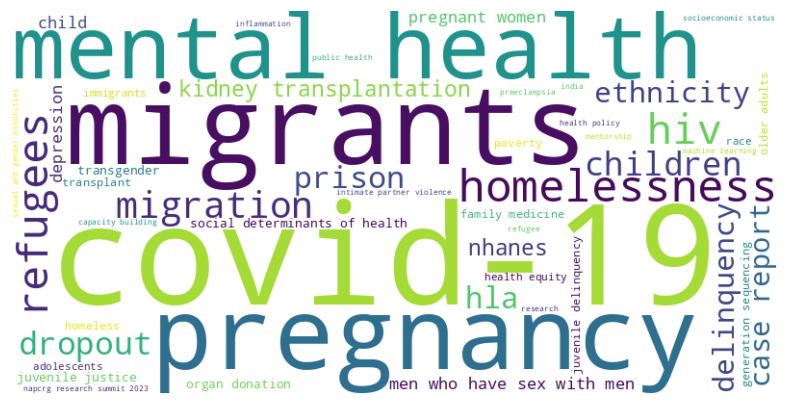

In [3]:
if __name__ == "__main__":
    main()